In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
# Apply the function to the 'pitch_type' column
training_data = data.query('swing == 1')

# Apply the function to the 'pitch_type' column
testing_data_processed = testing_data

In [5]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')


# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'line_drive', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'line_drive', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [7]:
train_data = training_features.drop(['whiff'], axis=1).copy()
train_label = training_features['whiff'].copy()
testing_data = testing_features.drop(['whiff'], axis=1).copy()
testing_label = testing_features['whiff'].copy()

In [8]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [10]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [11]:
y_train.value_counts()

whiff
0    19958
1     8437
Name: count, dtype: int64

In [12]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [13]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6695192815636556
Log Loss: 0.6394914343550562


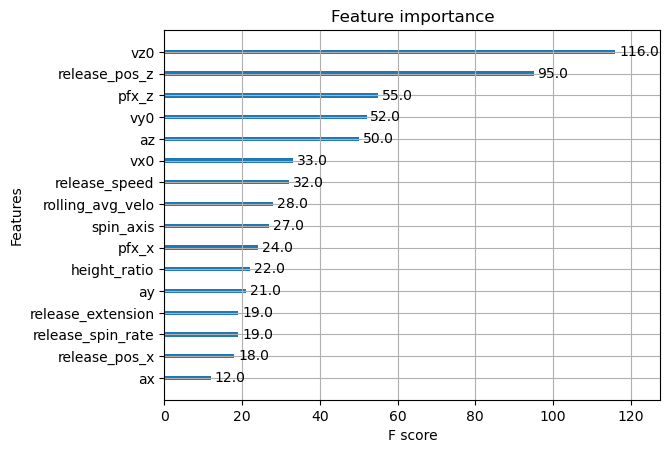

In [14]:
xgb.plot_importance(model)
plt.show()

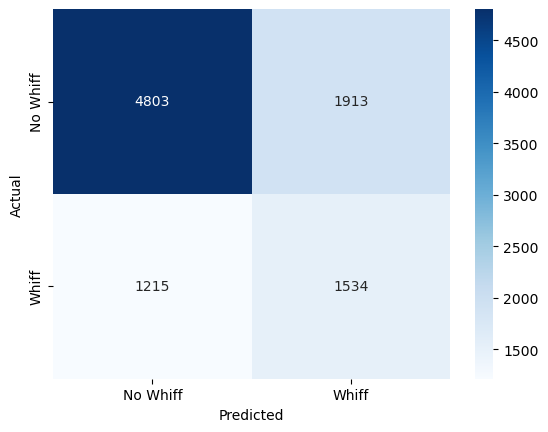

In [15]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [16]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu',
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [17]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 17:05:51,074] A new study created in memory with name: no-name-61758d15-fb97-47cf-a210-1bd357a4b073


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.66672
[2]	eval-logloss:0.65197
[3]	eval-logloss:0.64966
[4]	eval-logloss:0.63994
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62973
[7]	eval-logloss:0.62713
[8]	eval-logloss:0.62417
[9]	eval-logloss:0.62216
[10]	eval-logloss:0.62304
[11]	eval-logloss:0.62267
[12]	eval-logloss:0.62183
[13]	eval-logloss:0.61946
[14]	eval-logloss:0.61949
[15]	eval-logloss:0.61826
[16]	eval-logloss:0.61827
[17]	eval-logloss:0.61749
[18]	eval-logloss:0.61766
[19]	eval-logloss:0.61705
[20]	eval-logloss:0.61727
[21]	eval-logloss:0.61752
[22]	eval-logloss:0.61663
[23]	eval-logloss:0.61651
[24]	eval-logloss:0.61622
[25]	eval-logloss:0.61550
[26]	eval-logloss:0.61600
[27]	eval-logloss:0.61559
[28]	eval-logloss:0.61607
[29]	eval-logloss:0.61549
[30]	eval-logloss:0.61599
[31]	eval-logloss:0.61497
[32]	eval-logloss:0.61495
[33]	eval-logloss:0.61527
[34]	eval-logloss:0.61474
[35]	eval-logloss:0.61498
[36]	eval-logloss:0.61437
[37]	eval-logloss:0.61407
[38]	eval-logloss:0.61

[I 2023-11-15 17:05:52,093] Trial 0 finished with value: 0.6166827746044595 and parameters: {'max_depth': 6, 'eta': 0.2556730384901103, 'subsample': 0.7040895977922512, 'colsample_bytree': 0.9518889189634141}. Best is trial 0 with value: 0.6166827746044595.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.66979
[3]	eval-logloss:0.66794
[4]	eval-logloss:0.66036
[5]	eval-logloss:0.65926
[6]	eval-logloss:0.65313
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.63985
[10]	eval-logloss:0.63925
[11]	eval-logloss:0.63881
[12]	eval-logloss:0.63575
[13]	eval-logloss:0.63334
[14]	eval-logloss:0.63108
[15]	eval-logloss:0.63067
[16]	eval-logloss:0.63045
[17]	eval-logloss:0.62871
[18]	eval-logloss:0.62721
[19]	eval-logloss:0.62645
[20]	eval-logloss:0.62486
[21]	eval-logloss:0.62394
[22]	eval-logloss:0.62278
[23]	eval-logloss:0.62179
[24]	eval-logloss:0.62092
[25]	eval-logloss:0.62025
[26]	eval-logloss:0.61985
[27]	eval-logloss:0.61923
[28]	eval-logloss:0.61866
[29]	eval-logloss:0.61801
[30]	eval-logloss:0.61794
[31]	eval-logloss:0.61722
[32]	eval-logloss:0.61688
[33]	eval-logloss:0.61634
[34]	eval-logloss:0.61600
[35]	eval-logloss:0.61607
[36]	eval-logloss:0.61548
[37]	eval-logloss:0.61504
[38]	eval-logloss:0.61

[I 2023-11-15 17:05:52,754] Trial 1 finished with value: 0.6050019048675096 and parameters: {'max_depth': 6, 'eta': 0.1173244492860779, 'subsample': 0.8987465827310969, 'colsample_bytree': 0.8986399152726441}. Best is trial 1 with value: 0.6050019048675096.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.67000
[2]	eval-logloss:0.65680
[3]	eval-logloss:0.65512
[4]	eval-logloss:0.64511
[5]	eval-logloss:0.64263
[6]	eval-logloss:0.63535
[7]	eval-logloss:0.63116
[8]	eval-logloss:0.62624
[9]	eval-logloss:0.62305
[10]	eval-logloss:0.62356
[11]	eval-logloss:0.62303
[12]	eval-logloss:0.62106
[13]	eval-logloss:0.61780
[14]	eval-logloss:0.61622
[15]	eval-logloss:0.61557
[16]	eval-logloss:0.61603
[17]	eval-logloss:0.61522
[18]	eval-logloss:0.61507
[19]	eval-logloss:0.61437
[20]	eval-logloss:0.61344
[21]	eval-logloss:0.61309
[22]	eval-logloss:0.61249
[23]	eval-logloss:0.61220
[24]	eval-logloss:0.61100
[25]	eval-logloss:0.61075
[26]	eval-logloss:0.61113
[27]	eval-logloss:0.61053
[28]	eval-logloss:0.61058
[29]	eval-logloss:0.61016
[30]	eval-logloss:0.60996
[31]	eval-logloss:0.60999
[32]	eval-logloss:0.61012
[33]	eval-logloss:0.61031
[34]	eval-logloss:0.60958
[35]	eval-logloss:0.60951
[36]	eval-logloss:0.60955
[37]	eval-logloss:0.60894
[38]	eval-logloss:0.60

[I 2023-11-15 17:05:53,706] Trial 2 finished with value: 0.6091153167657548 and parameters: {'max_depth': 8, 'eta': 0.1740715462475396, 'subsample': 0.6973105210411027, 'colsample_bytree': 0.8923324139747151}. Best is trial 1 with value: 0.6050019048675096.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.67459
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.67050
[4]	eval-logloss:0.66993
[5]	eval-logloss:0.66774
[6]	eval-logloss:0.66604
[7]	eval-logloss:0.65613
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.63977
[10]	eval-logloss:0.63957
[11]	eval-logloss:0.63953
[12]	eval-logloss:0.63568
[13]	eval-logloss:0.63188
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62792
[16]	eval-logloss:0.62705
[17]	eval-logloss:0.62441
[18]	eval-logloss:0.62409
[19]	eval-logloss:0.62398
[20]	eval-logloss:0.62337
[21]	eval-logloss:0.62243
[22]	eval-logloss:0.62150
[23]	eval-logloss:0.62086
[24]	eval-logloss:0.62033
[25]	eval-logloss:0.61995
[26]	eval-logloss:0.62007
[27]	eval-logloss:0.61948
[28]	eval-logloss:0.61961
[29]	eval-logloss:0.61881
[30]	eval-logloss:0.61896
[31]	eval-logloss:0.61827
[32]	eval-logloss:0.61796
[33]	eval-logloss:0.61823
[34]	eval-logloss:0.61700
[35]	eval-logloss:0.61764
[36]	eval-logloss:0.61656
[37]	eval-logloss:0.61575
[38]	eval-logloss:0.61

[I 2023-11-15 17:05:54,322] Trial 3 finished with value: 0.612081317698668 and parameters: {'max_depth': 5, 'eta': 0.22368202399638865, 'subsample': 0.7480125311919561, 'colsample_bytree': 0.6048322914011292}. Best is trial 1 with value: 0.6050019048675096.


[0]	eval-logloss:0.66810
[1]	eval-logloss:0.66552
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.65188
[4]	eval-logloss:0.65097
[5]	eval-logloss:0.65014
[6]	eval-logloss:0.64145
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63277
[9]	eval-logloss:0.62862
[10]	eval-logloss:0.62820
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62516
[13]	eval-logloss:0.62351
[14]	eval-logloss:0.62273
[15]	eval-logloss:0.62154
[16]	eval-logloss:0.62172
[17]	eval-logloss:0.62089
[18]	eval-logloss:0.62048
[19]	eval-logloss:0.62023
[20]	eval-logloss:0.61959
[21]	eval-logloss:0.61927
[22]	eval-logloss:0.61919
[23]	eval-logloss:0.61853
[24]	eval-logloss:0.61803
[25]	eval-logloss:0.61716
[26]	eval-logloss:0.61690
[27]	eval-logloss:0.61706
[28]	eval-logloss:0.61672
[29]	eval-logloss:0.61659
[30]	eval-logloss:0.61605
[31]	eval-logloss:0.61620
[32]	eval-logloss:0.61645
[33]	eval-logloss:0.61649
[34]	eval-logloss:0.61627
[35]	eval-logloss:0.61620
[36]	eval-logloss:0.61591
[37]	eval-logloss:0.61608
[38]	eval-logloss:0.61

[I 2023-11-15 17:05:54,917] Trial 4 finished with value: 0.6124433216570876 and parameters: {'max_depth': 5, 'eta': 0.2934410805903215, 'subsample': 0.8659981677276118, 'colsample_bytree': 0.8281299045445027}. Best is trial 1 with value: 0.6050019048675096.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.66866
[2]	eval-logloss:0.65551
[3]	eval-logloss:0.65431
[4]	eval-logloss:0.65274
[5]	eval-logloss:0.65150
[6]	eval-logloss:0.64276
[7]	eval-logloss:0.63754
[8]	eval-logloss:0.63274
[9]	eval-logloss:0.62950
[10]	eval-logloss:0.62910
[11]	eval-logloss:0.62898
[12]	eval-logloss:0.62639
[13]	eval-logloss:0.62512
[14]	eval-logloss:0.62357
[15]	eval-logloss:0.62293
[16]	eval-logloss:0.62261
[17]	eval-logloss:0.62088
[18]	eval-logloss:0.62035
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61942
[21]	eval-logloss:0.61957
[22]	eval-logloss:0.61925
[23]	eval-logloss:0.61866
[24]	eval-logloss:0.61819
[25]	eval-logloss:0.61827
[26]	eval-logloss:0.61840
[27]	eval-logloss:0.61806
[28]	eval-logloss:0.61772
[29]	eval-logloss:0.61753
[30]	eval-logloss:0.61711
[31]	eval-logloss:0.61697
[32]	eval-logloss:0.61654
[33]	eval-logloss:0.61593
[34]	eval-logloss:0.61551
[35]	eval-logloss:0.61546
[36]	eval-logloss:0.61498
[37]	eval-logloss:0.61487
[38]	eval-logloss:0.61

[I 2023-11-15 17:05:55,414] Trial 5 finished with value: 0.6081734153751385 and parameters: {'max_depth': 5, 'eta': 0.25146980159243654, 'subsample': 0.8989728095646132, 'colsample_bytree': 0.6880026557656624}. Best is trial 1 with value: 0.6050019048675096.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.68205
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67667
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.66531
[9]	eval-logloss:0.66402
[10]	eval-logloss:0.66336
[11]	eval-logloss:0.66266
[12]	eval-logloss:0.65801
[13]	eval-logloss:0.65394
[14]	eval-logloss:0.64968
[15]	eval-logloss:0.64888
[16]	eval-logloss:0.64810
[17]	eval-logloss:0.64429
[18]	eval-logloss:0.64119
[19]	eval-logloss:0.64061
[20]	eval-logloss:0.64030
[21]	eval-logloss:0.63780
[22]	eval-logloss:0.63512
[23]	eval-logloss:0.63269
[24]	eval-logloss:0.63042
[25]	eval-logloss:0.62987
[26]	eval-logloss:0.62952
[27]	eval-logloss:0.62786
[28]	eval-logloss:0.62736
[29]	eval-logloss:0.62560
[30]	eval-logloss:0.62537
[31]	eval-logloss:0.62503
[32]	eval-logloss:0.62336
[33]	eval-logloss:0.62314
[34]	eval-logloss:0.62160
[35]	eval-logloss:0.62137
[36]	eval-logloss:0.61986
[37]	eval-logloss:0.61883
[38]	eval-logloss:0.61

[I 2023-11-15 17:05:56,427] Trial 6 finished with value: 0.5996807917082069 and parameters: {'max_depth': 8, 'eta': 0.06537078834451454, 'subsample': 0.8667879814924242, 'colsample_bytree': 0.5602260672587687}. Best is trial 6 with value: 0.5996807917082069.


[0]	eval-logloss:0.68754
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68223
[3]	eval-logloss:0.68179
[4]	eval-logloss:0.68157
[5]	eval-logloss:0.68102
[6]	eval-logloss:0.67706
[7]	eval-logloss:0.67380
[8]	eval-logloss:0.67003
[9]	eval-logloss:0.66732
[10]	eval-logloss:0.66696
[11]	eval-logloss:0.66684
[12]	eval-logloss:0.66459
[13]	eval-logloss:0.66176
[14]	eval-logloss:0.65958
[15]	eval-logloss:0.65910
[16]	eval-logloss:0.65867
[17]	eval-logloss:0.65657
[18]	eval-logloss:0.65480
[19]	eval-logloss:0.65438
[20]	eval-logloss:0.65277
[21]	eval-logloss:0.65115
[22]	eval-logloss:0.64930
[23]	eval-logloss:0.64803
[24]	eval-logloss:0.64666
[25]	eval-logloss:0.64518
[26]	eval-logloss:0.64431
[27]	eval-logloss:0.64311
[28]	eval-logloss:0.64248
[29]	eval-logloss:0.64151
[30]	eval-logloss:0.64131
[31]	eval-logloss:0.64023
[32]	eval-logloss:0.63961
[33]	eval-logloss:0.63912
[34]	eval-logloss:0.63805
[35]	eval-logloss:0.63753
[36]	eval-logloss:0.63681
[37]	eval-logloss:0.63603
[38]	eval-logloss:0.63

[I 2023-11-15 17:05:56,946] Trial 7 finished with value: 0.6220058324665536 and parameters: {'max_depth': 3, 'eta': 0.0743068691861921, 'subsample': 0.6368188858163454, 'colsample_bytree': 0.8191813710493407}. Best is trial 6 with value: 0.5996807917082069.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67351
[3]	eval-logloss:0.67169
[4]	eval-logloss:0.67059
[5]	eval-logloss:0.66838
[6]	eval-logloss:0.66613
[7]	eval-logloss:0.65739
[8]	eval-logloss:0.64928
[9]	eval-logloss:0.64317
[10]	eval-logloss:0.64243
[11]	eval-logloss:0.64180
[12]	eval-logloss:0.63705
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.62857
[15]	eval-logloss:0.62775
[16]	eval-logloss:0.62706
[17]	eval-logloss:0.62366
[18]	eval-logloss:0.62207
[19]	eval-logloss:0.62141
[20]	eval-logloss:0.61977
[21]	eval-logloss:0.61806
[22]	eval-logloss:0.61637
[23]	eval-logloss:0.61502
[24]	eval-logloss:0.61408
[25]	eval-logloss:0.61360
[26]	eval-logloss:0.61350
[27]	eval-logloss:0.61250
[28]	eval-logloss:0.61257
[29]	eval-logloss:0.61131
[30]	eval-logloss:0.61104
[31]	eval-logloss:0.61103
[32]	eval-logloss:0.60996
[33]	eval-logloss:0.60991
[34]	eval-logloss:0.60843
[35]	eval-logloss:0.60796
[36]	eval-logloss:0.60714
[37]	eval-logloss:0.60640
[38]	eval-logloss:0.60

[I 2023-11-15 17:05:57,970] Trial 8 finished with value: 0.5951038335889064 and parameters: {'max_depth': 8, 'eta': 0.125042952131924, 'subsample': 0.7105317676376405, 'colsample_bytree': 0.6628896903109646}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68832
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68536
[8]	eval-logloss:0.68337
[9]	eval-logloss:0.68285
[10]	eval-logloss:0.68247
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.67984
[13]	eval-logloss:0.67778
[14]	eval-logloss:0.67569
[15]	eval-logloss:0.67531
[16]	eval-logloss:0.67484
[17]	eval-logloss:0.67279
[18]	eval-logloss:0.67116
[19]	eval-logloss:0.67088
[20]	eval-logloss:0.67055
[21]	eval-logloss:0.67019
[22]	eval-logloss:0.66855
[23]	eval-logloss:0.66690
[24]	eval-logloss:0.66539
[25]	eval-logloss:0.66491
[26]	eval-logloss:0.66473
[27]	eval-logloss:0.66324
[28]	eval-logloss:0.66299
[29]	eval-logloss:0.66162
[30]	eval-logloss:0.66122
[31]	eval-logloss:0.66101
[32]	eval-logloss:0.65960
[33]	eval-logloss:0.65933
[34]	eval-logloss:0.65798
[35]	eval-logloss:0.65762
[36]	eval-logloss:0.65637
[37]	eval-logloss:0.65500
[38]	eval-logloss:0.65

[I 2023-11-15 17:05:58,937] Trial 9 finished with value: 0.6247965756069619 and parameters: {'max_depth': 8, 'eta': 0.020486427399219742, 'subsample': 0.8365942795222447, 'colsample_bytree': 0.5400499364301847}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.67450
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.66688
[3]	eval-logloss:0.66437
[4]	eval-logloss:0.66313
[5]	eval-logloss:0.66051
[6]	eval-logloss:0.65801
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.63899
[9]	eval-logloss:0.63330
[10]	eval-logloss:0.63358
[11]	eval-logloss:0.63349
[12]	eval-logloss:0.62932
[13]	eval-logloss:0.62486
[14]	eval-logloss:0.62162
[15]	eval-logloss:0.62098
[16]	eval-logloss:0.62114
[17]	eval-logloss:0.61751
[18]	eval-logloss:0.61598
[19]	eval-logloss:0.61498
[20]	eval-logloss:0.61405
[21]	eval-logloss:0.61293
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61139
[24]	eval-logloss:0.61049
[25]	eval-logloss:0.61023
[26]	eval-logloss:0.61023
[27]	eval-logloss:0.60946
[28]	eval-logloss:0.60941
[29]	eval-logloss:0.60873
[30]	eval-logloss:0.60921
[31]	eval-logloss:0.60872
[32]	eval-logloss:0.60833
[33]	eval-logloss:0.60810
[34]	eval-logloss:0.60702
[35]	eval-logloss:0.60686
[36]	eval-logloss:0.60633
[37]	eval-logloss:0.60601
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:00,138] Trial 10 finished with value: 0.6029494187007027 and parameters: {'max_depth': 9, 'eta': 0.16035154729173165, 'subsample': 0.6160080083703144, 'colsample_bytree': 0.6809291913748823}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.68098
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67631
[6]	eval-logloss:0.67396
[7]	eval-logloss:0.66769
[8]	eval-logloss:0.66203
[9]	eval-logloss:0.66051
[10]	eval-logloss:0.65979
[11]	eval-logloss:0.65915
[12]	eval-logloss:0.65405
[13]	eval-logloss:0.64929
[14]	eval-logloss:0.64451
[15]	eval-logloss:0.64351
[16]	eval-logloss:0.64290
[17]	eval-logloss:0.63873
[18]	eval-logloss:0.63610
[19]	eval-logloss:0.63535
[20]	eval-logloss:0.63497
[21]	eval-logloss:0.63460
[22]	eval-logloss:0.63197
[23]	eval-logloss:0.62955
[24]	eval-logloss:0.62754
[25]	eval-logloss:0.62738
[26]	eval-logloss:0.62749
[27]	eval-logloss:0.62588
[28]	eval-logloss:0.62562
[29]	eval-logloss:0.62383
[30]	eval-logloss:0.62340
[31]	eval-logloss:0.62324
[32]	eval-logloss:0.62172
[33]	eval-logloss:0.62133
[34]	eval-logloss:0.61954
[35]	eval-logloss:0.61942
[36]	eval-logloss:0.61782
[37]	eval-logloss:0.61658
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:01,193] Trial 11 finished with value: 0.5997590286535449 and parameters: {'max_depth': 8, 'eta': 0.08435796996105407, 'subsample': 0.8013941417832406, 'colsample_bytree': 0.5192620795172511}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68462
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68208
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67629
[8]	eval-logloss:0.67176
[9]	eval-logloss:0.66772
[10]	eval-logloss:0.66690
[11]	eval-logloss:0.66610
[12]	eval-logloss:0.66253
[13]	eval-logloss:0.65921
[14]	eval-logloss:0.65582
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65402
[17]	eval-logloss:0.65082
[18]	eval-logloss:0.64828
[19]	eval-logloss:0.64767
[20]	eval-logloss:0.64551
[21]	eval-logloss:0.64279
[22]	eval-logloss:0.64071
[23]	eval-logloss:0.63866
[24]	eval-logloss:0.63675
[25]	eval-logloss:0.63614
[26]	eval-logloss:0.63570
[27]	eval-logloss:0.63408
[28]	eval-logloss:0.63350
[29]	eval-logloss:0.63172
[30]	eval-logloss:0.63120
[31]	eval-logloss:0.63069
[32]	eval-logloss:0.62921
[33]	eval-logloss:0.62874
[34]	eval-logloss:0.62710
[35]	eval-logloss:0.62679
[36]	eval-logloss:0.62498
[37]	eval-logloss:0.62358
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:02,699] Trial 12 finished with value: 0.5987025344488215 and parameters: {'max_depth': 9, 'eta': 0.04316484765131963, 'subsample': 0.7974208951582822, 'colsample_bytree': 0.6272047978928657}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68671
[8]	eval-logloss:0.68503
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68312
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68107
[13]	eval-logloss:0.67951
[14]	eval-logloss:0.67797
[15]	eval-logloss:0.67763
[16]	eval-logloss:0.67713
[17]	eval-logloss:0.67556
[18]	eval-logloss:0.67418
[19]	eval-logloss:0.67385
[20]	eval-logloss:0.67273
[21]	eval-logloss:0.67137
[22]	eval-logloss:0.67012
[23]	eval-logloss:0.66887
[24]	eval-logloss:0.66766
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66693
[27]	eval-logloss:0.66575
[28]	eval-logloss:0.66538
[29]	eval-logloss:0.66416
[30]	eval-logloss:0.66385
[31]	eval-logloss:0.66344
[32]	eval-logloss:0.66224
[33]	eval-logloss:0.66190
[34]	eval-logloss:0.66071
[35]	eval-logloss:0.65964
[36]	eval-logloss:0.65851
[37]	eval-logloss:0.65749
[38]	eval-logloss:0.65

[I 2023-11-15 17:06:04,259] Trial 13 finished with value: 0.6262616003777359 and parameters: {'max_depth': 9, 'eta': 0.014010274324697324, 'subsample': 0.7826205118367159, 'colsample_bytree': 0.6367016607642716}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.67777
[2]	eval-logloss:0.66731
[3]	eval-logloss:0.66577
[4]	eval-logloss:0.66444
[5]	eval-logloss:0.66217
[6]	eval-logloss:0.65400
[7]	eval-logloss:0.64852
[8]	eval-logloss:0.64226
[9]	eval-logloss:0.63803
[10]	eval-logloss:0.63751
[11]	eval-logloss:0.63712
[12]	eval-logloss:0.63357
[13]	eval-logloss:0.63065
[14]	eval-logloss:0.62819
[15]	eval-logloss:0.62778
[16]	eval-logloss:0.62736
[17]	eval-logloss:0.62461
[18]	eval-logloss:0.62309
[19]	eval-logloss:0.62249
[20]	eval-logloss:0.62100
[21]	eval-logloss:0.61958
[22]	eval-logloss:0.61802
[23]	eval-logloss:0.61720
[24]	eval-logloss:0.61642
[25]	eval-logloss:0.61548
[26]	eval-logloss:0.61547
[27]	eval-logloss:0.61429
[28]	eval-logloss:0.61394
[29]	eval-logloss:0.61369
[30]	eval-logloss:0.61343
[31]	eval-logloss:0.61263
[32]	eval-logloss:0.61208
[33]	eval-logloss:0.61182
[34]	eval-logloss:0.61115
[35]	eval-logloss:0.61110
[36]	eval-logloss:0.61007
[37]	eval-logloss:0.60968
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:05,081] Trial 14 finished with value: 0.6011543194004378 and parameters: {'max_depth': 7, 'eta': 0.11510098638603951, 'subsample': 0.7265816498631874, 'colsample_bytree': 0.7376468167344775}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68880
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.68267
[6]	eval-logloss:0.68136
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67335
[9]	eval-logloss:0.66963
[10]	eval-logloss:0.66892
[11]	eval-logloss:0.66814
[12]	eval-logloss:0.66452
[13]	eval-logloss:0.66114
[14]	eval-logloss:0.65787
[15]	eval-logloss:0.65727
[16]	eval-logloss:0.65645
[17]	eval-logloss:0.65333
[18]	eval-logloss:0.65089
[19]	eval-logloss:0.65038
[20]	eval-logloss:0.64827
[21]	eval-logloss:0.64572
[22]	eval-logloss:0.64368
[23]	eval-logloss:0.64153
[24]	eval-logloss:0.63940
[25]	eval-logloss:0.63891
[26]	eval-logloss:0.63834
[27]	eval-logloss:0.63661
[28]	eval-logloss:0.63596
[29]	eval-logloss:0.63405
[30]	eval-logloss:0.63359
[31]	eval-logloss:0.63303
[32]	eval-logloss:0.63143
[33]	eval-logloss:0.63098
[34]	eval-logloss:0.62941
[35]	eval-logloss:0.62905
[36]	eval-logloss:0.62756
[37]	eval-logloss:0.62620
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:06,499] Trial 15 finished with value: 0.6000100815719943 and parameters: {'max_depth': 9, 'eta': 0.03928084266313983, 'subsample': 0.7804617202555157, 'colsample_bytree': 0.6087734947580778}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66491
[4]	eval-logloss:0.66378
[5]	eval-logloss:0.66226
[6]	eval-logloss:0.65424
[7]	eval-logloss:0.64897
[8]	eval-logloss:0.64214
[9]	eval-logloss:0.63740
[10]	eval-logloss:0.63699
[11]	eval-logloss:0.63641
[12]	eval-logloss:0.63336
[13]	eval-logloss:0.63020
[14]	eval-logloss:0.62775
[15]	eval-logloss:0.62699
[16]	eval-logloss:0.62676
[17]	eval-logloss:0.62451
[18]	eval-logloss:0.62358
[19]	eval-logloss:0.62326
[20]	eval-logloss:0.62194
[21]	eval-logloss:0.62060
[22]	eval-logloss:0.61915
[23]	eval-logloss:0.61869
[24]	eval-logloss:0.61800
[25]	eval-logloss:0.61699
[26]	eval-logloss:0.61661
[27]	eval-logloss:0.61517
[28]	eval-logloss:0.61494
[29]	eval-logloss:0.61429
[30]	eval-logloss:0.61420
[31]	eval-logloss:0.61347
[32]	eval-logloss:0.61346
[33]	eval-logloss:0.61274
[34]	eval-logloss:0.61212
[35]	eval-logloss:0.61230
[36]	eval-logloss:0.61192
[37]	eval-logloss:0.61150
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:07,336] Trial 16 finished with value: 0.6014199928099394 and parameters: {'max_depth': 7, 'eta': 0.12315789134753768, 'subsample': 0.6781036412284082, 'colsample_bytree': 0.7448541376456538}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68795
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68491
[4]	eval-logloss:0.68421
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68159
[7]	eval-logloss:0.67722
[8]	eval-logloss:0.67235
[9]	eval-logloss:0.67139
[10]	eval-logloss:0.67091
[11]	eval-logloss:0.67037
[12]	eval-logloss:0.66652
[13]	eval-logloss:0.66272
[14]	eval-logloss:0.65911
[15]	eval-logloss:0.65859
[16]	eval-logloss:0.65799
[17]	eval-logloss:0.65453
[18]	eval-logloss:0.65178
[19]	eval-logloss:0.65144
[20]	eval-logloss:0.65112
[21]	eval-logloss:0.64871
[22]	eval-logloss:0.64649
[23]	eval-logloss:0.64433
[24]	eval-logloss:0.64239
[25]	eval-logloss:0.64188
[26]	eval-logloss:0.64157
[27]	eval-logloss:0.63972
[28]	eval-logloss:0.63933
[29]	eval-logloss:0.63754
[30]	eval-logloss:0.63731
[31]	eval-logloss:0.63704
[32]	eval-logloss:0.63548
[33]	eval-logloss:0.63529
[34]	eval-logloss:0.63371
[35]	eval-logloss:0.63359
[36]	eval-logloss:0.63181
[37]	eval-logloss:0.63040
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:08,240] Trial 17 finished with value: 0.609681853131393 and parameters: {'max_depth': 7, 'eta': 0.051458682987431136, 'subsample': 0.7503386284264939, 'colsample_bytree': 0.5833361351616632}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68571
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68492
[5]	eval-logloss:0.68425
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.67854
[8]	eval-logloss:0.67344
[9]	eval-logloss:0.67300
[10]	eval-logloss:0.67299
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.66944
[13]	eval-logloss:0.66571
[14]	eval-logloss:0.66272
[15]	eval-logloss:0.66229
[16]	eval-logloss:0.66187
[17]	eval-logloss:0.65892
[18]	eval-logloss:0.65671
[19]	eval-logloss:0.65639
[20]	eval-logloss:0.65607
[21]	eval-logloss:0.65604
[22]	eval-logloss:0.65362
[23]	eval-logloss:0.65196
[24]	eval-logloss:0.65021
[25]	eval-logloss:0.64970
[26]	eval-logloss:0.64962
[27]	eval-logloss:0.64808
[28]	eval-logloss:0.64809
[29]	eval-logloss:0.64661
[30]	eval-logloss:0.64650
[31]	eval-logloss:0.64631
[32]	eval-logloss:0.64520
[33]	eval-logloss:0.64496
[34]	eval-logloss:0.64331
[35]	eval-logloss:0.64324
[36]	eval-logloss:0.64210
[37]	eval-logloss:0.64081
[38]	eval-logloss:0.63

[I 2023-11-15 17:06:08,869] Trial 18 finished with value: 0.6227048530756986 and parameters: {'max_depth': 3, 'eta': 0.09105275639800985, 'subsample': 0.6682663099522795, 'colsample_bytree': 0.5041940784738069}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68638
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68365
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.67966
[7]	eval-logloss:0.67564
[8]	eval-logloss:0.67128
[9]	eval-logloss:0.66750
[10]	eval-logloss:0.66701
[11]	eval-logloss:0.66608
[12]	eval-logloss:0.66263
[13]	eval-logloss:0.65939
[14]	eval-logloss:0.65588
[15]	eval-logloss:0.65515
[16]	eval-logloss:0.65438
[17]	eval-logloss:0.65123
[18]	eval-logloss:0.64877
[19]	eval-logloss:0.64824
[20]	eval-logloss:0.64618
[21]	eval-logloss:0.64366
[22]	eval-logloss:0.64147
[23]	eval-logloss:0.63948
[24]	eval-logloss:0.63749
[25]	eval-logloss:0.63703
[26]	eval-logloss:0.63677
[27]	eval-logloss:0.63495
[28]	eval-logloss:0.63457
[29]	eval-logloss:0.63263
[30]	eval-logloss:0.63218
[31]	eval-logloss:0.63169
[32]	eval-logloss:0.63013
[33]	eval-logloss:0.62962
[34]	eval-logloss:0.62799
[35]	eval-logloss:0.62636
[36]	eval-logloss:0.62484
[37]	eval-logloss:0.62360
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:10,378] Trial 19 finished with value: 0.599502267315331 and parameters: {'max_depth': 9, 'eta': 0.04187917160452399, 'subsample': 0.8188581703374586, 'colsample_bytree': 0.6382232993992937}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66105
[3]	eval-logloss:0.65918
[4]	eval-logloss:0.65852
[5]	eval-logloss:0.65532
[6]	eval-logloss:0.64660
[7]	eval-logloss:0.64080
[8]	eval-logloss:0.63454
[9]	eval-logloss:0.62979
[10]	eval-logloss:0.62951
[11]	eval-logloss:0.62883
[12]	eval-logloss:0.62615
[13]	eval-logloss:0.62310
[14]	eval-logloss:0.62042
[15]	eval-logloss:0.61973
[16]	eval-logloss:0.61950
[17]	eval-logloss:0.61714
[18]	eval-logloss:0.61636
[19]	eval-logloss:0.61620
[20]	eval-logloss:0.61517
[21]	eval-logloss:0.61416
[22]	eval-logloss:0.61359
[23]	eval-logloss:0.61313
[24]	eval-logloss:0.61163
[25]	eval-logloss:0.61142
[26]	eval-logloss:0.61127
[27]	eval-logloss:0.61025
[28]	eval-logloss:0.61003
[29]	eval-logloss:0.60904
[30]	eval-logloss:0.60835
[31]	eval-logloss:0.60767
[32]	eval-logloss:0.60764
[33]	eval-logloss:0.60751
[34]	eval-logloss:0.60701
[35]	eval-logloss:0.60715
[36]	eval-logloss:0.60631
[37]	eval-logloss:0.60578
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:11,369] Trial 20 finished with value: 0.600383371541795 and parameters: {'max_depth': 8, 'eta': 0.14335723503868034, 'subsample': 0.759137043058969, 'colsample_bytree': 0.6856972252426501}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68364
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.67647
[8]	eval-logloss:0.67230
[9]	eval-logloss:0.66848
[10]	eval-logloss:0.66781
[11]	eval-logloss:0.66704
[12]	eval-logloss:0.66385
[13]	eval-logloss:0.66060
[14]	eval-logloss:0.65733
[15]	eval-logloss:0.65665
[16]	eval-logloss:0.65587
[17]	eval-logloss:0.65279
[18]	eval-logloss:0.65020
[19]	eval-logloss:0.64952
[20]	eval-logloss:0.64762
[21]	eval-logloss:0.64528
[22]	eval-logloss:0.64319
[23]	eval-logloss:0.64106
[24]	eval-logloss:0.63907
[25]	eval-logloss:0.63856
[26]	eval-logloss:0.63806
[27]	eval-logloss:0.63638
[28]	eval-logloss:0.63579
[29]	eval-logloss:0.63393
[30]	eval-logloss:0.63350
[31]	eval-logloss:0.63301
[32]	eval-logloss:0.63155
[33]	eval-logloss:0.63117
[34]	eval-logloss:0.62968
[35]	eval-logloss:0.62820
[36]	eval-logloss:0.62654
[37]	eval-logloss:0.62518
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:12,727] Trial 21 finished with value: 0.5993908287079664 and parameters: {'max_depth': 9, 'eta': 0.04000051879986745, 'subsample': 0.8049643539902365, 'colsample_bytree': 0.651778775024126}. Best is trial 8 with value: 0.5951038335889064.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68457
[2]	eval-logloss:0.68239
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67638
[7]	eval-logloss:0.67107
[8]	eval-logloss:0.66612
[9]	eval-logloss:0.66138
[10]	eval-logloss:0.66047
[11]	eval-logloss:0.65974
[12]	eval-logloss:0.65573
[13]	eval-logloss:0.65169
[14]	eval-logloss:0.64804
[15]	eval-logloss:0.64718
[16]	eval-logloss:0.64634
[17]	eval-logloss:0.64286
[18]	eval-logloss:0.64005
[19]	eval-logloss:0.63948
[20]	eval-logloss:0.63766
[21]	eval-logloss:0.63512
[22]	eval-logloss:0.63274
[23]	eval-logloss:0.63055
[24]	eval-logloss:0.62840
[25]	eval-logloss:0.62784
[26]	eval-logloss:0.62757
[27]	eval-logloss:0.62574
[28]	eval-logloss:0.62533
[29]	eval-logloss:0.62356
[30]	eval-logloss:0.62314
[31]	eval-logloss:0.62259
[32]	eval-logloss:0.62129
[33]	eval-logloss:0.62067
[34]	eval-logloss:0.61931
[35]	eval-logloss:0.61800
[36]	eval-logloss:0.61668
[37]	eval-logloss:0.61553
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:14,002] Trial 22 finished with value: 0.5947841979711219 and parameters: {'max_depth': 9, 'eta': 0.05417572991993032, 'subsample': 0.7870096611991326, 'colsample_bytree': 0.6522924553868256}. Best is trial 22 with value: 0.5947841979711219.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.67928
[3]	eval-logloss:0.67703
[4]	eval-logloss:0.67536
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.66987
[7]	eval-logloss:0.66369
[8]	eval-logloss:0.65684
[9]	eval-logloss:0.65508
[10]	eval-logloss:0.65430
[11]	eval-logloss:0.65325
[12]	eval-logloss:0.64766
[13]	eval-logloss:0.64244
[14]	eval-logloss:0.63782
[15]	eval-logloss:0.63720
[16]	eval-logloss:0.63595
[17]	eval-logloss:0.63182
[18]	eval-logloss:0.62850
[19]	eval-logloss:0.62785
[20]	eval-logloss:0.62774
[21]	eval-logloss:0.62512
[22]	eval-logloss:0.62245
[23]	eval-logloss:0.62020
[24]	eval-logloss:0.61825
[25]	eval-logloss:0.61809
[26]	eval-logloss:0.61806
[27]	eval-logloss:0.61643
[28]	eval-logloss:0.61611
[29]	eval-logloss:0.61440
[30]	eval-logloss:0.61396
[31]	eval-logloss:0.61367
[32]	eval-logloss:0.61229
[33]	eval-logloss:0.61193
[34]	eval-logloss:0.61037
[35]	eval-logloss:0.61023
[36]	eval-logloss:0.60846
[37]	eval-logloss:0.60740
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:15,237] Trial 23 finished with value: 0.5929788706096628 and parameters: {'max_depth': 9, 'eta': 0.08573166467315094, 'subsample': 0.7298500899373743, 'colsample_bytree': 0.5716973460759902}. Best is trial 23 with value: 0.5929788706096628.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.68242
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67766
[4]	eval-logloss:0.67643
[5]	eval-logloss:0.67348
[6]	eval-logloss:0.67083
[7]	eval-logloss:0.66383
[8]	eval-logloss:0.65651
[9]	eval-logloss:0.65536
[10]	eval-logloss:0.65493
[11]	eval-logloss:0.65440
[12]	eval-logloss:0.64902
[13]	eval-logloss:0.64365
[14]	eval-logloss:0.63907
[15]	eval-logloss:0.63818
[16]	eval-logloss:0.63720
[17]	eval-logloss:0.63329
[18]	eval-logloss:0.63005
[19]	eval-logloss:0.62948
[20]	eval-logloss:0.62951
[21]	eval-logloss:0.62728
[22]	eval-logloss:0.62478
[23]	eval-logloss:0.62260
[24]	eval-logloss:0.62037
[25]	eval-logloss:0.62008
[26]	eval-logloss:0.61988
[27]	eval-logloss:0.61840
[28]	eval-logloss:0.61832
[29]	eval-logloss:0.61677
[30]	eval-logloss:0.61654
[31]	eval-logloss:0.61642
[32]	eval-logloss:0.61535
[33]	eval-logloss:0.61468
[34]	eval-logloss:0.61325
[35]	eval-logloss:0.61317
[36]	eval-logloss:0.61192
[37]	eval-logloss:0.61079
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:16,192] Trial 24 finished with value: 0.598186119823497 and parameters: {'max_depth': 8, 'eta': 0.0953361068174061, 'subsample': 0.7289428435780431, 'colsample_bytree': 0.5581173906070893}. Best is trial 23 with value: 0.5929788706096628.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68579
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.68279
[4]	eval-logloss:0.68200
[5]	eval-logloss:0.68001
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67326
[8]	eval-logloss:0.66748
[9]	eval-logloss:0.66662
[10]	eval-logloss:0.66608
[11]	eval-logloss:0.66540
[12]	eval-logloss:0.66058
[13]	eval-logloss:0.65620
[14]	eval-logloss:0.65196
[15]	eval-logloss:0.65126
[16]	eval-logloss:0.65043
[17]	eval-logloss:0.64671
[18]	eval-logloss:0.64393
[19]	eval-logloss:0.64346
[20]	eval-logloss:0.64321
[21]	eval-logloss:0.64081
[22]	eval-logloss:0.63841
[23]	eval-logloss:0.63625
[24]	eval-logloss:0.63399
[25]	eval-logloss:0.63355
[26]	eval-logloss:0.63328
[27]	eval-logloss:0.63169
[28]	eval-logloss:0.63116
[29]	eval-logloss:0.62935
[30]	eval-logloss:0.62906
[31]	eval-logloss:0.62860
[32]	eval-logloss:0.62725
[33]	eval-logloss:0.62712
[34]	eval-logloss:0.62570
[35]	eval-logloss:0.62549
[36]	eval-logloss:0.62387
[37]	eval-logloss:0.62267
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:16,992] Trial 25 finished with value: 0.6037285945486807 and parameters: {'max_depth': 7, 'eta': 0.06767727097091013, 'subsample': 0.7757533729901542, 'colsample_bytree': 0.5799376480061744}. Best is trial 23 with value: 0.5929788706096628.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.66872
[3]	eval-logloss:0.66661
[4]	eval-logloss:0.66496
[5]	eval-logloss:0.66243
[6]	eval-logloss:0.65430
[7]	eval-logloss:0.64842
[8]	eval-logloss:0.64261
[9]	eval-logloss:0.63832
[10]	eval-logloss:0.63749
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63296
[13]	eval-logloss:0.62874
[14]	eval-logloss:0.62586
[15]	eval-logloss:0.62478
[16]	eval-logloss:0.62409
[17]	eval-logloss:0.62099
[18]	eval-logloss:0.61949
[19]	eval-logloss:0.61858
[20]	eval-logloss:0.61622
[21]	eval-logloss:0.61479
[22]	eval-logloss:0.61325
[23]	eval-logloss:0.61248
[24]	eval-logloss:0.61127
[25]	eval-logloss:0.61107
[26]	eval-logloss:0.61062
[27]	eval-logloss:0.60938
[28]	eval-logloss:0.60935
[29]	eval-logloss:0.60812
[30]	eval-logloss:0.60797
[31]	eval-logloss:0.60709
[32]	eval-logloss:0.60633
[33]	eval-logloss:0.60599
[34]	eval-logloss:0.60523
[35]	eval-logloss:0.60491
[36]	eval-logloss:0.60352
[37]	eval-logloss:0.60292
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:18,333] Trial 26 finished with value: 0.5922852961761023 and parameters: {'max_depth': 9, 'eta': 0.09779059571122584, 'subsample': 0.731477527580942, 'colsample_bytree': 0.7081494507059}. Best is trial 26 with value: 0.5922852961761023.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.66480
[4]	eval-logloss:0.66317
[5]	eval-logloss:0.66019
[6]	eval-logloss:0.65224
[7]	eval-logloss:0.64653
[8]	eval-logloss:0.64051
[9]	eval-logloss:0.63554
[10]	eval-logloss:0.63499
[11]	eval-logloss:0.63374
[12]	eval-logloss:0.63035
[13]	eval-logloss:0.62723
[14]	eval-logloss:0.62423
[15]	eval-logloss:0.62324
[16]	eval-logloss:0.62239
[17]	eval-logloss:0.61960
[18]	eval-logloss:0.61772
[19]	eval-logloss:0.61705
[20]	eval-logloss:0.61521
[21]	eval-logloss:0.61327
[22]	eval-logloss:0.61146
[23]	eval-logloss:0.61014
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60754
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60563
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60454
[31]	eval-logloss:0.60348
[32]	eval-logloss:0.60284
[33]	eval-logloss:0.60242
[34]	eval-logloss:0.60199
[35]	eval-logloss:0.60172
[36]	eval-logloss:0.60060
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59

[I 2023-11-15 17:06:19,615] Trial 27 finished with value: 0.5895252182409008 and parameters: {'max_depth': 9, 'eta': 0.10076766658797132, 'subsample': 0.7338423112746031, 'colsample_bytree': 0.7279020489980687}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68458
[2]	eval-logloss:0.67813
[3]	eval-logloss:0.67746
[4]	eval-logloss:0.67699
[5]	eval-logloss:0.67618
[6]	eval-logloss:0.67095
[7]	eval-logloss:0.66658
[8]	eval-logloss:0.66195
[9]	eval-logloss:0.65832
[10]	eval-logloss:0.65801
[11]	eval-logloss:0.65789
[12]	eval-logloss:0.65522
[13]	eval-logloss:0.65244
[14]	eval-logloss:0.64968
[15]	eval-logloss:0.64895
[16]	eval-logloss:0.64844
[17]	eval-logloss:0.64587
[18]	eval-logloss:0.64418
[19]	eval-logloss:0.64380
[20]	eval-logloss:0.64208
[21]	eval-logloss:0.64048
[22]	eval-logloss:0.63908
[23]	eval-logloss:0.63771
[24]	eval-logloss:0.63655
[25]	eval-logloss:0.63602
[26]	eval-logloss:0.63583
[27]	eval-logloss:0.63462
[28]	eval-logloss:0.63461
[29]	eval-logloss:0.63329
[30]	eval-logloss:0.63319
[31]	eval-logloss:0.63199
[32]	eval-logloss:0.63119
[33]	eval-logloss:0.63089
[34]	eval-logloss:0.62985
[35]	eval-logloss:0.62951
[36]	eval-logloss:0.62838
[37]	eval-logloss:0.62762
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:20,120] Trial 28 finished with value: 0.6158161973237632 and parameters: {'max_depth': 4, 'eta': 0.09277519504217138, 'subsample': 0.7347172188940607, 'colsample_bytree': 0.7184331323601836}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67205
[3]	eval-logloss:0.67097
[4]	eval-logloss:0.67003
[5]	eval-logloss:0.66869
[6]	eval-logloss:0.66184
[7]	eval-logloss:0.65686
[8]	eval-logloss:0.65105
[9]	eval-logloss:0.64670
[10]	eval-logloss:0.64651
[11]	eval-logloss:0.64610
[12]	eval-logloss:0.64277
[13]	eval-logloss:0.63959
[14]	eval-logloss:0.63710
[15]	eval-logloss:0.63647
[16]	eval-logloss:0.63606
[17]	eval-logloss:0.63339
[18]	eval-logloss:0.63153
[19]	eval-logloss:0.63112
[20]	eval-logloss:0.62921
[21]	eval-logloss:0.62760
[22]	eval-logloss:0.62629
[23]	eval-logloss:0.62514
[24]	eval-logloss:0.62388
[25]	eval-logloss:0.62263
[26]	eval-logloss:0.62234
[27]	eval-logloss:0.62108
[28]	eval-logloss:0.62020
[29]	eval-logloss:0.61977
[30]	eval-logloss:0.61962
[31]	eval-logloss:0.61897
[32]	eval-logloss:0.61854
[33]	eval-logloss:0.61811
[34]	eval-logloss:0.61770
[35]	eval-logloss:0.61734
[36]	eval-logloss:0.61687
[37]	eval-logloss:0.61636
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:20,827] Trial 29 finished with value: 0.6078700718557196 and parameters: {'max_depth': 6, 'eta': 0.10261703830381863, 'subsample': 0.7087585385355313, 'colsample_bytree': 0.7864908891597262}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.65940
[3]	eval-logloss:0.65705
[4]	eval-logloss:0.65562
[5]	eval-logloss:0.65405
[6]	eval-logloss:0.64536
[7]	eval-logloss:0.63878
[8]	eval-logloss:0.63214
[9]	eval-logloss:0.62772
[10]	eval-logloss:0.62700
[11]	eval-logloss:0.62635
[12]	eval-logloss:0.62285
[13]	eval-logloss:0.61997
[14]	eval-logloss:0.61722
[15]	eval-logloss:0.61702
[16]	eval-logloss:0.61649
[17]	eval-logloss:0.61444
[18]	eval-logloss:0.61334
[19]	eval-logloss:0.61315
[20]	eval-logloss:0.61207
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.61013
[23]	eval-logloss:0.60937
[24]	eval-logloss:0.60910
[25]	eval-logloss:0.60912
[26]	eval-logloss:0.60942
[27]	eval-logloss:0.60817
[28]	eval-logloss:0.60794
[29]	eval-logloss:0.60703
[30]	eval-logloss:0.60621
[31]	eval-logloss:0.60568
[32]	eval-logloss:0.60553
[33]	eval-logloss:0.60552
[34]	eval-logloss:0.60504
[35]	eval-logloss:0.60518
[36]	eval-logloss:0.60477
[37]	eval-logloss:0.60354
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:22,032] Trial 30 finished with value: 0.5997439255409479 and parameters: {'max_depth': 9, 'eta': 0.1449213783900805, 'subsample': 0.7639790466586982, 'colsample_bytree': 0.7000841775426986}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.67268
[4]	eval-logloss:0.67143
[5]	eval-logloss:0.66935
[6]	eval-logloss:0.66276
[7]	eval-logloss:0.65760
[8]	eval-logloss:0.65223
[9]	eval-logloss:0.64788
[10]	eval-logloss:0.64713
[11]	eval-logloss:0.64651
[12]	eval-logloss:0.64266
[13]	eval-logloss:0.63911
[14]	eval-logloss:0.63585
[15]	eval-logloss:0.63501
[16]	eval-logloss:0.63393
[17]	eval-logloss:0.63072
[18]	eval-logloss:0.62875
[19]	eval-logloss:0.62794
[20]	eval-logloss:0.62564
[21]	eval-logloss:0.62370
[22]	eval-logloss:0.62191
[23]	eval-logloss:0.62044
[24]	eval-logloss:0.61885
[25]	eval-logloss:0.61831
[26]	eval-logloss:0.61793
[27]	eval-logloss:0.61642
[28]	eval-logloss:0.61603
[29]	eval-logloss:0.61463
[30]	eval-logloss:0.61434
[31]	eval-logloss:0.61313
[32]	eval-logloss:0.61222
[33]	eval-logloss:0.61230
[34]	eval-logloss:0.61099
[35]	eval-logloss:0.61040
[36]	eval-logloss:0.60923
[37]	eval-logloss:0.60841
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:23,369] Trial 31 finished with value: 0.5918309309097203 and parameters: {'max_depth': 9, 'eta': 0.06910210879688743, 'subsample': 0.7368264344610542, 'colsample_bytree': 0.7103772569611179}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67340
[3]	eval-logloss:0.67176
[4]	eval-logloss:0.67113
[5]	eval-logloss:0.66883
[6]	eval-logloss:0.66260
[7]	eval-logloss:0.65738
[8]	eval-logloss:0.65201
[9]	eval-logloss:0.64746
[10]	eval-logloss:0.64668
[11]	eval-logloss:0.64579
[12]	eval-logloss:0.64184
[13]	eval-logloss:0.63800
[14]	eval-logloss:0.63474
[15]	eval-logloss:0.63399
[16]	eval-logloss:0.63311
[17]	eval-logloss:0.62994
[18]	eval-logloss:0.62759
[19]	eval-logloss:0.62737
[20]	eval-logloss:0.62507
[21]	eval-logloss:0.62330
[22]	eval-logloss:0.62121
[23]	eval-logloss:0.61943
[24]	eval-logloss:0.61762
[25]	eval-logloss:0.61723
[26]	eval-logloss:0.61689
[27]	eval-logloss:0.61524
[28]	eval-logloss:0.61492
[29]	eval-logloss:0.61349
[30]	eval-logloss:0.61312
[31]	eval-logloss:0.61183
[32]	eval-logloss:0.61107
[33]	eval-logloss:0.61077
[34]	eval-logloss:0.61010
[35]	eval-logloss:0.60938
[36]	eval-logloss:0.60830
[37]	eval-logloss:0.60749
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:24,792] Trial 32 finished with value: 0.5953044737844588 and parameters: {'max_depth': 9, 'eta': 0.07307080549137705, 'subsample': 0.7415296976117286, 'colsample_bytree': 0.7188009500091783}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.67758
[2]	eval-logloss:0.66692
[3]	eval-logloss:0.66566
[4]	eval-logloss:0.66464
[5]	eval-logloss:0.66230
[6]	eval-logloss:0.65443
[7]	eval-logloss:0.64881
[8]	eval-logloss:0.64275
[9]	eval-logloss:0.63813
[10]	eval-logloss:0.63760
[11]	eval-logloss:0.63694
[12]	eval-logloss:0.63368
[13]	eval-logloss:0.63033
[14]	eval-logloss:0.62755
[15]	eval-logloss:0.62691
[16]	eval-logloss:0.62636
[17]	eval-logloss:0.62354
[18]	eval-logloss:0.62195
[19]	eval-logloss:0.62122
[20]	eval-logloss:0.61973
[21]	eval-logloss:0.61810
[22]	eval-logloss:0.61672
[23]	eval-logloss:0.61570
[24]	eval-logloss:0.61466
[25]	eval-logloss:0.61364
[26]	eval-logloss:0.61331
[27]	eval-logloss:0.61220
[28]	eval-logloss:0.61201
[29]	eval-logloss:0.61114
[30]	eval-logloss:0.61112
[31]	eval-logloss:0.61047
[32]	eval-logloss:0.61000
[33]	eval-logloss:0.60981
[34]	eval-logloss:0.60867
[35]	eval-logloss:0.60842
[36]	eval-logloss:0.60780
[37]	eval-logloss:0.60735
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:26,107] Trial 33 finished with value: 0.5980693416754777 and parameters: {'max_depth': 8, 'eta': 0.10964018143069074, 'subsample': 0.7208779858756191, 'colsample_bytree': 0.7656718169876766}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67067
[3]	eval-logloss:0.66895
[4]	eval-logloss:0.66743
[5]	eval-logloss:0.66497
[6]	eval-logloss:0.65799
[7]	eval-logloss:0.65264
[8]	eval-logloss:0.64714
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.64191
[11]	eval-logloss:0.64087
[12]	eval-logloss:0.63672
[13]	eval-logloss:0.63292
[14]	eval-logloss:0.62937
[15]	eval-logloss:0.62880
[16]	eval-logloss:0.62770
[17]	eval-logloss:0.62454
[18]	eval-logloss:0.62267
[19]	eval-logloss:0.62252
[20]	eval-logloss:0.62001
[21]	eval-logloss:0.61845
[22]	eval-logloss:0.61662
[23]	eval-logloss:0.61537
[24]	eval-logloss:0.61389
[25]	eval-logloss:0.61225
[26]	eval-logloss:0.61189
[27]	eval-logloss:0.61066
[28]	eval-logloss:0.60977
[29]	eval-logloss:0.60866
[30]	eval-logloss:0.60850
[31]	eval-logloss:0.60752
[32]	eval-logloss:0.60675
[33]	eval-logloss:0.60620
[34]	eval-logloss:0.60531
[35]	eval-logloss:0.60456
[36]	eval-logloss:0.60383
[37]	eval-logloss:0.60357
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:28,295] Trial 34 finished with value: 0.5914094666998977 and parameters: {'max_depth': 9, 'eta': 0.08175668051988412, 'subsample': 0.6961446379230324, 'colsample_bytree': 0.7695795685073273}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.66334
[3]	eval-logloss:0.66158
[4]	eval-logloss:0.66053
[5]	eval-logloss:0.65823
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64419
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63343
[10]	eval-logloss:0.63279
[11]	eval-logloss:0.63255
[12]	eval-logloss:0.62884
[13]	eval-logloss:0.62520
[14]	eval-logloss:0.62243
[15]	eval-logloss:0.62229
[16]	eval-logloss:0.62245
[17]	eval-logloss:0.62032
[18]	eval-logloss:0.61902
[19]	eval-logloss:0.61845
[20]	eval-logloss:0.61712
[21]	eval-logloss:0.61595
[22]	eval-logloss:0.61501
[23]	eval-logloss:0.61421
[24]	eval-logloss:0.61346
[25]	eval-logloss:0.61263
[26]	eval-logloss:0.61222
[27]	eval-logloss:0.61055
[28]	eval-logloss:0.61043
[29]	eval-logloss:0.61014
[30]	eval-logloss:0.61031
[31]	eval-logloss:0.60968
[32]	eval-logloss:0.60934
[33]	eval-logloss:0.60896
[34]	eval-logloss:0.60837
[35]	eval-logloss:0.60854
[36]	eval-logloss:0.60768
[37]	eval-logloss:0.60714
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:29,929] Trial 35 finished with value: 0.5976471875590665 and parameters: {'max_depth': 8, 'eta': 0.12298839483683764, 'subsample': 0.6836468535424639, 'colsample_bytree': 0.7764643074284713}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67934
[2]	eval-logloss:0.66936
[3]	eval-logloss:0.66807
[4]	eval-logloss:0.66724
[5]	eval-logloss:0.66569
[6]	eval-logloss:0.65830
[7]	eval-logloss:0.65288
[8]	eval-logloss:0.64704
[9]	eval-logloss:0.64290
[10]	eval-logloss:0.64261
[11]	eval-logloss:0.64241
[12]	eval-logloss:0.63896
[13]	eval-logloss:0.63534
[14]	eval-logloss:0.63270
[15]	eval-logloss:0.63173
[16]	eval-logloss:0.63133
[17]	eval-logloss:0.62877
[18]	eval-logloss:0.62699
[19]	eval-logloss:0.62663
[20]	eval-logloss:0.62466
[21]	eval-logloss:0.62351
[22]	eval-logloss:0.62213
[23]	eval-logloss:0.62082
[24]	eval-logloss:0.61967
[25]	eval-logloss:0.61917
[26]	eval-logloss:0.61907
[27]	eval-logloss:0.61774
[28]	eval-logloss:0.61778
[29]	eval-logloss:0.61650
[30]	eval-logloss:0.61641
[31]	eval-logloss:0.61549
[32]	eval-logloss:0.61485
[33]	eval-logloss:0.61460
[34]	eval-logloss:0.61376
[35]	eval-logloss:0.61298
[36]	eval-logloss:0.61200
[37]	eval-logloss:0.61150
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:31,250] Trial 36 finished with value: 0.6018295119347692 and parameters: {'max_depth': 7, 'eta': 0.10287157143752629, 'subsample': 0.7010875752223779, 'colsample_bytree': 0.7261903943763578}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65087
[3]	eval-logloss:0.64871
[4]	eval-logloss:0.64724
[5]	eval-logloss:0.64412
[6]	eval-logloss:0.63463
[7]	eval-logloss:0.62889
[8]	eval-logloss:0.62428
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.62157
[11]	eval-logloss:0.62178
[12]	eval-logloss:0.61970
[13]	eval-logloss:0.61726
[14]	eval-logloss:0.61550
[15]	eval-logloss:0.61446
[16]	eval-logloss:0.61438
[17]	eval-logloss:0.61287
[18]	eval-logloss:0.61300
[19]	eval-logloss:0.61321
[20]	eval-logloss:0.61228
[21]	eval-logloss:0.61197
[22]	eval-logloss:0.61096
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.61069
[25]	eval-logloss:0.60964
[26]	eval-logloss:0.60986
[27]	eval-logloss:0.60961
[28]	eval-logloss:0.61005
[29]	eval-logloss:0.60992
[30]	eval-logloss:0.60965
[31]	eval-logloss:0.60871
[32]	eval-logloss:0.60840
[33]	eval-logloss:0.60866
[34]	eval-logloss:0.60810
[35]	eval-logloss:0.60881
[36]	eval-logloss:0.60816
[37]	eval-logloss:0.60796
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:33,423] Trial 37 finished with value: 0.6123837994278891 and parameters: {'max_depth': 9, 'eta': 0.18705207814010322, 'subsample': 0.7465414441118275, 'colsample_bytree': 0.7964673157194218}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68363
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.67538
[4]	eval-logloss:0.67437
[5]	eval-logloss:0.67280
[6]	eval-logloss:0.66714
[7]	eval-logloss:0.66262
[8]	eval-logloss:0.65758
[9]	eval-logloss:0.65331
[10]	eval-logloss:0.65294
[11]	eval-logloss:0.65214
[12]	eval-logloss:0.64820
[13]	eval-logloss:0.64497
[14]	eval-logloss:0.64200
[15]	eval-logloss:0.64125
[16]	eval-logloss:0.64037
[17]	eval-logloss:0.63745
[18]	eval-logloss:0.63522
[19]	eval-logloss:0.63448
[20]	eval-logloss:0.63222
[21]	eval-logloss:0.63041
[22]	eval-logloss:0.62864
[23]	eval-logloss:0.62695
[24]	eval-logloss:0.62521
[25]	eval-logloss:0.62358
[26]	eval-logloss:0.62343
[27]	eval-logloss:0.62192
[28]	eval-logloss:0.62099
[29]	eval-logloss:0.61956
[30]	eval-logloss:0.61933
[31]	eval-logloss:0.61844
[32]	eval-logloss:0.61748
[33]	eval-logloss:0.61739
[34]	eval-logloss:0.61661
[35]	eval-logloss:0.61577
[36]	eval-logloss:0.61456
[37]	eval-logloss:0.61374
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:35,121] Trial 38 finished with value: 0.5991790171248574 and parameters: {'max_depth': 8, 'eta': 0.06279621006887309, 'subsample': 0.6946382558017339, 'colsample_bytree': 0.7508738480489159}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.67983
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67879
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67299
[7]	eval-logloss:0.66922
[8]	eval-logloss:0.66484
[9]	eval-logloss:0.66115
[10]	eval-logloss:0.66096
[11]	eval-logloss:0.66055
[12]	eval-logloss:0.65752
[13]	eval-logloss:0.65470
[14]	eval-logloss:0.65196
[15]	eval-logloss:0.65140
[16]	eval-logloss:0.65104
[17]	eval-logloss:0.64856
[18]	eval-logloss:0.64660
[19]	eval-logloss:0.64614
[20]	eval-logloss:0.64433
[21]	eval-logloss:0.64276
[22]	eval-logloss:0.64129
[23]	eval-logloss:0.64025
[24]	eval-logloss:0.63892
[25]	eval-logloss:0.63756
[26]	eval-logloss:0.63640
[27]	eval-logloss:0.63510
[28]	eval-logloss:0.63426
[29]	eval-logloss:0.63321
[30]	eval-logloss:0.63308
[31]	eval-logloss:0.63206
[32]	eval-logloss:0.63134
[33]	eval-logloss:0.63064
[34]	eval-logloss:0.62982
[35]	eval-logloss:0.62928
[36]	eval-logloss:0.62854
[37]	eval-logloss:0.62781
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:35,943] Trial 39 finished with value: 0.6150821657686829 and parameters: {'max_depth': 4, 'eta': 0.08117585880593516, 'subsample': 0.7132605285423133, 'colsample_bytree': 0.820260690060672}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.66439
[4]	eval-logloss:0.66348
[5]	eval-logloss:0.66186
[6]	eval-logloss:0.65403
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64197
[9]	eval-logloss:0.63761
[10]	eval-logloss:0.63747
[11]	eval-logloss:0.63703
[12]	eval-logloss:0.63403
[13]	eval-logloss:0.63062
[14]	eval-logloss:0.62833
[15]	eval-logloss:0.62731
[16]	eval-logloss:0.62690
[17]	eval-logloss:0.62469
[18]	eval-logloss:0.62345
[19]	eval-logloss:0.62319
[20]	eval-logloss:0.62194
[21]	eval-logloss:0.62112
[22]	eval-logloss:0.61993
[23]	eval-logloss:0.61932
[24]	eval-logloss:0.61868
[25]	eval-logloss:0.61801
[26]	eval-logloss:0.61762
[27]	eval-logloss:0.61631
[28]	eval-logloss:0.61621
[29]	eval-logloss:0.61616
[30]	eval-logloss:0.61607
[31]	eval-logloss:0.61557
[32]	eval-logloss:0.61532
[33]	eval-logloss:0.61470
[34]	eval-logloss:0.61424
[35]	eval-logloss:0.61405
[36]	eval-logloss:0.61366
[37]	eval-logloss:0.61343
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:37,032] Trial 40 finished with value: 0.608465851005787 and parameters: {'max_depth': 6, 'eta': 0.13373740621522495, 'subsample': 0.661449864352039, 'colsample_bytree': 0.8504954213862346}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67081
[3]	eval-logloss:0.66905
[4]	eval-logloss:0.66746
[5]	eval-logloss:0.66507
[6]	eval-logloss:0.65795
[7]	eval-logloss:0.65245
[8]	eval-logloss:0.64653
[9]	eval-logloss:0.64195
[10]	eval-logloss:0.64104
[11]	eval-logloss:0.64043
[12]	eval-logloss:0.63740
[13]	eval-logloss:0.63418
[14]	eval-logloss:0.63105
[15]	eval-logloss:0.63017
[16]	eval-logloss:0.62924
[17]	eval-logloss:0.62649
[18]	eval-logloss:0.62459
[19]	eval-logloss:0.62420
[20]	eval-logloss:0.62198
[21]	eval-logloss:0.62020
[22]	eval-logloss:0.61861
[23]	eval-logloss:0.61707
[24]	eval-logloss:0.61560
[25]	eval-logloss:0.61491
[26]	eval-logloss:0.61464
[27]	eval-logloss:0.61338
[28]	eval-logloss:0.61287
[29]	eval-logloss:0.61176
[30]	eval-logloss:0.61157
[31]	eval-logloss:0.61085
[32]	eval-logloss:0.61035
[33]	eval-logloss:0.61013
[34]	eval-logloss:0.60930
[35]	eval-logloss:0.60869
[36]	eval-logloss:0.60760
[37]	eval-logloss:0.60694
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:39,352] Trial 41 finished with value: 0.5935967303100479 and parameters: {'max_depth': 9, 'eta': 0.08725844072394012, 'subsample': 0.7294570500727989, 'colsample_bytree': 0.7091833898175035}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68014
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67399
[3]	eval-logloss:0.67184
[4]	eval-logloss:0.67078
[5]	eval-logloss:0.66816
[6]	eval-logloss:0.66515
[7]	eval-logloss:0.65686
[8]	eval-logloss:0.64889
[9]	eval-logloss:0.64237
[10]	eval-logloss:0.64130
[11]	eval-logloss:0.64080
[12]	eval-logloss:0.63571
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62696
[15]	eval-logloss:0.62581
[16]	eval-logloss:0.62511
[17]	eval-logloss:0.62146
[18]	eval-logloss:0.61957
[19]	eval-logloss:0.61954
[20]	eval-logloss:0.61804
[21]	eval-logloss:0.61642
[22]	eval-logloss:0.61431
[23]	eval-logloss:0.61338
[24]	eval-logloss:0.61215
[25]	eval-logloss:0.61226
[26]	eval-logloss:0.61220
[27]	eval-logloss:0.61123
[28]	eval-logloss:0.61126
[29]	eval-logloss:0.61031
[30]	eval-logloss:0.61051
[31]	eval-logloss:0.61031
[32]	eval-logloss:0.60953
[33]	eval-logloss:0.60929
[34]	eval-logloss:0.60838
[35]	eval-logloss:0.60749
[36]	eval-logloss:0.60588
[37]	eval-logloss:0.60532
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:41,838] Trial 42 finished with value: 0.5929377236031289 and parameters: {'max_depth': 9, 'eta': 0.10707227149972995, 'subsample': 0.7201161660856429, 'colsample_bytree': 0.6706384263664239}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.66706
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.66391
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65422
[7]	eval-logloss:0.64856
[8]	eval-logloss:0.64245
[9]	eval-logloss:0.63802
[10]	eval-logloss:0.63783
[11]	eval-logloss:0.63737
[12]	eval-logloss:0.63421
[13]	eval-logloss:0.63047
[14]	eval-logloss:0.62766
[15]	eval-logloss:0.62716
[16]	eval-logloss:0.62728
[17]	eval-logloss:0.62429
[18]	eval-logloss:0.62263
[19]	eval-logloss:0.62213
[20]	eval-logloss:0.62024
[21]	eval-logloss:0.61925
[22]	eval-logloss:0.61796
[23]	eval-logloss:0.61718
[24]	eval-logloss:0.61641
[25]	eval-logloss:0.61597
[26]	eval-logloss:0.61587
[27]	eval-logloss:0.61477
[28]	eval-logloss:0.61482
[29]	eval-logloss:0.61367
[30]	eval-logloss:0.61399
[31]	eval-logloss:0.61341
[32]	eval-logloss:0.61278
[33]	eval-logloss:0.61214
[34]	eval-logloss:0.61151
[35]	eval-logloss:0.61097
[36]	eval-logloss:0.60989
[37]	eval-logloss:0.60932
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:43,689] Trial 43 finished with value: 0.5983613325520066 and parameters: {'max_depth': 8, 'eta': 0.10682762730681498, 'subsample': 0.6978465257084957, 'colsample_bytree': 0.6825652739531642}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67439
[3]	eval-logloss:0.67315
[4]	eval-logloss:0.67204
[5]	eval-logloss:0.66992
[6]	eval-logloss:0.66399
[7]	eval-logloss:0.65852
[8]	eval-logloss:0.65344
[9]	eval-logloss:0.64880
[10]	eval-logloss:0.64796
[11]	eval-logloss:0.64733
[12]	eval-logloss:0.64346
[13]	eval-logloss:0.63974
[14]	eval-logloss:0.63616
[15]	eval-logloss:0.63533
[16]	eval-logloss:0.63466
[17]	eval-logloss:0.63148
[18]	eval-logloss:0.62911
[19]	eval-logloss:0.62845
[20]	eval-logloss:0.62607
[21]	eval-logloss:0.62385
[22]	eval-logloss:0.62223
[23]	eval-logloss:0.62074
[24]	eval-logloss:0.61866
[25]	eval-logloss:0.61709
[26]	eval-logloss:0.61689
[27]	eval-logloss:0.61549
[28]	eval-logloss:0.61439
[29]	eval-logloss:0.61324
[30]	eval-logloss:0.61269
[31]	eval-logloss:0.61133
[32]	eval-logloss:0.61064
[33]	eval-logloss:0.61029
[34]	eval-logloss:0.60916
[35]	eval-logloss:0.60835
[36]	eval-logloss:0.60748
[37]	eval-logloss:0.60663
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:46,232] Trial 44 finished with value: 0.5919754620062486 and parameters: {'max_depth': 9, 'eta': 0.06793301476784595, 'subsample': 0.7563465201396617, 'colsample_bytree': 0.756568214784525}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.68094
[2]	eval-logloss:0.67288
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.67066
[5]	eval-logloss:0.66838
[6]	eval-logloss:0.66211
[7]	eval-logloss:0.65658
[8]	eval-logloss:0.65112
[9]	eval-logloss:0.64617
[10]	eval-logloss:0.64523
[11]	eval-logloss:0.64472
[12]	eval-logloss:0.64059
[13]	eval-logloss:0.63685
[14]	eval-logloss:0.63343
[15]	eval-logloss:0.63294
[16]	eval-logloss:0.63227
[17]	eval-logloss:0.62921
[18]	eval-logloss:0.62693
[19]	eval-logloss:0.62627
[20]	eval-logloss:0.62399
[21]	eval-logloss:0.62209
[22]	eval-logloss:0.62028
[23]	eval-logloss:0.61904
[24]	eval-logloss:0.61740
[25]	eval-logloss:0.61601
[26]	eval-logloss:0.61596
[27]	eval-logloss:0.61476
[28]	eval-logloss:0.61358
[29]	eval-logloss:0.61254
[30]	eval-logloss:0.61202
[31]	eval-logloss:0.61063
[32]	eval-logloss:0.60992
[33]	eval-logloss:0.60976
[34]	eval-logloss:0.60894
[35]	eval-logloss:0.60884
[36]	eval-logloss:0.60769
[37]	eval-logloss:0.60684
[38]	eval-logloss:0.60

[I 2023-11-15 17:06:48,725] Trial 45 finished with value: 0.5935289081927122 and parameters: {'max_depth': 9, 'eta': 0.07371695289772705, 'subsample': 0.7576330295419874, 'colsample_bytree': 0.7497875235166798}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.67794
[3]	eval-logloss:0.67709
[4]	eval-logloss:0.67622
[5]	eval-logloss:0.67446
[6]	eval-logloss:0.66892
[7]	eval-logloss:0.66440
[8]	eval-logloss:0.66004
[9]	eval-logloss:0.65620
[10]	eval-logloss:0.65526
[11]	eval-logloss:0.65463
[12]	eval-logloss:0.65111
[13]	eval-logloss:0.64774
[14]	eval-logloss:0.64444
[15]	eval-logloss:0.64386
[16]	eval-logloss:0.64290
[17]	eval-logloss:0.63990
[18]	eval-logloss:0.63777
[19]	eval-logloss:0.63727
[20]	eval-logloss:0.63496
[21]	eval-logloss:0.63282
[22]	eval-logloss:0.63107
[23]	eval-logloss:0.62940
[24]	eval-logloss:0.62791
[25]	eval-logloss:0.62749
[26]	eval-logloss:0.62724
[27]	eval-logloss:0.62572
[28]	eval-logloss:0.62532
[29]	eval-logloss:0.62384
[30]	eval-logloss:0.62338
[31]	eval-logloss:0.62256
[32]	eval-logloss:0.62150
[33]	eval-logloss:0.62110
[34]	eval-logloss:0.61999
[35]	eval-logloss:0.61908
[36]	eval-logloss:0.61801
[37]	eval-logloss:0.61702
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:50,669] Trial 46 finished with value: 0.5989217490863858 and parameters: {'max_depth': 8, 'eta': 0.057727576699083155, 'subsample': 0.766614494451285, 'colsample_bytree': 0.6986487175657132}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68335
[5]	eval-logloss:0.68226
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67598
[8]	eval-logloss:0.67285
[9]	eval-logloss:0.67003
[10]	eval-logloss:0.66949
[11]	eval-logloss:0.66883
[12]	eval-logloss:0.66610
[13]	eval-logloss:0.66354
[14]	eval-logloss:0.66103
[15]	eval-logloss:0.66052
[16]	eval-logloss:0.65964
[17]	eval-logloss:0.65712
[18]	eval-logloss:0.65523
[19]	eval-logloss:0.65480
[20]	eval-logloss:0.65289
[21]	eval-logloss:0.65084
[22]	eval-logloss:0.64923
[23]	eval-logloss:0.64742
[24]	eval-logloss:0.64585
[25]	eval-logloss:0.64412
[26]	eval-logloss:0.64374
[27]	eval-logloss:0.64209
[28]	eval-logloss:0.64045
[29]	eval-logloss:0.63889
[30]	eval-logloss:0.63843
[31]	eval-logloss:0.63692
[32]	eval-logloss:0.63566
[33]	eval-logloss:0.63528
[34]	eval-logloss:0.63382
[35]	eval-logloss:0.63257
[36]	eval-logloss:0.63130
[37]	eval-logloss:0.63023
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:53,519] Trial 47 finished with value: 0.6033651825373794 and parameters: {'max_depth': 9, 'eta': 0.02938507715322327, 'subsample': 0.7460555008225678, 'colsample_bytree': 0.760028671149975}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.68241
[2]	eval-logloss:0.67443
[3]	eval-logloss:0.67298
[4]	eval-logloss:0.67205
[5]	eval-logloss:0.67050
[6]	eval-logloss:0.66418
[7]	eval-logloss:0.65913
[8]	eval-logloss:0.65392
[9]	eval-logloss:0.64986
[10]	eval-logloss:0.64923
[11]	eval-logloss:0.64867
[12]	eval-logloss:0.64488
[13]	eval-logloss:0.64115
[14]	eval-logloss:0.63770
[15]	eval-logloss:0.63689
[16]	eval-logloss:0.63605
[17]	eval-logloss:0.63318
[18]	eval-logloss:0.63106
[19]	eval-logloss:0.63077
[20]	eval-logloss:0.62865
[21]	eval-logloss:0.62677
[22]	eval-logloss:0.62530
[23]	eval-logloss:0.62383
[24]	eval-logloss:0.62213
[25]	eval-logloss:0.62170
[26]	eval-logloss:0.62147
[27]	eval-logloss:0.61996
[28]	eval-logloss:0.61950
[29]	eval-logloss:0.61809
[30]	eval-logloss:0.61796
[31]	eval-logloss:0.61711
[32]	eval-logloss:0.61626
[33]	eval-logloss:0.61616
[34]	eval-logloss:0.61512
[35]	eval-logloss:0.61385
[36]	eval-logloss:0.61266
[37]	eval-logloss:0.61189
[38]	eval-logloss:0.61

[I 2023-11-15 17:06:55,314] Trial 48 finished with value: 0.5991416471825116 and parameters: {'max_depth': 8, 'eta': 0.0736905035583815, 'subsample': 0.7103029747781582, 'colsample_bytree': 0.7258441749687475}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68901
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68534
[4]	eval-logloss:0.68482
[5]	eval-logloss:0.68397
[6]	eval-logloss:0.68123
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67620
[9]	eval-logloss:0.67386
[10]	eval-logloss:0.67346
[11]	eval-logloss:0.67282
[12]	eval-logloss:0.67053
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66631
[15]	eval-logloss:0.66583
[16]	eval-logloss:0.66530
[17]	eval-logloss:0.66312
[18]	eval-logloss:0.66130
[19]	eval-logloss:0.66082
[20]	eval-logloss:0.65904
[21]	eval-logloss:0.65724
[22]	eval-logloss:0.65567
[23]	eval-logloss:0.65387
[24]	eval-logloss:0.65234
[25]	eval-logloss:0.65073
[26]	eval-logloss:0.65029
[27]	eval-logloss:0.64882
[28]	eval-logloss:0.64726
[29]	eval-logloss:0.64588
[30]	eval-logloss:0.64553
[31]	eval-logloss:0.64408
[32]	eval-logloss:0.64291
[33]	eval-logloss:0.64155
[34]	eval-logloss:0.64028
[35]	eval-logloss:0.63920
[36]	eval-logloss:0.63805
[37]	eval-logloss:0.63706
[38]	eval-logloss:0.63

[I 2023-11-15 17:06:58,218] Trial 49 finished with value: 0.6082432907495885 and parameters: {'max_depth': 9, 'eta': 0.02273821047643939, 'subsample': 0.7428592235691774, 'colsample_bytree': 0.7880540066796095}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68710
[1]	eval-logloss:0.68604
[2]	eval-logloss:0.68056
[3]	eval-logloss:0.67996
[4]	eval-logloss:0.67945
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67380
[7]	eval-logloss:0.66988
[8]	eval-logloss:0.66567
[9]	eval-logloss:0.66235
[10]	eval-logloss:0.66196
[11]	eval-logloss:0.66148
[12]	eval-logloss:0.65851
[13]	eval-logloss:0.65575
[14]	eval-logloss:0.65311
[15]	eval-logloss:0.65259
[16]	eval-logloss:0.65204
[17]	eval-logloss:0.64948
[18]	eval-logloss:0.64740
[19]	eval-logloss:0.64707
[20]	eval-logloss:0.64516
[21]	eval-logloss:0.64342
[22]	eval-logloss:0.64182
[23]	eval-logloss:0.64033
[24]	eval-logloss:0.63889
[25]	eval-logloss:0.63748
[26]	eval-logloss:0.63727
[27]	eval-logloss:0.63580
[28]	eval-logloss:0.63460
[29]	eval-logloss:0.63342
[30]	eval-logloss:0.63322
[31]	eval-logloss:0.63237
[32]	eval-logloss:0.63162
[33]	eval-logloss:0.63149
[34]	eval-logloss:0.63059
[35]	eval-logloss:0.63015
[36]	eval-logloss:0.62909
[37]	eval-logloss:0.62823
[38]	eval-logloss:0.62

[I 2023-11-15 17:06:59,278] Trial 50 finished with value: 0.6138996233639379 and parameters: {'max_depth': 5, 'eta': 0.0626594043790955, 'subsample': 0.7705598393698966, 'colsample_bytree': 0.7336253921849077}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.66304
[4]	eval-logloss:0.66129
[5]	eval-logloss:0.65905
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64466
[8]	eval-logloss:0.63845
[9]	eval-logloss:0.63338
[10]	eval-logloss:0.63262
[11]	eval-logloss:0.63217
[12]	eval-logloss:0.62888
[13]	eval-logloss:0.62522
[14]	eval-logloss:0.62234
[15]	eval-logloss:0.62153
[16]	eval-logloss:0.62065
[17]	eval-logloss:0.61821
[18]	eval-logloss:0.61654
[19]	eval-logloss:0.61602
[20]	eval-logloss:0.61430
[21]	eval-logloss:0.61291
[22]	eval-logloss:0.61159
[23]	eval-logloss:0.61049
[24]	eval-logloss:0.60936
[25]	eval-logloss:0.60896
[26]	eval-logloss:0.60892
[27]	eval-logloss:0.60725
[28]	eval-logloss:0.60732
[29]	eval-logloss:0.60606
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60450
[32]	eval-logloss:0.60381
[33]	eval-logloss:0.60388
[34]	eval-logloss:0.60301
[35]	eval-logloss:0.60273
[36]	eval-logloss:0.60191
[37]	eval-logloss:0.60111
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:01,773] Trial 51 finished with value: 0.593803258995561 and parameters: {'max_depth': 9, 'eta': 0.10935648788591533, 'subsample': 0.7199026848287845, 'colsample_bytree': 0.7029266886603043}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.67999
[2]	eval-logloss:0.67641
[3]	eval-logloss:0.67453
[4]	eval-logloss:0.67335
[5]	eval-logloss:0.67076
[6]	eval-logloss:0.66816
[7]	eval-logloss:0.66027
[8]	eval-logloss:0.65255
[9]	eval-logloss:0.64676
[10]	eval-logloss:0.64556
[11]	eval-logloss:0.64506
[12]	eval-logloss:0.63999
[13]	eval-logloss:0.63541
[14]	eval-logloss:0.63144
[15]	eval-logloss:0.63060
[16]	eval-logloss:0.62997
[17]	eval-logloss:0.62619
[18]	eval-logloss:0.62384
[19]	eval-logloss:0.62342
[20]	eval-logloss:0.62151
[21]	eval-logloss:0.61925
[22]	eval-logloss:0.61761
[23]	eval-logloss:0.61613
[24]	eval-logloss:0.61444
[25]	eval-logloss:0.61441
[26]	eval-logloss:0.61406
[27]	eval-logloss:0.61277
[28]	eval-logloss:0.61246
[29]	eval-logloss:0.61102
[30]	eval-logloss:0.61081
[31]	eval-logloss:0.61064
[32]	eval-logloss:0.60984
[33]	eval-logloss:0.60964
[34]	eval-logloss:0.60864
[35]	eval-logloss:0.60773
[36]	eval-logloss:0.60640
[37]	eval-logloss:0.60564
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:04,247] Trial 52 finished with value: 0.5923386795115981 and parameters: {'max_depth': 9, 'eta': 0.09420263588364641, 'subsample': 0.7199074719111841, 'colsample_bytree': 0.6773490212098412}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67789
[3]	eval-logloss:0.67594
[4]	eval-logloss:0.67433
[5]	eval-logloss:0.67200
[6]	eval-logloss:0.66986
[7]	eval-logloss:0.66287
[8]	eval-logloss:0.65629
[9]	eval-logloss:0.65082
[10]	eval-logloss:0.64988
[11]	eval-logloss:0.64914
[12]	eval-logloss:0.64473
[13]	eval-logloss:0.64030
[14]	eval-logloss:0.63664
[15]	eval-logloss:0.63577
[16]	eval-logloss:0.63469
[17]	eval-logloss:0.63105
[18]	eval-logloss:0.62834
[19]	eval-logloss:0.62778
[20]	eval-logloss:0.62571
[21]	eval-logloss:0.62350
[22]	eval-logloss:0.62137
[23]	eval-logloss:0.61971
[24]	eval-logloss:0.61782
[25]	eval-logloss:0.61739
[26]	eval-logloss:0.61720
[27]	eval-logloss:0.61575
[28]	eval-logloss:0.61557
[29]	eval-logloss:0.61373
[30]	eval-logloss:0.61328
[31]	eval-logloss:0.61298
[32]	eval-logloss:0.61172
[33]	eval-logloss:0.61140
[34]	eval-logloss:0.61002
[35]	eval-logloss:0.60899
[36]	eval-logloss:0.60769
[37]	eval-logloss:0.60671
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:06,709] Trial 53 finished with value: 0.5926038250810093 and parameters: {'max_depth': 9, 'eta': 0.08043819229178358, 'subsample': 0.7511515338938933, 'colsample_bytree': 0.6698707333777302}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67950
[2]	eval-logloss:0.66999
[3]	eval-logloss:0.66837
[4]	eval-logloss:0.66712
[5]	eval-logloss:0.66497
[6]	eval-logloss:0.65781
[7]	eval-logloss:0.65209
[8]	eval-logloss:0.64653
[9]	eval-logloss:0.64184
[10]	eval-logloss:0.64097
[11]	eval-logloss:0.64006
[12]	eval-logloss:0.63658
[13]	eval-logloss:0.63317
[14]	eval-logloss:0.63019
[15]	eval-logloss:0.62940
[16]	eval-logloss:0.62892
[17]	eval-logloss:0.62643
[18]	eval-logloss:0.62479
[19]	eval-logloss:0.62393
[20]	eval-logloss:0.62222
[21]	eval-logloss:0.62059
[22]	eval-logloss:0.61913
[23]	eval-logloss:0.61776
[24]	eval-logloss:0.61661
[25]	eval-logloss:0.61514
[26]	eval-logloss:0.61500
[27]	eval-logloss:0.61372
[28]	eval-logloss:0.61279
[29]	eval-logloss:0.61178
[30]	eval-logloss:0.61145
[31]	eval-logloss:0.61073
[32]	eval-logloss:0.61000
[33]	eval-logloss:0.61001
[34]	eval-logloss:0.60930
[35]	eval-logloss:0.60904
[36]	eval-logloss:0.60859
[37]	eval-logloss:0.60783
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:08,603] Trial 54 finished with value: 0.596671937651756 and parameters: {'max_depth': 8, 'eta': 0.09372038936149561, 'subsample': 0.7373006560422598, 'colsample_bytree': 0.7434292843557189}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68620
[1]	eval-logloss:0.68420
[2]	eval-logloss:0.67798
[3]	eval-logloss:0.67688
[4]	eval-logloss:0.67600
[5]	eval-logloss:0.67396
[6]	eval-logloss:0.66860
[7]	eval-logloss:0.66401
[8]	eval-logloss:0.65961
[9]	eval-logloss:0.65557
[10]	eval-logloss:0.65488
[11]	eval-logloss:0.65411
[12]	eval-logloss:0.65021
[13]	eval-logloss:0.64684
[14]	eval-logloss:0.64364
[15]	eval-logloss:0.64282
[16]	eval-logloss:0.64208
[17]	eval-logloss:0.63913
[18]	eval-logloss:0.63667
[19]	eval-logloss:0.63623
[20]	eval-logloss:0.63393
[21]	eval-logloss:0.63174
[22]	eval-logloss:0.63007
[23]	eval-logloss:0.62806
[24]	eval-logloss:0.62619
[25]	eval-logloss:0.62423
[26]	eval-logloss:0.62373
[27]	eval-logloss:0.62208
[28]	eval-logloss:0.62081
[29]	eval-logloss:0.61945
[30]	eval-logloss:0.61913
[31]	eval-logloss:0.61785
[32]	eval-logloss:0.61693
[33]	eval-logloss:0.61642
[34]	eval-logloss:0.61550
[35]	eval-logloss:0.61458
[36]	eval-logloss:0.61345
[37]	eval-logloss:0.61265
[38]	eval-logloss:0.61

[I 2023-11-15 17:07:11,263] Trial 55 finished with value: 0.5950782748788996 and parameters: {'max_depth': 9, 'eta': 0.05325890072290364, 'subsample': 0.7584598281846535, 'colsample_bytree': 0.7678675824435216}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.66317
[3]	eval-logloss:0.66102
[4]	eval-logloss:0.65936
[5]	eval-logloss:0.65736
[6]	eval-logloss:0.64876
[7]	eval-logloss:0.64257
[8]	eval-logloss:0.63565
[9]	eval-logloss:0.63071
[10]	eval-logloss:0.63018
[11]	eval-logloss:0.62979
[12]	eval-logloss:0.62664
[13]	eval-logloss:0.62341
[14]	eval-logloss:0.62062
[15]	eval-logloss:0.61952
[16]	eval-logloss:0.61942
[17]	eval-logloss:0.61697
[18]	eval-logloss:0.61547
[19]	eval-logloss:0.61479
[20]	eval-logloss:0.61274
[21]	eval-logloss:0.61165
[22]	eval-logloss:0.61033
[23]	eval-logloss:0.60964
[24]	eval-logloss:0.60917
[25]	eval-logloss:0.60895
[26]	eval-logloss:0.60875
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60691
[29]	eval-logloss:0.60568
[30]	eval-logloss:0.60591
[31]	eval-logloss:0.60536
[32]	eval-logloss:0.60483
[33]	eval-logloss:0.60430
[34]	eval-logloss:0.60360
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60257
[37]	eval-logloss:0.60215
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:13,658] Trial 56 finished with value: 0.5955811611087057 and parameters: {'max_depth': 9, 'eta': 0.11659125018777387, 'subsample': 0.6934543206243993, 'colsample_bytree': 0.6915994783992961}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.68121
[2]	eval-logloss:0.67245
[3]	eval-logloss:0.67119
[4]	eval-logloss:0.67021
[5]	eval-logloss:0.66818
[6]	eval-logloss:0.66146
[7]	eval-logloss:0.65593
[8]	eval-logloss:0.65047
[9]	eval-logloss:0.64601
[10]	eval-logloss:0.64529
[11]	eval-logloss:0.64458
[12]	eval-logloss:0.64060
[13]	eval-logloss:0.63713
[14]	eval-logloss:0.63378
[15]	eval-logloss:0.63323
[16]	eval-logloss:0.63234
[17]	eval-logloss:0.62902
[18]	eval-logloss:0.62683
[19]	eval-logloss:0.62673
[20]	eval-logloss:0.62492
[21]	eval-logloss:0.62323
[22]	eval-logloss:0.62159
[23]	eval-logloss:0.62017
[24]	eval-logloss:0.61860
[25]	eval-logloss:0.61703
[26]	eval-logloss:0.61664
[27]	eval-logloss:0.61522
[28]	eval-logloss:0.61442
[29]	eval-logloss:0.61329
[30]	eval-logloss:0.61318
[31]	eval-logloss:0.61217
[32]	eval-logloss:0.61120
[33]	eval-logloss:0.61027
[34]	eval-logloss:0.60951
[35]	eval-logloss:0.60925
[36]	eval-logloss:0.60818
[37]	eval-logloss:0.60748
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:15,565] Trial 57 finished with value: 0.5954327093490376 and parameters: {'max_depth': 8, 'eta': 0.07997744603760469, 'subsample': 0.736183112975525, 'colsample_bytree': 0.8052268361736962}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67449
[3]	eval-logloss:0.67313
[4]	eval-logloss:0.67197
[5]	eval-logloss:0.66994
[6]	eval-logloss:0.66378
[7]	eval-logloss:0.65842
[8]	eval-logloss:0.65317
[9]	eval-logloss:0.64830
[10]	eval-logloss:0.64756
[11]	eval-logloss:0.64671
[12]	eval-logloss:0.64280
[13]	eval-logloss:0.63944
[14]	eval-logloss:0.63614
[15]	eval-logloss:0.63538
[16]	eval-logloss:0.63424
[17]	eval-logloss:0.63150
[18]	eval-logloss:0.62927
[19]	eval-logloss:0.62889
[20]	eval-logloss:0.62655
[21]	eval-logloss:0.62479
[22]	eval-logloss:0.62320
[23]	eval-logloss:0.62167
[24]	eval-logloss:0.62008
[25]	eval-logloss:0.61844
[26]	eval-logloss:0.61827
[27]	eval-logloss:0.61687
[28]	eval-logloss:0.61542
[29]	eval-logloss:0.61416
[30]	eval-logloss:0.61374
[31]	eval-logloss:0.61277
[32]	eval-logloss:0.61175
[33]	eval-logloss:0.61142
[34]	eval-logloss:0.61059
[35]	eval-logloss:0.60994
[36]	eval-logloss:0.60901
[37]	eval-logloss:0.60821
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:18,229] Trial 58 finished with value: 0.5933974259940199 and parameters: {'max_depth': 9, 'eta': 0.06802493080180078, 'subsample': 0.71080224486688, 'colsample_bytree': 0.7336039355723114}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67823
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66611
[4]	eval-logloss:0.66500
[5]	eval-logloss:0.66211
[6]	eval-logloss:0.65429
[7]	eval-logloss:0.64869
[8]	eval-logloss:0.64200
[9]	eval-logloss:0.63741
[10]	eval-logloss:0.63685
[11]	eval-logloss:0.63609
[12]	eval-logloss:0.63232
[13]	eval-logloss:0.62862
[14]	eval-logloss:0.62507
[15]	eval-logloss:0.62421
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.62066
[18]	eval-logloss:0.61899
[19]	eval-logloss:0.61866
[20]	eval-logloss:0.61635
[21]	eval-logloss:0.61466
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61163
[24]	eval-logloss:0.61058
[25]	eval-logloss:0.60971
[26]	eval-logloss:0.60969
[27]	eval-logloss:0.60781
[28]	eval-logloss:0.60774
[29]	eval-logloss:0.60646
[30]	eval-logloss:0.60665
[31]	eval-logloss:0.60613
[32]	eval-logloss:0.60584
[33]	eval-logloss:0.60560
[34]	eval-logloss:0.60465
[35]	eval-logloss:0.60416
[36]	eval-logloss:0.60289
[37]	eval-logloss:0.60240
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:20,708] Trial 59 finished with value: 0.590098062011095 and parameters: {'max_depth': 9, 'eta': 0.10000482514541051, 'subsample': 0.721376960561096, 'colsample_bytree': 0.7117008733139147}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68138
[3]	eval-logloss:0.68054
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67387
[7]	eval-logloss:0.67014
[8]	eval-logloss:0.66628
[9]	eval-logloss:0.66275
[10]	eval-logloss:0.66230
[11]	eval-logloss:0.66157
[12]	eval-logloss:0.65847
[13]	eval-logloss:0.65533
[14]	eval-logloss:0.65228
[15]	eval-logloss:0.65169
[16]	eval-logloss:0.65104
[17]	eval-logloss:0.64825
[18]	eval-logloss:0.64607
[19]	eval-logloss:0.64573
[20]	eval-logloss:0.64355
[21]	eval-logloss:0.64157
[22]	eval-logloss:0.63975
[23]	eval-logloss:0.63790
[24]	eval-logloss:0.63620
[25]	eval-logloss:0.63570
[26]	eval-logloss:0.63534
[27]	eval-logloss:0.63365
[28]	eval-logloss:0.63329
[29]	eval-logloss:0.63174
[30]	eval-logloss:0.63141
[31]	eval-logloss:0.63015
[32]	eval-logloss:0.62890
[33]	eval-logloss:0.62855
[34]	eval-logloss:0.62746
[35]	eval-logloss:0.62635
[36]	eval-logloss:0.62502
[37]	eval-logloss:0.62405
[38]	eval-logloss:0.62

[I 2023-11-15 17:07:22,730] Trial 60 finished with value: 0.6039603091288865 and parameters: {'max_depth': 8, 'eta': 0.04498678278984061, 'subsample': 0.772431105868352, 'colsample_bytree': 0.7095609058824032}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67965
[2]	eval-logloss:0.67602
[3]	eval-logloss:0.67388
[4]	eval-logloss:0.67244
[5]	eval-logloss:0.66962
[6]	eval-logloss:0.66646
[7]	eval-logloss:0.65867
[8]	eval-logloss:0.65085
[9]	eval-logloss:0.64502
[10]	eval-logloss:0.64424
[11]	eval-logloss:0.64322
[12]	eval-logloss:0.63854
[13]	eval-logloss:0.63414
[14]	eval-logloss:0.63042
[15]	eval-logloss:0.62946
[16]	eval-logloss:0.62854
[17]	eval-logloss:0.62512
[18]	eval-logloss:0.62268
[19]	eval-logloss:0.62208
[20]	eval-logloss:0.62058
[21]	eval-logloss:0.61843
[22]	eval-logloss:0.61605
[23]	eval-logloss:0.61461
[24]	eval-logloss:0.61294
[25]	eval-logloss:0.61264
[26]	eval-logloss:0.61268
[27]	eval-logloss:0.61152
[28]	eval-logloss:0.61134
[29]	eval-logloss:0.60964
[30]	eval-logloss:0.60947
[31]	eval-logloss:0.60925
[32]	eval-logloss:0.60850
[33]	eval-logloss:0.60809
[34]	eval-logloss:0.60702
[35]	eval-logloss:0.60616
[36]	eval-logloss:0.60465
[37]	eval-logloss:0.60368
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:25,174] Trial 61 finished with value: 0.5903235852701307 and parameters: {'max_depth': 9, 'eta': 0.09595439417882044, 'subsample': 0.7223431297352733, 'colsample_bytree': 0.6624908791619122}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.67261
[3]	eval-logloss:0.67048
[4]	eval-logloss:0.66805
[5]	eval-logloss:0.66450
[6]	eval-logloss:0.66184
[7]	eval-logloss:0.65273
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.63816
[10]	eval-logloss:0.63771
[11]	eval-logloss:0.63720
[12]	eval-logloss:0.63343
[13]	eval-logloss:0.62903
[14]	eval-logloss:0.62517
[15]	eval-logloss:0.62435
[16]	eval-logloss:0.62391
[17]	eval-logloss:0.62049
[18]	eval-logloss:0.61873
[19]	eval-logloss:0.61884
[20]	eval-logloss:0.61767
[21]	eval-logloss:0.61555
[22]	eval-logloss:0.61354
[23]	eval-logloss:0.61255
[24]	eval-logloss:0.61175
[25]	eval-logloss:0.61153
[26]	eval-logloss:0.61152
[27]	eval-logloss:0.61035
[28]	eval-logloss:0.61061
[29]	eval-logloss:0.60981
[30]	eval-logloss:0.60977
[31]	eval-logloss:0.60961
[32]	eval-logloss:0.60894
[33]	eval-logloss:0.60853
[34]	eval-logloss:0.60776
[35]	eval-logloss:0.60730
[36]	eval-logloss:0.60613
[37]	eval-logloss:0.60596
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:27,502] Trial 62 finished with value: 0.596880346546339 and parameters: {'max_depth': 9, 'eta': 0.1212355360564477, 'subsample': 0.7295238522974534, 'colsample_bytree': 0.655341583517724}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67672
[2]	eval-logloss:0.66651
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.66282
[5]	eval-logloss:0.65985
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64600
[8]	eval-logloss:0.63989
[9]	eval-logloss:0.63484
[10]	eval-logloss:0.63401
[11]	eval-logloss:0.63366
[12]	eval-logloss:0.62991
[13]	eval-logloss:0.62711
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62393
[16]	eval-logloss:0.62329
[17]	eval-logloss:0.62022
[18]	eval-logloss:0.61819
[19]	eval-logloss:0.61763
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61320
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61112
[25]	eval-logloss:0.60990
[26]	eval-logloss:0.60947
[27]	eval-logloss:0.60804
[28]	eval-logloss:0.60736
[29]	eval-logloss:0.60631
[30]	eval-logloss:0.60591
[31]	eval-logloss:0.60524
[32]	eval-logloss:0.60472
[33]	eval-logloss:0.60433
[34]	eval-logloss:0.60388
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60315
[37]	eval-logloss:0.60278
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:29,991] Trial 63 finished with value: 0.5910776767540509 and parameters: {'max_depth': 9, 'eta': 0.10090590496478588, 'subsample': 0.7512777386284293, 'colsample_bytree': 0.7546895994425019}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67954
[2]	eval-logloss:0.67071
[3]	eval-logloss:0.66922
[4]	eval-logloss:0.66787
[5]	eval-logloss:0.66530
[6]	eval-logloss:0.65800
[7]	eval-logloss:0.65234
[8]	eval-logloss:0.64679
[9]	eval-logloss:0.64146
[10]	eval-logloss:0.64083
[11]	eval-logloss:0.64025
[12]	eval-logloss:0.63642
[13]	eval-logloss:0.63304
[14]	eval-logloss:0.62971
[15]	eval-logloss:0.62874
[16]	eval-logloss:0.62780
[17]	eval-logloss:0.62410
[18]	eval-logloss:0.62187
[19]	eval-logloss:0.62105
[20]	eval-logloss:0.61931
[21]	eval-logloss:0.61775
[22]	eval-logloss:0.61636
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61306
[25]	eval-logloss:0.61170
[26]	eval-logloss:0.61140
[27]	eval-logloss:0.61007
[28]	eval-logloss:0.60900
[29]	eval-logloss:0.60781
[30]	eval-logloss:0.60729
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60558
[33]	eval-logloss:0.60517
[34]	eval-logloss:0.60448
[35]	eval-logloss:0.60409
[36]	eval-logloss:0.60337
[37]	eval-logloss:0.60274
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:32,491] Trial 64 finished with value: 0.591403555725906 and parameters: {'max_depth': 9, 'eta': 0.08444747323261033, 'subsample': 0.7520511507654758, 'colsample_bytree': 0.7585828154202031}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.67983
[2]	eval-logloss:0.67091
[3]	eval-logloss:0.66991
[4]	eval-logloss:0.66902
[5]	eval-logloss:0.66683
[6]	eval-logloss:0.65989
[7]	eval-logloss:0.65453
[8]	eval-logloss:0.64918
[9]	eval-logloss:0.64460
[10]	eval-logloss:0.64378
[11]	eval-logloss:0.64305
[12]	eval-logloss:0.63935
[13]	eval-logloss:0.63583
[14]	eval-logloss:0.63296
[15]	eval-logloss:0.63212
[16]	eval-logloss:0.63128
[17]	eval-logloss:0.62831
[18]	eval-logloss:0.62618
[19]	eval-logloss:0.62597
[20]	eval-logloss:0.62386
[21]	eval-logloss:0.62242
[22]	eval-logloss:0.62069
[23]	eval-logloss:0.61916
[24]	eval-logloss:0.61782
[25]	eval-logloss:0.61644
[26]	eval-logloss:0.61624
[27]	eval-logloss:0.61496
[28]	eval-logloss:0.61377
[29]	eval-logloss:0.61270
[30]	eval-logloss:0.61221
[31]	eval-logloss:0.61126
[32]	eval-logloss:0.61068
[33]	eval-logloss:0.61008
[34]	eval-logloss:0.60919
[35]	eval-logloss:0.60892
[36]	eval-logloss:0.60811
[37]	eval-logloss:0.60770
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:34,492] Trial 65 finished with value: 0.5960243473044181 and parameters: {'max_depth': 8, 'eta': 0.0862442150200388, 'subsample': 0.7503180286855797, 'colsample_bytree': 0.7731750859071052}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66382
[3]	eval-logloss:0.66205
[4]	eval-logloss:0.66040
[5]	eval-logloss:0.65787
[6]	eval-logloss:0.64985
[7]	eval-logloss:0.64330
[8]	eval-logloss:0.63715
[9]	eval-logloss:0.63240
[10]	eval-logloss:0.63152
[11]	eval-logloss:0.63136
[12]	eval-logloss:0.62795
[13]	eval-logloss:0.62476
[14]	eval-logloss:0.62181
[15]	eval-logloss:0.62080
[16]	eval-logloss:0.62060
[17]	eval-logloss:0.61785
[18]	eval-logloss:0.61610
[19]	eval-logloss:0.61556
[20]	eval-logloss:0.61402
[21]	eval-logloss:0.61273
[22]	eval-logloss:0.61163
[23]	eval-logloss:0.61089
[24]	eval-logloss:0.61024
[25]	eval-logloss:0.60910
[26]	eval-logloss:0.60842
[27]	eval-logloss:0.60744
[28]	eval-logloss:0.60703
[29]	eval-logloss:0.60612
[30]	eval-logloss:0.60615
[31]	eval-logloss:0.60545
[32]	eval-logloss:0.60489
[33]	eval-logloss:0.60483
[34]	eval-logloss:0.60421
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60389
[37]	eval-logloss:0.60357
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:36,938] Trial 66 finished with value: 0.5933309403579988 and parameters: {'max_depth': 9, 'eta': 0.11307591387003582, 'subsample': 0.7428096133371034, 'colsample_bytree': 0.7433682305759828}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66519
[4]	eval-logloss:0.66364
[5]	eval-logloss:0.66178
[6]	eval-logloss:0.65369
[7]	eval-logloss:0.64744
[8]	eval-logloss:0.64135
[9]	eval-logloss:0.63651
[10]	eval-logloss:0.63570
[11]	eval-logloss:0.63491
[12]	eval-logloss:0.63177
[13]	eval-logloss:0.62784
[14]	eval-logloss:0.62434
[15]	eval-logloss:0.62351
[16]	eval-logloss:0.62304
[17]	eval-logloss:0.61996
[18]	eval-logloss:0.61834
[19]	eval-logloss:0.61808
[20]	eval-logloss:0.61570
[21]	eval-logloss:0.61393
[22]	eval-logloss:0.61245
[23]	eval-logloss:0.61107
[24]	eval-logloss:0.60990
[25]	eval-logloss:0.60953
[26]	eval-logloss:0.60920
[27]	eval-logloss:0.60799
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60719
[30]	eval-logloss:0.60675
[31]	eval-logloss:0.60593
[32]	eval-logloss:0.60500
[33]	eval-logloss:0.60493
[34]	eval-logloss:0.60465
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60339
[37]	eval-logloss:0.60283
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:39,460] Trial 67 finished with value: 0.5916939069646401 and parameters: {'max_depth': 9, 'eta': 0.09859555059669432, 'subsample': 0.704591711067026, 'colsample_bytree': 0.7196748661227713}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66355
[3]	eval-logloss:0.66135
[4]	eval-logloss:0.66001
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.64971
[7]	eval-logloss:0.64367
[8]	eval-logloss:0.63755
[9]	eval-logloss:0.63336
[10]	eval-logloss:0.63294
[11]	eval-logloss:0.63244
[12]	eval-logloss:0.62911
[13]	eval-logloss:0.62568
[14]	eval-logloss:0.62395
[15]	eval-logloss:0.62319
[16]	eval-logloss:0.62323
[17]	eval-logloss:0.62102
[18]	eval-logloss:0.62013
[19]	eval-logloss:0.61934
[20]	eval-logloss:0.61811
[21]	eval-logloss:0.61713
[22]	eval-logloss:0.61595
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61468
[25]	eval-logloss:0.61378
[26]	eval-logloss:0.61341
[27]	eval-logloss:0.61227
[28]	eval-logloss:0.61176
[29]	eval-logloss:0.61118
[30]	eval-logloss:0.61118
[31]	eval-logloss:0.61067
[32]	eval-logloss:0.61065
[33]	eval-logloss:0.61085
[34]	eval-logloss:0.61026
[35]	eval-logloss:0.61003
[36]	eval-logloss:0.60950
[37]	eval-logloss:0.60903
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:41,329] Trial 68 finished with value: 0.6008661984375321 and parameters: {'max_depth': 8, 'eta': 0.13058084660087219, 'subsample': 0.7039987742782926, 'colsample_bytree': 0.7311560353823509}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.67681
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.66442
[4]	eval-logloss:0.66259
[5]	eval-logloss:0.66015
[6]	eval-logloss:0.65242
[7]	eval-logloss:0.64629
[8]	eval-logloss:0.63967
[9]	eval-logloss:0.63513
[10]	eval-logloss:0.63481
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63056
[13]	eval-logloss:0.62728
[14]	eval-logloss:0.62448
[15]	eval-logloss:0.62386
[16]	eval-logloss:0.62371
[17]	eval-logloss:0.62099
[18]	eval-logloss:0.61907
[19]	eval-logloss:0.61874
[20]	eval-logloss:0.61674
[21]	eval-logloss:0.61513
[22]	eval-logloss:0.61367
[23]	eval-logloss:0.61259
[24]	eval-logloss:0.61127
[25]	eval-logloss:0.61038
[26]	eval-logloss:0.61006
[27]	eval-logloss:0.60897
[28]	eval-logloss:0.60832
[29]	eval-logloss:0.60785
[30]	eval-logloss:0.60759
[31]	eval-logloss:0.60721
[32]	eval-logloss:0.60696
[33]	eval-logloss:0.60635
[34]	eval-logloss:0.60561
[35]	eval-logloss:0.60504
[36]	eval-logloss:0.60449
[37]	eval-logloss:0.60426
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:43,802] Trial 69 finished with value: 0.593266454953737 and parameters: {'max_depth': 9, 'eta': 0.09964311471633258, 'subsample': 0.6883288739730555, 'colsample_bytree': 0.783936669440697}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66926
[4]	eval-logloss:0.66834
[5]	eval-logloss:0.66623
[6]	eval-logloss:0.65911
[7]	eval-logloss:0.65417
[8]	eval-logloss:0.64857
[9]	eval-logloss:0.64425
[10]	eval-logloss:0.64361
[11]	eval-logloss:0.64336
[12]	eval-logloss:0.64033
[13]	eval-logloss:0.63699
[14]	eval-logloss:0.63393
[15]	eval-logloss:0.63298
[16]	eval-logloss:0.63284
[17]	eval-logloss:0.63001
[18]	eval-logloss:0.62833
[19]	eval-logloss:0.62783
[20]	eval-logloss:0.62627
[21]	eval-logloss:0.62503
[22]	eval-logloss:0.62345
[23]	eval-logloss:0.62237
[24]	eval-logloss:0.62132
[25]	eval-logloss:0.62094
[26]	eval-logloss:0.62073
[27]	eval-logloss:0.61957
[28]	eval-logloss:0.61951
[29]	eval-logloss:0.61817
[30]	eval-logloss:0.61806
[31]	eval-logloss:0.61728
[32]	eval-logloss:0.61639
[33]	eval-logloss:0.61634
[34]	eval-logloss:0.61542
[35]	eval-logloss:0.61491
[36]	eval-logloss:0.61420
[37]	eval-logloss:0.61395
[38]	eval-logloss:0.61

[I 2023-11-15 17:07:45,307] Trial 70 finished with value: 0.6017071834168085 and parameters: {'max_depth': 7, 'eta': 0.09906014743811507, 'subsample': 0.7167690282552182, 'colsample_bytree': 0.6913856112830433}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67849
[2]	eval-logloss:0.66847
[3]	eval-logloss:0.66669
[4]	eval-logloss:0.66530
[5]	eval-logloss:0.66290
[6]	eval-logloss:0.65552
[7]	eval-logloss:0.64924
[8]	eval-logloss:0.64333
[9]	eval-logloss:0.63819
[10]	eval-logloss:0.63718
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63293
[13]	eval-logloss:0.62900
[14]	eval-logloss:0.62623
[15]	eval-logloss:0.62577
[16]	eval-logloss:0.62518
[17]	eval-logloss:0.62249
[18]	eval-logloss:0.62032
[19]	eval-logloss:0.62003
[20]	eval-logloss:0.61799
[21]	eval-logloss:0.61622
[22]	eval-logloss:0.61437
[23]	eval-logloss:0.61320
[24]	eval-logloss:0.61210
[25]	eval-logloss:0.61221
[26]	eval-logloss:0.61220
[27]	eval-logloss:0.61078
[28]	eval-logloss:0.61041
[29]	eval-logloss:0.60891
[30]	eval-logloss:0.60919
[31]	eval-logloss:0.60827
[32]	eval-logloss:0.60733
[33]	eval-logloss:0.60694
[34]	eval-logloss:0.60603
[35]	eval-logloss:0.60539
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60389
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:47,732] Trial 71 finished with value: 0.590162599436191 and parameters: {'max_depth': 9, 'eta': 0.09156407164284841, 'subsample': 0.704781309303507, 'colsample_bytree': 0.7163249164884298}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.66862
[3]	eval-logloss:0.66691
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.66336
[6]	eval-logloss:0.65601
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64433
[9]	eval-logloss:0.63948
[10]	eval-logloss:0.63892
[11]	eval-logloss:0.63835
[12]	eval-logloss:0.63448
[13]	eval-logloss:0.63041
[14]	eval-logloss:0.62729
[15]	eval-logloss:0.62670
[16]	eval-logloss:0.62616
[17]	eval-logloss:0.62345
[18]	eval-logloss:0.62146
[19]	eval-logloss:0.62147
[20]	eval-logloss:0.61906
[21]	eval-logloss:0.61724
[22]	eval-logloss:0.61579
[23]	eval-logloss:0.61446
[24]	eval-logloss:0.61311
[25]	eval-logloss:0.61173
[26]	eval-logloss:0.61161
[27]	eval-logloss:0.61020
[28]	eval-logloss:0.60959
[29]	eval-logloss:0.60815
[30]	eval-logloss:0.60809
[31]	eval-logloss:0.60729
[32]	eval-logloss:0.60641
[33]	eval-logloss:0.60632
[34]	eval-logloss:0.60553
[35]	eval-logloss:0.60496
[36]	eval-logloss:0.60429
[37]	eval-logloss:0.60411
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:50,195] Trial 72 finished with value: 0.5929958000817486 and parameters: {'max_depth': 9, 'eta': 0.08865193565996589, 'subsample': 0.6801447147356859, 'colsample_bytree': 0.7646146365481223}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.68044
[2]	eval-logloss:0.67141
[3]	eval-logloss:0.66998
[4]	eval-logloss:0.66858
[5]	eval-logloss:0.66643
[6]	eval-logloss:0.65948
[7]	eval-logloss:0.65396
[8]	eval-logloss:0.64860
[9]	eval-logloss:0.64428
[10]	eval-logloss:0.64370
[11]	eval-logloss:0.64301
[12]	eval-logloss:0.63912
[13]	eval-logloss:0.63552
[14]	eval-logloss:0.63252
[15]	eval-logloss:0.63154
[16]	eval-logloss:0.63067
[17]	eval-logloss:0.62790
[18]	eval-logloss:0.62584
[19]	eval-logloss:0.62552
[20]	eval-logloss:0.62312
[21]	eval-logloss:0.62122
[22]	eval-logloss:0.61949
[23]	eval-logloss:0.61817
[24]	eval-logloss:0.61691
[25]	eval-logloss:0.61632
[26]	eval-logloss:0.61609
[27]	eval-logloss:0.61442
[28]	eval-logloss:0.61409
[29]	eval-logloss:0.61282
[30]	eval-logloss:0.61264
[31]	eval-logloss:0.61185
[32]	eval-logloss:0.61100
[33]	eval-logloss:0.61061
[34]	eval-logloss:0.61001
[35]	eval-logloss:0.60869
[36]	eval-logloss:0.60779
[37]	eval-logloss:0.60722
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:52,678] Trial 73 finished with value: 0.5942557357916826 and parameters: {'max_depth': 9, 'eta': 0.07963092579092657, 'subsample': 0.7008238928503899, 'colsample_bytree': 0.7218979776812186}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.67678
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.66454
[4]	eval-logloss:0.66262
[5]	eval-logloss:0.66021
[6]	eval-logloss:0.65196
[7]	eval-logloss:0.64559
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63466
[10]	eval-logloss:0.63376
[11]	eval-logloss:0.63303
[12]	eval-logloss:0.62919
[13]	eval-logloss:0.62572
[14]	eval-logloss:0.62255
[15]	eval-logloss:0.62197
[16]	eval-logloss:0.62160
[17]	eval-logloss:0.61862
[18]	eval-logloss:0.61659
[19]	eval-logloss:0.61644
[20]	eval-logloss:0.61509
[21]	eval-logloss:0.61341
[22]	eval-logloss:0.61206
[23]	eval-logloss:0.61098
[24]	eval-logloss:0.61031
[25]	eval-logloss:0.60907
[26]	eval-logloss:0.60918
[27]	eval-logloss:0.60800
[28]	eval-logloss:0.60736
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60651
[31]	eval-logloss:0.60564
[32]	eval-logloss:0.60524
[33]	eval-logloss:0.60554
[34]	eval-logloss:0.60519
[35]	eval-logloss:0.60491
[36]	eval-logloss:0.60399
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:55,181] Trial 74 finished with value: 0.5921636025629029 and parameters: {'max_depth': 9, 'eta': 0.10408306909962818, 'subsample': 0.705949075555483, 'colsample_bytree': 0.7436960998647715}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.67219
[3]	eval-logloss:0.66956
[4]	eval-logloss:0.66797
[5]	eval-logloss:0.66511
[6]	eval-logloss:0.66204
[7]	eval-logloss:0.65329
[8]	eval-logloss:0.64501
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63795
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63278
[13]	eval-logloss:0.62826
[14]	eval-logloss:0.62472
[15]	eval-logloss:0.62446
[16]	eval-logloss:0.62408
[17]	eval-logloss:0.62030
[18]	eval-logloss:0.61856
[19]	eval-logloss:0.61839
[20]	eval-logloss:0.61649
[21]	eval-logloss:0.61451
[22]	eval-logloss:0.61263
[23]	eval-logloss:0.61158
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60837
[28]	eval-logloss:0.60824
[29]	eval-logloss:0.60710
[30]	eval-logloss:0.60714
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60627
[33]	eval-logloss:0.60601
[34]	eval-logloss:0.60477
[35]	eval-logloss:0.60422
[36]	eval-logloss:0.60372
[37]	eval-logloss:0.60358
[38]	eval-logloss:0.60

[I 2023-11-15 17:07:57,606] Trial 75 finished with value: 0.5935003885274323 and parameters: {'max_depth': 9, 'eta': 0.11641340493588498, 'subsample': 0.6721774194907092, 'colsample_bytree': 0.6604088891995785}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67957
[2]	eval-logloss:0.67008
[3]	eval-logloss:0.66841
[4]	eval-logloss:0.66706
[5]	eval-logloss:0.66468
[6]	eval-logloss:0.65686
[7]	eval-logloss:0.65129
[8]	eval-logloss:0.64545
[9]	eval-logloss:0.64071
[10]	eval-logloss:0.63984
[11]	eval-logloss:0.63879
[12]	eval-logloss:0.63520
[13]	eval-logloss:0.63149
[14]	eval-logloss:0.62822
[15]	eval-logloss:0.62737
[16]	eval-logloss:0.62662
[17]	eval-logloss:0.62360
[18]	eval-logloss:0.62137
[19]	eval-logloss:0.62088
[20]	eval-logloss:0.61886
[21]	eval-logloss:0.61694
[22]	eval-logloss:0.61519
[23]	eval-logloss:0.61422
[24]	eval-logloss:0.61295
[25]	eval-logloss:0.61233
[26]	eval-logloss:0.61211
[27]	eval-logloss:0.61069
[28]	eval-logloss:0.61064
[29]	eval-logloss:0.60946
[30]	eval-logloss:0.60926
[31]	eval-logloss:0.60855
[32]	eval-logloss:0.60767
[33]	eval-logloss:0.60768
[34]	eval-logloss:0.60699
[35]	eval-logloss:0.60632
[36]	eval-logloss:0.60507
[37]	eval-logloss:0.60439
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:00,090] Trial 76 finished with value: 0.5922364501585236 and parameters: {'max_depth': 9, 'eta': 0.09047093443131037, 'subsample': 0.7291122649156696, 'colsample_bytree': 0.7175721340136162}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66582
[4]	eval-logloss:0.66455
[5]	eval-logloss:0.66200
[6]	eval-logloss:0.65420
[7]	eval-logloss:0.64839
[8]	eval-logloss:0.64205
[9]	eval-logloss:0.63727
[10]	eval-logloss:0.63647
[11]	eval-logloss:0.63595
[12]	eval-logloss:0.63231
[13]	eval-logloss:0.62888
[14]	eval-logloss:0.62539
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62408
[17]	eval-logloss:0.62144
[18]	eval-logloss:0.61956
[19]	eval-logloss:0.61923
[20]	eval-logloss:0.61756
[21]	eval-logloss:0.61606
[22]	eval-logloss:0.61498
[23]	eval-logloss:0.61424
[24]	eval-logloss:0.61314
[25]	eval-logloss:0.61276
[26]	eval-logloss:0.61221
[27]	eval-logloss:0.61068
[28]	eval-logloss:0.61007
[29]	eval-logloss:0.60869
[30]	eval-logloss:0.60839
[31]	eval-logloss:0.60767
[32]	eval-logloss:0.60665
[33]	eval-logloss:0.60618
[34]	eval-logloss:0.60503
[35]	eval-logloss:0.60434
[36]	eval-logloss:0.60307
[37]	eval-logloss:0.60232
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:02,578] Trial 77 finished with value: 0.5912759474350415 and parameters: {'max_depth': 9, 'eta': 0.0992402652677464, 'subsample': 0.7231845538008737, 'colsample_bytree': 0.6900268977990239}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.67308
[3]	eval-logloss:0.67092
[4]	eval-logloss:0.66936
[5]	eval-logloss:0.66641
[6]	eval-logloss:0.66436
[7]	eval-logloss:0.65536
[8]	eval-logloss:0.64740
[9]	eval-logloss:0.64146
[10]	eval-logloss:0.64043
[11]	eval-logloss:0.63979
[12]	eval-logloss:0.63565
[13]	eval-logloss:0.63142
[14]	eval-logloss:0.62779
[15]	eval-logloss:0.62722
[16]	eval-logloss:0.62663
[17]	eval-logloss:0.62327
[18]	eval-logloss:0.62124
[19]	eval-logloss:0.62072
[20]	eval-logloss:0.61979
[21]	eval-logloss:0.61791
[22]	eval-logloss:0.61607
[23]	eval-logloss:0.61506
[24]	eval-logloss:0.61418
[25]	eval-logloss:0.61466
[26]	eval-logloss:0.61450
[27]	eval-logloss:0.61339
[28]	eval-logloss:0.61313
[29]	eval-logloss:0.61181
[30]	eval-logloss:0.61200
[31]	eval-logloss:0.61180
[32]	eval-logloss:0.61113
[33]	eval-logloss:0.61093
[34]	eval-logloss:0.60953
[35]	eval-logloss:0.60868
[36]	eval-logloss:0.60758
[37]	eval-logloss:0.60740
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:04,407] Trial 78 finished with value: 0.5963067183505721 and parameters: {'max_depth': 8, 'eta': 0.12713225791245714, 'subsample': 0.7226148386517598, 'colsample_bytree': 0.6412313485005465}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.67577
[2]	eval-logloss:0.66463
[3]	eval-logloss:0.66244
[4]	eval-logloss:0.66106
[5]	eval-logloss:0.65796
[6]	eval-logloss:0.65017
[7]	eval-logloss:0.64469
[8]	eval-logloss:0.63877
[9]	eval-logloss:0.63409
[10]	eval-logloss:0.63305
[11]	eval-logloss:0.63269
[12]	eval-logloss:0.62902
[13]	eval-logloss:0.62559
[14]	eval-logloss:0.62296
[15]	eval-logloss:0.62211
[16]	eval-logloss:0.62151
[17]	eval-logloss:0.61897
[18]	eval-logloss:0.61703
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61394
[22]	eval-logloss:0.61309
[23]	eval-logloss:0.61216
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.61101
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60939
[28]	eval-logloss:0.60930
[29]	eval-logloss:0.60837
[30]	eval-logloss:0.60869
[31]	eval-logloss:0.60738
[32]	eval-logloss:0.60713
[33]	eval-logloss:0.60684
[34]	eval-logloss:0.60634
[35]	eval-logloss:0.60592
[36]	eval-logloss:0.60488
[37]	eval-logloss:0.60440
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:06,875] Trial 79 finished with value: 0.5973383550650874 and parameters: {'max_depth': 9, 'eta': 0.11244146351513121, 'subsample': 0.725375697616584, 'colsample_bytree': 0.6822951281319779}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68292
[1]	eval-logloss:0.68026
[2]	eval-logloss:0.67140
[3]	eval-logloss:0.66991
[4]	eval-logloss:0.66895
[5]	eval-logloss:0.66675
[6]	eval-logloss:0.65978
[7]	eval-logloss:0.65463
[8]	eval-logloss:0.64908
[9]	eval-logloss:0.64425
[10]	eval-logloss:0.64350
[11]	eval-logloss:0.64290
[12]	eval-logloss:0.63927
[13]	eval-logloss:0.63536
[14]	eval-logloss:0.63224
[15]	eval-logloss:0.63150
[16]	eval-logloss:0.63072
[17]	eval-logloss:0.62767
[18]	eval-logloss:0.62565
[19]	eval-logloss:0.62521
[20]	eval-logloss:0.62333
[21]	eval-logloss:0.62134
[22]	eval-logloss:0.61978
[23]	eval-logloss:0.61863
[24]	eval-logloss:0.61719
[25]	eval-logloss:0.61657
[26]	eval-logloss:0.61667
[27]	eval-logloss:0.61505
[28]	eval-logloss:0.61447
[29]	eval-logloss:0.61320
[30]	eval-logloss:0.61279
[31]	eval-logloss:0.61214
[32]	eval-logloss:0.61140
[33]	eval-logloss:0.61131
[34]	eval-logloss:0.61040
[35]	eval-logloss:0.60944
[36]	eval-logloss:0.60848
[37]	eval-logloss:0.60780
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:09,405] Trial 80 finished with value: 0.5945724863829694 and parameters: {'max_depth': 9, 'eta': 0.0796919429155467, 'subsample': 0.7149629810272389, 'colsample_bytree': 0.7018296566190483}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.67604
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.66379
[4]	eval-logloss:0.66210
[5]	eval-logloss:0.65955
[6]	eval-logloss:0.65158
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.63894
[9]	eval-logloss:0.63428
[10]	eval-logloss:0.63366
[11]	eval-logloss:0.63297
[12]	eval-logloss:0.62922
[13]	eval-logloss:0.62517
[14]	eval-logloss:0.62238
[15]	eval-logloss:0.62174
[16]	eval-logloss:0.62161
[17]	eval-logloss:0.61939
[18]	eval-logloss:0.61753
[19]	eval-logloss:0.61673
[20]	eval-logloss:0.61452
[21]	eval-logloss:0.61315
[22]	eval-logloss:0.61199
[23]	eval-logloss:0.61116
[24]	eval-logloss:0.60988
[25]	eval-logloss:0.60839
[26]	eval-logloss:0.60825
[27]	eval-logloss:0.60721
[28]	eval-logloss:0.60648
[29]	eval-logloss:0.60581
[30]	eval-logloss:0.60575
[31]	eval-logloss:0.60481
[32]	eval-logloss:0.60450
[33]	eval-logloss:0.60405
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60349
[36]	eval-logloss:0.60260
[37]	eval-logloss:0.60246
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:11,836] Trial 81 finished with value: 0.592871950164326 and parameters: {'max_depth': 9, 'eta': 0.10266354953928203, 'subsample': 0.6893461356723736, 'colsample_bytree': 0.7546149326236151}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.66758
[3]	eval-logloss:0.66561
[4]	eval-logloss:0.66422
[5]	eval-logloss:0.66128
[6]	eval-logloss:0.65407
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64243
[9]	eval-logloss:0.63722
[10]	eval-logloss:0.63665
[11]	eval-logloss:0.63592
[12]	eval-logloss:0.63189
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62480
[15]	eval-logloss:0.62391
[16]	eval-logloss:0.62361
[17]	eval-logloss:0.62073
[18]	eval-logloss:0.61857
[19]	eval-logloss:0.61853
[20]	eval-logloss:0.61619
[21]	eval-logloss:0.61434
[22]	eval-logloss:0.61217
[23]	eval-logloss:0.61102
[24]	eval-logloss:0.61020
[25]	eval-logloss:0.60901
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60781
[28]	eval-logloss:0.60702
[29]	eval-logloss:0.60599
[30]	eval-logloss:0.60607
[31]	eval-logloss:0.60544
[32]	eval-logloss:0.60506
[33]	eval-logloss:0.60504
[34]	eval-logloss:0.60404
[35]	eval-logloss:0.60364
[36]	eval-logloss:0.60320
[37]	eval-logloss:0.60285
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:14,391] Trial 82 finished with value: 0.590220799657688 and parameters: {'max_depth': 9, 'eta': 0.09629309269761743, 'subsample': 0.6975785548168019, 'colsample_bytree': 0.7353097725661473}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.68012
[2]	eval-logloss:0.67612
[3]	eval-logloss:0.67420
[4]	eval-logloss:0.67256
[5]	eval-logloss:0.66959
[6]	eval-logloss:0.66674
[7]	eval-logloss:0.65950
[8]	eval-logloss:0.65237
[9]	eval-logloss:0.64661
[10]	eval-logloss:0.64583
[11]	eval-logloss:0.64480
[12]	eval-logloss:0.64054
[13]	eval-logloss:0.63611
[14]	eval-logloss:0.63218
[15]	eval-logloss:0.63128
[16]	eval-logloss:0.63039
[17]	eval-logloss:0.62698
[18]	eval-logloss:0.62439
[19]	eval-logloss:0.62394
[20]	eval-logloss:0.62217
[21]	eval-logloss:0.62013
[22]	eval-logloss:0.61788
[23]	eval-logloss:0.61661
[24]	eval-logloss:0.61507
[25]	eval-logloss:0.61486
[26]	eval-logloss:0.61422
[27]	eval-logloss:0.61291
[28]	eval-logloss:0.61263
[29]	eval-logloss:0.61117
[30]	eval-logloss:0.61067
[31]	eval-logloss:0.61034
[32]	eval-logloss:0.60910
[33]	eval-logloss:0.60836
[34]	eval-logloss:0.60710
[35]	eval-logloss:0.60637
[36]	eval-logloss:0.60534
[37]	eval-logloss:0.60459
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:16,864] Trial 83 finished with value: 0.5940063655381346 and parameters: {'max_depth': 9, 'eta': 0.08806934362733544, 'subsample': 0.7375983001677202, 'colsample_bytree': 0.6692534124458712}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67782
[2]	eval-logloss:0.66761
[3]	eval-logloss:0.66578
[4]	eval-logloss:0.66389
[5]	eval-logloss:0.66167
[6]	eval-logloss:0.65425
[7]	eval-logloss:0.64859
[8]	eval-logloss:0.64269
[9]	eval-logloss:0.63790
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63634
[12]	eval-logloss:0.63262
[13]	eval-logloss:0.62879
[14]	eval-logloss:0.62581
[15]	eval-logloss:0.62509
[16]	eval-logloss:0.62442
[17]	eval-logloss:0.62160
[18]	eval-logloss:0.61931
[19]	eval-logloss:0.61889
[20]	eval-logloss:0.61643
[21]	eval-logloss:0.61525
[22]	eval-logloss:0.61365
[23]	eval-logloss:0.61265
[24]	eval-logloss:0.61181
[25]	eval-logloss:0.61042
[26]	eval-logloss:0.61025
[27]	eval-logloss:0.60905
[28]	eval-logloss:0.60843
[29]	eval-logloss:0.60697
[30]	eval-logloss:0.60698
[31]	eval-logloss:0.60620
[32]	eval-logloss:0.60553
[33]	eval-logloss:0.60560
[34]	eval-logloss:0.60503
[35]	eval-logloss:0.60465
[36]	eval-logloss:0.60401
[37]	eval-logloss:0.60357
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:19,438] Trial 84 finished with value: 0.5921810381579073 and parameters: {'max_depth': 9, 'eta': 0.09469428408840493, 'subsample': 0.694941816234181, 'colsample_bytree': 0.7346417099820299}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.68050
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.67036
[4]	eval-logloss:0.66942
[5]	eval-logloss:0.66844
[6]	eval-logloss:0.66133
[7]	eval-logloss:0.65602
[8]	eval-logloss:0.65042
[9]	eval-logloss:0.64632
[10]	eval-logloss:0.64619
[11]	eval-logloss:0.64595
[12]	eval-logloss:0.64332
[13]	eval-logloss:0.63994
[14]	eval-logloss:0.63734
[15]	eval-logloss:0.63654
[16]	eval-logloss:0.63623
[17]	eval-logloss:0.63364
[18]	eval-logloss:0.63211
[19]	eval-logloss:0.63187
[20]	eval-logloss:0.63050
[21]	eval-logloss:0.62922
[22]	eval-logloss:0.62792
[23]	eval-logloss:0.62694
[24]	eval-logloss:0.62586
[25]	eval-logloss:0.62534
[26]	eval-logloss:0.62510
[27]	eval-logloss:0.62387
[28]	eval-logloss:0.62383
[29]	eval-logloss:0.62265
[30]	eval-logloss:0.62258
[31]	eval-logloss:0.62188
[32]	eval-logloss:0.62151
[33]	eval-logloss:0.62158
[34]	eval-logloss:0.62091
[35]	eval-logloss:0.62045
[36]	eval-logloss:0.61951
[37]	eval-logloss:0.61910
[38]	eval-logloss:0.61

[I 2023-11-15 17:08:20,524] Trial 85 finished with value: 0.6104949655907707 and parameters: {'max_depth': 5, 'eta': 0.12072383256587331, 'subsample': 0.712754962139283, 'colsample_bytree': 0.6917598132483267}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.66584
[4]	eval-logloss:0.66485
[5]	eval-logloss:0.66209
[6]	eval-logloss:0.65446
[7]	eval-logloss:0.64891
[8]	eval-logloss:0.64289
[9]	eval-logloss:0.63820
[10]	eval-logloss:0.63718
[11]	eval-logloss:0.63650
[12]	eval-logloss:0.63277
[13]	eval-logloss:0.62958
[14]	eval-logloss:0.62691
[15]	eval-logloss:0.62604
[16]	eval-logloss:0.62563
[17]	eval-logloss:0.62305
[18]	eval-logloss:0.62174
[19]	eval-logloss:0.62112
[20]	eval-logloss:0.61975
[21]	eval-logloss:0.61846
[22]	eval-logloss:0.61720
[23]	eval-logloss:0.61619
[24]	eval-logloss:0.61493
[25]	eval-logloss:0.61374
[26]	eval-logloss:0.61338
[27]	eval-logloss:0.61206
[28]	eval-logloss:0.61158
[29]	eval-logloss:0.61060
[30]	eval-logloss:0.61044
[31]	eval-logloss:0.60989
[32]	eval-logloss:0.60948
[33]	eval-logloss:0.60924
[34]	eval-logloss:0.60831
[35]	eval-logloss:0.60801
[36]	eval-logloss:0.60725
[37]	eval-logloss:0.60670
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:22,458] Trial 86 finished with value: 0.5971340881820943 and parameters: {'max_depth': 8, 'eta': 0.1068635541518591, 'subsample': 0.7225484106419013, 'colsample_bytree': 0.7533698632618023}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.68328
[2]	eval-logloss:0.67628
[3]	eval-logloss:0.67505
[4]	eval-logloss:0.67390
[5]	eval-logloss:0.67200
[6]	eval-logloss:0.66620
[7]	eval-logloss:0.66127
[8]	eval-logloss:0.65630
[9]	eval-logloss:0.65204
[10]	eval-logloss:0.65142
[11]	eval-logloss:0.65077
[12]	eval-logloss:0.64662
[13]	eval-logloss:0.64341
[14]	eval-logloss:0.64013
[15]	eval-logloss:0.63924
[16]	eval-logloss:0.63821
[17]	eval-logloss:0.63510
[18]	eval-logloss:0.63258
[19]	eval-logloss:0.63212
[20]	eval-logloss:0.62972
[21]	eval-logloss:0.62761
[22]	eval-logloss:0.62589
[23]	eval-logloss:0.62410
[24]	eval-logloss:0.62245
[25]	eval-logloss:0.62056
[26]	eval-logloss:0.62031
[27]	eval-logloss:0.61884
[28]	eval-logloss:0.61757
[29]	eval-logloss:0.61642
[30]	eval-logloss:0.61586
[31]	eval-logloss:0.61463
[32]	eval-logloss:0.61381
[33]	eval-logloss:0.61265
[34]	eval-logloss:0.61180
[35]	eval-logloss:0.61106
[36]	eval-logloss:0.61004
[37]	eval-logloss:0.60922
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:25,163] Trial 87 finished with value: 0.5938449234901049 and parameters: {'max_depth': 9, 'eta': 0.05849975217087242, 'subsample': 0.7631032267578897, 'colsample_bytree': 0.7751881755145213}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67249
[3]	eval-logloss:0.67097
[4]	eval-logloss:0.66960
[5]	eval-logloss:0.66756
[6]	eval-logloss:0.66083
[7]	eval-logloss:0.65552
[8]	eval-logloss:0.65006
[9]	eval-logloss:0.64565
[10]	eval-logloss:0.64457
[11]	eval-logloss:0.64404
[12]	eval-logloss:0.64018
[13]	eval-logloss:0.63651
[14]	eval-logloss:0.63350
[15]	eval-logloss:0.63246
[16]	eval-logloss:0.63132
[17]	eval-logloss:0.62814
[18]	eval-logloss:0.62608
[19]	eval-logloss:0.62533
[20]	eval-logloss:0.62321
[21]	eval-logloss:0.62137
[22]	eval-logloss:0.61968
[23]	eval-logloss:0.61817
[24]	eval-logloss:0.61627
[25]	eval-logloss:0.61568
[26]	eval-logloss:0.61569
[27]	eval-logloss:0.61392
[28]	eval-logloss:0.61349
[29]	eval-logloss:0.61229
[30]	eval-logloss:0.61204
[31]	eval-logloss:0.61123
[32]	eval-logloss:0.61031
[33]	eval-logloss:0.60989
[34]	eval-logloss:0.60898
[35]	eval-logloss:0.60829
[36]	eval-logloss:0.60729
[37]	eval-logloss:0.60657
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:27,634] Trial 88 finished with value: 0.5933033495445087 and parameters: {'max_depth': 9, 'eta': 0.0766724932844807, 'subsample': 0.7517805815097438, 'colsample_bytree': 0.7138592549396363}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67958
[2]	eval-logloss:0.67006
[3]	eval-logloss:0.66856
[4]	eval-logloss:0.66727
[5]	eval-logloss:0.66484
[6]	eval-logloss:0.65726
[7]	eval-logloss:0.65155
[8]	eval-logloss:0.64605
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.64077
[11]	eval-logloss:0.63988
[12]	eval-logloss:0.63625
[13]	eval-logloss:0.63276
[14]	eval-logloss:0.62954
[15]	eval-logloss:0.62853
[16]	eval-logloss:0.62747
[17]	eval-logloss:0.62454
[18]	eval-logloss:0.62258
[19]	eval-logloss:0.62240
[20]	eval-logloss:0.62047
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61713
[23]	eval-logloss:0.61581
[24]	eval-logloss:0.61438
[25]	eval-logloss:0.61296
[26]	eval-logloss:0.61287
[27]	eval-logloss:0.61191
[28]	eval-logloss:0.61107
[29]	eval-logloss:0.60995
[30]	eval-logloss:0.60982
[31]	eval-logloss:0.60886
[32]	eval-logloss:0.60818
[33]	eval-logloss:0.60811
[34]	eval-logloss:0.60718
[35]	eval-logloss:0.60669
[36]	eval-logloss:0.60577
[37]	eval-logloss:0.60493
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:30,125] Trial 89 finished with value: 0.5948489913698998 and parameters: {'max_depth': 9, 'eta': 0.08683791598620995, 'subsample': 0.733263564839171, 'colsample_bytree': 0.7376770340422176}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68559
[4]	eval-logloss:0.68509
[5]	eval-logloss:0.68420
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67384
[9]	eval-logloss:0.66981
[10]	eval-logloss:0.66965
[11]	eval-logloss:0.66926
[12]	eval-logloss:0.66620
[13]	eval-logloss:0.66270
[14]	eval-logloss:0.65963
[15]	eval-logloss:0.65903
[16]	eval-logloss:0.65840
[17]	eval-logloss:0.65532
[18]	eval-logloss:0.65291
[19]	eval-logloss:0.65257
[20]	eval-logloss:0.65065
[21]	eval-logloss:0.64879
[22]	eval-logloss:0.64702
[23]	eval-logloss:0.64570
[24]	eval-logloss:0.64419
[25]	eval-logloss:0.64382
[26]	eval-logloss:0.64374
[27]	eval-logloss:0.64236
[28]	eval-logloss:0.64240
[29]	eval-logloss:0.64073
[30]	eval-logloss:0.64065
[31]	eval-logloss:0.64049
[32]	eval-logloss:0.63968
[33]	eval-logloss:0.63965
[34]	eval-logloss:0.63829
[35]	eval-logloss:0.63820
[36]	eval-logloss:0.63673
[37]	eval-logloss:0.63570
[38]	eval-logloss:0.63

[I 2023-11-15 17:08:31,087] Trial 90 finished with value: 0.6188057720534601 and parameters: {'max_depth': 4, 'eta': 0.07104625028462003, 'subsample': 0.6995949501096942, 'colsample_bytree': 0.6207693022001397}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67775
[2]	eval-logloss:0.66732
[3]	eval-logloss:0.66603
[4]	eval-logloss:0.66411
[5]	eval-logloss:0.66180
[6]	eval-logloss:0.65440
[7]	eval-logloss:0.64861
[8]	eval-logloss:0.64238
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63672
[11]	eval-logloss:0.63591
[12]	eval-logloss:0.63246
[13]	eval-logloss:0.62880
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62445
[17]	eval-logloss:0.62136
[18]	eval-logloss:0.61946
[19]	eval-logloss:0.61890
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61516
[22]	eval-logloss:0.61374
[23]	eval-logloss:0.61249
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.61090
[26]	eval-logloss:0.61093
[27]	eval-logloss:0.60962
[28]	eval-logloss:0.60974
[29]	eval-logloss:0.60859
[30]	eval-logloss:0.60833
[31]	eval-logloss:0.60757
[32]	eval-logloss:0.60697
[33]	eval-logloss:0.60660
[34]	eval-logloss:0.60588
[35]	eval-logloss:0.60529
[36]	eval-logloss:0.60447
[37]	eval-logloss:0.60383
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:33,556] Trial 91 finished with value: 0.5938778129171643 and parameters: {'max_depth': 9, 'eta': 0.09783995280958402, 'subsample': 0.7071237695134267, 'colsample_bytree': 0.7224682502951406}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.66056
[5]	eval-logloss:0.65782
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.63717
[9]	eval-logloss:0.63279
[10]	eval-logloss:0.63232
[11]	eval-logloss:0.63173
[12]	eval-logloss:0.62756
[13]	eval-logloss:0.62405
[14]	eval-logloss:0.62158
[15]	eval-logloss:0.62146
[16]	eval-logloss:0.62111
[17]	eval-logloss:0.61854
[18]	eval-logloss:0.61706
[19]	eval-logloss:0.61617
[20]	eval-logloss:0.61435
[21]	eval-logloss:0.61279
[22]	eval-logloss:0.61162
[23]	eval-logloss:0.61091
[24]	eval-logloss:0.61021
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60827
[27]	eval-logloss:0.60730
[28]	eval-logloss:0.60673
[29]	eval-logloss:0.60632
[30]	eval-logloss:0.60605
[31]	eval-logloss:0.60522
[32]	eval-logloss:0.60469
[33]	eval-logloss:0.60425
[34]	eval-logloss:0.60360
[35]	eval-logloss:0.60348
[36]	eval-logloss:0.60270
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:36,022] Trial 92 finished with value: 0.5959827911835064 and parameters: {'max_depth': 9, 'eta': 0.11287288881747944, 'subsample': 0.6848816768338284, 'colsample_bytree': 0.7616253515305768}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.66478
[4]	eval-logloss:0.66329
[5]	eval-logloss:0.66133
[6]	eval-logloss:0.65305
[7]	eval-logloss:0.64671
[8]	eval-logloss:0.64066
[9]	eval-logloss:0.63598
[10]	eval-logloss:0.63507
[11]	eval-logloss:0.63418
[12]	eval-logloss:0.63070
[13]	eval-logloss:0.62687
[14]	eval-logloss:0.62327
[15]	eval-logloss:0.62240
[16]	eval-logloss:0.62176
[17]	eval-logloss:0.61892
[18]	eval-logloss:0.61764
[19]	eval-logloss:0.61728
[20]	eval-logloss:0.61528
[21]	eval-logloss:0.61370
[22]	eval-logloss:0.61261
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.61043
[25]	eval-logloss:0.61015
[26]	eval-logloss:0.60987
[27]	eval-logloss:0.60878
[28]	eval-logloss:0.60847
[29]	eval-logloss:0.60744
[30]	eval-logloss:0.60718
[31]	eval-logloss:0.60616
[32]	eval-logloss:0.60525
[33]	eval-logloss:0.60510
[34]	eval-logloss:0.60410
[35]	eval-logloss:0.60366
[36]	eval-logloss:0.60275
[37]	eval-logloss:0.60219
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:38,566] Trial 93 finished with value: 0.5927670329474097 and parameters: {'max_depth': 9, 'eta': 0.10108603887057074, 'subsample': 0.704501050572978, 'colsample_bytree': 0.709197344344575}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.68018
[2]	eval-logloss:0.67080
[3]	eval-logloss:0.66902
[4]	eval-logloss:0.66770
[5]	eval-logloss:0.66509
[6]	eval-logloss:0.65774
[7]	eval-logloss:0.65244
[8]	eval-logloss:0.64700
[9]	eval-logloss:0.64253
[10]	eval-logloss:0.64204
[11]	eval-logloss:0.64136
[12]	eval-logloss:0.63709
[13]	eval-logloss:0.63328
[14]	eval-logloss:0.63030
[15]	eval-logloss:0.62938
[16]	eval-logloss:0.62871
[17]	eval-logloss:0.62578
[18]	eval-logloss:0.62377
[19]	eval-logloss:0.62348
[20]	eval-logloss:0.62154
[21]	eval-logloss:0.61982
[22]	eval-logloss:0.61817
[23]	eval-logloss:0.61702
[24]	eval-logloss:0.61561
[25]	eval-logloss:0.61528
[26]	eval-logloss:0.61527
[27]	eval-logloss:0.61370
[28]	eval-logloss:0.61353
[29]	eval-logloss:0.61203
[30]	eval-logloss:0.61200
[31]	eval-logloss:0.61124
[32]	eval-logloss:0.61033
[33]	eval-logloss:0.60974
[34]	eval-logloss:0.60844
[35]	eval-logloss:0.60773
[36]	eval-logloss:0.60675
[37]	eval-logloss:0.60598
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:41,106] Trial 94 finished with value: 0.593537488813817 and parameters: {'max_depth': 9, 'eta': 0.08333837391965151, 'subsample': 0.7160244807065489, 'colsample_bytree': 0.7252487422786273}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67942
[2]	eval-logloss:0.66985
[3]	eval-logloss:0.66816
[4]	eval-logloss:0.66705
[5]	eval-logloss:0.66478
[6]	eval-logloss:0.65752
[7]	eval-logloss:0.65229
[8]	eval-logloss:0.64688
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.64218
[11]	eval-logloss:0.64177
[12]	eval-logloss:0.63813
[13]	eval-logloss:0.63458
[14]	eval-logloss:0.63149
[15]	eval-logloss:0.63091
[16]	eval-logloss:0.63015
[17]	eval-logloss:0.62753
[18]	eval-logloss:0.62564
[19]	eval-logloss:0.62488
[20]	eval-logloss:0.62302
[21]	eval-logloss:0.62175
[22]	eval-logloss:0.62067
[23]	eval-logloss:0.61968
[24]	eval-logloss:0.61841
[25]	eval-logloss:0.61798
[26]	eval-logloss:0.61789
[27]	eval-logloss:0.61651
[28]	eval-logloss:0.61630
[29]	eval-logloss:0.61471
[30]	eval-logloss:0.61421
[31]	eval-logloss:0.61351
[32]	eval-logloss:0.61297
[33]	eval-logloss:0.61268
[34]	eval-logloss:0.61209
[35]	eval-logloss:0.61156
[36]	eval-logloss:0.61074
[37]	eval-logloss:0.61024
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:42,991] Trial 95 finished with value: 0.5990288466904192 and parameters: {'max_depth': 8, 'eta': 0.09339169954183583, 'subsample': 0.7253794425813677, 'colsample_bytree': 0.6954449561242136}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67261
[3]	eval-logloss:0.67108
[4]	eval-logloss:0.66967
[5]	eval-logloss:0.66724
[6]	eval-logloss:0.66071
[7]	eval-logloss:0.65530
[8]	eval-logloss:0.64982
[9]	eval-logloss:0.64516
[10]	eval-logloss:0.64452
[11]	eval-logloss:0.64371
[12]	eval-logloss:0.63965
[13]	eval-logloss:0.63592
[14]	eval-logloss:0.63269
[15]	eval-logloss:0.63176
[16]	eval-logloss:0.63087
[17]	eval-logloss:0.62766
[18]	eval-logloss:0.62559
[19]	eval-logloss:0.62489
[20]	eval-logloss:0.62253
[21]	eval-logloss:0.62073
[22]	eval-logloss:0.61883
[23]	eval-logloss:0.61741
[24]	eval-logloss:0.61595
[25]	eval-logloss:0.61470
[26]	eval-logloss:0.61462
[27]	eval-logloss:0.61317
[28]	eval-logloss:0.61210
[29]	eval-logloss:0.61115
[30]	eval-logloss:0.61086
[31]	eval-logloss:0.60979
[32]	eval-logloss:0.60905
[33]	eval-logloss:0.60867
[34]	eval-logloss:0.60784
[35]	eval-logloss:0.60736
[36]	eval-logloss:0.60635
[37]	eval-logloss:0.60573
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:45,425] Trial 96 finished with value: 0.5925848766440379 and parameters: {'max_depth': 9, 'eta': 0.07480532828966674, 'subsample': 0.7393123200936578, 'colsample_bytree': 0.7482960256512742}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.66346
[4]	eval-logloss:0.66187
[5]	eval-logloss:0.65999
[6]	eval-logloss:0.65183
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.63956
[9]	eval-logloss:0.63495
[10]	eval-logloss:0.63463
[11]	eval-logloss:0.63421
[12]	eval-logloss:0.63101
[13]	eval-logloss:0.62741
[14]	eval-logloss:0.62419
[15]	eval-logloss:0.62361
[16]	eval-logloss:0.62334
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61875
[19]	eval-logloss:0.61795
[20]	eval-logloss:0.61598
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61357
[23]	eval-logloss:0.61287
[24]	eval-logloss:0.61196
[25]	eval-logloss:0.61174
[26]	eval-logloss:0.61181
[27]	eval-logloss:0.61014
[28]	eval-logloss:0.60972
[29]	eval-logloss:0.60871
[30]	eval-logloss:0.60831
[31]	eval-logloss:0.60760
[32]	eval-logloss:0.60669
[33]	eval-logloss:0.60646
[34]	eval-logloss:0.60533
[35]	eval-logloss:0.60556
[36]	eval-logloss:0.60452
[37]	eval-logloss:0.60409
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:47,879] Trial 97 finished with value: 0.5938142727415138 and parameters: {'max_depth': 9, 'eta': 0.10867204421357599, 'subsample': 0.6917588613797498, 'colsample_bytree': 0.6832743941532406}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.68246
[2]	eval-logloss:0.67529
[3]	eval-logloss:0.67380
[4]	eval-logloss:0.67258
[5]	eval-logloss:0.67032
[6]	eval-logloss:0.66426
[7]	eval-logloss:0.65942
[8]	eval-logloss:0.65425
[9]	eval-logloss:0.64992
[10]	eval-logloss:0.64958
[11]	eval-logloss:0.64870
[12]	eval-logloss:0.64499
[13]	eval-logloss:0.64151
[14]	eval-logloss:0.63811
[15]	eval-logloss:0.63726
[16]	eval-logloss:0.63640
[17]	eval-logloss:0.63314
[18]	eval-logloss:0.63073
[19]	eval-logloss:0.63024
[20]	eval-logloss:0.62812
[21]	eval-logloss:0.62590
[22]	eval-logloss:0.62380
[23]	eval-logloss:0.62247
[24]	eval-logloss:0.62078
[25]	eval-logloss:0.61985
[26]	eval-logloss:0.61964
[27]	eval-logloss:0.61794
[28]	eval-logloss:0.61770
[29]	eval-logloss:0.61604
[30]	eval-logloss:0.61569
[31]	eval-logloss:0.61461
[32]	eval-logloss:0.61342
[33]	eval-logloss:0.61317
[34]	eval-logloss:0.61204
[35]	eval-logloss:0.61118
[36]	eval-logloss:0.61027
[37]	eval-logloss:0.60922
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:50,398] Trial 98 finished with value: 0.5913573745913143 and parameters: {'max_depth': 9, 'eta': 0.06422486286382778, 'subsample': 0.7451369021681316, 'colsample_bytree': 0.7040366213314315}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67551
[3]	eval-logloss:0.67412
[4]	eval-logloss:0.67288
[5]	eval-logloss:0.67074
[6]	eval-logloss:0.66482
[7]	eval-logloss:0.65985
[8]	eval-logloss:0.65495
[9]	eval-logloss:0.65056
[10]	eval-logloss:0.65017
[11]	eval-logloss:0.64913
[12]	eval-logloss:0.64551
[13]	eval-logloss:0.64214
[14]	eval-logloss:0.63888
[15]	eval-logloss:0.63816
[16]	eval-logloss:0.63735
[17]	eval-logloss:0.63412
[18]	eval-logloss:0.63175
[19]	eval-logloss:0.63153
[20]	eval-logloss:0.62916
[21]	eval-logloss:0.62717
[22]	eval-logloss:0.62531
[23]	eval-logloss:0.62379
[24]	eval-logloss:0.62201
[25]	eval-logloss:0.62151
[26]	eval-logloss:0.62113
[27]	eval-logloss:0.61945
[28]	eval-logloss:0.61908
[29]	eval-logloss:0.61775
[30]	eval-logloss:0.61732
[31]	eval-logloss:0.61601
[32]	eval-logloss:0.61494
[33]	eval-logloss:0.61446
[34]	eval-logloss:0.61325
[35]	eval-logloss:0.61225
[36]	eval-logloss:0.61129
[37]	eval-logloss:0.61039
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:53,014] Trial 99 finished with value: 0.5933331799011783 and parameters: {'max_depth': 9, 'eta': 0.06366839572475651, 'subsample': 0.745497775874752, 'colsample_bytree': 0.7032437620030647}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.68188
[2]	eval-logloss:0.67930
[3]	eval-logloss:0.67755
[4]	eval-logloss:0.67642
[5]	eval-logloss:0.67434
[6]	eval-logloss:0.67199
[7]	eval-logloss:0.66515
[8]	eval-logloss:0.65852
[9]	eval-logloss:0.65297
[10]	eval-logloss:0.65236
[11]	eval-logloss:0.65144
[12]	eval-logloss:0.64712
[13]	eval-logloss:0.64285
[14]	eval-logloss:0.63888
[15]	eval-logloss:0.63819
[16]	eval-logloss:0.63752
[17]	eval-logloss:0.63377
[18]	eval-logloss:0.63131
[19]	eval-logloss:0.63125
[20]	eval-logloss:0.62953
[21]	eval-logloss:0.62721
[22]	eval-logloss:0.62511
[23]	eval-logloss:0.62373
[24]	eval-logloss:0.62197
[25]	eval-logloss:0.62156
[26]	eval-logloss:0.62118
[27]	eval-logloss:0.61977
[28]	eval-logloss:0.61945
[29]	eval-logloss:0.61788
[30]	eval-logloss:0.61768
[31]	eval-logloss:0.61733
[32]	eval-logloss:0.61606
[33]	eval-logloss:0.61574
[34]	eval-logloss:0.61468
[35]	eval-logloss:0.61378
[36]	eval-logloss:0.61260
[37]	eval-logloss:0.61175
[38]	eval-logloss:0.61

[I 2023-11-15 17:08:54,960] Trial 100 finished with value: 0.5988564459762443 and parameters: {'max_depth': 8, 'eta': 0.08352098529707108, 'subsample': 0.7341129836386957, 'colsample_bytree': 0.6721140142994635}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.67760
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66573
[4]	eval-logloss:0.66431
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65351
[7]	eval-logloss:0.64706
[8]	eval-logloss:0.64126
[9]	eval-logloss:0.63595
[10]	eval-logloss:0.63516
[11]	eval-logloss:0.63475
[12]	eval-logloss:0.63078
[13]	eval-logloss:0.62699
[14]	eval-logloss:0.62385
[15]	eval-logloss:0.62312
[16]	eval-logloss:0.62272
[17]	eval-logloss:0.62004
[18]	eval-logloss:0.61824
[19]	eval-logloss:0.61798
[20]	eval-logloss:0.61564
[21]	eval-logloss:0.61423
[22]	eval-logloss:0.61280
[23]	eval-logloss:0.61153
[24]	eval-logloss:0.61054
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60921
[27]	eval-logloss:0.60818
[28]	eval-logloss:0.60788
[29]	eval-logloss:0.60671
[30]	eval-logloss:0.60629
[31]	eval-logloss:0.60578
[32]	eval-logloss:0.60522
[33]	eval-logloss:0.60508
[34]	eval-logloss:0.60444
[35]	eval-logloss:0.60393
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60292
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:57,418] Trial 101 finished with value: 0.590858437382527 and parameters: {'max_depth': 9, 'eta': 0.09718011448723031, 'subsample': 0.7124329510075642, 'colsample_bytree': 0.730168184858713}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67275
[3]	eval-logloss:0.67124
[4]	eval-logloss:0.67032
[5]	eval-logloss:0.66800
[6]	eval-logloss:0.66132
[7]	eval-logloss:0.65585
[8]	eval-logloss:0.65050
[9]	eval-logloss:0.64544
[10]	eval-logloss:0.64479
[11]	eval-logloss:0.64400
[12]	eval-logloss:0.64002
[13]	eval-logloss:0.63647
[14]	eval-logloss:0.63313
[15]	eval-logloss:0.63233
[16]	eval-logloss:0.63161
[17]	eval-logloss:0.62847
[18]	eval-logloss:0.62616
[19]	eval-logloss:0.62577
[20]	eval-logloss:0.62335
[21]	eval-logloss:0.62177
[22]	eval-logloss:0.61968
[23]	eval-logloss:0.61806
[24]	eval-logloss:0.61646
[25]	eval-logloss:0.61496
[26]	eval-logloss:0.61487
[27]	eval-logloss:0.61325
[28]	eval-logloss:0.61215
[29]	eval-logloss:0.61096
[30]	eval-logloss:0.61086
[31]	eval-logloss:0.60978
[32]	eval-logloss:0.60933
[33]	eval-logloss:0.60893
[34]	eval-logloss:0.60822
[35]	eval-logloss:0.60740
[36]	eval-logloss:0.60677
[37]	eval-logloss:0.60588
[38]	eval-logloss:0.60

[I 2023-11-15 17:08:59,950] Trial 102 finished with value: 0.5941894508737925 and parameters: {'max_depth': 9, 'eta': 0.07443010261781922, 'subsample': 0.7148900065260928, 'colsample_bytree': 0.7341105797926009}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66713
[4]	eval-logloss:0.66545
[5]	eval-logloss:0.66293
[6]	eval-logloss:0.65583
[7]	eval-logloss:0.65034
[8]	eval-logloss:0.64426
[9]	eval-logloss:0.63902
[10]	eval-logloss:0.63833
[11]	eval-logloss:0.63735
[12]	eval-logloss:0.63325
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62673
[15]	eval-logloss:0.62603
[16]	eval-logloss:0.62537
[17]	eval-logloss:0.62226
[18]	eval-logloss:0.62010
[19]	eval-logloss:0.61956
[20]	eval-logloss:0.61752
[21]	eval-logloss:0.61605
[22]	eval-logloss:0.61456
[23]	eval-logloss:0.61344
[24]	eval-logloss:0.61205
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.61039
[27]	eval-logloss:0.60953
[28]	eval-logloss:0.60871
[29]	eval-logloss:0.60766
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60618
[32]	eval-logloss:0.60575
[33]	eval-logloss:0.60506
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60415
[36]	eval-logloss:0.60319
[37]	eval-logloss:0.60302
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:02,387] Trial 103 finished with value: 0.592624547833693 and parameters: {'max_depth': 9, 'eta': 0.09117912585827638, 'subsample': 0.7247811975050731, 'colsample_bytree': 0.7428901949545671}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67680
[2]	eval-logloss:0.66625
[3]	eval-logloss:0.66454
[4]	eval-logloss:0.66317
[5]	eval-logloss:0.66025
[6]	eval-logloss:0.65283
[7]	eval-logloss:0.64635
[8]	eval-logloss:0.64024
[9]	eval-logloss:0.63518
[10]	eval-logloss:0.63432
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.62935
[13]	eval-logloss:0.62616
[14]	eval-logloss:0.62315
[15]	eval-logloss:0.62197
[16]	eval-logloss:0.62140
[17]	eval-logloss:0.61894
[18]	eval-logloss:0.61712
[19]	eval-logloss:0.61696
[20]	eval-logloss:0.61512
[21]	eval-logloss:0.61386
[22]	eval-logloss:0.61276
[23]	eval-logloss:0.61085
[24]	eval-logloss:0.60959
[25]	eval-logloss:0.60857
[26]	eval-logloss:0.60873
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60722
[29]	eval-logloss:0.60646
[30]	eval-logloss:0.60598
[31]	eval-logloss:0.60501
[32]	eval-logloss:0.60440
[33]	eval-logloss:0.60385
[34]	eval-logloss:0.60316
[35]	eval-logloss:0.60314
[36]	eval-logloss:0.60222
[37]	eval-logloss:0.60176
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:04,883] Trial 104 finished with value: 0.5923917795441044 and parameters: {'max_depth': 9, 'eta': 0.10453383451210128, 'subsample': 0.7527994753493225, 'colsample_bytree': 0.7636669691576393}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.67493
[2]	eval-logloss:0.66322
[3]	eval-logloss:0.66117
[4]	eval-logloss:0.66020
[5]	eval-logloss:0.65780
[6]	eval-logloss:0.64919
[7]	eval-logloss:0.64313
[8]	eval-logloss:0.63702
[9]	eval-logloss:0.63202
[10]	eval-logloss:0.63082
[11]	eval-logloss:0.63052
[12]	eval-logloss:0.62740
[13]	eval-logloss:0.62354
[14]	eval-logloss:0.62048
[15]	eval-logloss:0.61911
[16]	eval-logloss:0.61865
[17]	eval-logloss:0.61596
[18]	eval-logloss:0.61418
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61252
[21]	eval-logloss:0.61126
[22]	eval-logloss:0.61050
[23]	eval-logloss:0.60931
[24]	eval-logloss:0.60839
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60789
[27]	eval-logloss:0.60698
[28]	eval-logloss:0.60688
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60571
[31]	eval-logloss:0.60483
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60405
[34]	eval-logloss:0.60332
[35]	eval-logloss:0.60301
[36]	eval-logloss:0.60172
[37]	eval-logloss:0.60107
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:07,387] Trial 105 finished with value: 0.594029922056103 and parameters: {'max_depth': 9, 'eta': 0.11781306971641997, 'subsample': 0.7454835041789398, 'colsample_bytree': 0.7143992348748894}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.68245
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.67297
[4]	eval-logloss:0.67202
[5]	eval-logloss:0.66984
[6]	eval-logloss:0.66380
[7]	eval-logloss:0.65871
[8]	eval-logloss:0.65358
[9]	eval-logloss:0.64906
[10]	eval-logloss:0.64850
[11]	eval-logloss:0.64769
[12]	eval-logloss:0.64409
[13]	eval-logloss:0.64067
[14]	eval-logloss:0.63755
[15]	eval-logloss:0.63680
[16]	eval-logloss:0.63585
[17]	eval-logloss:0.63241
[18]	eval-logloss:0.63016
[19]	eval-logloss:0.62954
[20]	eval-logloss:0.62720
[21]	eval-logloss:0.62527
[22]	eval-logloss:0.62341
[23]	eval-logloss:0.62186
[24]	eval-logloss:0.62035
[25]	eval-logloss:0.61982
[26]	eval-logloss:0.61952
[27]	eval-logloss:0.61804
[28]	eval-logloss:0.61773
[29]	eval-logloss:0.61605
[30]	eval-logloss:0.61576
[31]	eval-logloss:0.61468
[32]	eval-logloss:0.61358
[33]	eval-logloss:0.61323
[34]	eval-logloss:0.61238
[35]	eval-logloss:0.61116
[36]	eval-logloss:0.61010
[37]	eval-logloss:0.60911
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:09,986] Trial 106 finished with value: 0.5940716112431393 and parameters: {'max_depth': 9, 'eta': 0.0672643323234294, 'subsample': 0.7101676819021663, 'colsample_bytree': 0.6933939824544791}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.68012
[2]	eval-logloss:0.67076
[3]	eval-logloss:0.66886
[4]	eval-logloss:0.66742
[5]	eval-logloss:0.66499
[6]	eval-logloss:0.65771
[7]	eval-logloss:0.65187
[8]	eval-logloss:0.64627
[9]	eval-logloss:0.64127
[10]	eval-logloss:0.64087
[11]	eval-logloss:0.64027
[12]	eval-logloss:0.63646
[13]	eval-logloss:0.63336
[14]	eval-logloss:0.63032
[15]	eval-logloss:0.62967
[16]	eval-logloss:0.62856
[17]	eval-logloss:0.62534
[18]	eval-logloss:0.62338
[19]	eval-logloss:0.62292
[20]	eval-logloss:0.62084
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61707
[23]	eval-logloss:0.61571
[24]	eval-logloss:0.61442
[25]	eval-logloss:0.61290
[26]	eval-logloss:0.61264
[27]	eval-logloss:0.61147
[28]	eval-logloss:0.61065
[29]	eval-logloss:0.60958
[30]	eval-logloss:0.60939
[31]	eval-logloss:0.60857
[32]	eval-logloss:0.60776
[33]	eval-logloss:0.60756
[34]	eval-logloss:0.60638
[35]	eval-logloss:0.60576
[36]	eval-logloss:0.60495
[37]	eval-logloss:0.60441
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:12,551] Trial 107 finished with value: 0.593916989278655 and parameters: {'max_depth': 9, 'eta': 0.08495787090599546, 'subsample': 0.7320399790455706, 'colsample_bytree': 0.727674101718547}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67932
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67348
[7]	eval-logloss:0.66978
[8]	eval-logloss:0.66559
[9]	eval-logloss:0.66240
[10]	eval-logloss:0.66218
[11]	eval-logloss:0.66206
[12]	eval-logloss:0.65972
[13]	eval-logloss:0.65707
[14]	eval-logloss:0.65497
[15]	eval-logloss:0.65419
[16]	eval-logloss:0.65364
[17]	eval-logloss:0.65144
[18]	eval-logloss:0.64983
[19]	eval-logloss:0.64945
[20]	eval-logloss:0.64782
[21]	eval-logloss:0.64620
[22]	eval-logloss:0.64508
[23]	eval-logloss:0.64384
[24]	eval-logloss:0.64260
[25]	eval-logloss:0.64113
[26]	eval-logloss:0.64078
[27]	eval-logloss:0.63956
[28]	eval-logloss:0.63864
[29]	eval-logloss:0.63772
[30]	eval-logloss:0.63752
[31]	eval-logloss:0.63625
[32]	eval-logloss:0.63555
[33]	eval-logloss:0.63535
[34]	eval-logloss:0.63445
[35]	eval-logloss:0.63418
[36]	eval-logloss:0.63322
[37]	eval-logloss:0.63234
[38]	eval-logloss:0.63

[I 2023-11-15 17:09:13,453] Trial 108 finished with value: 0.6199232272827443 and parameters: {'max_depth': 3, 'eta': 0.09726578834875028, 'subsample': 0.7387176866330543, 'colsample_bytree': 0.7530293386340806}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67817
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.66621
[4]	eval-logloss:0.66443
[5]	eval-logloss:0.66184
[6]	eval-logloss:0.65440
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.63729
[10]	eval-logloss:0.63644
[11]	eval-logloss:0.63553
[12]	eval-logloss:0.63131
[13]	eval-logloss:0.62747
[14]	eval-logloss:0.62415
[15]	eval-logloss:0.62338
[16]	eval-logloss:0.62264
[17]	eval-logloss:0.61943
[18]	eval-logloss:0.61723
[19]	eval-logloss:0.61673
[20]	eval-logloss:0.61474
[21]	eval-logloss:0.61318
[22]	eval-logloss:0.61144
[23]	eval-logloss:0.61024
[24]	eval-logloss:0.60924
[25]	eval-logloss:0.60828
[26]	eval-logloss:0.60828
[27]	eval-logloss:0.60736
[28]	eval-logloss:0.60683
[29]	eval-logloss:0.60568
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60464
[32]	eval-logloss:0.60414
[33]	eval-logloss:0.60362
[34]	eval-logloss:0.60317
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60212
[37]	eval-logloss:0.60173
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:15,944] Trial 109 finished with value: 0.5899679165354864 and parameters: {'max_depth': 9, 'eta': 0.09221564739632407, 'subsample': 0.6993468296014619, 'colsample_bytree': 0.774967670134003}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67734
[2]	eval-logloss:0.66644
[3]	eval-logloss:0.66531
[4]	eval-logloss:0.66433
[5]	eval-logloss:0.66164
[6]	eval-logloss:0.65371
[7]	eval-logloss:0.64825
[8]	eval-logloss:0.64231
[9]	eval-logloss:0.63757
[10]	eval-logloss:0.63696
[11]	eval-logloss:0.63627
[12]	eval-logloss:0.63290
[13]	eval-logloss:0.62972
[14]	eval-logloss:0.62688
[15]	eval-logloss:0.62604
[16]	eval-logloss:0.62582
[17]	eval-logloss:0.62323
[18]	eval-logloss:0.62186
[19]	eval-logloss:0.62110
[20]	eval-logloss:0.61951
[21]	eval-logloss:0.61842
[22]	eval-logloss:0.61769
[23]	eval-logloss:0.61658
[24]	eval-logloss:0.61557
[25]	eval-logloss:0.61446
[26]	eval-logloss:0.61430
[27]	eval-logloss:0.61328
[28]	eval-logloss:0.61262
[29]	eval-logloss:0.61185
[30]	eval-logloss:0.61120
[31]	eval-logloss:0.61051
[32]	eval-logloss:0.60991
[33]	eval-logloss:0.60940
[34]	eval-logloss:0.60864
[35]	eval-logloss:0.60845
[36]	eval-logloss:0.60767
[37]	eval-logloss:0.60732
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:17,895] Trial 110 finished with value: 0.5963818341664003 and parameters: {'max_depth': 8, 'eta': 0.10988148103919358, 'subsample': 0.7209899219672016, 'colsample_bytree': 0.7787236806383085}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67865
[2]	eval-logloss:0.66853
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66461
[5]	eval-logloss:0.66210
[6]	eval-logloss:0.65460
[7]	eval-logloss:0.64875
[8]	eval-logloss:0.64311
[9]	eval-logloss:0.63828
[10]	eval-logloss:0.63780
[11]	eval-logloss:0.63726
[12]	eval-logloss:0.63340
[13]	eval-logloss:0.62956
[14]	eval-logloss:0.62613
[15]	eval-logloss:0.62527
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62193
[18]	eval-logloss:0.61940
[19]	eval-logloss:0.61937
[20]	eval-logloss:0.61729
[21]	eval-logloss:0.61542
[22]	eval-logloss:0.61378
[23]	eval-logloss:0.61232
[24]	eval-logloss:0.61116
[25]	eval-logloss:0.60956
[26]	eval-logloss:0.60953
[27]	eval-logloss:0.60812
[28]	eval-logloss:0.60737
[29]	eval-logloss:0.60625
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60487
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60293
[36]	eval-logloss:0.60213
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:20,421] Trial 111 finished with value: 0.5908978132805924 and parameters: {'max_depth': 9, 'eta': 0.09186974231156071, 'subsample': 0.7004519803243591, 'colsample_bytree': 0.7732331939852002}. Best is trial 27 with value: 0.5895252182409008.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.66809
[3]	eval-logloss:0.66638
[4]	eval-logloss:0.66456
[5]	eval-logloss:0.66179
[6]	eval-logloss:0.65457
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64290
[9]	eval-logloss:0.63803
[10]	eval-logloss:0.63734
[11]	eval-logloss:0.63665
[12]	eval-logloss:0.63297
[13]	eval-logloss:0.62931
[14]	eval-logloss:0.62602
[15]	eval-logloss:0.62527
[16]	eval-logloss:0.62447
[17]	eval-logloss:0.62148
[18]	eval-logloss:0.61890
[19]	eval-logloss:0.61890
[20]	eval-logloss:0.61670
[21]	eval-logloss:0.61562
[22]	eval-logloss:0.61403
[23]	eval-logloss:0.61307
[24]	eval-logloss:0.61187
[25]	eval-logloss:0.61053
[26]	eval-logloss:0.61045
[27]	eval-logloss:0.60932
[28]	eval-logloss:0.60852
[29]	eval-logloss:0.60722
[30]	eval-logloss:0.60688
[31]	eval-logloss:0.60582
[32]	eval-logloss:0.60452
[33]	eval-logloss:0.60405
[34]	eval-logloss:0.60334
[35]	eval-logloss:0.60307
[36]	eval-logloss:0.60226
[37]	eval-logloss:0.60185
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:22,959] Trial 112 finished with value: 0.5886048048923446 and parameters: {'max_depth': 9, 'eta': 0.09134060841569089, 'subsample': 0.6978956870581912, 'colsample_bytree': 0.7885394833673498}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66602
[4]	eval-logloss:0.66442
[5]	eval-logloss:0.66150
[6]	eval-logloss:0.65434
[7]	eval-logloss:0.64853
[8]	eval-logloss:0.64267
[9]	eval-logloss:0.63774
[10]	eval-logloss:0.63717
[11]	eval-logloss:0.63655
[12]	eval-logloss:0.63260
[13]	eval-logloss:0.62877
[14]	eval-logloss:0.62566
[15]	eval-logloss:0.62535
[16]	eval-logloss:0.62466
[17]	eval-logloss:0.62196
[18]	eval-logloss:0.61965
[19]	eval-logloss:0.61938
[20]	eval-logloss:0.61699
[21]	eval-logloss:0.61533
[22]	eval-logloss:0.61385
[23]	eval-logloss:0.61250
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.60982
[27]	eval-logloss:0.60874
[28]	eval-logloss:0.60788
[29]	eval-logloss:0.60686
[30]	eval-logloss:0.60686
[31]	eval-logloss:0.60614
[32]	eval-logloss:0.60580
[33]	eval-logloss:0.60550
[34]	eval-logloss:0.60511
[35]	eval-logloss:0.60469
[36]	eval-logloss:0.60446
[37]	eval-logloss:0.60399
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:25,275] Trial 113 finished with value: 0.591091916743337 and parameters: {'max_depth': 9, 'eta': 0.09253847586156073, 'subsample': 0.6950429036876726, 'colsample_bytree': 0.7969245669329619}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.66784
[3]	eval-logloss:0.66635
[4]	eval-logloss:0.66483
[5]	eval-logloss:0.66226
[6]	eval-logloss:0.65478
[7]	eval-logloss:0.64879
[8]	eval-logloss:0.64257
[9]	eval-logloss:0.63783
[10]	eval-logloss:0.63749
[11]	eval-logloss:0.63642
[12]	eval-logloss:0.63261
[13]	eval-logloss:0.62889
[14]	eval-logloss:0.62594
[15]	eval-logloss:0.62481
[16]	eval-logloss:0.62433
[17]	eval-logloss:0.62157
[18]	eval-logloss:0.61925
[19]	eval-logloss:0.61877
[20]	eval-logloss:0.61595
[21]	eval-logloss:0.61423
[22]	eval-logloss:0.61253
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61030
[25]	eval-logloss:0.60920
[26]	eval-logloss:0.60921
[27]	eval-logloss:0.60841
[28]	eval-logloss:0.60749
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60588
[31]	eval-logloss:0.60522
[32]	eval-logloss:0.60442
[33]	eval-logloss:0.60407
[34]	eval-logloss:0.60323
[35]	eval-logloss:0.60267
[36]	eval-logloss:0.60167
[37]	eval-logloss:0.60107
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:27,795] Trial 114 finished with value: 0.5900499134794955 and parameters: {'max_depth': 9, 'eta': 0.09240082923829501, 'subsample': 0.6941716692100584, 'colsample_bytree': 0.7953717605392423}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.67804
[2]	eval-logloss:0.66800
[3]	eval-logloss:0.66654
[4]	eval-logloss:0.66496
[5]	eval-logloss:0.66270
[6]	eval-logloss:0.65548
[7]	eval-logloss:0.64963
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.63875
[10]	eval-logloss:0.63848
[11]	eval-logloss:0.63800
[12]	eval-logloss:0.63404
[13]	eval-logloss:0.62992
[14]	eval-logloss:0.62703
[15]	eval-logloss:0.62636
[16]	eval-logloss:0.62535
[17]	eval-logloss:0.62276
[18]	eval-logloss:0.62040
[19]	eval-logloss:0.62031
[20]	eval-logloss:0.61855
[21]	eval-logloss:0.61735
[22]	eval-logloss:0.61578
[23]	eval-logloss:0.61465
[24]	eval-logloss:0.61389
[25]	eval-logloss:0.61266
[26]	eval-logloss:0.61235
[27]	eval-logloss:0.61136
[28]	eval-logloss:0.61054
[29]	eval-logloss:0.60957
[30]	eval-logloss:0.60926
[31]	eval-logloss:0.60866
[32]	eval-logloss:0.60844
[33]	eval-logloss:0.60777
[34]	eval-logloss:0.60738
[35]	eval-logloss:0.60721
[36]	eval-logloss:0.60665
[37]	eval-logloss:0.60660
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:30,280] Trial 115 finished with value: 0.5955418106415207 and parameters: {'max_depth': 9, 'eta': 0.09168501690759595, 'subsample': 0.6982877118375921, 'colsample_bytree': 0.7840413252277628}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.67627
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.66296
[4]	eval-logloss:0.66105
[5]	eval-logloss:0.65884
[6]	eval-logloss:0.65129
[7]	eval-logloss:0.64510
[8]	eval-logloss:0.63864
[9]	eval-logloss:0.63409
[10]	eval-logloss:0.63380
[11]	eval-logloss:0.63296
[12]	eval-logloss:0.62918
[13]	eval-logloss:0.62506
[14]	eval-logloss:0.62242
[15]	eval-logloss:0.62192
[16]	eval-logloss:0.62185
[17]	eval-logloss:0.61936
[18]	eval-logloss:0.61744
[19]	eval-logloss:0.61715
[20]	eval-logloss:0.61497
[21]	eval-logloss:0.61359
[22]	eval-logloss:0.61235
[23]	eval-logloss:0.61136
[24]	eval-logloss:0.61032
[25]	eval-logloss:0.60926
[26]	eval-logloss:0.60901
[27]	eval-logloss:0.60769
[28]	eval-logloss:0.60666
[29]	eval-logloss:0.60606
[30]	eval-logloss:0.60621
[31]	eval-logloss:0.60565
[32]	eval-logloss:0.60533
[33]	eval-logloss:0.60475
[34]	eval-logloss:0.60396
[35]	eval-logloss:0.60385
[36]	eval-logloss:0.60312
[37]	eval-logloss:0.60248
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:32,770] Trial 116 finished with value: 0.5934668130110957 and parameters: {'max_depth': 9, 'eta': 0.1043947833648999, 'subsample': 0.6822372255350518, 'colsample_bytree': 0.810025793532853}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.67446
[2]	eval-logloss:0.66251
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65865
[5]	eval-logloss:0.65627
[6]	eval-logloss:0.64807
[7]	eval-logloss:0.64158
[8]	eval-logloss:0.63543
[9]	eval-logloss:0.63058
[10]	eval-logloss:0.63035
[11]	eval-logloss:0.62971
[12]	eval-logloss:0.62613
[13]	eval-logloss:0.62324
[14]	eval-logloss:0.62041
[15]	eval-logloss:0.61991
[16]	eval-logloss:0.61969
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61562
[19]	eval-logloss:0.61494
[20]	eval-logloss:0.61324
[21]	eval-logloss:0.61174
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60926
[24]	eval-logloss:0.60885
[25]	eval-logloss:0.60762
[26]	eval-logloss:0.60697
[27]	eval-logloss:0.60505
[28]	eval-logloss:0.60438
[29]	eval-logloss:0.60374
[30]	eval-logloss:0.60323
[31]	eval-logloss:0.60277
[32]	eval-logloss:0.60288
[33]	eval-logloss:0.60258
[34]	eval-logloss:0.60178
[35]	eval-logloss:0.60177
[36]	eval-logloss:0.60096
[37]	eval-logloss:0.60068
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:35,265] Trial 117 finished with value: 0.5932818574010514 and parameters: {'max_depth': 9, 'eta': 0.1154473502964497, 'subsample': 0.6908560731867617, 'colsample_bytree': 0.7978086955234537}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.67715
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66491
[4]	eval-logloss:0.66320
[5]	eval-logloss:0.66082
[6]	eval-logloss:0.65305
[7]	eval-logloss:0.64699
[8]	eval-logloss:0.64111
[9]	eval-logloss:0.63653
[10]	eval-logloss:0.63625
[11]	eval-logloss:0.63586
[12]	eval-logloss:0.63230
[13]	eval-logloss:0.62836
[14]	eval-logloss:0.62582
[15]	eval-logloss:0.62505
[16]	eval-logloss:0.62467
[17]	eval-logloss:0.62183
[18]	eval-logloss:0.61977
[19]	eval-logloss:0.61932
[20]	eval-logloss:0.61733
[21]	eval-logloss:0.61558
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61358
[24]	eval-logloss:0.61269
[25]	eval-logloss:0.61136
[26]	eval-logloss:0.61129
[27]	eval-logloss:0.61014
[28]	eval-logloss:0.60917
[29]	eval-logloss:0.60847
[30]	eval-logloss:0.60807
[31]	eval-logloss:0.60747
[32]	eval-logloss:0.60686
[33]	eval-logloss:0.60647
[34]	eval-logloss:0.60543
[35]	eval-logloss:0.60528
[36]	eval-logloss:0.60491
[37]	eval-logloss:0.60465
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:37,770] Trial 118 finished with value: 0.5938561673552413 and parameters: {'max_depth': 9, 'eta': 0.09514757900709092, 'subsample': 0.6863471841857481, 'colsample_bytree': 0.7930377137423663}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.67292
[2]	eval-logloss:0.66028
[3]	eval-logloss:0.65849
[4]	eval-logloss:0.65657
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.64491
[7]	eval-logloss:0.63894
[8]	eval-logloss:0.63263
[9]	eval-logloss:0.62787
[10]	eval-logloss:0.62731
[11]	eval-logloss:0.62686
[12]	eval-logloss:0.62289
[13]	eval-logloss:0.62014
[14]	eval-logloss:0.61754
[15]	eval-logloss:0.61719
[16]	eval-logloss:0.61725
[17]	eval-logloss:0.61467
[18]	eval-logloss:0.61355
[19]	eval-logloss:0.61301
[20]	eval-logloss:0.61130
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60948
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60754
[25]	eval-logloss:0.60656
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60533
[28]	eval-logloss:0.60542
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60449
[32]	eval-logloss:0.60425
[33]	eval-logloss:0.60403
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60351
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60282
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:40,247] Trial 119 finished with value: 0.5942388874861245 and parameters: {'max_depth': 9, 'eta': 0.12479952946032435, 'subsample': 0.6765640896817215, 'colsample_bytree': 0.7755611364554207}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.68250
[2]	eval-logloss:0.67433
[3]	eval-logloss:0.67339
[4]	eval-logloss:0.67246
[5]	eval-logloss:0.67085
[6]	eval-logloss:0.66469
[7]	eval-logloss:0.65994
[8]	eval-logloss:0.65481
[9]	eval-logloss:0.65059
[10]	eval-logloss:0.65020
[11]	eval-logloss:0.65006
[12]	eval-logloss:0.64666
[13]	eval-logloss:0.64288
[14]	eval-logloss:0.64021
[15]	eval-logloss:0.63961
[16]	eval-logloss:0.63923
[17]	eval-logloss:0.63651
[18]	eval-logloss:0.63473
[19]	eval-logloss:0.63441
[20]	eval-logloss:0.63263
[21]	eval-logloss:0.63115
[22]	eval-logloss:0.62967
[23]	eval-logloss:0.62835
[24]	eval-logloss:0.62714
[25]	eval-logloss:0.62564
[26]	eval-logloss:0.62543
[27]	eval-logloss:0.62401
[28]	eval-logloss:0.62319
[29]	eval-logloss:0.62248
[30]	eval-logloss:0.62211
[31]	eval-logloss:0.62135
[32]	eval-logloss:0.62090
[33]	eval-logloss:0.62075
[34]	eval-logloss:0.62014
[35]	eval-logloss:0.61980
[36]	eval-logloss:0.61902
[37]	eval-logloss:0.61863
[38]	eval-logloss:0.61

[I 2023-11-15 17:09:41,514] Trial 120 finished with value: 0.6072953526995954 and parameters: {'max_depth': 6, 'eta': 0.08790594951841596, 'subsample': 0.6992253622880878, 'colsample_bytree': 0.8162814386348295}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.67683
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66525
[4]	eval-logloss:0.66400
[5]	eval-logloss:0.66168
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64808
[8]	eval-logloss:0.64200
[9]	eval-logloss:0.63706
[10]	eval-logloss:0.63591
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63134
[13]	eval-logloss:0.62807
[14]	eval-logloss:0.62486
[15]	eval-logloss:0.62399
[16]	eval-logloss:0.62348
[17]	eval-logloss:0.62053
[18]	eval-logloss:0.61867
[19]	eval-logloss:0.61824
[20]	eval-logloss:0.61653
[21]	eval-logloss:0.61496
[22]	eval-logloss:0.61365
[23]	eval-logloss:0.61263
[24]	eval-logloss:0.61175
[25]	eval-logloss:0.61063
[26]	eval-logloss:0.61046
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60782
[29]	eval-logloss:0.60729
[30]	eval-logloss:0.60697
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60552
[33]	eval-logloss:0.60474
[34]	eval-logloss:0.60411
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60321
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:44,032] Trial 121 finished with value: 0.5906291325920234 and parameters: {'max_depth': 9, 'eta': 0.10125303976982959, 'subsample': 0.7114300556372918, 'colsample_bytree': 0.8020640293825182}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.66243
[5]	eval-logloss:0.65982
[6]	eval-logloss:0.65232
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64038
[9]	eval-logloss:0.63522
[10]	eval-logloss:0.63457
[11]	eval-logloss:0.63389
[12]	eval-logloss:0.63026
[13]	eval-logloss:0.62640
[14]	eval-logloss:0.62375
[15]	eval-logloss:0.62291
[16]	eval-logloss:0.62265
[17]	eval-logloss:0.61992
[18]	eval-logloss:0.61818
[19]	eval-logloss:0.61802
[20]	eval-logloss:0.61629
[21]	eval-logloss:0.61489
[22]	eval-logloss:0.61385
[23]	eval-logloss:0.61287
[24]	eval-logloss:0.61159
[25]	eval-logloss:0.61058
[26]	eval-logloss:0.61061
[27]	eval-logloss:0.60977
[28]	eval-logloss:0.60923
[29]	eval-logloss:0.60853
[30]	eval-logloss:0.60851
[31]	eval-logloss:0.60825
[32]	eval-logloss:0.60758
[33]	eval-logloss:0.60695
[34]	eval-logloss:0.60651
[35]	eval-logloss:0.60654
[36]	eval-logloss:0.60603
[37]	eval-logloss:0.60559
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:46,508] Trial 122 finished with value: 0.5953683009360358 and parameters: {'max_depth': 9, 'eta': 0.10419618643304307, 'subsample': 0.7084081059098472, 'colsample_bytree': 0.8036788218957811}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.66497
[4]	eval-logloss:0.66333
[5]	eval-logloss:0.66082
[6]	eval-logloss:0.65322
[7]	eval-logloss:0.64737
[8]	eval-logloss:0.64154
[9]	eval-logloss:0.63672
[10]	eval-logloss:0.63592
[11]	eval-logloss:0.63550
[12]	eval-logloss:0.63134
[13]	eval-logloss:0.62792
[14]	eval-logloss:0.62528
[15]	eval-logloss:0.62471
[16]	eval-logloss:0.62403
[17]	eval-logloss:0.62131
[18]	eval-logloss:0.61992
[19]	eval-logloss:0.61971
[20]	eval-logloss:0.61710
[21]	eval-logloss:0.61552
[22]	eval-logloss:0.61453
[23]	eval-logloss:0.61331
[24]	eval-logloss:0.61209
[25]	eval-logloss:0.61057
[26]	eval-logloss:0.60953
[27]	eval-logloss:0.60856
[28]	eval-logloss:0.60815
[29]	eval-logloss:0.60759
[30]	eval-logloss:0.60731
[31]	eval-logloss:0.60665
[32]	eval-logloss:0.60602
[33]	eval-logloss:0.60544
[34]	eval-logloss:0.60493
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60397
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:48,989] Trial 123 finished with value: 0.5940168643404727 and parameters: {'max_depth': 9, 'eta': 0.09428998467729222, 'subsample': 0.7048087795856482, 'colsample_bytree': 0.8323905610229178}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.68028
[2]	eval-logloss:0.67130
[3]	eval-logloss:0.66960
[4]	eval-logloss:0.66816
[5]	eval-logloss:0.66550
[6]	eval-logloss:0.65894
[7]	eval-logloss:0.65333
[8]	eval-logloss:0.64754
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.64191
[11]	eval-logloss:0.64065
[12]	eval-logloss:0.63633
[13]	eval-logloss:0.63230
[14]	eval-logloss:0.62896
[15]	eval-logloss:0.62860
[16]	eval-logloss:0.62817
[17]	eval-logloss:0.62517
[18]	eval-logloss:0.62273
[19]	eval-logloss:0.62261
[20]	eval-logloss:0.62056
[21]	eval-logloss:0.61871
[22]	eval-logloss:0.61711
[23]	eval-logloss:0.61591
[24]	eval-logloss:0.61404
[25]	eval-logloss:0.61249
[26]	eval-logloss:0.61228
[27]	eval-logloss:0.61106
[28]	eval-logloss:0.61034
[29]	eval-logloss:0.60901
[30]	eval-logloss:0.60867
[31]	eval-logloss:0.60777
[32]	eval-logloss:0.60662
[33]	eval-logloss:0.60587
[34]	eval-logloss:0.60510
[35]	eval-logloss:0.60463
[36]	eval-logloss:0.60401
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:51,625] Trial 124 finished with value: 0.5911559473251364 and parameters: {'max_depth': 9, 'eta': 0.07806791885494735, 'subsample': 0.6997108339906549, 'colsample_bytree': 0.7820168169408457}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.66427
[3]	eval-logloss:0.66237
[4]	eval-logloss:0.66040
[5]	eval-logloss:0.65797
[6]	eval-logloss:0.64997
[7]	eval-logloss:0.64370
[8]	eval-logloss:0.63787
[9]	eval-logloss:0.63321
[10]	eval-logloss:0.63248
[11]	eval-logloss:0.63185
[12]	eval-logloss:0.62842
[13]	eval-logloss:0.62496
[14]	eval-logloss:0.62232
[15]	eval-logloss:0.62121
[16]	eval-logloss:0.62086
[17]	eval-logloss:0.61798
[18]	eval-logloss:0.61629
[19]	eval-logloss:0.61624
[20]	eval-logloss:0.61479
[21]	eval-logloss:0.61321
[22]	eval-logloss:0.61186
[23]	eval-logloss:0.61108
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60960
[26]	eval-logloss:0.60961
[27]	eval-logloss:0.60823
[28]	eval-logloss:0.60778
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60659
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60521
[33]	eval-logloss:0.60448
[34]	eval-logloss:0.60417
[35]	eval-logloss:0.60385
[36]	eval-logloss:0.60349
[37]	eval-logloss:0.60325
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:54,144] Trial 125 finished with value: 0.594122196746728 and parameters: {'max_depth': 9, 'eta': 0.10716601375901712, 'subsample': 0.6933095547796194, 'colsample_bytree': 0.792573468303496}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.67744
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.66580
[4]	eval-logloss:0.66413
[5]	eval-logloss:0.66103
[6]	eval-logloss:0.65351
[7]	eval-logloss:0.64720
[8]	eval-logloss:0.64172
[9]	eval-logloss:0.63681
[10]	eval-logloss:0.63623
[11]	eval-logloss:0.63524
[12]	eval-logloss:0.63132
[13]	eval-logloss:0.62802
[14]	eval-logloss:0.62493
[15]	eval-logloss:0.62429
[16]	eval-logloss:0.62365
[17]	eval-logloss:0.62111
[18]	eval-logloss:0.61868
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61670
[21]	eval-logloss:0.61493
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.61204
[24]	eval-logloss:0.61097
[25]	eval-logloss:0.60964
[26]	eval-logloss:0.60941
[27]	eval-logloss:0.60826
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60690
[30]	eval-logloss:0.60684
[31]	eval-logloss:0.60604
[32]	eval-logloss:0.60554
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60517
[35]	eval-logloss:0.60483
[36]	eval-logloss:0.60410
[37]	eval-logloss:0.60380
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:56,653] Trial 126 finished with value: 0.5931364401087271 and parameters: {'max_depth': 9, 'eta': 0.10005131434896666, 'subsample': 0.7152603837384948, 'colsample_bytree': 0.7717115714222038}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.66895
[3]	eval-logloss:0.66770
[4]	eval-logloss:0.66608
[5]	eval-logloss:0.66357
[6]	eval-logloss:0.65621
[7]	eval-logloss:0.65052
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.63943
[10]	eval-logloss:0.63813
[11]	eval-logloss:0.63751
[12]	eval-logloss:0.63368
[13]	eval-logloss:0.63040
[14]	eval-logloss:0.62739
[15]	eval-logloss:0.62696
[16]	eval-logloss:0.62597
[17]	eval-logloss:0.62308
[18]	eval-logloss:0.62077
[19]	eval-logloss:0.62088
[20]	eval-logloss:0.61841
[21]	eval-logloss:0.61703
[22]	eval-logloss:0.61533
[23]	eval-logloss:0.61395
[24]	eval-logloss:0.61300
[25]	eval-logloss:0.61154
[26]	eval-logloss:0.61166
[27]	eval-logloss:0.61053
[28]	eval-logloss:0.60919
[29]	eval-logloss:0.60785
[30]	eval-logloss:0.60774
[31]	eval-logloss:0.60695
[32]	eval-logloss:0.60635
[33]	eval-logloss:0.60583
[34]	eval-logloss:0.60547
[35]	eval-logloss:0.60487
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60379
[38]	eval-logloss:0.60

[I 2023-11-15 17:09:59,222] Trial 127 finished with value: 0.5930315025756563 and parameters: {'max_depth': 9, 'eta': 0.091555010614352, 'subsample': 0.7090925679729767, 'colsample_bytree': 0.7972239994939683}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.67454
[2]	eval-logloss:0.66270
[3]	eval-logloss:0.66118
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.65770
[6]	eval-logloss:0.64906
[7]	eval-logloss:0.64253
[8]	eval-logloss:0.63602
[9]	eval-logloss:0.63109
[10]	eval-logloss:0.63095
[11]	eval-logloss:0.63066
[12]	eval-logloss:0.62731
[13]	eval-logloss:0.62330
[14]	eval-logloss:0.62102
[15]	eval-logloss:0.62000
[16]	eval-logloss:0.61997
[17]	eval-logloss:0.61757
[18]	eval-logloss:0.61613
[19]	eval-logloss:0.61535
[20]	eval-logloss:0.61366
[21]	eval-logloss:0.61236
[22]	eval-logloss:0.61104
[23]	eval-logloss:0.61019
[24]	eval-logloss:0.60944
[25]	eval-logloss:0.60830
[26]	eval-logloss:0.60801
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60660
[29]	eval-logloss:0.60640
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60624
[32]	eval-logloss:0.60547
[33]	eval-logloss:0.60460
[34]	eval-logloss:0.60391
[35]	eval-logloss:0.60383
[36]	eval-logloss:0.60295
[37]	eval-logloss:0.60282
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:01,723] Trial 128 finished with value: 0.5928335314452883 and parameters: {'max_depth': 9, 'eta': 0.11432439291228061, 'subsample': 0.6872002420050262, 'colsample_bytree': 0.7865411188283121}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.68072
[2]	eval-logloss:0.67171
[3]	eval-logloss:0.67019
[4]	eval-logloss:0.66909
[5]	eval-logloss:0.66729
[6]	eval-logloss:0.66082
[7]	eval-logloss:0.65565
[8]	eval-logloss:0.65013
[9]	eval-logloss:0.64539
[10]	eval-logloss:0.64519
[11]	eval-logloss:0.64460
[12]	eval-logloss:0.64084
[13]	eval-logloss:0.63720
[14]	eval-logloss:0.63421
[15]	eval-logloss:0.63351
[16]	eval-logloss:0.63333
[17]	eval-logloss:0.63043
[18]	eval-logloss:0.62818
[19]	eval-logloss:0.62781
[20]	eval-logloss:0.62595
[21]	eval-logloss:0.62429
[22]	eval-logloss:0.62281
[23]	eval-logloss:0.62162
[24]	eval-logloss:0.62008
[25]	eval-logloss:0.61851
[26]	eval-logloss:0.61817
[27]	eval-logloss:0.61672
[28]	eval-logloss:0.61581
[29]	eval-logloss:0.61488
[30]	eval-logloss:0.61460
[31]	eval-logloss:0.61376
[32]	eval-logloss:0.61317
[33]	eval-logloss:0.61327
[34]	eval-logloss:0.61237
[35]	eval-logloss:0.61191
[36]	eval-logloss:0.61107
[37]	eval-logloss:0.61067
[38]	eval-logloss:0.61

[I 2023-11-15 17:10:03,766] Trial 129 finished with value: 0.597495684031378 and parameters: {'max_depth': 8, 'eta': 0.08160047293755689, 'subsample': 0.6771072523666654, 'colsample_bytree': 0.7680823435618453}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.67581
[2]	eval-logloss:0.66454
[3]	eval-logloss:0.66296
[4]	eval-logloss:0.66103
[5]	eval-logloss:0.65851
[6]	eval-logloss:0.64998
[7]	eval-logloss:0.64341
[8]	eval-logloss:0.63674
[9]	eval-logloss:0.63202
[10]	eval-logloss:0.63162
[11]	eval-logloss:0.63131
[12]	eval-logloss:0.62774
[13]	eval-logloss:0.62403
[14]	eval-logloss:0.62102
[15]	eval-logloss:0.62026
[16]	eval-logloss:0.61997
[17]	eval-logloss:0.61682
[18]	eval-logloss:0.61513
[19]	eval-logloss:0.61428
[20]	eval-logloss:0.61244
[21]	eval-logloss:0.61066
[22]	eval-logloss:0.60891
[23]	eval-logloss:0.60795
[24]	eval-logloss:0.60720
[25]	eval-logloss:0.60635
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60532
[28]	eval-logloss:0.60484
[29]	eval-logloss:0.60399
[30]	eval-logloss:0.60416
[31]	eval-logloss:0.60358
[32]	eval-logloss:0.60313
[33]	eval-logloss:0.60296
[34]	eval-logloss:0.60265
[35]	eval-logloss:0.60213
[36]	eval-logloss:0.60140
[37]	eval-logloss:0.60096
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:06,315] Trial 130 finished with value: 0.5898505436938961 and parameters: {'max_depth': 9, 'eta': 0.11085785623130615, 'subsample': 0.7034757050059418, 'colsample_bytree': 0.7561159549827826}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67744
[2]	eval-logloss:0.66718
[3]	eval-logloss:0.66521
[4]	eval-logloss:0.66351
[5]	eval-logloss:0.66092
[6]	eval-logloss:0.65345
[7]	eval-logloss:0.64713
[8]	eval-logloss:0.64102
[9]	eval-logloss:0.63567
[10]	eval-logloss:0.63493
[11]	eval-logloss:0.63437
[12]	eval-logloss:0.63096
[13]	eval-logloss:0.62721
[14]	eval-logloss:0.62374
[15]	eval-logloss:0.62291
[16]	eval-logloss:0.62246
[17]	eval-logloss:0.61981
[18]	eval-logloss:0.61774
[19]	eval-logloss:0.61753
[20]	eval-logloss:0.61586
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61317
[23]	eval-logloss:0.61232
[24]	eval-logloss:0.61170
[25]	eval-logloss:0.61059
[26]	eval-logloss:0.61073
[27]	eval-logloss:0.60986
[28]	eval-logloss:0.60911
[29]	eval-logloss:0.60811
[30]	eval-logloss:0.60798
[31]	eval-logloss:0.60741
[32]	eval-logloss:0.60680
[33]	eval-logloss:0.60631
[34]	eval-logloss:0.60551
[35]	eval-logloss:0.60532
[36]	eval-logloss:0.60500
[37]	eval-logloss:0.60466
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:08,856] Trial 131 finished with value: 0.5953201293485229 and parameters: {'max_depth': 9, 'eta': 0.09913174559292053, 'subsample': 0.6961792741839686, 'colsample_bytree': 0.7585716288415065}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67829
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66565
[5]	eval-logloss:0.66294
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.64938
[8]	eval-logloss:0.64346
[9]	eval-logloss:0.63828
[10]	eval-logloss:0.63766
[11]	eval-logloss:0.63722
[12]	eval-logloss:0.63299
[13]	eval-logloss:0.62934
[14]	eval-logloss:0.62629
[15]	eval-logloss:0.62540
[16]	eval-logloss:0.62509
[17]	eval-logloss:0.62227
[18]	eval-logloss:0.62052
[19]	eval-logloss:0.62014
[20]	eval-logloss:0.61828
[21]	eval-logloss:0.61669
[22]	eval-logloss:0.61519
[23]	eval-logloss:0.61392
[24]	eval-logloss:0.61255
[25]	eval-logloss:0.61107
[26]	eval-logloss:0.61076
[27]	eval-logloss:0.60967
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60752
[30]	eval-logloss:0.60725
[31]	eval-logloss:0.60656
[32]	eval-logloss:0.60607
[33]	eval-logloss:0.60598
[34]	eval-logloss:0.60555
[35]	eval-logloss:0.60501
[36]	eval-logloss:0.60427
[37]	eval-logloss:0.60376
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:11,390] Trial 132 finished with value: 0.5911245044696037 and parameters: {'max_depth': 9, 'eta': 0.09085367251308163, 'subsample': 0.7027779429175024, 'colsample_bytree': 0.7517236945482532}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67590
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.66433
[4]	eval-logloss:0.66264
[5]	eval-logloss:0.66037
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64592
[8]	eval-logloss:0.63939
[9]	eval-logloss:0.63427
[10]	eval-logloss:0.63358
[11]	eval-logloss:0.63329
[12]	eval-logloss:0.62955
[13]	eval-logloss:0.62669
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.62320
[16]	eval-logloss:0.62322
[17]	eval-logloss:0.62016
[18]	eval-logloss:0.61884
[19]	eval-logloss:0.61867
[20]	eval-logloss:0.61675
[21]	eval-logloss:0.61532
[22]	eval-logloss:0.61414
[23]	eval-logloss:0.61305
[24]	eval-logloss:0.61186
[25]	eval-logloss:0.61049
[26]	eval-logloss:0.61024
[27]	eval-logloss:0.60917
[28]	eval-logloss:0.60798
[29]	eval-logloss:0.60734
[30]	eval-logloss:0.60743
[31]	eval-logloss:0.60688
[32]	eval-logloss:0.60704
[33]	eval-logloss:0.60697
[34]	eval-logloss:0.60640
[35]	eval-logloss:0.60613
[36]	eval-logloss:0.60536
[37]	eval-logloss:0.60523
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:13,911] Trial 133 finished with value: 0.5966841145986759 and parameters: {'max_depth': 9, 'eta': 0.11030361305551131, 'subsample': 0.7133255993046398, 'colsample_bytree': 0.740409171859587}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.67376
[2]	eval-logloss:0.66177
[3]	eval-logloss:0.65958
[4]	eval-logloss:0.65788
[5]	eval-logloss:0.65521
[6]	eval-logloss:0.64631
[7]	eval-logloss:0.64008
[8]	eval-logloss:0.63392
[9]	eval-logloss:0.62955
[10]	eval-logloss:0.62900
[11]	eval-logloss:0.62828
[12]	eval-logloss:0.62504
[13]	eval-logloss:0.62217
[14]	eval-logloss:0.61950
[15]	eval-logloss:0.61878
[16]	eval-logloss:0.61873
[17]	eval-logloss:0.61627
[18]	eval-logloss:0.61495
[19]	eval-logloss:0.61459
[20]	eval-logloss:0.61324
[21]	eval-logloss:0.61177
[22]	eval-logloss:0.61068
[23]	eval-logloss:0.60974
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60748
[26]	eval-logloss:0.60719
[27]	eval-logloss:0.60621
[28]	eval-logloss:0.60573
[29]	eval-logloss:0.60585
[30]	eval-logloss:0.60560
[31]	eval-logloss:0.60523
[32]	eval-logloss:0.60509
[33]	eval-logloss:0.60434
[34]	eval-logloss:0.60417
[35]	eval-logloss:0.60416
[36]	eval-logloss:0.60377
[37]	eval-logloss:0.60347
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:16,435] Trial 134 finished with value: 0.5944401834551911 and parameters: {'max_depth': 9, 'eta': 0.1214365030109878, 'subsample': 0.6922593885039071, 'colsample_bytree': 0.8044377695200068}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66798
[4]	eval-logloss:0.66623
[5]	eval-logloss:0.66378
[6]	eval-logloss:0.65599
[7]	eval-logloss:0.65028
[8]	eval-logloss:0.64496
[9]	eval-logloss:0.64020
[10]	eval-logloss:0.63940
[11]	eval-logloss:0.63899
[12]	eval-logloss:0.63531
[13]	eval-logloss:0.63156
[14]	eval-logloss:0.62878
[15]	eval-logloss:0.62782
[16]	eval-logloss:0.62720
[17]	eval-logloss:0.62432
[18]	eval-logloss:0.62250
[19]	eval-logloss:0.62221
[20]	eval-logloss:0.62035
[21]	eval-logloss:0.61834
[22]	eval-logloss:0.61679
[23]	eval-logloss:0.61554
[24]	eval-logloss:0.61435
[25]	eval-logloss:0.61259
[26]	eval-logloss:0.61229
[27]	eval-logloss:0.61087
[28]	eval-logloss:0.60992
[29]	eval-logloss:0.60864
[30]	eval-logloss:0.60825
[31]	eval-logloss:0.60728
[32]	eval-logloss:0.60643
[33]	eval-logloss:0.60600
[34]	eval-logloss:0.60540
[35]	eval-logloss:0.60487
[36]	eval-logloss:0.60407
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:19,083] Trial 135 finished with value: 0.5941278967972444 and parameters: {'max_depth': 9, 'eta': 0.08804084142481514, 'subsample': 0.7037719125564416, 'colsample_bytree': 0.7716450141531637}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.67681
[2]	eval-logloss:0.66675
[3]	eval-logloss:0.66458
[4]	eval-logloss:0.66341
[5]	eval-logloss:0.66039
[6]	eval-logloss:0.65263
[7]	eval-logloss:0.64710
[8]	eval-logloss:0.64067
[9]	eval-logloss:0.63566
[10]	eval-logloss:0.63495
[11]	eval-logloss:0.63363
[12]	eval-logloss:0.62949
[13]	eval-logloss:0.62612
[14]	eval-logloss:0.62297
[15]	eval-logloss:0.62209
[16]	eval-logloss:0.62154
[17]	eval-logloss:0.61903
[18]	eval-logloss:0.61778
[19]	eval-logloss:0.61747
[20]	eval-logloss:0.61505
[21]	eval-logloss:0.61423
[22]	eval-logloss:0.61337
[23]	eval-logloss:0.61210
[24]	eval-logloss:0.61119
[25]	eval-logloss:0.60984
[26]	eval-logloss:0.60897
[27]	eval-logloss:0.60724
[28]	eval-logloss:0.60689
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60554
[31]	eval-logloss:0.60516
[32]	eval-logloss:0.60451
[33]	eval-logloss:0.60415
[34]	eval-logloss:0.60388
[35]	eval-logloss:0.60413
[36]	eval-logloss:0.60298
[37]	eval-logloss:0.60260
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:21,615] Trial 136 finished with value: 0.5952169357169279 and parameters: {'max_depth': 9, 'eta': 0.10259132017968486, 'subsample': 0.7185981525653414, 'colsample_bytree': 0.8246322290604402}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.66862
[3]	eval-logloss:0.66675
[4]	eval-logloss:0.66544
[5]	eval-logloss:0.66285
[6]	eval-logloss:0.65561
[7]	eval-logloss:0.64992
[8]	eval-logloss:0.64400
[9]	eval-logloss:0.63900
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63779
[12]	eval-logloss:0.63414
[13]	eval-logloss:0.63052
[14]	eval-logloss:0.62709
[15]	eval-logloss:0.62661
[16]	eval-logloss:0.62615
[17]	eval-logloss:0.62343
[18]	eval-logloss:0.62117
[19]	eval-logloss:0.62052
[20]	eval-logloss:0.61865
[21]	eval-logloss:0.61759
[22]	eval-logloss:0.61595
[23]	eval-logloss:0.61489
[24]	eval-logloss:0.61363
[25]	eval-logloss:0.61205
[26]	eval-logloss:0.61234
[27]	eval-logloss:0.61157
[28]	eval-logloss:0.61077
[29]	eval-logloss:0.60983
[30]	eval-logloss:0.60937
[31]	eval-logloss:0.60863
[32]	eval-logloss:0.60815
[33]	eval-logloss:0.60731
[34]	eval-logloss:0.60665
[35]	eval-logloss:0.60607
[36]	eval-logloss:0.60563
[37]	eval-logloss:0.60532
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:24,242] Trial 137 finished with value: 0.5950769136937466 and parameters: {'max_depth': 9, 'eta': 0.09486617570890811, 'subsample': 0.7096736616583722, 'colsample_bytree': 0.7893104281924419}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.65947
[3]	eval-logloss:0.65746
[4]	eval-logloss:0.65549
[5]	eval-logloss:0.65278
[6]	eval-logloss:0.64450
[7]	eval-logloss:0.63835
[8]	eval-logloss:0.63199
[9]	eval-logloss:0.62693
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62629
[12]	eval-logloss:0.62294
[13]	eval-logloss:0.61983
[14]	eval-logloss:0.61759
[15]	eval-logloss:0.61711
[16]	eval-logloss:0.61708
[17]	eval-logloss:0.61489
[18]	eval-logloss:0.61400
[19]	eval-logloss:0.61340
[20]	eval-logloss:0.61193
[21]	eval-logloss:0.61048
[22]	eval-logloss:0.60984
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60871
[25]	eval-logloss:0.60745
[26]	eval-logloss:0.60755
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60674
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60673
[31]	eval-logloss:0.60659
[32]	eval-logloss:0.60616
[33]	eval-logloss:0.60601
[34]	eval-logloss:0.60507
[35]	eval-logloss:0.60488
[36]	eval-logloss:0.60390
[37]	eval-logloss:0.60354
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:26,670] Trial 138 finished with value: 0.5957757627130126 and parameters: {'max_depth': 9, 'eta': 0.13436141326123432, 'subsample': 0.6831393218617859, 'colsample_bytree': 0.7448811763288827}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67104
[3]	eval-logloss:0.66938
[4]	eval-logloss:0.66838
[5]	eval-logloss:0.66632
[6]	eval-logloss:0.65948
[7]	eval-logloss:0.65407
[8]	eval-logloss:0.64875
[9]	eval-logloss:0.64417
[10]	eval-logloss:0.64364
[11]	eval-logloss:0.64271
[12]	eval-logloss:0.63876
[13]	eval-logloss:0.63525
[14]	eval-logloss:0.63209
[15]	eval-logloss:0.63145
[16]	eval-logloss:0.63066
[17]	eval-logloss:0.62744
[18]	eval-logloss:0.62487
[19]	eval-logloss:0.62406
[20]	eval-logloss:0.62181
[21]	eval-logloss:0.62017
[22]	eval-logloss:0.61848
[23]	eval-logloss:0.61683
[24]	eval-logloss:0.61508
[25]	eval-logloss:0.61344
[26]	eval-logloss:0.61319
[27]	eval-logloss:0.61175
[28]	eval-logloss:0.61098
[29]	eval-logloss:0.60971
[30]	eval-logloss:0.60988
[31]	eval-logloss:0.60878
[32]	eval-logloss:0.60805
[33]	eval-logloss:0.60789
[34]	eval-logloss:0.60694
[35]	eval-logloss:0.60638
[36]	eval-logloss:0.60581
[37]	eval-logloss:0.60570
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:29,263] Trial 139 finished with value: 0.5935874720993037 and parameters: {'max_depth': 9, 'eta': 0.07790739898655924, 'subsample': 0.6687812203867604, 'colsample_bytree': 0.7294784757323013}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67601
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.66265
[4]	eval-logloss:0.66119
[5]	eval-logloss:0.65860
[6]	eval-logloss:0.65058
[7]	eval-logloss:0.64421
[8]	eval-logloss:0.63778
[9]	eval-logloss:0.63243
[10]	eval-logloss:0.63210
[11]	eval-logloss:0.63164
[12]	eval-logloss:0.62794
[13]	eval-logloss:0.62423
[14]	eval-logloss:0.62160
[15]	eval-logloss:0.62082
[16]	eval-logloss:0.62056
[17]	eval-logloss:0.61811
[18]	eval-logloss:0.61575
[19]	eval-logloss:0.61528
[20]	eval-logloss:0.61355
[21]	eval-logloss:0.61220
[22]	eval-logloss:0.61054
[23]	eval-logloss:0.60949
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60755
[26]	eval-logloss:0.60728
[27]	eval-logloss:0.60617
[28]	eval-logloss:0.60542
[29]	eval-logloss:0.60429
[30]	eval-logloss:0.60396
[31]	eval-logloss:0.60362
[32]	eval-logloss:0.60315
[33]	eval-logloss:0.60307
[34]	eval-logloss:0.60275
[35]	eval-logloss:0.60243
[36]	eval-logloss:0.60168
[37]	eval-logloss:0.60153
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:31,797] Trial 140 finished with value: 0.5919541361579923 and parameters: {'max_depth': 9, 'eta': 0.10828683291651671, 'subsample': 0.6963745165516478, 'colsample_bytree': 0.8124923850284481}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.66824
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66466
[5]	eval-logloss:0.66206
[6]	eval-logloss:0.65468
[7]	eval-logloss:0.64873
[8]	eval-logloss:0.64300
[9]	eval-logloss:0.63819
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63681
[12]	eval-logloss:0.63315
[13]	eval-logloss:0.62950
[14]	eval-logloss:0.62684
[15]	eval-logloss:0.62621
[16]	eval-logloss:0.62531
[17]	eval-logloss:0.62252
[18]	eval-logloss:0.62041
[19]	eval-logloss:0.62031
[20]	eval-logloss:0.61801
[21]	eval-logloss:0.61625
[22]	eval-logloss:0.61486
[23]	eval-logloss:0.61393
[24]	eval-logloss:0.61274
[25]	eval-logloss:0.61145
[26]	eval-logloss:0.61089
[27]	eval-logloss:0.60987
[28]	eval-logloss:0.60911
[29]	eval-logloss:0.60814
[30]	eval-logloss:0.60777
[31]	eval-logloss:0.60707
[32]	eval-logloss:0.60639
[33]	eval-logloss:0.60613
[34]	eval-logloss:0.60568
[35]	eval-logloss:0.60527
[36]	eval-logloss:0.60404
[37]	eval-logloss:0.60371
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:34,395] Trial 141 finished with value: 0.5932709523398731 and parameters: {'max_depth': 9, 'eta': 0.08976297437271004, 'subsample': 0.7020203619499532, 'colsample_bytree': 0.752209944566527}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67900
[2]	eval-logloss:0.66981
[3]	eval-logloss:0.66795
[4]	eval-logloss:0.66634
[5]	eval-logloss:0.66381
[6]	eval-logloss:0.65668
[7]	eval-logloss:0.65076
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.64036
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63889
[12]	eval-logloss:0.63491
[13]	eval-logloss:0.63130
[14]	eval-logloss:0.62814
[15]	eval-logloss:0.62729
[16]	eval-logloss:0.62692
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62205
[19]	eval-logloss:0.62175
[20]	eval-logloss:0.62026
[21]	eval-logloss:0.61868
[22]	eval-logloss:0.61708
[23]	eval-logloss:0.61580
[24]	eval-logloss:0.61427
[25]	eval-logloss:0.61279
[26]	eval-logloss:0.61275
[27]	eval-logloss:0.61107
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60888
[30]	eval-logloss:0.60845
[31]	eval-logloss:0.60746
[32]	eval-logloss:0.60676
[33]	eval-logloss:0.60664
[34]	eval-logloss:0.60598
[35]	eval-logloss:0.60510
[36]	eval-logloss:0.60430
[37]	eval-logloss:0.60399
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:36,986] Trial 142 finished with value: 0.5904425855115099 and parameters: {'max_depth': 9, 'eta': 0.08474944256139193, 'subsample': 0.707537361478033, 'colsample_bytree': 0.764682679996413}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.67957
[2]	eval-logloss:0.67063
[3]	eval-logloss:0.66866
[4]	eval-logloss:0.66745
[5]	eval-logloss:0.66493
[6]	eval-logloss:0.65792
[7]	eval-logloss:0.65229
[8]	eval-logloss:0.64649
[9]	eval-logloss:0.64147
[10]	eval-logloss:0.64064
[11]	eval-logloss:0.64023
[12]	eval-logloss:0.63634
[13]	eval-logloss:0.63270
[14]	eval-logloss:0.62955
[15]	eval-logloss:0.62866
[16]	eval-logloss:0.62799
[17]	eval-logloss:0.62502
[18]	eval-logloss:0.62259
[19]	eval-logloss:0.62224
[20]	eval-logloss:0.62061
[21]	eval-logloss:0.61901
[22]	eval-logloss:0.61714
[23]	eval-logloss:0.61564
[24]	eval-logloss:0.61408
[25]	eval-logloss:0.61228
[26]	eval-logloss:0.61196
[27]	eval-logloss:0.61091
[28]	eval-logloss:0.61027
[29]	eval-logloss:0.60924
[30]	eval-logloss:0.60916
[31]	eval-logloss:0.60839
[32]	eval-logloss:0.60782
[33]	eval-logloss:0.60764
[34]	eval-logloss:0.60647
[35]	eval-logloss:0.60574
[36]	eval-logloss:0.60496
[37]	eval-logloss:0.60435
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:39,608] Trial 143 finished with value: 0.5926006411978554 and parameters: {'max_depth': 9, 'eta': 0.08276875850887719, 'subsample': 0.7275473490443047, 'colsample_bytree': 0.7657916102673542}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.66717
[3]	eval-logloss:0.66538
[4]	eval-logloss:0.66408
[5]	eval-logloss:0.66138
[6]	eval-logloss:0.65344
[7]	eval-logloss:0.64732
[8]	eval-logloss:0.64142
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63546
[11]	eval-logloss:0.63508
[12]	eval-logloss:0.63111
[13]	eval-logloss:0.62822
[14]	eval-logloss:0.62514
[15]	eval-logloss:0.62452
[16]	eval-logloss:0.62379
[17]	eval-logloss:0.62102
[18]	eval-logloss:0.61901
[19]	eval-logloss:0.61862
[20]	eval-logloss:0.61660
[21]	eval-logloss:0.61539
[22]	eval-logloss:0.61411
[23]	eval-logloss:0.61298
[24]	eval-logloss:0.61227
[25]	eval-logloss:0.61074
[26]	eval-logloss:0.61053
[27]	eval-logloss:0.60955
[28]	eval-logloss:0.60845
[29]	eval-logloss:0.60735
[30]	eval-logloss:0.60702
[31]	eval-logloss:0.60616
[32]	eval-logloss:0.60575
[33]	eval-logloss:0.60516
[34]	eval-logloss:0.60473
[35]	eval-logloss:0.60452
[36]	eval-logloss:0.60391
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:42,214] Trial 144 finished with value: 0.5931049608882498 and parameters: {'max_depth': 9, 'eta': 0.09783915846233049, 'subsample': 0.7145050371695373, 'colsample_bytree': 0.7811976345685125}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.68109
[2]	eval-logloss:0.67282
[3]	eval-logloss:0.67150
[4]	eval-logloss:0.67005
[5]	eval-logloss:0.66783
[6]	eval-logloss:0.66154
[7]	eval-logloss:0.65599
[8]	eval-logloss:0.65046
[9]	eval-logloss:0.64570
[10]	eval-logloss:0.64473
[11]	eval-logloss:0.64375
[12]	eval-logloss:0.63991
[13]	eval-logloss:0.63646
[14]	eval-logloss:0.63318
[15]	eval-logloss:0.63262
[16]	eval-logloss:0.63160
[17]	eval-logloss:0.62851
[18]	eval-logloss:0.62629
[19]	eval-logloss:0.62605
[20]	eval-logloss:0.62375
[21]	eval-logloss:0.62203
[22]	eval-logloss:0.62051
[23]	eval-logloss:0.61882
[24]	eval-logloss:0.61724
[25]	eval-logloss:0.61580
[26]	eval-logloss:0.61549
[27]	eval-logloss:0.61432
[28]	eval-logloss:0.61339
[29]	eval-logloss:0.61215
[30]	eval-logloss:0.61184
[31]	eval-logloss:0.61102
[32]	eval-logloss:0.61042
[33]	eval-logloss:0.61031
[34]	eval-logloss:0.60974
[35]	eval-logloss:0.60844
[36]	eval-logloss:0.60743
[37]	eval-logloss:0.60666
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:44,789] Trial 145 finished with value: 0.5930178441806976 and parameters: {'max_depth': 9, 'eta': 0.07439746746114426, 'subsample': 0.708768422797631, 'colsample_bytree': 0.7597337971837441}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.67974
[2]	eval-logloss:0.67064
[3]	eval-logloss:0.66923
[4]	eval-logloss:0.66777
[5]	eval-logloss:0.66533
[6]	eval-logloss:0.65813
[7]	eval-logloss:0.65217
[8]	eval-logloss:0.64625
[9]	eval-logloss:0.64136
[10]	eval-logloss:0.64070
[11]	eval-logloss:0.63987
[12]	eval-logloss:0.63586
[13]	eval-logloss:0.63254
[14]	eval-logloss:0.62928
[15]	eval-logloss:0.62849
[16]	eval-logloss:0.62767
[17]	eval-logloss:0.62482
[18]	eval-logloss:0.62284
[19]	eval-logloss:0.62252
[20]	eval-logloss:0.62018
[21]	eval-logloss:0.61849
[22]	eval-logloss:0.61712
[23]	eval-logloss:0.61577
[24]	eval-logloss:0.61424
[25]	eval-logloss:0.61255
[26]	eval-logloss:0.61244
[27]	eval-logloss:0.61107
[28]	eval-logloss:0.61026
[29]	eval-logloss:0.60925
[30]	eval-logloss:0.60865
[31]	eval-logloss:0.60810
[32]	eval-logloss:0.60742
[33]	eval-logloss:0.60723
[34]	eval-logloss:0.60627
[35]	eval-logloss:0.60552
[36]	eval-logloss:0.60477
[37]	eval-logloss:0.60447
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:47,208] Trial 146 finished with value: 0.5905688536216545 and parameters: {'max_depth': 9, 'eta': 0.0845332258387811, 'subsample': 0.7194974193422357, 'colsample_bytree': 0.7411985926885768}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68213
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.66986
[3]	eval-logloss:0.66769
[4]	eval-logloss:0.66674
[5]	eval-logloss:0.66408
[6]	eval-logloss:0.65658
[7]	eval-logloss:0.65081
[8]	eval-logloss:0.64442
[9]	eval-logloss:0.63984
[10]	eval-logloss:0.63882
[11]	eval-logloss:0.63817
[12]	eval-logloss:0.63457
[13]	eval-logloss:0.63051
[14]	eval-logloss:0.62719
[15]	eval-logloss:0.62644
[16]	eval-logloss:0.62513
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.62055
[19]	eval-logloss:0.62072
[20]	eval-logloss:0.61877
[21]	eval-logloss:0.61685
[22]	eval-logloss:0.61522
[23]	eval-logloss:0.61366
[24]	eval-logloss:0.61267
[25]	eval-logloss:0.61153
[26]	eval-logloss:0.61140
[27]	eval-logloss:0.61009
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60852
[30]	eval-logloss:0.60809
[31]	eval-logloss:0.60705
[32]	eval-logloss:0.60669
[33]	eval-logloss:0.60643
[34]	eval-logloss:0.60566
[35]	eval-logloss:0.60509
[36]	eval-logloss:0.60411
[37]	eval-logloss:0.60369
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:49,861] Trial 147 finished with value: 0.589280710549331 and parameters: {'max_depth': 9, 'eta': 0.08494561156314957, 'subsample': 0.720619071722227, 'colsample_bytree': 0.7353426344000098}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.68333
[2]	eval-logloss:0.67609
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67404
[5]	eval-logloss:0.67240
[6]	eval-logloss:0.66615
[7]	eval-logloss:0.66158
[8]	eval-logloss:0.65658
[9]	eval-logloss:0.65223
[10]	eval-logloss:0.65176
[11]	eval-logloss:0.65115
[12]	eval-logloss:0.64755
[13]	eval-logloss:0.64429
[14]	eval-logloss:0.64147
[15]	eval-logloss:0.64103
[16]	eval-logloss:0.64052
[17]	eval-logloss:0.63778
[18]	eval-logloss:0.63569
[19]	eval-logloss:0.63559
[20]	eval-logloss:0.63365
[21]	eval-logloss:0.63203
[22]	eval-logloss:0.63023
[23]	eval-logloss:0.62900
[24]	eval-logloss:0.62744
[25]	eval-logloss:0.62597
[26]	eval-logloss:0.62564
[27]	eval-logloss:0.62416
[28]	eval-logloss:0.62302
[29]	eval-logloss:0.62168
[30]	eval-logloss:0.62147
[31]	eval-logloss:0.62049
[32]	eval-logloss:0.61980
[33]	eval-logloss:0.61971
[34]	eval-logloss:0.61894
[35]	eval-logloss:0.61825
[36]	eval-logloss:0.61708
[37]	eval-logloss:0.61634
[38]	eval-logloss:0.61

[I 2023-11-15 17:10:51,467] Trial 148 finished with value: 0.6038565978845445 and parameters: {'max_depth': 7, 'eta': 0.07077351921867453, 'subsample': 0.7176069188067152, 'colsample_bytree': 0.7358487016361822}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67978
[2]	eval-logloss:0.67084
[3]	eval-logloss:0.66867
[4]	eval-logloss:0.66708
[5]	eval-logloss:0.66461
[6]	eval-logloss:0.65771
[7]	eval-logloss:0.65244
[8]	eval-logloss:0.64706
[9]	eval-logloss:0.64206
[10]	eval-logloss:0.64144
[11]	eval-logloss:0.64067
[12]	eval-logloss:0.63708
[13]	eval-logloss:0.63315
[14]	eval-logloss:0.62999
[15]	eval-logloss:0.62918
[16]	eval-logloss:0.62826
[17]	eval-logloss:0.62513
[18]	eval-logloss:0.62279
[19]	eval-logloss:0.62226
[20]	eval-logloss:0.62041
[21]	eval-logloss:0.61858
[22]	eval-logloss:0.61684
[23]	eval-logloss:0.61589
[24]	eval-logloss:0.61440
[25]	eval-logloss:0.61394
[26]	eval-logloss:0.61356
[27]	eval-logloss:0.61188
[28]	eval-logloss:0.61146
[29]	eval-logloss:0.61008
[30]	eval-logloss:0.60979
[31]	eval-logloss:0.60864
[32]	eval-logloss:0.60762
[33]	eval-logloss:0.60751
[34]	eval-logloss:0.60683
[35]	eval-logloss:0.60618
[36]	eval-logloss:0.60515
[37]	eval-logloss:0.60471
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:54,060] Trial 149 finished with value: 0.5944227118672547 and parameters: {'max_depth': 9, 'eta': 0.08282061302663166, 'subsample': 0.7262248878994503, 'colsample_bytree': 0.7266904973834661}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67014
[3]	eval-logloss:0.66833
[4]	eval-logloss:0.66720
[5]	eval-logloss:0.66455
[6]	eval-logloss:0.65713
[7]	eval-logloss:0.65177
[8]	eval-logloss:0.64600
[9]	eval-logloss:0.64143
[10]	eval-logloss:0.64094
[11]	eval-logloss:0.64029
[12]	eval-logloss:0.63643
[13]	eval-logloss:0.63297
[14]	eval-logloss:0.62973
[15]	eval-logloss:0.62865
[16]	eval-logloss:0.62805
[17]	eval-logloss:0.62511
[18]	eval-logloss:0.62303
[19]	eval-logloss:0.62255
[20]	eval-logloss:0.62026
[21]	eval-logloss:0.61829
[22]	eval-logloss:0.61650
[23]	eval-logloss:0.61537
[24]	eval-logloss:0.61395
[25]	eval-logloss:0.61350
[26]	eval-logloss:0.61333
[27]	eval-logloss:0.61155
[28]	eval-logloss:0.61164
[29]	eval-logloss:0.61007
[30]	eval-logloss:0.60978
[31]	eval-logloss:0.60892
[32]	eval-logloss:0.60819
[33]	eval-logloss:0.60813
[34]	eval-logloss:0.60736
[35]	eval-logloss:0.60669
[36]	eval-logloss:0.60565
[37]	eval-logloss:0.60495
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:56,620] Trial 150 finished with value: 0.5912449557275838 and parameters: {'max_depth': 9, 'eta': 0.08647289330057926, 'subsample': 0.720020893282538, 'colsample_bytree': 0.718748860939817}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.66518
[4]	eval-logloss:0.66353
[5]	eval-logloss:0.66064
[6]	eval-logloss:0.65227
[7]	eval-logloss:0.64640
[8]	eval-logloss:0.64067
[9]	eval-logloss:0.63617
[10]	eval-logloss:0.63564
[11]	eval-logloss:0.63504
[12]	eval-logloss:0.63123
[13]	eval-logloss:0.62787
[14]	eval-logloss:0.62508
[15]	eval-logloss:0.62376
[16]	eval-logloss:0.62343
[17]	eval-logloss:0.62104
[18]	eval-logloss:0.61930
[19]	eval-logloss:0.61925
[20]	eval-logloss:0.61766
[21]	eval-logloss:0.61634
[22]	eval-logloss:0.61524
[23]	eval-logloss:0.61431
[24]	eval-logloss:0.61322
[25]	eval-logloss:0.61219
[26]	eval-logloss:0.61193
[27]	eval-logloss:0.61073
[28]	eval-logloss:0.60975
[29]	eval-logloss:0.60892
[30]	eval-logloss:0.60872
[31]	eval-logloss:0.60788
[32]	eval-logloss:0.60703
[33]	eval-logloss:0.60703
[34]	eval-logloss:0.60632
[35]	eval-logloss:0.60609
[36]	eval-logloss:0.60533
[37]	eval-logloss:0.60507
[38]	eval-logloss:0.60

[I 2023-11-15 17:10:59,100] Trial 151 finished with value: 0.5946503488776168 and parameters: {'max_depth': 9, 'eta': 0.1018747777173627, 'subsample': 0.7301779607600827, 'colsample_bytree': 0.7385955143923828}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67730
[2]	eval-logloss:0.66718
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.66307
[5]	eval-logloss:0.66104
[6]	eval-logloss:0.65313
[7]	eval-logloss:0.64728
[8]	eval-logloss:0.64092
[9]	eval-logloss:0.63618
[10]	eval-logloss:0.63605
[11]	eval-logloss:0.63516
[12]	eval-logloss:0.63115
[13]	eval-logloss:0.62739
[14]	eval-logloss:0.62437
[15]	eval-logloss:0.62384
[16]	eval-logloss:0.62338
[17]	eval-logloss:0.62049
[18]	eval-logloss:0.61823
[19]	eval-logloss:0.61792
[20]	eval-logloss:0.61637
[21]	eval-logloss:0.61488
[22]	eval-logloss:0.61350
[23]	eval-logloss:0.61258
[24]	eval-logloss:0.61146
[25]	eval-logloss:0.61026
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60881
[28]	eval-logloss:0.60800
[29]	eval-logloss:0.60696
[30]	eval-logloss:0.60624
[31]	eval-logloss:0.60528
[32]	eval-logloss:0.60463
[33]	eval-logloss:0.60451
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60353
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60323
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:01,561] Trial 152 finished with value: 0.5932384768949557 and parameters: {'max_depth': 9, 'eta': 0.0970653857028352, 'subsample': 0.7075890851288761, 'colsample_bytree': 0.7448112373718828}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67298
[3]	eval-logloss:0.67131
[4]	eval-logloss:0.67025
[5]	eval-logloss:0.66786
[6]	eval-logloss:0.66067
[7]	eval-logloss:0.65539
[8]	eval-logloss:0.64970
[9]	eval-logloss:0.64529
[10]	eval-logloss:0.64477
[11]	eval-logloss:0.64366
[12]	eval-logloss:0.63985
[13]	eval-logloss:0.63607
[14]	eval-logloss:0.63273
[15]	eval-logloss:0.63196
[16]	eval-logloss:0.63126
[17]	eval-logloss:0.62810
[18]	eval-logloss:0.62589
[19]	eval-logloss:0.62523
[20]	eval-logloss:0.62271
[21]	eval-logloss:0.62110
[22]	eval-logloss:0.61943
[23]	eval-logloss:0.61783
[24]	eval-logloss:0.61620
[25]	eval-logloss:0.61582
[26]	eval-logloss:0.61571
[27]	eval-logloss:0.61418
[28]	eval-logloss:0.61379
[29]	eval-logloss:0.61255
[30]	eval-logloss:0.61221
[31]	eval-logloss:0.61112
[32]	eval-logloss:0.61022
[33]	eval-logloss:0.60996
[34]	eval-logloss:0.60902
[35]	eval-logloss:0.60803
[36]	eval-logloss:0.60703
[37]	eval-logloss:0.60635
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:04,202] Trial 153 finished with value: 0.5931828706795486 and parameters: {'max_depth': 9, 'eta': 0.07659027416239422, 'subsample': 0.7205181480290257, 'colsample_bytree': 0.7159552724908863}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.67672
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.66326
[5]	eval-logloss:0.66085
[6]	eval-logloss:0.65282
[7]	eval-logloss:0.64665
[8]	eval-logloss:0.64077
[9]	eval-logloss:0.63551
[10]	eval-logloss:0.63487
[11]	eval-logloss:0.63439
[12]	eval-logloss:0.63003
[13]	eval-logloss:0.62670
[14]	eval-logloss:0.62421
[15]	eval-logloss:0.62335
[16]	eval-logloss:0.62291
[17]	eval-logloss:0.62049
[18]	eval-logloss:0.61920
[19]	eval-logloss:0.61869
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61569
[22]	eval-logloss:0.61482
[23]	eval-logloss:0.61358
[24]	eval-logloss:0.61310
[25]	eval-logloss:0.61180
[26]	eval-logloss:0.61152
[27]	eval-logloss:0.61059
[28]	eval-logloss:0.61069
[29]	eval-logloss:0.60971
[30]	eval-logloss:0.60947
[31]	eval-logloss:0.60898
[32]	eval-logloss:0.60827
[33]	eval-logloss:0.60792
[34]	eval-logloss:0.60735
[35]	eval-logloss:0.60706
[36]	eval-logloss:0.60590
[37]	eval-logloss:0.60539
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:06,680] Trial 154 finished with value: 0.5955694968191784 and parameters: {'max_depth': 9, 'eta': 0.10533402654925837, 'subsample': 0.7127928085590962, 'colsample_bytree': 0.7605782800521249}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.66901
[3]	eval-logloss:0.66719
[4]	eval-logloss:0.66587
[5]	eval-logloss:0.66365
[6]	eval-logloss:0.65628
[7]	eval-logloss:0.65061
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.63986
[10]	eval-logloss:0.63920
[11]	eval-logloss:0.63815
[12]	eval-logloss:0.63392
[13]	eval-logloss:0.63041
[14]	eval-logloss:0.62732
[15]	eval-logloss:0.62674
[16]	eval-logloss:0.62604
[17]	eval-logloss:0.62361
[18]	eval-logloss:0.62141
[19]	eval-logloss:0.62136
[20]	eval-logloss:0.61932
[21]	eval-logloss:0.61759
[22]	eval-logloss:0.61599
[23]	eval-logloss:0.61499
[24]	eval-logloss:0.61368
[25]	eval-logloss:0.61244
[26]	eval-logloss:0.61206
[27]	eval-logloss:0.61096
[28]	eval-logloss:0.60988
[29]	eval-logloss:0.60887
[30]	eval-logloss:0.60887
[31]	eval-logloss:0.60779
[32]	eval-logloss:0.60730
[33]	eval-logloss:0.60699
[34]	eval-logloss:0.60621
[35]	eval-logloss:0.60538
[36]	eval-logloss:0.60439
[37]	eval-logloss:0.60419
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:09,297] Trial 155 finished with value: 0.5940372203009469 and parameters: {'max_depth': 9, 'eta': 0.08534541627302858, 'subsample': 0.7010085933945178, 'colsample_bytree': 0.7753736695889127}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.66374
[4]	eval-logloss:0.66241
[5]	eval-logloss:0.65985
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64564
[8]	eval-logloss:0.63953
[9]	eval-logloss:0.63476
[10]	eval-logloss:0.63386
[11]	eval-logloss:0.63273
[12]	eval-logloss:0.62885
[13]	eval-logloss:0.62584
[14]	eval-logloss:0.62332
[15]	eval-logloss:0.62286
[16]	eval-logloss:0.62227
[17]	eval-logloss:0.61971
[18]	eval-logloss:0.61818
[19]	eval-logloss:0.61813
[20]	eval-logloss:0.61619
[21]	eval-logloss:0.61495
[22]	eval-logloss:0.61357
[23]	eval-logloss:0.61244
[24]	eval-logloss:0.61164
[25]	eval-logloss:0.61022
[26]	eval-logloss:0.61011
[27]	eval-logloss:0.60926
[28]	eval-logloss:0.60893
[29]	eval-logloss:0.60802
[30]	eval-logloss:0.60797
[31]	eval-logloss:0.60733
[32]	eval-logloss:0.60679
[33]	eval-logloss:0.60599
[34]	eval-logloss:0.60548
[35]	eval-logloss:0.60519
[36]	eval-logloss:0.60480
[37]	eval-logloss:0.60433
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:11,793] Trial 156 finished with value: 0.5953534687457325 and parameters: {'max_depth': 9, 'eta': 0.11042905137371277, 'subsample': 0.7332833907427896, 'colsample_bytree': 0.7312586688594658}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67868
[2]	eval-logloss:0.66870
[3]	eval-logloss:0.66738
[4]	eval-logloss:0.66566
[5]	eval-logloss:0.66355
[6]	eval-logloss:0.65594
[7]	eval-logloss:0.64992
[8]	eval-logloss:0.64395
[9]	eval-logloss:0.63894
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63757
[12]	eval-logloss:0.63371
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62639
[15]	eval-logloss:0.62568
[16]	eval-logloss:0.62513
[17]	eval-logloss:0.62263
[18]	eval-logloss:0.62039
[19]	eval-logloss:0.62031
[20]	eval-logloss:0.61794
[21]	eval-logloss:0.61644
[22]	eval-logloss:0.61480
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61230
[25]	eval-logloss:0.61090
[26]	eval-logloss:0.61050
[27]	eval-logloss:0.60889
[28]	eval-logloss:0.60826
[29]	eval-logloss:0.60732
[30]	eval-logloss:0.60692
[31]	eval-logloss:0.60618
[32]	eval-logloss:0.60575
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60443
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60278
[37]	eval-logloss:0.60223
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:14,291] Trial 157 finished with value: 0.5902876955152876 and parameters: {'max_depth': 9, 'eta': 0.09253084561587055, 'subsample': 0.7055032564033624, 'colsample_bytree': 0.7454973644922319}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67120
[3]	eval-logloss:0.66935
[4]	eval-logloss:0.66755
[5]	eval-logloss:0.66534
[6]	eval-logloss:0.65846
[7]	eval-logloss:0.65289
[8]	eval-logloss:0.64713
[9]	eval-logloss:0.64272
[10]	eval-logloss:0.64215
[11]	eval-logloss:0.64154
[12]	eval-logloss:0.63773
[13]	eval-logloss:0.63379
[14]	eval-logloss:0.63072
[15]	eval-logloss:0.63006
[16]	eval-logloss:0.62921
[17]	eval-logloss:0.62635
[18]	eval-logloss:0.62376
[19]	eval-logloss:0.62284
[20]	eval-logloss:0.62063
[21]	eval-logloss:0.61907
[22]	eval-logloss:0.61767
[23]	eval-logloss:0.61619
[24]	eval-logloss:0.61492
[25]	eval-logloss:0.61328
[26]	eval-logloss:0.61316
[27]	eval-logloss:0.61177
[28]	eval-logloss:0.61048
[29]	eval-logloss:0.60948
[30]	eval-logloss:0.60933
[31]	eval-logloss:0.60865
[32]	eval-logloss:0.60779
[33]	eval-logloss:0.60770
[34]	eval-logloss:0.60682
[35]	eval-logloss:0.60606
[36]	eval-logloss:0.60502
[37]	eval-logloss:0.60444
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:16,853] Trial 158 finished with value: 0.5908609576350475 and parameters: {'max_depth': 9, 'eta': 0.07990950113368851, 'subsample': 0.6911271314847882, 'colsample_bytree': 0.7430493113497921}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.68157
[2]	eval-logloss:0.67342
[3]	eval-logloss:0.67205
[4]	eval-logloss:0.67070
[5]	eval-logloss:0.66875
[6]	eval-logloss:0.66226
[7]	eval-logloss:0.65703
[8]	eval-logloss:0.65152
[9]	eval-logloss:0.64709
[10]	eval-logloss:0.64666
[11]	eval-logloss:0.64574
[12]	eval-logloss:0.64176
[13]	eval-logloss:0.63816
[14]	eval-logloss:0.63488
[15]	eval-logloss:0.63408
[16]	eval-logloss:0.63344
[17]	eval-logloss:0.63037
[18]	eval-logloss:0.62793
[19]	eval-logloss:0.62724
[20]	eval-logloss:0.62486
[21]	eval-logloss:0.62272
[22]	eval-logloss:0.62094
[23]	eval-logloss:0.61952
[24]	eval-logloss:0.61805
[25]	eval-logloss:0.61647
[26]	eval-logloss:0.61601
[27]	eval-logloss:0.61479
[28]	eval-logloss:0.61356
[29]	eval-logloss:0.61224
[30]	eval-logloss:0.61210
[31]	eval-logloss:0.61105
[32]	eval-logloss:0.61012
[33]	eval-logloss:0.61007
[34]	eval-logloss:0.60923
[35]	eval-logloss:0.60839
[36]	eval-logloss:0.60748
[37]	eval-logloss:0.60696
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:19,465] Trial 159 finished with value: 0.5932332982537862 and parameters: {'max_depth': 9, 'eta': 0.0698075122473709, 'subsample': 0.6916933898912391, 'colsample_bytree': 0.7458297578053605}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67978
[2]	eval-logloss:0.67035
[3]	eval-logloss:0.66854
[4]	eval-logloss:0.66714
[5]	eval-logloss:0.66527
[6]	eval-logloss:0.65771
[7]	eval-logloss:0.65213
[8]	eval-logloss:0.64647
[9]	eval-logloss:0.64189
[10]	eval-logloss:0.64162
[11]	eval-logloss:0.64072
[12]	eval-logloss:0.63653
[13]	eval-logloss:0.63274
[14]	eval-logloss:0.62965
[15]	eval-logloss:0.62894
[16]	eval-logloss:0.62829
[17]	eval-logloss:0.62522
[18]	eval-logloss:0.62298
[19]	eval-logloss:0.62264
[20]	eval-logloss:0.62054
[21]	eval-logloss:0.61874
[22]	eval-logloss:0.61735
[23]	eval-logloss:0.61600
[24]	eval-logloss:0.61449
[25]	eval-logloss:0.61411
[26]	eval-logloss:0.61390
[27]	eval-logloss:0.61219
[28]	eval-logloss:0.61231
[29]	eval-logloss:0.61066
[30]	eval-logloss:0.61066
[31]	eval-logloss:0.60970
[32]	eval-logloss:0.60880
[33]	eval-logloss:0.60845
[34]	eval-logloss:0.60770
[35]	eval-logloss:0.60685
[36]	eval-logloss:0.60550
[37]	eval-logloss:0.60520
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:22,097] Trial 160 finished with value: 0.5928532251339238 and parameters: {'max_depth': 9, 'eta': 0.08305733147604565, 'subsample': 0.6870096741283335, 'colsample_bytree': 0.7105337979911945}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.66811
[3]	eval-logloss:0.66673
[4]	eval-logloss:0.66488
[5]	eval-logloss:0.66277
[6]	eval-logloss:0.65546
[7]	eval-logloss:0.64935
[8]	eval-logloss:0.64325
[9]	eval-logloss:0.63857
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63696
[12]	eval-logloss:0.63337
[13]	eval-logloss:0.62963
[14]	eval-logloss:0.62660
[15]	eval-logloss:0.62573
[16]	eval-logloss:0.62496
[17]	eval-logloss:0.62181
[18]	eval-logloss:0.61937
[19]	eval-logloss:0.61887
[20]	eval-logloss:0.61701
[21]	eval-logloss:0.61535
[22]	eval-logloss:0.61394
[23]	eval-logloss:0.61280
[24]	eval-logloss:0.61193
[25]	eval-logloss:0.61167
[26]	eval-logloss:0.61140
[27]	eval-logloss:0.60986
[28]	eval-logloss:0.60941
[29]	eval-logloss:0.60807
[30]	eval-logloss:0.60788
[31]	eval-logloss:0.60695
[32]	eval-logloss:0.60592
[33]	eval-logloss:0.60578
[34]	eval-logloss:0.60498
[35]	eval-logloss:0.60429
[36]	eval-logloss:0.60345
[37]	eval-logloss:0.60289
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:24,669] Trial 161 finished with value: 0.5897983742037237 and parameters: {'max_depth': 9, 'eta': 0.09279293512161012, 'subsample': 0.7050122867049774, 'colsample_bytree': 0.7255832479219568}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67807
[2]	eval-logloss:0.66791
[3]	eval-logloss:0.66541
[4]	eval-logloss:0.66394
[5]	eval-logloss:0.66204
[6]	eval-logloss:0.65416
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.64219
[9]	eval-logloss:0.63723
[10]	eval-logloss:0.63659
[11]	eval-logloss:0.63581
[12]	eval-logloss:0.63240
[13]	eval-logloss:0.62875
[14]	eval-logloss:0.62526
[15]	eval-logloss:0.62461
[16]	eval-logloss:0.62435
[17]	eval-logloss:0.62143
[18]	eval-logloss:0.61964
[19]	eval-logloss:0.61892
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61495
[22]	eval-logloss:0.61371
[23]	eval-logloss:0.61262
[24]	eval-logloss:0.61146
[25]	eval-logloss:0.61063
[26]	eval-logloss:0.61053
[27]	eval-logloss:0.60911
[28]	eval-logloss:0.60916
[29]	eval-logloss:0.60756
[30]	eval-logloss:0.60715
[31]	eval-logloss:0.60635
[32]	eval-logloss:0.60600
[33]	eval-logloss:0.60575
[34]	eval-logloss:0.60486
[35]	eval-logloss:0.60440
[36]	eval-logloss:0.60336
[37]	eval-logloss:0.60279
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:27,142] Trial 162 finished with value: 0.5899828524415234 and parameters: {'max_depth': 9, 'eta': 0.0961847268666015, 'subsample': 0.705182305062246, 'colsample_bytree': 0.7210005349066038}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66587
[4]	eval-logloss:0.66461
[5]	eval-logloss:0.66160
[6]	eval-logloss:0.65364
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64272
[9]	eval-logloss:0.63809
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63740
[12]	eval-logloss:0.63326
[13]	eval-logloss:0.62952
[14]	eval-logloss:0.62657
[15]	eval-logloss:0.62586
[16]	eval-logloss:0.62539
[17]	eval-logloss:0.62253
[18]	eval-logloss:0.62032
[19]	eval-logloss:0.61952
[20]	eval-logloss:0.61744
[21]	eval-logloss:0.61557
[22]	eval-logloss:0.61381
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61136
[25]	eval-logloss:0.61088
[26]	eval-logloss:0.61083
[27]	eval-logloss:0.60937
[28]	eval-logloss:0.60922
[29]	eval-logloss:0.60764
[30]	eval-logloss:0.60757
[31]	eval-logloss:0.60694
[32]	eval-logloss:0.60589
[33]	eval-logloss:0.60562
[34]	eval-logloss:0.60495
[35]	eval-logloss:0.60389
[36]	eval-logloss:0.60277
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:29,737] Trial 163 finished with value: 0.5903609589236356 and parameters: {'max_depth': 9, 'eta': 0.09637189288375791, 'subsample': 0.715585342633367, 'colsample_bytree': 0.7019534480468225}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67880
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66794
[4]	eval-logloss:0.66629
[5]	eval-logloss:0.66411
[6]	eval-logloss:0.65692
[7]	eval-logloss:0.65101
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.64015
[10]	eval-logloss:0.63916
[11]	eval-logloss:0.63858
[12]	eval-logloss:0.63468
[13]	eval-logloss:0.63113
[14]	eval-logloss:0.62786
[15]	eval-logloss:0.62704
[16]	eval-logloss:0.62625
[17]	eval-logloss:0.62330
[18]	eval-logloss:0.62118
[19]	eval-logloss:0.62090
[20]	eval-logloss:0.61869
[21]	eval-logloss:0.61702
[22]	eval-logloss:0.61582
[23]	eval-logloss:0.61489
[24]	eval-logloss:0.61373
[25]	eval-logloss:0.61349
[26]	eval-logloss:0.61311
[27]	eval-logloss:0.61150
[28]	eval-logloss:0.61112
[29]	eval-logloss:0.60968
[30]	eval-logloss:0.60941
[31]	eval-logloss:0.60860
[32]	eval-logloss:0.60789
[33]	eval-logloss:0.60782
[34]	eval-logloss:0.60696
[35]	eval-logloss:0.60629
[36]	eval-logloss:0.60533
[37]	eval-logloss:0.60474
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:32,462] Trial 164 finished with value: 0.5929615011573287 and parameters: {'max_depth': 9, 'eta': 0.09046697137116129, 'subsample': 0.7069867854530979, 'colsample_bytree': 0.6997395861990617}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.67714
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66456
[4]	eval-logloss:0.66325
[5]	eval-logloss:0.66051
[6]	eval-logloss:0.65240
[7]	eval-logloss:0.64620
[8]	eval-logloss:0.63998
[9]	eval-logloss:0.63542
[10]	eval-logloss:0.63447
[11]	eval-logloss:0.63372
[12]	eval-logloss:0.63050
[13]	eval-logloss:0.62713
[14]	eval-logloss:0.62412
[15]	eval-logloss:0.62365
[16]	eval-logloss:0.62316
[17]	eval-logloss:0.62039
[18]	eval-logloss:0.61858
[19]	eval-logloss:0.61774
[20]	eval-logloss:0.61588
[21]	eval-logloss:0.61412
[22]	eval-logloss:0.61292
[23]	eval-logloss:0.61224
[24]	eval-logloss:0.61163
[25]	eval-logloss:0.61130
[26]	eval-logloss:0.61112
[27]	eval-logloss:0.60982
[28]	eval-logloss:0.60917
[29]	eval-logloss:0.60804
[30]	eval-logloss:0.60804
[31]	eval-logloss:0.60743
[32]	eval-logloss:0.60662
[33]	eval-logloss:0.60648
[34]	eval-logloss:0.60555
[35]	eval-logloss:0.60487
[36]	eval-logloss:0.60396
[37]	eval-logloss:0.60345
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:35,083] Trial 165 finished with value: 0.591768441840369 and parameters: {'max_depth': 9, 'eta': 0.10128459580772879, 'subsample': 0.7236914035498985, 'colsample_bytree': 0.7209985877299275}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.67851
[2]	eval-logloss:0.66804
[3]	eval-logloss:0.66599
[4]	eval-logloss:0.66477
[5]	eval-logloss:0.66173
[6]	eval-logloss:0.65383
[7]	eval-logloss:0.64837
[8]	eval-logloss:0.64248
[9]	eval-logloss:0.63782
[10]	eval-logloss:0.63698
[11]	eval-logloss:0.63664
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.62868
[14]	eval-logloss:0.62536
[15]	eval-logloss:0.62464
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62098
[18]	eval-logloss:0.61931
[19]	eval-logloss:0.61851
[20]	eval-logloss:0.61655
[21]	eval-logloss:0.61472
[22]	eval-logloss:0.61280
[23]	eval-logloss:0.61197
[24]	eval-logloss:0.61076
[25]	eval-logloss:0.61049
[26]	eval-logloss:0.61022
[27]	eval-logloss:0.60827
[28]	eval-logloss:0.60794
[29]	eval-logloss:0.60648
[30]	eval-logloss:0.60630
[31]	eval-logloss:0.60580
[32]	eval-logloss:0.60505
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60414
[35]	eval-logloss:0.60369
[36]	eval-logloss:0.60285
[37]	eval-logloss:0.60226
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:37,694] Trial 166 finished with value: 0.5915675510011319 and parameters: {'max_depth': 9, 'eta': 0.09508151916009938, 'subsample': 0.7158660745177228, 'colsample_bytree': 0.7103040734825394}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67945
[2]	eval-logloss:0.66994
[3]	eval-logloss:0.66773
[4]	eval-logloss:0.66645
[5]	eval-logloss:0.66448
[6]	eval-logloss:0.65709
[7]	eval-logloss:0.65134
[8]	eval-logloss:0.64571
[9]	eval-logloss:0.64122
[10]	eval-logloss:0.64055
[11]	eval-logloss:0.63985
[12]	eval-logloss:0.63597
[13]	eval-logloss:0.63200
[14]	eval-logloss:0.62880
[15]	eval-logloss:0.62786
[16]	eval-logloss:0.62697
[17]	eval-logloss:0.62410
[18]	eval-logloss:0.62219
[19]	eval-logloss:0.62192
[20]	eval-logloss:0.61924
[21]	eval-logloss:0.61763
[22]	eval-logloss:0.61655
[23]	eval-logloss:0.61548
[24]	eval-logloss:0.61391
[25]	eval-logloss:0.61379
[26]	eval-logloss:0.61371
[27]	eval-logloss:0.61249
[28]	eval-logloss:0.61214
[29]	eval-logloss:0.61055
[30]	eval-logloss:0.61012
[31]	eval-logloss:0.60904
[32]	eval-logloss:0.60829
[33]	eval-logloss:0.60841
[34]	eval-logloss:0.60764
[35]	eval-logloss:0.60706
[36]	eval-logloss:0.60581
[37]	eval-logloss:0.60524
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:40,207] Trial 167 finished with value: 0.5952081970141834 and parameters: {'max_depth': 9, 'eta': 0.08739561435047612, 'subsample': 0.7043636719244578, 'colsample_bytree': 0.6854826674902756}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.66504
[3]	eval-logloss:0.66316
[4]	eval-logloss:0.66157
[5]	eval-logloss:0.65963
[6]	eval-logloss:0.65171
[7]	eval-logloss:0.64562
[8]	eval-logloss:0.63961
[9]	eval-logloss:0.63517
[10]	eval-logloss:0.63379
[11]	eval-logloss:0.63291
[12]	eval-logloss:0.62959
[13]	eval-logloss:0.62583
[14]	eval-logloss:0.62242
[15]	eval-logloss:0.62152
[16]	eval-logloss:0.62104
[17]	eval-logloss:0.61827
[18]	eval-logloss:0.61672
[19]	eval-logloss:0.61634
[20]	eval-logloss:0.61471
[21]	eval-logloss:0.61349
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61140
[24]	eval-logloss:0.61033
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.61036
[27]	eval-logloss:0.60962
[28]	eval-logloss:0.60902
[29]	eval-logloss:0.60788
[30]	eval-logloss:0.60793
[31]	eval-logloss:0.60717
[32]	eval-logloss:0.60648
[33]	eval-logloss:0.60640
[34]	eval-logloss:0.60593
[35]	eval-logloss:0.60553
[36]	eval-logloss:0.60430
[37]	eval-logloss:0.60399
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:42,733] Trial 168 finished with value: 0.5940044962390223 and parameters: {'max_depth': 9, 'eta': 0.1121089047951214, 'subsample': 0.7110216737924326, 'colsample_bytree': 0.7267446003618917}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67619
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.66230
[5]	eval-logloss:0.65930
[6]	eval-logloss:0.65166
[7]	eval-logloss:0.64586
[8]	eval-logloss:0.63971
[9]	eval-logloss:0.63510
[10]	eval-logloss:0.63458
[11]	eval-logloss:0.63399
[12]	eval-logloss:0.63030
[13]	eval-logloss:0.62663
[14]	eval-logloss:0.62380
[15]	eval-logloss:0.62272
[16]	eval-logloss:0.62260
[17]	eval-logloss:0.61991
[18]	eval-logloss:0.61791
[19]	eval-logloss:0.61797
[20]	eval-logloss:0.61601
[21]	eval-logloss:0.61438
[22]	eval-logloss:0.61303
[23]	eval-logloss:0.61217
[24]	eval-logloss:0.61156
[25]	eval-logloss:0.61108
[26]	eval-logloss:0.61119
[27]	eval-logloss:0.61008
[28]	eval-logloss:0.61025
[29]	eval-logloss:0.60897
[30]	eval-logloss:0.60797
[31]	eval-logloss:0.60733
[32]	eval-logloss:0.60645
[33]	eval-logloss:0.60637
[34]	eval-logloss:0.60592
[35]	eval-logloss:0.60514
[36]	eval-logloss:0.60450
[37]	eval-logloss:0.60437
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:45,282] Trial 169 finished with value: 0.5937214400856027 and parameters: {'max_depth': 9, 'eta': 0.10614647075346936, 'subsample': 0.6973032747575931, 'colsample_bytree': 0.7100865459888488}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68668
[1]	eval-logloss:0.68594
[2]	eval-logloss:0.68033
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67926
[5]	eval-logloss:0.67843
[6]	eval-logloss:0.67368
[7]	eval-logloss:0.66996
[8]	eval-logloss:0.66573
[9]	eval-logloss:0.66235
[10]	eval-logloss:0.66219
[11]	eval-logloss:0.66198
[12]	eval-logloss:0.65934
[13]	eval-logloss:0.65637
[14]	eval-logloss:0.65356
[15]	eval-logloss:0.65309
[16]	eval-logloss:0.65258
[17]	eval-logloss:0.65016
[18]	eval-logloss:0.64825
[19]	eval-logloss:0.64790
[20]	eval-logloss:0.64596
[21]	eval-logloss:0.64429
[22]	eval-logloss:0.64281
[23]	eval-logloss:0.64163
[24]	eval-logloss:0.64031
[25]	eval-logloss:0.63992
[26]	eval-logloss:0.63971
[27]	eval-logloss:0.63826
[28]	eval-logloss:0.63829
[29]	eval-logloss:0.63695
[30]	eval-logloss:0.63680
[31]	eval-logloss:0.63579
[32]	eval-logloss:0.63499
[33]	eval-logloss:0.63485
[34]	eval-logloss:0.63390
[35]	eval-logloss:0.63323
[36]	eval-logloss:0.63231
[37]	eval-logloss:0.63132
[38]	eval-logloss:0.63

[I 2023-11-15 17:11:46,395] Trial 170 finished with value: 0.6169608465872798 and parameters: {'max_depth': 4, 'eta': 0.07710463703263462, 'subsample': 0.7190966693094011, 'colsample_bytree': 0.695240865185724}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67784
[2]	eval-logloss:0.66807
[3]	eval-logloss:0.66526
[4]	eval-logloss:0.66393
[5]	eval-logloss:0.66136
[6]	eval-logloss:0.65366
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64175
[9]	eval-logloss:0.63676
[10]	eval-logloss:0.63633
[11]	eval-logloss:0.63551
[12]	eval-logloss:0.63190
[13]	eval-logloss:0.62809
[14]	eval-logloss:0.62509
[15]	eval-logloss:0.62398
[16]	eval-logloss:0.62348
[17]	eval-logloss:0.62104
[18]	eval-logloss:0.61939
[19]	eval-logloss:0.61898
[20]	eval-logloss:0.61648
[21]	eval-logloss:0.61515
[22]	eval-logloss:0.61400
[23]	eval-logloss:0.61248
[24]	eval-logloss:0.61136
[25]	eval-logloss:0.61013
[26]	eval-logloss:0.60986
[27]	eval-logloss:0.60865
[28]	eval-logloss:0.60786
[29]	eval-logloss:0.60684
[30]	eval-logloss:0.60652
[31]	eval-logloss:0.60564
[32]	eval-logloss:0.60486
[33]	eval-logloss:0.60487
[34]	eval-logloss:0.60395
[35]	eval-logloss:0.60356
[36]	eval-logloss:0.60263
[37]	eval-logloss:0.60193
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:48,904] Trial 171 finished with value: 0.5911719961309557 and parameters: {'max_depth': 9, 'eta': 0.09792144619842111, 'subsample': 0.7116186681540468, 'colsample_bytree': 0.7347226813810507}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67773
[2]	eval-logloss:0.66779
[3]	eval-logloss:0.66528
[4]	eval-logloss:0.66401
[5]	eval-logloss:0.66154
[6]	eval-logloss:0.65430
[7]	eval-logloss:0.64867
[8]	eval-logloss:0.64228
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63626
[11]	eval-logloss:0.63572
[12]	eval-logloss:0.63215
[13]	eval-logloss:0.62858
[14]	eval-logloss:0.62557
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62364
[17]	eval-logloss:0.62099
[18]	eval-logloss:0.61928
[19]	eval-logloss:0.61869
[20]	eval-logloss:0.61654
[21]	eval-logloss:0.61512
[22]	eval-logloss:0.61342
[23]	eval-logloss:0.61232
[24]	eval-logloss:0.61133
[25]	eval-logloss:0.61104
[26]	eval-logloss:0.61082
[27]	eval-logloss:0.60957
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60819
[30]	eval-logloss:0.60765
[31]	eval-logloss:0.60670
[32]	eval-logloss:0.60587
[33]	eval-logloss:0.60573
[34]	eval-logloss:0.60490
[35]	eval-logloss:0.60433
[36]	eval-logloss:0.60340
[37]	eval-logloss:0.60280
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:51,479] Trial 172 finished with value: 0.5897673760883733 and parameters: {'max_depth': 9, 'eta': 0.0949007194463315, 'subsample': 0.7264634303256263, 'colsample_bytree': 0.7186577790167324}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67930
[2]	eval-logloss:0.66971
[3]	eval-logloss:0.66795
[4]	eval-logloss:0.66653
[5]	eval-logloss:0.66407
[6]	eval-logloss:0.65645
[7]	eval-logloss:0.65096
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64109
[10]	eval-logloss:0.64055
[11]	eval-logloss:0.63978
[12]	eval-logloss:0.63616
[13]	eval-logloss:0.63227
[14]	eval-logloss:0.62901
[15]	eval-logloss:0.62813
[16]	eval-logloss:0.62733
[17]	eval-logloss:0.62474
[18]	eval-logloss:0.62248
[19]	eval-logloss:0.62200
[20]	eval-logloss:0.61975
[21]	eval-logloss:0.61780
[22]	eval-logloss:0.61628
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61380
[25]	eval-logloss:0.61320
[26]	eval-logloss:0.61294
[27]	eval-logloss:0.61147
[28]	eval-logloss:0.61134
[29]	eval-logloss:0.60965
[30]	eval-logloss:0.60943
[31]	eval-logloss:0.60838
[32]	eval-logloss:0.60768
[33]	eval-logloss:0.60757
[34]	eval-logloss:0.60670
[35]	eval-logloss:0.60579
[36]	eval-logloss:0.60447
[37]	eval-logloss:0.60399
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:54,020] Trial 173 finished with value: 0.5922660045764281 and parameters: {'max_depth': 9, 'eta': 0.08877282764153946, 'subsample': 0.725960116508141, 'colsample_bytree': 0.7214819851863479}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.66853
[3]	eval-logloss:0.66626
[4]	eval-logloss:0.66468
[5]	eval-logloss:0.66260
[6]	eval-logloss:0.65501
[7]	eval-logloss:0.64906
[8]	eval-logloss:0.64283
[9]	eval-logloss:0.63807
[10]	eval-logloss:0.63731
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.62880
[14]	eval-logloss:0.62557
[15]	eval-logloss:0.62464
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62095
[18]	eval-logloss:0.61925
[19]	eval-logloss:0.61918
[20]	eval-logloss:0.61714
[21]	eval-logloss:0.61573
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61379
[24]	eval-logloss:0.61242
[25]	eval-logloss:0.61246
[26]	eval-logloss:0.61201
[27]	eval-logloss:0.61071
[28]	eval-logloss:0.61059
[29]	eval-logloss:0.60931
[30]	eval-logloss:0.60941
[31]	eval-logloss:0.60860
[32]	eval-logloss:0.60770
[33]	eval-logloss:0.60748
[34]	eval-logloss:0.60660
[35]	eval-logloss:0.60625
[36]	eval-logloss:0.60498
[37]	eval-logloss:0.60443
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:56,640] Trial 174 finished with value: 0.5923009268893438 and parameters: {'max_depth': 9, 'eta': 0.09395755129643724, 'subsample': 0.7045599443956722, 'colsample_bytree': 0.7055141056497073}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66563
[4]	eval-logloss:0.66407
[5]	eval-logloss:0.66200
[6]	eval-logloss:0.65377
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64200
[9]	eval-logloss:0.63718
[10]	eval-logloss:0.63651
[11]	eval-logloss:0.63568
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.62859
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62458
[16]	eval-logloss:0.62384
[17]	eval-logloss:0.62121
[18]	eval-logloss:0.61920
[19]	eval-logloss:0.61876
[20]	eval-logloss:0.61729
[21]	eval-logloss:0.61586
[22]	eval-logloss:0.61420
[23]	eval-logloss:0.61322
[24]	eval-logloss:0.61197
[25]	eval-logloss:0.61193
[26]	eval-logloss:0.61185
[27]	eval-logloss:0.61078
[28]	eval-logloss:0.61044
[29]	eval-logloss:0.60969
[30]	eval-logloss:0.60910
[31]	eval-logloss:0.60856
[32]	eval-logloss:0.60768
[33]	eval-logloss:0.60744
[34]	eval-logloss:0.60688
[35]	eval-logloss:0.60616
[36]	eval-logloss:0.60526
[37]	eval-logloss:0.60475
[38]	eval-logloss:0.60

[I 2023-11-15 17:11:59,121] Trial 175 finished with value: 0.593968232482529 and parameters: {'max_depth': 9, 'eta': 0.10311356889112289, 'subsample': 0.7298083963137673, 'colsample_bytree': 0.7167282954021277}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67348
[3]	eval-logloss:0.67174
[4]	eval-logloss:0.67029
[5]	eval-logloss:0.66697
[6]	eval-logloss:0.66506
[7]	eval-logloss:0.65651
[8]	eval-logloss:0.64806
[9]	eval-logloss:0.64152
[10]	eval-logloss:0.64056
[11]	eval-logloss:0.63988
[12]	eval-logloss:0.63513
[13]	eval-logloss:0.63037
[14]	eval-logloss:0.62687
[15]	eval-logloss:0.62621
[16]	eval-logloss:0.62533
[17]	eval-logloss:0.62224
[18]	eval-logloss:0.62005
[19]	eval-logloss:0.61942
[20]	eval-logloss:0.61827
[21]	eval-logloss:0.61621
[22]	eval-logloss:0.61470
[23]	eval-logloss:0.61373
[24]	eval-logloss:0.61248
[25]	eval-logloss:0.61188
[26]	eval-logloss:0.61188
[27]	eval-logloss:0.61097
[28]	eval-logloss:0.61026
[29]	eval-logloss:0.60907
[30]	eval-logloss:0.60904
[31]	eval-logloss:0.60906
[32]	eval-logloss:0.60825
[33]	eval-logloss:0.60775
[34]	eval-logloss:0.60692
[35]	eval-logloss:0.60669
[36]	eval-logloss:0.60557
[37]	eval-logloss:0.60469
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:01,582] Trial 176 finished with value: 0.5951264588006966 and parameters: {'max_depth': 9, 'eta': 0.11651379356773181, 'subsample': 0.7187055632639183, 'colsample_bytree': 0.6645566375772305}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.68015
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67474
[4]	eval-logloss:0.67331
[5]	eval-logloss:0.67089
[6]	eval-logloss:0.66893
[7]	eval-logloss:0.66185
[8]	eval-logloss:0.65476
[9]	eval-logloss:0.64898
[10]	eval-logloss:0.64810
[11]	eval-logloss:0.64716
[12]	eval-logloss:0.64242
[13]	eval-logloss:0.63805
[14]	eval-logloss:0.63387
[15]	eval-logloss:0.63305
[16]	eval-logloss:0.63243
[17]	eval-logloss:0.62827
[18]	eval-logloss:0.62545
[19]	eval-logloss:0.62517
[20]	eval-logloss:0.62333
[21]	eval-logloss:0.62100
[22]	eval-logloss:0.61882
[23]	eval-logloss:0.61715
[24]	eval-logloss:0.61547
[25]	eval-logloss:0.61524
[26]	eval-logloss:0.61494
[27]	eval-logloss:0.61374
[28]	eval-logloss:0.61339
[29]	eval-logloss:0.61178
[30]	eval-logloss:0.61165
[31]	eval-logloss:0.61162
[32]	eval-logloss:0.61031
[33]	eval-logloss:0.60991
[34]	eval-logloss:0.60874
[35]	eval-logloss:0.60806
[36]	eval-logloss:0.60692
[37]	eval-logloss:0.60624
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:04,121] Trial 177 finished with value: 0.5919692442265575 and parameters: {'max_depth': 9, 'eta': 0.08656314460072838, 'subsample': 0.6987674863554708, 'colsample_bytree': 0.6753071973547751}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.66799
[3]	eval-logloss:0.66634
[4]	eval-logloss:0.66498
[5]	eval-logloss:0.66255
[6]	eval-logloss:0.65518
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63750
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63219
[13]	eval-logloss:0.62863
[14]	eval-logloss:0.62565
[15]	eval-logloss:0.62480
[16]	eval-logloss:0.62413
[17]	eval-logloss:0.62095
[18]	eval-logloss:0.61902
[19]	eval-logloss:0.61839
[20]	eval-logloss:0.61666
[21]	eval-logloss:0.61542
[22]	eval-logloss:0.61395
[23]	eval-logloss:0.61293
[24]	eval-logloss:0.61158
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.61010
[27]	eval-logloss:0.60899
[28]	eval-logloss:0.60745
[29]	eval-logloss:0.60675
[30]	eval-logloss:0.60614
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60538
[33]	eval-logloss:0.60495
[34]	eval-logloss:0.60424
[35]	eval-logloss:0.60398
[36]	eval-logloss:0.60314
[37]	eval-logloss:0.60269
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:06,616] Trial 178 finished with value: 0.5917340085926557 and parameters: {'max_depth': 9, 'eta': 0.09516078432447317, 'subsample': 0.7365107224530115, 'colsample_bytree': 0.7542814737829469}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66477
[4]	eval-logloss:0.66309
[5]	eval-logloss:0.66105
[6]	eval-logloss:0.65308
[7]	eval-logloss:0.64676
[8]	eval-logloss:0.64070
[9]	eval-logloss:0.63534
[10]	eval-logloss:0.63463
[11]	eval-logloss:0.63416
[12]	eval-logloss:0.62984
[13]	eval-logloss:0.62633
[14]	eval-logloss:0.62330
[15]	eval-logloss:0.62266
[16]	eval-logloss:0.62201
[17]	eval-logloss:0.61925
[18]	eval-logloss:0.61788
[19]	eval-logloss:0.61790
[20]	eval-logloss:0.61620
[21]	eval-logloss:0.61432
[22]	eval-logloss:0.61296
[23]	eval-logloss:0.61173
[24]	eval-logloss:0.61051
[25]	eval-logloss:0.60959
[26]	eval-logloss:0.60964
[27]	eval-logloss:0.60827
[28]	eval-logloss:0.60773
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60661
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60580
[33]	eval-logloss:0.60581
[34]	eval-logloss:0.60532
[35]	eval-logloss:0.60516
[36]	eval-logloss:0.60424
[37]	eval-logloss:0.60417
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:09,072] Trial 179 finished with value: 0.5916156792598686 and parameters: {'max_depth': 9, 'eta': 0.1024911224341863, 'subsample': 0.7080002059983085, 'colsample_bytree': 0.7382233245869725}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.68060
[2]	eval-logloss:0.67184
[3]	eval-logloss:0.66990
[4]	eval-logloss:0.66889
[5]	eval-logloss:0.66635
[6]	eval-logloss:0.65916
[7]	eval-logloss:0.65403
[8]	eval-logloss:0.64836
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64294
[11]	eval-logloss:0.64230
[12]	eval-logloss:0.63880
[13]	eval-logloss:0.63553
[14]	eval-logloss:0.63223
[15]	eval-logloss:0.63140
[16]	eval-logloss:0.63083
[17]	eval-logloss:0.62778
[18]	eval-logloss:0.62545
[19]	eval-logloss:0.62507
[20]	eval-logloss:0.62317
[21]	eval-logloss:0.62139
[22]	eval-logloss:0.61978
[23]	eval-logloss:0.61848
[24]	eval-logloss:0.61685
[25]	eval-logloss:0.61644
[26]	eval-logloss:0.61609
[27]	eval-logloss:0.61497
[28]	eval-logloss:0.61435
[29]	eval-logloss:0.61294
[30]	eval-logloss:0.61231
[31]	eval-logloss:0.61133
[32]	eval-logloss:0.61035
[33]	eval-logloss:0.61009
[34]	eval-logloss:0.60901
[35]	eval-logloss:0.60815
[36]	eval-logloss:0.60690
[37]	eval-logloss:0.60624
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:11,691] Trial 180 finished with value: 0.592608590254504 and parameters: {'max_depth': 9, 'eta': 0.08054237744046792, 'subsample': 0.7231490946539677, 'colsample_bytree': 0.7024859564077316}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67758
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.66587
[4]	eval-logloss:0.66420
[5]	eval-logloss:0.66177
[6]	eval-logloss:0.65440
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.64233
[9]	eval-logloss:0.63747
[10]	eval-logloss:0.63658
[11]	eval-logloss:0.63606
[12]	eval-logloss:0.63234
[13]	eval-logloss:0.62863
[14]	eval-logloss:0.62564
[15]	eval-logloss:0.62481
[16]	eval-logloss:0.62441
[17]	eval-logloss:0.62193
[18]	eval-logloss:0.61990
[19]	eval-logloss:0.61970
[20]	eval-logloss:0.61753
[21]	eval-logloss:0.61602
[22]	eval-logloss:0.61441
[23]	eval-logloss:0.61327
[24]	eval-logloss:0.61234
[25]	eval-logloss:0.61123
[26]	eval-logloss:0.61120
[27]	eval-logloss:0.61006
[28]	eval-logloss:0.60944
[29]	eval-logloss:0.60853
[30]	eval-logloss:0.60852
[31]	eval-logloss:0.60791
[32]	eval-logloss:0.60749
[33]	eval-logloss:0.60750
[34]	eval-logloss:0.60665
[35]	eval-logloss:0.60628
[36]	eval-logloss:0.60549
[37]	eval-logloss:0.60525
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:14,175] Trial 181 finished with value: 0.5962736644429267 and parameters: {'max_depth': 9, 'eta': 0.09803223020546675, 'subsample': 0.7087863130923969, 'colsample_bytree': 0.7294155073528794}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67890
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66682
[4]	eval-logloss:0.66558
[5]	eval-logloss:0.66297
[6]	eval-logloss:0.65498
[7]	eval-logloss:0.64954
[8]	eval-logloss:0.64375
[9]	eval-logloss:0.63900
[10]	eval-logloss:0.63875
[11]	eval-logloss:0.63833
[12]	eval-logloss:0.63458
[13]	eval-logloss:0.63061
[14]	eval-logloss:0.62756
[15]	eval-logloss:0.62682
[16]	eval-logloss:0.62618
[17]	eval-logloss:0.62354
[18]	eval-logloss:0.62143
[19]	eval-logloss:0.62094
[20]	eval-logloss:0.61892
[21]	eval-logloss:0.61733
[22]	eval-logloss:0.61602
[23]	eval-logloss:0.61489
[24]	eval-logloss:0.61374
[25]	eval-logloss:0.61314
[26]	eval-logloss:0.61283
[27]	eval-logloss:0.61123
[28]	eval-logloss:0.61126
[29]	eval-logloss:0.60991
[30]	eval-logloss:0.61006
[31]	eval-logloss:0.60939
[32]	eval-logloss:0.60849
[33]	eval-logloss:0.60852
[34]	eval-logloss:0.60784
[35]	eval-logloss:0.60692
[36]	eval-logloss:0.60610
[37]	eval-logloss:0.60542
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:16,755] Trial 182 finished with value: 0.5945422581586468 and parameters: {'max_depth': 9, 'eta': 0.0925446777037734, 'subsample': 0.715908910672614, 'colsample_bytree': 0.7251942300066603}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67630
[2]	eval-logloss:0.66614
[3]	eval-logloss:0.66486
[4]	eval-logloss:0.66319
[5]	eval-logloss:0.66057
[6]	eval-logloss:0.65281
[7]	eval-logloss:0.64663
[8]	eval-logloss:0.64043
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.63457
[11]	eval-logloss:0.63421
[12]	eval-logloss:0.63005
[13]	eval-logloss:0.62659
[14]	eval-logloss:0.62347
[15]	eval-logloss:0.62323
[16]	eval-logloss:0.62293
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61887
[19]	eval-logloss:0.61874
[20]	eval-logloss:0.61713
[21]	eval-logloss:0.61584
[22]	eval-logloss:0.61443
[23]	eval-logloss:0.61318
[24]	eval-logloss:0.61284
[25]	eval-logloss:0.61172
[26]	eval-logloss:0.61125
[27]	eval-logloss:0.60988
[28]	eval-logloss:0.60910
[29]	eval-logloss:0.60835
[30]	eval-logloss:0.60838
[31]	eval-logloss:0.60778
[32]	eval-logloss:0.60736
[33]	eval-logloss:0.60720
[34]	eval-logloss:0.60637
[35]	eval-logloss:0.60608
[36]	eval-logloss:0.60539
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:19,173] Trial 183 finished with value: 0.5956025616315448 and parameters: {'max_depth': 9, 'eta': 0.10657530645339013, 'subsample': 0.713842730568473, 'colsample_bytree': 0.750139316514936}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67487
[4]	eval-logloss:0.67363
[5]	eval-logloss:0.67134
[6]	eval-logloss:0.66850
[7]	eval-logloss:0.66145
[8]	eval-logloss:0.65455
[9]	eval-logloss:0.64880
[10]	eval-logloss:0.64751
[11]	eval-logloss:0.64642
[12]	eval-logloss:0.64170
[13]	eval-logloss:0.63692
[14]	eval-logloss:0.63328
[15]	eval-logloss:0.63241
[16]	eval-logloss:0.63195
[17]	eval-logloss:0.62834
[18]	eval-logloss:0.62598
[19]	eval-logloss:0.62563
[20]	eval-logloss:0.62362
[21]	eval-logloss:0.62142
[22]	eval-logloss:0.61936
[23]	eval-logloss:0.61781
[24]	eval-logloss:0.61581
[25]	eval-logloss:0.61516
[26]	eval-logloss:0.61486
[27]	eval-logloss:0.61354
[28]	eval-logloss:0.61313
[29]	eval-logloss:0.61134
[30]	eval-logloss:0.61155
[31]	eval-logloss:0.61121
[32]	eval-logloss:0.61005
[33]	eval-logloss:0.60973
[34]	eval-logloss:0.60867
[35]	eval-logloss:0.60740
[36]	eval-logloss:0.60604
[37]	eval-logloss:0.60534
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:21,634] Trial 184 finished with value: 0.593786600405925 and parameters: {'max_depth': 9, 'eta': 0.0874221336420671, 'subsample': 0.7036853283550897, 'colsample_bytree': 0.6460465263430974}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.66757
[3]	eval-logloss:0.66568
[4]	eval-logloss:0.66418
[5]	eval-logloss:0.66202
[6]	eval-logloss:0.65412
[7]	eval-logloss:0.64834
[8]	eval-logloss:0.64249
[9]	eval-logloss:0.63761
[10]	eval-logloss:0.63696
[11]	eval-logloss:0.63632
[12]	eval-logloss:0.63194
[13]	eval-logloss:0.62786
[14]	eval-logloss:0.62477
[15]	eval-logloss:0.62413
[16]	eval-logloss:0.62341
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61853
[19]	eval-logloss:0.61758
[20]	eval-logloss:0.61534
[21]	eval-logloss:0.61410
[22]	eval-logloss:0.61269
[23]	eval-logloss:0.61181
[24]	eval-logloss:0.61096
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60847
[28]	eval-logloss:0.60772
[29]	eval-logloss:0.60701
[30]	eval-logloss:0.60670
[31]	eval-logloss:0.60577
[32]	eval-logloss:0.60527
[33]	eval-logloss:0.60552
[34]	eval-logloss:0.60508
[35]	eval-logloss:0.60462
[36]	eval-logloss:0.60447
[37]	eval-logloss:0.60425
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:24,134] Trial 185 finished with value: 0.5937107377783215 and parameters: {'max_depth': 9, 'eta': 0.09563901485754508, 'subsample': 0.6984405091945142, 'colsample_bytree': 0.7372006774365166}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68127
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.66534
[4]	eval-logloss:0.66418
[5]	eval-logloss:0.66164
[6]	eval-logloss:0.65359
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64135
[9]	eval-logloss:0.63629
[10]	eval-logloss:0.63524
[11]	eval-logloss:0.63485
[12]	eval-logloss:0.63134
[13]	eval-logloss:0.62793
[14]	eval-logloss:0.62469
[15]	eval-logloss:0.62394
[16]	eval-logloss:0.62320
[17]	eval-logloss:0.62014
[18]	eval-logloss:0.61790
[19]	eval-logloss:0.61717
[20]	eval-logloss:0.61537
[21]	eval-logloss:0.61409
[22]	eval-logloss:0.61288
[23]	eval-logloss:0.61190
[24]	eval-logloss:0.61091
[25]	eval-logloss:0.61054
[26]	eval-logloss:0.61037
[27]	eval-logloss:0.60872
[28]	eval-logloss:0.60845
[29]	eval-logloss:0.60691
[30]	eval-logloss:0.60685
[31]	eval-logloss:0.60608
[32]	eval-logloss:0.60547
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60434
[35]	eval-logloss:0.60382
[36]	eval-logloss:0.60292
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:26,564] Trial 186 finished with value: 0.5938464121070437 and parameters: {'max_depth': 9, 'eta': 0.10021795751777315, 'subsample': 0.7247116540419704, 'colsample_bytree': 0.7149524170470887}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67964
[2]	eval-logloss:0.67069
[3]	eval-logloss:0.66892
[4]	eval-logloss:0.66774
[5]	eval-logloss:0.66520
[6]	eval-logloss:0.65840
[7]	eval-logloss:0.65232
[8]	eval-logloss:0.64643
[9]	eval-logloss:0.64133
[10]	eval-logloss:0.64047
[11]	eval-logloss:0.63971
[12]	eval-logloss:0.63595
[13]	eval-logloss:0.63194
[14]	eval-logloss:0.62895
[15]	eval-logloss:0.62809
[16]	eval-logloss:0.62747
[17]	eval-logloss:0.62478
[18]	eval-logloss:0.62271
[19]	eval-logloss:0.62239
[20]	eval-logloss:0.62039
[21]	eval-logloss:0.61825
[22]	eval-logloss:0.61662
[23]	eval-logloss:0.61492
[24]	eval-logloss:0.61378
[25]	eval-logloss:0.61238
[26]	eval-logloss:0.61211
[27]	eval-logloss:0.61087
[28]	eval-logloss:0.60991
[29]	eval-logloss:0.60851
[30]	eval-logloss:0.60860
[31]	eval-logloss:0.60763
[32]	eval-logloss:0.60719
[33]	eval-logloss:0.60712
[34]	eval-logloss:0.60675
[35]	eval-logloss:0.60608
[36]	eval-logloss:0.60509
[37]	eval-logloss:0.60433
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:28,970] Trial 187 finished with value: 0.5911189854892815 and parameters: {'max_depth': 9, 'eta': 0.08499193809241168, 'subsample': 0.7122256171462122, 'colsample_bytree': 0.7636233906548684}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67607
[2]	eval-logloss:0.66491
[3]	eval-logloss:0.66286
[4]	eval-logloss:0.66121
[5]	eval-logloss:0.65834
[6]	eval-logloss:0.65072
[7]	eval-logloss:0.64487
[8]	eval-logloss:0.63853
[9]	eval-logloss:0.63337
[10]	eval-logloss:0.63293
[11]	eval-logloss:0.63247
[12]	eval-logloss:0.62795
[13]	eval-logloss:0.62434
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.62046
[16]	eval-logloss:0.62061
[17]	eval-logloss:0.61842
[18]	eval-logloss:0.61683
[19]	eval-logloss:0.61650
[20]	eval-logloss:0.61494
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61229
[23]	eval-logloss:0.61144
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60946
[26]	eval-logloss:0.60974
[27]	eval-logloss:0.60852
[28]	eval-logloss:0.60795
[29]	eval-logloss:0.60759
[30]	eval-logloss:0.60780
[31]	eval-logloss:0.60730
[32]	eval-logloss:0.60647
[33]	eval-logloss:0.60663
[34]	eval-logloss:0.60604
[35]	eval-logloss:0.60594
[36]	eval-logloss:0.60523
[37]	eval-logloss:0.60508
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:31,410] Trial 188 finished with value: 0.5960672538562031 and parameters: {'max_depth': 9, 'eta': 0.1100914777210086, 'subsample': 0.6947935650850243, 'colsample_bytree': 0.7287400319381568}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.67022
[2]	eval-logloss:0.65613
[3]	eval-logloss:0.65411
[4]	eval-logloss:0.65243
[5]	eval-logloss:0.65005
[6]	eval-logloss:0.64006
[7]	eval-logloss:0.63372
[8]	eval-logloss:0.62784
[9]	eval-logloss:0.62331
[10]	eval-logloss:0.62260
[11]	eval-logloss:0.62190
[12]	eval-logloss:0.61885
[13]	eval-logloss:0.61644
[14]	eval-logloss:0.61509
[15]	eval-logloss:0.61434
[16]	eval-logloss:0.61446
[17]	eval-logloss:0.61210
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.61145
[20]	eval-logloss:0.61022
[21]	eval-logloss:0.60931
[22]	eval-logloss:0.60780
[23]	eval-logloss:0.60778
[24]	eval-logloss:0.60689
[25]	eval-logloss:0.60627
[26]	eval-logloss:0.60654
[27]	eval-logloss:0.60569
[28]	eval-logloss:0.60600
[29]	eval-logloss:0.60516
[30]	eval-logloss:0.60460
[31]	eval-logloss:0.60407
[32]	eval-logloss:0.60353
[33]	eval-logloss:0.60316
[34]	eval-logloss:0.60216
[35]	eval-logloss:0.60224
[36]	eval-logloss:0.60196
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:33,616] Trial 189 finished with value: 0.6005735022247378 and parameters: {'max_depth': 9, 'eta': 0.167062957657415, 'subsample': 0.7296296325024213, 'colsample_bytree': 0.6952563326667868}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.67358
[3]	eval-logloss:0.67222
[4]	eval-logloss:0.67103
[5]	eval-logloss:0.66881
[6]	eval-logloss:0.66233
[7]	eval-logloss:0.65705
[8]	eval-logloss:0.65142
[9]	eval-logloss:0.64678
[10]	eval-logloss:0.64590
[11]	eval-logloss:0.64517
[12]	eval-logloss:0.64121
[13]	eval-logloss:0.63742
[14]	eval-logloss:0.63409
[15]	eval-logloss:0.63354
[16]	eval-logloss:0.63285
[17]	eval-logloss:0.62970
[18]	eval-logloss:0.62755
[19]	eval-logloss:0.62728
[20]	eval-logloss:0.62506
[21]	eval-logloss:0.62297
[22]	eval-logloss:0.62133
[23]	eval-logloss:0.61947
[24]	eval-logloss:0.61787
[25]	eval-logloss:0.61636
[26]	eval-logloss:0.61622
[27]	eval-logloss:0.61494
[28]	eval-logloss:0.61391
[29]	eval-logloss:0.61262
[30]	eval-logloss:0.61236
[31]	eval-logloss:0.61125
[32]	eval-logloss:0.61029
[33]	eval-logloss:0.61023
[34]	eval-logloss:0.60936
[35]	eval-logloss:0.60831
[36]	eval-logloss:0.60741
[37]	eval-logloss:0.60664
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:36,168] Trial 190 finished with value: 0.5940113051872764 and parameters: {'max_depth': 9, 'eta': 0.07310463962112294, 'subsample': 0.7183947427874469, 'colsample_bytree': 0.7441679031515471}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67121
[3]	eval-logloss:0.66949
[4]	eval-logloss:0.66794
[5]	eval-logloss:0.66565
[6]	eval-logloss:0.65861
[7]	eval-logloss:0.65295
[8]	eval-logloss:0.64746
[9]	eval-logloss:0.64262
[10]	eval-logloss:0.64214
[11]	eval-logloss:0.64143
[12]	eval-logloss:0.63790
[13]	eval-logloss:0.63388
[14]	eval-logloss:0.63070
[15]	eval-logloss:0.62998
[16]	eval-logloss:0.62918
[17]	eval-logloss:0.62609
[18]	eval-logloss:0.62357
[19]	eval-logloss:0.62304
[20]	eval-logloss:0.62083
[21]	eval-logloss:0.61913
[22]	eval-logloss:0.61729
[23]	eval-logloss:0.61565
[24]	eval-logloss:0.61409
[25]	eval-logloss:0.61279
[26]	eval-logloss:0.61256
[27]	eval-logloss:0.61101
[28]	eval-logloss:0.60959
[29]	eval-logloss:0.60854
[30]	eval-logloss:0.60844
[31]	eval-logloss:0.60788
[32]	eval-logloss:0.60715
[33]	eval-logloss:0.60698
[34]	eval-logloss:0.60623
[35]	eval-logloss:0.60509
[36]	eval-logloss:0.60407
[37]	eval-logloss:0.60368
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:38,742] Trial 191 finished with value: 0.592568375761045 and parameters: {'max_depth': 9, 'eta': 0.07943879906882172, 'subsample': 0.6867781013760162, 'colsample_bytree': 0.7476578082707469}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67816
[2]	eval-logloss:0.66846
[3]	eval-logloss:0.66638
[4]	eval-logloss:0.66477
[5]	eval-logloss:0.66252
[6]	eval-logloss:0.65520
[7]	eval-logloss:0.64916
[8]	eval-logloss:0.64347
[9]	eval-logloss:0.63846
[10]	eval-logloss:0.63777
[11]	eval-logloss:0.63730
[12]	eval-logloss:0.63368
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62671
[15]	eval-logloss:0.62632
[16]	eval-logloss:0.62567
[17]	eval-logloss:0.62261
[18]	eval-logloss:0.62076
[19]	eval-logloss:0.62005
[20]	eval-logloss:0.61762
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61400
[23]	eval-logloss:0.61314
[24]	eval-logloss:0.61190
[25]	eval-logloss:0.61042
[26]	eval-logloss:0.61033
[27]	eval-logloss:0.60895
[28]	eval-logloss:0.60814
[29]	eval-logloss:0.60746
[30]	eval-logloss:0.60724
[31]	eval-logloss:0.60668
[32]	eval-logloss:0.60611
[33]	eval-logloss:0.60609
[34]	eval-logloss:0.60564
[35]	eval-logloss:0.60528
[36]	eval-logloss:0.60480
[37]	eval-logloss:0.60461
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:41,210] Trial 192 finished with value: 0.5929113216615015 and parameters: {'max_depth': 9, 'eta': 0.09104727237436237, 'subsample': 0.6930212602689264, 'colsample_bytree': 0.7384524525578381}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67076
[3]	eval-logloss:0.66934
[4]	eval-logloss:0.66777
[5]	eval-logloss:0.66549
[6]	eval-logloss:0.65827
[7]	eval-logloss:0.65284
[8]	eval-logloss:0.64728
[9]	eval-logloss:0.64238
[10]	eval-logloss:0.64193
[11]	eval-logloss:0.64119
[12]	eval-logloss:0.63745
[13]	eval-logloss:0.63374
[14]	eval-logloss:0.63058
[15]	eval-logloss:0.62971
[16]	eval-logloss:0.62912
[17]	eval-logloss:0.62605
[18]	eval-logloss:0.62414
[19]	eval-logloss:0.62359
[20]	eval-logloss:0.62131
[21]	eval-logloss:0.61936
[22]	eval-logloss:0.61794
[23]	eval-logloss:0.61696
[24]	eval-logloss:0.61552
[25]	eval-logloss:0.61519
[26]	eval-logloss:0.61508
[27]	eval-logloss:0.61359
[28]	eval-logloss:0.61313
[29]	eval-logloss:0.61162
[30]	eval-logloss:0.61131
[31]	eval-logloss:0.61033
[32]	eval-logloss:0.60939
[33]	eval-logloss:0.60913
[34]	eval-logloss:0.60846
[35]	eval-logloss:0.60774
[36]	eval-logloss:0.60672
[37]	eval-logloss:0.60591
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:43,615] Trial 193 finished with value: 0.5930617219424659 and parameters: {'max_depth': 9, 'eta': 0.08250644679879655, 'subsample': 0.7027643070963788, 'colsample_bytree': 0.7209810241678851}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67758
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66611
[4]	eval-logloss:0.66431
[5]	eval-logloss:0.66152
[6]	eval-logloss:0.65338
[7]	eval-logloss:0.64765
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.63728
[10]	eval-logloss:0.63671
[11]	eval-logloss:0.63562
[12]	eval-logloss:0.63203
[13]	eval-logloss:0.62847
[14]	eval-logloss:0.62578
[15]	eval-logloss:0.62522
[16]	eval-logloss:0.62523
[17]	eval-logloss:0.62162
[18]	eval-logloss:0.61948
[19]	eval-logloss:0.61956
[20]	eval-logloss:0.61785
[21]	eval-logloss:0.61622
[22]	eval-logloss:0.61487
[23]	eval-logloss:0.61379
[24]	eval-logloss:0.61266
[25]	eval-logloss:0.61129
[26]	eval-logloss:0.61108
[27]	eval-logloss:0.60990
[28]	eval-logloss:0.60944
[29]	eval-logloss:0.60873
[30]	eval-logloss:0.60871
[31]	eval-logloss:0.60812
[32]	eval-logloss:0.60753
[33]	eval-logloss:0.60711
[34]	eval-logloss:0.60662
[35]	eval-logloss:0.60630
[36]	eval-logloss:0.60580
[37]	eval-logloss:0.60534
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:46,057] Trial 194 finished with value: 0.5954828072418119 and parameters: {'max_depth': 9, 'eta': 0.09682430109377582, 'subsample': 0.6918010005929333, 'colsample_bytree': 0.7579623568131133}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67186
[3]	eval-logloss:0.67047
[4]	eval-logloss:0.66881
[5]	eval-logloss:0.66662
[6]	eval-logloss:0.65968
[7]	eval-logloss:0.65404
[8]	eval-logloss:0.64853
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64261
[11]	eval-logloss:0.64232
[12]	eval-logloss:0.63850
[13]	eval-logloss:0.63456
[14]	eval-logloss:0.63163
[15]	eval-logloss:0.63071
[16]	eval-logloss:0.63036
[17]	eval-logloss:0.62744
[18]	eval-logloss:0.62507
[19]	eval-logloss:0.62483
[20]	eval-logloss:0.62281
[21]	eval-logloss:0.62123
[22]	eval-logloss:0.61948
[23]	eval-logloss:0.61778
[24]	eval-logloss:0.61602
[25]	eval-logloss:0.61452
[26]	eval-logloss:0.61403
[27]	eval-logloss:0.61254
[28]	eval-logloss:0.61156
[29]	eval-logloss:0.61023
[30]	eval-logloss:0.60998
[31]	eval-logloss:0.60895
[32]	eval-logloss:0.60826
[33]	eval-logloss:0.60785
[34]	eval-logloss:0.60723
[35]	eval-logloss:0.60632
[36]	eval-logloss:0.60560
[37]	eval-logloss:0.60497
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:48,560] Trial 195 finished with value: 0.5911693240158337 and parameters: {'max_depth': 9, 'eta': 0.07860332827710097, 'subsample': 0.705583093025183, 'colsample_bytree': 0.7315099870163899}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67778
[3]	eval-logloss:0.67609
[4]	eval-logloss:0.67475
[5]	eval-logloss:0.67208
[6]	eval-logloss:0.66919
[7]	eval-logloss:0.66274
[8]	eval-logloss:0.65518
[9]	eval-logloss:0.64920
[10]	eval-logloss:0.64885
[11]	eval-logloss:0.64799
[12]	eval-logloss:0.64369
[13]	eval-logloss:0.63887
[14]	eval-logloss:0.63457
[15]	eval-logloss:0.63361
[16]	eval-logloss:0.63280
[17]	eval-logloss:0.62863
[18]	eval-logloss:0.62598
[19]	eval-logloss:0.62510
[20]	eval-logloss:0.62306
[21]	eval-logloss:0.62086
[22]	eval-logloss:0.61873
[23]	eval-logloss:0.61721
[24]	eval-logloss:0.61522
[25]	eval-logloss:0.61521
[26]	eval-logloss:0.61453
[27]	eval-logloss:0.61348
[28]	eval-logloss:0.61354
[29]	eval-logloss:0.61167
[30]	eval-logloss:0.61169
[31]	eval-logloss:0.61160
[32]	eval-logloss:0.61068
[33]	eval-logloss:0.61044
[34]	eval-logloss:0.60898
[35]	eval-logloss:0.60899
[36]	eval-logloss:0.60753
[37]	eval-logloss:0.60701
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:50,984] Trial 196 finished with value: 0.5927916696862071 and parameters: {'max_depth': 9, 'eta': 0.08917129708000802, 'subsample': 0.6821787285904714, 'colsample_bytree': 0.6284466720462191}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67553
[3]	eval-logloss:0.67327
[4]	eval-logloss:0.67170
[5]	eval-logloss:0.66887
[6]	eval-logloss:0.66561
[7]	eval-logloss:0.65744
[8]	eval-logloss:0.64975
[9]	eval-logloss:0.64369
[10]	eval-logloss:0.64293
[11]	eval-logloss:0.64192
[12]	eval-logloss:0.63701
[13]	eval-logloss:0.63279
[14]	eval-logloss:0.62816
[15]	eval-logloss:0.62760
[16]	eval-logloss:0.62700
[17]	eval-logloss:0.62333
[18]	eval-logloss:0.62085
[19]	eval-logloss:0.61996
[20]	eval-logloss:0.61825
[21]	eval-logloss:0.61653
[22]	eval-logloss:0.61431
[23]	eval-logloss:0.61290
[24]	eval-logloss:0.61190
[25]	eval-logloss:0.61158
[26]	eval-logloss:0.61134
[27]	eval-logloss:0.61017
[28]	eval-logloss:0.61042
[29]	eval-logloss:0.60900
[30]	eval-logloss:0.60856
[31]	eval-logloss:0.60855
[32]	eval-logloss:0.60769
[33]	eval-logloss:0.60766
[34]	eval-logloss:0.60645
[35]	eval-logloss:0.60563
[36]	eval-logloss:0.60476
[37]	eval-logloss:0.60431
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:53,400] Trial 197 finished with value: 0.5935459841979973 and parameters: {'max_depth': 9, 'eta': 0.10273861540742422, 'subsample': 0.7103022493990713, 'colsample_bytree': 0.6585073343462118}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.66792
[3]	eval-logloss:0.66626
[4]	eval-logloss:0.66431
[5]	eval-logloss:0.66177
[6]	eval-logloss:0.65443
[7]	eval-logloss:0.64853
[8]	eval-logloss:0.64259
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63662
[12]	eval-logloss:0.63261
[13]	eval-logloss:0.62853
[14]	eval-logloss:0.62513
[15]	eval-logloss:0.62474
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62151
[18]	eval-logloss:0.61943
[19]	eval-logloss:0.61902
[20]	eval-logloss:0.61636
[21]	eval-logloss:0.61500
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.61247
[24]	eval-logloss:0.61161
[25]	eval-logloss:0.61134
[26]	eval-logloss:0.61112
[27]	eval-logloss:0.60972
[28]	eval-logloss:0.60951
[29]	eval-logloss:0.60842
[30]	eval-logloss:0.60850
[31]	eval-logloss:0.60797
[32]	eval-logloss:0.60722
[33]	eval-logloss:0.60722
[34]	eval-logloss:0.60607
[35]	eval-logloss:0.60528
[36]	eval-logloss:0.60450
[37]	eval-logloss:0.60407
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:55,905] Trial 198 finished with value: 0.5918667371231695 and parameters: {'max_depth': 9, 'eta': 0.09254137711135944, 'subsample': 0.698836947418238, 'colsample_bytree': 0.7073783073292281}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67458
[4]	eval-logloss:0.67378
[5]	eval-logloss:0.67167
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66125
[8]	eval-logloss:0.65647
[9]	eval-logloss:0.65216
[10]	eval-logloss:0.65161
[11]	eval-logloss:0.65086
[12]	eval-logloss:0.64698
[13]	eval-logloss:0.64345
[14]	eval-logloss:0.64057
[15]	eval-logloss:0.63961
[16]	eval-logloss:0.63861
[17]	eval-logloss:0.63536
[18]	eval-logloss:0.63302
[19]	eval-logloss:0.63278
[20]	eval-logloss:0.63040
[21]	eval-logloss:0.62806
[22]	eval-logloss:0.62592
[23]	eval-logloss:0.62403
[24]	eval-logloss:0.62243
[25]	eval-logloss:0.62086
[26]	eval-logloss:0.62064
[27]	eval-logloss:0.61915
[28]	eval-logloss:0.61811
[29]	eval-logloss:0.61654
[30]	eval-logloss:0.61591
[31]	eval-logloss:0.61495
[32]	eval-logloss:0.61400
[33]	eval-logloss:0.61343
[34]	eval-logloss:0.61236
[35]	eval-logloss:0.61159
[36]	eval-logloss:0.61070
[37]	eval-logloss:0.60988
[38]	eval-logloss:0.60

[I 2023-11-15 17:12:58,497] Trial 199 finished with value: 0.5929146817217341 and parameters: {'max_depth': 9, 'eta': 0.060625919155551905, 'subsample': 0.7219192015095754, 'colsample_bytree': 0.7677481148223355}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67325
[3]	eval-logloss:0.67162
[4]	eval-logloss:0.67017
[5]	eval-logloss:0.66825
[6]	eval-logloss:0.66183
[7]	eval-logloss:0.65665
[8]	eval-logloss:0.65133
[9]	eval-logloss:0.64687
[10]	eval-logloss:0.64625
[11]	eval-logloss:0.64545
[12]	eval-logloss:0.64158
[13]	eval-logloss:0.63804
[14]	eval-logloss:0.63478
[15]	eval-logloss:0.63375
[16]	eval-logloss:0.63285
[17]	eval-logloss:0.62982
[18]	eval-logloss:0.62709
[19]	eval-logloss:0.62648
[20]	eval-logloss:0.62406
[21]	eval-logloss:0.62225
[22]	eval-logloss:0.62047
[23]	eval-logloss:0.61884
[24]	eval-logloss:0.61717
[25]	eval-logloss:0.61688
[26]	eval-logloss:0.61655
[27]	eval-logloss:0.61491
[28]	eval-logloss:0.61464
[29]	eval-logloss:0.61306
[30]	eval-logloss:0.61292
[31]	eval-logloss:0.61196
[32]	eval-logloss:0.61081
[33]	eval-logloss:0.61050
[34]	eval-logloss:0.60960
[35]	eval-logloss:0.60832
[36]	eval-logloss:0.60713
[37]	eval-logloss:0.60628
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:01,172] Trial 200 finished with value: 0.5910412718503901 and parameters: {'max_depth': 9, 'eta': 0.06891122381502916, 'subsample': 0.6885608238489753, 'colsample_bytree': 0.6838442441640707}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.66767
[3]	eval-logloss:0.66567
[4]	eval-logloss:0.66443
[5]	eval-logloss:0.66233
[6]	eval-logloss:0.65471
[7]	eval-logloss:0.64875
[8]	eval-logloss:0.64292
[9]	eval-logloss:0.63831
[10]	eval-logloss:0.63751
[11]	eval-logloss:0.63662
[12]	eval-logloss:0.63247
[13]	eval-logloss:0.62860
[14]	eval-logloss:0.62544
[15]	eval-logloss:0.62470
[16]	eval-logloss:0.62414
[17]	eval-logloss:0.62137
[18]	eval-logloss:0.61957
[19]	eval-logloss:0.61930
[20]	eval-logloss:0.61693
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.61229
[24]	eval-logloss:0.61101
[25]	eval-logloss:0.60999
[26]	eval-logloss:0.60999
[27]	eval-logloss:0.60872
[28]	eval-logloss:0.60787
[29]	eval-logloss:0.60665
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60539
[32]	eval-logloss:0.60461
[33]	eval-logloss:0.60398
[34]	eval-logloss:0.60313
[35]	eval-logloss:0.60289
[36]	eval-logloss:0.60189
[37]	eval-logloss:0.60121
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:03,741] Trial 201 finished with value: 0.5909801797400968 and parameters: {'max_depth': 9, 'eta': 0.0916381598577516, 'subsample': 0.700854326092465, 'colsample_bytree': 0.7844151647055725}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67013
[3]	eval-logloss:0.66801
[4]	eval-logloss:0.66671
[5]	eval-logloss:0.66421
[6]	eval-logloss:0.65721
[7]	eval-logloss:0.65149
[8]	eval-logloss:0.64588
[9]	eval-logloss:0.64085
[10]	eval-logloss:0.64031
[11]	eval-logloss:0.63959
[12]	eval-logloss:0.63560
[13]	eval-logloss:0.63205
[14]	eval-logloss:0.62892
[15]	eval-logloss:0.62815
[16]	eval-logloss:0.62768
[17]	eval-logloss:0.62481
[18]	eval-logloss:0.62266
[19]	eval-logloss:0.62223
[20]	eval-logloss:0.61990
[21]	eval-logloss:0.61852
[22]	eval-logloss:0.61686
[23]	eval-logloss:0.61574
[24]	eval-logloss:0.61448
[25]	eval-logloss:0.61328
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61145
[28]	eval-logloss:0.61062
[29]	eval-logloss:0.60932
[30]	eval-logloss:0.60914
[31]	eval-logloss:0.60841
[32]	eval-logloss:0.60787
[33]	eval-logloss:0.60799
[34]	eval-logloss:0.60707
[35]	eval-logloss:0.60657
[36]	eval-logloss:0.60559
[37]	eval-logloss:0.60517
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:06,425] Trial 202 finished with value: 0.5928208806774431 and parameters: {'max_depth': 9, 'eta': 0.08572770566861584, 'subsample': 0.7150449105806479, 'colsample_bytree': 0.7700770823157452}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67735
[2]	eval-logloss:0.66685
[3]	eval-logloss:0.66536
[4]	eval-logloss:0.66327
[5]	eval-logloss:0.66066
[6]	eval-logloss:0.65263
[7]	eval-logloss:0.64663
[8]	eval-logloss:0.64056
[9]	eval-logloss:0.63593
[10]	eval-logloss:0.63476
[11]	eval-logloss:0.63416
[12]	eval-logloss:0.63024
[13]	eval-logloss:0.62652
[14]	eval-logloss:0.62349
[15]	eval-logloss:0.62276
[16]	eval-logloss:0.62242
[17]	eval-logloss:0.61977
[18]	eval-logloss:0.61840
[19]	eval-logloss:0.61832
[20]	eval-logloss:0.61662
[21]	eval-logloss:0.61513
[22]	eval-logloss:0.61343
[23]	eval-logloss:0.61240
[24]	eval-logloss:0.61124
[25]	eval-logloss:0.60991
[26]	eval-logloss:0.60948
[27]	eval-logloss:0.60831
[28]	eval-logloss:0.60793
[29]	eval-logloss:0.60738
[30]	eval-logloss:0.60684
[31]	eval-logloss:0.60613
[32]	eval-logloss:0.60572
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60510
[35]	eval-logloss:0.60453
[36]	eval-logloss:0.60380
[37]	eval-logloss:0.60354
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:08,926] Trial 203 finished with value: 0.5918902548815254 and parameters: {'max_depth': 9, 'eta': 0.09916389882963685, 'subsample': 0.7049066992812995, 'colsample_bytree': 0.7473243566324749}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.65588
[3]	eval-logloss:0.65399
[4]	eval-logloss:0.65237
[5]	eval-logloss:0.64911
[6]	eval-logloss:0.63997
[7]	eval-logloss:0.63336
[8]	eval-logloss:0.62739
[9]	eval-logloss:0.62194
[10]	eval-logloss:0.62203
[11]	eval-logloss:0.62164
[12]	eval-logloss:0.61837
[13]	eval-logloss:0.61555
[14]	eval-logloss:0.61422
[15]	eval-logloss:0.61373
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.61180
[18]	eval-logloss:0.61134
[19]	eval-logloss:0.61060
[20]	eval-logloss:0.60985
[21]	eval-logloss:0.60913
[22]	eval-logloss:0.60810
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60698
[25]	eval-logloss:0.60612
[26]	eval-logloss:0.60584
[27]	eval-logloss:0.60481
[28]	eval-logloss:0.60479
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60435
[31]	eval-logloss:0.60372
[32]	eval-logloss:0.60366
[33]	eval-logloss:0.60371
[34]	eval-logloss:0.60347
[35]	eval-logloss:0.60334
[36]	eval-logloss:0.60233
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:11,406] Trial 204 finished with value: 0.6009401228801156 and parameters: {'max_depth': 9, 'eta': 0.15208661694845224, 'subsample': 0.6978922208220436, 'colsample_bytree': 0.7796437142201436}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67130
[3]	eval-logloss:0.66958
[4]	eval-logloss:0.66842
[5]	eval-logloss:0.66598
[6]	eval-logloss:0.65907
[7]	eval-logloss:0.65344
[8]	eval-logloss:0.64763
[9]	eval-logloss:0.64263
[10]	eval-logloss:0.64172
[11]	eval-logloss:0.64099
[12]	eval-logloss:0.63665
[13]	eval-logloss:0.63305
[14]	eval-logloss:0.62993
[15]	eval-logloss:0.62926
[16]	eval-logloss:0.62855
[17]	eval-logloss:0.62554
[18]	eval-logloss:0.62332
[19]	eval-logloss:0.62310
[20]	eval-logloss:0.62065
[21]	eval-logloss:0.61885
[22]	eval-logloss:0.61731
[23]	eval-logloss:0.61602
[24]	eval-logloss:0.61443
[25]	eval-logloss:0.61294
[26]	eval-logloss:0.61281
[27]	eval-logloss:0.61144
[28]	eval-logloss:0.61018
[29]	eval-logloss:0.60894
[30]	eval-logloss:0.60876
[31]	eval-logloss:0.60791
[32]	eval-logloss:0.60708
[33]	eval-logloss:0.60649
[34]	eval-logloss:0.60591
[35]	eval-logloss:0.60527
[36]	eval-logloss:0.60441
[37]	eval-logloss:0.60434
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:13,984] Trial 205 finished with value: 0.5908838112822277 and parameters: {'max_depth': 9, 'eta': 0.082134794088107, 'subsample': 0.7105086796895116, 'colsample_bytree': 0.8034737783985619}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67144
[3]	eval-logloss:0.66905
[4]	eval-logloss:0.66744
[5]	eval-logloss:0.66495
[6]	eval-logloss:0.65833
[7]	eval-logloss:0.65291
[8]	eval-logloss:0.64709
[9]	eval-logloss:0.64244
[10]	eval-logloss:0.64175
[11]	eval-logloss:0.64087
[12]	eval-logloss:0.63682
[13]	eval-logloss:0.63293
[14]	eval-logloss:0.62964
[15]	eval-logloss:0.62874
[16]	eval-logloss:0.62813
[17]	eval-logloss:0.62516
[18]	eval-logloss:0.62282
[19]	eval-logloss:0.62238
[20]	eval-logloss:0.62043
[21]	eval-logloss:0.61893
[22]	eval-logloss:0.61745
[23]	eval-logloss:0.61626
[24]	eval-logloss:0.61502
[25]	eval-logloss:0.61455
[26]	eval-logloss:0.61431
[27]	eval-logloss:0.61279
[28]	eval-logloss:0.61257
[29]	eval-logloss:0.61093
[30]	eval-logloss:0.61046
[31]	eval-logloss:0.60932
[32]	eval-logloss:0.60846
[33]	eval-logloss:0.60805
[34]	eval-logloss:0.60675
[35]	eval-logloss:0.60567
[36]	eval-logloss:0.60473
[37]	eval-logloss:0.60397
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:16,459] Trial 206 finished with value: 0.591052134692924 and parameters: {'max_depth': 9, 'eta': 0.08140104067867417, 'subsample': 0.7115387952429049, 'colsample_bytree': 0.7191831824616053}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67318
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.67089
[5]	eval-logloss:0.66823
[6]	eval-logloss:0.66149
[7]	eval-logloss:0.65613
[8]	eval-logloss:0.65056
[9]	eval-logloss:0.64598
[10]	eval-logloss:0.64497
[11]	eval-logloss:0.64429
[12]	eval-logloss:0.64023
[13]	eval-logloss:0.63652
[14]	eval-logloss:0.63361
[15]	eval-logloss:0.63287
[16]	eval-logloss:0.63231
[17]	eval-logloss:0.62927
[18]	eval-logloss:0.62711
[19]	eval-logloss:0.62684
[20]	eval-logloss:0.62464
[21]	eval-logloss:0.62283
[22]	eval-logloss:0.62096
[23]	eval-logloss:0.61943
[24]	eval-logloss:0.61805
[25]	eval-logloss:0.61662
[26]	eval-logloss:0.61650
[27]	eval-logloss:0.61501
[28]	eval-logloss:0.61383
[29]	eval-logloss:0.61262
[30]	eval-logloss:0.61245
[31]	eval-logloss:0.61142
[32]	eval-logloss:0.61064
[33]	eval-logloss:0.60982
[34]	eval-logloss:0.60919
[35]	eval-logloss:0.60847
[36]	eval-logloss:0.60754
[37]	eval-logloss:0.60712
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:18,976] Trial 207 finished with value: 0.5939584319696015 and parameters: {'max_depth': 9, 'eta': 0.07320509005271256, 'subsample': 0.7186456498043944, 'colsample_bytree': 0.8018126854929387}. Best is trial 112 with value: 0.5886048048923446.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.66545
[4]	eval-logloss:0.66390
[5]	eval-logloss:0.66102
[6]	eval-logloss:0.65316
[7]	eval-logloss:0.64692
[8]	eval-logloss:0.64077
[9]	eval-logloss:0.63578
[10]	eval-logloss:0.63496
[11]	eval-logloss:0.63384
[12]	eval-logloss:0.63022
[13]	eval-logloss:0.62681
[14]	eval-logloss:0.62374
[15]	eval-logloss:0.62290
[16]	eval-logloss:0.62192
[17]	eval-logloss:0.61907
[18]	eval-logloss:0.61704
[19]	eval-logloss:0.61693
[20]	eval-logloss:0.61489
[21]	eval-logloss:0.61329
[22]	eval-logloss:0.61166
[23]	eval-logloss:0.61030
[24]	eval-logloss:0.60898
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60545
[29]	eval-logloss:0.60456
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60383
[32]	eval-logloss:0.60320
[33]	eval-logloss:0.60277
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.60147
[36]	eval-logloss:0.60090
[37]	eval-logloss:0.60073
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:21,447] Trial 208 finished with value: 0.5885046114542649 and parameters: {'max_depth': 9, 'eta': 0.09697472750666025, 'subsample': 0.7351792648776581, 'colsample_bytree': 0.8164343879338868}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.65756
[4]	eval-logloss:0.64971
[5]	eval-logloss:0.64273
[6]	eval-logloss:0.63772
[7]	eval-logloss:0.63411
[8]	eval-logloss:0.63019
[9]	eval-logloss:0.62666
[10]	eval-logloss:0.62562
[11]	eval-logloss:0.62320
[12]	eval-logloss:0.62113
[13]	eval-logloss:0.61846
[14]	eval-logloss:0.61685
[15]	eval-logloss:0.61626
[16]	eval-logloss:0.61587
[17]	eval-logloss:0.61418
[18]	eval-logloss:0.61280
[19]	eval-logloss:0.61149
[20]	eval-logloss:0.61032
[21]	eval-logloss:0.60954
[22]	eval-logloss:0.60818
[23]	eval-logloss:0.60800
[24]	eval-logloss:0.60726
[25]	eval-logloss:0.60623
[26]	eval-logloss:0.60567
[27]	eval-logloss:0.60478
[28]	eval-logloss:0.60444
[29]	eval-logloss:0.60455
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60333
[32]	eval-logloss:0.60332
[33]	eval-logloss:0.60306
[34]	eval-logloss:0.60236
[35]	eval-logloss:0.60245
[36]	eval-logloss:0.60212
[37]	eval-logloss:0.60184
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:23,968] Trial 209 finished with value: 0.5940333345150502 and parameters: {'max_depth': 9, 'eta': 0.1058657190463142, 'subsample': 0.7380806380576946, 'colsample_bytree': 0.9601272021693975}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.66893
[3]	eval-logloss:0.66732
[4]	eval-logloss:0.66633
[5]	eval-logloss:0.66374
[6]	eval-logloss:0.65579
[7]	eval-logloss:0.64983
[8]	eval-logloss:0.64409
[9]	eval-logloss:0.63942
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63335
[13]	eval-logloss:0.62964
[14]	eval-logloss:0.62657
[15]	eval-logloss:0.62592
[16]	eval-logloss:0.62507
[17]	eval-logloss:0.62240
[18]	eval-logloss:0.61998
[19]	eval-logloss:0.61953
[20]	eval-logloss:0.61767
[21]	eval-logloss:0.61601
[22]	eval-logloss:0.61443
[23]	eval-logloss:0.61309
[24]	eval-logloss:0.61192
[25]	eval-logloss:0.61045
[26]	eval-logloss:0.60971
[27]	eval-logloss:0.60848
[28]	eval-logloss:0.60771
[29]	eval-logloss:0.60732
[30]	eval-logloss:0.60706
[31]	eval-logloss:0.60604
[32]	eval-logloss:0.60549
[33]	eval-logloss:0.60489
[34]	eval-logloss:0.60435
[35]	eval-logloss:0.60442
[36]	eval-logloss:0.60408
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:26,455] Trial 210 finished with value: 0.5923589231829105 and parameters: {'max_depth': 9, 'eta': 0.0977910387543995, 'subsample': 0.7327843398016279, 'colsample_bytree': 0.8335584835395541}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.66901
[3]	eval-logloss:0.66719
[4]	eval-logloss:0.66573
[5]	eval-logloss:0.66330
[6]	eval-logloss:0.65625
[7]	eval-logloss:0.65082
[8]	eval-logloss:0.64493
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.63915
[11]	eval-logloss:0.63875
[12]	eval-logloss:0.63480
[13]	eval-logloss:0.63097
[14]	eval-logloss:0.62771
[15]	eval-logloss:0.62700
[16]	eval-logloss:0.62639
[17]	eval-logloss:0.62380
[18]	eval-logloss:0.62179
[19]	eval-logloss:0.62118
[20]	eval-logloss:0.61861
[21]	eval-logloss:0.61703
[22]	eval-logloss:0.61527
[23]	eval-logloss:0.61418
[24]	eval-logloss:0.61299
[25]	eval-logloss:0.61167
[26]	eval-logloss:0.61153
[27]	eval-logloss:0.61037
[28]	eval-logloss:0.60966
[29]	eval-logloss:0.60868
[30]	eval-logloss:0.60837
[31]	eval-logloss:0.60776
[32]	eval-logloss:0.60721
[33]	eval-logloss:0.60652
[34]	eval-logloss:0.60593
[35]	eval-logloss:0.60561
[36]	eval-logloss:0.60492
[37]	eval-logloss:0.60464
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:28,951] Trial 211 finished with value: 0.5930994376586955 and parameters: {'max_depth': 9, 'eta': 0.08844565729949967, 'subsample': 0.7249175226774207, 'colsample_bytree': 0.8112629761289857}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66676
[4]	eval-logloss:0.66532
[5]	eval-logloss:0.66286
[6]	eval-logloss:0.65491
[7]	eval-logloss:0.64915
[8]	eval-logloss:0.64363
[9]	eval-logloss:0.63900
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63725
[12]	eval-logloss:0.63334
[13]	eval-logloss:0.62903
[14]	eval-logloss:0.62595
[15]	eval-logloss:0.62513
[16]	eval-logloss:0.62447
[17]	eval-logloss:0.62144
[18]	eval-logloss:0.61892
[19]	eval-logloss:0.61841
[20]	eval-logloss:0.61632
[21]	eval-logloss:0.61485
[22]	eval-logloss:0.61309
[23]	eval-logloss:0.61172
[24]	eval-logloss:0.61025
[25]	eval-logloss:0.60910
[26]	eval-logloss:0.60902
[27]	eval-logloss:0.60787
[28]	eval-logloss:0.60695
[29]	eval-logloss:0.60561
[30]	eval-logloss:0.60564
[31]	eval-logloss:0.60503
[32]	eval-logloss:0.60441
[33]	eval-logloss:0.60324
[34]	eval-logloss:0.60256
[35]	eval-logloss:0.60240
[36]	eval-logloss:0.60141
[37]	eval-logloss:0.60076
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:31,433] Trial 212 finished with value: 0.5906546347192141 and parameters: {'max_depth': 9, 'eta': 0.09257226164716324, 'subsample': 0.7410207233728983, 'colsample_bytree': 0.7911962192099655}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67821
[2]	eval-logloss:0.66829
[3]	eval-logloss:0.66671
[4]	eval-logloss:0.66545
[5]	eval-logloss:0.66245
[6]	eval-logloss:0.65479
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.63807
[10]	eval-logloss:0.63720
[11]	eval-logloss:0.63647
[12]	eval-logloss:0.63230
[13]	eval-logloss:0.62863
[14]	eval-logloss:0.62546
[15]	eval-logloss:0.62453
[16]	eval-logloss:0.62346
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.61836
[19]	eval-logloss:0.61798
[20]	eval-logloss:0.61618
[21]	eval-logloss:0.61487
[22]	eval-logloss:0.61355
[23]	eval-logloss:0.61216
[24]	eval-logloss:0.61115
[25]	eval-logloss:0.61005
[26]	eval-logloss:0.61011
[27]	eval-logloss:0.60901
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60738
[30]	eval-logloss:0.60678
[31]	eval-logloss:0.60603
[32]	eval-logloss:0.60519
[33]	eval-logloss:0.60447
[34]	eval-logloss:0.60372
[35]	eval-logloss:0.60369
[36]	eval-logloss:0.60305
[37]	eval-logloss:0.60286
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:33,936] Trial 213 finished with value: 0.592330945146086 and parameters: {'max_depth': 9, 'eta': 0.09409149331003795, 'subsample': 0.7359316380074934, 'colsample_bytree': 0.7881886122953327}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.68191
[2]	eval-logloss:0.67399
[3]	eval-logloss:0.67294
[4]	eval-logloss:0.67233
[5]	eval-logloss:0.67110
[6]	eval-logloss:0.66469
[7]	eval-logloss:0.65961
[8]	eval-logloss:0.65431
[9]	eval-logloss:0.65018
[10]	eval-logloss:0.64968
[11]	eval-logloss:0.64933
[12]	eval-logloss:0.64614
[13]	eval-logloss:0.64333
[14]	eval-logloss:0.64099
[15]	eval-logloss:0.64027
[16]	eval-logloss:0.63988
[17]	eval-logloss:0.63715
[18]	eval-logloss:0.63520
[19]	eval-logloss:0.63482
[20]	eval-logloss:0.63344
[21]	eval-logloss:0.63209
[22]	eval-logloss:0.63068
[23]	eval-logloss:0.62956
[24]	eval-logloss:0.62858
[25]	eval-logloss:0.62726
[26]	eval-logloss:0.62628
[27]	eval-logloss:0.62503
[28]	eval-logloss:0.62462
[29]	eval-logloss:0.62387
[30]	eval-logloss:0.62369
[31]	eval-logloss:0.62291
[32]	eval-logloss:0.62256
[33]	eval-logloss:0.62215
[34]	eval-logloss:0.62151
[35]	eval-logloss:0.62146
[36]	eval-logloss:0.62094
[37]	eval-logloss:0.62048
[38]	eval-logloss:0.62

[I 2023-11-15 17:13:35,045] Trial 214 finished with value: 0.6101256202295339 and parameters: {'max_depth': 5, 'eta': 0.10122421625501551, 'subsample': 0.7431653823185707, 'colsample_bytree': 0.8196212448159252}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67837
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66693
[4]	eval-logloss:0.66575
[5]	eval-logloss:0.66318
[6]	eval-logloss:0.65518
[7]	eval-logloss:0.64936
[8]	eval-logloss:0.64346
[9]	eval-logloss:0.63857
[10]	eval-logloss:0.63742
[11]	eval-logloss:0.63643
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.62894
[14]	eval-logloss:0.62595
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62430
[17]	eval-logloss:0.62116
[18]	eval-logloss:0.61934
[19]	eval-logloss:0.61912
[20]	eval-logloss:0.61748
[21]	eval-logloss:0.61564
[22]	eval-logloss:0.61416
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61177
[25]	eval-logloss:0.61016
[26]	eval-logloss:0.61002
[27]	eval-logloss:0.60911
[28]	eval-logloss:0.60808
[29]	eval-logloss:0.60716
[30]	eval-logloss:0.60697
[31]	eval-logloss:0.60607
[32]	eval-logloss:0.60573
[33]	eval-logloss:0.60527
[34]	eval-logloss:0.60474
[35]	eval-logloss:0.60411
[36]	eval-logloss:0.60335
[37]	eval-logloss:0.60282
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:37,523] Trial 215 finished with value: 0.590199390486859 and parameters: {'max_depth': 9, 'eta': 0.09432062484074939, 'subsample': 0.7280641635859264, 'colsample_bytree': 0.7377446355116769}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.67552
[2]	eval-logloss:0.66477
[3]	eval-logloss:0.66286
[4]	eval-logloss:0.66193
[5]	eval-logloss:0.65964
[6]	eval-logloss:0.65099
[7]	eval-logloss:0.64485
[8]	eval-logloss:0.63902
[9]	eval-logloss:0.63436
[10]	eval-logloss:0.63400
[11]	eval-logloss:0.63347
[12]	eval-logloss:0.62986
[13]	eval-logloss:0.62614
[14]	eval-logloss:0.62300
[15]	eval-logloss:0.62238
[16]	eval-logloss:0.62177
[17]	eval-logloss:0.61887
[18]	eval-logloss:0.61699
[19]	eval-logloss:0.61637
[20]	eval-logloss:0.61505
[21]	eval-logloss:0.61321
[22]	eval-logloss:0.61165
[23]	eval-logloss:0.61079
[24]	eval-logloss:0.60976
[25]	eval-logloss:0.60872
[26]	eval-logloss:0.60875
[27]	eval-logloss:0.60778
[28]	eval-logloss:0.60719
[29]	eval-logloss:0.60655
[30]	eval-logloss:0.60605
[31]	eval-logloss:0.60548
[32]	eval-logloss:0.60493
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60318
[36]	eval-logloss:0.60255
[37]	eval-logloss:0.60197
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:39,898] Trial 216 finished with value: 0.5905516278676218 and parameters: {'max_depth': 9, 'eta': 0.1102382654137237, 'subsample': 0.7411081727114966, 'colsample_bytree': 0.7328878439526207}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.67490
[3]	eval-logloss:0.67301
[4]	eval-logloss:0.67121
[5]	eval-logloss:0.66793
[6]	eval-logloss:0.66387
[7]	eval-logloss:0.65663
[8]	eval-logloss:0.64835
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.64030
[12]	eval-logloss:0.63641
[13]	eval-logloss:0.63148
[14]	eval-logloss:0.62812
[15]	eval-logloss:0.62688
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62182
[18]	eval-logloss:0.61924
[19]	eval-logloss:0.61885
[20]	eval-logloss:0.61775
[21]	eval-logloss:0.61620
[22]	eval-logloss:0.61472
[23]	eval-logloss:0.61365
[24]	eval-logloss:0.61248
[25]	eval-logloss:0.61228
[26]	eval-logloss:0.61202
[27]	eval-logloss:0.61115
[28]	eval-logloss:0.61107
[29]	eval-logloss:0.60979
[30]	eval-logloss:0.60940
[31]	eval-logloss:0.60921
[32]	eval-logloss:0.60864
[33]	eval-logloss:0.60808
[34]	eval-logloss:0.60712
[35]	eval-logloss:0.60728
[36]	eval-logloss:0.60619
[37]	eval-logloss:0.60559
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:42,274] Trial 217 finished with value: 0.592618530534571 and parameters: {'max_depth': 9, 'eta': 0.11587400877114444, 'subsample': 0.7461100216966351, 'colsample_bytree': 0.5972240336492627}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67052
[3]	eval-logloss:0.66917
[4]	eval-logloss:0.66821
[5]	eval-logloss:0.66652
[6]	eval-logloss:0.65908
[7]	eval-logloss:0.65381
[8]	eval-logloss:0.64809
[9]	eval-logloss:0.64389
[10]	eval-logloss:0.64342
[11]	eval-logloss:0.64316
[12]	eval-logloss:0.64002
[13]	eval-logloss:0.63686
[14]	eval-logloss:0.63422
[15]	eval-logloss:0.63342
[16]	eval-logloss:0.63305
[17]	eval-logloss:0.63019
[18]	eval-logloss:0.62870
[19]	eval-logloss:0.62846
[20]	eval-logloss:0.62692
[21]	eval-logloss:0.62545
[22]	eval-logloss:0.62414
[23]	eval-logloss:0.62309
[24]	eval-logloss:0.62207
[25]	eval-logloss:0.62097
[26]	eval-logloss:0.62074
[27]	eval-logloss:0.61960
[28]	eval-logloss:0.61921
[29]	eval-logloss:0.61848
[30]	eval-logloss:0.61833
[31]	eval-logloss:0.61741
[32]	eval-logloss:0.61685
[33]	eval-logloss:0.61652
[34]	eval-logloss:0.61578
[35]	eval-logloss:0.61587
[36]	eval-logloss:0.61525
[37]	eval-logloss:0.61463
[38]	eval-logloss:0.61

[I 2023-11-15 17:13:43,564] Trial 218 finished with value: 0.6048714879577145 and parameters: {'max_depth': 6, 'eta': 0.10961403976562814, 'subsample': 0.7383635064455656, 'colsample_bytree': 0.7948884395686028}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.66350
[5]	eval-logloss:0.66084
[6]	eval-logloss:0.65284
[7]	eval-logloss:0.64680
[8]	eval-logloss:0.64060
[9]	eval-logloss:0.63543
[10]	eval-logloss:0.63501
[11]	eval-logloss:0.63463
[12]	eval-logloss:0.63093
[13]	eval-logloss:0.62756
[14]	eval-logloss:0.62479
[15]	eval-logloss:0.62408
[16]	eval-logloss:0.62368
[17]	eval-logloss:0.62108
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.61864
[20]	eval-logloss:0.61665
[21]	eval-logloss:0.61530
[22]	eval-logloss:0.61351
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61205
[25]	eval-logloss:0.61201
[26]	eval-logloss:0.61197
[27]	eval-logloss:0.61087
[28]	eval-logloss:0.61048
[29]	eval-logloss:0.60978
[30]	eval-logloss:0.60956
[31]	eval-logloss:0.60883
[32]	eval-logloss:0.60836
[33]	eval-logloss:0.60830
[34]	eval-logloss:0.60728
[35]	eval-logloss:0.60635
[36]	eval-logloss:0.60543
[37]	eval-logloss:0.60494
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:46,041] Trial 219 finished with value: 0.594882777638515 and parameters: {'max_depth': 9, 'eta': 0.10615295088801055, 'subsample': 0.7330147910644615, 'colsample_bytree': 0.7108682002663369}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.66916
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.65141
[4]	eval-logloss:0.64983
[5]	eval-logloss:0.64700
[6]	eval-logloss:0.63734
[7]	eval-logloss:0.63141
[8]	eval-logloss:0.62551
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.62080
[11]	eval-logloss:0.62040
[12]	eval-logloss:0.61867
[13]	eval-logloss:0.61601
[14]	eval-logloss:0.61491
[15]	eval-logloss:0.61388
[16]	eval-logloss:0.61358
[17]	eval-logloss:0.61238
[18]	eval-logloss:0.61214
[19]	eval-logloss:0.61203
[20]	eval-logloss:0.61118
[21]	eval-logloss:0.61033
[22]	eval-logloss:0.60957
[23]	eval-logloss:0.60976
[24]	eval-logloss:0.60960
[25]	eval-logloss:0.60910
[26]	eval-logloss:0.60922
[27]	eval-logloss:0.60908
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60767
[30]	eval-logloss:0.60712
[31]	eval-logloss:0.60662
[32]	eval-logloss:0.60606
[33]	eval-logloss:0.60587
[34]	eval-logloss:0.60511
[35]	eval-logloss:0.60589
[36]	eval-logloss:0.60487
[37]	eval-logloss:0.60425
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:48,394] Trial 220 finished with value: 0.6042811228827255 and parameters: {'max_depth': 9, 'eta': 0.1818780653835077, 'subsample': 0.7277811502827989, 'colsample_bytree': 0.7235812651463345}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67772
[2]	eval-logloss:0.66749
[3]	eval-logloss:0.66608
[4]	eval-logloss:0.66519
[5]	eval-logloss:0.66290
[6]	eval-logloss:0.65483
[7]	eval-logloss:0.64873
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.63819
[10]	eval-logloss:0.63779
[11]	eval-logloss:0.63703
[12]	eval-logloss:0.63279
[13]	eval-logloss:0.62931
[14]	eval-logloss:0.62625
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62474
[17]	eval-logloss:0.62165
[18]	eval-logloss:0.61982
[19]	eval-logloss:0.61957
[20]	eval-logloss:0.61758
[21]	eval-logloss:0.61613
[22]	eval-logloss:0.61482
[23]	eval-logloss:0.61360
[24]	eval-logloss:0.61283
[25]	eval-logloss:0.61132
[26]	eval-logloss:0.61155
[27]	eval-logloss:0.61047
[28]	eval-logloss:0.60954
[29]	eval-logloss:0.60863
[30]	eval-logloss:0.60835
[31]	eval-logloss:0.60738
[32]	eval-logloss:0.60707
[33]	eval-logloss:0.60688
[34]	eval-logloss:0.60605
[35]	eval-logloss:0.60552
[36]	eval-logloss:0.60432
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:50,860] Trial 221 finished with value: 0.5943744532663825 and parameters: {'max_depth': 9, 'eta': 0.09613280186399652, 'subsample': 0.7410273594574585, 'colsample_bytree': 0.737382361417139}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.67711
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.66494
[4]	eval-logloss:0.66379
[5]	eval-logloss:0.66126
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.64688
[8]	eval-logloss:0.64049
[9]	eval-logloss:0.63521
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63373
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62671
[14]	eval-logloss:0.62400
[15]	eval-logloss:0.62319
[16]	eval-logloss:0.62236
[17]	eval-logloss:0.62000
[18]	eval-logloss:0.61787
[19]	eval-logloss:0.61750
[20]	eval-logloss:0.61578
[21]	eval-logloss:0.61437
[22]	eval-logloss:0.61287
[23]	eval-logloss:0.61189
[24]	eval-logloss:0.61126
[25]	eval-logloss:0.60991
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60822
[29]	eval-logloss:0.60717
[30]	eval-logloss:0.60693
[31]	eval-logloss:0.60627
[32]	eval-logloss:0.60551
[33]	eval-logloss:0.60491
[34]	eval-logloss:0.60445
[35]	eval-logloss:0.60431
[36]	eval-logloss:0.60354
[37]	eval-logloss:0.60305
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:53,467] Trial 222 finished with value: 0.5913404598253075 and parameters: {'max_depth': 9, 'eta': 0.10091459574581729, 'subsample': 0.7276090018507197, 'colsample_bytree': 0.7307153134653124}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67878
[2]	eval-logloss:0.66913
[3]	eval-logloss:0.66650
[4]	eval-logloss:0.66558
[5]	eval-logloss:0.66274
[6]	eval-logloss:0.65553
[7]	eval-logloss:0.64953
[8]	eval-logloss:0.64305
[9]	eval-logloss:0.63811
[10]	eval-logloss:0.63696
[11]	eval-logloss:0.63603
[12]	eval-logloss:0.63175
[13]	eval-logloss:0.62795
[14]	eval-logloss:0.62489
[15]	eval-logloss:0.62405
[16]	eval-logloss:0.62309
[17]	eval-logloss:0.62012
[18]	eval-logloss:0.61866
[19]	eval-logloss:0.61853
[20]	eval-logloss:0.61670
[21]	eval-logloss:0.61495
[22]	eval-logloss:0.61339
[23]	eval-logloss:0.61215
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.61021
[26]	eval-logloss:0.60994
[27]	eval-logloss:0.60904
[28]	eval-logloss:0.60784
[29]	eval-logloss:0.60672
[30]	eval-logloss:0.60642
[31]	eval-logloss:0.60572
[32]	eval-logloss:0.60551
[33]	eval-logloss:0.60518
[34]	eval-logloss:0.60477
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60355
[37]	eval-logloss:0.60277
[38]	eval-logloss:0.60

[I 2023-11-15 17:13:56,051] Trial 223 finished with value: 0.5930792736996215 and parameters: {'max_depth': 9, 'eta': 0.09222935405188963, 'subsample': 0.7208390962921969, 'colsample_bytree': 0.7529132084153107}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67253
[3]	eval-logloss:0.67127
[4]	eval-logloss:0.67042
[5]	eval-logloss:0.66875
[6]	eval-logloss:0.66144
[7]	eval-logloss:0.65617
[8]	eval-logloss:0.65059
[9]	eval-logloss:0.64577
[10]	eval-logloss:0.64526
[11]	eval-logloss:0.64498
[12]	eval-logloss:0.64155
[13]	eval-logloss:0.63834
[14]	eval-logloss:0.63549
[15]	eval-logloss:0.63495
[16]	eval-logloss:0.63429
[17]	eval-logloss:0.63155
[18]	eval-logloss:0.62975
[19]	eval-logloss:0.62940
[20]	eval-logloss:0.62761
[21]	eval-logloss:0.62589
[22]	eval-logloss:0.62450
[23]	eval-logloss:0.62329
[24]	eval-logloss:0.62199
[25]	eval-logloss:0.62062
[26]	eval-logloss:0.62039
[27]	eval-logloss:0.61919
[28]	eval-logloss:0.61807
[29]	eval-logloss:0.61714
[30]	eval-logloss:0.61683
[31]	eval-logloss:0.61595
[32]	eval-logloss:0.61550
[33]	eval-logloss:0.61542
[34]	eval-logloss:0.61463
[35]	eval-logloss:0.61429
[36]	eval-logloss:0.61344
[37]	eval-logloss:0.61275
[38]	eval-logloss:0.61

[I 2023-11-15 17:13:57,683] Trial 224 finished with value: 0.6025207986662847 and parameters: {'max_depth': 7, 'eta': 0.08941477856957221, 'subsample': 0.7303302837517838, 'colsample_bytree': 0.7280080345777395}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.67502
[2]	eval-logloss:0.66370
[3]	eval-logloss:0.66216
[4]	eval-logloss:0.66104
[5]	eval-logloss:0.65791
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64333
[8]	eval-logloss:0.63710
[9]	eval-logloss:0.63248
[10]	eval-logloss:0.63113
[11]	eval-logloss:0.63050
[12]	eval-logloss:0.62731
[13]	eval-logloss:0.62373
[14]	eval-logloss:0.62116
[15]	eval-logloss:0.61972
[16]	eval-logloss:0.61923
[17]	eval-logloss:0.61638
[18]	eval-logloss:0.61453
[19]	eval-logloss:0.61392
[20]	eval-logloss:0.61260
[21]	eval-logloss:0.61118
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.60910
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60841
[26]	eval-logloss:0.60828
[27]	eval-logloss:0.60658
[28]	eval-logloss:0.60636
[29]	eval-logloss:0.60567
[30]	eval-logloss:0.60528
[31]	eval-logloss:0.60455
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60340
[34]	eval-logloss:0.60292
[35]	eval-logloss:0.60320
[36]	eval-logloss:0.60248
[37]	eval-logloss:0.60226
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:00,108] Trial 225 finished with value: 0.592626016819438 and parameters: {'max_depth': 9, 'eta': 0.12030302959632896, 'subsample': 0.7425176934242838, 'colsample_bytree': 0.7166706573836621}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66598
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.66171
[6]	eval-logloss:0.65401
[7]	eval-logloss:0.64815
[8]	eval-logloss:0.64203
[9]	eval-logloss:0.63690
[10]	eval-logloss:0.63639
[11]	eval-logloss:0.63580
[12]	eval-logloss:0.63170
[13]	eval-logloss:0.62790
[14]	eval-logloss:0.62482
[15]	eval-logloss:0.62423
[16]	eval-logloss:0.62378
[17]	eval-logloss:0.62118
[18]	eval-logloss:0.61932
[19]	eval-logloss:0.61933
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61646
[22]	eval-logloss:0.61500
[23]	eval-logloss:0.61356
[24]	eval-logloss:0.61234
[25]	eval-logloss:0.61096
[26]	eval-logloss:0.61088
[27]	eval-logloss:0.60971
[28]	eval-logloss:0.60846
[29]	eval-logloss:0.60723
[30]	eval-logloss:0.60717
[31]	eval-logloss:0.60664
[32]	eval-logloss:0.60607
[33]	eval-logloss:0.60590
[34]	eval-logloss:0.60515
[35]	eval-logloss:0.60468
[36]	eval-logloss:0.60415
[37]	eval-logloss:0.60350
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:02,572] Trial 226 finished with value: 0.5935702561800859 and parameters: {'max_depth': 9, 'eta': 0.09630833517265092, 'subsample': 0.7165256065641724, 'colsample_bytree': 0.7397653713691857}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66063
[3]	eval-logloss:0.65823
[4]	eval-logloss:0.65012
[5]	eval-logloss:0.64290
[6]	eval-logloss:0.63800
[7]	eval-logloss:0.63437
[8]	eval-logloss:0.63076
[9]	eval-logloss:0.62736
[10]	eval-logloss:0.62630
[11]	eval-logloss:0.62334
[12]	eval-logloss:0.62090
[13]	eval-logloss:0.61876
[14]	eval-logloss:0.61764
[15]	eval-logloss:0.61716
[16]	eval-logloss:0.61656
[17]	eval-logloss:0.61491
[18]	eval-logloss:0.61368
[19]	eval-logloss:0.61220
[20]	eval-logloss:0.61134
[21]	eval-logloss:0.61057
[22]	eval-logloss:0.60964
[23]	eval-logloss:0.60906
[24]	eval-logloss:0.60836
[25]	eval-logloss:0.60808
[26]	eval-logloss:0.60737
[27]	eval-logloss:0.60686
[28]	eval-logloss:0.60646
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60571
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60485
[33]	eval-logloss:0.60450
[34]	eval-logloss:0.60397
[35]	eval-logloss:0.60414
[36]	eval-logloss:0.60383
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:05,058] Trial 227 finished with value: 0.593368773949713 and parameters: {'max_depth': 9, 'eta': 0.10201827335717209, 'subsample': 0.7570414555911212, 'colsample_bytree': 0.9862342022431274}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67649
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.66383
[4]	eval-logloss:0.66229
[5]	eval-logloss:0.65949
[6]	eval-logloss:0.65124
[7]	eval-logloss:0.64553
[8]	eval-logloss:0.63996
[9]	eval-logloss:0.63521
[10]	eval-logloss:0.63445
[11]	eval-logloss:0.63375
[12]	eval-logloss:0.62989
[13]	eval-logloss:0.62696
[14]	eval-logloss:0.62394
[15]	eval-logloss:0.62315
[16]	eval-logloss:0.62249
[17]	eval-logloss:0.61968
[18]	eval-logloss:0.61804
[19]	eval-logloss:0.61725
[20]	eval-logloss:0.61536
[21]	eval-logloss:0.61352
[22]	eval-logloss:0.61180
[23]	eval-logloss:0.61095
[24]	eval-logloss:0.61022
[25]	eval-logloss:0.60986
[26]	eval-logloss:0.60951
[27]	eval-logloss:0.60852
[28]	eval-logloss:0.60788
[29]	eval-logloss:0.60753
[30]	eval-logloss:0.60717
[31]	eval-logloss:0.60671
[32]	eval-logloss:0.60601
[33]	eval-logloss:0.60559
[34]	eval-logloss:0.60525
[35]	eval-logloss:0.60424
[36]	eval-logloss:0.60381
[37]	eval-logloss:0.60341
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:07,517] Trial 228 finished with value: 0.5924327491110046 and parameters: {'max_depth': 9, 'eta': 0.11216380480318842, 'subsample': 0.8855912697989309, 'colsample_bytree': 0.6986194341260744}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.66344
[4]	eval-logloss:0.66184
[5]	eval-logloss:0.65909
[6]	eval-logloss:0.65126
[7]	eval-logloss:0.64533
[8]	eval-logloss:0.63950
[9]	eval-logloss:0.63487
[10]	eval-logloss:0.63359
[11]	eval-logloss:0.63271
[12]	eval-logloss:0.62913
[13]	eval-logloss:0.62604
[14]	eval-logloss:0.62295
[15]	eval-logloss:0.62259
[16]	eval-logloss:0.62193
[17]	eval-logloss:0.61902
[18]	eval-logloss:0.61714
[19]	eval-logloss:0.61634
[20]	eval-logloss:0.61472
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61199
[23]	eval-logloss:0.61102
[24]	eval-logloss:0.60954
[25]	eval-logloss:0.60809
[26]	eval-logloss:0.60773
[27]	eval-logloss:0.60633
[28]	eval-logloss:0.60577
[29]	eval-logloss:0.60471
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60396
[32]	eval-logloss:0.60348
[33]	eval-logloss:0.60349
[34]	eval-logloss:0.60285
[35]	eval-logloss:0.60274
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.60153
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:10,014] Trial 229 finished with value: 0.5914572674615909 and parameters: {'max_depth': 9, 'eta': 0.10640061153701771, 'subsample': 0.7241106906320502, 'colsample_bytree': 0.7588693542502235}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66750
[4]	eval-logloss:0.66611
[5]	eval-logloss:0.66316
[6]	eval-logloss:0.65577
[7]	eval-logloss:0.65004
[8]	eval-logloss:0.64403
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63905
[11]	eval-logloss:0.63829
[12]	eval-logloss:0.63419
[13]	eval-logloss:0.63043
[14]	eval-logloss:0.62717
[15]	eval-logloss:0.62594
[16]	eval-logloss:0.62530
[17]	eval-logloss:0.62234
[18]	eval-logloss:0.62039
[19]	eval-logloss:0.61987
[20]	eval-logloss:0.61785
[21]	eval-logloss:0.61567
[22]	eval-logloss:0.61415
[23]	eval-logloss:0.61305
[24]	eval-logloss:0.61158
[25]	eval-logloss:0.61029
[26]	eval-logloss:0.60995
[27]	eval-logloss:0.60870
[28]	eval-logloss:0.60812
[29]	eval-logloss:0.60758
[30]	eval-logloss:0.60745
[31]	eval-logloss:0.60605
[32]	eval-logloss:0.60545
[33]	eval-logloss:0.60482
[34]	eval-logloss:0.60426
[35]	eval-logloss:0.60412
[36]	eval-logloss:0.60344
[37]	eval-logloss:0.60334
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:12,505] Trial 230 finished with value: 0.5928870373378465 and parameters: {'max_depth': 9, 'eta': 0.08718902725121273, 'subsample': 0.734409828232444, 'colsample_bytree': 0.8090733578173989}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67815
[2]	eval-logloss:0.66826
[3]	eval-logloss:0.66670
[4]	eval-logloss:0.66509
[5]	eval-logloss:0.66285
[6]	eval-logloss:0.65455
[7]	eval-logloss:0.64846
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.63810
[10]	eval-logloss:0.63747
[11]	eval-logloss:0.63679
[12]	eval-logloss:0.63297
[13]	eval-logloss:0.62937
[14]	eval-logloss:0.62593
[15]	eval-logloss:0.62513
[16]	eval-logloss:0.62446
[17]	eval-logloss:0.62180
[18]	eval-logloss:0.62022
[19]	eval-logloss:0.61977
[20]	eval-logloss:0.61812
[21]	eval-logloss:0.61670
[22]	eval-logloss:0.61495
[23]	eval-logloss:0.61392
[24]	eval-logloss:0.61280
[25]	eval-logloss:0.61153
[26]	eval-logloss:0.61111
[27]	eval-logloss:0.60965
[28]	eval-logloss:0.60867
[29]	eval-logloss:0.60740
[30]	eval-logloss:0.60668
[31]	eval-logloss:0.60586
[32]	eval-logloss:0.60515
[33]	eval-logloss:0.60496
[34]	eval-logloss:0.60446
[35]	eval-logloss:0.60395
[36]	eval-logloss:0.60274
[37]	eval-logloss:0.60235
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:14,981] Trial 231 finished with value: 0.5916537267407603 and parameters: {'max_depth': 9, 'eta': 0.09448633636460624, 'subsample': 0.703849256749739, 'colsample_bytree': 0.7434040771825072}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.66970
[3]	eval-logloss:0.66818
[4]	eval-logloss:0.66671
[5]	eval-logloss:0.66410
[6]	eval-logloss:0.65660
[7]	eval-logloss:0.65122
[8]	eval-logloss:0.64546
[9]	eval-logloss:0.64043
[10]	eval-logloss:0.63989
[11]	eval-logloss:0.63904
[12]	eval-logloss:0.63506
[13]	eval-logloss:0.63131
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62759
[16]	eval-logloss:0.62714
[17]	eval-logloss:0.62412
[18]	eval-logloss:0.62214
[19]	eval-logloss:0.62195
[20]	eval-logloss:0.61971
[21]	eval-logloss:0.61812
[22]	eval-logloss:0.61645
[23]	eval-logloss:0.61515
[24]	eval-logloss:0.61386
[25]	eval-logloss:0.61242
[26]	eval-logloss:0.61229
[27]	eval-logloss:0.61064
[28]	eval-logloss:0.60975
[29]	eval-logloss:0.60844
[30]	eval-logloss:0.60818
[31]	eval-logloss:0.60688
[32]	eval-logloss:0.60594
[33]	eval-logloss:0.60542
[34]	eval-logloss:0.60486
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60370
[37]	eval-logloss:0.60320
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:17,506] Trial 232 finished with value: 0.5926967263132389 and parameters: {'max_depth': 9, 'eta': 0.08646785000392171, 'subsample': 0.6955188041567292, 'colsample_bytree': 0.7367596204392122}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.66572
[2]	eval-logloss:0.65131
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.64476
[6]	eval-logloss:0.63518
[7]	eval-logloss:0.62912
[8]	eval-logloss:0.62404
[9]	eval-logloss:0.61940
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61969
[12]	eval-logloss:0.61816
[13]	eval-logloss:0.61586
[14]	eval-logloss:0.61433
[15]	eval-logloss:0.61447
[16]	eval-logloss:0.61499
[17]	eval-logloss:0.61422
[18]	eval-logloss:0.61417
[19]	eval-logloss:0.61314
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61261
[22]	eval-logloss:0.61249
[23]	eval-logloss:0.61270
[24]	eval-logloss:0.61221
[25]	eval-logloss:0.61104
[26]	eval-logloss:0.61129
[27]	eval-logloss:0.61035
[28]	eval-logloss:0.61104
[29]	eval-logloss:0.61098
[30]	eval-logloss:0.61099
[31]	eval-logloss:0.61019
[32]	eval-logloss:0.61047
[33]	eval-logloss:0.61056
[34]	eval-logloss:0.61007
[35]	eval-logloss:0.61088
[36]	eval-logloss:0.61058
[37]	eval-logloss:0.61042
[38]	eval-logloss:0.61

[I 2023-11-15 17:14:19,698] Trial 233 finished with value: 0.6195390516129776 and parameters: {'max_depth': 9, 'eta': 0.21075794441255102, 'subsample': 0.7092269189054684, 'colsample_bytree': 0.7274771705156389}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.66724
[3]	eval-logloss:0.66590
[4]	eval-logloss:0.66470
[5]	eval-logloss:0.66247
[6]	eval-logloss:0.65452
[7]	eval-logloss:0.64824
[8]	eval-logloss:0.64255
[9]	eval-logloss:0.63790
[10]	eval-logloss:0.63670
[11]	eval-logloss:0.63594
[12]	eval-logloss:0.63162
[13]	eval-logloss:0.62851
[14]	eval-logloss:0.62530
[15]	eval-logloss:0.62430
[16]	eval-logloss:0.62359
[17]	eval-logloss:0.62088
[18]	eval-logloss:0.61881
[19]	eval-logloss:0.61824
[20]	eval-logloss:0.61653
[21]	eval-logloss:0.61473
[22]	eval-logloss:0.61322
[23]	eval-logloss:0.61195
[24]	eval-logloss:0.61042
[25]	eval-logloss:0.60885
[26]	eval-logloss:0.60865
[27]	eval-logloss:0.60766
[28]	eval-logloss:0.60686
[29]	eval-logloss:0.60597
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60482
[32]	eval-logloss:0.60425
[33]	eval-logloss:0.60413
[34]	eval-logloss:0.60345
[35]	eval-logloss:0.60292
[36]	eval-logloss:0.60234
[37]	eval-logloss:0.60213
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:22,143] Trial 234 finished with value: 0.5905083731985548 and parameters: {'max_depth': 9, 'eta': 0.09803553084132789, 'subsample': 0.8100406023644577, 'colsample_bytree': 0.7505398946095275}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67706
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66558
[4]	eval-logloss:0.66419
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65389
[7]	eval-logloss:0.64743
[8]	eval-logloss:0.64165
[9]	eval-logloss:0.63639
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63408
[12]	eval-logloss:0.62986
[13]	eval-logloss:0.62653
[14]	eval-logloss:0.62318
[15]	eval-logloss:0.62228
[16]	eval-logloss:0.62162
[17]	eval-logloss:0.61851
[18]	eval-logloss:0.61660
[19]	eval-logloss:0.61608
[20]	eval-logloss:0.61422
[21]	eval-logloss:0.61254
[22]	eval-logloss:0.61072
[23]	eval-logloss:0.60978
[24]	eval-logloss:0.60836
[25]	eval-logloss:0.60792
[26]	eval-logloss:0.60789
[27]	eval-logloss:0.60711
[28]	eval-logloss:0.60640
[29]	eval-logloss:0.60534
[30]	eval-logloss:0.60498
[31]	eval-logloss:0.60436
[32]	eval-logloss:0.60391
[33]	eval-logloss:0.60377
[34]	eval-logloss:0.60325
[35]	eval-logloss:0.60300
[36]	eval-logloss:0.60233
[37]	eval-logloss:0.60155
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:24,611] Trial 235 finished with value: 0.5914325766131194 and parameters: {'max_depth': 9, 'eta': 0.09924666345837331, 'subsample': 0.8200692043998427, 'colsample_bytree': 0.752339690610015}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66655
[4]	eval-logloss:0.66573
[5]	eval-logloss:0.66288
[6]	eval-logloss:0.65537
[7]	eval-logloss:0.64936
[8]	eval-logloss:0.64353
[9]	eval-logloss:0.63844
[10]	eval-logloss:0.63741
[11]	eval-logloss:0.63635
[12]	eval-logloss:0.63212
[13]	eval-logloss:0.62877
[14]	eval-logloss:0.62583
[15]	eval-logloss:0.62489
[16]	eval-logloss:0.62424
[17]	eval-logloss:0.62128
[18]	eval-logloss:0.61875
[19]	eval-logloss:0.61794
[20]	eval-logloss:0.61625
[21]	eval-logloss:0.61456
[22]	eval-logloss:0.61342
[23]	eval-logloss:0.61234
[24]	eval-logloss:0.61090
[25]	eval-logloss:0.60979
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60864
[28]	eval-logloss:0.60760
[29]	eval-logloss:0.60664
[30]	eval-logloss:0.60665
[31]	eval-logloss:0.60560
[32]	eval-logloss:0.60486
[33]	eval-logloss:0.60398
[34]	eval-logloss:0.60306
[35]	eval-logloss:0.60288
[36]	eval-logloss:0.60214
[37]	eval-logloss:0.60169
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:27,108] Trial 236 finished with value: 0.5901721701527667 and parameters: {'max_depth': 9, 'eta': 0.09444096753690197, 'subsample': 0.7480239166812118, 'colsample_bytree': 0.7898497475983706}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.66209
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.64009
[3]	eval-logloss:0.63975
[4]	eval-logloss:0.63866
[5]	eval-logloss:0.63713
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62380
[8]	eval-logloss:0.62036
[9]	eval-logloss:0.61876
[10]	eval-logloss:0.61940
[11]	eval-logloss:0.62025
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61722
[14]	eval-logloss:0.61753
[15]	eval-logloss:0.61756
[16]	eval-logloss:0.61731
[17]	eval-logloss:0.61693
[18]	eval-logloss:0.61754
[19]	eval-logloss:0.61736
[20]	eval-logloss:0.61758
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61769
[23]	eval-logloss:0.61734
[24]	eval-logloss:0.61756
[25]	eval-logloss:0.61761
[26]	eval-logloss:0.61755
[27]	eval-logloss:0.61827
[28]	eval-logloss:0.61840
[29]	eval-logloss:0.61804
[30]	eval-logloss:0.61840
[31]	eval-logloss:0.61846
[32]	eval-logloss:0.61777
[33]	eval-logloss:0.61686
[34]	eval-logloss:0.61716
[35]	eval-logloss:0.61812
[36]	eval-logloss:0.61792
[37]	eval-logloss:0.61742
[38]	eval-logloss:0.61

[I 2023-11-15 17:14:29,092] Trial 237 finished with value: 0.6293976064209856 and parameters: {'max_depth': 9, 'eta': 0.28305779032400585, 'subsample': 0.7486027857135747, 'colsample_bytree': 0.7899001381246812}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66597
[4]	eval-logloss:0.66502
[5]	eval-logloss:0.66205
[6]	eval-logloss:0.65476
[7]	eval-logloss:0.64878
[8]	eval-logloss:0.64268
[9]	eval-logloss:0.63803
[10]	eval-logloss:0.63736
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63221
[13]	eval-logloss:0.62852
[14]	eval-logloss:0.62517
[15]	eval-logloss:0.62396
[16]	eval-logloss:0.62337
[17]	eval-logloss:0.62025
[18]	eval-logloss:0.61826
[19]	eval-logloss:0.61770
[20]	eval-logloss:0.61568
[21]	eval-logloss:0.61452
[22]	eval-logloss:0.61283
[23]	eval-logloss:0.61149
[24]	eval-logloss:0.61071
[25]	eval-logloss:0.60938
[26]	eval-logloss:0.60907
[27]	eval-logloss:0.60797
[28]	eval-logloss:0.60702
[29]	eval-logloss:0.60613
[30]	eval-logloss:0.60555
[31]	eval-logloss:0.60499
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60359
[34]	eval-logloss:0.60321
[35]	eval-logloss:0.60300
[36]	eval-logloss:0.60246
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:31,507] Trial 238 finished with value: 0.5894316203975778 and parameters: {'max_depth': 9, 'eta': 0.09582511726336411, 'subsample': 0.7643787779675446, 'colsample_bytree': 0.7837930564083124}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.66591
[3]	eval-logloss:0.66417
[4]	eval-logloss:0.66292
[5]	eval-logloss:0.66048
[6]	eval-logloss:0.65228
[7]	eval-logloss:0.64600
[8]	eval-logloss:0.63968
[9]	eval-logloss:0.63536
[10]	eval-logloss:0.63459
[11]	eval-logloss:0.63390
[12]	eval-logloss:0.62973
[13]	eval-logloss:0.62587
[14]	eval-logloss:0.62280
[15]	eval-logloss:0.62142
[16]	eval-logloss:0.62062
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61593
[19]	eval-logloss:0.61515
[20]	eval-logloss:0.61376
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61114
[23]	eval-logloss:0.61030
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60829
[27]	eval-logloss:0.60744
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60562
[31]	eval-logloss:0.60488
[32]	eval-logloss:0.60406
[33]	eval-logloss:0.60377
[34]	eval-logloss:0.60330
[35]	eval-logloss:0.60337
[36]	eval-logloss:0.60301
[37]	eval-logloss:0.60231
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:33,942] Trial 239 finished with value: 0.5909444147230544 and parameters: {'max_depth': 9, 'eta': 0.10370732157254249, 'subsample': 0.7792958674573397, 'colsample_bytree': 0.7751084742800529}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66037
[3]	eval-logloss:0.65830
[4]	eval-logloss:0.65604
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.64514
[7]	eval-logloss:0.63857
[8]	eval-logloss:0.63219
[9]	eval-logloss:0.62669
[10]	eval-logloss:0.62551
[11]	eval-logloss:0.62493
[12]	eval-logloss:0.62063
[13]	eval-logloss:0.61783
[14]	eval-logloss:0.61470
[15]	eval-logloss:0.61406
[16]	eval-logloss:0.61386
[17]	eval-logloss:0.61187
[18]	eval-logloss:0.61071
[19]	eval-logloss:0.61018
[20]	eval-logloss:0.60869
[21]	eval-logloss:0.60737
[22]	eval-logloss:0.60633
[23]	eval-logloss:0.60575
[24]	eval-logloss:0.60484
[25]	eval-logloss:0.60423
[26]	eval-logloss:0.60429
[27]	eval-logloss:0.60388
[28]	eval-logloss:0.60331
[29]	eval-logloss:0.60270
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60251
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.60174
[34]	eval-logloss:0.60141
[35]	eval-logloss:0.60181
[36]	eval-logloss:0.60109
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.59

[I 2023-11-15 17:14:36,332] Trial 240 finished with value: 0.5910007339290072 and parameters: {'max_depth': 9, 'eta': 0.12986719053403412, 'subsample': 0.7952681962282107, 'colsample_bytree': 0.7798798707960066}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67816
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66719
[4]	eval-logloss:0.66555
[5]	eval-logloss:0.66255
[6]	eval-logloss:0.65532
[7]	eval-logloss:0.64922
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.63788
[10]	eval-logloss:0.63687
[11]	eval-logloss:0.63629
[12]	eval-logloss:0.63174
[13]	eval-logloss:0.62833
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62479
[16]	eval-logloss:0.62404
[17]	eval-logloss:0.62113
[18]	eval-logloss:0.61886
[19]	eval-logloss:0.61801
[20]	eval-logloss:0.61633
[21]	eval-logloss:0.61466
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61215
[24]	eval-logloss:0.61076
[25]	eval-logloss:0.60967
[26]	eval-logloss:0.60930
[27]	eval-logloss:0.60817
[28]	eval-logloss:0.60751
[29]	eval-logloss:0.60631
[30]	eval-logloss:0.60588
[31]	eval-logloss:0.60519
[32]	eval-logloss:0.60480
[33]	eval-logloss:0.60393
[34]	eval-logloss:0.60305
[35]	eval-logloss:0.60284
[36]	eval-logloss:0.60217
[37]	eval-logloss:0.60144
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:38,707] Trial 241 finished with value: 0.5909654803685164 and parameters: {'max_depth': 9, 'eta': 0.09328058640192048, 'subsample': 0.76136814455826, 'colsample_bytree': 0.7949219559620386}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67825
[2]	eval-logloss:0.66890
[3]	eval-logloss:0.66747
[4]	eval-logloss:0.66624
[5]	eval-logloss:0.66363
[6]	eval-logloss:0.65613
[7]	eval-logloss:0.64992
[8]	eval-logloss:0.64423
[9]	eval-logloss:0.63893
[10]	eval-logloss:0.63787
[11]	eval-logloss:0.63684
[12]	eval-logloss:0.63258
[13]	eval-logloss:0.62927
[14]	eval-logloss:0.62559
[15]	eval-logloss:0.62471
[16]	eval-logloss:0.62418
[17]	eval-logloss:0.62131
[18]	eval-logloss:0.61923
[19]	eval-logloss:0.61858
[20]	eval-logloss:0.61649
[21]	eval-logloss:0.61473
[22]	eval-logloss:0.61268
[23]	eval-logloss:0.61157
[24]	eval-logloss:0.61001
[25]	eval-logloss:0.60896
[26]	eval-logloss:0.60902
[27]	eval-logloss:0.60803
[28]	eval-logloss:0.60702
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60560
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60315
[34]	eval-logloss:0.60238
[35]	eval-logloss:0.60210
[36]	eval-logloss:0.60141
[37]	eval-logloss:0.60129
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:41,204] Trial 242 finished with value: 0.5904535361277542 and parameters: {'max_depth': 9, 'eta': 0.0910330280875358, 'subsample': 0.7971118694335776, 'colsample_bytree': 0.7991433631981214}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67682
[2]	eval-logloss:0.66692
[3]	eval-logloss:0.66526
[4]	eval-logloss:0.66389
[5]	eval-logloss:0.66134
[6]	eval-logloss:0.65365
[7]	eval-logloss:0.64715
[8]	eval-logloss:0.64114
[9]	eval-logloss:0.63629
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63496
[12]	eval-logloss:0.63098
[13]	eval-logloss:0.62717
[14]	eval-logloss:0.62430
[15]	eval-logloss:0.62300
[16]	eval-logloss:0.62249
[17]	eval-logloss:0.61961
[18]	eval-logloss:0.61779
[19]	eval-logloss:0.61702
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61397
[22]	eval-logloss:0.61213
[23]	eval-logloss:0.61117
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60833
[26]	eval-logloss:0.60836
[27]	eval-logloss:0.60732
[28]	eval-logloss:0.60637
[29]	eval-logloss:0.60536
[30]	eval-logloss:0.60467
[31]	eval-logloss:0.60422
[32]	eval-logloss:0.60381
[33]	eval-logloss:0.60292
[34]	eval-logloss:0.60211
[35]	eval-logloss:0.60167
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.60033
[38]	eval-logloss:0.59

[I 2023-11-15 17:14:43,664] Trial 243 finished with value: 0.589213699770386 and parameters: {'max_depth': 9, 'eta': 0.09823249336324202, 'subsample': 0.7957307619539086, 'colsample_bytree': 0.7637563495221823}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67135
[3]	eval-logloss:0.67023
[4]	eval-logloss:0.66868
[5]	eval-logloss:0.66580
[6]	eval-logloss:0.65866
[7]	eval-logloss:0.65265
[8]	eval-logloss:0.64677
[9]	eval-logloss:0.64204
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.63993
[12]	eval-logloss:0.63605
[13]	eval-logloss:0.63258
[14]	eval-logloss:0.62926
[15]	eval-logloss:0.62880
[16]	eval-logloss:0.62817
[17]	eval-logloss:0.62524
[18]	eval-logloss:0.62324
[19]	eval-logloss:0.62242
[20]	eval-logloss:0.62028
[21]	eval-logloss:0.61885
[22]	eval-logloss:0.61731
[23]	eval-logloss:0.61631
[24]	eval-logloss:0.61481
[25]	eval-logloss:0.61331
[26]	eval-logloss:0.61314
[27]	eval-logloss:0.61202
[28]	eval-logloss:0.61129
[29]	eval-logloss:0.61050
[30]	eval-logloss:0.61004
[31]	eval-logloss:0.60932
[32]	eval-logloss:0.60855
[33]	eval-logloss:0.60861
[34]	eval-logloss:0.60785
[35]	eval-logloss:0.60749
[36]	eval-logloss:0.60671
[37]	eval-logloss:0.60608
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:46,112] Trial 244 finished with value: 0.5931880923373055 and parameters: {'max_depth': 9, 'eta': 0.08755324412597397, 'subsample': 0.771464831622256, 'colsample_bytree': 0.7635840540509529}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66614
[4]	eval-logloss:0.66503
[5]	eval-logloss:0.66281
[6]	eval-logloss:0.65469
[7]	eval-logloss:0.64851
[8]	eval-logloss:0.64250
[9]	eval-logloss:0.63765
[10]	eval-logloss:0.63673
[11]	eval-logloss:0.63584
[12]	eval-logloss:0.63150
[13]	eval-logloss:0.62789
[14]	eval-logloss:0.62461
[15]	eval-logloss:0.62347
[16]	eval-logloss:0.62308
[17]	eval-logloss:0.62024
[18]	eval-logloss:0.61851
[19]	eval-logloss:0.61819
[20]	eval-logloss:0.61650
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61326
[23]	eval-logloss:0.61215
[24]	eval-logloss:0.61115
[25]	eval-logloss:0.61034
[26]	eval-logloss:0.61005
[27]	eval-logloss:0.60931
[28]	eval-logloss:0.60845
[29]	eval-logloss:0.60737
[30]	eval-logloss:0.60702
[31]	eval-logloss:0.60619
[32]	eval-logloss:0.60569
[33]	eval-logloss:0.60524
[34]	eval-logloss:0.60450
[35]	eval-logloss:0.60410
[36]	eval-logloss:0.60368
[37]	eval-logloss:0.60299
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:48,511] Trial 245 finished with value: 0.5899788365236635 and parameters: {'max_depth': 9, 'eta': 0.09806809559896458, 'subsample': 0.8033834556232989, 'colsample_bytree': 0.7693700303134832}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.67796
[2]	eval-logloss:0.66782
[3]	eval-logloss:0.66627
[4]	eval-logloss:0.66531
[5]	eval-logloss:0.66266
[6]	eval-logloss:0.65474
[7]	eval-logloss:0.64851
[8]	eval-logloss:0.64274
[9]	eval-logloss:0.63796
[10]	eval-logloss:0.63714
[11]	eval-logloss:0.63603
[12]	eval-logloss:0.63198
[13]	eval-logloss:0.62910
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62495
[16]	eval-logloss:0.62438
[17]	eval-logloss:0.62171
[18]	eval-logloss:0.61951
[19]	eval-logloss:0.61883
[20]	eval-logloss:0.61721
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61372
[23]	eval-logloss:0.61265
[24]	eval-logloss:0.61113
[25]	eval-logloss:0.60978
[26]	eval-logloss:0.60974
[27]	eval-logloss:0.60845
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60660
[30]	eval-logloss:0.60633
[31]	eval-logloss:0.60535
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60429
[34]	eval-logloss:0.60331
[35]	eval-logloss:0.60293
[36]	eval-logloss:0.60238
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:50,930] Trial 246 finished with value: 0.5922606047694328 and parameters: {'max_depth': 9, 'eta': 0.09747384990562448, 'subsample': 0.8030850160256974, 'colsample_bytree': 0.7695817132603047}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.67549
[2]	eval-logloss:0.66483
[3]	eval-logloss:0.66322
[4]	eval-logloss:0.66186
[5]	eval-logloss:0.65918
[6]	eval-logloss:0.65125
[7]	eval-logloss:0.64496
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63397
[10]	eval-logloss:0.63334
[11]	eval-logloss:0.63299
[12]	eval-logloss:0.62882
[13]	eval-logloss:0.62555
[14]	eval-logloss:0.62200
[15]	eval-logloss:0.62138
[16]	eval-logloss:0.62109
[17]	eval-logloss:0.61834
[18]	eval-logloss:0.61617
[19]	eval-logloss:0.61579
[20]	eval-logloss:0.61425
[21]	eval-logloss:0.61233
[22]	eval-logloss:0.61067
[23]	eval-logloss:0.61012
[24]	eval-logloss:0.60888
[25]	eval-logloss:0.60788
[26]	eval-logloss:0.60797
[27]	eval-logloss:0.60748
[28]	eval-logloss:0.60658
[29]	eval-logloss:0.60572
[30]	eval-logloss:0.60535
[31]	eval-logloss:0.60491
[32]	eval-logloss:0.60433
[33]	eval-logloss:0.60378
[34]	eval-logloss:0.60324
[35]	eval-logloss:0.60337
[36]	eval-logloss:0.60300
[37]	eval-logloss:0.60238
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:53,300] Trial 247 finished with value: 0.5940522093959956 and parameters: {'max_depth': 9, 'eta': 0.10852116811651653, 'subsample': 0.7937724171354001, 'colsample_bytree': 0.7791528382702853}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.66868
[3]	eval-logloss:0.66728
[4]	eval-logloss:0.66580
[5]	eval-logloss:0.66336
[6]	eval-logloss:0.65500
[7]	eval-logloss:0.64851
[8]	eval-logloss:0.64278
[9]	eval-logloss:0.63805
[10]	eval-logloss:0.63694
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63200
[13]	eval-logloss:0.62882
[14]	eval-logloss:0.62555
[15]	eval-logloss:0.62479
[16]	eval-logloss:0.62391
[17]	eval-logloss:0.62127
[18]	eval-logloss:0.61929
[19]	eval-logloss:0.61881
[20]	eval-logloss:0.61716
[21]	eval-logloss:0.61566
[22]	eval-logloss:0.61435
[23]	eval-logloss:0.61314
[24]	eval-logloss:0.61184
[25]	eval-logloss:0.61046
[26]	eval-logloss:0.61002
[27]	eval-logloss:0.60892
[28]	eval-logloss:0.60791
[29]	eval-logloss:0.60680
[30]	eval-logloss:0.60639
[31]	eval-logloss:0.60564
[32]	eval-logloss:0.60478
[33]	eval-logloss:0.60450
[34]	eval-logloss:0.60389
[35]	eval-logloss:0.60310
[36]	eval-logloss:0.60275
[37]	eval-logloss:0.60224
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:55,611] Trial 248 finished with value: 0.5903466891638116 and parameters: {'max_depth': 9, 'eta': 0.09190926466205136, 'subsample': 0.8135598382551045, 'colsample_bytree': 0.7574646735514404}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.67854
[2]	eval-logloss:0.66892
[3]	eval-logloss:0.66749
[4]	eval-logloss:0.66641
[5]	eval-logloss:0.66421
[6]	eval-logloss:0.65644
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64433
[9]	eval-logloss:0.63952
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63719
[12]	eval-logloss:0.63299
[13]	eval-logloss:0.62964
[14]	eval-logloss:0.62668
[15]	eval-logloss:0.62595
[16]	eval-logloss:0.62517
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.62052
[19]	eval-logloss:0.62012
[20]	eval-logloss:0.61776
[21]	eval-logloss:0.61571
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61306
[24]	eval-logloss:0.61134
[25]	eval-logloss:0.61026
[26]	eval-logloss:0.60997
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60759
[29]	eval-logloss:0.60677
[30]	eval-logloss:0.60639
[31]	eval-logloss:0.60571
[32]	eval-logloss:0.60554
[33]	eval-logloss:0.60526
[34]	eval-logloss:0.60452
[35]	eval-logloss:0.60394
[36]	eval-logloss:0.60351
[37]	eval-logloss:0.60303
[38]	eval-logloss:0.60

[I 2023-11-15 17:14:58,048] Trial 249 finished with value: 0.5923500578832495 and parameters: {'max_depth': 9, 'eta': 0.09070088797605926, 'subsample': 0.8124536551596353, 'colsample_bytree': 0.7623795419080008}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67789
[2]	eval-logloss:0.66790
[3]	eval-logloss:0.66591
[4]	eval-logloss:0.66481
[5]	eval-logloss:0.66245
[6]	eval-logloss:0.65484
[7]	eval-logloss:0.64814
[8]	eval-logloss:0.64256
[9]	eval-logloss:0.63762
[10]	eval-logloss:0.63693
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63212
[13]	eval-logloss:0.62845
[14]	eval-logloss:0.62564
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62433
[17]	eval-logloss:0.62156
[18]	eval-logloss:0.61962
[19]	eval-logloss:0.61870
[20]	eval-logloss:0.61711
[21]	eval-logloss:0.61561
[22]	eval-logloss:0.61408
[23]	eval-logloss:0.61309
[24]	eval-logloss:0.61147
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.61011
[27]	eval-logloss:0.60903
[28]	eval-logloss:0.60790
[29]	eval-logloss:0.60709
[30]	eval-logloss:0.60673
[31]	eval-logloss:0.60578
[32]	eval-logloss:0.60492
[33]	eval-logloss:0.60451
[34]	eval-logloss:0.60385
[35]	eval-logloss:0.60368
[36]	eval-logloss:0.60310
[37]	eval-logloss:0.60286
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:00,541] Trial 250 finished with value: 0.5929727886699093 and parameters: {'max_depth': 9, 'eta': 0.09736129781530808, 'subsample': 0.8025241197696437, 'colsample_bytree': 0.7728298199891214}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.66840
[3]	eval-logloss:0.66678
[4]	eval-logloss:0.66551
[5]	eval-logloss:0.66347
[6]	eval-logloss:0.65523
[7]	eval-logloss:0.64924
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.63884
[10]	eval-logloss:0.63813
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63300
[13]	eval-logloss:0.62967
[14]	eval-logloss:0.62659
[15]	eval-logloss:0.62521
[16]	eval-logloss:0.62449
[17]	eval-logloss:0.62182
[18]	eval-logloss:0.61968
[19]	eval-logloss:0.61906
[20]	eval-logloss:0.61703
[21]	eval-logloss:0.61552
[22]	eval-logloss:0.61372
[23]	eval-logloss:0.61273
[24]	eval-logloss:0.61146
[25]	eval-logloss:0.61016
[26]	eval-logloss:0.60997
[27]	eval-logloss:0.60921
[28]	eval-logloss:0.60829
[29]	eval-logloss:0.60737
[30]	eval-logloss:0.60676
[31]	eval-logloss:0.60596
[32]	eval-logloss:0.60552
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60420
[35]	eval-logloss:0.60389
[36]	eval-logloss:0.60314
[37]	eval-logloss:0.60263
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:02,992] Trial 251 finished with value: 0.5931795606523704 and parameters: {'max_depth': 9, 'eta': 0.09230269152001126, 'subsample': 0.8089648566429797, 'colsample_bytree': 0.7838605122638732}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67664
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.66510
[4]	eval-logloss:0.66388
[5]	eval-logloss:0.66175
[6]	eval-logloss:0.65327
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64033
[9]	eval-logloss:0.63514
[10]	eval-logloss:0.63416
[11]	eval-logloss:0.63294
[12]	eval-logloss:0.62876
[13]	eval-logloss:0.62579
[14]	eval-logloss:0.62267
[15]	eval-logloss:0.62171
[16]	eval-logloss:0.62118
[17]	eval-logloss:0.61842
[18]	eval-logloss:0.61655
[19]	eval-logloss:0.61597
[20]	eval-logloss:0.61428
[21]	eval-logloss:0.61286
[22]	eval-logloss:0.61122
[23]	eval-logloss:0.61030
[24]	eval-logloss:0.60926
[25]	eval-logloss:0.60780
[26]	eval-logloss:0.60767
[27]	eval-logloss:0.60680
[28]	eval-logloss:0.60582
[29]	eval-logloss:0.60502
[30]	eval-logloss:0.60439
[31]	eval-logloss:0.60368
[32]	eval-logloss:0.60281
[33]	eval-logloss:0.60280
[34]	eval-logloss:0.60232
[35]	eval-logloss:0.60222
[36]	eval-logloss:0.60180
[37]	eval-logloss:0.60132
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:05,434] Trial 252 finished with value: 0.5947990564866437 and parameters: {'max_depth': 9, 'eta': 0.10226889624567655, 'subsample': 0.7976731641435484, 'colsample_bytree': 0.7609831997134334}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.68016
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67589
[4]	eval-logloss:0.67488
[5]	eval-logloss:0.67264
[6]	eval-logloss:0.66969
[7]	eval-logloss:0.66281
[8]	eval-logloss:0.65589
[9]	eval-logloss:0.65017
[10]	eval-logloss:0.64933
[11]	eval-logloss:0.64823
[12]	eval-logloss:0.64341
[13]	eval-logloss:0.63947
[14]	eval-logloss:0.63533
[15]	eval-logloss:0.63459
[16]	eval-logloss:0.63386
[17]	eval-logloss:0.63059
[18]	eval-logloss:0.62770
[19]	eval-logloss:0.62704
[20]	eval-logloss:0.62486
[21]	eval-logloss:0.62236
[22]	eval-logloss:0.61999
[23]	eval-logloss:0.61804
[24]	eval-logloss:0.61654
[25]	eval-logloss:0.61621
[26]	eval-logloss:0.61601
[27]	eval-logloss:0.61495
[28]	eval-logloss:0.61473
[29]	eval-logloss:0.61316
[30]	eval-logloss:0.61298
[31]	eval-logloss:0.61271
[32]	eval-logloss:0.61127
[33]	eval-logloss:0.61100
[34]	eval-logloss:0.61014
[35]	eval-logloss:0.60942
[36]	eval-logloss:0.60843
[37]	eval-logloss:0.60737
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:07,858] Trial 253 finished with value: 0.5928534849916587 and parameters: {'max_depth': 9, 'eta': 0.08366252382880437, 'subsample': 0.8182286923851222, 'colsample_bytree': 0.6447564216586956}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68665
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67797
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67584
[6]	eval-logloss:0.67043
[7]	eval-logloss:0.66611
[8]	eval-logloss:0.66177
[9]	eval-logloss:0.65791
[10]	eval-logloss:0.65728
[11]	eval-logloss:0.65623
[12]	eval-logloss:0.65258
[13]	eval-logloss:0.64957
[14]	eval-logloss:0.64635
[15]	eval-logloss:0.64553
[16]	eval-logloss:0.64491
[17]	eval-logloss:0.64193
[18]	eval-logloss:0.63960
[19]	eval-logloss:0.63900
[20]	eval-logloss:0.63641
[21]	eval-logloss:0.63414
[22]	eval-logloss:0.63234
[23]	eval-logloss:0.63066
[24]	eval-logloss:0.62886
[25]	eval-logloss:0.62704
[26]	eval-logloss:0.62654
[27]	eval-logloss:0.62485
[28]	eval-logloss:0.62323
[29]	eval-logloss:0.62178
[30]	eval-logloss:0.62158
[31]	eval-logloss:0.62028
[32]	eval-logloss:0.61926
[33]	eval-logloss:0.61889
[34]	eval-logloss:0.61763
[35]	eval-logloss:0.61668
[36]	eval-logloss:0.61562
[37]	eval-logloss:0.61466
[38]	eval-logloss:0.61

[I 2023-11-15 17:15:10,541] Trial 254 finished with value: 0.5958879200122643 and parameters: {'max_depth': 9, 'eta': 0.04833595898910483, 'subsample': 0.8080455412972585, 'colsample_bytree': 0.7527423884792928}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68842
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68429
[8]	eval-logloss:0.68267
[9]	eval-logloss:0.68107
[10]	eval-logloss:0.68074
[11]	eval-logloss:0.68030
[12]	eval-logloss:0.67873
[13]	eval-logloss:0.67728
[14]	eval-logloss:0.67586
[15]	eval-logloss:0.67549
[16]	eval-logloss:0.67499
[17]	eval-logloss:0.67348
[18]	eval-logloss:0.67213
[19]	eval-logloss:0.67180
[20]	eval-logloss:0.67051
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66805
[23]	eval-logloss:0.66676
[24]	eval-logloss:0.66555
[25]	eval-logloss:0.66434
[26]	eval-logloss:0.66399
[27]	eval-logloss:0.66285
[28]	eval-logloss:0.66169
[29]	eval-logloss:0.66058
[30]	eval-logloss:0.66031
[31]	eval-logloss:0.65920
[32]	eval-logloss:0.65813
[33]	eval-logloss:0.65704
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65512
[36]	eval-logloss:0.65409
[37]	eval-logloss:0.65311
[38]	eval-logloss:0.65

[I 2023-11-15 17:15:13,500] Trial 255 finished with value: 0.6215720383138761 and parameters: {'max_depth': 9, 'eta': 0.013722631874565322, 'subsample': 0.7818085397302127, 'colsample_bytree': 0.7732103331337253}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.68147
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67493
[4]	eval-logloss:0.67368
[5]	eval-logloss:0.67048
[6]	eval-logloss:0.66682
[7]	eval-logloss:0.65967
[8]	eval-logloss:0.65261
[9]	eval-logloss:0.65087
[10]	eval-logloss:0.64990
[11]	eval-logloss:0.64913
[12]	eval-logloss:0.64387
[13]	eval-logloss:0.63871
[14]	eval-logloss:0.63376
[15]	eval-logloss:0.63271
[16]	eval-logloss:0.63186
[17]	eval-logloss:0.62736
[18]	eval-logloss:0.62465
[19]	eval-logloss:0.62429
[20]	eval-logloss:0.62417
[21]	eval-logloss:0.62203
[22]	eval-logloss:0.61980
[23]	eval-logloss:0.61784
[24]	eval-logloss:0.61636
[25]	eval-logloss:0.61595
[26]	eval-logloss:0.61604
[27]	eval-logloss:0.61453
[28]	eval-logloss:0.61404
[29]	eval-logloss:0.61282
[30]	eval-logloss:0.61259
[31]	eval-logloss:0.61246
[32]	eval-logloss:0.61152
[33]	eval-logloss:0.61132
[34]	eval-logloss:0.61007
[35]	eval-logloss:0.61025
[36]	eval-logloss:0.60916
[37]	eval-logloss:0.60796
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:15,871] Trial 256 finished with value: 0.5929939200622865 and parameters: {'max_depth': 9, 'eta': 0.09616145806553536, 'subsample': 0.7884653633836064, 'colsample_bytree': 0.5577484269759281}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67849
[2]	eval-logloss:0.66897
[3]	eval-logloss:0.66767
[4]	eval-logloss:0.66613
[5]	eval-logloss:0.66383
[6]	eval-logloss:0.65642
[7]	eval-logloss:0.65042
[8]	eval-logloss:0.64515
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63918
[11]	eval-logloss:0.63797
[12]	eval-logloss:0.63386
[13]	eval-logloss:0.63037
[14]	eval-logloss:0.62713
[15]	eval-logloss:0.62596
[16]	eval-logloss:0.62529
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.62011
[19]	eval-logloss:0.61979
[20]	eval-logloss:0.61788
[21]	eval-logloss:0.61598
[22]	eval-logloss:0.61453
[23]	eval-logloss:0.61317
[24]	eval-logloss:0.61156
[25]	eval-logloss:0.61023
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60877
[28]	eval-logloss:0.60792
[29]	eval-logloss:0.60717
[30]	eval-logloss:0.60685
[31]	eval-logloss:0.60651
[32]	eval-logloss:0.60562
[33]	eval-logloss:0.60471
[34]	eval-logloss:0.60382
[35]	eval-logloss:0.60359
[36]	eval-logloss:0.60270
[37]	eval-logloss:0.60224
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:18,425] Trial 257 finished with value: 0.5890941297968858 and parameters: {'max_depth': 9, 'eta': 0.08936333304235185, 'subsample': 0.7885185234701136, 'colsample_bytree': 0.7871294858242911}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67816
[2]	eval-logloss:0.66870
[3]	eval-logloss:0.66732
[4]	eval-logloss:0.66600
[5]	eval-logloss:0.66367
[6]	eval-logloss:0.65645
[7]	eval-logloss:0.65068
[8]	eval-logloss:0.64486
[9]	eval-logloss:0.63999
[10]	eval-logloss:0.63922
[11]	eval-logloss:0.63867
[12]	eval-logloss:0.63474
[13]	eval-logloss:0.63104
[14]	eval-logloss:0.62769
[15]	eval-logloss:0.62675
[16]	eval-logloss:0.62615
[17]	eval-logloss:0.62225
[18]	eval-logloss:0.61993
[19]	eval-logloss:0.61945
[20]	eval-logloss:0.61732
[21]	eval-logloss:0.61562
[22]	eval-logloss:0.61374
[23]	eval-logloss:0.61282
[24]	eval-logloss:0.61132
[25]	eval-logloss:0.61032
[26]	eval-logloss:0.61016
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60795
[29]	eval-logloss:0.60684
[30]	eval-logloss:0.60631
[31]	eval-logloss:0.60559
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60414
[34]	eval-logloss:0.60331
[35]	eval-logloss:0.60290
[36]	eval-logloss:0.60202
[37]	eval-logloss:0.60156
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:20,846] Trial 258 finished with value: 0.5916262739618822 and parameters: {'max_depth': 9, 'eta': 0.08939855161728595, 'subsample': 0.7915824769929417, 'colsample_bytree': 0.7986351788358472}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.66943
[3]	eval-logloss:0.66743
[4]	eval-logloss:0.66641
[5]	eval-logloss:0.66417
[6]	eval-logloss:0.65717
[7]	eval-logloss:0.65141
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.63882
[12]	eval-logloss:0.63481
[13]	eval-logloss:0.63139
[14]	eval-logloss:0.62844
[15]	eval-logloss:0.62772
[16]	eval-logloss:0.62728
[17]	eval-logloss:0.62434
[18]	eval-logloss:0.62229
[19]	eval-logloss:0.62184
[20]	eval-logloss:0.61978
[21]	eval-logloss:0.61765
[22]	eval-logloss:0.61593
[23]	eval-logloss:0.61509
[24]	eval-logloss:0.61356
[25]	eval-logloss:0.61222
[26]	eval-logloss:0.61202
[27]	eval-logloss:0.61042
[28]	eval-logloss:0.60948
[29]	eval-logloss:0.60842
[30]	eval-logloss:0.60791
[31]	eval-logloss:0.60722
[32]	eval-logloss:0.60660
[33]	eval-logloss:0.60577
[34]	eval-logloss:0.60495
[35]	eval-logloss:0.60472
[36]	eval-logloss:0.60372
[37]	eval-logloss:0.60301
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:23,332] Trial 259 finished with value: 0.5908422104723371 and parameters: {'max_depth': 9, 'eta': 0.08453242084914143, 'subsample': 0.7862446542914163, 'colsample_bytree': 0.7848588364084385}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.68053
[2]	eval-logloss:0.67175
[3]	eval-logloss:0.67054
[4]	eval-logloss:0.66933
[5]	eval-logloss:0.66697
[6]	eval-logloss:0.65984
[7]	eval-logloss:0.65414
[8]	eval-logloss:0.64895
[9]	eval-logloss:0.64415
[10]	eval-logloss:0.64288
[11]	eval-logloss:0.64182
[12]	eval-logloss:0.63769
[13]	eval-logloss:0.63392
[14]	eval-logloss:0.63055
[15]	eval-logloss:0.62953
[16]	eval-logloss:0.62875
[17]	eval-logloss:0.62561
[18]	eval-logloss:0.62336
[19]	eval-logloss:0.62268
[20]	eval-logloss:0.62077
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61704
[23]	eval-logloss:0.61582
[24]	eval-logloss:0.61425
[25]	eval-logloss:0.61308
[26]	eval-logloss:0.61296
[27]	eval-logloss:0.61171
[28]	eval-logloss:0.61052
[29]	eval-logloss:0.60940
[30]	eval-logloss:0.60891
[31]	eval-logloss:0.60773
[32]	eval-logloss:0.60707
[33]	eval-logloss:0.60623
[34]	eval-logloss:0.60503
[35]	eval-logloss:0.60429
[36]	eval-logloss:0.60362
[37]	eval-logloss:0.60282
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:25,883] Trial 260 finished with value: 0.5918378308200333 and parameters: {'max_depth': 9, 'eta': 0.07848699225045408, 'subsample': 0.7981350763014945, 'colsample_bytree': 0.8073781309871411}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68383
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.67672
[8]	eval-logloss:0.67383
[9]	eval-logloss:0.67107
[10]	eval-logloss:0.67058
[11]	eval-logloss:0.66961
[12]	eval-logloss:0.66696
[13]	eval-logloss:0.66455
[14]	eval-logloss:0.66211
[15]	eval-logloss:0.66154
[16]	eval-logloss:0.66070
[17]	eval-logloss:0.65822
[18]	eval-logloss:0.65618
[19]	eval-logloss:0.65564
[20]	eval-logloss:0.65372
[21]	eval-logloss:0.65184
[22]	eval-logloss:0.65025
[23]	eval-logloss:0.64849
[24]	eval-logloss:0.64681
[25]	eval-logloss:0.64500
[26]	eval-logloss:0.64352
[27]	eval-logloss:0.64192
[28]	eval-logloss:0.64038
[29]	eval-logloss:0.63905
[30]	eval-logloss:0.63862
[31]	eval-logloss:0.63729
[32]	eval-logloss:0.63615
[33]	eval-logloss:0.63474
[34]	eval-logloss:0.63349
[35]	eval-logloss:0.63241
[36]	eval-logloss:0.63122
[37]	eval-logloss:0.63024
[38]	eval-logloss:0.62

[I 2023-11-15 17:15:28,857] Trial 261 finished with value: 0.6036032328809842 and parameters: {'max_depth': 9, 'eta': 0.02785177168831257, 'subsample': 0.7710348816680349, 'colsample_bytree': 0.8185446417196269}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67821
[2]	eval-logloss:0.66854
[3]	eval-logloss:0.66717
[4]	eval-logloss:0.66567
[5]	eval-logloss:0.66338
[6]	eval-logloss:0.65566
[7]	eval-logloss:0.64950
[8]	eval-logloss:0.64435
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63883
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63468
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.62793
[15]	eval-logloss:0.62706
[16]	eval-logloss:0.62634
[17]	eval-logloss:0.62305
[18]	eval-logloss:0.62087
[19]	eval-logloss:0.62014
[20]	eval-logloss:0.61814
[21]	eval-logloss:0.61605
[22]	eval-logloss:0.61454
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61178
[25]	eval-logloss:0.61062
[26]	eval-logloss:0.61062
[27]	eval-logloss:0.60931
[28]	eval-logloss:0.60806
[29]	eval-logloss:0.60706
[30]	eval-logloss:0.60705
[31]	eval-logloss:0.60645
[32]	eval-logloss:0.60596
[33]	eval-logloss:0.60542
[34]	eval-logloss:0.60447
[35]	eval-logloss:0.60424
[36]	eval-logloss:0.60353
[37]	eval-logloss:0.60269
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:31,351] Trial 262 finished with value: 0.5900070659650128 and parameters: {'max_depth': 9, 'eta': 0.09073301998171851, 'subsample': 0.7888254111552677, 'colsample_bytree': 0.789437808677949}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.67859
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67787
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67248
[7]	eval-logloss:0.66862
[8]	eval-logloss:0.66439
[9]	eval-logloss:0.66124
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.66061
[12]	eval-logloss:0.65810
[13]	eval-logloss:0.65544
[14]	eval-logloss:0.65304
[15]	eval-logloss:0.65235
[16]	eval-logloss:0.65183
[17]	eval-logloss:0.64964
[18]	eval-logloss:0.64810
[19]	eval-logloss:0.64772
[20]	eval-logloss:0.64605
[21]	eval-logloss:0.64450
[22]	eval-logloss:0.64336
[23]	eval-logloss:0.64188
[24]	eval-logloss:0.64076
[25]	eval-logloss:0.63945
[26]	eval-logloss:0.63920
[27]	eval-logloss:0.63827
[28]	eval-logloss:0.63759
[29]	eval-logloss:0.63667
[30]	eval-logloss:0.63644
[31]	eval-logloss:0.63528
[32]	eval-logloss:0.63465
[33]	eval-logloss:0.63422
[34]	eval-logloss:0.63337
[35]	eval-logloss:0.63315
[36]	eval-logloss:0.63233
[37]	eval-logloss:0.63136
[38]	eval-logloss:0.63

[I 2023-11-15 17:15:32,248] Trial 263 finished with value: 0.6189672930583212 and parameters: {'max_depth': 3, 'eta': 0.10422497056901278, 'subsample': 0.76313495133176, 'colsample_bytree': 0.7797416325937623}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67817
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66580
[4]	eval-logloss:0.65779
[5]	eval-logloss:0.65009
[6]	eval-logloss:0.64431
[7]	eval-logloss:0.63975
[8]	eval-logloss:0.63525
[9]	eval-logloss:0.63173
[10]	eval-logloss:0.63056
[11]	eval-logloss:0.63018
[12]	eval-logloss:0.62662
[13]	eval-logloss:0.62405
[14]	eval-logloss:0.62138
[15]	eval-logloss:0.62072
[16]	eval-logloss:0.62011
[17]	eval-logloss:0.61838
[18]	eval-logloss:0.61608
[19]	eval-logloss:0.61579
[20]	eval-logloss:0.61444
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61128
[23]	eval-logloss:0.61019
[24]	eval-logloss:0.60912
[25]	eval-logloss:0.60819
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60723
[28]	eval-logloss:0.60705
[29]	eval-logloss:0.60667
[30]	eval-logloss:0.60638
[31]	eval-logloss:0.60587
[32]	eval-logloss:0.60557
[33]	eval-logloss:0.60519
[34]	eval-logloss:0.60470
[35]	eval-logloss:0.60491
[36]	eval-logloss:0.60461
[37]	eval-logloss:0.60366
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:34,718] Trial 264 finished with value: 0.5924056800035263 and parameters: {'max_depth': 9, 'eta': 0.09299518498164025, 'subsample': 0.7786965820872337, 'colsample_bytree': 0.9102240405228951}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.66908
[3]	eval-logloss:0.66702
[4]	eval-logloss:0.66589
[5]	eval-logloss:0.66354
[6]	eval-logloss:0.65611
[7]	eval-logloss:0.64988
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64024
[10]	eval-logloss:0.63939
[11]	eval-logloss:0.63842
[12]	eval-logloss:0.63428
[13]	eval-logloss:0.63056
[14]	eval-logloss:0.62701
[15]	eval-logloss:0.62636
[16]	eval-logloss:0.62550
[17]	eval-logloss:0.62277
[18]	eval-logloss:0.62093
[19]	eval-logloss:0.62008
[20]	eval-logloss:0.61846
[21]	eval-logloss:0.61668
[22]	eval-logloss:0.61510
[23]	eval-logloss:0.61378
[24]	eval-logloss:0.61194
[25]	eval-logloss:0.61050
[26]	eval-logloss:0.61033
[27]	eval-logloss:0.60877
[28]	eval-logloss:0.60764
[29]	eval-logloss:0.60682
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60569
[32]	eval-logloss:0.60511
[33]	eval-logloss:0.60487
[34]	eval-logloss:0.60395
[35]	eval-logloss:0.60340
[36]	eval-logloss:0.60276
[37]	eval-logloss:0.60219
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:37,276] Trial 265 finished with value: 0.5903190094494588 and parameters: {'max_depth': 9, 'eta': 0.08785332034541632, 'subsample': 0.7878854899709454, 'colsample_bytree': 0.7654394784610479}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67844
[2]	eval-logloss:0.67494
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67203
[5]	eval-logloss:0.66936
[6]	eval-logloss:0.66728
[7]	eval-logloss:0.65920
[8]	eval-logloss:0.65172
[9]	eval-logloss:0.64548
[10]	eval-logloss:0.64465
[11]	eval-logloss:0.64407
[12]	eval-logloss:0.63912
[13]	eval-logloss:0.63418
[14]	eval-logloss:0.62993
[15]	eval-logloss:0.62877
[16]	eval-logloss:0.62801
[17]	eval-logloss:0.62399
[18]	eval-logloss:0.62201
[19]	eval-logloss:0.62124
[20]	eval-logloss:0.61940
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61491
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61222
[25]	eval-logloss:0.61192
[26]	eval-logloss:0.61177
[27]	eval-logloss:0.61057
[28]	eval-logloss:0.61029
[29]	eval-logloss:0.60856
[30]	eval-logloss:0.60807
[31]	eval-logloss:0.60806
[32]	eval-logloss:0.60727
[33]	eval-logloss:0.60715
[34]	eval-logloss:0.60605
[35]	eval-logloss:0.60574
[36]	eval-logloss:0.60473
[37]	eval-logloss:0.60428
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:39,759] Trial 266 finished with value: 0.5917212987908078 and parameters: {'max_depth': 9, 'eta': 0.09905622452856708, 'subsample': 0.7878647010028619, 'colsample_bytree': 0.6777549075982094}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.66860
[3]	eval-logloss:0.66704
[4]	eval-logloss:0.66595
[5]	eval-logloss:0.66349
[6]	eval-logloss:0.65610
[7]	eval-logloss:0.65039
[8]	eval-logloss:0.64465
[9]	eval-logloss:0.63977
[10]	eval-logloss:0.63929
[11]	eval-logloss:0.63883
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62779
[15]	eval-logloss:0.62717
[16]	eval-logloss:0.62648
[17]	eval-logloss:0.62330
[18]	eval-logloss:0.62079
[19]	eval-logloss:0.62002
[20]	eval-logloss:0.61828
[21]	eval-logloss:0.61680
[22]	eval-logloss:0.61508
[23]	eval-logloss:0.61385
[24]	eval-logloss:0.61233
[25]	eval-logloss:0.61077
[26]	eval-logloss:0.61075
[27]	eval-logloss:0.60964
[28]	eval-logloss:0.60878
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60756
[31]	eval-logloss:0.60714
[32]	eval-logloss:0.60609
[33]	eval-logloss:0.60512
[34]	eval-logloss:0.60420
[35]	eval-logloss:0.60396
[36]	eval-logloss:0.60315
[37]	eval-logloss:0.60239
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:42,275] Trial 267 finished with value: 0.5911729688508375 and parameters: {'max_depth': 9, 'eta': 0.08899138195782405, 'subsample': 0.7841108991102795, 'colsample_bytree': 0.7889105879101889}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67496
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.67155
[5]	eval-logloss:0.66868
[6]	eval-logloss:0.66663
[7]	eval-logloss:0.65854
[8]	eval-logloss:0.65142
[9]	eval-logloss:0.64557
[10]	eval-logloss:0.64436
[11]	eval-logloss:0.64374
[12]	eval-logloss:0.63895
[13]	eval-logloss:0.63440
[14]	eval-logloss:0.63062
[15]	eval-logloss:0.62978
[16]	eval-logloss:0.62915
[17]	eval-logloss:0.62558
[18]	eval-logloss:0.62338
[19]	eval-logloss:0.62256
[20]	eval-logloss:0.62109
[21]	eval-logloss:0.61893
[22]	eval-logloss:0.61661
[23]	eval-logloss:0.61510
[24]	eval-logloss:0.61343
[25]	eval-logloss:0.61297
[26]	eval-logloss:0.61263
[27]	eval-logloss:0.61146
[28]	eval-logloss:0.61136
[29]	eval-logloss:0.61000
[30]	eval-logloss:0.60949
[31]	eval-logloss:0.60923
[32]	eval-logloss:0.60857
[33]	eval-logloss:0.60813
[34]	eval-logloss:0.60680
[35]	eval-logloss:0.60618
[36]	eval-logloss:0.60505
[37]	eval-logloss:0.60413
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:44,735] Trial 268 finished with value: 0.5919337710714478 and parameters: {'max_depth': 9, 'eta': 0.09490418440768539, 'subsample': 0.7528902659147902, 'colsample_bytree': 0.6637502862002628}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67915
[2]	eval-logloss:0.67044
[3]	eval-logloss:0.66904
[4]	eval-logloss:0.66774
[5]	eval-logloss:0.66566
[6]	eval-logloss:0.65808
[7]	eval-logloss:0.65184
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.63930
[12]	eval-logloss:0.63537
[13]	eval-logloss:0.63208
[14]	eval-logloss:0.62867
[15]	eval-logloss:0.62785
[16]	eval-logloss:0.62723
[17]	eval-logloss:0.62408
[18]	eval-logloss:0.62210
[19]	eval-logloss:0.62159
[20]	eval-logloss:0.61952
[21]	eval-logloss:0.61768
[22]	eval-logloss:0.61549
[23]	eval-logloss:0.61416
[24]	eval-logloss:0.61246
[25]	eval-logloss:0.61109
[26]	eval-logloss:0.61112
[27]	eval-logloss:0.60994
[28]	eval-logloss:0.60884
[29]	eval-logloss:0.60787
[30]	eval-logloss:0.60732
[31]	eval-logloss:0.60637
[32]	eval-logloss:0.60566
[33]	eval-logloss:0.60542
[34]	eval-logloss:0.60452
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60386
[37]	eval-logloss:0.60317
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:47,265] Trial 269 finished with value: 0.5906976096011246 and parameters: {'max_depth': 9, 'eta': 0.0820449062122503, 'subsample': 0.7916628002291832, 'colsample_bytree': 0.7700037962825114}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67634
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.66458
[4]	eval-logloss:0.66337
[5]	eval-logloss:0.66076
[6]	eval-logloss:0.65231
[7]	eval-logloss:0.64638
[8]	eval-logloss:0.64040
[9]	eval-logloss:0.63541
[10]	eval-logloss:0.63390
[11]	eval-logloss:0.63336
[12]	eval-logloss:0.62900
[13]	eval-logloss:0.62576
[14]	eval-logloss:0.62248
[15]	eval-logloss:0.62125
[16]	eval-logloss:0.62067
[17]	eval-logloss:0.61763
[18]	eval-logloss:0.61603
[19]	eval-logloss:0.61610
[20]	eval-logloss:0.61439
[21]	eval-logloss:0.61310
[22]	eval-logloss:0.61179
[23]	eval-logloss:0.61127
[24]	eval-logloss:0.61006
[25]	eval-logloss:0.60980
[26]	eval-logloss:0.60973
[27]	eval-logloss:0.60896
[28]	eval-logloss:0.60883
[29]	eval-logloss:0.60766
[30]	eval-logloss:0.60746
[31]	eval-logloss:0.60694
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60598
[34]	eval-logloss:0.60536
[35]	eval-logloss:0.60488
[36]	eval-logloss:0.60433
[37]	eval-logloss:0.60400
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:49,726] Trial 270 finished with value: 0.594067706330973 and parameters: {'max_depth': 9, 'eta': 0.10377273785401374, 'subsample': 0.7834436586002698, 'colsample_bytree': 0.705661021876135}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.67214
[2]	eval-logloss:0.65995
[3]	eval-logloss:0.65857
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65382
[6]	eval-logloss:0.64393
[7]	eval-logloss:0.63769
[8]	eval-logloss:0.63172
[9]	eval-logloss:0.62687
[10]	eval-logloss:0.62609
[11]	eval-logloss:0.62569
[12]	eval-logloss:0.62236
[13]	eval-logloss:0.61872
[14]	eval-logloss:0.61600
[15]	eval-logloss:0.61542
[16]	eval-logloss:0.61509
[17]	eval-logloss:0.61281
[18]	eval-logloss:0.61208
[19]	eval-logloss:0.61166
[20]	eval-logloss:0.61012
[21]	eval-logloss:0.60996
[22]	eval-logloss:0.60956
[23]	eval-logloss:0.60875
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60814
[26]	eval-logloss:0.60799
[27]	eval-logloss:0.60740
[28]	eval-logloss:0.60723
[29]	eval-logloss:0.60668
[30]	eval-logloss:0.60630
[31]	eval-logloss:0.60570
[32]	eval-logloss:0.60501
[33]	eval-logloss:0.60480
[34]	eval-logloss:0.60399
[35]	eval-logloss:0.60382
[36]	eval-logloss:0.60377
[37]	eval-logloss:0.60308
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:52,105] Trial 271 finished with value: 0.5959852597428547 and parameters: {'max_depth': 9, 'eta': 0.14065293034701837, 'subsample': 0.7749369965317536, 'colsample_bytree': 0.715253803238256}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67839
[2]	eval-logloss:0.66879
[3]	eval-logloss:0.66752
[4]	eval-logloss:0.66604
[5]	eval-logloss:0.66360
[6]	eval-logloss:0.65647
[7]	eval-logloss:0.65055
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.63973
[10]	eval-logloss:0.63894
[11]	eval-logloss:0.63829
[12]	eval-logloss:0.63425
[13]	eval-logloss:0.63085
[14]	eval-logloss:0.62785
[15]	eval-logloss:0.62728
[16]	eval-logloss:0.62631
[17]	eval-logloss:0.62302
[18]	eval-logloss:0.62083
[19]	eval-logloss:0.62049
[20]	eval-logloss:0.61869
[21]	eval-logloss:0.61686
[22]	eval-logloss:0.61534
[23]	eval-logloss:0.61420
[24]	eval-logloss:0.61303
[25]	eval-logloss:0.61205
[26]	eval-logloss:0.61211
[27]	eval-logloss:0.61117
[28]	eval-logloss:0.60969
[29]	eval-logloss:0.60860
[30]	eval-logloss:0.60808
[31]	eval-logloss:0.60754
[32]	eval-logloss:0.60704
[33]	eval-logloss:0.60641
[34]	eval-logloss:0.60559
[35]	eval-logloss:0.60538
[36]	eval-logloss:0.60493
[37]	eval-logloss:0.60443
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:54,634] Trial 272 finished with value: 0.5905375005863981 and parameters: {'max_depth': 9, 'eta': 0.08901798582745112, 'subsample': 0.7882528562330707, 'colsample_bytree': 0.782696133564101}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.66437
[4]	eval-logloss:0.66253
[5]	eval-logloss:0.66036
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64532
[8]	eval-logloss:0.63961
[9]	eval-logloss:0.63422
[10]	eval-logloss:0.63313
[11]	eval-logloss:0.63244
[12]	eval-logloss:0.62817
[13]	eval-logloss:0.62460
[14]	eval-logloss:0.62152
[15]	eval-logloss:0.62081
[16]	eval-logloss:0.62020
[17]	eval-logloss:0.61723
[18]	eval-logloss:0.61545
[19]	eval-logloss:0.61513
[20]	eval-logloss:0.61358
[21]	eval-logloss:0.61189
[22]	eval-logloss:0.61042
[23]	eval-logloss:0.60944
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60736
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60326
[32]	eval-logloss:0.60277
[33]	eval-logloss:0.60224
[34]	eval-logloss:0.60205
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.60065
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:57,102] Trial 273 finished with value: 0.5903513625159561 and parameters: {'max_depth': 9, 'eta': 0.09985447331777031, 'subsample': 0.7942926656594204, 'colsample_bytree': 0.7624998530263952}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.66441
[3]	eval-logloss:0.66301
[4]	eval-logloss:0.66160
[5]	eval-logloss:0.65872
[6]	eval-logloss:0.65031
[7]	eval-logloss:0.64403
[8]	eval-logloss:0.63840
[9]	eval-logloss:0.63340
[10]	eval-logloss:0.63247
[11]	eval-logloss:0.63186
[12]	eval-logloss:0.62744
[13]	eval-logloss:0.62437
[14]	eval-logloss:0.62123
[15]	eval-logloss:0.62029
[16]	eval-logloss:0.61944
[17]	eval-logloss:0.61692
[18]	eval-logloss:0.61534
[19]	eval-logloss:0.61455
[20]	eval-logloss:0.61266
[21]	eval-logloss:0.61103
[22]	eval-logloss:0.60981
[23]	eval-logloss:0.60881
[24]	eval-logloss:0.60776
[25]	eval-logloss:0.60713
[26]	eval-logloss:0.60715
[27]	eval-logloss:0.60608
[28]	eval-logloss:0.60563
[29]	eval-logloss:0.60486
[30]	eval-logloss:0.60413
[31]	eval-logloss:0.60348
[32]	eval-logloss:0.60275
[33]	eval-logloss:0.60243
[34]	eval-logloss:0.60194
[35]	eval-logloss:0.60187
[36]	eval-logloss:0.60156
[37]	eval-logloss:0.60133
[38]	eval-logloss:0.60

[I 2023-11-15 17:15:59,476] Trial 274 finished with value: 0.5897523703356834 and parameters: {'max_depth': 9, 'eta': 0.11363445877853283, 'subsample': 0.803352471741047, 'colsample_bytree': 0.7619561807216202}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.67714
[2]	eval-logloss:0.67308
[3]	eval-logloss:0.67147
[4]	eval-logloss:0.67000
[5]	eval-logloss:0.66723
[6]	eval-logloss:0.66500
[7]	eval-logloss:0.65630
[8]	eval-logloss:0.64835
[9]	eval-logloss:0.64238
[10]	eval-logloss:0.64142
[11]	eval-logloss:0.64061
[12]	eval-logloss:0.63584
[13]	eval-logloss:0.63120
[14]	eval-logloss:0.62734
[15]	eval-logloss:0.62671
[16]	eval-logloss:0.62635
[17]	eval-logloss:0.62299
[18]	eval-logloss:0.62060
[19]	eval-logloss:0.61988
[20]	eval-logloss:0.61852
[21]	eval-logloss:0.61685
[22]	eval-logloss:0.61457
[23]	eval-logloss:0.61323
[24]	eval-logloss:0.61167
[25]	eval-logloss:0.61135
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.61003
[28]	eval-logloss:0.61006
[29]	eval-logloss:0.60867
[30]	eval-logloss:0.60835
[31]	eval-logloss:0.60819
[32]	eval-logloss:0.60763
[33]	eval-logloss:0.60706
[34]	eval-logloss:0.60614
[35]	eval-logloss:0.60590
[36]	eval-logloss:0.60525
[37]	eval-logloss:0.60437
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:01,843] Trial 275 finished with value: 0.5948830610115186 and parameters: {'max_depth': 9, 'eta': 0.11537088454723084, 'subsample': 0.8034690520719278, 'colsample_bytree': 0.6548262869266862}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.65686
[3]	eval-logloss:0.65515
[4]	eval-logloss:0.65315
[5]	eval-logloss:0.65057
[6]	eval-logloss:0.64179
[7]	eval-logloss:0.63490
[8]	eval-logloss:0.62860
[9]	eval-logloss:0.62403
[10]	eval-logloss:0.62308
[11]	eval-logloss:0.62277
[12]	eval-logloss:0.61931
[13]	eval-logloss:0.61688
[14]	eval-logloss:0.61372
[15]	eval-logloss:0.61313
[16]	eval-logloss:0.61242
[17]	eval-logloss:0.61065
[18]	eval-logloss:0.60943
[19]	eval-logloss:0.60880
[20]	eval-logloss:0.60807
[21]	eval-logloss:0.60730
[22]	eval-logloss:0.60689
[23]	eval-logloss:0.60656
[24]	eval-logloss:0.60565
[25]	eval-logloss:0.60504
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60492
[28]	eval-logloss:0.60488
[29]	eval-logloss:0.60463
[30]	eval-logloss:0.60459
[31]	eval-logloss:0.60437
[32]	eval-logloss:0.60379
[33]	eval-logloss:0.60372
[34]	eval-logloss:0.60298
[35]	eval-logloss:0.60316
[36]	eval-logloss:0.60310
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:04,198] Trial 276 finished with value: 0.5970897910647172 and parameters: {'max_depth': 9, 'eta': 0.1546883373049235, 'subsample': 0.802115773044729, 'colsample_bytree': 0.7728064999791164}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.67629
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.66366
[4]	eval-logloss:0.66258
[5]	eval-logloss:0.65973
[6]	eval-logloss:0.65140
[7]	eval-logloss:0.64515
[8]	eval-logloss:0.63937
[9]	eval-logloss:0.63511
[10]	eval-logloss:0.63425
[11]	eval-logloss:0.63364
[12]	eval-logloss:0.62976
[13]	eval-logloss:0.62627
[14]	eval-logloss:0.62320
[15]	eval-logloss:0.62223
[16]	eval-logloss:0.62183
[17]	eval-logloss:0.61940
[18]	eval-logloss:0.61780
[19]	eval-logloss:0.61721
[20]	eval-logloss:0.61564
[21]	eval-logloss:0.61441
[22]	eval-logloss:0.61277
[23]	eval-logloss:0.61191
[24]	eval-logloss:0.61047
[25]	eval-logloss:0.60953
[26]	eval-logloss:0.60911
[27]	eval-logloss:0.60808
[28]	eval-logloss:0.60724
[29]	eval-logloss:0.60639
[30]	eval-logloss:0.60576
[31]	eval-logloss:0.60542
[32]	eval-logloss:0.60504
[33]	eval-logloss:0.60479
[34]	eval-logloss:0.60379
[35]	eval-logloss:0.60375
[36]	eval-logloss:0.60295
[37]	eval-logloss:0.60282
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:06,618] Trial 277 finished with value: 0.591042287323802 and parameters: {'max_depth': 9, 'eta': 0.1072320964910748, 'subsample': 0.7790218662610274, 'colsample_bytree': 0.7563255869729935}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.67354
[2]	eval-logloss:0.66195
[3]	eval-logloss:0.66042
[4]	eval-logloss:0.65931
[5]	eval-logloss:0.65684
[6]	eval-logloss:0.64784
[7]	eval-logloss:0.64078
[8]	eval-logloss:0.63476
[9]	eval-logloss:0.62979
[10]	eval-logloss:0.62877
[11]	eval-logloss:0.62868
[12]	eval-logloss:0.62485
[13]	eval-logloss:0.62225
[14]	eval-logloss:0.61942
[15]	eval-logloss:0.61840
[16]	eval-logloss:0.61788
[17]	eval-logloss:0.61545
[18]	eval-logloss:0.61435
[19]	eval-logloss:0.61360
[20]	eval-logloss:0.61204
[21]	eval-logloss:0.61055
[22]	eval-logloss:0.60925
[23]	eval-logloss:0.60832
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60619
[26]	eval-logloss:0.60598
[27]	eval-logloss:0.60503
[28]	eval-logloss:0.60434
[29]	eval-logloss:0.60353
[30]	eval-logloss:0.60348
[31]	eval-logloss:0.60326
[32]	eval-logloss:0.60282
[33]	eval-logloss:0.60271
[34]	eval-logloss:0.60172
[35]	eval-logloss:0.60197
[36]	eval-logloss:0.60166
[37]	eval-logloss:0.60127
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:08,946] Trial 278 finished with value: 0.592753771426862 and parameters: {'max_depth': 9, 'eta': 0.12435113453779166, 'subsample': 0.8194797044199001, 'colsample_bytree': 0.746027056939071}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.68060
[2]	eval-logloss:0.67202
[3]	eval-logloss:0.67057
[4]	eval-logloss:0.66953
[5]	eval-logloss:0.66742
[6]	eval-logloss:0.66032
[7]	eval-logloss:0.65451
[8]	eval-logloss:0.64929
[9]	eval-logloss:0.64465
[10]	eval-logloss:0.64380
[11]	eval-logloss:0.64333
[12]	eval-logloss:0.63917
[13]	eval-logloss:0.63550
[14]	eval-logloss:0.63231
[15]	eval-logloss:0.63138
[16]	eval-logloss:0.63061
[17]	eval-logloss:0.62744
[18]	eval-logloss:0.62495
[19]	eval-logloss:0.62447
[20]	eval-logloss:0.62267
[21]	eval-logloss:0.62075
[22]	eval-logloss:0.61885
[23]	eval-logloss:0.61745
[24]	eval-logloss:0.61590
[25]	eval-logloss:0.61434
[26]	eval-logloss:0.61429
[27]	eval-logloss:0.61320
[28]	eval-logloss:0.61231
[29]	eval-logloss:0.61125
[30]	eval-logloss:0.61075
[31]	eval-logloss:0.60990
[32]	eval-logloss:0.60921
[33]	eval-logloss:0.60871
[34]	eval-logloss:0.60761
[35]	eval-logloss:0.60708
[36]	eval-logloss:0.60638
[37]	eval-logloss:0.60563
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:11,444] Trial 279 finished with value: 0.5956411144668927 and parameters: {'max_depth': 9, 'eta': 0.07878162874886657, 'subsample': 0.8015223047136517, 'colsample_bytree': 0.7963988693659385}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.67584
[2]	eval-logloss:0.66504
[3]	eval-logloss:0.66349
[4]	eval-logloss:0.66241
[5]	eval-logloss:0.66002
[6]	eval-logloss:0.65178
[7]	eval-logloss:0.64520
[8]	eval-logloss:0.63875
[9]	eval-logloss:0.63371
[10]	eval-logloss:0.63295
[11]	eval-logloss:0.63192
[12]	eval-logloss:0.62762
[13]	eval-logloss:0.62428
[14]	eval-logloss:0.62162
[15]	eval-logloss:0.62082
[16]	eval-logloss:0.62025
[17]	eval-logloss:0.61692
[18]	eval-logloss:0.61530
[19]	eval-logloss:0.61450
[20]	eval-logloss:0.61323
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.61010
[24]	eval-logloss:0.60936
[25]	eval-logloss:0.60858
[26]	eval-logloss:0.60849
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60711
[29]	eval-logloss:0.60683
[30]	eval-logloss:0.60623
[31]	eval-logloss:0.60529
[32]	eval-logloss:0.60467
[33]	eval-logloss:0.60429
[34]	eval-logloss:0.60376
[35]	eval-logloss:0.60365
[36]	eval-logloss:0.60314
[37]	eval-logloss:0.60208
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:13,830] Trial 280 finished with value: 0.5925842118514678 and parameters: {'max_depth': 9, 'eta': 0.11221723480953809, 'subsample': 0.7667101063638392, 'colsample_bytree': 0.7670494557125492}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67961
[2]	eval-logloss:0.67575
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67261
[5]	eval-logloss:0.66915
[6]	eval-logloss:0.66647
[7]	eval-logloss:0.65952
[8]	eval-logloss:0.65161
[9]	eval-logloss:0.64543
[10]	eval-logloss:0.64495
[11]	eval-logloss:0.64428
[12]	eval-logloss:0.63934
[13]	eval-logloss:0.63458
[14]	eval-logloss:0.63048
[15]	eval-logloss:0.62952
[16]	eval-logloss:0.62877
[17]	eval-logloss:0.62497
[18]	eval-logloss:0.62255
[19]	eval-logloss:0.62216
[20]	eval-logloss:0.62090
[21]	eval-logloss:0.61874
[22]	eval-logloss:0.61697
[23]	eval-logloss:0.61563
[24]	eval-logloss:0.61453
[25]	eval-logloss:0.61381
[26]	eval-logloss:0.61339
[27]	eval-logloss:0.61253
[28]	eval-logloss:0.61215
[29]	eval-logloss:0.61121
[30]	eval-logloss:0.61081
[31]	eval-logloss:0.61061
[32]	eval-logloss:0.60964
[33]	eval-logloss:0.60920
[34]	eval-logloss:0.60800
[35]	eval-logloss:0.60796
[36]	eval-logloss:0.60677
[37]	eval-logloss:0.60612
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:16,224] Trial 281 finished with value: 0.5941948060677126 and parameters: {'max_depth': 9, 'eta': 0.10335099662050226, 'subsample': 0.7551891637622531, 'colsample_bytree': 0.6193545377611233}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.68036
[2]	eval-logloss:0.67118
[3]	eval-logloss:0.66985
[4]	eval-logloss:0.66912
[5]	eval-logloss:0.66718
[6]	eval-logloss:0.66018
[7]	eval-logloss:0.65504
[8]	eval-logloss:0.64909
[9]	eval-logloss:0.64436
[10]	eval-logloss:0.64376
[11]	eval-logloss:0.64329
[12]	eval-logloss:0.63963
[13]	eval-logloss:0.63639
[14]	eval-logloss:0.63300
[15]	eval-logloss:0.63258
[16]	eval-logloss:0.63175
[17]	eval-logloss:0.62910
[18]	eval-logloss:0.62721
[19]	eval-logloss:0.62707
[20]	eval-logloss:0.62522
[21]	eval-logloss:0.62354
[22]	eval-logloss:0.62173
[23]	eval-logloss:0.62035
[24]	eval-logloss:0.61950
[25]	eval-logloss:0.61806
[26]	eval-logloss:0.61780
[27]	eval-logloss:0.61589
[28]	eval-logloss:0.61530
[29]	eval-logloss:0.61456
[30]	eval-logloss:0.61408
[31]	eval-logloss:0.61291
[32]	eval-logloss:0.61241
[33]	eval-logloss:0.61164
[34]	eval-logloss:0.61077
[35]	eval-logloss:0.61025
[36]	eval-logloss:0.60964
[37]	eval-logloss:0.60924
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:18,178] Trial 282 finished with value: 0.5979720135532336 and parameters: {'max_depth': 8, 'eta': 0.0872210624917385, 'subsample': 0.6571331682081488, 'colsample_bytree': 0.7872880677361891}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.67399
[2]	eval-logloss:0.66255
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.65603
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64145
[8]	eval-logloss:0.63558
[9]	eval-logloss:0.63049
[10]	eval-logloss:0.62974
[11]	eval-logloss:0.62923
[12]	eval-logloss:0.62552
[13]	eval-logloss:0.62248
[14]	eval-logloss:0.61938
[15]	eval-logloss:0.61830
[16]	eval-logloss:0.61815
[17]	eval-logloss:0.61580
[18]	eval-logloss:0.61368
[19]	eval-logloss:0.61306
[20]	eval-logloss:0.61189
[21]	eval-logloss:0.61073
[22]	eval-logloss:0.60931
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60881
[25]	eval-logloss:0.60799
[26]	eval-logloss:0.60756
[27]	eval-logloss:0.60702
[28]	eval-logloss:0.60635
[29]	eval-logloss:0.60568
[30]	eval-logloss:0.60533
[31]	eval-logloss:0.60525
[32]	eval-logloss:0.60494
[33]	eval-logloss:0.60485
[34]	eval-logloss:0.60416
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60367
[37]	eval-logloss:0.60324
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:20,552] Trial 283 finished with value: 0.594920463958305 and parameters: {'max_depth': 9, 'eta': 0.11953234821624097, 'subsample': 0.7918857276679642, 'colsample_bytree': 0.8276179710356288}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.66881
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66628
[5]	eval-logloss:0.66410
[6]	eval-logloss:0.65571
[7]	eval-logloss:0.64945
[8]	eval-logloss:0.64368
[9]	eval-logloss:0.63885
[10]	eval-logloss:0.63796
[11]	eval-logloss:0.63709
[12]	eval-logloss:0.63305
[13]	eval-logloss:0.63003
[14]	eval-logloss:0.62643
[15]	eval-logloss:0.62573
[16]	eval-logloss:0.62499
[17]	eval-logloss:0.62193
[18]	eval-logloss:0.61981
[19]	eval-logloss:0.61895
[20]	eval-logloss:0.61698
[21]	eval-logloss:0.61508
[22]	eval-logloss:0.61331
[23]	eval-logloss:0.61226
[24]	eval-logloss:0.61077
[25]	eval-logloss:0.60987
[26]	eval-logloss:0.60976
[27]	eval-logloss:0.60914
[28]	eval-logloss:0.60839
[29]	eval-logloss:0.60791
[30]	eval-logloss:0.60740
[31]	eval-logloss:0.60673
[32]	eval-logloss:0.60609
[33]	eval-logloss:0.60574
[34]	eval-logloss:0.60515
[35]	eval-logloss:0.60461
[36]	eval-logloss:0.60411
[37]	eval-logloss:0.60363
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:23,001] Trial 284 finished with value: 0.5935099959564284 and parameters: {'max_depth': 9, 'eta': 0.09464481256631664, 'subsample': 0.8159123001004129, 'colsample_bytree': 0.7585727649550389}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67027
[3]	eval-logloss:0.66912
[4]	eval-logloss:0.66799
[5]	eval-logloss:0.66589
[6]	eval-logloss:0.65833
[7]	eval-logloss:0.65249
[8]	eval-logloss:0.64709
[9]	eval-logloss:0.64253
[10]	eval-logloss:0.64164
[11]	eval-logloss:0.64061
[12]	eval-logloss:0.63675
[13]	eval-logloss:0.63287
[14]	eval-logloss:0.62960
[15]	eval-logloss:0.62881
[16]	eval-logloss:0.62825
[17]	eval-logloss:0.62522
[18]	eval-logloss:0.62307
[19]	eval-logloss:0.62258
[20]	eval-logloss:0.62069
[21]	eval-logloss:0.61898
[22]	eval-logloss:0.61692
[23]	eval-logloss:0.61579
[24]	eval-logloss:0.61416
[25]	eval-logloss:0.61289
[26]	eval-logloss:0.61280
[27]	eval-logloss:0.61153
[28]	eval-logloss:0.61032
[29]	eval-logloss:0.60916
[30]	eval-logloss:0.60865
[31]	eval-logloss:0.60773
[32]	eval-logloss:0.60721
[33]	eval-logloss:0.60677
[34]	eval-logloss:0.60589
[35]	eval-logloss:0.60553
[36]	eval-logloss:0.60488
[37]	eval-logloss:0.60390
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:25,557] Trial 285 finished with value: 0.5911899449838003 and parameters: {'max_depth': 9, 'eta': 0.0844328803788843, 'subsample': 0.805730919115785, 'colsample_bytree': 0.7772234477640655}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66492
[4]	eval-logloss:0.66355
[5]	eval-logloss:0.66135
[6]	eval-logloss:0.65346
[7]	eval-logloss:0.64702
[8]	eval-logloss:0.64122
[9]	eval-logloss:0.63584
[10]	eval-logloss:0.63493
[11]	eval-logloss:0.63408
[12]	eval-logloss:0.63008
[13]	eval-logloss:0.62674
[14]	eval-logloss:0.62333
[15]	eval-logloss:0.62226
[16]	eval-logloss:0.62164
[17]	eval-logloss:0.61897
[18]	eval-logloss:0.61717
[19]	eval-logloss:0.61647
[20]	eval-logloss:0.61465
[21]	eval-logloss:0.61310
[22]	eval-logloss:0.61147
[23]	eval-logloss:0.60999
[24]	eval-logloss:0.60878
[25]	eval-logloss:0.60786
[26]	eval-logloss:0.60791
[27]	eval-logloss:0.60706
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60542
[30]	eval-logloss:0.60477
[31]	eval-logloss:0.60380
[32]	eval-logloss:0.60303
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60174
[36]	eval-logloss:0.60111
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:27,880] Trial 286 finished with value: 0.5915472096160025 and parameters: {'max_depth': 9, 'eta': 0.09941701111160928, 'subsample': 0.7962223625595919, 'colsample_bytree': 0.7461929866874397}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67845
[2]	eval-logloss:0.66866
[3]	eval-logloss:0.66728
[4]	eval-logloss:0.66602
[5]	eval-logloss:0.66315
[6]	eval-logloss:0.65541
[7]	eval-logloss:0.64988
[8]	eval-logloss:0.64428
[9]	eval-logloss:0.63940
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63791
[12]	eval-logloss:0.63348
[13]	eval-logloss:0.63049
[14]	eval-logloss:0.62749
[15]	eval-logloss:0.62689
[16]	eval-logloss:0.62591
[17]	eval-logloss:0.62309
[18]	eval-logloss:0.62121
[19]	eval-logloss:0.62098
[20]	eval-logloss:0.61906
[21]	eval-logloss:0.61773
[22]	eval-logloss:0.61627
[23]	eval-logloss:0.61490
[24]	eval-logloss:0.61363
[25]	eval-logloss:0.61222
[26]	eval-logloss:0.61138
[27]	eval-logloss:0.61005
[28]	eval-logloss:0.60949
[29]	eval-logloss:0.60874
[30]	eval-logloss:0.60810
[31]	eval-logloss:0.60762
[32]	eval-logloss:0.60683
[33]	eval-logloss:0.60649
[34]	eval-logloss:0.60609
[35]	eval-logloss:0.60544
[36]	eval-logloss:0.60462
[37]	eval-logloss:0.60418
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:30,427] Trial 287 finished with value: 0.592477375606129 and parameters: {'max_depth': 9, 'eta': 0.09202585684554876, 'subsample': 0.7469791451664854, 'colsample_bytree': 0.8397404131200791}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.66604
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.66286
[5]	eval-logloss:0.65963
[6]	eval-logloss:0.65137
[7]	eval-logloss:0.64534
[8]	eval-logloss:0.63922
[9]	eval-logloss:0.63376
[10]	eval-logloss:0.63299
[11]	eval-logloss:0.63191
[12]	eval-logloss:0.62757
[13]	eval-logloss:0.62454
[14]	eval-logloss:0.62134
[15]	eval-logloss:0.62018
[16]	eval-logloss:0.61978
[17]	eval-logloss:0.61693
[18]	eval-logloss:0.61507
[19]	eval-logloss:0.61481
[20]	eval-logloss:0.61346
[21]	eval-logloss:0.61244
[22]	eval-logloss:0.61123
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60921
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60819
[27]	eval-logloss:0.60729
[28]	eval-logloss:0.60671
[29]	eval-logloss:0.60612
[30]	eval-logloss:0.60541
[31]	eval-logloss:0.60494
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60391
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60340
[36]	eval-logloss:0.60289
[37]	eval-logloss:0.60227
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:32,877] Trial 288 finished with value: 0.5920683922978044 and parameters: {'max_depth': 9, 'eta': 0.10783220020072071, 'subsample': 0.7700370727643656, 'colsample_bytree': 0.8025863385922839}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.68192
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.67239
[4]	eval-logloss:0.67141
[5]	eval-logloss:0.66939
[6]	eval-logloss:0.66286
[7]	eval-logloss:0.65741
[8]	eval-logloss:0.65203
[9]	eval-logloss:0.64731
[10]	eval-logloss:0.64637
[11]	eval-logloss:0.64546
[12]	eval-logloss:0.64169
[13]	eval-logloss:0.63844
[14]	eval-logloss:0.63539
[15]	eval-logloss:0.63440
[16]	eval-logloss:0.63370
[17]	eval-logloss:0.63057
[18]	eval-logloss:0.62820
[19]	eval-logloss:0.62771
[20]	eval-logloss:0.62524
[21]	eval-logloss:0.62323
[22]	eval-logloss:0.62102
[23]	eval-logloss:0.61960
[24]	eval-logloss:0.61818
[25]	eval-logloss:0.61695
[26]	eval-logloss:0.61654
[27]	eval-logloss:0.61536
[28]	eval-logloss:0.61401
[29]	eval-logloss:0.61290
[30]	eval-logloss:0.61262
[31]	eval-logloss:0.61179
[32]	eval-logloss:0.61085
[33]	eval-logloss:0.60991
[34]	eval-logloss:0.60927
[35]	eval-logloss:0.60872
[36]	eval-logloss:0.60819
[37]	eval-logloss:0.60784
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:35,423] Trial 289 finished with value: 0.5936594080032055 and parameters: {'max_depth': 9, 'eta': 0.07223692815731284, 'subsample': 0.8473086372813358, 'colsample_bytree': 0.8114046590528466}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67754
[2]	eval-logloss:0.66786
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66532
[5]	eval-logloss:0.66277
[6]	eval-logloss:0.65533
[7]	eval-logloss:0.64945
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.63902
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63735
[12]	eval-logloss:0.63313
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62677
[15]	eval-logloss:0.62614
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62216
[18]	eval-logloss:0.62034
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61764
[21]	eval-logloss:0.61611
[22]	eval-logloss:0.61442
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61236
[25]	eval-logloss:0.61135
[26]	eval-logloss:0.61116
[27]	eval-logloss:0.61030
[28]	eval-logloss:0.60906
[29]	eval-logloss:0.60810
[30]	eval-logloss:0.60778
[31]	eval-logloss:0.60700
[32]	eval-logloss:0.60640
[33]	eval-logloss:0.60562
[34]	eval-logloss:0.60496
[35]	eval-logloss:0.60436
[36]	eval-logloss:0.60350
[37]	eval-logloss:0.60292
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:37,854] Trial 290 finished with value: 0.5919468039371697 and parameters: {'max_depth': 9, 'eta': 0.09402363624452953, 'subsample': 0.7837735428743816, 'colsample_bytree': 0.792879579237824}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.67308
[2]	eval-logloss:0.66023
[3]	eval-logloss:0.65809
[4]	eval-logloss:0.65649
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.64521
[7]	eval-logloss:0.63961
[8]	eval-logloss:0.63338
[9]	eval-logloss:0.62918
[10]	eval-logloss:0.62873
[11]	eval-logloss:0.62868
[12]	eval-logloss:0.62569
[13]	eval-logloss:0.62306
[14]	eval-logloss:0.62044
[15]	eval-logloss:0.62006
[16]	eval-logloss:0.62006
[17]	eval-logloss:0.61731
[18]	eval-logloss:0.61584
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61338
[21]	eval-logloss:0.61218
[22]	eval-logloss:0.61089
[23]	eval-logloss:0.61046
[24]	eval-logloss:0.60957
[25]	eval-logloss:0.60930
[26]	eval-logloss:0.60892
[27]	eval-logloss:0.60752
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60621
[30]	eval-logloss:0.60665
[31]	eval-logloss:0.60615
[32]	eval-logloss:0.60540
[33]	eval-logloss:0.60482
[34]	eval-logloss:0.60488
[35]	eval-logloss:0.60466
[36]	eval-logloss:0.60370
[37]	eval-logloss:0.60288
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:40,165] Trial 291 finished with value: 0.5990403125864886 and parameters: {'max_depth': 9, 'eta': 0.13286003358317267, 'subsample': 0.6208604786540337, 'colsample_bytree': 0.686062985527112}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.68109
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.67133
[4]	eval-logloss:0.67020
[5]	eval-logloss:0.66797
[6]	eval-logloss:0.66063
[7]	eval-logloss:0.65520
[8]	eval-logloss:0.64986
[9]	eval-logloss:0.64538
[10]	eval-logloss:0.64473
[11]	eval-logloss:0.64387
[12]	eval-logloss:0.64017
[13]	eval-logloss:0.63668
[14]	eval-logloss:0.63332
[15]	eval-logloss:0.63223
[16]	eval-logloss:0.63142
[17]	eval-logloss:0.62830
[18]	eval-logloss:0.62616
[19]	eval-logloss:0.62529
[20]	eval-logloss:0.62329
[21]	eval-logloss:0.62138
[22]	eval-logloss:0.61919
[23]	eval-logloss:0.61775
[24]	eval-logloss:0.61647
[25]	eval-logloss:0.61615
[26]	eval-logloss:0.61580
[27]	eval-logloss:0.61466
[28]	eval-logloss:0.61438
[29]	eval-logloss:0.61319
[30]	eval-logloss:0.61277
[31]	eval-logloss:0.61168
[32]	eval-logloss:0.61078
[33]	eval-logloss:0.61061
[34]	eval-logloss:0.60954
[35]	eval-logloss:0.60862
[36]	eval-logloss:0.60775
[37]	eval-logloss:0.60682
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:42,719] Trial 292 finished with value: 0.5924000944061487 and parameters: {'max_depth': 9, 'eta': 0.07707650276643241, 'subsample': 0.822950142983529, 'colsample_bytree': 0.7195268289360321}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.67144
[2]	eval-logloss:0.65806
[3]	eval-logloss:0.65681
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.65273
[6]	eval-logloss:0.64354
[7]	eval-logloss:0.63661
[8]	eval-logloss:0.63084
[9]	eval-logloss:0.62670
[10]	eval-logloss:0.62595
[11]	eval-logloss:0.62592
[12]	eval-logloss:0.62298
[13]	eval-logloss:0.61961
[14]	eval-logloss:0.61702
[15]	eval-logloss:0.61590
[16]	eval-logloss:0.61586
[17]	eval-logloss:0.61319
[18]	eval-logloss:0.61196
[19]	eval-logloss:0.61180
[20]	eval-logloss:0.61104
[21]	eval-logloss:0.60991
[22]	eval-logloss:0.60865
[23]	eval-logloss:0.60775
[24]	eval-logloss:0.60657
[25]	eval-logloss:0.60608
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60433
[28]	eval-logloss:0.60392
[29]	eval-logloss:0.60365
[30]	eval-logloss:0.60323
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60226
[33]	eval-logloss:0.60204
[34]	eval-logloss:0.60167
[35]	eval-logloss:0.60198
[36]	eval-logloss:0.60139
[37]	eval-logloss:0.60119
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:45,124] Trial 293 finished with value: 0.5961440524499593 and parameters: {'max_depth': 9, 'eta': 0.14815344739230718, 'subsample': 0.8108054030900714, 'colsample_bytree': 0.769101177153267}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68347
[7]	eval-logloss:0.68020
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67532
[11]	eval-logloss:0.67464
[12]	eval-logloss:0.67116
[13]	eval-logloss:0.66802
[14]	eval-logloss:0.66488
[15]	eval-logloss:0.66430
[16]	eval-logloss:0.66367
[17]	eval-logloss:0.66058
[18]	eval-logloss:0.65831
[19]	eval-logloss:0.65784
[20]	eval-logloss:0.65741
[21]	eval-logloss:0.65697
[22]	eval-logloss:0.65486
[23]	eval-logloss:0.65265
[24]	eval-logloss:0.65078
[25]	eval-logloss:0.64995
[26]	eval-logloss:0.64970
[27]	eval-logloss:0.64749
[28]	eval-logloss:0.64718
[29]	eval-logloss:0.64545
[30]	eval-logloss:0.64479
[31]	eval-logloss:0.64448
[32]	eval-logloss:0.64267
[33]	eval-logloss:0.64245
[34]	eval-logloss:0.64087
[35]	eval-logloss:0.64038
[36]	eval-logloss:0.63883
[37]	eval-logloss:0.63717
[38]	eval-logloss:0.63

[I 2023-11-15 17:16:47,791] Trial 294 finished with value: 0.6058015242357676 and parameters: {'max_depth': 9, 'eta': 0.03385503077022692, 'subsample': 0.7620217814341531, 'colsample_bytree': 0.5333254741079698}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.68341
[2]	eval-logloss:0.67641
[3]	eval-logloss:0.67589
[4]	eval-logloss:0.67552
[5]	eval-logloss:0.67449
[6]	eval-logloss:0.66868
[7]	eval-logloss:0.66410
[8]	eval-logloss:0.65957
[9]	eval-logloss:0.65593
[10]	eval-logloss:0.65552
[11]	eval-logloss:0.65523
[12]	eval-logloss:0.65200
[13]	eval-logloss:0.64907
[14]	eval-logloss:0.64627
[15]	eval-logloss:0.64554
[16]	eval-logloss:0.64490
[17]	eval-logloss:0.64248
[18]	eval-logloss:0.64093
[19]	eval-logloss:0.64046
[20]	eval-logloss:0.63882
[21]	eval-logloss:0.63738
[22]	eval-logloss:0.63588
[23]	eval-logloss:0.63446
[24]	eval-logloss:0.63331
[25]	eval-logloss:0.63210
[26]	eval-logloss:0.63202
[27]	eval-logloss:0.63078
[28]	eval-logloss:0.62985
[29]	eval-logloss:0.62881
[30]	eval-logloss:0.62877
[31]	eval-logloss:0.62806
[32]	eval-logloss:0.62750
[33]	eval-logloss:0.62742
[34]	eval-logloss:0.62653
[35]	eval-logloss:0.62647
[36]	eval-logloss:0.62571
[37]	eval-logloss:0.62511
[38]	eval-logloss:0.62

[I 2023-11-15 17:16:48,697] Trial 295 finished with value: 0.6143993396258582 and parameters: {'max_depth': 4, 'eta': 0.10298435245855135, 'subsample': 0.7985092983914137, 'colsample_bytree': 0.7558265951804535}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67057
[3]	eval-logloss:0.66912
[4]	eval-logloss:0.66815
[5]	eval-logloss:0.66558
[6]	eval-logloss:0.65803
[7]	eval-logloss:0.65219
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64094
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.63915
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63163
[14]	eval-logloss:0.62833
[15]	eval-logloss:0.62740
[16]	eval-logloss:0.62649
[17]	eval-logloss:0.62362
[18]	eval-logloss:0.62150
[19]	eval-logloss:0.62061
[20]	eval-logloss:0.61822
[21]	eval-logloss:0.61630
[22]	eval-logloss:0.61477
[23]	eval-logloss:0.61333
[24]	eval-logloss:0.61177
[25]	eval-logloss:0.61062
[26]	eval-logloss:0.61010
[27]	eval-logloss:0.60903
[28]	eval-logloss:0.60800
[29]	eval-logloss:0.60721
[30]	eval-logloss:0.60678
[31]	eval-logloss:0.60590
[32]	eval-logloss:0.60535
[33]	eval-logloss:0.60506
[34]	eval-logloss:0.60425
[35]	eval-logloss:0.60378
[36]	eval-logloss:0.60278
[37]	eval-logloss:0.60227
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:51,148] Trial 296 finished with value: 0.5915345127175962 and parameters: {'max_depth': 9, 'eta': 0.0858932373012039, 'subsample': 0.7748121715745134, 'colsample_bytree': 0.7351988062146646}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67572
[3]	eval-logloss:0.67463
[4]	eval-logloss:0.67288
[5]	eval-logloss:0.67021
[6]	eval-logloss:0.66723
[7]	eval-logloss:0.65937
[8]	eval-logloss:0.65183
[9]	eval-logloss:0.64578
[10]	eval-logloss:0.64502
[11]	eval-logloss:0.64446
[12]	eval-logloss:0.64020
[13]	eval-logloss:0.63548
[14]	eval-logloss:0.63172
[15]	eval-logloss:0.63110
[16]	eval-logloss:0.63018
[17]	eval-logloss:0.62642
[18]	eval-logloss:0.62393
[19]	eval-logloss:0.62344
[20]	eval-logloss:0.62172
[21]	eval-logloss:0.61968
[22]	eval-logloss:0.61755
[23]	eval-logloss:0.61651
[24]	eval-logloss:0.61497
[25]	eval-logloss:0.61468
[26]	eval-logloss:0.61423
[27]	eval-logloss:0.61314
[28]	eval-logloss:0.61282
[29]	eval-logloss:0.61127
[30]	eval-logloss:0.61109
[31]	eval-logloss:0.61097
[32]	eval-logloss:0.60968
[33]	eval-logloss:0.60939
[34]	eval-logloss:0.60840
[35]	eval-logloss:0.60728
[36]	eval-logloss:0.60622
[37]	eval-logloss:0.60580
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:53,569] Trial 297 finished with value: 0.5935004266794173 and parameters: {'max_depth': 9, 'eta': 0.09854347936067885, 'subsample': 0.7306135826747525, 'colsample_bytree': 0.6419309128053966}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67802
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66718
[4]	eval-logloss:0.66577
[5]	eval-logloss:0.66340
[6]	eval-logloss:0.65561
[7]	eval-logloss:0.64917
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.63878
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63333
[13]	eval-logloss:0.63006
[14]	eval-logloss:0.62652
[15]	eval-logloss:0.62573
[16]	eval-logloss:0.62521
[17]	eval-logloss:0.62209
[18]	eval-logloss:0.61983
[19]	eval-logloss:0.61932
[20]	eval-logloss:0.61748
[21]	eval-logloss:0.61559
[22]	eval-logloss:0.61374
[23]	eval-logloss:0.61265
[24]	eval-logloss:0.61178
[25]	eval-logloss:0.61047
[26]	eval-logloss:0.61018
[27]	eval-logloss:0.60939
[28]	eval-logloss:0.60838
[29]	eval-logloss:0.60718
[30]	eval-logloss:0.60672
[31]	eval-logloss:0.60627
[32]	eval-logloss:0.60551
[33]	eval-logloss:0.60464
[34]	eval-logloss:0.60385
[35]	eval-logloss:0.60382
[36]	eval-logloss:0.60290
[37]	eval-logloss:0.60260
[38]	eval-logloss:0.60

[I 2023-11-15 17:16:55,964] Trial 298 finished with value: 0.5913186681110147 and parameters: {'max_depth': 9, 'eta': 0.09137693276743666, 'subsample': 0.7901979564871416, 'colsample_bytree': 0.7794306280398007}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.68577
[2]	eval-logloss:0.68360
[3]	eval-logloss:0.68210
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.67929
[6]	eval-logloss:0.67689
[7]	eval-logloss:0.67205
[8]	eval-logloss:0.66672
[9]	eval-logloss:0.66214
[10]	eval-logloss:0.66122
[11]	eval-logloss:0.66022
[12]	eval-logloss:0.65621
[13]	eval-logloss:0.65237
[14]	eval-logloss:0.64857
[15]	eval-logloss:0.64765
[16]	eval-logloss:0.64676
[17]	eval-logloss:0.64305
[18]	eval-logloss:0.64018
[19]	eval-logloss:0.63965
[20]	eval-logloss:0.63749
[21]	eval-logloss:0.63476
[22]	eval-logloss:0.63243
[23]	eval-logloss:0.63042
[24]	eval-logloss:0.62850
[25]	eval-logloss:0.62799
[26]	eval-logloss:0.62742
[27]	eval-logloss:0.62564
[28]	eval-logloss:0.62522
[29]	eval-logloss:0.62313
[30]	eval-logloss:0.62256
[31]	eval-logloss:0.62222
[32]	eval-logloss:0.62093
[33]	eval-logloss:0.62049
[34]	eval-logloss:0.61916
[35]	eval-logloss:0.61893
[36]	eval-logloss:0.61740
[37]	eval-logloss:0.61608
[38]	eval-logloss:0.61

[I 2023-11-15 17:16:58,567] Trial 299 finished with value: 0.5940324744428658 and parameters: {'max_depth': 9, 'eta': 0.0546992339051533, 'subsample': 0.8271171891701848, 'colsample_bytree': 0.596149438237775}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68238
[1]	eval-logloss:0.67987
[2]	eval-logloss:0.67081
[3]	eval-logloss:0.66954
[4]	eval-logloss:0.66837
[5]	eval-logloss:0.66621
[6]	eval-logloss:0.65882
[7]	eval-logloss:0.65281
[8]	eval-logloss:0.64684
[9]	eval-logloss:0.64201
[10]	eval-logloss:0.64086
[11]	eval-logloss:0.63935
[12]	eval-logloss:0.63555
[13]	eval-logloss:0.63183
[14]	eval-logloss:0.62881
[15]	eval-logloss:0.62759
[16]	eval-logloss:0.62709
[17]	eval-logloss:0.62422
[18]	eval-logloss:0.62208
[19]	eval-logloss:0.62149
[20]	eval-logloss:0.61950
[21]	eval-logloss:0.61768
[22]	eval-logloss:0.61602
[23]	eval-logloss:0.61473
[24]	eval-logloss:0.61366
[25]	eval-logloss:0.61234
[26]	eval-logloss:0.61215
[27]	eval-logloss:0.61099
[28]	eval-logloss:0.60979
[29]	eval-logloss:0.60883
[30]	eval-logloss:0.60830
[31]	eval-logloss:0.60746
[32]	eval-logloss:0.60665
[33]	eval-logloss:0.60619
[34]	eval-logloss:0.60537
[35]	eval-logloss:0.60484
[36]	eval-logloss:0.60426
[37]	eval-logloss:0.60358
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:01,065] Trial 300 finished with value: 0.591558277241852 and parameters: {'max_depth': 9, 'eta': 0.08239506952124677, 'subsample': 0.8046566845073666, 'colsample_bytree': 0.7428235549617314}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.67706
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66484
[4]	eval-logloss:0.66365
[5]	eval-logloss:0.66175
[6]	eval-logloss:0.65370
[7]	eval-logloss:0.64777
[8]	eval-logloss:0.64161
[9]	eval-logloss:0.63707
[10]	eval-logloss:0.63641
[11]	eval-logloss:0.63591
[12]	eval-logloss:0.63231
[13]	eval-logloss:0.62913
[14]	eval-logloss:0.62636
[15]	eval-logloss:0.62556
[16]	eval-logloss:0.62509
[17]	eval-logloss:0.62232
[18]	eval-logloss:0.62076
[19]	eval-logloss:0.62033
[20]	eval-logloss:0.61851
[21]	eval-logloss:0.61672
[22]	eval-logloss:0.61546
[23]	eval-logloss:0.61452
[24]	eval-logloss:0.61391
[25]	eval-logloss:0.61375
[26]	eval-logloss:0.61350
[27]	eval-logloss:0.61236
[28]	eval-logloss:0.61213
[29]	eval-logloss:0.61115
[30]	eval-logloss:0.61099
[31]	eval-logloss:0.61015
[32]	eval-logloss:0.60957
[33]	eval-logloss:0.60942
[34]	eval-logloss:0.60862
[35]	eval-logloss:0.60796
[36]	eval-logloss:0.60684
[37]	eval-logloss:0.60628
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:02,960] Trial 301 finished with value: 0.5942512305879981 and parameters: {'max_depth': 8, 'eta': 0.11240378753399946, 'subsample': 0.7576660862614382, 'colsample_bytree': 0.7255958689257871}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.67333
[2]	eval-logloss:0.66123
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65828
[5]	eval-logloss:0.65585
[6]	eval-logloss:0.64681
[7]	eval-logloss:0.63995
[8]	eval-logloss:0.63362
[9]	eval-logloss:0.62851
[10]	eval-logloss:0.62749
[11]	eval-logloss:0.62726
[12]	eval-logloss:0.62309
[13]	eval-logloss:0.62003
[14]	eval-logloss:0.61699
[15]	eval-logloss:0.61621
[16]	eval-logloss:0.61569
[17]	eval-logloss:0.61298
[18]	eval-logloss:0.61138
[19]	eval-logloss:0.61058
[20]	eval-logloss:0.60929
[21]	eval-logloss:0.60815
[22]	eval-logloss:0.60660
[23]	eval-logloss:0.60565
[24]	eval-logloss:0.60454
[25]	eval-logloss:0.60382
[26]	eval-logloss:0.60342
[27]	eval-logloss:0.60235
[28]	eval-logloss:0.60151
[29]	eval-logloss:0.60121
[30]	eval-logloss:0.60112
[31]	eval-logloss:0.60081
[32]	eval-logloss:0.60080
[33]	eval-logloss:0.60050
[34]	eval-logloss:0.59957
[35]	eval-logloss:0.59960
[36]	eval-logloss:0.59908
[37]	eval-logloss:0.59848
[38]	eval-logloss:0.59

[I 2023-11-15 17:17:05,342] Trial 302 finished with value: 0.5928165103139627 and parameters: {'max_depth': 9, 'eta': 0.12589016194601055, 'subsample': 0.8137520968835841, 'colsample_bytree': 0.7636860652223288}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67681
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.66372
[4]	eval-logloss:0.66198
[5]	eval-logloss:0.65937
[6]	eval-logloss:0.65080
[7]	eval-logloss:0.64440
[8]	eval-logloss:0.63827
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.63296
[11]	eval-logloss:0.63228
[12]	eval-logloss:0.62861
[13]	eval-logloss:0.62499
[14]	eval-logloss:0.62240
[15]	eval-logloss:0.62135
[16]	eval-logloss:0.62075
[17]	eval-logloss:0.61842
[18]	eval-logloss:0.61691
[19]	eval-logloss:0.61669
[20]	eval-logloss:0.61483
[21]	eval-logloss:0.61335
[22]	eval-logloss:0.61208
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.61049
[25]	eval-logloss:0.60948
[26]	eval-logloss:0.60902
[27]	eval-logloss:0.60782
[28]	eval-logloss:0.60728
[29]	eval-logloss:0.60654
[30]	eval-logloss:0.60654
[31]	eval-logloss:0.60595
[32]	eval-logloss:0.60579
[33]	eval-logloss:0.60554
[34]	eval-logloss:0.60502
[35]	eval-logloss:0.60462
[36]	eval-logloss:0.60380
[37]	eval-logloss:0.60358
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:07,770] Trial 303 finished with value: 0.5960454332687575 and parameters: {'max_depth': 9, 'eta': 0.10569344524863222, 'subsample': 0.700551882837727, 'colsample_bytree': 0.7512596754963096}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.66842
[3]	eval-logloss:0.66643
[4]	eval-logloss:0.66484
[5]	eval-logloss:0.66246
[6]	eval-logloss:0.65505
[7]	eval-logloss:0.64895
[8]	eval-logloss:0.64291
[9]	eval-logloss:0.63776
[10]	eval-logloss:0.63755
[11]	eval-logloss:0.63707
[12]	eval-logloss:0.63338
[13]	eval-logloss:0.63003
[14]	eval-logloss:0.62681
[15]	eval-logloss:0.62630
[16]	eval-logloss:0.62563
[17]	eval-logloss:0.62324
[18]	eval-logloss:0.62102
[19]	eval-logloss:0.62049
[20]	eval-logloss:0.61879
[21]	eval-logloss:0.61718
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61467
[24]	eval-logloss:0.61372
[25]	eval-logloss:0.61210
[26]	eval-logloss:0.61192
[27]	eval-logloss:0.61037
[28]	eval-logloss:0.60932
[29]	eval-logloss:0.60847
[30]	eval-logloss:0.60831
[31]	eval-logloss:0.60763
[32]	eval-logloss:0.60712
[33]	eval-logloss:0.60657
[34]	eval-logloss:0.60571
[35]	eval-logloss:0.60510
[36]	eval-logloss:0.60506
[37]	eval-logloss:0.60464
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:10,138] Trial 304 finished with value: 0.5936460689241192 and parameters: {'max_depth': 9, 'eta': 0.08943959907174046, 'subsample': 0.690769691331162, 'colsample_bytree': 0.7900126530458956}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.67730
[2]	eval-logloss:0.66734
[3]	eval-logloss:0.66560
[4]	eval-logloss:0.66471
[5]	eval-logloss:0.66165
[6]	eval-logloss:0.65425
[7]	eval-logloss:0.64825
[8]	eval-logloss:0.64243
[9]	eval-logloss:0.63774
[10]	eval-logloss:0.63680
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63229
[13]	eval-logloss:0.62869
[14]	eval-logloss:0.62591
[15]	eval-logloss:0.62533
[16]	eval-logloss:0.62470
[17]	eval-logloss:0.62175
[18]	eval-logloss:0.61951
[19]	eval-logloss:0.61906
[20]	eval-logloss:0.61772
[21]	eval-logloss:0.61663
[22]	eval-logloss:0.61520
[23]	eval-logloss:0.61443
[24]	eval-logloss:0.61306
[25]	eval-logloss:0.61190
[26]	eval-logloss:0.61152
[27]	eval-logloss:0.61049
[28]	eval-logloss:0.60973
[29]	eval-logloss:0.60870
[30]	eval-logloss:0.60830
[31]	eval-logloss:0.60724
[32]	eval-logloss:0.60652
[33]	eval-logloss:0.60571
[34]	eval-logloss:0.60488
[35]	eval-logloss:0.60475
[36]	eval-logloss:0.60427
[37]	eval-logloss:0.60367
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:12,578] Trial 305 finished with value: 0.5939294954805653 and parameters: {'max_depth': 9, 'eta': 0.0977814537337763, 'subsample': 0.7513160033993995, 'colsample_bytree': 0.8143415887627855}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.66826
[3]	eval-logloss:0.66640
[4]	eval-logloss:0.66513
[5]	eval-logloss:0.66358
[6]	eval-logloss:0.65578
[7]	eval-logloss:0.65029
[8]	eval-logloss:0.64410
[9]	eval-logloss:0.63897
[10]	eval-logloss:0.63816
[11]	eval-logloss:0.63738
[12]	eval-logloss:0.63364
[13]	eval-logloss:0.62986
[14]	eval-logloss:0.62663
[15]	eval-logloss:0.62562
[16]	eval-logloss:0.62481
[17]	eval-logloss:0.62188
[18]	eval-logloss:0.61983
[19]	eval-logloss:0.61972
[20]	eval-logloss:0.61779
[21]	eval-logloss:0.61604
[22]	eval-logloss:0.61450
[23]	eval-logloss:0.61303
[24]	eval-logloss:0.61144
[25]	eval-logloss:0.61093
[26]	eval-logloss:0.61088
[27]	eval-logloss:0.60962
[28]	eval-logloss:0.60913
[29]	eval-logloss:0.60787
[30]	eval-logloss:0.60733
[31]	eval-logloss:0.60630
[32]	eval-logloss:0.60539
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60446
[35]	eval-logloss:0.60384
[36]	eval-logloss:0.60265
[37]	eval-logloss:0.60217
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:15,023] Trial 306 finished with value: 0.589366202449939 and parameters: {'max_depth': 9, 'eta': 0.0949179330130353, 'subsample': 0.7371207581522833, 'colsample_bytree': 0.711782018191197}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.66638
[3]	eval-logloss:0.66459
[4]	eval-logloss:0.66298
[5]	eval-logloss:0.66064
[6]	eval-logloss:0.65218
[7]	eval-logloss:0.64592
[8]	eval-logloss:0.64001
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.63333
[12]	eval-logloss:0.62978
[13]	eval-logloss:0.62603
[14]	eval-logloss:0.62270
[15]	eval-logloss:0.62178
[16]	eval-logloss:0.62103
[17]	eval-logloss:0.61849
[18]	eval-logloss:0.61667
[19]	eval-logloss:0.61583
[20]	eval-logloss:0.61392
[21]	eval-logloss:0.61284
[22]	eval-logloss:0.61115
[23]	eval-logloss:0.61046
[24]	eval-logloss:0.61004
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60859
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60787
[30]	eval-logloss:0.60760
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60652
[33]	eval-logloss:0.60636
[34]	eval-logloss:0.60545
[35]	eval-logloss:0.60514
[36]	eval-logloss:0.60432
[37]	eval-logloss:0.60379
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:17,421] Trial 307 finished with value: 0.5920479729808708 and parameters: {'max_depth': 9, 'eta': 0.1078975995031452, 'subsample': 0.7316732590623387, 'colsample_bytree': 0.7097481111028695}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67711
[2]	eval-logloss:0.66688
[3]	eval-logloss:0.66497
[4]	eval-logloss:0.66336
[5]	eval-logloss:0.66061
[6]	eval-logloss:0.65277
[7]	eval-logloss:0.64667
[8]	eval-logloss:0.64073
[9]	eval-logloss:0.63569
[10]	eval-logloss:0.63489
[11]	eval-logloss:0.63442
[12]	eval-logloss:0.63026
[13]	eval-logloss:0.62682
[14]	eval-logloss:0.62381
[15]	eval-logloss:0.62335
[16]	eval-logloss:0.62262
[17]	eval-logloss:0.61975
[18]	eval-logloss:0.61790
[19]	eval-logloss:0.61796
[20]	eval-logloss:0.61620
[21]	eval-logloss:0.61459
[22]	eval-logloss:0.61288
[23]	eval-logloss:0.61172
[24]	eval-logloss:0.61043
[25]	eval-logloss:0.60990
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60853
[28]	eval-logloss:0.60804
[29]	eval-logloss:0.60728
[30]	eval-logloss:0.60710
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60552
[33]	eval-logloss:0.60531
[34]	eval-logloss:0.60464
[35]	eval-logloss:0.60451
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:19,822] Trial 308 finished with value: 0.59083491855686 and parameters: {'max_depth': 9, 'eta': 0.10072467376390094, 'subsample': 0.7376450453703789, 'colsample_bytree': 0.720166106968223}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.67520
[2]	eval-logloss:0.66378
[3]	eval-logloss:0.66188
[4]	eval-logloss:0.66049
[5]	eval-logloss:0.65728
[6]	eval-logloss:0.64908
[7]	eval-logloss:0.64358
[8]	eval-logloss:0.63731
[9]	eval-logloss:0.63261
[10]	eval-logloss:0.63184
[11]	eval-logloss:0.63147
[12]	eval-logloss:0.62786
[13]	eval-logloss:0.62456
[14]	eval-logloss:0.62177
[15]	eval-logloss:0.62118
[16]	eval-logloss:0.62017
[17]	eval-logloss:0.61772
[18]	eval-logloss:0.61643
[19]	eval-logloss:0.61574
[20]	eval-logloss:0.61427
[21]	eval-logloss:0.61324
[22]	eval-logloss:0.61223
[23]	eval-logloss:0.61158
[24]	eval-logloss:0.61082
[25]	eval-logloss:0.61044
[26]	eval-logloss:0.61016
[27]	eval-logloss:0.60930
[28]	eval-logloss:0.60954
[29]	eval-logloss:0.60809
[30]	eval-logloss:0.60828
[31]	eval-logloss:0.60784
[32]	eval-logloss:0.60693
[33]	eval-logloss:0.60663
[34]	eval-logloss:0.60525
[35]	eval-logloss:0.60508
[36]	eval-logloss:0.60434
[37]	eval-logloss:0.60412
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:22,255] Trial 309 finished with value: 0.5946298190473367 and parameters: {'max_depth': 9, 'eta': 0.11671263296037276, 'subsample': 0.7254208673449466, 'colsample_bytree': 0.7027760450557285}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.68258
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67407
[4]	eval-logloss:0.67329
[5]	eval-logloss:0.67119
[6]	eval-logloss:0.66512
[7]	eval-logloss:0.66030
[8]	eval-logloss:0.65509
[9]	eval-logloss:0.65051
[10]	eval-logloss:0.64977
[11]	eval-logloss:0.64870
[12]	eval-logloss:0.64495
[13]	eval-logloss:0.64134
[14]	eval-logloss:0.63828
[15]	eval-logloss:0.63763
[16]	eval-logloss:0.63667
[17]	eval-logloss:0.63366
[18]	eval-logloss:0.63144
[19]	eval-logloss:0.63114
[20]	eval-logloss:0.62861
[21]	eval-logloss:0.62673
[22]	eval-logloss:0.62486
[23]	eval-logloss:0.62354
[24]	eval-logloss:0.62163
[25]	eval-logloss:0.62112
[26]	eval-logloss:0.62085
[27]	eval-logloss:0.61935
[28]	eval-logloss:0.61893
[29]	eval-logloss:0.61715
[30]	eval-logloss:0.61687
[31]	eval-logloss:0.61592
[32]	eval-logloss:0.61512
[33]	eval-logloss:0.61454
[34]	eval-logloss:0.61366
[35]	eval-logloss:0.61289
[36]	eval-logloss:0.61174
[37]	eval-logloss:0.61079
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:24,771] Trial 310 finished with value: 0.59440841512033 and parameters: {'max_depth': 9, 'eta': 0.06609085778133468, 'subsample': 0.7467308430333187, 'colsample_bytree': 0.7132169365784657}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.67544
[3]	eval-logloss:0.67374
[4]	eval-logloss:0.67232
[5]	eval-logloss:0.66997
[6]	eval-logloss:0.66749
[7]	eval-logloss:0.65979
[8]	eval-logloss:0.65239
[9]	eval-logloss:0.64647
[10]	eval-logloss:0.64606
[11]	eval-logloss:0.64547
[12]	eval-logloss:0.64128
[13]	eval-logloss:0.63658
[14]	eval-logloss:0.63257
[15]	eval-logloss:0.63183
[16]	eval-logloss:0.63135
[17]	eval-logloss:0.62770
[18]	eval-logloss:0.62518
[19]	eval-logloss:0.62510
[20]	eval-logloss:0.62273
[21]	eval-logloss:0.62028
[22]	eval-logloss:0.61792
[23]	eval-logloss:0.61635
[24]	eval-logloss:0.61507
[25]	eval-logloss:0.61476
[26]	eval-logloss:0.61361
[27]	eval-logloss:0.61270
[28]	eval-logloss:0.61237
[29]	eval-logloss:0.61100
[30]	eval-logloss:0.61100
[31]	eval-logloss:0.61065
[32]	eval-logloss:0.60942
[33]	eval-logloss:0.60922
[34]	eval-logloss:0.60782
[35]	eval-logloss:0.60665
[36]	eval-logloss:0.60577
[37]	eval-logloss:0.60508
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:27,206] Trial 311 finished with value: 0.5904612105063184 and parameters: {'max_depth': 9, 'eta': 0.0948012709060233, 'subsample': 0.6970149893315345, 'colsample_bytree': 0.6755276141901169}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67938
[2]	eval-logloss:0.67029
[3]	eval-logloss:0.66840
[4]	eval-logloss:0.66707
[5]	eval-logloss:0.66451
[6]	eval-logloss:0.65754
[7]	eval-logloss:0.65202
[8]	eval-logloss:0.64585
[9]	eval-logloss:0.64095
[10]	eval-logloss:0.64009
[11]	eval-logloss:0.63920
[12]	eval-logloss:0.63532
[13]	eval-logloss:0.63205
[14]	eval-logloss:0.62872
[15]	eval-logloss:0.62800
[16]	eval-logloss:0.62713
[17]	eval-logloss:0.62390
[18]	eval-logloss:0.62205
[19]	eval-logloss:0.62141
[20]	eval-logloss:0.61935
[21]	eval-logloss:0.61767
[22]	eval-logloss:0.61581
[23]	eval-logloss:0.61451
[24]	eval-logloss:0.61309
[25]	eval-logloss:0.61272
[26]	eval-logloss:0.61235
[27]	eval-logloss:0.61093
[28]	eval-logloss:0.61075
[29]	eval-logloss:0.60977
[30]	eval-logloss:0.60957
[31]	eval-logloss:0.60856
[32]	eval-logloss:0.60753
[33]	eval-logloss:0.60697
[34]	eval-logloss:0.60605
[35]	eval-logloss:0.60556
[36]	eval-logloss:0.60460
[37]	eval-logloss:0.60385
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:29,665] Trial 312 finished with value: 0.5906883704251737 and parameters: {'max_depth': 9, 'eta': 0.08565321935842936, 'subsample': 0.7382126467891905, 'colsample_bytree': 0.6919356819566651}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.68256
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67794
[4]	eval-logloss:0.67638
[5]	eval-logloss:0.67402
[6]	eval-logloss:0.67141
[7]	eval-logloss:0.66550
[8]	eval-logloss:0.65852
[9]	eval-logloss:0.65257
[10]	eval-logloss:0.65229
[11]	eval-logloss:0.65157
[12]	eval-logloss:0.64705
[13]	eval-logloss:0.64231
[14]	eval-logloss:0.63811
[15]	eval-logloss:0.63763
[16]	eval-logloss:0.63694
[17]	eval-logloss:0.63294
[18]	eval-logloss:0.63041
[19]	eval-logloss:0.62976
[20]	eval-logloss:0.62750
[21]	eval-logloss:0.62526
[22]	eval-logloss:0.62290
[23]	eval-logloss:0.62103
[24]	eval-logloss:0.61929
[25]	eval-logloss:0.61892
[26]	eval-logloss:0.61829
[27]	eval-logloss:0.61670
[28]	eval-logloss:0.61636
[29]	eval-logloss:0.61436
[30]	eval-logloss:0.61412
[31]	eval-logloss:0.61393
[32]	eval-logloss:0.61289
[33]	eval-logloss:0.61267
[34]	eval-logloss:0.61121
[35]	eval-logloss:0.61111
[36]	eval-logloss:0.60970
[37]	eval-logloss:0.60849
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:32,116] Trial 313 finished with value: 0.591900192659196 and parameters: {'max_depth': 9, 'eta': 0.07834576397893518, 'subsample': 0.6830147048702252, 'colsample_bytree': 0.6281304453450156}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.67793
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66664
[4]	eval-logloss:0.66600
[5]	eval-logloss:0.66467
[6]	eval-logloss:0.65723
[7]	eval-logloss:0.65160
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.64153
[11]	eval-logloss:0.64148
[12]	eval-logloss:0.63810
[13]	eval-logloss:0.63494
[14]	eval-logloss:0.63288
[15]	eval-logloss:0.63208
[16]	eval-logloss:0.63158
[17]	eval-logloss:0.62957
[18]	eval-logloss:0.62855
[19]	eval-logloss:0.62812
[20]	eval-logloss:0.62659
[21]	eval-logloss:0.62569
[22]	eval-logloss:0.62462
[23]	eval-logloss:0.62397
[24]	eval-logloss:0.62293
[25]	eval-logloss:0.62210
[26]	eval-logloss:0.62183
[27]	eval-logloss:0.62127
[28]	eval-logloss:0.62072
[29]	eval-logloss:0.61983
[30]	eval-logloss:0.61957
[31]	eval-logloss:0.61889
[32]	eval-logloss:0.61880
[33]	eval-logloss:0.61859
[34]	eval-logloss:0.61773
[35]	eval-logloss:0.61795
[36]	eval-logloss:0.61709
[37]	eval-logloss:0.61655
[38]	eval-logloss:0.61

[I 2023-11-15 17:17:33,179] Trial 314 finished with value: 0.6082315981192871 and parameters: {'max_depth': 5, 'eta': 0.14151208483044256, 'subsample': 0.7799182621498111, 'colsample_bytree': 0.7280009167985153}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.66615
[2]	eval-logloss:0.65071
[3]	eval-logloss:0.64926
[4]	eval-logloss:0.64847
[5]	eval-logloss:0.64640
[6]	eval-logloss:0.63723
[7]	eval-logloss:0.63227
[8]	eval-logloss:0.62761
[9]	eval-logloss:0.62434
[10]	eval-logloss:0.62336
[11]	eval-logloss:0.62291
[12]	eval-logloss:0.62059
[13]	eval-logloss:0.61873
[14]	eval-logloss:0.61785
[15]	eval-logloss:0.61691
[16]	eval-logloss:0.61682
[17]	eval-logloss:0.61616
[18]	eval-logloss:0.61564
[19]	eval-logloss:0.61483
[20]	eval-logloss:0.61425
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61366
[23]	eval-logloss:0.61397
[24]	eval-logloss:0.61371
[25]	eval-logloss:0.61282
[26]	eval-logloss:0.61257
[27]	eval-logloss:0.61154
[28]	eval-logloss:0.61125
[29]	eval-logloss:0.61086
[30]	eval-logloss:0.61093
[31]	eval-logloss:0.60995
[32]	eval-logloss:0.61034
[33]	eval-logloss:0.61080
[34]	eval-logloss:0.61013
[35]	eval-logloss:0.61053
[36]	eval-logloss:0.60963
[37]	eval-logloss:0.60908
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:34,714] Trial 315 finished with value: 0.6124864399792131 and parameters: {'max_depth': 7, 'eta': 0.23193360474614128, 'subsample': 0.7334127856071241, 'colsample_bytree': 0.7372381430542619}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67649
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.66385
[4]	eval-logloss:0.66231
[5]	eval-logloss:0.65972
[6]	eval-logloss:0.65194
[7]	eval-logloss:0.64583
[8]	eval-logloss:0.64046
[9]	eval-logloss:0.63547
[10]	eval-logloss:0.63470
[11]	eval-logloss:0.63380
[12]	eval-logloss:0.62998
[13]	eval-logloss:0.62681
[14]	eval-logloss:0.62319
[15]	eval-logloss:0.62242
[16]	eval-logloss:0.62202
[17]	eval-logloss:0.61897
[18]	eval-logloss:0.61713
[19]	eval-logloss:0.61633
[20]	eval-logloss:0.61456
[21]	eval-logloss:0.61285
[22]	eval-logloss:0.61187
[23]	eval-logloss:0.61028
[24]	eval-logloss:0.60889
[25]	eval-logloss:0.60786
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60510
[30]	eval-logloss:0.60483
[31]	eval-logloss:0.60427
[32]	eval-logloss:0.60394
[33]	eval-logloss:0.60390
[34]	eval-logloss:0.60270
[35]	eval-logloss:0.60267
[36]	eval-logloss:0.60224
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:37,113] Trial 316 finished with value: 0.5913027713982999 and parameters: {'max_depth': 9, 'eta': 0.10282741817049149, 'subsample': 0.7866209396796873, 'colsample_bytree': 0.776131546916313}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.68183
[2]	eval-logloss:0.67321
[3]	eval-logloss:0.67202
[4]	eval-logloss:0.67118
[5]	eval-logloss:0.66993
[6]	eval-logloss:0.66340
[7]	eval-logloss:0.65839
[8]	eval-logloss:0.65283
[9]	eval-logloss:0.64866
[10]	eval-logloss:0.64839
[11]	eval-logloss:0.64791
[12]	eval-logloss:0.64485
[13]	eval-logloss:0.64105
[14]	eval-logloss:0.63837
[15]	eval-logloss:0.63741
[16]	eval-logloss:0.63705
[17]	eval-logloss:0.63436
[18]	eval-logloss:0.63257
[19]	eval-logloss:0.63213
[20]	eval-logloss:0.63039
[21]	eval-logloss:0.62883
[22]	eval-logloss:0.62758
[23]	eval-logloss:0.62655
[24]	eval-logloss:0.62530
[25]	eval-logloss:0.62479
[26]	eval-logloss:0.62451
[27]	eval-logloss:0.62307
[28]	eval-logloss:0.62327
[29]	eval-logloss:0.62188
[30]	eval-logloss:0.62149
[31]	eval-logloss:0.62049
[32]	eval-logloss:0.61967
[33]	eval-logloss:0.61990
[34]	eval-logloss:0.61913
[35]	eval-logloss:0.61841
[36]	eval-logloss:0.61755
[37]	eval-logloss:0.61714
[38]	eval-logloss:0.61

[I 2023-11-15 17:17:38,366] Trial 317 finished with value: 0.6068902760191633 and parameters: {'max_depth': 6, 'eta': 0.09574404672001832, 'subsample': 0.7042162677364346, 'colsample_bytree': 0.6947850863103527}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67568
[5]	eval-logloss:0.67274
[6]	eval-logloss:0.66969
[7]	eval-logloss:0.66265
[8]	eval-logloss:0.65526
[9]	eval-logloss:0.64927
[10]	eval-logloss:0.64883
[11]	eval-logloss:0.64802
[12]	eval-logloss:0.64292
[13]	eval-logloss:0.63818
[14]	eval-logloss:0.63422
[15]	eval-logloss:0.63334
[16]	eval-logloss:0.63182
[17]	eval-logloss:0.62750
[18]	eval-logloss:0.62473
[19]	eval-logloss:0.62436
[20]	eval-logloss:0.62226
[21]	eval-logloss:0.62000
[22]	eval-logloss:0.61790
[23]	eval-logloss:0.61648
[24]	eval-logloss:0.61470
[25]	eval-logloss:0.61439
[26]	eval-logloss:0.61411
[27]	eval-logloss:0.61297
[28]	eval-logloss:0.61297
[29]	eval-logloss:0.61121
[30]	eval-logloss:0.61072
[31]	eval-logloss:0.61049
[32]	eval-logloss:0.60979
[33]	eval-logloss:0.60945
[34]	eval-logloss:0.60858
[35]	eval-logloss:0.60878
[36]	eval-logloss:0.60762
[37]	eval-logloss:0.60629
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:40,780] Trial 318 finished with value: 0.5925641488215416 and parameters: {'max_depth': 9, 'eta': 0.0885742119779247, 'subsample': 0.7217484153994944, 'colsample_bytree': 0.6349784269786589}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67777
[2]	eval-logloss:0.67420
[3]	eval-logloss:0.67268
[4]	eval-logloss:0.67121
[5]	eval-logloss:0.66942
[6]	eval-logloss:0.66687
[7]	eval-logloss:0.65949
[8]	eval-logloss:0.65143
[9]	eval-logloss:0.64544
[10]	eval-logloss:0.64525
[11]	eval-logloss:0.64504
[12]	eval-logloss:0.64049
[13]	eval-logloss:0.63607
[14]	eval-logloss:0.63228
[15]	eval-logloss:0.63159
[16]	eval-logloss:0.63166
[17]	eval-logloss:0.62779
[18]	eval-logloss:0.62583
[19]	eval-logloss:0.62551
[20]	eval-logloss:0.62371
[21]	eval-logloss:0.62167
[22]	eval-logloss:0.62001
[23]	eval-logloss:0.61885
[24]	eval-logloss:0.61784
[25]	eval-logloss:0.61731
[26]	eval-logloss:0.61728
[27]	eval-logloss:0.61620
[28]	eval-logloss:0.61628
[29]	eval-logloss:0.61533
[30]	eval-logloss:0.61468
[31]	eval-logloss:0.61460
[32]	eval-logloss:0.61342
[33]	eval-logloss:0.61319
[34]	eval-logloss:0.61226
[35]	eval-logloss:0.61154
[36]	eval-logloss:0.61063
[37]	eval-logloss:0.61007
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:42,729] Trial 319 finished with value: 0.5996164216984367 and parameters: {'max_depth': 8, 'eta': 0.11172941292297132, 'subsample': 0.6904450698996492, 'colsample_bytree': 0.6678573616208489}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.66643
[3]	eval-logloss:0.66478
[4]	eval-logloss:0.66347
[5]	eval-logloss:0.66107
[6]	eval-logloss:0.65266
[7]	eval-logloss:0.64630
[8]	eval-logloss:0.64047
[9]	eval-logloss:0.63540
[10]	eval-logloss:0.63465
[11]	eval-logloss:0.63417
[12]	eval-logloss:0.62951
[13]	eval-logloss:0.62595
[14]	eval-logloss:0.62236
[15]	eval-logloss:0.62156
[16]	eval-logloss:0.62087
[17]	eval-logloss:0.61802
[18]	eval-logloss:0.61636
[19]	eval-logloss:0.61535
[20]	eval-logloss:0.61376
[21]	eval-logloss:0.61209
[22]	eval-logloss:0.61044
[23]	eval-logloss:0.60905
[24]	eval-logloss:0.60775
[25]	eval-logloss:0.60688
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60629
[28]	eval-logloss:0.60539
[29]	eval-logloss:0.60444
[30]	eval-logloss:0.60427
[31]	eval-logloss:0.60379
[32]	eval-logloss:0.60317
[33]	eval-logloss:0.60266
[34]	eval-logloss:0.60175
[35]	eval-logloss:0.60162
[36]	eval-logloss:0.60127
[37]	eval-logloss:0.60128
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:45,150] Trial 320 finished with value: 0.5897139581920029 and parameters: {'max_depth': 9, 'eta': 0.10263881402263288, 'subsample': 0.7980643869821984, 'colsample_bytree': 0.7869218125423413}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67625
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66391
[4]	eval-logloss:0.66273
[5]	eval-logloss:0.66042
[6]	eval-logloss:0.65220
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.63989
[9]	eval-logloss:0.63480
[10]	eval-logloss:0.63395
[11]	eval-logloss:0.63317
[12]	eval-logloss:0.62922
[13]	eval-logloss:0.62559
[14]	eval-logloss:0.62264
[15]	eval-logloss:0.62171
[16]	eval-logloss:0.62105
[17]	eval-logloss:0.61828
[18]	eval-logloss:0.61627
[19]	eval-logloss:0.61539
[20]	eval-logloss:0.61344
[21]	eval-logloss:0.61216
[22]	eval-logloss:0.61079
[23]	eval-logloss:0.60995
[24]	eval-logloss:0.60890
[25]	eval-logloss:0.60832
[26]	eval-logloss:0.60865
[27]	eval-logloss:0.60753
[28]	eval-logloss:0.60730
[29]	eval-logloss:0.60644
[30]	eval-logloss:0.60588
[31]	eval-logloss:0.60535
[32]	eval-logloss:0.60464
[33]	eval-logloss:0.60426
[34]	eval-logloss:0.60385
[35]	eval-logloss:0.60376
[36]	eval-logloss:0.60323
[37]	eval-logloss:0.60261
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:47,616] Trial 321 finished with value: 0.5910831656137008 and parameters: {'max_depth': 9, 'eta': 0.10591402565866247, 'subsample': 0.7968647417375869, 'colsample_bytree': 0.8040223270759355}. Best is trial 208 with value: 0.5885046114542649.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67666
[2]	eval-logloss:0.66671
[3]	eval-logloss:0.66492
[4]	eval-logloss:0.66315
[5]	eval-logloss:0.66086
[6]	eval-logloss:0.65230
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.63517
[10]	eval-logloss:0.63432
[11]	eval-logloss:0.63306
[12]	eval-logloss:0.62871
[13]	eval-logloss:0.62568
[14]	eval-logloss:0.62236
[15]	eval-logloss:0.62127
[16]	eval-logloss:0.62055
[17]	eval-logloss:0.61764
[18]	eval-logloss:0.61519
[19]	eval-logloss:0.61437
[20]	eval-logloss:0.61211
[21]	eval-logloss:0.61018
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60766
[24]	eval-logloss:0.60631
[25]	eval-logloss:0.60548
[26]	eval-logloss:0.60527
[27]	eval-logloss:0.60445
[28]	eval-logloss:0.60354
[29]	eval-logloss:0.60273
[30]	eval-logloss:0.60231
[31]	eval-logloss:0.60184
[32]	eval-logloss:0.60097
[33]	eval-logloss:0.60042
[34]	eval-logloss:0.59945
[35]	eval-logloss:0.59945
[36]	eval-logloss:0.59909
[37]	eval-logloss:0.59877
[38]	eval-logloss:0.59

[I 2023-11-15 17:17:50,097] Trial 322 finished with value: 0.5877440677567835 and parameters: {'max_depth': 9, 'eta': 0.10021359093770703, 'subsample': 0.7927948205622644, 'colsample_bytree': 0.7892076667418171}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.67452
[2]	eval-logloss:0.66297
[3]	eval-logloss:0.66133
[4]	eval-logloss:0.65996
[5]	eval-logloss:0.65742
[6]	eval-logloss:0.64843
[7]	eval-logloss:0.64206
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63159
[10]	eval-logloss:0.63066
[11]	eval-logloss:0.62975
[12]	eval-logloss:0.62564
[13]	eval-logloss:0.62303
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.61902
[16]	eval-logloss:0.61875
[17]	eval-logloss:0.61611
[18]	eval-logloss:0.61470
[19]	eval-logloss:0.61448
[20]	eval-logloss:0.61303
[21]	eval-logloss:0.61176
[22]	eval-logloss:0.61034
[23]	eval-logloss:0.60938
[24]	eval-logloss:0.60806
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60712
[27]	eval-logloss:0.60588
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60490
[30]	eval-logloss:0.60436
[31]	eval-logloss:0.60411
[32]	eval-logloss:0.60394
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60335
[35]	eval-logloss:0.60358
[36]	eval-logloss:0.60314
[37]	eval-logloss:0.60265
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:52,508] Trial 323 finished with value: 0.5916188528151393 and parameters: {'max_depth': 9, 'eta': 0.11694798902781252, 'subsample': 0.8067293965410154, 'colsample_bytree': 0.7960639975390726}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.67704
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.66400
[5]	eval-logloss:0.66170
[6]	eval-logloss:0.65352
[7]	eval-logloss:0.64702
[8]	eval-logloss:0.64126
[9]	eval-logloss:0.63612
[10]	eval-logloss:0.63535
[11]	eval-logloss:0.63459
[12]	eval-logloss:0.63078
[13]	eval-logloss:0.62755
[14]	eval-logloss:0.62423
[15]	eval-logloss:0.62297
[16]	eval-logloss:0.62238
[17]	eval-logloss:0.61918
[18]	eval-logloss:0.61735
[19]	eval-logloss:0.61670
[20]	eval-logloss:0.61512
[21]	eval-logloss:0.61357
[22]	eval-logloss:0.61220
[23]	eval-logloss:0.61091
[24]	eval-logloss:0.60968
[25]	eval-logloss:0.60875
[26]	eval-logloss:0.60873
[27]	eval-logloss:0.60790
[28]	eval-logloss:0.60684
[29]	eval-logloss:0.60606
[30]	eval-logloss:0.60576
[31]	eval-logloss:0.60557
[32]	eval-logloss:0.60482
[33]	eval-logloss:0.60445
[34]	eval-logloss:0.60366
[35]	eval-logloss:0.60343
[36]	eval-logloss:0.60268
[37]	eval-logloss:0.60237
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:54,965] Trial 324 finished with value: 0.591408417756372 and parameters: {'max_depth': 9, 'eta': 0.10097313963153146, 'subsample': 0.7982696432374692, 'colsample_bytree': 0.7845228310950775}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66433
[3]	eval-logloss:0.66278
[4]	eval-logloss:0.66091
[5]	eval-logloss:0.65848
[6]	eval-logloss:0.65047
[7]	eval-logloss:0.64427
[8]	eval-logloss:0.63808
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.63194
[11]	eval-logloss:0.63114
[12]	eval-logloss:0.62790
[13]	eval-logloss:0.62504
[14]	eval-logloss:0.62216
[15]	eval-logloss:0.62112
[16]	eval-logloss:0.62071
[17]	eval-logloss:0.61794
[18]	eval-logloss:0.61586
[19]	eval-logloss:0.61540
[20]	eval-logloss:0.61399
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60887
[25]	eval-logloss:0.60818
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60732
[28]	eval-logloss:0.60670
[29]	eval-logloss:0.60569
[30]	eval-logloss:0.60544
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60438
[34]	eval-logloss:0.60383
[35]	eval-logloss:0.60337
[36]	eval-logloss:0.60264
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:57,367] Trial 325 finished with value: 0.5936451855820418 and parameters: {'max_depth': 9, 'eta': 0.1090092761160388, 'subsample': 0.7935851948521122, 'colsample_bytree': 0.8041734064904252}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67804
[2]	eval-logloss:0.66759
[3]	eval-logloss:0.66606
[4]	eval-logloss:0.66449
[5]	eval-logloss:0.66206
[6]	eval-logloss:0.65428
[7]	eval-logloss:0.64819
[8]	eval-logloss:0.64234
[9]	eval-logloss:0.63723
[10]	eval-logloss:0.63647
[11]	eval-logloss:0.63503
[12]	eval-logloss:0.63117
[13]	eval-logloss:0.62790
[14]	eval-logloss:0.62449
[15]	eval-logloss:0.62321
[16]	eval-logloss:0.62255
[17]	eval-logloss:0.61982
[18]	eval-logloss:0.61796
[19]	eval-logloss:0.61723
[20]	eval-logloss:0.61523
[21]	eval-logloss:0.61380
[22]	eval-logloss:0.61235
[23]	eval-logloss:0.61124
[24]	eval-logloss:0.60999
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60800
[27]	eval-logloss:0.60730
[28]	eval-logloss:0.60656
[29]	eval-logloss:0.60579
[30]	eval-logloss:0.60533
[31]	eval-logloss:0.60468
[32]	eval-logloss:0.60398
[33]	eval-logloss:0.60376
[34]	eval-logloss:0.60319
[35]	eval-logloss:0.60298
[36]	eval-logloss:0.60244
[37]	eval-logloss:0.60197
[38]	eval-logloss:0.60

[I 2023-11-15 17:17:59,711] Trial 326 finished with value: 0.5897693716364671 and parameters: {'max_depth': 9, 'eta': 0.09851033596137831, 'subsample': 0.8035937834122527, 'colsample_bytree': 0.8200039173260445}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.66816
[2]	eval-logloss:0.65423
[3]	eval-logloss:0.65203
[4]	eval-logloss:0.65014
[5]	eval-logloss:0.64751
[6]	eval-logloss:0.63900
[7]	eval-logloss:0.63260
[8]	eval-logloss:0.62725
[9]	eval-logloss:0.62305
[10]	eval-logloss:0.62201
[11]	eval-logloss:0.62102
[12]	eval-logloss:0.61811
[13]	eval-logloss:0.61603
[14]	eval-logloss:0.61415
[15]	eval-logloss:0.61297
[16]	eval-logloss:0.61302
[17]	eval-logloss:0.61156
[18]	eval-logloss:0.61045
[19]	eval-logloss:0.60962
[20]	eval-logloss:0.60885
[21]	eval-logloss:0.60765
[22]	eval-logloss:0.60724
[23]	eval-logloss:0.60699
[24]	eval-logloss:0.60630
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60579
[27]	eval-logloss:0.60555
[28]	eval-logloss:0.60531
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60473
[31]	eval-logloss:0.60416
[32]	eval-logloss:0.60398
[33]	eval-logloss:0.60408
[34]	eval-logloss:0.60391
[35]	eval-logloss:0.60431
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:02,098] Trial 327 finished with value: 0.6027980886314535 and parameters: {'max_depth': 9, 'eta': 0.1733415166402183, 'subsample': 0.8043364822852676, 'colsample_bytree': 0.8409779439337338}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67489
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.65730
[3]	eval-logloss:0.65614
[4]	eval-logloss:0.65432
[5]	eval-logloss:0.65197
[6]	eval-logloss:0.64222
[7]	eval-logloss:0.63620
[8]	eval-logloss:0.62965
[9]	eval-logloss:0.62475
[10]	eval-logloss:0.62376
[11]	eval-logloss:0.62334
[12]	eval-logloss:0.62066
[13]	eval-logloss:0.61825
[14]	eval-logloss:0.61614
[15]	eval-logloss:0.61481
[16]	eval-logloss:0.61443
[17]	eval-logloss:0.61239
[18]	eval-logloss:0.61139
[19]	eval-logloss:0.61072
[20]	eval-logloss:0.61008
[21]	eval-logloss:0.60889
[22]	eval-logloss:0.60789
[23]	eval-logloss:0.60675
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60599
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60552
[28]	eval-logloss:0.60508
[29]	eval-logloss:0.60513
[30]	eval-logloss:0.60479
[31]	eval-logloss:0.60452
[32]	eval-logloss:0.60450
[33]	eval-logloss:0.60391
[34]	eval-logloss:0.60269
[35]	eval-logloss:0.60258
[36]	eval-logloss:0.60242
[37]	eval-logloss:0.60172
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:04,501] Trial 328 finished with value: 0.59914480995044 and parameters: {'max_depth': 9, 'eta': 0.15780591333114982, 'subsample': 0.8008761046811183, 'colsample_bytree': 0.8266860092176875}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.65495
[3]	eval-logloss:0.65326
[4]	eval-logloss:0.65165
[5]	eval-logloss:0.64937
[6]	eval-logloss:0.63970
[7]	eval-logloss:0.63333
[8]	eval-logloss:0.62682
[9]	eval-logloss:0.62175
[10]	eval-logloss:0.62071
[11]	eval-logloss:0.62100
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61618
[14]	eval-logloss:0.61374
[15]	eval-logloss:0.61229
[16]	eval-logloss:0.61181
[17]	eval-logloss:0.61003
[18]	eval-logloss:0.60906
[19]	eval-logloss:0.60804
[20]	eval-logloss:0.60696
[21]	eval-logloss:0.60655
[22]	eval-logloss:0.60533
[23]	eval-logloss:0.60478
[24]	eval-logloss:0.60374
[25]	eval-logloss:0.60324
[26]	eval-logloss:0.60328
[27]	eval-logloss:0.60255
[28]	eval-logloss:0.60154
[29]	eval-logloss:0.60189
[30]	eval-logloss:0.60125
[31]	eval-logloss:0.60092
[32]	eval-logloss:0.60099
[33]	eval-logloss:0.60074
[34]	eval-logloss:0.59997
[35]	eval-logloss:0.60060
[36]	eval-logloss:0.60033
[37]	eval-logloss:0.59984
[38]	eval-logloss:0.59

[I 2023-11-15 17:18:06,831] Trial 329 finished with value: 0.5951550300320947 and parameters: {'max_depth': 9, 'eta': 0.16260061167456263, 'subsample': 0.8092061704751268, 'colsample_bytree': 0.7939081113423704}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67757
[2]	eval-logloss:0.66765
[3]	eval-logloss:0.66592
[4]	eval-logloss:0.66480
[5]	eval-logloss:0.66230
[6]	eval-logloss:0.65450
[7]	eval-logloss:0.64821
[8]	eval-logloss:0.64207
[9]	eval-logloss:0.63761
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63211
[13]	eval-logloss:0.62872
[14]	eval-logloss:0.62580
[15]	eval-logloss:0.62537
[16]	eval-logloss:0.62493
[17]	eval-logloss:0.62219
[18]	eval-logloss:0.62045
[19]	eval-logloss:0.62009
[20]	eval-logloss:0.61865
[21]	eval-logloss:0.61694
[22]	eval-logloss:0.61550
[23]	eval-logloss:0.61401
[24]	eval-logloss:0.61273
[25]	eval-logloss:0.61163
[26]	eval-logloss:0.61154
[27]	eval-logloss:0.61007
[28]	eval-logloss:0.60942
[29]	eval-logloss:0.60884
[30]	eval-logloss:0.60852
[31]	eval-logloss:0.60790
[32]	eval-logloss:0.60743
[33]	eval-logloss:0.60662
[34]	eval-logloss:0.60587
[35]	eval-logloss:0.60585
[36]	eval-logloss:0.60539
[37]	eval-logloss:0.60496
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:09,227] Trial 330 finished with value: 0.5940459909993149 and parameters: {'max_depth': 9, 'eta': 0.09966036219853039, 'subsample': 0.7655846317547369, 'colsample_bytree': 0.7872417868382077}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.67583
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.66352
[4]	eval-logloss:0.66226
[5]	eval-logloss:0.66029
[6]	eval-logloss:0.65233
[7]	eval-logloss:0.64635
[8]	eval-logloss:0.64057
[9]	eval-logloss:0.63614
[10]	eval-logloss:0.63506
[11]	eval-logloss:0.63445
[12]	eval-logloss:0.63060
[13]	eval-logloss:0.62747
[14]	eval-logloss:0.62408
[15]	eval-logloss:0.62366
[16]	eval-logloss:0.62316
[17]	eval-logloss:0.62009
[18]	eval-logloss:0.61815
[19]	eval-logloss:0.61757
[20]	eval-logloss:0.61578
[21]	eval-logloss:0.61389
[22]	eval-logloss:0.61240
[23]	eval-logloss:0.61118
[24]	eval-logloss:0.61028
[25]	eval-logloss:0.60930
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60837
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60655
[30]	eval-logloss:0.60649
[31]	eval-logloss:0.60613
[32]	eval-logloss:0.60599
[33]	eval-logloss:0.60565
[34]	eval-logloss:0.60531
[35]	eval-logloss:0.60493
[36]	eval-logloss:0.60430
[37]	eval-logloss:0.60400
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:11,665] Trial 331 finished with value: 0.5948033840517686 and parameters: {'max_depth': 9, 'eta': 0.10551475835496997, 'subsample': 0.7919055737319735, 'colsample_bytree': 0.8179842576299543}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67698
[2]	eval-logloss:0.66724
[3]	eval-logloss:0.66574
[4]	eval-logloss:0.66436
[5]	eval-logloss:0.66152
[6]	eval-logloss:0.65380
[7]	eval-logloss:0.64790
[8]	eval-logloss:0.64138
[9]	eval-logloss:0.63639
[10]	eval-logloss:0.63548
[11]	eval-logloss:0.63475
[12]	eval-logloss:0.63026
[13]	eval-logloss:0.62710
[14]	eval-logloss:0.62408
[15]	eval-logloss:0.62339
[16]	eval-logloss:0.62250
[17]	eval-logloss:0.62017
[18]	eval-logloss:0.61826
[19]	eval-logloss:0.61745
[20]	eval-logloss:0.61590
[21]	eval-logloss:0.61451
[22]	eval-logloss:0.61326
[23]	eval-logloss:0.61215
[24]	eval-logloss:0.61074
[25]	eval-logloss:0.60945
[26]	eval-logloss:0.60848
[27]	eval-logloss:0.60715
[28]	eval-logloss:0.60633
[29]	eval-logloss:0.60541
[30]	eval-logloss:0.60529
[31]	eval-logloss:0.60441
[32]	eval-logloss:0.60409
[33]	eval-logloss:0.60330
[34]	eval-logloss:0.60275
[35]	eval-logloss:0.60292
[36]	eval-logloss:0.60216
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:14,145] Trial 332 finished with value: 0.5894658288069362 and parameters: {'max_depth': 9, 'eta': 0.09667129951238647, 'subsample': 0.7439610871001279, 'colsample_bytree': 0.8207602939815941}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.67586
[2]	eval-logloss:0.66491
[3]	eval-logloss:0.66261
[4]	eval-logloss:0.66090
[5]	eval-logloss:0.65817
[6]	eval-logloss:0.65025
[7]	eval-logloss:0.64367
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63231
[10]	eval-logloss:0.63139
[11]	eval-logloss:0.63093
[12]	eval-logloss:0.62693
[13]	eval-logloss:0.62372
[14]	eval-logloss:0.62062
[15]	eval-logloss:0.61961
[16]	eval-logloss:0.61913
[17]	eval-logloss:0.61712
[18]	eval-logloss:0.61537
[19]	eval-logloss:0.61468
[20]	eval-logloss:0.61310
[21]	eval-logloss:0.61208
[22]	eval-logloss:0.61056
[23]	eval-logloss:0.60934
[24]	eval-logloss:0.60871
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60718
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60515
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60421
[32]	eval-logloss:0.60399
[33]	eval-logloss:0.60322
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60191
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:16,585] Trial 333 finished with value: 0.5916376370587296 and parameters: {'max_depth': 9, 'eta': 0.11146313865473761, 'subsample': 0.7488470371908821, 'colsample_bytree': 0.8219743013267444}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.67393
[2]	eval-logloss:0.66276
[3]	eval-logloss:0.66074
[4]	eval-logloss:0.65922
[5]	eval-logloss:0.65650
[6]	eval-logloss:0.64741
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63493
[9]	eval-logloss:0.63073
[10]	eval-logloss:0.63006
[11]	eval-logloss:0.62933
[12]	eval-logloss:0.62456
[13]	eval-logloss:0.62108
[14]	eval-logloss:0.61857
[15]	eval-logloss:0.61787
[16]	eval-logloss:0.61686
[17]	eval-logloss:0.61446
[18]	eval-logloss:0.61292
[19]	eval-logloss:0.61271
[20]	eval-logloss:0.61143
[21]	eval-logloss:0.61052
[22]	eval-logloss:0.60905
[23]	eval-logloss:0.60808
[24]	eval-logloss:0.60712
[25]	eval-logloss:0.60630
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60570
[28]	eval-logloss:0.60514
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60456
[31]	eval-logloss:0.60357
[32]	eval-logloss:0.60310
[33]	eval-logloss:0.60298
[34]	eval-logloss:0.60275
[35]	eval-logloss:0.60282
[36]	eval-logloss:0.60211
[37]	eval-logloss:0.60169
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:18,831] Trial 334 finished with value: 0.5930828036732154 and parameters: {'max_depth': 9, 'eta': 0.12100165464413624, 'subsample': 0.740595245897684, 'colsample_bytree': 0.8083250475853871}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.66725
[3]	eval-logloss:0.66540
[4]	eval-logloss:0.66379
[5]	eval-logloss:0.66104
[6]	eval-logloss:0.65318
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64168
[9]	eval-logloss:0.63660
[10]	eval-logloss:0.63582
[11]	eval-logloss:0.63516
[12]	eval-logloss:0.63090
[13]	eval-logloss:0.62760
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62373
[16]	eval-logloss:0.62315
[17]	eval-logloss:0.62009
[18]	eval-logloss:0.61827
[19]	eval-logloss:0.61779
[20]	eval-logloss:0.61613
[21]	eval-logloss:0.61461
[22]	eval-logloss:0.61337
[23]	eval-logloss:0.61238
[24]	eval-logloss:0.61130
[25]	eval-logloss:0.61016
[26]	eval-logloss:0.60999
[27]	eval-logloss:0.60898
[28]	eval-logloss:0.60854
[29]	eval-logloss:0.60774
[30]	eval-logloss:0.60754
[31]	eval-logloss:0.60691
[32]	eval-logloss:0.60646
[33]	eval-logloss:0.60587
[34]	eval-logloss:0.60494
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60337
[37]	eval-logloss:0.60285
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:21,338] Trial 335 finished with value: 0.5911458951807161 and parameters: {'max_depth': 9, 'eta': 0.09754728521180164, 'subsample': 0.7446608357629461, 'colsample_bytree': 0.8145660166651285}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.66706
[3]	eval-logloss:0.66524
[4]	eval-logloss:0.66352
[5]	eval-logloss:0.66151
[6]	eval-logloss:0.65312
[7]	eval-logloss:0.64715
[8]	eval-logloss:0.64129
[9]	eval-logloss:0.63658
[10]	eval-logloss:0.63586
[11]	eval-logloss:0.63492
[12]	eval-logloss:0.63074
[13]	eval-logloss:0.62755
[14]	eval-logloss:0.62421
[15]	eval-logloss:0.62296
[16]	eval-logloss:0.62230
[17]	eval-logloss:0.61952
[18]	eval-logloss:0.61774
[19]	eval-logloss:0.61706
[20]	eval-logloss:0.61553
[21]	eval-logloss:0.61382
[22]	eval-logloss:0.61261
[23]	eval-logloss:0.61126
[24]	eval-logloss:0.61001
[25]	eval-logloss:0.60861
[26]	eval-logloss:0.60807
[27]	eval-logloss:0.60707
[28]	eval-logloss:0.60644
[29]	eval-logloss:0.60539
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60416
[32]	eval-logloss:0.60372
[33]	eval-logloss:0.60339
[34]	eval-logloss:0.60241
[35]	eval-logloss:0.60213
[36]	eval-logloss:0.60170
[37]	eval-logloss:0.60120
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:23,786] Trial 336 finished with value: 0.5921915069632289 and parameters: {'max_depth': 9, 'eta': 0.10331116870567217, 'subsample': 0.8014818586493045, 'colsample_bytree': 0.8368637441784461}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.68493
[2]	eval-logloss:0.67911
[3]	eval-logloss:0.67810
[4]	eval-logloss:0.67704
[5]	eval-logloss:0.67535
[6]	eval-logloss:0.67049
[7]	eval-logloss:0.66617
[8]	eval-logloss:0.66193
[9]	eval-logloss:0.65802
[10]	eval-logloss:0.65743
[11]	eval-logloss:0.65647
[12]	eval-logloss:0.65275
[13]	eval-logloss:0.64950
[14]	eval-logloss:0.64656
[15]	eval-logloss:0.64589
[16]	eval-logloss:0.64499
[17]	eval-logloss:0.64207
[18]	eval-logloss:0.63968
[19]	eval-logloss:0.63915
[20]	eval-logloss:0.63701
[21]	eval-logloss:0.63476
[22]	eval-logloss:0.63295
[23]	eval-logloss:0.63082
[24]	eval-logloss:0.62907
[25]	eval-logloss:0.62714
[26]	eval-logloss:0.62685
[27]	eval-logloss:0.62533
[28]	eval-logloss:0.62399
[29]	eval-logloss:0.62244
[30]	eval-logloss:0.62216
[31]	eval-logloss:0.62096
[32]	eval-logloss:0.61995
[33]	eval-logloss:0.61885
[34]	eval-logloss:0.61781
[35]	eval-logloss:0.61677
[36]	eval-logloss:0.61583
[37]	eval-logloss:0.61492
[38]	eval-logloss:0.61

[I 2023-11-15 17:18:26,467] Trial 337 finished with value: 0.5966089053698457 and parameters: {'max_depth': 9, 'eta': 0.0483183058827094, 'subsample': 0.7552414774438136, 'colsample_bytree': 0.8010202925671983}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67718
[2]	eval-logloss:0.66695
[3]	eval-logloss:0.66540
[4]	eval-logloss:0.66415
[5]	eval-logloss:0.66181
[6]	eval-logloss:0.65460
[7]	eval-logloss:0.64866
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.63805
[10]	eval-logloss:0.63749
[11]	eval-logloss:0.63691
[12]	eval-logloss:0.63265
[13]	eval-logloss:0.62924
[14]	eval-logloss:0.62625
[15]	eval-logloss:0.62548
[16]	eval-logloss:0.62472
[17]	eval-logloss:0.62150
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.61910
[20]	eval-logloss:0.61763
[21]	eval-logloss:0.61605
[22]	eval-logloss:0.61457
[23]	eval-logloss:0.61355
[24]	eval-logloss:0.61228
[25]	eval-logloss:0.61110
[26]	eval-logloss:0.61033
[27]	eval-logloss:0.60906
[28]	eval-logloss:0.60805
[29]	eval-logloss:0.60709
[30]	eval-logloss:0.60672
[31]	eval-logloss:0.60566
[32]	eval-logloss:0.60478
[33]	eval-logloss:0.60429
[34]	eval-logloss:0.60367
[35]	eval-logloss:0.60378
[36]	eval-logloss:0.60311
[37]	eval-logloss:0.60238
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:28,880] Trial 338 finished with value: 0.593151191529384 and parameters: {'max_depth': 9, 'eta': 0.09634823833720402, 'subsample': 0.7358445899567349, 'colsample_bytree': 0.8233285987091411}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.66871
[3]	eval-logloss:0.66692
[4]	eval-logloss:0.66595
[5]	eval-logloss:0.66354
[6]	eval-logloss:0.65596
[7]	eval-logloss:0.65046
[8]	eval-logloss:0.64425
[9]	eval-logloss:0.63941
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63783
[12]	eval-logloss:0.63360
[13]	eval-logloss:0.63014
[14]	eval-logloss:0.62711
[15]	eval-logloss:0.62617
[16]	eval-logloss:0.62565
[17]	eval-logloss:0.62261
[18]	eval-logloss:0.62072
[19]	eval-logloss:0.61987
[20]	eval-logloss:0.61844
[21]	eval-logloss:0.61671
[22]	eval-logloss:0.61517
[23]	eval-logloss:0.61431
[24]	eval-logloss:0.61322
[25]	eval-logloss:0.61207
[26]	eval-logloss:0.61199
[27]	eval-logloss:0.61144
[28]	eval-logloss:0.61055
[29]	eval-logloss:0.60990
[30]	eval-logloss:0.60983
[31]	eval-logloss:0.60879
[32]	eval-logloss:0.60789
[33]	eval-logloss:0.60738
[34]	eval-logloss:0.60671
[35]	eval-logloss:0.60647
[36]	eval-logloss:0.60586
[37]	eval-logloss:0.60532
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:31,335] Trial 339 finished with value: 0.5932313358236219 and parameters: {'max_depth': 9, 'eta': 0.09245021303273224, 'subsample': 0.7754020451013723, 'colsample_bytree': 0.8123833155200977}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.66079
[3]	eval-logloss:0.65904
[4]	eval-logloss:0.65760
[5]	eval-logloss:0.65506
[6]	eval-logloss:0.64545
[7]	eval-logloss:0.63921
[8]	eval-logloss:0.63325
[9]	eval-logloss:0.62843
[10]	eval-logloss:0.62793
[11]	eval-logloss:0.62748
[12]	eval-logloss:0.62447
[13]	eval-logloss:0.62168
[14]	eval-logloss:0.61908
[15]	eval-logloss:0.61843
[16]	eval-logloss:0.61780
[17]	eval-logloss:0.61560
[18]	eval-logloss:0.61433
[19]	eval-logloss:0.61375
[20]	eval-logloss:0.61231
[21]	eval-logloss:0.61101
[22]	eval-logloss:0.61079
[23]	eval-logloss:0.61008
[24]	eval-logloss:0.60930
[25]	eval-logloss:0.60805
[26]	eval-logloss:0.60766
[27]	eval-logloss:0.60766
[28]	eval-logloss:0.60781
[29]	eval-logloss:0.60716
[30]	eval-logloss:0.60675
[31]	eval-logloss:0.60634
[32]	eval-logloss:0.60599
[33]	eval-logloss:0.60571
[34]	eval-logloss:0.60493
[35]	eval-logloss:0.60493
[36]	eval-logloss:0.60476
[37]	eval-logloss:0.60465
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:33,695] Trial 340 finished with value: 0.5990588079402344 and parameters: {'max_depth': 9, 'eta': 0.1297194439744606, 'subsample': 0.728694133176391, 'colsample_bytree': 0.8306910522130079}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67571
[3]	eval-logloss:0.67351
[4]	eval-logloss:0.67218
[5]	eval-logloss:0.66886
[6]	eval-logloss:0.66588
[7]	eval-logloss:0.65819
[8]	eval-logloss:0.65142
[9]	eval-logloss:0.65010
[10]	eval-logloss:0.64908
[11]	eval-logloss:0.64812
[12]	eval-logloss:0.64201
[13]	eval-logloss:0.63660
[14]	eval-logloss:0.63180
[15]	eval-logloss:0.63105
[16]	eval-logloss:0.63002
[17]	eval-logloss:0.62584
[18]	eval-logloss:0.62365
[19]	eval-logloss:0.62270
[20]	eval-logloss:0.62261
[21]	eval-logloss:0.62218
[22]	eval-logloss:0.61978
[23]	eval-logloss:0.61812
[24]	eval-logloss:0.61615
[25]	eval-logloss:0.61583
[26]	eval-logloss:0.61574
[27]	eval-logloss:0.61379
[28]	eval-logloss:0.61366
[29]	eval-logloss:0.61221
[30]	eval-logloss:0.61183
[31]	eval-logloss:0.61161
[32]	eval-logloss:0.61021
[33]	eval-logloss:0.60996
[34]	eval-logloss:0.60849
[35]	eval-logloss:0.60864
[36]	eval-logloss:0.60705
[37]	eval-logloss:0.60595
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:36,059] Trial 341 finished with value: 0.5928934511238363 and parameters: {'max_depth': 9, 'eta': 0.11339947426437358, 'subsample': 0.7445660285004384, 'colsample_bytree': 0.5085268257873142}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66882
[4]	eval-logloss:0.66731
[5]	eval-logloss:0.66489
[6]	eval-logloss:0.65784
[7]	eval-logloss:0.65200
[8]	eval-logloss:0.64655
[9]	eval-logloss:0.64187
[10]	eval-logloss:0.64138
[11]	eval-logloss:0.64051
[12]	eval-logloss:0.63630
[13]	eval-logloss:0.63273
[14]	eval-logloss:0.62919
[15]	eval-logloss:0.62844
[16]	eval-logloss:0.62775
[17]	eval-logloss:0.62427
[18]	eval-logloss:0.62162
[19]	eval-logloss:0.62056
[20]	eval-logloss:0.61882
[21]	eval-logloss:0.61712
[22]	eval-logloss:0.61576
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61352
[25]	eval-logloss:0.61213
[26]	eval-logloss:0.61122
[27]	eval-logloss:0.60997
[28]	eval-logloss:0.60879
[29]	eval-logloss:0.60756
[30]	eval-logloss:0.60721
[31]	eval-logloss:0.60672
[32]	eval-logloss:0.60601
[33]	eval-logloss:0.60509
[34]	eval-logloss:0.60421
[35]	eval-logloss:0.60406
[36]	eval-logloss:0.60333
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:38,600] Trial 342 finished with value: 0.5930951616339819 and parameters: {'max_depth': 9, 'eta': 0.08185720034354471, 'subsample': 0.7858559331886933, 'colsample_bytree': 0.8442845093112534}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67646
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.66416
[4]	eval-logloss:0.66269
[5]	eval-logloss:0.66027
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64578
[8]	eval-logloss:0.63957
[9]	eval-logloss:0.63451
[10]	eval-logloss:0.63367
[11]	eval-logloss:0.63321
[12]	eval-logloss:0.62942
[13]	eval-logloss:0.62622
[14]	eval-logloss:0.62270
[15]	eval-logloss:0.62168
[16]	eval-logloss:0.62121
[17]	eval-logloss:0.61824
[18]	eval-logloss:0.61594
[19]	eval-logloss:0.61576
[20]	eval-logloss:0.61367
[21]	eval-logloss:0.61211
[22]	eval-logloss:0.61097
[23]	eval-logloss:0.60971
[24]	eval-logloss:0.60881
[25]	eval-logloss:0.60762
[26]	eval-logloss:0.60691
[27]	eval-logloss:0.60647
[28]	eval-logloss:0.60566
[29]	eval-logloss:0.60508
[30]	eval-logloss:0.60478
[31]	eval-logloss:0.60402
[32]	eval-logloss:0.60338
[33]	eval-logloss:0.60273
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.60228
[36]	eval-logloss:0.60160
[37]	eval-logloss:0.60132
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:41,070] Trial 343 finished with value: 0.5910891763198376 and parameters: {'max_depth': 9, 'eta': 0.10341625538942384, 'subsample': 0.7931752817748623, 'colsample_bytree': 0.8540189790870798}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67841
[2]	eval-logloss:0.66910
[3]	eval-logloss:0.66725
[4]	eval-logloss:0.66611
[5]	eval-logloss:0.66291
[6]	eval-logloss:0.65573
[7]	eval-logloss:0.65002
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.63898
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63769
[12]	eval-logloss:0.63338
[13]	eval-logloss:0.62981
[14]	eval-logloss:0.62681
[15]	eval-logloss:0.62623
[16]	eval-logloss:0.62543
[17]	eval-logloss:0.62265
[18]	eval-logloss:0.62048
[19]	eval-logloss:0.62016
[20]	eval-logloss:0.61794
[21]	eval-logloss:0.61678
[22]	eval-logloss:0.61518
[23]	eval-logloss:0.61357
[24]	eval-logloss:0.61192
[25]	eval-logloss:0.61054
[26]	eval-logloss:0.61035
[27]	eval-logloss:0.60952
[28]	eval-logloss:0.60889
[29]	eval-logloss:0.60854
[30]	eval-logloss:0.60836
[31]	eval-logloss:0.60775
[32]	eval-logloss:0.60686
[33]	eval-logloss:0.60627
[34]	eval-logloss:0.60539
[35]	eval-logloss:0.60537
[36]	eval-logloss:0.60476
[37]	eval-logloss:0.60398
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:43,589] Trial 344 finished with value: 0.5924005004072544 and parameters: {'max_depth': 9, 'eta': 0.09076509229353365, 'subsample': 0.7599257929922201, 'colsample_bytree': 0.7849279354829285}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67765
[2]	eval-logloss:0.66755
[3]	eval-logloss:0.66588
[4]	eval-logloss:0.66445
[5]	eval-logloss:0.66205
[6]	eval-logloss:0.65382
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64135
[9]	eval-logloss:0.63609
[10]	eval-logloss:0.63528
[11]	eval-logloss:0.63449
[12]	eval-logloss:0.63097
[13]	eval-logloss:0.62783
[14]	eval-logloss:0.62404
[15]	eval-logloss:0.62351
[16]	eval-logloss:0.62303
[17]	eval-logloss:0.61997
[18]	eval-logloss:0.61787
[19]	eval-logloss:0.61701
[20]	eval-logloss:0.61491
[21]	eval-logloss:0.61356
[22]	eval-logloss:0.61192
[23]	eval-logloss:0.61099
[24]	eval-logloss:0.60967
[25]	eval-logloss:0.60832
[26]	eval-logloss:0.60814
[27]	eval-logloss:0.60665
[28]	eval-logloss:0.60621
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60542
[31]	eval-logloss:0.60481
[32]	eval-logloss:0.60397
[33]	eval-logloss:0.60368
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60251
[36]	eval-logloss:0.60178
[37]	eval-logloss:0.60134
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:45,981] Trial 345 finished with value: 0.5919388325462628 and parameters: {'max_depth': 9, 'eta': 0.0974355410471645, 'subsample': 0.6050659211347453, 'colsample_bytree': 0.7765509090082795}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.68069
[2]	eval-logloss:0.67225
[3]	eval-logloss:0.67106
[4]	eval-logloss:0.66992
[5]	eval-logloss:0.66787
[6]	eval-logloss:0.66106
[7]	eval-logloss:0.65558
[8]	eval-logloss:0.65021
[9]	eval-logloss:0.64585
[10]	eval-logloss:0.64530
[11]	eval-logloss:0.64413
[12]	eval-logloss:0.64006
[13]	eval-logloss:0.63650
[14]	eval-logloss:0.63323
[15]	eval-logloss:0.63250
[16]	eval-logloss:0.63149
[17]	eval-logloss:0.62825
[18]	eval-logloss:0.62594
[19]	eval-logloss:0.62512
[20]	eval-logloss:0.62310
[21]	eval-logloss:0.62131
[22]	eval-logloss:0.61936
[23]	eval-logloss:0.61819
[24]	eval-logloss:0.61679
[25]	eval-logloss:0.61545
[26]	eval-logloss:0.61504
[27]	eval-logloss:0.61402
[28]	eval-logloss:0.61262
[29]	eval-logloss:0.61121
[30]	eval-logloss:0.61082
[31]	eval-logloss:0.60995
[32]	eval-logloss:0.60906
[33]	eval-logloss:0.60855
[34]	eval-logloss:0.60790
[35]	eval-logloss:0.60715
[36]	eval-logloss:0.60654
[37]	eval-logloss:0.60600
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:48,525] Trial 346 finished with value: 0.5940395644631098 and parameters: {'max_depth': 9, 'eta': 0.07522194893800338, 'subsample': 0.805567098910965, 'colsample_bytree': 0.794149550706854}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68831
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68571
[7]	eval-logloss:0.68412
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68081
[10]	eval-logloss:0.68052
[11]	eval-logloss:0.68005
[12]	eval-logloss:0.67849
[13]	eval-logloss:0.67704
[14]	eval-logloss:0.67557
[15]	eval-logloss:0.67518
[16]	eval-logloss:0.67482
[17]	eval-logloss:0.67330
[18]	eval-logloss:0.67182
[19]	eval-logloss:0.67157
[20]	eval-logloss:0.67024
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66652
[24]	eval-logloss:0.66527
[25]	eval-logloss:0.66398
[26]	eval-logloss:0.66362
[27]	eval-logloss:0.66237
[28]	eval-logloss:0.66122
[29]	eval-logloss:0.66015
[30]	eval-logloss:0.65988
[31]	eval-logloss:0.65873
[32]	eval-logloss:0.65769
[33]	eval-logloss:0.65655
[34]	eval-logloss:0.65552
[35]	eval-logloss:0.65452
[36]	eval-logloss:0.65352
[37]	eval-logloss:0.65249
[38]	eval-logloss:0.65

[I 2023-11-15 17:18:51,476] Trial 347 finished with value: 0.620891063178184 and parameters: {'max_depth': 9, 'eta': 0.014093990734300496, 'subsample': 0.7503819244709042, 'colsample_bytree': 0.8044853090808514}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.65983
[3]	eval-logloss:0.65760
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.65292
[6]	eval-logloss:0.64450
[7]	eval-logloss:0.63847
[8]	eval-logloss:0.63274
[9]	eval-logloss:0.62872
[10]	eval-logloss:0.62823
[11]	eval-logloss:0.62755
[12]	eval-logloss:0.62400
[13]	eval-logloss:0.62085
[14]	eval-logloss:0.61887
[15]	eval-logloss:0.61844
[16]	eval-logloss:0.61790
[17]	eval-logloss:0.61544
[18]	eval-logloss:0.61394
[19]	eval-logloss:0.61310
[20]	eval-logloss:0.61231
[21]	eval-logloss:0.61131
[22]	eval-logloss:0.61002
[23]	eval-logloss:0.60941
[24]	eval-logloss:0.60867
[25]	eval-logloss:0.60772
[26]	eval-logloss:0.60767
[27]	eval-logloss:0.60693
[28]	eval-logloss:0.60703
[29]	eval-logloss:0.60633
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60580
[32]	eval-logloss:0.60563
[33]	eval-logloss:0.60524
[34]	eval-logloss:0.60436
[35]	eval-logloss:0.60477
[36]	eval-logloss:0.60379
[37]	eval-logloss:0.60301
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:53,848] Trial 348 finished with value: 0.5933999066620499 and parameters: {'max_depth': 9, 'eta': 0.13443071140847898, 'subsample': 0.7418933508828599, 'colsample_bytree': 0.789892922739984}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.67590
[2]	eval-logloss:0.66481
[3]	eval-logloss:0.66276
[4]	eval-logloss:0.66138
[5]	eval-logloss:0.65875
[6]	eval-logloss:0.65092
[7]	eval-logloss:0.64436
[8]	eval-logloss:0.63810
[9]	eval-logloss:0.63278
[10]	eval-logloss:0.63217
[11]	eval-logloss:0.63163
[12]	eval-logloss:0.62750
[13]	eval-logloss:0.62444
[14]	eval-logloss:0.62177
[15]	eval-logloss:0.62151
[16]	eval-logloss:0.62110
[17]	eval-logloss:0.61925
[18]	eval-logloss:0.61745
[19]	eval-logloss:0.61702
[20]	eval-logloss:0.61496
[21]	eval-logloss:0.61370
[22]	eval-logloss:0.61264
[23]	eval-logloss:0.61153
[24]	eval-logloss:0.61074
[25]	eval-logloss:0.60983
[26]	eval-logloss:0.60953
[27]	eval-logloss:0.60877
[28]	eval-logloss:0.60828
[29]	eval-logloss:0.60719
[30]	eval-logloss:0.60731
[31]	eval-logloss:0.60691
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60614
[34]	eval-logloss:0.60542
[35]	eval-logloss:0.60536
[36]	eval-logloss:0.60475
[37]	eval-logloss:0.60404
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:56,249] Trial 349 finished with value: 0.5937341285083975 and parameters: {'max_depth': 9, 'eta': 0.10748877261300734, 'subsample': 0.6741469998432821, 'colsample_bytree': 0.7778772589678734}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67015
[3]	eval-logloss:0.66862
[4]	eval-logloss:0.66733
[5]	eval-logloss:0.66477
[6]	eval-logloss:0.65737
[7]	eval-logloss:0.65205
[8]	eval-logloss:0.64609
[9]	eval-logloss:0.64135
[10]	eval-logloss:0.64034
[11]	eval-logloss:0.63937
[12]	eval-logloss:0.63593
[13]	eval-logloss:0.63250
[14]	eval-logloss:0.62946
[15]	eval-logloss:0.62870
[16]	eval-logloss:0.62779
[17]	eval-logloss:0.62480
[18]	eval-logloss:0.62282
[19]	eval-logloss:0.62255
[20]	eval-logloss:0.62058
[21]	eval-logloss:0.61867
[22]	eval-logloss:0.61709
[23]	eval-logloss:0.61608
[24]	eval-logloss:0.61460
[25]	eval-logloss:0.61430
[26]	eval-logloss:0.61397
[27]	eval-logloss:0.61274
[28]	eval-logloss:0.61222
[29]	eval-logloss:0.61083
[30]	eval-logloss:0.61056
[31]	eval-logloss:0.60982
[32]	eval-logloss:0.60915
[33]	eval-logloss:0.60914
[34]	eval-logloss:0.60797
[35]	eval-logloss:0.60754
[36]	eval-logloss:0.60665
[37]	eval-logloss:0.60575
[38]	eval-logloss:0.60

[I 2023-11-15 17:18:58,768] Trial 350 finished with value: 0.592780332711408 and parameters: {'max_depth': 9, 'eta': 0.08421420868938713, 'subsample': 0.7347107522521138, 'colsample_bytree': 0.7115891486000628}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.67701
[2]	eval-logloss:0.66704
[3]	eval-logloss:0.66548
[4]	eval-logloss:0.66419
[5]	eval-logloss:0.66180
[6]	eval-logloss:0.65361
[7]	eval-logloss:0.64729
[8]	eval-logloss:0.64162
[9]	eval-logloss:0.63657
[10]	eval-logloss:0.63580
[11]	eval-logloss:0.63516
[12]	eval-logloss:0.63126
[13]	eval-logloss:0.62759
[14]	eval-logloss:0.62411
[15]	eval-logloss:0.62323
[16]	eval-logloss:0.62268
[17]	eval-logloss:0.61985
[18]	eval-logloss:0.61790
[19]	eval-logloss:0.61705
[20]	eval-logloss:0.61525
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61191
[23]	eval-logloss:0.61073
[24]	eval-logloss:0.60922
[25]	eval-logloss:0.60839
[26]	eval-logloss:0.60828
[27]	eval-logloss:0.60759
[28]	eval-logloss:0.60656
[29]	eval-logloss:0.60548
[30]	eval-logloss:0.60481
[31]	eval-logloss:0.60438
[32]	eval-logloss:0.60381
[33]	eval-logloss:0.60330
[34]	eval-logloss:0.60258
[35]	eval-logloss:0.60258
[36]	eval-logloss:0.60213
[37]	eval-logloss:0.60173
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:01,243] Trial 351 finished with value: 0.5910739613431417 and parameters: {'max_depth': 9, 'eta': 0.09977588785325588, 'subsample': 0.7978200343236073, 'colsample_bytree': 0.7965455100373479}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.67895
[3]	eval-logloss:0.67683
[4]	eval-logloss:0.67566
[5]	eval-logloss:0.67197
[6]	eval-logloss:0.66947
[7]	eval-logloss:0.66336
[8]	eval-logloss:0.65600
[9]	eval-logloss:0.65425
[10]	eval-logloss:0.65364
[11]	eval-logloss:0.65282
[12]	eval-logloss:0.64723
[13]	eval-logloss:0.64191
[14]	eval-logloss:0.63738
[15]	eval-logloss:0.63655
[16]	eval-logloss:0.63558
[17]	eval-logloss:0.63160
[18]	eval-logloss:0.62871
[19]	eval-logloss:0.62807
[20]	eval-logloss:0.62780
[21]	eval-logloss:0.62560
[22]	eval-logloss:0.62297
[23]	eval-logloss:0.62070
[24]	eval-logloss:0.61921
[25]	eval-logloss:0.61888
[26]	eval-logloss:0.61858
[27]	eval-logloss:0.61681
[28]	eval-logloss:0.61661
[29]	eval-logloss:0.61499
[30]	eval-logloss:0.61461
[31]	eval-logloss:0.61431
[32]	eval-logloss:0.61331
[33]	eval-logloss:0.61272
[34]	eval-logloss:0.61112
[35]	eval-logloss:0.61108
[36]	eval-logloss:0.60922
[37]	eval-logloss:0.60827
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:03,663] Trial 352 finished with value: 0.5933468774045706 and parameters: {'max_depth': 9, 'eta': 0.08974522648376432, 'subsample': 0.7278554183409577, 'colsample_bytree': 0.5761173428534794}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.67699
[3]	eval-logloss:0.67607
[4]	eval-logloss:0.67529
[5]	eval-logloss:0.67358
[6]	eval-logloss:0.66786
[7]	eval-logloss:0.66290
[8]	eval-logloss:0.65818
[9]	eval-logloss:0.65405
[10]	eval-logloss:0.65352
[11]	eval-logloss:0.65293
[12]	eval-logloss:0.64953
[13]	eval-logloss:0.64642
[14]	eval-logloss:0.64310
[15]	eval-logloss:0.64274
[16]	eval-logloss:0.64188
[17]	eval-logloss:0.63884
[18]	eval-logloss:0.63680
[19]	eval-logloss:0.63628
[20]	eval-logloss:0.63406
[21]	eval-logloss:0.63173
[22]	eval-logloss:0.62971
[23]	eval-logloss:0.62806
[24]	eval-logloss:0.62651
[25]	eval-logloss:0.62621
[26]	eval-logloss:0.62603
[27]	eval-logloss:0.62424
[28]	eval-logloss:0.62384
[29]	eval-logloss:0.62219
[30]	eval-logloss:0.62190
[31]	eval-logloss:0.62079
[32]	eval-logloss:0.61966
[33]	eval-logloss:0.61932
[34]	eval-logloss:0.61813
[35]	eval-logloss:0.61728
[36]	eval-logloss:0.61618
[37]	eval-logloss:0.61534
[38]	eval-logloss:0.61

[I 2023-11-15 17:19:05,569] Trial 353 finished with value: 0.6004000137958836 and parameters: {'max_depth': 8, 'eta': 0.06225182182979825, 'subsample': 0.810370760791788, 'colsample_bytree': 0.7183571945709132}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.67754
[2]	eval-logloss:0.66696
[3]	eval-logloss:0.66558
[4]	eval-logloss:0.66442
[5]	eval-logloss:0.66206
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.64857
[8]	eval-logloss:0.64276
[9]	eval-logloss:0.63785
[10]	eval-logloss:0.63742
[11]	eval-logloss:0.63647
[12]	eval-logloss:0.63255
[13]	eval-logloss:0.62954
[14]	eval-logloss:0.62611
[15]	eval-logloss:0.62528
[16]	eval-logloss:0.62475
[17]	eval-logloss:0.62165
[18]	eval-logloss:0.61942
[19]	eval-logloss:0.61884
[20]	eval-logloss:0.61693
[21]	eval-logloss:0.61500
[22]	eval-logloss:0.61326
[23]	eval-logloss:0.61250
[24]	eval-logloss:0.61132
[25]	eval-logloss:0.61022
[26]	eval-logloss:0.61029
[27]	eval-logloss:0.60914
[28]	eval-logloss:0.60790
[29]	eval-logloss:0.60718
[30]	eval-logloss:0.60688
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60573
[33]	eval-logloss:0.60496
[34]	eval-logloss:0.60432
[35]	eval-logloss:0.60418
[36]	eval-logloss:0.60359
[37]	eval-logloss:0.60302
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:08,043] Trial 354 finished with value: 0.5928767070066548 and parameters: {'max_depth': 9, 'eta': 0.09467547397315987, 'subsample': 0.7895962759623858, 'colsample_bytree': 0.7745569721603219}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.66210
[5]	eval-logloss:0.65945
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64514
[8]	eval-logloss:0.63947
[9]	eval-logloss:0.63490
[10]	eval-logloss:0.63396
[11]	eval-logloss:0.63391
[12]	eval-logloss:0.62964
[13]	eval-logloss:0.62637
[14]	eval-logloss:0.62338
[15]	eval-logloss:0.62247
[16]	eval-logloss:0.62189
[17]	eval-logloss:0.61966
[18]	eval-logloss:0.61760
[19]	eval-logloss:0.61695
[20]	eval-logloss:0.61563
[21]	eval-logloss:0.61404
[22]	eval-logloss:0.61259
[23]	eval-logloss:0.61174
[24]	eval-logloss:0.61013
[25]	eval-logloss:0.60915
[26]	eval-logloss:0.60803
[27]	eval-logloss:0.60760
[28]	eval-logloss:0.60710
[29]	eval-logloss:0.60649
[30]	eval-logloss:0.60622
[31]	eval-logloss:0.60549
[32]	eval-logloss:0.60477
[33]	eval-logloss:0.60419
[34]	eval-logloss:0.60385
[35]	eval-logloss:0.60392
[36]	eval-logloss:0.60324
[37]	eval-logloss:0.60252
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:10,561] Trial 355 finished with value: 0.5933805045364653 and parameters: {'max_depth': 9, 'eta': 0.1036722804393885, 'subsample': 0.7790944937988361, 'colsample_bytree': 0.8208629701124239}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.66233
[4]	eval-logloss:0.66101
[5]	eval-logloss:0.65874
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64421
[8]	eval-logloss:0.63850
[9]	eval-logloss:0.63313
[10]	eval-logloss:0.63241
[11]	eval-logloss:0.63205
[12]	eval-logloss:0.62791
[13]	eval-logloss:0.62521
[14]	eval-logloss:0.62224
[15]	eval-logloss:0.62100
[16]	eval-logloss:0.62041
[17]	eval-logloss:0.61754
[18]	eval-logloss:0.61587
[19]	eval-logloss:0.61533
[20]	eval-logloss:0.61382
[21]	eval-logloss:0.61220
[22]	eval-logloss:0.61034
[23]	eval-logloss:0.60939
[24]	eval-logloss:0.60807
[25]	eval-logloss:0.60691
[26]	eval-logloss:0.60709
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60552
[29]	eval-logloss:0.60509
[30]	eval-logloss:0.60477
[31]	eval-logloss:0.60440
[32]	eval-logloss:0.60410
[33]	eval-logloss:0.60390
[34]	eval-logloss:0.60356
[35]	eval-logloss:0.60347
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60240
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:12,926] Trial 356 finished with value: 0.5930417542073364 and parameters: {'max_depth': 9, 'eta': 0.11504597480128913, 'subsample': 0.8000024832913735, 'colsample_bytree': 0.7827169474491584}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67920
[2]	eval-logloss:0.67010
[3]	eval-logloss:0.66858
[4]	eval-logloss:0.66738
[5]	eval-logloss:0.66492
[6]	eval-logloss:0.65784
[7]	eval-logloss:0.65216
[8]	eval-logloss:0.64622
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.64051
[11]	eval-logloss:0.63976
[12]	eval-logloss:0.63549
[13]	eval-logloss:0.63218
[14]	eval-logloss:0.62903
[15]	eval-logloss:0.62813
[16]	eval-logloss:0.62742
[17]	eval-logloss:0.62399
[18]	eval-logloss:0.62189
[19]	eval-logloss:0.62093
[20]	eval-logloss:0.61891
[21]	eval-logloss:0.61740
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61472
[24]	eval-logloss:0.61313
[25]	eval-logloss:0.61194
[26]	eval-logloss:0.61178
[27]	eval-logloss:0.61063
[28]	eval-logloss:0.60964
[29]	eval-logloss:0.60877
[30]	eval-logloss:0.60837
[31]	eval-logloss:0.60783
[32]	eval-logloss:0.60724
[33]	eval-logloss:0.60644
[34]	eval-logloss:0.60553
[35]	eval-logloss:0.60513
[36]	eval-logloss:0.60461
[37]	eval-logloss:0.60360
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:15,427] Trial 357 finished with value: 0.589732240068691 and parameters: {'max_depth': 9, 'eta': 0.08461967090917308, 'subsample': 0.769535549334565, 'colsample_bytree': 0.8102677856004225}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67120
[3]	eval-logloss:0.66963
[4]	eval-logloss:0.66871
[5]	eval-logloss:0.66657
[6]	eval-logloss:0.65973
[7]	eval-logloss:0.65393
[8]	eval-logloss:0.64871
[9]	eval-logloss:0.64391
[10]	eval-logloss:0.64338
[11]	eval-logloss:0.64259
[12]	eval-logloss:0.63848
[13]	eval-logloss:0.63512
[14]	eval-logloss:0.63171
[15]	eval-logloss:0.63074
[16]	eval-logloss:0.63014
[17]	eval-logloss:0.62672
[18]	eval-logloss:0.62448
[19]	eval-logloss:0.62421
[20]	eval-logloss:0.62201
[21]	eval-logloss:0.62023
[22]	eval-logloss:0.61869
[23]	eval-logloss:0.61741
[24]	eval-logloss:0.61605
[25]	eval-logloss:0.61471
[26]	eval-logloss:0.61451
[27]	eval-logloss:0.61326
[28]	eval-logloss:0.61198
[29]	eval-logloss:0.61081
[30]	eval-logloss:0.61052
[31]	eval-logloss:0.60987
[32]	eval-logloss:0.60919
[33]	eval-logloss:0.60816
[34]	eval-logloss:0.60737
[35]	eval-logloss:0.60662
[36]	eval-logloss:0.60597
[37]	eval-logloss:0.60498
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:18,014] Trial 358 finished with value: 0.5904858608742932 and parameters: {'max_depth': 9, 'eta': 0.07853455315089604, 'subsample': 0.7838453058550041, 'colsample_bytree': 0.8125347014301124}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67046
[3]	eval-logloss:0.66905
[4]	eval-logloss:0.66789
[5]	eval-logloss:0.66524
[6]	eval-logloss:0.65845
[7]	eval-logloss:0.65245
[8]	eval-logloss:0.64667
[9]	eval-logloss:0.64176
[10]	eval-logloss:0.64101
[11]	eval-logloss:0.63996
[12]	eval-logloss:0.63562
[13]	eval-logloss:0.63192
[14]	eval-logloss:0.62872
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62691
[17]	eval-logloss:0.62385
[18]	eval-logloss:0.62178
[19]	eval-logloss:0.62095
[20]	eval-logloss:0.61914
[21]	eval-logloss:0.61725
[22]	eval-logloss:0.61568
[23]	eval-logloss:0.61456
[24]	eval-logloss:0.61295
[25]	eval-logloss:0.61157
[26]	eval-logloss:0.61127
[27]	eval-logloss:0.61021
[28]	eval-logloss:0.60948
[29]	eval-logloss:0.60854
[30]	eval-logloss:0.60833
[31]	eval-logloss:0.60740
[32]	eval-logloss:0.60671
[33]	eval-logloss:0.60567
[34]	eval-logloss:0.60476
[35]	eval-logloss:0.60448
[36]	eval-logloss:0.60377
[37]	eval-logloss:0.60296
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:20,333] Trial 359 finished with value: 0.5904524491982475 and parameters: {'max_depth': 9, 'eta': 0.08415824089493071, 'subsample': 0.761888883347751, 'colsample_bytree': 0.8059758773723328}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.67493
[2]	eval-logloss:0.66335
[3]	eval-logloss:0.66177
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65608
[6]	eval-logloss:0.64736
[7]	eval-logloss:0.64131
[8]	eval-logloss:0.63496
[9]	eval-logloss:0.63001
[10]	eval-logloss:0.62937
[11]	eval-logloss:0.62875
[12]	eval-logloss:0.62527
[13]	eval-logloss:0.62184
[14]	eval-logloss:0.61921
[15]	eval-logloss:0.61842
[16]	eval-logloss:0.61791
[17]	eval-logloss:0.61570
[18]	eval-logloss:0.61454
[19]	eval-logloss:0.61432
[20]	eval-logloss:0.61315
[21]	eval-logloss:0.61191
[22]	eval-logloss:0.61078
[23]	eval-logloss:0.60985
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60769
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60596
[29]	eval-logloss:0.60579
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60468
[32]	eval-logloss:0.60442
[33]	eval-logloss:0.60370
[34]	eval-logloss:0.60307
[35]	eval-logloss:0.60316
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60195
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:22,684] Trial 360 finished with value: 0.5938391763918264 and parameters: {'max_depth': 9, 'eta': 0.12356926168053797, 'subsample': 0.7701353445702698, 'colsample_bytree': 0.7986667235809408}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68228
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66825
[4]	eval-logloss:0.66668
[5]	eval-logloss:0.66418
[6]	eval-logloss:0.65675
[7]	eval-logloss:0.65100
[8]	eval-logloss:0.64505
[9]	eval-logloss:0.64024
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63861
[12]	eval-logloss:0.63436
[13]	eval-logloss:0.63098
[14]	eval-logloss:0.62750
[15]	eval-logloss:0.62670
[16]	eval-logloss:0.62604
[17]	eval-logloss:0.62285
[18]	eval-logloss:0.62051
[19]	eval-logloss:0.62019
[20]	eval-logloss:0.61827
[21]	eval-logloss:0.61700
[22]	eval-logloss:0.61549
[23]	eval-logloss:0.61431
[24]	eval-logloss:0.61274
[25]	eval-logloss:0.61143
[26]	eval-logloss:0.61038
[27]	eval-logloss:0.60957
[28]	eval-logloss:0.60865
[29]	eval-logloss:0.60757
[30]	eval-logloss:0.60732
[31]	eval-logloss:0.60667
[32]	eval-logloss:0.60598
[33]	eval-logloss:0.60548
[34]	eval-logloss:0.60475
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60388
[37]	eval-logloss:0.60341
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:25,129] Trial 361 finished with value: 0.5916419202009259 and parameters: {'max_depth': 9, 'eta': 0.08730634011278228, 'subsample': 0.7667690885747949, 'colsample_bytree': 0.8235512106783063}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67312
[3]	eval-logloss:0.67113
[4]	eval-logloss:0.66984
[5]	eval-logloss:0.66784
[6]	eval-logloss:0.66147
[7]	eval-logloss:0.65604
[8]	eval-logloss:0.65074
[9]	eval-logloss:0.64612
[10]	eval-logloss:0.64519
[11]	eval-logloss:0.64433
[12]	eval-logloss:0.64034
[13]	eval-logloss:0.63657
[14]	eval-logloss:0.63319
[15]	eval-logloss:0.63245
[16]	eval-logloss:0.63140
[17]	eval-logloss:0.62816
[18]	eval-logloss:0.62587
[19]	eval-logloss:0.62561
[20]	eval-logloss:0.62328
[21]	eval-logloss:0.62128
[22]	eval-logloss:0.61937
[23]	eval-logloss:0.61777
[24]	eval-logloss:0.61596
[25]	eval-logloss:0.61469
[26]	eval-logloss:0.61454
[27]	eval-logloss:0.61300
[28]	eval-logloss:0.61181
[29]	eval-logloss:0.61060
[30]	eval-logloss:0.61003
[31]	eval-logloss:0.60875
[32]	eval-logloss:0.60798
[33]	eval-logloss:0.60722
[34]	eval-logloss:0.60659
[35]	eval-logloss:0.60621
[36]	eval-logloss:0.60530
[37]	eval-logloss:0.60474
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:27,653] Trial 362 finished with value: 0.5918176104005268 and parameters: {'max_depth': 9, 'eta': 0.07047638629415531, 'subsample': 0.7545940534217928, 'colsample_bytree': 0.7894877363880826}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.66978
[2]	eval-logloss:0.65661
[3]	eval-logloss:0.65433
[4]	eval-logloss:0.65223
[5]	eval-logloss:0.65011
[6]	eval-logloss:0.64144
[7]	eval-logloss:0.63475
[8]	eval-logloss:0.62791
[9]	eval-logloss:0.62331
[10]	eval-logloss:0.62364
[11]	eval-logloss:0.62364
[12]	eval-logloss:0.62012
[13]	eval-logloss:0.61668
[14]	eval-logloss:0.61428
[15]	eval-logloss:0.61413
[16]	eval-logloss:0.61388
[17]	eval-logloss:0.61194
[18]	eval-logloss:0.61160
[19]	eval-logloss:0.61146
[20]	eval-logloss:0.61011
[21]	eval-logloss:0.60966
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60774
[24]	eval-logloss:0.60776
[25]	eval-logloss:0.60684
[26]	eval-logloss:0.60690
[27]	eval-logloss:0.60644
[28]	eval-logloss:0.60658
[29]	eval-logloss:0.60628
[30]	eval-logloss:0.60657
[31]	eval-logloss:0.60625
[32]	eval-logloss:0.60634
[33]	eval-logloss:0.60597
[34]	eval-logloss:0.60555
[35]	eval-logloss:0.60528
[36]	eval-logloss:0.60474
[37]	eval-logloss:0.60437
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:29,992] Trial 363 finished with value: 0.6022094359283081 and parameters: {'max_depth': 9, 'eta': 0.14731180846709904, 'subsample': 0.6866206500144729, 'colsample_bytree': 0.8527630758669251}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65236
[3]	eval-logloss:0.64988
[4]	eval-logloss:0.64873
[5]	eval-logloss:0.64586
[6]	eval-logloss:0.63570
[7]	eval-logloss:0.63012
[8]	eval-logloss:0.62516
[9]	eval-logloss:0.62076
[10]	eval-logloss:0.62051
[11]	eval-logloss:0.61961
[12]	eval-logloss:0.61693
[13]	eval-logloss:0.61501
[14]	eval-logloss:0.61276
[15]	eval-logloss:0.61188
[16]	eval-logloss:0.61133
[17]	eval-logloss:0.60965
[18]	eval-logloss:0.60943
[19]	eval-logloss:0.60884
[20]	eval-logloss:0.60751
[21]	eval-logloss:0.60666
[22]	eval-logloss:0.60617
[23]	eval-logloss:0.60562
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60500
[26]	eval-logloss:0.60429
[27]	eval-logloss:0.60429
[28]	eval-logloss:0.60369
[29]	eval-logloss:0.60368
[30]	eval-logloss:0.60280
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60256
[33]	eval-logloss:0.60233
[34]	eval-logloss:0.60214
[35]	eval-logloss:0.60268
[36]	eval-logloss:0.60254
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:32,334] Trial 364 finished with value: 0.6009077215671486 and parameters: {'max_depth': 9, 'eta': 0.19097203227755655, 'subsample': 0.8586556597123236, 'colsample_bytree': 0.7681689563323745}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.66300
[5]	eval-logloss:0.66048
[6]	eval-logloss:0.65253
[7]	eval-logloss:0.64690
[8]	eval-logloss:0.64103
[9]	eval-logloss:0.63616
[10]	eval-logloss:0.63513
[11]	eval-logloss:0.63493
[12]	eval-logloss:0.63076
[13]	eval-logloss:0.62739
[14]	eval-logloss:0.62436
[15]	eval-logloss:0.62366
[16]	eval-logloss:0.62271
[17]	eval-logloss:0.61983
[18]	eval-logloss:0.61814
[19]	eval-logloss:0.61782
[20]	eval-logloss:0.61607
[21]	eval-logloss:0.61484
[22]	eval-logloss:0.61339
[23]	eval-logloss:0.61248
[24]	eval-logloss:0.61157
[25]	eval-logloss:0.61125
[26]	eval-logloss:0.61120
[27]	eval-logloss:0.61023
[28]	eval-logloss:0.61014
[29]	eval-logloss:0.60912
[30]	eval-logloss:0.60822
[31]	eval-logloss:0.60753
[32]	eval-logloss:0.60677
[33]	eval-logloss:0.60621
[34]	eval-logloss:0.60490
[35]	eval-logloss:0.60454
[36]	eval-logloss:0.60396
[37]	eval-logloss:0.60306
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:34,713] Trial 365 finished with value: 0.5933786033132634 and parameters: {'max_depth': 9, 'eta': 0.10943876191876425, 'subsample': 0.7736314456437202, 'colsample_bytree': 0.7027187102595135}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.68065
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66995
[4]	eval-logloss:0.66845
[5]	eval-logloss:0.66588
[6]	eval-logloss:0.65928
[7]	eval-logloss:0.65384
[8]	eval-logloss:0.64863
[9]	eval-logloss:0.64374
[10]	eval-logloss:0.64306
[11]	eval-logloss:0.64215
[12]	eval-logloss:0.63823
[13]	eval-logloss:0.63453
[14]	eval-logloss:0.63147
[15]	eval-logloss:0.63089
[16]	eval-logloss:0.63002
[17]	eval-logloss:0.62697
[18]	eval-logloss:0.62454
[19]	eval-logloss:0.62352
[20]	eval-logloss:0.62097
[21]	eval-logloss:0.61898
[22]	eval-logloss:0.61741
[23]	eval-logloss:0.61596
[24]	eval-logloss:0.61448
[25]	eval-logloss:0.61292
[26]	eval-logloss:0.61267
[27]	eval-logloss:0.61148
[28]	eval-logloss:0.61052
[29]	eval-logloss:0.60937
[30]	eval-logloss:0.60890
[31]	eval-logloss:0.60806
[32]	eval-logloss:0.60718
[33]	eval-logloss:0.60645
[34]	eval-logloss:0.60559
[35]	eval-logloss:0.60509
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60348
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:37,257] Trial 366 finished with value: 0.5916709287232823 and parameters: {'max_depth': 9, 'eta': 0.07515558154452046, 'subsample': 0.6947031892253391, 'colsample_bytree': 0.8107529722833718}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66268
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.64162
[3]	eval-logloss:0.64062
[4]	eval-logloss:0.63925
[5]	eval-logloss:0.63789
[6]	eval-logloss:0.62840
[7]	eval-logloss:0.62341
[8]	eval-logloss:0.61815
[9]	eval-logloss:0.61695
[10]	eval-logloss:0.61706
[11]	eval-logloss:0.61667
[12]	eval-logloss:0.61541
[13]	eval-logloss:0.61449
[14]	eval-logloss:0.61300
[15]	eval-logloss:0.61276
[16]	eval-logloss:0.61315
[17]	eval-logloss:0.61168
[18]	eval-logloss:0.61284
[19]	eval-logloss:0.61328
[20]	eval-logloss:0.61324
[21]	eval-logloss:0.61245
[22]	eval-logloss:0.61201
[23]	eval-logloss:0.61311
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61234
[26]	eval-logloss:0.61217
[27]	eval-logloss:0.61260
[28]	eval-logloss:0.61340
[29]	eval-logloss:0.61302
[30]	eval-logloss:0.61329
[31]	eval-logloss:0.61257
[32]	eval-logloss:0.61258
[33]	eval-logloss:0.61339
[34]	eval-logloss:0.61245
[35]	eval-logloss:0.61228
[36]	eval-logloss:0.61338
[37]	eval-logloss:0.61248
[38]	eval-logloss:0.61

[I 2023-11-15 17:19:38,863] Trial 367 finished with value: 0.6232810812004012 and parameters: {'max_depth': 9, 'eta': 0.28076665883999385, 'subsample': 0.7800855529194194, 'colsample_bytree': 0.7832869297359175}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67727
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.66563
[4]	eval-logloss:0.66403
[5]	eval-logloss:0.66093
[6]	eval-logloss:0.65300
[7]	eval-logloss:0.64718
[8]	eval-logloss:0.64154
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63579
[11]	eval-logloss:0.63537
[12]	eval-logloss:0.63141
[13]	eval-logloss:0.62799
[14]	eval-logloss:0.62489
[15]	eval-logloss:0.62409
[16]	eval-logloss:0.62364
[17]	eval-logloss:0.62083
[18]	eval-logloss:0.61908
[19]	eval-logloss:0.61879
[20]	eval-logloss:0.61711
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61435
[23]	eval-logloss:0.61333
[24]	eval-logloss:0.61212
[25]	eval-logloss:0.61077
[26]	eval-logloss:0.60981
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60837
[29]	eval-logloss:0.60794
[30]	eval-logloss:0.60781
[31]	eval-logloss:0.60747
[32]	eval-logloss:0.60725
[33]	eval-logloss:0.60620
[34]	eval-logloss:0.60554
[35]	eval-logloss:0.60559
[36]	eval-logloss:0.60523
[37]	eval-logloss:0.60474
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:41,265] Trial 368 finished with value: 0.5929288277093253 and parameters: {'max_depth': 9, 'eta': 0.09947413666839476, 'subsample': 0.7496156657304255, 'colsample_bytree': 0.8320168471973668}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67624
[4]	eval-logloss:0.67547
[5]	eval-logloss:0.67365
[6]	eval-logloss:0.66797
[7]	eval-logloss:0.66330
[8]	eval-logloss:0.65884
[9]	eval-logloss:0.65441
[10]	eval-logloss:0.65364
[11]	eval-logloss:0.65232
[12]	eval-logloss:0.64887
[13]	eval-logloss:0.64581
[14]	eval-logloss:0.64254
[15]	eval-logloss:0.64156
[16]	eval-logloss:0.64080
[17]	eval-logloss:0.63776
[18]	eval-logloss:0.63518
[19]	eval-logloss:0.63476
[20]	eval-logloss:0.63227
[21]	eval-logloss:0.62997
[22]	eval-logloss:0.62795
[23]	eval-logloss:0.62637
[24]	eval-logloss:0.62459
[25]	eval-logloss:0.62303
[26]	eval-logloss:0.62273
[27]	eval-logloss:0.62123
[28]	eval-logloss:0.61983
[29]	eval-logloss:0.61857
[30]	eval-logloss:0.61801
[31]	eval-logloss:0.61662
[32]	eval-logloss:0.61546
[33]	eval-logloss:0.61429
[34]	eval-logloss:0.61319
[35]	eval-logloss:0.61270
[36]	eval-logloss:0.61169
[37]	eval-logloss:0.61084
[38]	eval-logloss:0.61

[I 2023-11-15 17:19:43,862] Trial 369 finished with value: 0.5937720459918213 and parameters: {'max_depth': 9, 'eta': 0.05457488175716056, 'subsample': 0.826219084943399, 'colsample_bytree': 0.797239358398908}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.66795
[3]	eval-logloss:0.66565
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65053
[6]	eval-logloss:0.64433
[7]	eval-logloss:0.63979
[8]	eval-logloss:0.63536
[9]	eval-logloss:0.63128
[10]	eval-logloss:0.63060
[11]	eval-logloss:0.62955
[12]	eval-logloss:0.62668
[13]	eval-logloss:0.62390
[14]	eval-logloss:0.62116
[15]	eval-logloss:0.62037
[16]	eval-logloss:0.61972
[17]	eval-logloss:0.61748
[18]	eval-logloss:0.61554
[19]	eval-logloss:0.61485
[20]	eval-logloss:0.61355
[21]	eval-logloss:0.61195
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.61030
[24]	eval-logloss:0.60976
[25]	eval-logloss:0.60919
[26]	eval-logloss:0.60866
[27]	eval-logloss:0.60816
[28]	eval-logloss:0.60776
[29]	eval-logloss:0.60752
[30]	eval-logloss:0.60692
[31]	eval-logloss:0.60648
[32]	eval-logloss:0.60556
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60504
[35]	eval-logloss:0.60507
[36]	eval-logloss:0.60430
[37]	eval-logloss:0.60389
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:46,315] Trial 370 finished with value: 0.5944847195989537 and parameters: {'max_depth': 9, 'eta': 0.09288092716335448, 'subsample': 0.7934553616658165, 'colsample_bytree': 0.9191305607769699}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67056
[3]	eval-logloss:0.66885
[4]	eval-logloss:0.66733
[5]	eval-logloss:0.66527
[6]	eval-logloss:0.65841
[7]	eval-logloss:0.65312
[8]	eval-logloss:0.64759
[9]	eval-logloss:0.64319
[10]	eval-logloss:0.64282
[11]	eval-logloss:0.64231
[12]	eval-logloss:0.63850
[13]	eval-logloss:0.63478
[14]	eval-logloss:0.63174
[15]	eval-logloss:0.63101
[16]	eval-logloss:0.63036
[17]	eval-logloss:0.62752
[18]	eval-logloss:0.62533
[19]	eval-logloss:0.62455
[20]	eval-logloss:0.62254
[21]	eval-logloss:0.62059
[22]	eval-logloss:0.61897
[23]	eval-logloss:0.61751
[24]	eval-logloss:0.61577
[25]	eval-logloss:0.61544
[26]	eval-logloss:0.61524
[27]	eval-logloss:0.61366
[28]	eval-logloss:0.61354
[29]	eval-logloss:0.61244
[30]	eval-logloss:0.61170
[31]	eval-logloss:0.61114
[32]	eval-logloss:0.61053
[33]	eval-logloss:0.61012
[34]	eval-logloss:0.60905
[35]	eval-logloss:0.60776
[36]	eval-logloss:0.60708
[37]	eval-logloss:0.60683
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:48,750] Trial 371 finished with value: 0.5964291083194041 and parameters: {'max_depth': 9, 'eta': 0.08228096134042209, 'subsample': 0.6793552790478856, 'colsample_bytree': 0.7239876075853965}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67956
[2]	eval-logloss:0.67017
[3]	eval-logloss:0.66873
[4]	eval-logloss:0.66746
[5]	eval-logloss:0.66520
[6]	eval-logloss:0.65766
[7]	eval-logloss:0.65129
[8]	eval-logloss:0.64546
[9]	eval-logloss:0.64098
[10]	eval-logloss:0.64013
[11]	eval-logloss:0.63906
[12]	eval-logloss:0.63501
[13]	eval-logloss:0.63163
[14]	eval-logloss:0.62808
[15]	eval-logloss:0.62765
[16]	eval-logloss:0.62679
[17]	eval-logloss:0.62391
[18]	eval-logloss:0.62190
[19]	eval-logloss:0.62135
[20]	eval-logloss:0.61955
[21]	eval-logloss:0.61793
[22]	eval-logloss:0.61600
[23]	eval-logloss:0.61477
[24]	eval-logloss:0.61338
[25]	eval-logloss:0.61198
[26]	eval-logloss:0.61162
[27]	eval-logloss:0.61089
[28]	eval-logloss:0.60976
[29]	eval-logloss:0.60901
[30]	eval-logloss:0.60848
[31]	eval-logloss:0.60794
[32]	eval-logloss:0.60732
[33]	eval-logloss:0.60686
[34]	eval-logloss:0.60613
[35]	eval-logloss:0.60541
[36]	eval-logloss:0.60491
[37]	eval-logloss:0.60458
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:51,205] Trial 372 finished with value: 0.5932235824067003 and parameters: {'max_depth': 9, 'eta': 0.08880479492030124, 'subsample': 0.8150962187249058, 'colsample_bytree': 0.7708343226897669}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.66529
[3]	eval-logloss:0.66323
[4]	eval-logloss:0.66195
[5]	eval-logloss:0.65943
[6]	eval-logloss:0.65141
[7]	eval-logloss:0.64510
[8]	eval-logloss:0.63895
[9]	eval-logloss:0.63386
[10]	eval-logloss:0.63341
[11]	eval-logloss:0.63274
[12]	eval-logloss:0.62892
[13]	eval-logloss:0.62507
[14]	eval-logloss:0.62217
[15]	eval-logloss:0.62148
[16]	eval-logloss:0.62093
[17]	eval-logloss:0.61768
[18]	eval-logloss:0.61580
[19]	eval-logloss:0.61531
[20]	eval-logloss:0.61306
[21]	eval-logloss:0.61130
[22]	eval-logloss:0.60946
[23]	eval-logloss:0.60807
[24]	eval-logloss:0.60731
[25]	eval-logloss:0.60614
[26]	eval-logloss:0.60574
[27]	eval-logloss:0.60477
[28]	eval-logloss:0.60426
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60328
[31]	eval-logloss:0.60225
[32]	eval-logloss:0.60155
[33]	eval-logloss:0.60129
[34]	eval-logloss:0.60105
[35]	eval-logloss:0.60091
[36]	eval-logloss:0.59972
[37]	eval-logloss:0.59953
[38]	eval-logloss:0.59

[I 2023-11-15 17:19:53,624] Trial 373 finished with value: 0.5879945023406079 and parameters: {'max_depth': 9, 'eta': 0.10148081312398229, 'subsample': 0.7014771796645031, 'colsample_bytree': 0.8040878435622746}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67657
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.66172
[5]	eval-logloss:0.65917
[6]	eval-logloss:0.65179
[7]	eval-logloss:0.64586
[8]	eval-logloss:0.63974
[9]	eval-logloss:0.63438
[10]	eval-logloss:0.63403
[11]	eval-logloss:0.63309
[12]	eval-logloss:0.62962
[13]	eval-logloss:0.62633
[14]	eval-logloss:0.62347
[15]	eval-logloss:0.62249
[16]	eval-logloss:0.62245
[17]	eval-logloss:0.62026
[18]	eval-logloss:0.61825
[19]	eval-logloss:0.61800
[20]	eval-logloss:0.61604
[21]	eval-logloss:0.61458
[22]	eval-logloss:0.61341
[23]	eval-logloss:0.61221
[24]	eval-logloss:0.61103
[25]	eval-logloss:0.61039
[26]	eval-logloss:0.61036
[27]	eval-logloss:0.60923
[28]	eval-logloss:0.60868
[29]	eval-logloss:0.60791
[30]	eval-logloss:0.60769
[31]	eval-logloss:0.60747
[32]	eval-logloss:0.60660
[33]	eval-logloss:0.60650
[34]	eval-logloss:0.60592
[35]	eval-logloss:0.60579
[36]	eval-logloss:0.60503
[37]	eval-logloss:0.60441
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:56,023] Trial 374 finished with value: 0.5937249896514012 and parameters: {'max_depth': 9, 'eta': 0.1046857619077113, 'subsample': 0.6947229024764494, 'colsample_bytree': 0.8165917721488579}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.66384
[3]	eval-logloss:0.66130
[4]	eval-logloss:0.65979
[5]	eval-logloss:0.65734
[6]	eval-logloss:0.64903
[7]	eval-logloss:0.64262
[8]	eval-logloss:0.63673
[9]	eval-logloss:0.63204
[10]	eval-logloss:0.63194
[11]	eval-logloss:0.63157
[12]	eval-logloss:0.62785
[13]	eval-logloss:0.62374
[14]	eval-logloss:0.62080
[15]	eval-logloss:0.61998
[16]	eval-logloss:0.61999
[17]	eval-logloss:0.61719
[18]	eval-logloss:0.61563
[19]	eval-logloss:0.61535
[20]	eval-logloss:0.61368
[21]	eval-logloss:0.61250
[22]	eval-logloss:0.61134
[23]	eval-logloss:0.61023
[24]	eval-logloss:0.60958
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60655
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60454
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60413
[34]	eval-logloss:0.60368
[35]	eval-logloss:0.60379
[36]	eval-logloss:0.60327
[37]	eval-logloss:0.60304
[38]	eval-logloss:0.60

[I 2023-11-15 17:19:58,398] Trial 375 finished with value: 0.5918198019408206 and parameters: {'max_depth': 9, 'eta': 0.10945267605200876, 'subsample': 0.7014347516349695, 'colsample_bytree': 0.829673839770748}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67739
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.66527
[4]	eval-logloss:0.66381
[5]	eval-logloss:0.66120
[6]	eval-logloss:0.65332
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64086
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63499
[11]	eval-logloss:0.63405
[12]	eval-logloss:0.63029
[13]	eval-logloss:0.62667
[14]	eval-logloss:0.62370
[15]	eval-logloss:0.62286
[16]	eval-logloss:0.62281
[17]	eval-logloss:0.62031
[18]	eval-logloss:0.61859
[19]	eval-logloss:0.61848
[20]	eval-logloss:0.61631
[21]	eval-logloss:0.61504
[22]	eval-logloss:0.61375
[23]	eval-logloss:0.61307
[24]	eval-logloss:0.61212
[25]	eval-logloss:0.61114
[26]	eval-logloss:0.61100
[27]	eval-logloss:0.61007
[28]	eval-logloss:0.60953
[29]	eval-logloss:0.60837
[30]	eval-logloss:0.60780
[31]	eval-logloss:0.60678
[32]	eval-logloss:0.60625
[33]	eval-logloss:0.60596
[34]	eval-logloss:0.60551
[35]	eval-logloss:0.60503
[36]	eval-logloss:0.60433
[37]	eval-logloss:0.60413
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:00,877] Trial 376 finished with value: 0.5937003336965342 and parameters: {'max_depth': 9, 'eta': 0.10010115318612371, 'subsample': 0.7100881337768368, 'colsample_bytree': 0.8063740290130821}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68040
[3]	eval-logloss:0.67966
[4]	eval-logloss:0.67862
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.67231
[7]	eval-logloss:0.66835
[8]	eval-logloss:0.66422
[9]	eval-logloss:0.66073
[10]	eval-logloss:0.66032
[11]	eval-logloss:0.65937
[12]	eval-logloss:0.65610
[13]	eval-logloss:0.65282
[14]	eval-logloss:0.64980
[15]	eval-logloss:0.64894
[16]	eval-logloss:0.64792
[17]	eval-logloss:0.64499
[18]	eval-logloss:0.64255
[19]	eval-logloss:0.64201
[20]	eval-logloss:0.63963
[21]	eval-logloss:0.63741
[22]	eval-logloss:0.63543
[23]	eval-logloss:0.63363
[24]	eval-logloss:0.63188
[25]	eval-logloss:0.63132
[26]	eval-logloss:0.63093
[27]	eval-logloss:0.62921
[28]	eval-logloss:0.62876
[29]	eval-logloss:0.62705
[30]	eval-logloss:0.62671
[31]	eval-logloss:0.62537
[32]	eval-logloss:0.62400
[33]	eval-logloss:0.62368
[34]	eval-logloss:0.62229
[35]	eval-logloss:0.62083
[36]	eval-logloss:0.61952
[37]	eval-logloss:0.61882
[38]	eval-logloss:0.61

[I 2023-11-15 17:20:03,516] Trial 377 finished with value: 0.5974590236713062 and parameters: {'max_depth': 9, 'eta': 0.043612839182024535, 'subsample': 0.7004482091492932, 'colsample_bytree': 0.7070858571979024}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.67464
[2]	eval-logloss:0.66359
[3]	eval-logloss:0.66018
[4]	eval-logloss:0.65144
[5]	eval-logloss:0.64922
[6]	eval-logloss:0.64250
[7]	eval-logloss:0.63696
[8]	eval-logloss:0.63189
[9]	eval-logloss:0.62791
[10]	eval-logloss:0.62750
[11]	eval-logloss:0.62657
[12]	eval-logloss:0.62323
[13]	eval-logloss:0.62051
[14]	eval-logloss:0.61828
[15]	eval-logloss:0.61820
[16]	eval-logloss:0.61796
[17]	eval-logloss:0.61567
[18]	eval-logloss:0.61442
[19]	eval-logloss:0.61401
[20]	eval-logloss:0.61301
[21]	eval-logloss:0.61229
[22]	eval-logloss:0.61169
[23]	eval-logloss:0.61077
[24]	eval-logloss:0.60996
[25]	eval-logloss:0.60919
[26]	eval-logloss:0.60866
[27]	eval-logloss:0.60759
[28]	eval-logloss:0.60741
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60648
[31]	eval-logloss:0.60609
[32]	eval-logloss:0.60641
[33]	eval-logloss:0.60615
[34]	eval-logloss:0.60584
[35]	eval-logloss:0.60540
[36]	eval-logloss:0.60479
[37]	eval-logloss:0.60454
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:05,954] Trial 378 finished with value: 0.5960868865171419 and parameters: {'max_depth': 9, 'eta': 0.11574927030273119, 'subsample': 0.706652378526334, 'colsample_bytree': 0.8659455853889377}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67659
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66447
[4]	eval-logloss:0.66365
[5]	eval-logloss:0.66131
[6]	eval-logloss:0.65326
[7]	eval-logloss:0.64720
[8]	eval-logloss:0.64150
[9]	eval-logloss:0.63684
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.63511
[12]	eval-logloss:0.63090
[13]	eval-logloss:0.62772
[14]	eval-logloss:0.62467
[15]	eval-logloss:0.62362
[16]	eval-logloss:0.62305
[17]	eval-logloss:0.62028
[18]	eval-logloss:0.61832
[19]	eval-logloss:0.61802
[20]	eval-logloss:0.61593
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61355
[23]	eval-logloss:0.61243
[24]	eval-logloss:0.61090
[25]	eval-logloss:0.60996
[26]	eval-logloss:0.60984
[27]	eval-logloss:0.60921
[28]	eval-logloss:0.60831
[29]	eval-logloss:0.60720
[30]	eval-logloss:0.60665
[31]	eval-logloss:0.60614
[32]	eval-logloss:0.60577
[33]	eval-logloss:0.60543
[34]	eval-logloss:0.60522
[35]	eval-logloss:0.60502
[36]	eval-logloss:0.60438
[37]	eval-logloss:0.60386
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:08,271] Trial 379 finished with value: 0.5955940974797235 and parameters: {'max_depth': 9, 'eta': 0.10169474502188593, 'subsample': 0.807048761839738, 'colsample_bytree': 0.8180451238884153}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67784
[3]	eval-logloss:0.67579
[4]	eval-logloss:0.67450
[5]	eval-logloss:0.67128
[6]	eval-logloss:0.66820
[7]	eval-logloss:0.66118
[8]	eval-logloss:0.65365
[9]	eval-logloss:0.65211
[10]	eval-logloss:0.65151
[11]	eval-logloss:0.65066
[12]	eval-logloss:0.64471
[13]	eval-logloss:0.63979
[14]	eval-logloss:0.63471
[15]	eval-logloss:0.63408
[16]	eval-logloss:0.63324
[17]	eval-logloss:0.62889
[18]	eval-logloss:0.62559
[19]	eval-logloss:0.62499
[20]	eval-logloss:0.62481
[21]	eval-logloss:0.62243
[22]	eval-logloss:0.61998
[23]	eval-logloss:0.61787
[24]	eval-logloss:0.61608
[25]	eval-logloss:0.61608
[26]	eval-logloss:0.61584
[27]	eval-logloss:0.61421
[28]	eval-logloss:0.61412
[29]	eval-logloss:0.61276
[30]	eval-logloss:0.61264
[31]	eval-logloss:0.61262
[32]	eval-logloss:0.61137
[33]	eval-logloss:0.61061
[34]	eval-logloss:0.60962
[35]	eval-logloss:0.60952
[36]	eval-logloss:0.60776
[37]	eval-logloss:0.60669
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:10,681] Trial 380 finished with value: 0.5923912547181959 and parameters: {'max_depth': 9, 'eta': 0.09452679391591376, 'subsample': 0.7167182934361107, 'colsample_bytree': 0.5616991042653663}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.66184
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.64276
[5]	eval-logloss:0.63906
[6]	eval-logloss:0.62950
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.62048
[9]	eval-logloss:0.61740
[10]	eval-logloss:0.61640
[11]	eval-logloss:0.61597
[12]	eval-logloss:0.61366
[13]	eval-logloss:0.61254
[14]	eval-logloss:0.61182
[15]	eval-logloss:0.61077
[16]	eval-logloss:0.61118
[17]	eval-logloss:0.61033
[18]	eval-logloss:0.60974
[19]	eval-logloss:0.60972
[20]	eval-logloss:0.60949
[21]	eval-logloss:0.61010
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60895
[24]	eval-logloss:0.60941
[25]	eval-logloss:0.60937
[26]	eval-logloss:0.60959
[27]	eval-logloss:0.60958
[28]	eval-logloss:0.60937
[29]	eval-logloss:0.60856
[30]	eval-logloss:0.60791
[31]	eval-logloss:0.60788
[32]	eval-logloss:0.60803
[33]	eval-logloss:0.60821
[34]	eval-logloss:0.60835
[35]	eval-logloss:0.60915
[36]	eval-logloss:0.60890
[37]	eval-logloss:0.60811
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:12,852] Trial 381 finished with value: 0.6155768526081972 and parameters: {'max_depth': 9, 'eta': 0.2540453067074856, 'subsample': 0.879377911770625, 'colsample_bytree': 0.7959107386971316}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.67111
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65646
[4]	eval-logloss:0.65450
[5]	eval-logloss:0.65141
[6]	eval-logloss:0.64211
[7]	eval-logloss:0.63553
[8]	eval-logloss:0.62962
[9]	eval-logloss:0.62471
[10]	eval-logloss:0.62359
[11]	eval-logloss:0.62313
[12]	eval-logloss:0.61992
[13]	eval-logloss:0.61693
[14]	eval-logloss:0.61402
[15]	eval-logloss:0.61351
[16]	eval-logloss:0.61312
[17]	eval-logloss:0.61072
[18]	eval-logloss:0.60920
[19]	eval-logloss:0.60857
[20]	eval-logloss:0.60747
[21]	eval-logloss:0.60660
[22]	eval-logloss:0.60503
[23]	eval-logloss:0.60451
[24]	eval-logloss:0.60385
[25]	eval-logloss:0.60323
[26]	eval-logloss:0.60323
[27]	eval-logloss:0.60249
[28]	eval-logloss:0.60203
[29]	eval-logloss:0.60150
[30]	eval-logloss:0.60123
[31]	eval-logloss:0.60098
[32]	eval-logloss:0.60075
[33]	eval-logloss:0.60048
[34]	eval-logloss:0.60002
[35]	eval-logloss:0.60025
[36]	eval-logloss:0.59983
[37]	eval-logloss:0.59910
[38]	eval-logloss:0.59

[I 2023-11-15 17:20:15,203] Trial 382 finished with value: 0.5909930204102732 and parameters: {'max_depth': 9, 'eta': 0.13618206361824997, 'subsample': 0.7868746836078734, 'colsample_bytree': 0.8066805497634888}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67279
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.67130
[5]	eval-logloss:0.67020
[6]	eval-logloss:0.66354
[7]	eval-logloss:0.65854
[8]	eval-logloss:0.65301
[9]	eval-logloss:0.64909
[10]	eval-logloss:0.64857
[11]	eval-logloss:0.64839
[12]	eval-logloss:0.64538
[13]	eval-logloss:0.64170
[14]	eval-logloss:0.63927
[15]	eval-logloss:0.63855
[16]	eval-logloss:0.63809
[17]	eval-logloss:0.63551
[18]	eval-logloss:0.63404
[19]	eval-logloss:0.63371
[20]	eval-logloss:0.63225
[21]	eval-logloss:0.63086
[22]	eval-logloss:0.62889
[23]	eval-logloss:0.62770
[24]	eval-logloss:0.62669
[25]	eval-logloss:0.62604
[26]	eval-logloss:0.62599
[27]	eval-logloss:0.62428
[28]	eval-logloss:0.62444
[29]	eval-logloss:0.62335
[30]	eval-logloss:0.62340
[31]	eval-logloss:0.62254
[32]	eval-logloss:0.62210
[33]	eval-logloss:0.62202
[34]	eval-logloss:0.62107
[35]	eval-logloss:0.62065
[36]	eval-logloss:0.61989
[37]	eval-logloss:0.61933
[38]	eval-logloss:0.61

[I 2023-11-15 17:20:16,230] Trial 383 finished with value: 0.61084680508146 and parameters: {'max_depth': 5, 'eta': 0.10723963967532638, 'subsample': 0.6444963108541687, 'colsample_bytree': 0.715855955740354}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.67996
[2]	eval-logloss:0.67085
[3]	eval-logloss:0.66940
[4]	eval-logloss:0.66803
[5]	eval-logloss:0.66613
[6]	eval-logloss:0.65893
[7]	eval-logloss:0.65345
[8]	eval-logloss:0.64754
[9]	eval-logloss:0.64292
[10]	eval-logloss:0.64238
[11]	eval-logloss:0.64190
[12]	eval-logloss:0.63834
[13]	eval-logloss:0.63467
[14]	eval-logloss:0.63179
[15]	eval-logloss:0.63120
[16]	eval-logloss:0.63053
[17]	eval-logloss:0.62794
[18]	eval-logloss:0.62613
[19]	eval-logloss:0.62543
[20]	eval-logloss:0.62378
[21]	eval-logloss:0.62224
[22]	eval-logloss:0.62074
[23]	eval-logloss:0.61981
[24]	eval-logloss:0.61887
[25]	eval-logloss:0.61748
[26]	eval-logloss:0.61726
[27]	eval-logloss:0.61586
[28]	eval-logloss:0.61504
[29]	eval-logloss:0.61428
[30]	eval-logloss:0.61390
[31]	eval-logloss:0.61300
[32]	eval-logloss:0.61223
[33]	eval-logloss:0.61157
[34]	eval-logloss:0.61038
[35]	eval-logloss:0.60986
[36]	eval-logloss:0.60908
[37]	eval-logloss:0.60851
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:18,140] Trial 384 finished with value: 0.5970672155767366 and parameters: {'max_depth': 8, 'eta': 0.08698082939300422, 'subsample': 0.6901853962060239, 'colsample_bytree': 0.7850473360881943}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.67370
[2]	eval-logloss:0.66185
[3]	eval-logloss:0.66024
[4]	eval-logloss:0.65858
[5]	eval-logloss:0.65641
[6]	eval-logloss:0.64721
[7]	eval-logloss:0.64076
[8]	eval-logloss:0.63419
[9]	eval-logloss:0.62940
[10]	eval-logloss:0.62865
[11]	eval-logloss:0.62786
[12]	eval-logloss:0.62472
[13]	eval-logloss:0.62150
[14]	eval-logloss:0.61888
[15]	eval-logloss:0.61777
[16]	eval-logloss:0.61706
[17]	eval-logloss:0.61470
[18]	eval-logloss:0.61357
[19]	eval-logloss:0.61285
[20]	eval-logloss:0.61184
[21]	eval-logloss:0.61082
[22]	eval-logloss:0.60908
[23]	eval-logloss:0.60855
[24]	eval-logloss:0.60765
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60743
[27]	eval-logloss:0.60656
[28]	eval-logloss:0.60644
[29]	eval-logloss:0.60525
[30]	eval-logloss:0.60494
[31]	eval-logloss:0.60471
[32]	eval-logloss:0.60410
[33]	eval-logloss:0.60397
[34]	eval-logloss:0.60303
[35]	eval-logloss:0.60301
[36]	eval-logloss:0.60242
[37]	eval-logloss:0.60185
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:20,495] Trial 385 finished with value: 0.5937675034748296 and parameters: {'max_depth': 9, 'eta': 0.12518323389139172, 'subsample': 0.7992264813842345, 'colsample_bytree': 0.7256422154653412}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67957
[2]	eval-logloss:0.67125
[3]	eval-logloss:0.66962
[4]	eval-logloss:0.66851
[5]	eval-logloss:0.66611
[6]	eval-logloss:0.65932
[7]	eval-logloss:0.65354
[8]	eval-logloss:0.64796
[9]	eval-logloss:0.64303
[10]	eval-logloss:0.64243
[11]	eval-logloss:0.64199
[12]	eval-logloss:0.63763
[13]	eval-logloss:0.63413
[14]	eval-logloss:0.63084
[15]	eval-logloss:0.63025
[16]	eval-logloss:0.62970
[17]	eval-logloss:0.62686
[18]	eval-logloss:0.62520
[19]	eval-logloss:0.62481
[20]	eval-logloss:0.62291
[21]	eval-logloss:0.62140
[22]	eval-logloss:0.61986
[23]	eval-logloss:0.61860
[24]	eval-logloss:0.61701
[25]	eval-logloss:0.61552
[26]	eval-logloss:0.61404
[27]	eval-logloss:0.61297
[28]	eval-logloss:0.61193
[29]	eval-logloss:0.61067
[30]	eval-logloss:0.61045
[31]	eval-logloss:0.60979
[32]	eval-logloss:0.60926
[33]	eval-logloss:0.60825
[34]	eval-logloss:0.60754
[35]	eval-logloss:0.60690
[36]	eval-logloss:0.60628
[37]	eval-logloss:0.60572
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:22,811] Trial 386 finished with value: 0.595891744444809 and parameters: {'max_depth': 9, 'eta': 0.080474605670913, 'subsample': 0.7136921243651333, 'colsample_bytree': 0.8220951963137381}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.65336
[4]	eval-logloss:0.65195
[5]	eval-logloss:0.64975
[6]	eval-logloss:0.64087
[7]	eval-logloss:0.63499
[8]	eval-logloss:0.62875
[9]	eval-logloss:0.62437
[10]	eval-logloss:0.62345
[11]	eval-logloss:0.62268
[12]	eval-logloss:0.61966
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61391
[15]	eval-logloss:0.61373
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61204
[18]	eval-logloss:0.61154
[19]	eval-logloss:0.61060
[20]	eval-logloss:0.61043
[21]	eval-logloss:0.60964
[22]	eval-logloss:0.60901
[23]	eval-logloss:0.60830
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60696
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60554
[30]	eval-logloss:0.60570
[31]	eval-logloss:0.60538
[32]	eval-logloss:0.60522
[33]	eval-logloss:0.60515
[34]	eval-logloss:0.60455
[35]	eval-logloss:0.60432
[36]	eval-logloss:0.60350
[37]	eval-logloss:0.60308
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:25,164] Trial 387 finished with value: 0.5979154765772127 and parameters: {'max_depth': 9, 'eta': 0.15366559082031492, 'subsample': 0.6971820296588076, 'colsample_bytree': 0.6918366599321307}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68820
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68317
[8]	eval-logloss:0.68034
[9]	eval-logloss:0.67775
[10]	eval-logloss:0.67737
[11]	eval-logloss:0.67674
[12]	eval-logloss:0.67438
[13]	eval-logloss:0.67195
[14]	eval-logloss:0.66958
[15]	eval-logloss:0.66909
[16]	eval-logloss:0.66833
[17]	eval-logloss:0.66586
[18]	eval-logloss:0.66390
[19]	eval-logloss:0.66348
[20]	eval-logloss:0.66174
[21]	eval-logloss:0.65979
[22]	eval-logloss:0.65808
[23]	eval-logloss:0.65626
[24]	eval-logloss:0.65465
[25]	eval-logloss:0.65401
[26]	eval-logloss:0.65365
[27]	eval-logloss:0.65213
[28]	eval-logloss:0.65163
[29]	eval-logloss:0.64995
[30]	eval-logloss:0.64953
[31]	eval-logloss:0.64913
[32]	eval-logloss:0.64771
[33]	eval-logloss:0.64742
[34]	eval-logloss:0.64609
[35]	eval-logloss:0.64567
[36]	eval-logloss:0.64401
[37]	eval-logloss:0.64280
[38]	eval-logloss:0.64

[I 2023-11-15 17:20:27,886] Trial 388 finished with value: 0.611283974129746 and parameters: {'max_depth': 9, 'eta': 0.023670199940528797, 'subsample': 0.7035160401259197, 'colsample_bytree': 0.6064801128158426}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.67494
[2]	eval-logloss:0.66355
[3]	eval-logloss:0.66133
[4]	eval-logloss:0.65971
[5]	eval-logloss:0.65717
[6]	eval-logloss:0.64859
[7]	eval-logloss:0.64235
[8]	eval-logloss:0.63635
[9]	eval-logloss:0.63136
[10]	eval-logloss:0.63021
[11]	eval-logloss:0.62972
[12]	eval-logloss:0.62553
[13]	eval-logloss:0.62304
[14]	eval-logloss:0.61996
[15]	eval-logloss:0.61921
[16]	eval-logloss:0.61865
[17]	eval-logloss:0.61634
[18]	eval-logloss:0.61494
[19]	eval-logloss:0.61436
[20]	eval-logloss:0.61258
[21]	eval-logloss:0.61105
[22]	eval-logloss:0.60963
[23]	eval-logloss:0.60876
[24]	eval-logloss:0.60763
[25]	eval-logloss:0.60709
[26]	eval-logloss:0.60676
[27]	eval-logloss:0.60614
[28]	eval-logloss:0.60541
[29]	eval-logloss:0.60503
[30]	eval-logloss:0.60499
[31]	eval-logloss:0.60490
[32]	eval-logloss:0.60450
[33]	eval-logloss:0.60420
[34]	eval-logloss:0.60361
[35]	eval-logloss:0.60342
[36]	eval-logloss:0.60297
[37]	eval-logloss:0.60237
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:30,308] Trial 389 finished with value: 0.5915064429285039 and parameters: {'max_depth': 9, 'eta': 0.11860262090095326, 'subsample': 0.8389757451575373, 'colsample_bytree': 0.7633171839333592}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.66608
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.66315
[5]	eval-logloss:0.66009
[6]	eval-logloss:0.65249
[7]	eval-logloss:0.64640
[8]	eval-logloss:0.64008
[9]	eval-logloss:0.63490
[10]	eval-logloss:0.63465
[11]	eval-logloss:0.63416
[12]	eval-logloss:0.63010
[13]	eval-logloss:0.62640
[14]	eval-logloss:0.62309
[15]	eval-logloss:0.62253
[16]	eval-logloss:0.62247
[17]	eval-logloss:0.61965
[18]	eval-logloss:0.61755
[19]	eval-logloss:0.61753
[20]	eval-logloss:0.61544
[21]	eval-logloss:0.61406
[22]	eval-logloss:0.61278
[23]	eval-logloss:0.61138
[24]	eval-logloss:0.61037
[25]	eval-logloss:0.60932
[26]	eval-logloss:0.60933
[27]	eval-logloss:0.60815
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60698
[30]	eval-logloss:0.60679
[31]	eval-logloss:0.60578
[32]	eval-logloss:0.60519
[33]	eval-logloss:0.60486
[34]	eval-logloss:0.60401
[35]	eval-logloss:0.60370
[36]	eval-logloss:0.60317
[37]	eval-logloss:0.60302
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:32,784] Trial 390 finished with value: 0.5901518460223686 and parameters: {'max_depth': 9, 'eta': 0.09914428608774997, 'subsample': 0.6856616858116847, 'colsample_bytree': 0.8026329171058978}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67680
[2]	eval-logloss:0.66616
[3]	eval-logloss:0.66408
[4]	eval-logloss:0.66307
[5]	eval-logloss:0.66033
[6]	eval-logloss:0.65256
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64033
[9]	eval-logloss:0.63536
[10]	eval-logloss:0.63513
[11]	eval-logloss:0.63467
[12]	eval-logloss:0.63060
[13]	eval-logloss:0.62695
[14]	eval-logloss:0.62404
[15]	eval-logloss:0.62343
[16]	eval-logloss:0.62328
[17]	eval-logloss:0.62060
[18]	eval-logloss:0.61892
[19]	eval-logloss:0.61828
[20]	eval-logloss:0.61673
[21]	eval-logloss:0.61530
[22]	eval-logloss:0.61368
[23]	eval-logloss:0.61267
[24]	eval-logloss:0.61134
[25]	eval-logloss:0.60988
[26]	eval-logloss:0.60972
[27]	eval-logloss:0.60851
[28]	eval-logloss:0.60822
[29]	eval-logloss:0.60718
[30]	eval-logloss:0.60691
[31]	eval-logloss:0.60633
[32]	eval-logloss:0.60589
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60465
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60394
[37]	eval-logloss:0.60376
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:35,214] Trial 391 finished with value: 0.592628564057026 and parameters: {'max_depth': 9, 'eta': 0.09949559434803973, 'subsample': 0.671362743770079, 'colsample_bytree': 0.8023104589815726}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.67827
[3]	eval-logloss:0.67764
[4]	eval-logloss:0.67727
[5]	eval-logloss:0.67650
[6]	eval-logloss:0.67149
[7]	eval-logloss:0.66776
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.65994
[10]	eval-logloss:0.65982
[11]	eval-logloss:0.65953
[12]	eval-logloss:0.65681
[13]	eval-logloss:0.65394
[14]	eval-logloss:0.65150
[15]	eval-logloss:0.65092
[16]	eval-logloss:0.65056
[17]	eval-logloss:0.64812
[18]	eval-logloss:0.64651
[19]	eval-logloss:0.64608
[20]	eval-logloss:0.64445
[21]	eval-logloss:0.64297
[22]	eval-logloss:0.64120
[23]	eval-logloss:0.64015
[24]	eval-logloss:0.63907
[25]	eval-logloss:0.63763
[26]	eval-logloss:0.63737
[27]	eval-logloss:0.63610
[28]	eval-logloss:0.63550
[29]	eval-logloss:0.63460
[30]	eval-logloss:0.63466
[31]	eval-logloss:0.63363
[32]	eval-logloss:0.63297
[33]	eval-logloss:0.63235
[34]	eval-logloss:0.63140
[35]	eval-logloss:0.63117
[36]	eval-logloss:0.63068
[37]	eval-logloss:0.63012
[38]	eval-logloss:0.62

[I 2023-11-15 17:20:36,079] Trial 392 finished with value: 0.6179235393007618 and parameters: {'max_depth': 3, 'eta': 0.10810669454221204, 'subsample': 0.6818009267777047, 'colsample_bytree': 0.8117446486262481}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67717
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66529
[4]	eval-logloss:0.66372
[5]	eval-logloss:0.66124
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64829
[8]	eval-logloss:0.64213
[9]	eval-logloss:0.63741
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63628
[12]	eval-logloss:0.63247
[13]	eval-logloss:0.62917
[14]	eval-logloss:0.62660
[15]	eval-logloss:0.62599
[16]	eval-logloss:0.62521
[17]	eval-logloss:0.62233
[18]	eval-logloss:0.62030
[19]	eval-logloss:0.61956
[20]	eval-logloss:0.61787
[21]	eval-logloss:0.61634
[22]	eval-logloss:0.61521
[23]	eval-logloss:0.61400
[24]	eval-logloss:0.61282
[25]	eval-logloss:0.61123
[26]	eval-logloss:0.61121
[27]	eval-logloss:0.61026
[28]	eval-logloss:0.60966
[29]	eval-logloss:0.60894
[30]	eval-logloss:0.60868
[31]	eval-logloss:0.60790
[32]	eval-logloss:0.60736
[33]	eval-logloss:0.60719
[34]	eval-logloss:0.60663
[35]	eval-logloss:0.60610
[36]	eval-logloss:0.60560
[37]	eval-logloss:0.60528
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:38,572] Trial 393 finished with value: 0.5930581808925999 and parameters: {'max_depth': 9, 'eta': 0.09416061700048903, 'subsample': 0.6889664137680147, 'colsample_bytree': 0.7955032160371783}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.67704
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66452
[4]	eval-logloss:0.66325
[5]	eval-logloss:0.66057
[6]	eval-logloss:0.65285
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64056
[9]	eval-logloss:0.63564
[10]	eval-logloss:0.63512
[11]	eval-logloss:0.63414
[12]	eval-logloss:0.62983
[13]	eval-logloss:0.62664
[14]	eval-logloss:0.62341
[15]	eval-logloss:0.62265
[16]	eval-logloss:0.62179
[17]	eval-logloss:0.61879
[18]	eval-logloss:0.61685
[19]	eval-logloss:0.61639
[20]	eval-logloss:0.61459
[21]	eval-logloss:0.61319
[22]	eval-logloss:0.61146
[23]	eval-logloss:0.61061
[24]	eval-logloss:0.60933
[25]	eval-logloss:0.60860
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60743
[28]	eval-logloss:0.60648
[29]	eval-logloss:0.60569
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60400
[33]	eval-logloss:0.60355
[34]	eval-logloss:0.60271
[35]	eval-logloss:0.60251
[36]	eval-logloss:0.60202
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:41,033] Trial 394 finished with value: 0.5894335817421561 and parameters: {'max_depth': 9, 'eta': 0.10264958502406515, 'subsample': 0.7748547698559763, 'colsample_bytree': 0.7780775082170533}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67672
[2]	eval-logloss:0.66587
[3]	eval-logloss:0.66410
[4]	eval-logloss:0.66307
[5]	eval-logloss:0.66032
[6]	eval-logloss:0.65269
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64065
[9]	eval-logloss:0.63612
[10]	eval-logloss:0.63567
[11]	eval-logloss:0.63474
[12]	eval-logloss:0.63070
[13]	eval-logloss:0.62714
[14]	eval-logloss:0.62413
[15]	eval-logloss:0.62361
[16]	eval-logloss:0.62289
[17]	eval-logloss:0.61997
[18]	eval-logloss:0.61770
[19]	eval-logloss:0.61715
[20]	eval-logloss:0.61541
[21]	eval-logloss:0.61384
[22]	eval-logloss:0.61199
[23]	eval-logloss:0.61104
[24]	eval-logloss:0.60929
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60765
[27]	eval-logloss:0.60701
[28]	eval-logloss:0.60668
[29]	eval-logloss:0.60607
[30]	eval-logloss:0.60581
[31]	eval-logloss:0.60524
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60411
[34]	eval-logloss:0.60319
[35]	eval-logloss:0.60313
[36]	eval-logloss:0.60253
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:43,465] Trial 395 finished with value: 0.5917735324424372 and parameters: {'max_depth': 9, 'eta': 0.10544445237249923, 'subsample': 0.7748331109024249, 'colsample_bytree': 0.7755267157284561}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68615
[2]	eval-logloss:0.68113
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67930
[5]	eval-logloss:0.67786
[6]	eval-logloss:0.67335
[7]	eval-logloss:0.66962
[8]	eval-logloss:0.66591
[9]	eval-logloss:0.66243
[10]	eval-logloss:0.66191
[11]	eval-logloss:0.66095
[12]	eval-logloss:0.65765
[13]	eval-logloss:0.65477
[14]	eval-logloss:0.65190
[15]	eval-logloss:0.65127
[16]	eval-logloss:0.65063
[17]	eval-logloss:0.64798
[18]	eval-logloss:0.64551
[19]	eval-logloss:0.64501
[20]	eval-logloss:0.64294
[21]	eval-logloss:0.64083
[22]	eval-logloss:0.63909
[23]	eval-logloss:0.63713
[24]	eval-logloss:0.63540
[25]	eval-logloss:0.63352
[26]	eval-logloss:0.63319
[27]	eval-logloss:0.63163
[28]	eval-logloss:0.63014
[29]	eval-logloss:0.62866
[30]	eval-logloss:0.62830
[31]	eval-logloss:0.62690
[32]	eval-logloss:0.62587
[33]	eval-logloss:0.62445
[34]	eval-logloss:0.62320
[35]	eval-logloss:0.62216
[36]	eval-logloss:0.62086
[37]	eval-logloss:0.61985
[38]	eval-logloss:0.61

[I 2023-11-15 17:20:46,242] Trial 396 finished with value: 0.5982699573050252 and parameters: {'max_depth': 9, 'eta': 0.03990356904891543, 'subsample': 0.782555216964143, 'colsample_bytree': 0.7801649743790325}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.66831
[3]	eval-logloss:0.66692
[4]	eval-logloss:0.66603
[5]	eval-logloss:0.66388
[6]	eval-logloss:0.65618
[7]	eval-logloss:0.65052
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.63994
[10]	eval-logloss:0.63921
[11]	eval-logloss:0.63865
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63190
[14]	eval-logloss:0.62944
[15]	eval-logloss:0.62817
[16]	eval-logloss:0.62770
[17]	eval-logloss:0.62491
[18]	eval-logloss:0.62378
[19]	eval-logloss:0.62359
[20]	eval-logloss:0.62214
[21]	eval-logloss:0.62114
[22]	eval-logloss:0.61977
[23]	eval-logloss:0.61879
[24]	eval-logloss:0.61748
[25]	eval-logloss:0.61656
[26]	eval-logloss:0.61666
[27]	eval-logloss:0.61564
[28]	eval-logloss:0.61511
[29]	eval-logloss:0.61440
[30]	eval-logloss:0.61387
[31]	eval-logloss:0.61322
[32]	eval-logloss:0.61286
[33]	eval-logloss:0.61281
[34]	eval-logloss:0.61247
[35]	eval-logloss:0.61249
[36]	eval-logloss:0.61159
[37]	eval-logloss:0.61080
[38]	eval-logloss:0.61

[I 2023-11-15 17:20:47,731] Trial 397 finished with value: 0.5996610661206364 and parameters: {'max_depth': 7, 'eta': 0.11352996914366026, 'subsample': 0.7699591444700642, 'colsample_bytree': 0.7665586639173948}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.65959
[3]	eval-logloss:0.65774
[4]	eval-logloss:0.65636
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.64430
[7]	eval-logloss:0.63751
[8]	eval-logloss:0.63119
[9]	eval-logloss:0.62662
[10]	eval-logloss:0.62564
[11]	eval-logloss:0.62496
[12]	eval-logloss:0.62220
[13]	eval-logloss:0.61855
[14]	eval-logloss:0.61632
[15]	eval-logloss:0.61526
[16]	eval-logloss:0.61505
[17]	eval-logloss:0.61279
[18]	eval-logloss:0.61183
[19]	eval-logloss:0.61188
[20]	eval-logloss:0.61035
[21]	eval-logloss:0.60958
[22]	eval-logloss:0.60838
[23]	eval-logloss:0.60776
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60671
[26]	eval-logloss:0.60689
[27]	eval-logloss:0.60616
[28]	eval-logloss:0.60518
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60429
[31]	eval-logloss:0.60365
[32]	eval-logloss:0.60350
[33]	eval-logloss:0.60285
[34]	eval-logloss:0.60217
[35]	eval-logloss:0.60270
[36]	eval-logloss:0.60244
[37]	eval-logloss:0.60255
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:50,088] Trial 398 finished with value: 0.5977419456933735 and parameters: {'max_depth': 9, 'eta': 0.14162680713622064, 'subsample': 0.7643490322893421, 'colsample_bytree': 0.7885806610858171}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.68175
[2]	eval-logloss:0.67377
[3]	eval-logloss:0.67245
[4]	eval-logloss:0.67114
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66299
[7]	eval-logloss:0.65735
[8]	eval-logloss:0.65219
[9]	eval-logloss:0.64767
[10]	eval-logloss:0.64682
[11]	eval-logloss:0.64568
[12]	eval-logloss:0.64177
[13]	eval-logloss:0.63818
[14]	eval-logloss:0.63499
[15]	eval-logloss:0.63398
[16]	eval-logloss:0.63327
[17]	eval-logloss:0.63024
[18]	eval-logloss:0.62792
[19]	eval-logloss:0.62739
[20]	eval-logloss:0.62513
[21]	eval-logloss:0.62311
[22]	eval-logloss:0.62104
[23]	eval-logloss:0.61971
[24]	eval-logloss:0.61807
[25]	eval-logloss:0.61647
[26]	eval-logloss:0.61637
[27]	eval-logloss:0.61467
[28]	eval-logloss:0.61352
[29]	eval-logloss:0.61226
[30]	eval-logloss:0.61189
[31]	eval-logloss:0.61108
[32]	eval-logloss:0.61033
[33]	eval-logloss:0.60997
[34]	eval-logloss:0.60914
[35]	eval-logloss:0.60856
[36]	eval-logloss:0.60775
[37]	eval-logloss:0.60702
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:52,715] Trial 399 finished with value: 0.5917715110334723 and parameters: {'max_depth': 9, 'eta': 0.06632334655753556, 'subsample': 0.7882488934005442, 'colsample_bytree': 0.7525604925180246}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.66762
[3]	eval-logloss:0.66555
[4]	eval-logloss:0.66432
[5]	eval-logloss:0.66175
[6]	eval-logloss:0.65429
[7]	eval-logloss:0.64810
[8]	eval-logloss:0.64229
[9]	eval-logloss:0.63724
[10]	eval-logloss:0.63703
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63253
[13]	eval-logloss:0.62913
[14]	eval-logloss:0.62590
[15]	eval-logloss:0.62521
[16]	eval-logloss:0.62415
[17]	eval-logloss:0.62112
[18]	eval-logloss:0.61908
[19]	eval-logloss:0.61904
[20]	eval-logloss:0.61702
[21]	eval-logloss:0.61521
[22]	eval-logloss:0.61368
[23]	eval-logloss:0.61241
[24]	eval-logloss:0.61100
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60986
[27]	eval-logloss:0.60884
[28]	eval-logloss:0.60750
[29]	eval-logloss:0.60666
[30]	eval-logloss:0.60641
[31]	eval-logloss:0.60557
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60447
[34]	eval-logloss:0.60374
[35]	eval-logloss:0.60328
[36]	eval-logloss:0.60315
[37]	eval-logloss:0.60281
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:55,219] Trial 400 finished with value: 0.591436927296199 and parameters: {'max_depth': 9, 'eta': 0.09146263784325537, 'subsample': 0.6651196691254474, 'colsample_bytree': 0.7727806804650114}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.66304
[5]	eval-logloss:0.66052
[6]	eval-logloss:0.65209
[7]	eval-logloss:0.64576
[8]	eval-logloss:0.63973
[9]	eval-logloss:0.63467
[10]	eval-logloss:0.63356
[11]	eval-logloss:0.63318
[12]	eval-logloss:0.62892
[13]	eval-logloss:0.62527
[14]	eval-logloss:0.62191
[15]	eval-logloss:0.62111
[16]	eval-logloss:0.62058
[17]	eval-logloss:0.61784
[18]	eval-logloss:0.61567
[19]	eval-logloss:0.61515
[20]	eval-logloss:0.61352
[21]	eval-logloss:0.61179
[22]	eval-logloss:0.61057
[23]	eval-logloss:0.60995
[24]	eval-logloss:0.60925
[25]	eval-logloss:0.60831
[26]	eval-logloss:0.60822
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60649
[29]	eval-logloss:0.60581
[30]	eval-logloss:0.60554
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60390
[34]	eval-logloss:0.60342
[35]	eval-logloss:0.60338
[36]	eval-logloss:0.60265
[37]	eval-logloss:0.60233
[38]	eval-logloss:0.60

[I 2023-11-15 17:20:57,681] Trial 401 finished with value: 0.5910183249703922 and parameters: {'max_depth': 9, 'eta': 0.10321257047153608, 'subsample': 0.795125681810596, 'colsample_bytree': 0.7824828219859931}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67023
[3]	eval-logloss:0.66867
[4]	eval-logloss:0.66793
[5]	eval-logloss:0.66534
[6]	eval-logloss:0.65802
[7]	eval-logloss:0.65245
[8]	eval-logloss:0.64639
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.64002
[11]	eval-logloss:0.63923
[12]	eval-logloss:0.63515
[13]	eval-logloss:0.63137
[14]	eval-logloss:0.62796
[15]	eval-logloss:0.62714
[16]	eval-logloss:0.62652
[17]	eval-logloss:0.62313
[18]	eval-logloss:0.62135
[19]	eval-logloss:0.62074
[20]	eval-logloss:0.61878
[21]	eval-logloss:0.61692
[22]	eval-logloss:0.61510
[23]	eval-logloss:0.61382
[24]	eval-logloss:0.61195
[25]	eval-logloss:0.61056
[26]	eval-logloss:0.61050
[27]	eval-logloss:0.60952
[28]	eval-logloss:0.60862
[29]	eval-logloss:0.60778
[30]	eval-logloss:0.60724
[31]	eval-logloss:0.60643
[32]	eval-logloss:0.60576
[33]	eval-logloss:0.60576
[34]	eval-logloss:0.60502
[35]	eval-logloss:0.60414
[36]	eval-logloss:0.60325
[37]	eval-logloss:0.60256
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:00,100] Trial 402 finished with value: 0.5905511410821673 and parameters: {'max_depth': 9, 'eta': 0.08672542845812803, 'subsample': 0.7766195592515043, 'colsample_bytree': 0.7636007029981372}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66428
[3]	eval-logloss:0.66218
[4]	eval-logloss:0.66084
[5]	eval-logloss:0.65838
[6]	eval-logloss:0.65000
[7]	eval-logloss:0.64363
[8]	eval-logloss:0.63770
[9]	eval-logloss:0.63306
[10]	eval-logloss:0.63217
[11]	eval-logloss:0.63125
[12]	eval-logloss:0.62759
[13]	eval-logloss:0.62432
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.62004
[16]	eval-logloss:0.61960
[17]	eval-logloss:0.61677
[18]	eval-logloss:0.61536
[19]	eval-logloss:0.61483
[20]	eval-logloss:0.61308
[21]	eval-logloss:0.61159
[22]	eval-logloss:0.61001
[23]	eval-logloss:0.60880
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60703
[26]	eval-logloss:0.60690
[27]	eval-logloss:0.60596
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60401
[31]	eval-logloss:0.60387
[32]	eval-logloss:0.60356
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60229
[35]	eval-logloss:0.60250
[36]	eval-logloss:0.60188
[37]	eval-logloss:0.60133
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:02,557] Trial 403 finished with value: 0.5901944512834425 and parameters: {'max_depth': 9, 'eta': 0.11201605578583464, 'subsample': 0.7819831606334556, 'colsample_bytree': 0.7929039471448812}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67700
[2]	eval-logloss:0.66714
[3]	eval-logloss:0.66539
[4]	eval-logloss:0.66389
[5]	eval-logloss:0.66115
[6]	eval-logloss:0.65342
[7]	eval-logloss:0.64788
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.63739
[10]	eval-logloss:0.63641
[11]	eval-logloss:0.63559
[12]	eval-logloss:0.63156
[13]	eval-logloss:0.62853
[14]	eval-logloss:0.62544
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62408
[17]	eval-logloss:0.62135
[18]	eval-logloss:0.62002
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.61760
[21]	eval-logloss:0.61592
[22]	eval-logloss:0.61444
[23]	eval-logloss:0.61309
[24]	eval-logloss:0.61234
[25]	eval-logloss:0.61114
[26]	eval-logloss:0.61040
[27]	eval-logloss:0.60948
[28]	eval-logloss:0.60880
[29]	eval-logloss:0.60791
[30]	eval-logloss:0.60758
[31]	eval-logloss:0.60687
[32]	eval-logloss:0.60634
[33]	eval-logloss:0.60568
[34]	eval-logloss:0.60501
[35]	eval-logloss:0.60536
[36]	eval-logloss:0.60485
[37]	eval-logloss:0.60458
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:05,051] Trial 404 finished with value: 0.5951859253155908 and parameters: {'max_depth': 9, 'eta': 0.09725883518676587, 'subsample': 0.7222201724851629, 'colsample_bytree': 0.8315440582402476}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.65680
[3]	eval-logloss:0.65509
[4]	eval-logloss:0.65371
[5]	eval-logloss:0.65168
[6]	eval-logloss:0.64280
[7]	eval-logloss:0.63613
[8]	eval-logloss:0.63050
[9]	eval-logloss:0.62600
[10]	eval-logloss:0.62476
[11]	eval-logloss:0.62463
[12]	eval-logloss:0.62169
[13]	eval-logloss:0.61931
[14]	eval-logloss:0.61788
[15]	eval-logloss:0.61711
[16]	eval-logloss:0.61711
[17]	eval-logloss:0.61497
[18]	eval-logloss:0.61390
[19]	eval-logloss:0.61383
[20]	eval-logloss:0.61329
[21]	eval-logloss:0.61214
[22]	eval-logloss:0.61125
[23]	eval-logloss:0.61070
[24]	eval-logloss:0.61026
[25]	eval-logloss:0.61039
[26]	eval-logloss:0.61035
[27]	eval-logloss:0.60946
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60905
[30]	eval-logloss:0.60874
[31]	eval-logloss:0.60785
[32]	eval-logloss:0.60765
[33]	eval-logloss:0.60744
[34]	eval-logloss:0.60691
[35]	eval-logloss:0.60709
[36]	eval-logloss:0.60710
[37]	eval-logloss:0.60654
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:06,895] Trial 405 finished with value: 0.5996430140947191 and parameters: {'max_depth': 8, 'eta': 0.1626833185518721, 'subsample': 0.8047719180600263, 'colsample_bytree': 0.8153170352047949}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66225
[3]	eval-logloss:0.65977
[4]	eval-logloss:0.65118
[5]	eval-logloss:0.64890
[6]	eval-logloss:0.64190
[7]	eval-logloss:0.63676
[8]	eval-logloss:0.63231
[9]	eval-logloss:0.62826
[10]	eval-logloss:0.62714
[11]	eval-logloss:0.62688
[12]	eval-logloss:0.62391
[13]	eval-logloss:0.62111
[14]	eval-logloss:0.61945
[15]	eval-logloss:0.61903
[16]	eval-logloss:0.61859
[17]	eval-logloss:0.61663
[18]	eval-logloss:0.61500
[19]	eval-logloss:0.61471
[20]	eval-logloss:0.61349
[21]	eval-logloss:0.61251
[22]	eval-logloss:0.61172
[23]	eval-logloss:0.61129
[24]	eval-logloss:0.61094
[25]	eval-logloss:0.61067
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60874
[28]	eval-logloss:0.60849
[29]	eval-logloss:0.60813
[30]	eval-logloss:0.60811
[31]	eval-logloss:0.60736
[32]	eval-logloss:0.60681
[33]	eval-logloss:0.60657
[34]	eval-logloss:0.60606
[35]	eval-logloss:0.60639
[36]	eval-logloss:0.60572
[37]	eval-logloss:0.60495
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:09,365] Trial 406 finished with value: 0.5978299264066633 and parameters: {'max_depth': 9, 'eta': 0.11904065521435613, 'subsample': 0.7943848482086345, 'colsample_bytree': 0.8774809455544568}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67656
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.66458
[4]	eval-logloss:0.66309
[5]	eval-logloss:0.66016
[6]	eval-logloss:0.65279
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.63522
[10]	eval-logloss:0.63414
[11]	eval-logloss:0.63387
[12]	eval-logloss:0.62968
[13]	eval-logloss:0.62640
[14]	eval-logloss:0.62324
[15]	eval-logloss:0.62245
[16]	eval-logloss:0.62218
[17]	eval-logloss:0.61963
[18]	eval-logloss:0.61781
[19]	eval-logloss:0.61701
[20]	eval-logloss:0.61586
[21]	eval-logloss:0.61456
[22]	eval-logloss:0.61320
[23]	eval-logloss:0.61197
[24]	eval-logloss:0.61074
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60883
[27]	eval-logloss:0.60811
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60725
[30]	eval-logloss:0.60682
[31]	eval-logloss:0.60660
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60574
[34]	eval-logloss:0.60493
[35]	eval-logloss:0.60506
[36]	eval-logloss:0.60484
[37]	eval-logloss:0.60414
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:11,781] Trial 407 finished with value: 0.5928470791319481 and parameters: {'max_depth': 9, 'eta': 0.10365634352416409, 'subsample': 0.7657784616392097, 'colsample_bytree': 0.8468744875200619}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68362
[1]	eval-logloss:0.68063
[2]	eval-logloss:0.67231
[3]	eval-logloss:0.67083
[4]	eval-logloss:0.66944
[5]	eval-logloss:0.66709
[6]	eval-logloss:0.66040
[7]	eval-logloss:0.65504
[8]	eval-logloss:0.64989
[9]	eval-logloss:0.64491
[10]	eval-logloss:0.64452
[11]	eval-logloss:0.64335
[12]	eval-logloss:0.63900
[13]	eval-logloss:0.63545
[14]	eval-logloss:0.63206
[15]	eval-logloss:0.63131
[16]	eval-logloss:0.63031
[17]	eval-logloss:0.62728
[18]	eval-logloss:0.62504
[19]	eval-logloss:0.62443
[20]	eval-logloss:0.62248
[21]	eval-logloss:0.62084
[22]	eval-logloss:0.61902
[23]	eval-logloss:0.61782
[24]	eval-logloss:0.61633
[25]	eval-logloss:0.61437
[26]	eval-logloss:0.61411
[27]	eval-logloss:0.61278
[28]	eval-logloss:0.61150
[29]	eval-logloss:0.61027
[30]	eval-logloss:0.61007
[31]	eval-logloss:0.60899
[32]	eval-logloss:0.60848
[33]	eval-logloss:0.60753
[34]	eval-logloss:0.60682
[35]	eval-logloss:0.60639
[36]	eval-logloss:0.60559
[37]	eval-logloss:0.60502
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:14,295] Trial 408 finished with value: 0.5933909302418331 and parameters: {'max_depth': 9, 'eta': 0.07506714400088127, 'subsample': 0.7375051276672128, 'colsample_bytree': 0.7753943155608506}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67819
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66713
[4]	eval-logloss:0.66571
[5]	eval-logloss:0.66352
[6]	eval-logloss:0.65560
[7]	eval-logloss:0.64916
[8]	eval-logloss:0.64364
[9]	eval-logloss:0.63903
[10]	eval-logloss:0.63823
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63396
[13]	eval-logloss:0.63068
[14]	eval-logloss:0.62720
[15]	eval-logloss:0.62630
[16]	eval-logloss:0.62539
[17]	eval-logloss:0.62247
[18]	eval-logloss:0.62046
[19]	eval-logloss:0.61993
[20]	eval-logloss:0.61792
[21]	eval-logloss:0.61651
[22]	eval-logloss:0.61476
[23]	eval-logloss:0.61361
[24]	eval-logloss:0.61217
[25]	eval-logloss:0.61113
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60898
[28]	eval-logloss:0.60816
[29]	eval-logloss:0.60733
[30]	eval-logloss:0.60702
[31]	eval-logloss:0.60616
[32]	eval-logloss:0.60576
[33]	eval-logloss:0.60501
[34]	eval-logloss:0.60472
[35]	eval-logloss:0.60425
[36]	eval-logloss:0.60386
[37]	eval-logloss:0.60343
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:16,762] Trial 409 finished with value: 0.5927181514868944 and parameters: {'max_depth': 9, 'eta': 0.09092120623501561, 'subsample': 0.8110464962304248, 'colsample_bytree': 0.8341002147214958}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67975
[2]	eval-logloss:0.67118
[3]	eval-logloss:0.66967
[4]	eval-logloss:0.66817
[5]	eval-logloss:0.66553
[6]	eval-logloss:0.65824
[7]	eval-logloss:0.65240
[8]	eval-logloss:0.64701
[9]	eval-logloss:0.64229
[10]	eval-logloss:0.64139
[11]	eval-logloss:0.63994
[12]	eval-logloss:0.63629
[13]	eval-logloss:0.63321
[14]	eval-logloss:0.63029
[15]	eval-logloss:0.62916
[16]	eval-logloss:0.62874
[17]	eval-logloss:0.62581
[18]	eval-logloss:0.62306
[19]	eval-logloss:0.62250
[20]	eval-logloss:0.62046
[21]	eval-logloss:0.61875
[22]	eval-logloss:0.61730
[23]	eval-logloss:0.61554
[24]	eval-logloss:0.61429
[25]	eval-logloss:0.61256
[26]	eval-logloss:0.61227
[27]	eval-logloss:0.61132
[28]	eval-logloss:0.60999
[29]	eval-logloss:0.60904
[30]	eval-logloss:0.60877
[31]	eval-logloss:0.60771
[32]	eval-logloss:0.60698
[33]	eval-logloss:0.60605
[34]	eval-logloss:0.60553
[35]	eval-logloss:0.60504
[36]	eval-logloss:0.60463
[37]	eval-logloss:0.60428
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:19,232] Trial 410 finished with value: 0.5928387218330453 and parameters: {'max_depth': 9, 'eta': 0.08212915529784205, 'subsample': 0.8953278015681608, 'colsample_bytree': 0.7880147312708645}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.66783
[3]	eval-logloss:0.66611
[4]	eval-logloss:0.66477
[5]	eval-logloss:0.66219
[6]	eval-logloss:0.65359
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64214
[9]	eval-logloss:0.63752
[10]	eval-logloss:0.63685
[11]	eval-logloss:0.63590
[12]	eval-logloss:0.63182
[13]	eval-logloss:0.62863
[14]	eval-logloss:0.62560
[15]	eval-logloss:0.62555
[16]	eval-logloss:0.62481
[17]	eval-logloss:0.62228
[18]	eval-logloss:0.62049
[19]	eval-logloss:0.61941
[20]	eval-logloss:0.61755
[21]	eval-logloss:0.61584
[22]	eval-logloss:0.61436
[23]	eval-logloss:0.61293
[24]	eval-logloss:0.61152
[25]	eval-logloss:0.61050
[26]	eval-logloss:0.61049
[27]	eval-logloss:0.60944
[28]	eval-logloss:0.60860
[29]	eval-logloss:0.60772
[30]	eval-logloss:0.60760
[31]	eval-logloss:0.60728
[32]	eval-logloss:0.60666
[33]	eval-logloss:0.60612
[34]	eval-logloss:0.60554
[35]	eval-logloss:0.60521
[36]	eval-logloss:0.60457
[37]	eval-logloss:0.60378
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:21,652] Trial 411 finished with value: 0.5918889658564211 and parameters: {'max_depth': 9, 'eta': 0.09790423291204722, 'subsample': 0.8015078530015044, 'colsample_bytree': 0.7538050599803253}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66468
[3]	eval-logloss:0.66323
[4]	eval-logloss:0.66099
[5]	eval-logloss:0.65874
[6]	eval-logloss:0.65052
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.63817
[9]	eval-logloss:0.63289
[10]	eval-logloss:0.63222
[11]	eval-logloss:0.63186
[12]	eval-logloss:0.62746
[13]	eval-logloss:0.62384
[14]	eval-logloss:0.62103
[15]	eval-logloss:0.61987
[16]	eval-logloss:0.61934
[17]	eval-logloss:0.61659
[18]	eval-logloss:0.61493
[19]	eval-logloss:0.61429
[20]	eval-logloss:0.61283
[21]	eval-logloss:0.61155
[22]	eval-logloss:0.61034
[23]	eval-logloss:0.60959
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60813
[26]	eval-logloss:0.60747
[27]	eval-logloss:0.60660
[28]	eval-logloss:0.60593
[29]	eval-logloss:0.60528
[30]	eval-logloss:0.60487
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60401
[33]	eval-logloss:0.60369
[34]	eval-logloss:0.60319
[35]	eval-logloss:0.60327
[36]	eval-logloss:0.60294
[37]	eval-logloss:0.60249
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:24,116] Trial 412 finished with value: 0.5944306937580098 and parameters: {'max_depth': 9, 'eta': 0.10994277578833628, 'subsample': 0.789854675850272, 'colsample_bytree': 0.823329447313797}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.66050
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.64296
[4]	eval-logloss:0.64273
[5]	eval-logloss:0.64017
[6]	eval-logloss:0.63112
[7]	eval-logloss:0.62739
[8]	eval-logloss:0.62259
[9]	eval-logloss:0.61986
[10]	eval-logloss:0.62053
[11]	eval-logloss:0.62023
[12]	eval-logloss:0.61854
[13]	eval-logloss:0.61593
[14]	eval-logloss:0.61510
[15]	eval-logloss:0.61452
[16]	eval-logloss:0.61463
[17]	eval-logloss:0.61425
[18]	eval-logloss:0.61480
[19]	eval-logloss:0.61467
[20]	eval-logloss:0.61487
[21]	eval-logloss:0.61576
[22]	eval-logloss:0.61525
[23]	eval-logloss:0.61469
[24]	eval-logloss:0.61437
[25]	eval-logloss:0.61377
[26]	eval-logloss:0.61377
[27]	eval-logloss:0.61333
[28]	eval-logloss:0.61389
[29]	eval-logloss:0.61321
[30]	eval-logloss:0.61346
[31]	eval-logloss:0.61347
[32]	eval-logloss:0.61327
[33]	eval-logloss:0.61291
[34]	eval-logloss:0.61190
[35]	eval-logloss:0.61198
[36]	eval-logloss:0.61144
[37]	eval-logloss:0.61087
[38]	eval-logloss:0.61

[I 2023-11-15 17:21:26,143] Trial 413 finished with value: 0.6297177641866131 and parameters: {'max_depth': 9, 'eta': 0.2635744122071926, 'subsample': 0.718453344179573, 'colsample_bytree': 0.7348450657836895}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67864
[2]	eval-logloss:0.66849
[3]	eval-logloss:0.66674
[4]	eval-logloss:0.66539
[5]	eval-logloss:0.66224
[6]	eval-logloss:0.65417
[7]	eval-logloss:0.64825
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.63750
[10]	eval-logloss:0.63713
[11]	eval-logloss:0.63667
[12]	eval-logloss:0.63271
[13]	eval-logloss:0.62988
[14]	eval-logloss:0.62695
[15]	eval-logloss:0.62601
[16]	eval-logloss:0.62509
[17]	eval-logloss:0.62192
[18]	eval-logloss:0.61967
[19]	eval-logloss:0.61910
[20]	eval-logloss:0.61723
[21]	eval-logloss:0.61589
[22]	eval-logloss:0.61431
[23]	eval-logloss:0.61320
[24]	eval-logloss:0.61157
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60981
[27]	eval-logloss:0.60853
[28]	eval-logloss:0.60789
[29]	eval-logloss:0.60695
[30]	eval-logloss:0.60672
[31]	eval-logloss:0.60546
[32]	eval-logloss:0.60456
[33]	eval-logloss:0.60393
[34]	eval-logloss:0.60320
[35]	eval-logloss:0.60305
[36]	eval-logloss:0.60250
[37]	eval-logloss:0.60225
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:28,582] Trial 414 finished with value: 0.5911513023884051 and parameters: {'max_depth': 9, 'eta': 0.09364749004990414, 'subsample': 0.7323933309664865, 'colsample_bytree': 0.8000862868213587}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67094
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.65015
[4]	eval-logloss:0.64925
[5]	eval-logloss:0.64710
[6]	eval-logloss:0.63697
[7]	eval-logloss:0.63084
[8]	eval-logloss:0.62498
[9]	eval-logloss:0.62084
[10]	eval-logloss:0.62012
[11]	eval-logloss:0.61967
[12]	eval-logloss:0.61647
[13]	eval-logloss:0.61405
[14]	eval-logloss:0.61242
[15]	eval-logloss:0.61230
[16]	eval-logloss:0.61154
[17]	eval-logloss:0.61030
[18]	eval-logloss:0.61023
[19]	eval-logloss:0.61008
[20]	eval-logloss:0.60880
[21]	eval-logloss:0.60795
[22]	eval-logloss:0.60728
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60695
[25]	eval-logloss:0.60685
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60666
[29]	eval-logloss:0.60663
[30]	eval-logloss:0.60674
[31]	eval-logloss:0.60639
[32]	eval-logloss:0.60662
[33]	eval-logloss:0.60681
[34]	eval-logloss:0.60667
[35]	eval-logloss:0.60717
[36]	eval-logloss:0.60630
[37]	eval-logloss:0.60521
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:30,935] Trial 415 finished with value: 0.6077725523299607 and parameters: {'max_depth': 9, 'eta': 0.19369488991853642, 'subsample': 0.7749706049132169, 'colsample_bytree': 0.7625578317255907}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67721
[2]	eval-logloss:0.66714
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.66378
[5]	eval-logloss:0.66145
[6]	eval-logloss:0.65404
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64148
[9]	eval-logloss:0.63650
[10]	eval-logloss:0.63611
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63136
[13]	eval-logloss:0.62788
[14]	eval-logloss:0.62513
[15]	eval-logloss:0.62397
[16]	eval-logloss:0.62349
[17]	eval-logloss:0.62064
[18]	eval-logloss:0.61858
[19]	eval-logloss:0.61783
[20]	eval-logloss:0.61623
[21]	eval-logloss:0.61520
[22]	eval-logloss:0.61392
[23]	eval-logloss:0.61306
[24]	eval-logloss:0.61155
[25]	eval-logloss:0.61049
[26]	eval-logloss:0.61037
[27]	eval-logloss:0.60947
[28]	eval-logloss:0.60886
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60746
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60584
[33]	eval-logloss:0.60524
[34]	eval-logloss:0.60450
[35]	eval-logloss:0.60436
[36]	eval-logloss:0.60408
[37]	eval-logloss:0.60349
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:33,344] Trial 416 finished with value: 0.5934914880558718 and parameters: {'max_depth': 9, 'eta': 0.10152786095510455, 'subsample': 0.7582279499782176, 'colsample_bytree': 0.8101794250530314}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.68379
[2]	eval-logloss:0.67708
[3]	eval-logloss:0.67583
[4]	eval-logloss:0.67477
[5]	eval-logloss:0.67293
[6]	eval-logloss:0.66759
[7]	eval-logloss:0.66303
[8]	eval-logloss:0.65825
[9]	eval-logloss:0.65370
[10]	eval-logloss:0.65309
[11]	eval-logloss:0.65218
[12]	eval-logloss:0.64872
[13]	eval-logloss:0.64541
[14]	eval-logloss:0.64245
[15]	eval-logloss:0.64180
[16]	eval-logloss:0.64071
[17]	eval-logloss:0.63782
[18]	eval-logloss:0.63541
[19]	eval-logloss:0.63469
[20]	eval-logloss:0.63241
[21]	eval-logloss:0.63035
[22]	eval-logloss:0.62841
[23]	eval-logloss:0.62676
[24]	eval-logloss:0.62499
[25]	eval-logloss:0.62317
[26]	eval-logloss:0.62313
[27]	eval-logloss:0.62139
[28]	eval-logloss:0.61999
[29]	eval-logloss:0.61839
[30]	eval-logloss:0.61794
[31]	eval-logloss:0.61686
[32]	eval-logloss:0.61605
[33]	eval-logloss:0.61576
[34]	eval-logloss:0.61482
[35]	eval-logloss:0.61394
[36]	eval-logloss:0.61289
[37]	eval-logloss:0.61213
[38]	eval-logloss:0.61

[I 2023-11-15 17:21:35,929] Trial 417 finished with value: 0.594193599148675 and parameters: {'max_depth': 9, 'eta': 0.05625170702152997, 'subsample': 0.7107153172172975, 'colsample_bytree': 0.7465642093055554}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.66895
[3]	eval-logloss:0.66608
[4]	eval-logloss:0.65848
[5]	eval-logloss:0.65143
[6]	eval-logloss:0.64571
[7]	eval-logloss:0.64119
[8]	eval-logloss:0.63602
[9]	eval-logloss:0.63213
[10]	eval-logloss:0.63111
[11]	eval-logloss:0.63081
[12]	eval-logloss:0.62777
[13]	eval-logloss:0.62490
[14]	eval-logloss:0.62273
[15]	eval-logloss:0.62211
[16]	eval-logloss:0.62154
[17]	eval-logloss:0.61932
[18]	eval-logloss:0.61757
[19]	eval-logloss:0.61712
[20]	eval-logloss:0.61502
[21]	eval-logloss:0.61387
[22]	eval-logloss:0.61240
[23]	eval-logloss:0.61156
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.60974
[26]	eval-logloss:0.60880
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60661
[29]	eval-logloss:0.60600
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60554
[32]	eval-logloss:0.60538
[33]	eval-logloss:0.60525
[34]	eval-logloss:0.60477
[35]	eval-logloss:0.60455
[36]	eval-logloss:0.60415
[37]	eval-logloss:0.60348
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:38,414] Trial 418 finished with value: 0.5936009466402038 and parameters: {'max_depth': 9, 'eta': 0.08750963895519015, 'subsample': 0.6947999380095438, 'colsample_bytree': 0.9485591368932564}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.67594
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.66213
[5]	eval-logloss:0.65922
[6]	eval-logloss:0.65141
[7]	eval-logloss:0.64541
[8]	eval-logloss:0.63930
[9]	eval-logloss:0.63465
[10]	eval-logloss:0.63363
[11]	eval-logloss:0.63270
[12]	eval-logloss:0.62904
[13]	eval-logloss:0.62569
[14]	eval-logloss:0.62241
[15]	eval-logloss:0.62155
[16]	eval-logloss:0.62100
[17]	eval-logloss:0.61837
[18]	eval-logloss:0.61667
[19]	eval-logloss:0.61647
[20]	eval-logloss:0.61503
[21]	eval-logloss:0.61406
[22]	eval-logloss:0.61224
[23]	eval-logloss:0.61148
[24]	eval-logloss:0.61042
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60973
[27]	eval-logloss:0.60873
[28]	eval-logloss:0.60794
[29]	eval-logloss:0.60689
[30]	eval-logloss:0.60633
[31]	eval-logloss:0.60571
[32]	eval-logloss:0.60500
[33]	eval-logloss:0.60475
[34]	eval-logloss:0.60378
[35]	eval-logloss:0.60376
[36]	eval-logloss:0.60288
[37]	eval-logloss:0.60267
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:40,889] Trial 419 finished with value: 0.5896358129393268 and parameters: {'max_depth': 9, 'eta': 0.10709426633449176, 'subsample': 0.7690891369305904, 'colsample_bytree': 0.7808153222585774}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.68276
[2]	eval-logloss:0.67480
[3]	eval-logloss:0.67429
[4]	eval-logloss:0.67379
[5]	eval-logloss:0.67271
[6]	eval-logloss:0.66704
[7]	eval-logloss:0.66270
[8]	eval-logloss:0.65762
[9]	eval-logloss:0.65413
[10]	eval-logloss:0.65356
[11]	eval-logloss:0.65328
[12]	eval-logloss:0.65004
[13]	eval-logloss:0.64695
[14]	eval-logloss:0.64457
[15]	eval-logloss:0.64394
[16]	eval-logloss:0.64339
[17]	eval-logloss:0.64122
[18]	eval-logloss:0.64002
[19]	eval-logloss:0.63970
[20]	eval-logloss:0.63794
[21]	eval-logloss:0.63655
[22]	eval-logloss:0.63523
[23]	eval-logloss:0.63389
[24]	eval-logloss:0.63302
[25]	eval-logloss:0.63182
[26]	eval-logloss:0.63175
[27]	eval-logloss:0.63078
[28]	eval-logloss:0.63009
[29]	eval-logloss:0.62943
[30]	eval-logloss:0.62922
[31]	eval-logloss:0.62819
[32]	eval-logloss:0.62770
[33]	eval-logloss:0.62731
[34]	eval-logloss:0.62664
[35]	eval-logloss:0.62656
[36]	eval-logloss:0.62563
[37]	eval-logloss:0.62478
[38]	eval-logloss:0.62

[I 2023-11-15 17:21:41,809] Trial 420 finished with value: 0.6138733321598694 and parameters: {'max_depth': 4, 'eta': 0.1126091187403922, 'subsample': 0.7725645650315317, 'colsample_bytree': 0.7799066625278395}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66768
[1]	eval-logloss:0.66316
[2]	eval-logloss:0.64761
[3]	eval-logloss:0.64603
[4]	eval-logloss:0.64367
[5]	eval-logloss:0.64050
[6]	eval-logloss:0.63193
[7]	eval-logloss:0.62712
[8]	eval-logloss:0.62215
[9]	eval-logloss:0.61977
[10]	eval-logloss:0.61982
[11]	eval-logloss:0.61972
[12]	eval-logloss:0.61782
[13]	eval-logloss:0.61629
[14]	eval-logloss:0.61551
[15]	eval-logloss:0.61502
[16]	eval-logloss:0.61499
[17]	eval-logloss:0.61451
[18]	eval-logloss:0.61439
[19]	eval-logloss:0.61421
[20]	eval-logloss:0.61427
[21]	eval-logloss:0.61427
[22]	eval-logloss:0.61420
[23]	eval-logloss:0.61399
[24]	eval-logloss:0.61367
[25]	eval-logloss:0.61360
[26]	eval-logloss:0.61359
[27]	eval-logloss:0.61304
[28]	eval-logloss:0.61324
[29]	eval-logloss:0.61207
[30]	eval-logloss:0.61221
[31]	eval-logloss:0.61231
[32]	eval-logloss:0.61264
[33]	eval-logloss:0.61258
[34]	eval-logloss:0.61184
[35]	eval-logloss:0.61245
[36]	eval-logloss:0.61285
[37]	eval-logloss:0.61245
[38]	eval-logloss:0.61

[I 2023-11-15 17:21:43,925] Trial 421 finished with value: 0.6175965436115686 and parameters: {'max_depth': 9, 'eta': 0.22751685091262347, 'subsample': 0.7675826821420983, 'colsample_bytree': 0.7695027208757375}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67470
[3]	eval-logloss:0.67257
[4]	eval-logloss:0.67118
[5]	eval-logloss:0.66747
[6]	eval-logloss:0.66355
[7]	eval-logloss:0.65519
[8]	eval-logloss:0.64682
[9]	eval-logloss:0.64513
[10]	eval-logloss:0.64411
[11]	eval-logloss:0.64333
[12]	eval-logloss:0.63749
[13]	eval-logloss:0.63247
[14]	eval-logloss:0.62810
[15]	eval-logloss:0.62742
[16]	eval-logloss:0.62697
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.61986
[19]	eval-logloss:0.61935
[20]	eval-logloss:0.61939
[21]	eval-logloss:0.61717
[22]	eval-logloss:0.61467
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61147
[25]	eval-logloss:0.61136
[26]	eval-logloss:0.61152
[27]	eval-logloss:0.61071
[28]	eval-logloss:0.61021
[29]	eval-logloss:0.60904
[30]	eval-logloss:0.60860
[31]	eval-logloss:0.60833
[32]	eval-logloss:0.60773
[33]	eval-logloss:0.60746
[34]	eval-logloss:0.60608
[35]	eval-logloss:0.60592
[36]	eval-logloss:0.60509
[37]	eval-logloss:0.60425
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:46,251] Trial 422 finished with value: 0.5935232187229581 and parameters: {'max_depth': 9, 'eta': 0.12170480644943073, 'subsample': 0.7825289567986307, 'colsample_bytree': 0.5885373821883013}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64782
[4]	eval-logloss:0.64673
[5]	eval-logloss:0.64472
[6]	eval-logloss:0.63484
[7]	eval-logloss:0.62869
[8]	eval-logloss:0.62280
[9]	eval-logloss:0.61824
[10]	eval-logloss:0.61864
[11]	eval-logloss:0.61845
[12]	eval-logloss:0.61567
[13]	eval-logloss:0.61357
[14]	eval-logloss:0.61180
[15]	eval-logloss:0.61106
[16]	eval-logloss:0.61072
[17]	eval-logloss:0.60990
[18]	eval-logloss:0.60986
[19]	eval-logloss:0.60957
[20]	eval-logloss:0.60857
[21]	eval-logloss:0.60833
[22]	eval-logloss:0.60795
[23]	eval-logloss:0.60746
[24]	eval-logloss:0.60664
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60668
[27]	eval-logloss:0.60625
[28]	eval-logloss:0.60602
[29]	eval-logloss:0.60579
[30]	eval-logloss:0.60505
[31]	eval-logloss:0.60481
[32]	eval-logloss:0.60556
[33]	eval-logloss:0.60564
[34]	eval-logloss:0.60509
[35]	eval-logloss:0.60523
[36]	eval-logloss:0.60479
[37]	eval-logloss:0.60482
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:48,576] Trial 423 finished with value: 0.6066341568012743 and parameters: {'max_depth': 9, 'eta': 0.20000722934074527, 'subsample': 0.7664860301985218, 'colsample_bytree': 0.7876031987946693}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.66613
[3]	eval-logloss:0.66477
[4]	eval-logloss:0.66346
[5]	eval-logloss:0.66026
[6]	eval-logloss:0.65310
[7]	eval-logloss:0.64652
[8]	eval-logloss:0.64060
[9]	eval-logloss:0.63575
[10]	eval-logloss:0.63501
[11]	eval-logloss:0.63390
[12]	eval-logloss:0.62965
[13]	eval-logloss:0.62634
[14]	eval-logloss:0.62347
[15]	eval-logloss:0.62237
[16]	eval-logloss:0.62180
[17]	eval-logloss:0.61890
[18]	eval-logloss:0.61721
[19]	eval-logloss:0.61689
[20]	eval-logloss:0.61506
[21]	eval-logloss:0.61370
[22]	eval-logloss:0.61231
[23]	eval-logloss:0.61124
[24]	eval-logloss:0.60991
[25]	eval-logloss:0.60869
[26]	eval-logloss:0.60847
[27]	eval-logloss:0.60746
[28]	eval-logloss:0.60681
[29]	eval-logloss:0.60609
[30]	eval-logloss:0.60561
[31]	eval-logloss:0.60499
[32]	eval-logloss:0.60425
[33]	eval-logloss:0.60378
[34]	eval-logloss:0.60359
[35]	eval-logloss:0.60345
[36]	eval-logloss:0.60287
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:51,057] Trial 424 finished with value: 0.5892885438926492 and parameters: {'max_depth': 9, 'eta': 0.10592725200855563, 'subsample': 0.7570306932727556, 'colsample_bytree': 0.7962979741577658}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67070
[3]	eval-logloss:0.66950
[4]	eval-logloss:0.66844
[5]	eval-logloss:0.66663
[6]	eval-logloss:0.65951
[7]	eval-logloss:0.65407
[8]	eval-logloss:0.64849
[9]	eval-logloss:0.64411
[10]	eval-logloss:0.64350
[11]	eval-logloss:0.64314
[12]	eval-logloss:0.64017
[13]	eval-logloss:0.63714
[14]	eval-logloss:0.63455
[15]	eval-logloss:0.63384
[16]	eval-logloss:0.63321
[17]	eval-logloss:0.63081
[18]	eval-logloss:0.62929
[19]	eval-logloss:0.62877
[20]	eval-logloss:0.62714
[21]	eval-logloss:0.62559
[22]	eval-logloss:0.62402
[23]	eval-logloss:0.62287
[24]	eval-logloss:0.62173
[25]	eval-logloss:0.62061
[26]	eval-logloss:0.62045
[27]	eval-logloss:0.61922
[28]	eval-logloss:0.61868
[29]	eval-logloss:0.61820
[30]	eval-logloss:0.61776
[31]	eval-logloss:0.61702
[32]	eval-logloss:0.61673
[33]	eval-logloss:0.61626
[34]	eval-logloss:0.61573
[35]	eval-logloss:0.61573
[36]	eval-logloss:0.61520
[37]	eval-logloss:0.61480
[38]	eval-logloss:0.61

[I 2023-11-15 17:21:52,264] Trial 425 finished with value: 0.6050644821993328 and parameters: {'max_depth': 6, 'eta': 0.10974331965957779, 'subsample': 0.7554300752488246, 'colsample_bytree': 0.7895778099528261}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.68035
[2]	eval-logloss:0.67127
[3]	eval-logloss:0.67039
[4]	eval-logloss:0.66967
[5]	eval-logloss:0.66826
[6]	eval-logloss:0.66154
[7]	eval-logloss:0.65629
[8]	eval-logloss:0.65092
[9]	eval-logloss:0.64722
[10]	eval-logloss:0.64685
[11]	eval-logloss:0.64668
[12]	eval-logloss:0.64359
[13]	eval-logloss:0.64066
[14]	eval-logloss:0.63812
[15]	eval-logloss:0.63742
[16]	eval-logloss:0.63690
[17]	eval-logloss:0.63437
[18]	eval-logloss:0.63301
[19]	eval-logloss:0.63256
[20]	eval-logloss:0.63100
[21]	eval-logloss:0.62959
[22]	eval-logloss:0.62830
[23]	eval-logloss:0.62723
[24]	eval-logloss:0.62609
[25]	eval-logloss:0.62498
[26]	eval-logloss:0.62467
[27]	eval-logloss:0.62383
[28]	eval-logloss:0.62332
[29]	eval-logloss:0.62262
[30]	eval-logloss:0.62229
[31]	eval-logloss:0.62149
[32]	eval-logloss:0.62118
[33]	eval-logloss:0.62078
[34]	eval-logloss:0.62016
[35]	eval-logloss:0.62029
[36]	eval-logloss:0.61948
[37]	eval-logloss:0.61901
[38]	eval-logloss:0.61

[I 2023-11-15 17:21:53,278] Trial 426 finished with value: 0.6088020755035084 and parameters: {'max_depth': 5, 'eta': 0.11732231593008044, 'subsample': 0.7586732230131447, 'colsample_bytree': 0.7741516229805763}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.67667
[2]	eval-logloss:0.66632
[3]	eval-logloss:0.66445
[4]	eval-logloss:0.66296
[5]	eval-logloss:0.66045
[6]	eval-logloss:0.65270
[7]	eval-logloss:0.64618
[8]	eval-logloss:0.64038
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63527
[11]	eval-logloss:0.63432
[12]	eval-logloss:0.62993
[13]	eval-logloss:0.62653
[14]	eval-logloss:0.62370
[15]	eval-logloss:0.62253
[16]	eval-logloss:0.62207
[17]	eval-logloss:0.61914
[18]	eval-logloss:0.61725
[19]	eval-logloss:0.61680
[20]	eval-logloss:0.61471
[21]	eval-logloss:0.61333
[22]	eval-logloss:0.61223
[23]	eval-logloss:0.61104
[24]	eval-logloss:0.61004
[25]	eval-logloss:0.60911
[26]	eval-logloss:0.60911
[27]	eval-logloss:0.60819
[28]	eval-logloss:0.60748
[29]	eval-logloss:0.60647
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60538
[32]	eval-logloss:0.60480
[33]	eval-logloss:0.60380
[34]	eval-logloss:0.60322
[35]	eval-logloss:0.60316
[36]	eval-logloss:0.60249
[37]	eval-logloss:0.60150
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:55,753] Trial 427 finished with value: 0.5911819116543598 and parameters: {'max_depth': 9, 'eta': 0.10545851946924939, 'subsample': 0.7582302452792204, 'colsample_bytree': 0.8010325579842613}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66452
[4]	eval-logloss:0.66308
[5]	eval-logloss:0.66069
[6]	eval-logloss:0.65228
[7]	eval-logloss:0.64616
[8]	eval-logloss:0.63994
[9]	eval-logloss:0.63517
[10]	eval-logloss:0.63454
[11]	eval-logloss:0.63353
[12]	eval-logloss:0.62917
[13]	eval-logloss:0.62560
[14]	eval-logloss:0.62167
[15]	eval-logloss:0.62058
[16]	eval-logloss:0.61981
[17]	eval-logloss:0.61701
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61532
[20]	eval-logloss:0.61364
[21]	eval-logloss:0.61244
[22]	eval-logloss:0.61066
[23]	eval-logloss:0.60900
[24]	eval-logloss:0.60804
[25]	eval-logloss:0.60702
[26]	eval-logloss:0.60713
[27]	eval-logloss:0.60617
[28]	eval-logloss:0.60537
[29]	eval-logloss:0.60482
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60330
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60222
[35]	eval-logloss:0.60179
[36]	eval-logloss:0.60131
[37]	eval-logloss:0.60070
[38]	eval-logloss:0.60

[I 2023-11-15 17:21:58,237] Trial 428 finished with value: 0.5933019224773342 and parameters: {'max_depth': 9, 'eta': 0.10732481622476697, 'subsample': 0.7717123595024441, 'colsample_bytree': 0.7792572443529385}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.66458
[4]	eval-logloss:0.66367
[5]	eval-logloss:0.66139
[6]	eval-logloss:0.65304
[7]	eval-logloss:0.64699
[8]	eval-logloss:0.64120
[9]	eval-logloss:0.63630
[10]	eval-logloss:0.63555
[11]	eval-logloss:0.63480
[12]	eval-logloss:0.63075
[13]	eval-logloss:0.62769
[14]	eval-logloss:0.62483
[15]	eval-logloss:0.62449
[16]	eval-logloss:0.62375
[17]	eval-logloss:0.62087
[18]	eval-logloss:0.61894
[19]	eval-logloss:0.61850
[20]	eval-logloss:0.61652
[21]	eval-logloss:0.61538
[22]	eval-logloss:0.61369
[23]	eval-logloss:0.61204
[24]	eval-logloss:0.61122
[25]	eval-logloss:0.61018
[26]	eval-logloss:0.60963
[27]	eval-logloss:0.60842
[28]	eval-logloss:0.60770
[29]	eval-logloss:0.60673
[30]	eval-logloss:0.60621
[31]	eval-logloss:0.60545
[32]	eval-logloss:0.60463
[33]	eval-logloss:0.60427
[34]	eval-logloss:0.60368
[35]	eval-logloss:0.60326
[36]	eval-logloss:0.60243
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:00,680] Trial 429 finished with value: 0.5930847114151632 and parameters: {'max_depth': 9, 'eta': 0.10106617451683914, 'subsample': 0.7417988577526564, 'colsample_bytree': 0.7612768350737025}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.67499
[2]	eval-logloss:0.66370
[3]	eval-logloss:0.66178
[4]	eval-logloss:0.66059
[5]	eval-logloss:0.65802
[6]	eval-logloss:0.64865
[7]	eval-logloss:0.64252
[8]	eval-logloss:0.63648
[9]	eval-logloss:0.63162
[10]	eval-logloss:0.63061
[11]	eval-logloss:0.62972
[12]	eval-logloss:0.62627
[13]	eval-logloss:0.62270
[14]	eval-logloss:0.61981
[15]	eval-logloss:0.61888
[16]	eval-logloss:0.61847
[17]	eval-logloss:0.61574
[18]	eval-logloss:0.61383
[19]	eval-logloss:0.61357
[20]	eval-logloss:0.61221
[21]	eval-logloss:0.61107
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60910
[24]	eval-logloss:0.60789
[25]	eval-logloss:0.60704
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60496
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60368
[32]	eval-logloss:0.60330
[33]	eval-logloss:0.60275
[34]	eval-logloss:0.60215
[35]	eval-logloss:0.60183
[36]	eval-logloss:0.60090
[37]	eval-logloss:0.60070
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:03,124] Trial 430 finished with value: 0.5921775449487066 and parameters: {'max_depth': 9, 'eta': 0.11607145215697959, 'subsample': 0.7772339205697681, 'colsample_bytree': 0.8066974820383439}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.66587
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.66215
[6]	eval-logloss:0.65476
[7]	eval-logloss:0.64862
[8]	eval-logloss:0.64233
[9]	eval-logloss:0.63732
[10]	eval-logloss:0.63673
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63164
[13]	eval-logloss:0.62818
[14]	eval-logloss:0.62519
[15]	eval-logloss:0.62443
[16]	eval-logloss:0.62391
[17]	eval-logloss:0.62067
[18]	eval-logloss:0.61856
[19]	eval-logloss:0.61802
[20]	eval-logloss:0.61674
[21]	eval-logloss:0.61547
[22]	eval-logloss:0.61380
[23]	eval-logloss:0.61282
[24]	eval-logloss:0.61185
[25]	eval-logloss:0.61045
[26]	eval-logloss:0.61029
[27]	eval-logloss:0.60919
[28]	eval-logloss:0.60854
[29]	eval-logloss:0.60764
[30]	eval-logloss:0.60718
[31]	eval-logloss:0.60643
[32]	eval-logloss:0.60582
[33]	eval-logloss:0.60509
[34]	eval-logloss:0.60463
[35]	eval-logloss:0.60433
[36]	eval-logloss:0.60354
[37]	eval-logloss:0.60324
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:05,578] Trial 431 finished with value: 0.5922640544038337 and parameters: {'max_depth': 9, 'eta': 0.09785841744599535, 'subsample': 0.76140077869952, 'colsample_bytree': 0.7944080307633793}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.65813
[3]	eval-logloss:0.65618
[4]	eval-logloss:0.65444
[5]	eval-logloss:0.65188
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.63706
[8]	eval-logloss:0.63037
[9]	eval-logloss:0.62546
[10]	eval-logloss:0.62525
[11]	eval-logloss:0.62515
[12]	eval-logloss:0.62157
[13]	eval-logloss:0.61881
[14]	eval-logloss:0.61694
[15]	eval-logloss:0.61681
[16]	eval-logloss:0.61654
[17]	eval-logloss:0.61372
[18]	eval-logloss:0.61323
[19]	eval-logloss:0.61250
[20]	eval-logloss:0.61121
[21]	eval-logloss:0.61026
[22]	eval-logloss:0.60914
[23]	eval-logloss:0.60860
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60696
[26]	eval-logloss:0.60673
[27]	eval-logloss:0.60586
[28]	eval-logloss:0.60575
[29]	eval-logloss:0.60507
[30]	eval-logloss:0.60545
[31]	eval-logloss:0.60532
[32]	eval-logloss:0.60534
[33]	eval-logloss:0.60494
[34]	eval-logloss:0.60413
[35]	eval-logloss:0.60445
[36]	eval-logloss:0.60403
[37]	eval-logloss:0.60448
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:07,958] Trial 432 finished with value: 0.6029417067773352 and parameters: {'max_depth': 9, 'eta': 0.1397649313469715, 'subsample': 0.6266781514910549, 'colsample_bytree': 0.8155902671097367}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.65333
[3]	eval-logloss:0.65101
[4]	eval-logloss:0.64973
[5]	eval-logloss:0.64678
[6]	eval-logloss:0.63777
[7]	eval-logloss:0.63150
[8]	eval-logloss:0.62641
[9]	eval-logloss:0.62171
[10]	eval-logloss:0.62063
[11]	eval-logloss:0.62018
[12]	eval-logloss:0.61747
[13]	eval-logloss:0.61470
[14]	eval-logloss:0.61310
[15]	eval-logloss:0.61228
[16]	eval-logloss:0.61209
[17]	eval-logloss:0.60988
[18]	eval-logloss:0.60983
[19]	eval-logloss:0.60942
[20]	eval-logloss:0.60820
[21]	eval-logloss:0.60776
[22]	eval-logloss:0.60730
[23]	eval-logloss:0.60724
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60561
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60499
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60378
[32]	eval-logloss:0.60354
[33]	eval-logloss:0.60391
[34]	eval-logloss:0.60320
[35]	eval-logloss:0.60362
[36]	eval-logloss:0.60295
[37]	eval-logloss:0.60233
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:10,289] Trial 433 finished with value: 0.6026804452766445 and parameters: {'max_depth': 9, 'eta': 0.171070002064201, 'subsample': 0.7512637103612754, 'colsample_bytree': 0.7564721817690528}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67405
[3]	eval-logloss:0.67286
[4]	eval-logloss:0.67199
[5]	eval-logloss:0.67015
[6]	eval-logloss:0.66348
[7]	eval-logloss:0.65799
[8]	eval-logloss:0.65288
[9]	eval-logloss:0.64828
[10]	eval-logloss:0.64731
[11]	eval-logloss:0.64633
[12]	eval-logloss:0.64250
[13]	eval-logloss:0.63914
[14]	eval-logloss:0.63592
[15]	eval-logloss:0.63509
[16]	eval-logloss:0.63420
[17]	eval-logloss:0.63107
[18]	eval-logloss:0.62849
[19]	eval-logloss:0.62784
[20]	eval-logloss:0.62552
[21]	eval-logloss:0.62332
[22]	eval-logloss:0.62134
[23]	eval-logloss:0.61989
[24]	eval-logloss:0.61846
[25]	eval-logloss:0.61687
[26]	eval-logloss:0.61652
[27]	eval-logloss:0.61506
[28]	eval-logloss:0.61394
[29]	eval-logloss:0.61261
[30]	eval-logloss:0.61219
[31]	eval-logloss:0.61097
[32]	eval-logloss:0.61011
[33]	eval-logloss:0.60984
[34]	eval-logloss:0.60878
[35]	eval-logloss:0.60789
[36]	eval-logloss:0.60713
[37]	eval-logloss:0.60652
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:12,878] Trial 434 finished with value: 0.5922058138823194 and parameters: {'max_depth': 9, 'eta': 0.0702445352166266, 'subsample': 0.8167828357331322, 'colsample_bytree': 0.7692857655920403}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67855
[2]	eval-logloss:0.67389
[3]	eval-logloss:0.67173
[4]	eval-logloss:0.67001
[5]	eval-logloss:0.66650
[6]	eval-logloss:0.66319
[7]	eval-logloss:0.65476
[8]	eval-logloss:0.64790
[9]	eval-logloss:0.64609
[10]	eval-logloss:0.64531
[11]	eval-logloss:0.64456
[12]	eval-logloss:0.63736
[13]	eval-logloss:0.63238
[14]	eval-logloss:0.62729
[15]	eval-logloss:0.62616
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62109
[18]	eval-logloss:0.61899
[19]	eval-logloss:0.61864
[20]	eval-logloss:0.61862
[21]	eval-logloss:0.61823
[22]	eval-logloss:0.61602
[23]	eval-logloss:0.61448
[24]	eval-logloss:0.61272
[25]	eval-logloss:0.61212
[26]	eval-logloss:0.61201
[27]	eval-logloss:0.61084
[28]	eval-logloss:0.61087
[29]	eval-logloss:0.60931
[30]	eval-logloss:0.60915
[31]	eval-logloss:0.60879
[32]	eval-logloss:0.60811
[33]	eval-logloss:0.60820
[34]	eval-logloss:0.60709
[35]	eval-logloss:0.60705
[36]	eval-logloss:0.60607
[37]	eval-logloss:0.60527
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:15,218] Trial 435 finished with value: 0.5950988787651116 and parameters: {'max_depth': 9, 'eta': 0.128716977845519, 'subsample': 0.7963404091156675, 'colsample_bytree': 0.5377525918494412}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.66846
[2]	eval-logloss:0.65498
[3]	eval-logloss:0.65262
[4]	eval-logloss:0.65112
[5]	eval-logloss:0.64772
[6]	eval-logloss:0.63820
[7]	eval-logloss:0.63174
[8]	eval-logloss:0.62570
[9]	eval-logloss:0.62097
[10]	eval-logloss:0.62020
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61690
[13]	eval-logloss:0.61442
[14]	eval-logloss:0.61251
[15]	eval-logloss:0.61154
[16]	eval-logloss:0.61145
[17]	eval-logloss:0.61064
[18]	eval-logloss:0.60980
[19]	eval-logloss:0.60899
[20]	eval-logloss:0.60786
[21]	eval-logloss:0.60680
[22]	eval-logloss:0.60627
[23]	eval-logloss:0.60609
[24]	eval-logloss:0.60594
[25]	eval-logloss:0.60529
[26]	eval-logloss:0.60487
[27]	eval-logloss:0.60407
[28]	eval-logloss:0.60394
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60352
[31]	eval-logloss:0.60265
[32]	eval-logloss:0.60241
[33]	eval-logloss:0.60221
[34]	eval-logloss:0.60163
[35]	eval-logloss:0.60164
[36]	eval-logloss:0.60168
[37]	eval-logloss:0.60144
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:17,639] Trial 436 finished with value: 0.5993298289001171 and parameters: {'max_depth': 9, 'eta': 0.1634189178705227, 'subsample': 0.7880304522099386, 'colsample_bytree': 0.8382394052851716}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.67235
[2]	eval-logloss:0.66708
[3]	eval-logloss:0.66531
[4]	eval-logloss:0.66415
[5]	eval-logloss:0.65943
[6]	eval-logloss:0.65686
[7]	eval-logloss:0.64680
[8]	eval-logloss:0.63915
[9]	eval-logloss:0.63864
[10]	eval-logloss:0.63837
[11]	eval-logloss:0.63817
[12]	eval-logloss:0.63155
[13]	eval-logloss:0.62707
[14]	eval-logloss:0.62381
[15]	eval-logloss:0.62245
[16]	eval-logloss:0.62192
[17]	eval-logloss:0.61830
[18]	eval-logloss:0.61696
[19]	eval-logloss:0.61716
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61695
[22]	eval-logloss:0.61552
[23]	eval-logloss:0.61514
[24]	eval-logloss:0.61426
[25]	eval-logloss:0.61446
[26]	eval-logloss:0.61402
[27]	eval-logloss:0.61312
[28]	eval-logloss:0.61310
[29]	eval-logloss:0.61227
[30]	eval-logloss:0.61229
[31]	eval-logloss:0.61139
[32]	eval-logloss:0.61114
[33]	eval-logloss:0.61117
[34]	eval-logloss:0.61045
[35]	eval-logloss:0.61107
[36]	eval-logloss:0.60985
[37]	eval-logloss:0.60981
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:19,458] Trial 437 finished with value: 0.6076368109650753 and parameters: {'max_depth': 8, 'eta': 0.22141346145825486, 'subsample': 0.7686024591477699, 'colsample_bytree': 0.5045519271228214}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.64033
[3]	eval-logloss:0.63866
[4]	eval-logloss:0.63647
[5]	eval-logloss:0.63399
[6]	eval-logloss:0.62465
[7]	eval-logloss:0.62146
[8]	eval-logloss:0.61869
[9]	eval-logloss:0.61627
[10]	eval-logloss:0.61526
[11]	eval-logloss:0.61566
[12]	eval-logloss:0.61401
[13]	eval-logloss:0.61255
[14]	eval-logloss:0.61293
[15]	eval-logloss:0.61239
[16]	eval-logloss:0.61240
[17]	eval-logloss:0.61204
[18]	eval-logloss:0.61230
[19]	eval-logloss:0.61253
[20]	eval-logloss:0.61274
[21]	eval-logloss:0.61189
[22]	eval-logloss:0.61176
[23]	eval-logloss:0.61176
[24]	eval-logloss:0.61173
[25]	eval-logloss:0.61162
[26]	eval-logloss:0.61160
[27]	eval-logloss:0.61116
[28]	eval-logloss:0.61098
[29]	eval-logloss:0.61115
[30]	eval-logloss:0.61219
[31]	eval-logloss:0.61207
[32]	eval-logloss:0.61232
[33]	eval-logloss:0.61167
[34]	eval-logloss:0.61132
[35]	eval-logloss:0.61203
[36]	eval-logloss:0.61239
[37]	eval-logloss:0.61189
[38]	eval-logloss:0.61

[I 2023-11-15 17:22:21,356] Trial 438 finished with value: 0.6291257606633156 and parameters: {'max_depth': 9, 'eta': 0.29594406130508893, 'subsample': 0.8055719223495877, 'colsample_bytree': 0.8251719403591661}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67698
[2]	eval-logloss:0.66647
[3]	eval-logloss:0.66533
[4]	eval-logloss:0.66394
[5]	eval-logloss:0.66160
[6]	eval-logloss:0.65316
[7]	eval-logloss:0.64712
[8]	eval-logloss:0.64174
[9]	eval-logloss:0.63635
[10]	eval-logloss:0.63555
[11]	eval-logloss:0.63452
[12]	eval-logloss:0.63038
[13]	eval-logloss:0.62697
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62253
[16]	eval-logloss:0.62184
[17]	eval-logloss:0.61879
[18]	eval-logloss:0.61706
[19]	eval-logloss:0.61660
[20]	eval-logloss:0.61504
[21]	eval-logloss:0.61363
[22]	eval-logloss:0.61198
[23]	eval-logloss:0.61057
[24]	eval-logloss:0.60954
[25]	eval-logloss:0.60845
[26]	eval-logloss:0.60828
[27]	eval-logloss:0.60727
[28]	eval-logloss:0.60594
[29]	eval-logloss:0.60524
[30]	eval-logloss:0.60503
[31]	eval-logloss:0.60445
[32]	eval-logloss:0.60364
[33]	eval-logloss:0.60338
[34]	eval-logloss:0.60281
[35]	eval-logloss:0.60259
[36]	eval-logloss:0.60212
[37]	eval-logloss:0.60175
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:23,816] Trial 439 finished with value: 0.5926406805895524 and parameters: {'max_depth': 9, 'eta': 0.1050923999287256, 'subsample': 0.8015614850522023, 'colsample_bytree': 0.7875644484540617}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.68198
[2]	eval-logloss:0.67798
[3]	eval-logloss:0.67669
[4]	eval-logloss:0.67545
[5]	eval-logloss:0.67229
[6]	eval-logloss:0.66997
[7]	eval-logloss:0.66297
[8]	eval-logloss:0.65562
[9]	eval-logloss:0.65426
[10]	eval-logloss:0.65327
[11]	eval-logloss:0.65252
[12]	eval-logloss:0.64677
[13]	eval-logloss:0.64185
[14]	eval-logloss:0.63737
[15]	eval-logloss:0.63621
[16]	eval-logloss:0.63523
[17]	eval-logloss:0.63121
[18]	eval-logloss:0.62753
[19]	eval-logloss:0.62683
[20]	eval-logloss:0.62666
[21]	eval-logloss:0.62416
[22]	eval-logloss:0.62193
[23]	eval-logloss:0.61993
[24]	eval-logloss:0.61817
[25]	eval-logloss:0.61793
[26]	eval-logloss:0.61777
[27]	eval-logloss:0.61611
[28]	eval-logloss:0.61588
[29]	eval-logloss:0.61438
[30]	eval-logloss:0.61409
[31]	eval-logloss:0.61386
[32]	eval-logloss:0.61278
[33]	eval-logloss:0.61271
[34]	eval-logloss:0.61162
[35]	eval-logloss:0.61168
[36]	eval-logloss:0.61003
[37]	eval-logloss:0.60883
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:26,236] Trial 440 finished with value: 0.5938354152828449 and parameters: {'max_depth': 9, 'eta': 0.09545376071462376, 'subsample': 0.7650010209855373, 'colsample_bytree': 0.566519195663828}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68332
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67474
[8]	eval-logloss:0.67169
[9]	eval-logloss:0.66883
[10]	eval-logloss:0.66833
[11]	eval-logloss:0.66764
[12]	eval-logloss:0.66495
[13]	eval-logloss:0.66246
[14]	eval-logloss:0.65998
[15]	eval-logloss:0.65925
[16]	eval-logloss:0.65852
[17]	eval-logloss:0.65599
[18]	eval-logloss:0.65400
[19]	eval-logloss:0.65347
[20]	eval-logloss:0.65149
[21]	eval-logloss:0.64962
[22]	eval-logloss:0.64799
[23]	eval-logloss:0.64622
[24]	eval-logloss:0.64443
[25]	eval-logloss:0.64271
[26]	eval-logloss:0.64223
[27]	eval-logloss:0.64064
[28]	eval-logloss:0.63917
[29]	eval-logloss:0.63767
[30]	eval-logloss:0.63728
[31]	eval-logloss:0.63576
[32]	eval-logloss:0.63458
[33]	eval-logloss:0.63433
[34]	eval-logloss:0.63304
[35]	eval-logloss:0.63194
[36]	eval-logloss:0.63063
[37]	eval-logloss:0.62959
[38]	eval-logloss:0.62

[I 2023-11-15 17:22:29,028] Trial 441 finished with value: 0.6022674087668005 and parameters: {'max_depth': 9, 'eta': 0.030322371411152974, 'subsample': 0.7793083960837979, 'colsample_bytree': 0.7456256017024553}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66929
[4]	eval-logloss:0.66801
[5]	eval-logloss:0.66573
[6]	eval-logloss:0.65888
[7]	eval-logloss:0.65311
[8]	eval-logloss:0.64733
[9]	eval-logloss:0.64235
[10]	eval-logloss:0.64180
[11]	eval-logloss:0.64057
[12]	eval-logloss:0.63659
[13]	eval-logloss:0.63321
[14]	eval-logloss:0.62991
[15]	eval-logloss:0.62892
[16]	eval-logloss:0.62819
[17]	eval-logloss:0.62519
[18]	eval-logloss:0.62285
[19]	eval-logloss:0.62248
[20]	eval-logloss:0.62066
[21]	eval-logloss:0.61848
[22]	eval-logloss:0.61684
[23]	eval-logloss:0.61577
[24]	eval-logloss:0.61454
[25]	eval-logloss:0.61322
[26]	eval-logloss:0.61302
[27]	eval-logloss:0.61146
[28]	eval-logloss:0.61020
[29]	eval-logloss:0.60908
[30]	eval-logloss:0.60866
[31]	eval-logloss:0.60787
[32]	eval-logloss:0.60714
[33]	eval-logloss:0.60623
[34]	eval-logloss:0.60520
[35]	eval-logloss:0.60506
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60381
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:31,573] Trial 442 finished with value: 0.5917527185480598 and parameters: {'max_depth': 9, 'eta': 0.08186861719473162, 'subsample': 0.7935439677331583, 'colsample_bytree': 0.7805079650460539}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.66866
[3]	eval-logloss:0.66685
[4]	eval-logloss:0.66526
[5]	eval-logloss:0.66263
[6]	eval-logloss:0.65499
[7]	eval-logloss:0.64897
[8]	eval-logloss:0.64321
[9]	eval-logloss:0.63838
[10]	eval-logloss:0.63760
[11]	eval-logloss:0.63703
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.62948
[14]	eval-logloss:0.62670
[15]	eval-logloss:0.62619
[16]	eval-logloss:0.62540
[17]	eval-logloss:0.62192
[18]	eval-logloss:0.61984
[19]	eval-logloss:0.61914
[20]	eval-logloss:0.61740
[21]	eval-logloss:0.61567
[22]	eval-logloss:0.61380
[23]	eval-logloss:0.61255
[24]	eval-logloss:0.61112
[25]	eval-logloss:0.60956
[26]	eval-logloss:0.60933
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60734
[29]	eval-logloss:0.60633
[30]	eval-logloss:0.60595
[31]	eval-logloss:0.60521
[32]	eval-logloss:0.60449
[33]	eval-logloss:0.60364
[34]	eval-logloss:0.60300
[35]	eval-logloss:0.60215
[36]	eval-logloss:0.60134
[37]	eval-logloss:0.60091
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:34,077] Trial 443 finished with value: 0.588766398035778 and parameters: {'max_depth': 9, 'eta': 0.09099681766725759, 'subsample': 0.7446191993899932, 'colsample_bytree': 0.7950439134087679}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.67681
[3]	eval-logloss:0.67588
[4]	eval-logloss:0.67521
[5]	eval-logloss:0.67342
[6]	eval-logloss:0.66760
[7]	eval-logloss:0.66305
[8]	eval-logloss:0.65835
[9]	eval-logloss:0.65413
[10]	eval-logloss:0.65371
[11]	eval-logloss:0.65302
[12]	eval-logloss:0.64930
[13]	eval-logloss:0.64596
[14]	eval-logloss:0.64286
[15]	eval-logloss:0.64229
[16]	eval-logloss:0.64126
[17]	eval-logloss:0.63822
[18]	eval-logloss:0.63593
[19]	eval-logloss:0.63577
[20]	eval-logloss:0.63366
[21]	eval-logloss:0.63158
[22]	eval-logloss:0.62989
[23]	eval-logloss:0.62827
[24]	eval-logloss:0.62674
[25]	eval-logloss:0.62496
[26]	eval-logloss:0.62471
[27]	eval-logloss:0.62318
[28]	eval-logloss:0.62184
[29]	eval-logloss:0.62056
[30]	eval-logloss:0.62013
[31]	eval-logloss:0.61899
[32]	eval-logloss:0.61822
[33]	eval-logloss:0.61717
[34]	eval-logloss:0.61635
[35]	eval-logloss:0.61575
[36]	eval-logloss:0.61487
[37]	eval-logloss:0.61411
[38]	eval-logloss:0.61

[I 2023-11-15 17:22:36,018] Trial 444 finished with value: 0.5981303794028479 and parameters: {'max_depth': 8, 'eta': 0.06104259310064386, 'subsample': 0.7497918535861864, 'colsample_bytree': 0.8112302006379691}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.66194
[4]	eval-logloss:0.66097
[5]	eval-logloss:0.65809
[6]	eval-logloss:0.64999
[7]	eval-logloss:0.64368
[8]	eval-logloss:0.63712
[9]	eval-logloss:0.63212
[10]	eval-logloss:0.63147
[11]	eval-logloss:0.63061
[12]	eval-logloss:0.62685
[13]	eval-logloss:0.62374
[14]	eval-logloss:0.62064
[15]	eval-logloss:0.61983
[16]	eval-logloss:0.61936
[17]	eval-logloss:0.61695
[18]	eval-logloss:0.61472
[19]	eval-logloss:0.61446
[20]	eval-logloss:0.61322
[21]	eval-logloss:0.61206
[22]	eval-logloss:0.61132
[23]	eval-logloss:0.61044
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60961
[26]	eval-logloss:0.60932
[27]	eval-logloss:0.60864
[28]	eval-logloss:0.60824
[29]	eval-logloss:0.60738
[30]	eval-logloss:0.60710
[31]	eval-logloss:0.60656
[32]	eval-logloss:0.60635
[33]	eval-logloss:0.60583
[34]	eval-logloss:0.60549
[35]	eval-logloss:0.60556
[36]	eval-logloss:0.60476
[37]	eval-logloss:0.60437
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:38,469] Trial 445 finished with value: 0.5944932546041143 and parameters: {'max_depth': 9, 'eta': 0.11163791597295189, 'subsample': 0.7488808562010142, 'colsample_bytree': 0.8025382267560108}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.67359
[2]	eval-logloss:0.66193
[3]	eval-logloss:0.65996
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65634
[6]	eval-logloss:0.64779
[7]	eval-logloss:0.64169
[8]	eval-logloss:0.63575
[9]	eval-logloss:0.63128
[10]	eval-logloss:0.63035
[11]	eval-logloss:0.62962
[12]	eval-logloss:0.62597
[13]	eval-logloss:0.62293
[14]	eval-logloss:0.62028
[15]	eval-logloss:0.61957
[16]	eval-logloss:0.61856
[17]	eval-logloss:0.61578
[18]	eval-logloss:0.61361
[19]	eval-logloss:0.61311
[20]	eval-logloss:0.61138
[21]	eval-logloss:0.61002
[22]	eval-logloss:0.60881
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60705
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60520
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60438
[30]	eval-logloss:0.60384
[31]	eval-logloss:0.60339
[32]	eval-logloss:0.60307
[33]	eval-logloss:0.60260
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.60173
[36]	eval-logloss:0.60113
[37]	eval-logloss:0.60095
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:40,903] Trial 446 finished with value: 0.5936686180891896 and parameters: {'max_depth': 9, 'eta': 0.12415122266439252, 'subsample': 0.7411102237364522, 'colsample_bytree': 0.7368244683640532}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.65844
[3]	eval-logloss:0.65592
[4]	eval-logloss:0.65445
[5]	eval-logloss:0.65185
[6]	eval-logloss:0.64212
[7]	eval-logloss:0.63581
[8]	eval-logloss:0.62960
[9]	eval-logloss:0.62434
[10]	eval-logloss:0.62417
[11]	eval-logloss:0.62392
[12]	eval-logloss:0.61997
[13]	eval-logloss:0.61730
[14]	eval-logloss:0.61508
[15]	eval-logloss:0.61506
[16]	eval-logloss:0.61467
[17]	eval-logloss:0.61245
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.61033
[20]	eval-logloss:0.60902
[21]	eval-logloss:0.60821
[22]	eval-logloss:0.60707
[23]	eval-logloss:0.60639
[24]	eval-logloss:0.60571
[25]	eval-logloss:0.60489
[26]	eval-logloss:0.60471
[27]	eval-logloss:0.60414
[28]	eval-logloss:0.60401
[29]	eval-logloss:0.60340
[30]	eval-logloss:0.60362
[31]	eval-logloss:0.60293
[32]	eval-logloss:0.60280
[33]	eval-logloss:0.60238
[34]	eval-logloss:0.60172
[35]	eval-logloss:0.60202
[36]	eval-logloss:0.60207
[37]	eval-logloss:0.60124
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:43,261] Trial 447 finished with value: 0.5975026562699399 and parameters: {'max_depth': 9, 'eta': 0.14694876479324714, 'subsample': 0.7369923725347068, 'colsample_bytree': 0.7691504788137742}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67801
[4]	eval-logloss:0.67721
[5]	eval-logloss:0.67540
[6]	eval-logloss:0.67027
[7]	eval-logloss:0.66589
[8]	eval-logloss:0.66149
[9]	eval-logloss:0.65743
[10]	eval-logloss:0.65676
[11]	eval-logloss:0.65576
[12]	eval-logloss:0.65208
[13]	eval-logloss:0.64895
[14]	eval-logloss:0.64585
[15]	eval-logloss:0.64499
[16]	eval-logloss:0.64409
[17]	eval-logloss:0.64120
[18]	eval-logloss:0.63882
[19]	eval-logloss:0.63838
[20]	eval-logloss:0.63588
[21]	eval-logloss:0.63371
[22]	eval-logloss:0.63188
[23]	eval-logloss:0.62993
[24]	eval-logloss:0.62810
[25]	eval-logloss:0.62618
[26]	eval-logloss:0.62580
[27]	eval-logloss:0.62404
[28]	eval-logloss:0.62267
[29]	eval-logloss:0.62119
[30]	eval-logloss:0.62078
[31]	eval-logloss:0.61945
[32]	eval-logloss:0.61824
[33]	eval-logloss:0.61761
[34]	eval-logloss:0.61629
[35]	eval-logloss:0.61537
[36]	eval-logloss:0.61425
[37]	eval-logloss:0.61322
[38]	eval-logloss:0.61

[I 2023-11-15 17:22:45,905] Trial 448 finished with value: 0.5945794960919887 and parameters: {'max_depth': 9, 'eta': 0.049380955633455834, 'subsample': 0.7535198809992047, 'colsample_bytree': 0.7552757037988294}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67749
[2]	eval-logloss:0.66679
[3]	eval-logloss:0.66495
[4]	eval-logloss:0.66331
[5]	eval-logloss:0.66095
[6]	eval-logloss:0.65293
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64119
[9]	eval-logloss:0.63638
[10]	eval-logloss:0.63565
[11]	eval-logloss:0.63502
[12]	eval-logloss:0.63126
[13]	eval-logloss:0.62773
[14]	eval-logloss:0.62475
[15]	eval-logloss:0.62437
[16]	eval-logloss:0.62370
[17]	eval-logloss:0.62083
[18]	eval-logloss:0.61893
[19]	eval-logloss:0.61848
[20]	eval-logloss:0.61670
[21]	eval-logloss:0.61524
[22]	eval-logloss:0.61384
[23]	eval-logloss:0.61247
[24]	eval-logloss:0.61111
[25]	eval-logloss:0.60971
[26]	eval-logloss:0.60943
[27]	eval-logloss:0.60817
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60670
[30]	eval-logloss:0.60651
[31]	eval-logloss:0.60550
[32]	eval-logloss:0.60502
[33]	eval-logloss:0.60415
[34]	eval-logloss:0.60332
[35]	eval-logloss:0.60327
[36]	eval-logloss:0.60273
[37]	eval-logloss:0.60211
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:48,293] Trial 449 finished with value: 0.5919921966545927 and parameters: {'max_depth': 9, 'eta': 0.1011482695053674, 'subsample': 0.7334613493425581, 'colsample_bytree': 0.7289632290869938}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.66860
[2]	eval-logloss:0.65406
[3]	eval-logloss:0.65208
[4]	eval-logloss:0.65017
[5]	eval-logloss:0.64725
[6]	eval-logloss:0.63785
[7]	eval-logloss:0.63161
[8]	eval-logloss:0.62568
[9]	eval-logloss:0.62130
[10]	eval-logloss:0.62085
[11]	eval-logloss:0.62046
[12]	eval-logloss:0.61807
[13]	eval-logloss:0.61524
[14]	eval-logloss:0.61376
[15]	eval-logloss:0.61338
[16]	eval-logloss:0.61325
[17]	eval-logloss:0.61121
[18]	eval-logloss:0.61082
[19]	eval-logloss:0.61067
[20]	eval-logloss:0.60948
[21]	eval-logloss:0.60868
[22]	eval-logloss:0.60805
[23]	eval-logloss:0.60832
[24]	eval-logloss:0.60775
[25]	eval-logloss:0.60736
[26]	eval-logloss:0.60777
[27]	eval-logloss:0.60706
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60692
[30]	eval-logloss:0.60649
[31]	eval-logloss:0.60596
[32]	eval-logloss:0.60616
[33]	eval-logloss:0.60624
[34]	eval-logloss:0.60514
[35]	eval-logloss:0.60505
[36]	eval-logloss:0.60467
[37]	eval-logloss:0.60433
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:50,702] Trial 450 finished with value: 0.6023458583495235 and parameters: {'max_depth': 9, 'eta': 0.16678514271731656, 'subsample': 0.725765824149969, 'colsample_bytree': 0.7962032499036665}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67817
[3]	eval-logloss:0.67593
[4]	eval-logloss:0.67480
[5]	eval-logloss:0.67222
[6]	eval-logloss:0.66974
[7]	eval-logloss:0.66331
[8]	eval-logloss:0.65543
[9]	eval-logloss:0.64943
[10]	eval-logloss:0.64831
[11]	eval-logloss:0.64743
[12]	eval-logloss:0.64227
[13]	eval-logloss:0.63782
[14]	eval-logloss:0.63355
[15]	eval-logloss:0.63267
[16]	eval-logloss:0.63181
[17]	eval-logloss:0.62802
[18]	eval-logloss:0.62495
[19]	eval-logloss:0.62426
[20]	eval-logloss:0.62272
[21]	eval-logloss:0.62048
[22]	eval-logloss:0.61845
[23]	eval-logloss:0.61706
[24]	eval-logloss:0.61513
[25]	eval-logloss:0.61491
[26]	eval-logloss:0.61439
[27]	eval-logloss:0.61294
[28]	eval-logloss:0.61269
[29]	eval-logloss:0.61099
[30]	eval-logloss:0.61048
[31]	eval-logloss:0.61026
[32]	eval-logloss:0.60950
[33]	eval-logloss:0.60933
[34]	eval-logloss:0.60781
[35]	eval-logloss:0.60777
[36]	eval-logloss:0.60661
[37]	eval-logloss:0.60554
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:53,101] Trial 451 finished with value: 0.5912849709161386 and parameters: {'max_depth': 9, 'eta': 0.0870270696055509, 'subsample': 0.7430832721491325, 'colsample_bytree': 0.6217701780170912}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68380
[1]	eval-logloss:0.68214
[2]	eval-logloss:0.67866
[3]	eval-logloss:0.67703
[4]	eval-logloss:0.67536
[5]	eval-logloss:0.67221
[6]	eval-logloss:0.66994
[7]	eval-logloss:0.66339
[8]	eval-logloss:0.65715
[9]	eval-logloss:0.65562
[10]	eval-logloss:0.65485
[11]	eval-logloss:0.65390
[12]	eval-logloss:0.64800
[13]	eval-logloss:0.64238
[14]	eval-logloss:0.63738
[15]	eval-logloss:0.63621
[16]	eval-logloss:0.63530
[17]	eval-logloss:0.63077
[18]	eval-logloss:0.62824
[19]	eval-logloss:0.62759
[20]	eval-logloss:0.62717
[21]	eval-logloss:0.62693
[22]	eval-logloss:0.62404
[23]	eval-logloss:0.62208
[24]	eval-logloss:0.62003
[25]	eval-logloss:0.61959
[26]	eval-logloss:0.61953
[27]	eval-logloss:0.61789
[28]	eval-logloss:0.61790
[29]	eval-logloss:0.61611
[30]	eval-logloss:0.61542
[31]	eval-logloss:0.61525
[32]	eval-logloss:0.61405
[33]	eval-logloss:0.61360
[34]	eval-logloss:0.61220
[35]	eval-logloss:0.61205
[36]	eval-logloss:0.61098
[37]	eval-logloss:0.60961
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:55,450] Trial 452 finished with value: 0.594197365071419 and parameters: {'max_depth': 9, 'eta': 0.09519733532610085, 'subsample': 0.7627068427539051, 'colsample_bytree': 0.5227400703837326}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.65346
[3]	eval-logloss:0.65124
[4]	eval-logloss:0.64896
[5]	eval-logloss:0.64594
[6]	eval-logloss:0.63758
[7]	eval-logloss:0.63187
[8]	eval-logloss:0.62679
[9]	eval-logloss:0.62232
[10]	eval-logloss:0.62221
[11]	eval-logloss:0.62158
[12]	eval-logloss:0.61957
[13]	eval-logloss:0.61659
[14]	eval-logloss:0.61483
[15]	eval-logloss:0.61395
[16]	eval-logloss:0.61366
[17]	eval-logloss:0.61099
[18]	eval-logloss:0.60946
[19]	eval-logloss:0.60911
[20]	eval-logloss:0.60876
[21]	eval-logloss:0.60835
[22]	eval-logloss:0.60804
[23]	eval-logloss:0.60740
[24]	eval-logloss:0.60705
[25]	eval-logloss:0.60670
[26]	eval-logloss:0.60721
[27]	eval-logloss:0.60699
[28]	eval-logloss:0.60716
[29]	eval-logloss:0.60690
[30]	eval-logloss:0.60680
[31]	eval-logloss:0.60648
[32]	eval-logloss:0.60696
[33]	eval-logloss:0.60696
[34]	eval-logloss:0.60636
[35]	eval-logloss:0.60693
[36]	eval-logloss:0.60641
[37]	eval-logloss:0.60639
[38]	eval-logloss:0.60

[I 2023-11-15 17:22:57,800] Trial 453 finished with value: 0.612061800361496 and parameters: {'max_depth': 9, 'eta': 0.17659041853201218, 'subsample': 0.7440614437272886, 'colsample_bytree': 0.8243560908617644}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67932
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66822
[4]	eval-logloss:0.66726
[5]	eval-logloss:0.66557
[6]	eval-logloss:0.65808
[7]	eval-logloss:0.65239
[8]	eval-logloss:0.64664
[9]	eval-logloss:0.64171
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.64054
[12]	eval-logloss:0.63666
[13]	eval-logloss:0.63372
[14]	eval-logloss:0.63078
[15]	eval-logloss:0.62992
[16]	eval-logloss:0.62948
[17]	eval-logloss:0.62719
[18]	eval-logloss:0.62552
[19]	eval-logloss:0.62491
[20]	eval-logloss:0.62325
[21]	eval-logloss:0.62195
[22]	eval-logloss:0.62023
[23]	eval-logloss:0.61906
[24]	eval-logloss:0.61820
[25]	eval-logloss:0.61715
[26]	eval-logloss:0.61712
[27]	eval-logloss:0.61634
[28]	eval-logloss:0.61557
[29]	eval-logloss:0.61516
[30]	eval-logloss:0.61487
[31]	eval-logloss:0.61414
[32]	eval-logloss:0.61391
[33]	eval-logloss:0.61356
[34]	eval-logloss:0.61290
[35]	eval-logloss:0.61286
[36]	eval-logloss:0.61216
[37]	eval-logloss:0.61183
[38]	eval-logloss:0.61

[I 2023-11-15 17:22:59,312] Trial 454 finished with value: 0.6025453615366752 and parameters: {'max_depth': 7, 'eta': 0.10695343218153057, 'subsample': 0.8235439368041744, 'colsample_bytree': 0.7827691530162042}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67066
[1]	eval-logloss:0.66535
[2]	eval-logloss:0.65127
[3]	eval-logloss:0.64907
[4]	eval-logloss:0.64683
[5]	eval-logloss:0.64464
[6]	eval-logloss:0.63521
[7]	eval-logloss:0.62829
[8]	eval-logloss:0.62308
[9]	eval-logloss:0.61860
[10]	eval-logloss:0.61888
[11]	eval-logloss:0.61929
[12]	eval-logloss:0.61654
[13]	eval-logloss:0.61396
[14]	eval-logloss:0.61236
[15]	eval-logloss:0.61158
[16]	eval-logloss:0.61174
[17]	eval-logloss:0.61076
[18]	eval-logloss:0.61006
[19]	eval-logloss:0.60965
[20]	eval-logloss:0.60866
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60710
[23]	eval-logloss:0.60749
[24]	eval-logloss:0.60767
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60709
[27]	eval-logloss:0.60624
[28]	eval-logloss:0.60582
[29]	eval-logloss:0.60547
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.60528
[33]	eval-logloss:0.60482
[34]	eval-logloss:0.60445
[35]	eval-logloss:0.60455
[36]	eval-logloss:0.60338
[37]	eval-logloss:0.60304
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:01,625] Trial 455 finished with value: 0.6067919755063486 and parameters: {'max_depth': 9, 'eta': 0.18072482453221253, 'subsample': 0.7013812176551013, 'colsample_bytree': 0.8567619770611413}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68374
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67321
[3]	eval-logloss:0.67212
[4]	eval-logloss:0.67108
[5]	eval-logloss:0.66899
[6]	eval-logloss:0.66167
[7]	eval-logloss:0.65588
[8]	eval-logloss:0.65063
[9]	eval-logloss:0.64578
[10]	eval-logloss:0.64478
[11]	eval-logloss:0.64358
[12]	eval-logloss:0.63943
[13]	eval-logloss:0.63638
[14]	eval-logloss:0.63324
[15]	eval-logloss:0.63220
[16]	eval-logloss:0.63136
[17]	eval-logloss:0.62806
[18]	eval-logloss:0.62559
[19]	eval-logloss:0.62521
[20]	eval-logloss:0.62309
[21]	eval-logloss:0.62082
[22]	eval-logloss:0.61904
[23]	eval-logloss:0.61779
[24]	eval-logloss:0.61620
[25]	eval-logloss:0.61468
[26]	eval-logloss:0.61443
[27]	eval-logloss:0.61310
[28]	eval-logloss:0.61179
[29]	eval-logloss:0.61092
[30]	eval-logloss:0.61015
[31]	eval-logloss:0.60943
[32]	eval-logloss:0.60882
[33]	eval-logloss:0.60800
[34]	eval-logloss:0.60710
[35]	eval-logloss:0.60656
[36]	eval-logloss:0.60590
[37]	eval-logloss:0.60537
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:04,161] Trial 456 finished with value: 0.5930981434792212 and parameters: {'max_depth': 9, 'eta': 0.0746481520442561, 'subsample': 0.830802999920576, 'colsample_bytree': 0.8151454929854245}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.67119
[2]	eval-logloss:0.65860
[3]	eval-logloss:0.65681
[4]	eval-logloss:0.65528
[5]	eval-logloss:0.65300
[6]	eval-logloss:0.64358
[7]	eval-logloss:0.63644
[8]	eval-logloss:0.63094
[9]	eval-logloss:0.62616
[10]	eval-logloss:0.62563
[11]	eval-logloss:0.62515
[12]	eval-logloss:0.62138
[13]	eval-logloss:0.61894
[14]	eval-logloss:0.61674
[15]	eval-logloss:0.61561
[16]	eval-logloss:0.61553
[17]	eval-logloss:0.61382
[18]	eval-logloss:0.61250
[19]	eval-logloss:0.61180
[20]	eval-logloss:0.61067
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60925
[23]	eval-logloss:0.60866
[24]	eval-logloss:0.60758
[25]	eval-logloss:0.60762
[26]	eval-logloss:0.60766
[27]	eval-logloss:0.60760
[28]	eval-logloss:0.60771
[29]	eval-logloss:0.60743
[30]	eval-logloss:0.60681
[31]	eval-logloss:0.60622
[32]	eval-logloss:0.60585
[33]	eval-logloss:0.60553
[34]	eval-logloss:0.60528
[35]	eval-logloss:0.60557
[36]	eval-logloss:0.60503
[37]	eval-logloss:0.60467
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:06,520] Trial 457 finished with value: 0.5968984301166084 and parameters: {'max_depth': 9, 'eta': 0.1520783779264465, 'subsample': 0.8621320889983639, 'colsample_bytree': 0.799988635733245}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67868
[2]	eval-logloss:0.66924
[3]	eval-logloss:0.66794
[4]	eval-logloss:0.66666
[5]	eval-logloss:0.66352
[6]	eval-logloss:0.65627
[7]	eval-logloss:0.65008
[8]	eval-logloss:0.64427
[9]	eval-logloss:0.63927
[10]	eval-logloss:0.63838
[11]	eval-logloss:0.63764
[12]	eval-logloss:0.63375
[13]	eval-logloss:0.63046
[14]	eval-logloss:0.62736
[15]	eval-logloss:0.62638
[16]	eval-logloss:0.62573
[17]	eval-logloss:0.62313
[18]	eval-logloss:0.62098
[19]	eval-logloss:0.62031
[20]	eval-logloss:0.61849
[21]	eval-logloss:0.61681
[22]	eval-logloss:0.61532
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61194
[25]	eval-logloss:0.61074
[26]	eval-logloss:0.61032
[27]	eval-logloss:0.60893
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60720
[30]	eval-logloss:0.60680
[31]	eval-logloss:0.60549
[32]	eval-logloss:0.60451
[33]	eval-logloss:0.60450
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60337
[36]	eval-logloss:0.60244
[37]	eval-logloss:0.60184
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:08,980] Trial 458 finished with value: 0.5895302953418913 and parameters: {'max_depth': 9, 'eta': 0.09057571240539011, 'subsample': 0.7568421002012571, 'colsample_bytree': 0.7697671054025805}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.68019
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67307
[8]	eval-logloss:0.66972
[9]	eval-logloss:0.66643
[10]	eval-logloss:0.66580
[11]	eval-logloss:0.66494
[12]	eval-logloss:0.66190
[13]	eval-logloss:0.65912
[14]	eval-logloss:0.65642
[15]	eval-logloss:0.65585
[16]	eval-logloss:0.65513
[17]	eval-logloss:0.65259
[18]	eval-logloss:0.65030
[19]	eval-logloss:0.64986
[20]	eval-logloss:0.64780
[21]	eval-logloss:0.64592
[22]	eval-logloss:0.64410
[23]	eval-logloss:0.64244
[24]	eval-logloss:0.64066
[25]	eval-logloss:0.63888
[26]	eval-logloss:0.63851
[27]	eval-logloss:0.63671
[28]	eval-logloss:0.63493
[29]	eval-logloss:0.63341
[30]	eval-logloss:0.63287
[31]	eval-logloss:0.63141
[32]	eval-logloss:0.63024
[33]	eval-logloss:0.62879
[34]	eval-logloss:0.62768
[35]	eval-logloss:0.62649
[36]	eval-logloss:0.62520
[37]	eval-logloss:0.62419
[38]	eval-logloss:0.62

[I 2023-11-15 17:23:11,774] Trial 459 finished with value: 0.6013678885652765 and parameters: {'max_depth': 9, 'eta': 0.034595817692458855, 'subsample': 0.7512407701351642, 'colsample_bytree': 0.7743922853496011}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67143
[3]	eval-logloss:0.67020
[4]	eval-logloss:0.66865
[5]	eval-logloss:0.66612
[6]	eval-logloss:0.65934
[7]	eval-logloss:0.65359
[8]	eval-logloss:0.64766
[9]	eval-logloss:0.64269
[10]	eval-logloss:0.64172
[11]	eval-logloss:0.64091
[12]	eval-logloss:0.63689
[13]	eval-logloss:0.63324
[14]	eval-logloss:0.62986
[15]	eval-logloss:0.62917
[16]	eval-logloss:0.62834
[17]	eval-logloss:0.62559
[18]	eval-logloss:0.62324
[19]	eval-logloss:0.62266
[20]	eval-logloss:0.62030
[21]	eval-logloss:0.61864
[22]	eval-logloss:0.61697
[23]	eval-logloss:0.61569
[24]	eval-logloss:0.61392
[25]	eval-logloss:0.61245
[26]	eval-logloss:0.61218
[27]	eval-logloss:0.61114
[28]	eval-logloss:0.61023
[29]	eval-logloss:0.60933
[30]	eval-logloss:0.60849
[31]	eval-logloss:0.60742
[32]	eval-logloss:0.60685
[33]	eval-logloss:0.60653
[34]	eval-logloss:0.60586
[35]	eval-logloss:0.60564
[36]	eval-logloss:0.60465
[37]	eval-logloss:0.60379
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:14,256] Trial 460 finished with value: 0.5901290783410628 and parameters: {'max_depth': 9, 'eta': 0.08085202756368416, 'subsample': 0.7604470327619139, 'colsample_bytree': 0.7591923221082331}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67896
[2]	eval-logloss:0.66942
[3]	eval-logloss:0.66841
[4]	eval-logloss:0.66710
[5]	eval-logloss:0.66426
[6]	eval-logloss:0.65735
[7]	eval-logloss:0.65109
[8]	eval-logloss:0.64488
[9]	eval-logloss:0.63968
[10]	eval-logloss:0.63860
[11]	eval-logloss:0.63791
[12]	eval-logloss:0.63343
[13]	eval-logloss:0.62974
[14]	eval-logloss:0.62654
[15]	eval-logloss:0.62585
[16]	eval-logloss:0.62511
[17]	eval-logloss:0.62228
[18]	eval-logloss:0.62031
[19]	eval-logloss:0.61977
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61619
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61392
[24]	eval-logloss:0.61245
[25]	eval-logloss:0.61125
[26]	eval-logloss:0.61086
[27]	eval-logloss:0.60970
[28]	eval-logloss:0.60864
[29]	eval-logloss:0.60782
[30]	eval-logloss:0.60747
[31]	eval-logloss:0.60664
[32]	eval-logloss:0.60610
[33]	eval-logloss:0.60587
[34]	eval-logloss:0.60511
[35]	eval-logloss:0.60478
[36]	eval-logloss:0.60412
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:16,776] Trial 461 finished with value: 0.5904313875865742 and parameters: {'max_depth': 9, 'eta': 0.08982905305170764, 'subsample': 0.7587992387047489, 'colsample_bytree': 0.7705526056634258}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67902
[2]	eval-logloss:0.66978
[3]	eval-logloss:0.66842
[4]	eval-logloss:0.66724
[5]	eval-logloss:0.66507
[6]	eval-logloss:0.65743
[7]	eval-logloss:0.65174
[8]	eval-logloss:0.64606
[9]	eval-logloss:0.64117
[10]	eval-logloss:0.64034
[11]	eval-logloss:0.63905
[12]	eval-logloss:0.63509
[13]	eval-logloss:0.63205
[14]	eval-logloss:0.62882
[15]	eval-logloss:0.62744
[16]	eval-logloss:0.62682
[17]	eval-logloss:0.62392
[18]	eval-logloss:0.62203
[19]	eval-logloss:0.62131
[20]	eval-logloss:0.61943
[21]	eval-logloss:0.61751
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61480
[24]	eval-logloss:0.61320
[25]	eval-logloss:0.61193
[26]	eval-logloss:0.61176
[27]	eval-logloss:0.61064
[28]	eval-logloss:0.60964
[29]	eval-logloss:0.60828
[30]	eval-logloss:0.60789
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60634
[33]	eval-logloss:0.60587
[34]	eval-logloss:0.60510
[35]	eval-logloss:0.60434
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:19,315] Trial 462 finished with value: 0.5936166321146817 and parameters: {'max_depth': 9, 'eta': 0.08621048134356636, 'subsample': 0.8137621246806755, 'colsample_bytree': 0.7834325880196541}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67693
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66488
[4]	eval-logloss:0.66327
[5]	eval-logloss:0.66061
[6]	eval-logloss:0.65327
[7]	eval-logloss:0.64685
[8]	eval-logloss:0.64101
[9]	eval-logloss:0.63584
[10]	eval-logloss:0.63513
[11]	eval-logloss:0.63469
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62820
[14]	eval-logloss:0.62524
[15]	eval-logloss:0.62409
[16]	eval-logloss:0.62358
[17]	eval-logloss:0.62123
[18]	eval-logloss:0.61954
[19]	eval-logloss:0.61935
[20]	eval-logloss:0.61744
[21]	eval-logloss:0.61609
[22]	eval-logloss:0.61497
[23]	eval-logloss:0.61393
[24]	eval-logloss:0.61277
[25]	eval-logloss:0.61174
[26]	eval-logloss:0.61053
[27]	eval-logloss:0.60925
[28]	eval-logloss:0.60873
[29]	eval-logloss:0.60778
[30]	eval-logloss:0.60733
[31]	eval-logloss:0.60665
[32]	eval-logloss:0.60615
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60465
[35]	eval-logloss:0.60476
[36]	eval-logloss:0.60386
[37]	eval-logloss:0.60322
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:21,715] Trial 463 finished with value: 0.5928561432522691 and parameters: {'max_depth': 9, 'eta': 0.10204903011344103, 'subsample': 0.7534867139352117, 'colsample_bytree': 0.8397398486465907}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67847
[2]	eval-logloss:0.66881
[3]	eval-logloss:0.66690
[4]	eval-logloss:0.66592
[5]	eval-logloss:0.66352
[6]	eval-logloss:0.65606
[7]	eval-logloss:0.65013
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.63896
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63712
[12]	eval-logloss:0.63305
[13]	eval-logloss:0.62959
[14]	eval-logloss:0.62648
[15]	eval-logloss:0.62558
[16]	eval-logloss:0.62468
[17]	eval-logloss:0.62181
[18]	eval-logloss:0.62000
[19]	eval-logloss:0.61941
[20]	eval-logloss:0.61754
[21]	eval-logloss:0.61543
[22]	eval-logloss:0.61375
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61150
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60860
[28]	eval-logloss:0.60772
[29]	eval-logloss:0.60695
[30]	eval-logloss:0.60637
[31]	eval-logloss:0.60499
[32]	eval-logloss:0.60447
[33]	eval-logloss:0.60436
[34]	eval-logloss:0.60384
[35]	eval-logloss:0.60358
[36]	eval-logloss:0.60297
[37]	eval-logloss:0.60214
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:24,197] Trial 464 finished with value: 0.590427625746589 and parameters: {'max_depth': 9, 'eta': 0.09349833390508037, 'subsample': 0.767196626557129, 'colsample_bytree': 0.7475219501532816}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68622
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68342
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.67942
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67746
[18]	eval-logloss:0.67643
[19]	eval-logloss:0.67617
[20]	eval-logloss:0.67514
[21]	eval-logloss:0.67410
[22]	eval-logloss:0.67313
[23]	eval-logloss:0.67213
[24]	eval-logloss:0.67112
[25]	eval-logloss:0.67008
[26]	eval-logloss:0.66984
[27]	eval-logloss:0.66878
[28]	eval-logloss:0.66778
[29]	eval-logloss:0.66688
[30]	eval-logloss:0.66656
[31]	eval-logloss:0.66560
[32]	eval-logloss:0.66466
[33]	eval-logloss:0.66437
[34]	eval-logloss:0.66347
[35]	eval-logloss:0.66260
[36]	eval-logloss:0.66172
[37]	eval-logloss:0.66092
[38]	eval-logloss:0.66

[I 2023-11-15 17:23:27,131] Trial 465 finished with value: 0.6310080151070223 and parameters: {'max_depth': 9, 'eta': 0.010376063811810637, 'subsample': 0.6605599703015843, 'colsample_bytree': 0.7635263314318613}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.67506
[2]	eval-logloss:0.66363
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.66028
[5]	eval-logloss:0.65771
[6]	eval-logloss:0.64939
[7]	eval-logloss:0.64281
[8]	eval-logloss:0.63689
[9]	eval-logloss:0.63163
[10]	eval-logloss:0.63082
[11]	eval-logloss:0.62983
[12]	eval-logloss:0.62597
[13]	eval-logloss:0.62263
[14]	eval-logloss:0.62038
[15]	eval-logloss:0.61982
[16]	eval-logloss:0.61940
[17]	eval-logloss:0.61668
[18]	eval-logloss:0.61522
[19]	eval-logloss:0.61503
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.61242
[22]	eval-logloss:0.61170
[23]	eval-logloss:0.61083
[24]	eval-logloss:0.61021
[25]	eval-logloss:0.60947
[26]	eval-logloss:0.60938
[27]	eval-logloss:0.60828
[28]	eval-logloss:0.60783
[29]	eval-logloss:0.60690
[30]	eval-logloss:0.60670
[31]	eval-logloss:0.60624
[32]	eval-logloss:0.60592
[33]	eval-logloss:0.60564
[34]	eval-logloss:0.60505
[35]	eval-logloss:0.60512
[36]	eval-logloss:0.60443
[37]	eval-logloss:0.60429
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:29,515] Trial 466 finished with value: 0.5945240577881192 and parameters: {'max_depth': 9, 'eta': 0.1138919107303628, 'subsample': 0.7461751369720356, 'colsample_bytree': 0.7773915335030198}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66457
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.65387
[6]	eval-logloss:0.64757
[7]	eval-logloss:0.64262
[8]	eval-logloss:0.63721
[9]	eval-logloss:0.63295
[10]	eval-logloss:0.63258
[11]	eval-logloss:0.63222
[12]	eval-logloss:0.62901
[13]	eval-logloss:0.62610
[14]	eval-logloss:0.62377
[15]	eval-logloss:0.62287
[16]	eval-logloss:0.62229
[17]	eval-logloss:0.61959
[18]	eval-logloss:0.61790
[19]	eval-logloss:0.61706
[20]	eval-logloss:0.61540
[21]	eval-logloss:0.61412
[22]	eval-logloss:0.61298
[23]	eval-logloss:0.61228
[24]	eval-logloss:0.61122
[25]	eval-logloss:0.60999
[26]	eval-logloss:0.60947
[27]	eval-logloss:0.60838
[28]	eval-logloss:0.60767
[29]	eval-logloss:0.60717
[30]	eval-logloss:0.60690
[31]	eval-logloss:0.60629
[32]	eval-logloss:0.60605
[33]	eval-logloss:0.60558
[34]	eval-logloss:0.60513
[35]	eval-logloss:0.60506
[36]	eval-logloss:0.60467
[37]	eval-logloss:0.60424
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:31,864] Trial 467 finished with value: 0.5950695522256298 and parameters: {'max_depth': 9, 'eta': 0.0975868716742746, 'subsample': 0.738365707128979, 'colsample_bytree': 0.874205466716718}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.67663
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.66225
[5]	eval-logloss:0.65923
[6]	eval-logloss:0.65097
[7]	eval-logloss:0.64472
[8]	eval-logloss:0.63865
[9]	eval-logloss:0.63382
[10]	eval-logloss:0.63339
[11]	eval-logloss:0.63228
[12]	eval-logloss:0.62830
[13]	eval-logloss:0.62480
[14]	eval-logloss:0.62183
[15]	eval-logloss:0.62129
[16]	eval-logloss:0.62112
[17]	eval-logloss:0.61822
[18]	eval-logloss:0.61673
[19]	eval-logloss:0.61641
[20]	eval-logloss:0.61470
[21]	eval-logloss:0.61342
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61076
[24]	eval-logloss:0.60990
[25]	eval-logloss:0.60873
[26]	eval-logloss:0.60849
[27]	eval-logloss:0.60761
[28]	eval-logloss:0.60727
[29]	eval-logloss:0.60645
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60531
[32]	eval-logloss:0.60474
[33]	eval-logloss:0.60420
[34]	eval-logloss:0.60348
[35]	eval-logloss:0.60356
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60276
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:34,373] Trial 468 finished with value: 0.5925199741378894 and parameters: {'max_depth': 9, 'eta': 0.1062050257773621, 'subsample': 0.731326981360996, 'colsample_bytree': 0.7943832352584045}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.68354
[2]	eval-logloss:0.68063
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67794
[5]	eval-logloss:0.67449
[6]	eval-logloss:0.67249
[7]	eval-logloss:0.66613
[8]	eval-logloss:0.65920
[9]	eval-logloss:0.65783
[10]	eval-logloss:0.65720
[11]	eval-logloss:0.65613
[12]	eval-logloss:0.65074
[13]	eval-logloss:0.64590
[14]	eval-logloss:0.64140
[15]	eval-logloss:0.64033
[16]	eval-logloss:0.63961
[17]	eval-logloss:0.63529
[18]	eval-logloss:0.63215
[19]	eval-logloss:0.63184
[20]	eval-logloss:0.63130
[21]	eval-logloss:0.62880
[22]	eval-logloss:0.62629
[23]	eval-logloss:0.62403
[24]	eval-logloss:0.62200
[25]	eval-logloss:0.62155
[26]	eval-logloss:0.62115
[27]	eval-logloss:0.61945
[28]	eval-logloss:0.61893
[29]	eval-logloss:0.61775
[30]	eval-logloss:0.61736
[31]	eval-logloss:0.61705
[32]	eval-logloss:0.61574
[33]	eval-logloss:0.61565
[34]	eval-logloss:0.61420
[35]	eval-logloss:0.61398
[36]	eval-logloss:0.61221
[37]	eval-logloss:0.61067
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:36,864] Trial 469 finished with value: 0.5937963251791268 and parameters: {'max_depth': 9, 'eta': 0.08003622216362088, 'subsample': 0.7568313664737564, 'colsample_bytree': 0.5560371556938262}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.66925
[3]	eval-logloss:0.66771
[4]	eval-logloss:0.66624
[5]	eval-logloss:0.66346
[6]	eval-logloss:0.65622
[7]	eval-logloss:0.65042
[8]	eval-logloss:0.64467
[9]	eval-logloss:0.64039
[10]	eval-logloss:0.63985
[11]	eval-logloss:0.63884
[12]	eval-logloss:0.63401
[13]	eval-logloss:0.63002
[14]	eval-logloss:0.62691
[15]	eval-logloss:0.62592
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62190
[18]	eval-logloss:0.61994
[19]	eval-logloss:0.61938
[20]	eval-logloss:0.61735
[21]	eval-logloss:0.61562
[22]	eval-logloss:0.61398
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.61100
[25]	eval-logloss:0.60995
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60865
[28]	eval-logloss:0.60795
[29]	eval-logloss:0.60689
[30]	eval-logloss:0.60665
[31]	eval-logloss:0.60567
[32]	eval-logloss:0.60520
[33]	eval-logloss:0.60474
[34]	eval-logloss:0.60406
[35]	eval-logloss:0.60345
[36]	eval-logloss:0.60279
[37]	eval-logloss:0.60246
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:39,352] Trial 470 finished with value: 0.59071142119224 and parameters: {'max_depth': 9, 'eta': 0.08984039802138985, 'subsample': 0.7746361084514669, 'colsample_bytree': 0.8067498172682619}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66311
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.66088
[5]	eval-logloss:0.65822
[6]	eval-logloss:0.64968
[7]	eval-logloss:0.64282
[8]	eval-logloss:0.63684
[9]	eval-logloss:0.63246
[10]	eval-logloss:0.63178
[11]	eval-logloss:0.63153
[12]	eval-logloss:0.62813
[13]	eval-logloss:0.62545
[14]	eval-logloss:0.62269
[15]	eval-logloss:0.62197
[16]	eval-logloss:0.62092
[17]	eval-logloss:0.61889
[18]	eval-logloss:0.61742
[19]	eval-logloss:0.61698
[20]	eval-logloss:0.61556
[21]	eval-logloss:0.61430
[22]	eval-logloss:0.61308
[23]	eval-logloss:0.61221
[24]	eval-logloss:0.61144
[25]	eval-logloss:0.61078
[26]	eval-logloss:0.61025
[27]	eval-logloss:0.60961
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60830
[30]	eval-logloss:0.60793
[31]	eval-logloss:0.60728
[32]	eval-logloss:0.60661
[33]	eval-logloss:0.60665
[34]	eval-logloss:0.60641
[35]	eval-logloss:0.60604
[36]	eval-logloss:0.60580
[37]	eval-logloss:0.60512
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:41,637] Trial 471 finished with value: 0.5951492306805604 and parameters: {'max_depth': 9, 'eta': 0.11876203261840601, 'subsample': 0.8116863576462403, 'colsample_bytree': 0.7894229759265299}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66771
[1]	eval-logloss:0.66316
[2]	eval-logloss:0.64683
[3]	eval-logloss:0.64395
[4]	eval-logloss:0.63378
[5]	eval-logloss:0.63149
[6]	eval-logloss:0.62370
[7]	eval-logloss:0.62039
[8]	eval-logloss:0.61719
[9]	eval-logloss:0.61566
[10]	eval-logloss:0.61604
[11]	eval-logloss:0.61682
[12]	eval-logloss:0.61588
[13]	eval-logloss:0.61480
[14]	eval-logloss:0.61464
[15]	eval-logloss:0.61446
[16]	eval-logloss:0.61477
[17]	eval-logloss:0.61475
[18]	eval-logloss:0.61482
[19]	eval-logloss:0.61422
[20]	eval-logloss:0.61371
[21]	eval-logloss:0.61330
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.61416
[24]	eval-logloss:0.61385
[25]	eval-logloss:0.61270
[26]	eval-logloss:0.61238
[27]	eval-logloss:0.61258
[28]	eval-logloss:0.61252
[29]	eval-logloss:0.61285
[30]	eval-logloss:0.61202
[31]	eval-logloss:0.61137
[32]	eval-logloss:0.61078
[33]	eval-logloss:0.61102
[34]	eval-logloss:0.61063
[35]	eval-logloss:0.61142
[36]	eval-logloss:0.61109
[37]	eval-logloss:0.61079
[38]	eval-logloss:0.61

[I 2023-11-15 17:23:43,622] Trial 472 finished with value: 0.616002912814096 and parameters: {'max_depth': 9, 'eta': 0.23456084268245306, 'subsample': 0.7680099631594296, 'colsample_bytree': 0.9062414901186844}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67711
[2]	eval-logloss:0.67280
[3]	eval-logloss:0.67032
[4]	eval-logloss:0.66841
[5]	eval-logloss:0.66544
[6]	eval-logloss:0.66288
[7]	eval-logloss:0.65510
[8]	eval-logloss:0.64589
[9]	eval-logloss:0.63898
[10]	eval-logloss:0.63827
[11]	eval-logloss:0.63758
[12]	eval-logloss:0.63258
[13]	eval-logloss:0.62782
[14]	eval-logloss:0.62458
[15]	eval-logloss:0.62378
[16]	eval-logloss:0.62322
[17]	eval-logloss:0.61983
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61799
[20]	eval-logloss:0.61684
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61364
[23]	eval-logloss:0.61288
[24]	eval-logloss:0.61185
[25]	eval-logloss:0.61188
[26]	eval-logloss:0.61162
[27]	eval-logloss:0.61046
[28]	eval-logloss:0.61035
[29]	eval-logloss:0.60914
[30]	eval-logloss:0.60912
[31]	eval-logloss:0.60892
[32]	eval-logloss:0.60807
[33]	eval-logloss:0.60810
[34]	eval-logloss:0.60719
[35]	eval-logloss:0.60753
[36]	eval-logloss:0.60592
[37]	eval-logloss:0.60527
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:45,919] Trial 473 finished with value: 0.5951675730248263 and parameters: {'max_depth': 9, 'eta': 0.13022108848924416, 'subsample': 0.7455172041740293, 'colsample_bytree': 0.5925763715772208}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67704
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65345
[6]	eval-logloss:0.64694
[7]	eval-logloss:0.64178
[8]	eval-logloss:0.63668
[9]	eval-logloss:0.63225
[10]	eval-logloss:0.63153
[11]	eval-logloss:0.63043
[12]	eval-logloss:0.62662
[13]	eval-logloss:0.62327
[14]	eval-logloss:0.62108
[15]	eval-logloss:0.62035
[16]	eval-logloss:0.61978
[17]	eval-logloss:0.61748
[18]	eval-logloss:0.61569
[19]	eval-logloss:0.61584
[20]	eval-logloss:0.61409
[21]	eval-logloss:0.61281
[22]	eval-logloss:0.61181
[23]	eval-logloss:0.61092
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.60897
[26]	eval-logloss:0.60866
[27]	eval-logloss:0.60733
[28]	eval-logloss:0.60685
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60576
[31]	eval-logloss:0.60496
[32]	eval-logloss:0.60463
[33]	eval-logloss:0.60404
[34]	eval-logloss:0.60366
[35]	eval-logloss:0.60367
[36]	eval-logloss:0.60298
[37]	eval-logloss:0.60256
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:48,388] Trial 474 finished with value: 0.5918439233131563 and parameters: {'max_depth': 9, 'eta': 0.09976492459961875, 'subsample': 0.7302825211655295, 'colsample_bytree': 0.886340003307288}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67291
[3]	eval-logloss:0.67165
[4]	eval-logloss:0.67028
[5]	eval-logloss:0.66820
[6]	eval-logloss:0.66163
[7]	eval-logloss:0.65600
[8]	eval-logloss:0.65031
[9]	eval-logloss:0.64549
[10]	eval-logloss:0.64475
[11]	eval-logloss:0.64392
[12]	eval-logloss:0.63998
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63335
[15]	eval-logloss:0.63226
[16]	eval-logloss:0.63142
[17]	eval-logloss:0.62850
[18]	eval-logloss:0.62620
[19]	eval-logloss:0.62571
[20]	eval-logloss:0.62379
[21]	eval-logloss:0.62183
[22]	eval-logloss:0.62004
[23]	eval-logloss:0.61870
[24]	eval-logloss:0.61681
[25]	eval-logloss:0.61555
[26]	eval-logloss:0.61547
[27]	eval-logloss:0.61426
[28]	eval-logloss:0.61330
[29]	eval-logloss:0.61247
[30]	eval-logloss:0.61221
[31]	eval-logloss:0.61141
[32]	eval-logloss:0.61080
[33]	eval-logloss:0.61035
[34]	eval-logloss:0.60925
[35]	eval-logloss:0.60842
[36]	eval-logloss:0.60767
[37]	eval-logloss:0.60709
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:50,923] Trial 475 finished with value: 0.5926237547631258 and parameters: {'max_depth': 9, 'eta': 0.07614437489294382, 'subsample': 0.7627483983498029, 'colsample_bytree': 0.7677043113379585}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66530
[3]	eval-logloss:0.66349
[4]	eval-logloss:0.66226
[5]	eval-logloss:0.65973
[6]	eval-logloss:0.65121
[7]	eval-logloss:0.64447
[8]	eval-logloss:0.63871
[9]	eval-logloss:0.63361
[10]	eval-logloss:0.63287
[11]	eval-logloss:0.63214
[12]	eval-logloss:0.62768
[13]	eval-logloss:0.62450
[14]	eval-logloss:0.62159
[15]	eval-logloss:0.62083
[16]	eval-logloss:0.62029
[17]	eval-logloss:0.61763
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61419
[21]	eval-logloss:0.61259
[22]	eval-logloss:0.61146
[23]	eval-logloss:0.61081
[24]	eval-logloss:0.60969
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60861
[27]	eval-logloss:0.60754
[28]	eval-logloss:0.60689
[29]	eval-logloss:0.60646
[30]	eval-logloss:0.60569
[31]	eval-logloss:0.60492
[32]	eval-logloss:0.60420
[33]	eval-logloss:0.60422
[34]	eval-logloss:0.60361
[35]	eval-logloss:0.60362
[36]	eval-logloss:0.60285
[37]	eval-logloss:0.60250
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:53,313] Trial 476 finished with value: 0.593015929909646 and parameters: {'max_depth': 9, 'eta': 0.10992385501038425, 'subsample': 0.8023767848915203, 'colsample_bytree': 0.7556628962517672}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67372
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.66315
[4]	eval-logloss:0.65656
[5]	eval-logloss:0.64952
[6]	eval-logloss:0.64449
[7]	eval-logloss:0.64053
[8]	eval-logloss:0.63610
[9]	eval-logloss:0.63260
[10]	eval-logloss:0.63159
[11]	eval-logloss:0.62884
[12]	eval-logloss:0.62632
[13]	eval-logloss:0.62387
[14]	eval-logloss:0.62180
[15]	eval-logloss:0.62109
[16]	eval-logloss:0.62081
[17]	eval-logloss:0.61902
[18]	eval-logloss:0.61753
[19]	eval-logloss:0.61619
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61439
[22]	eval-logloss:0.61321
[23]	eval-logloss:0.61231
[24]	eval-logloss:0.61143
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.60963
[27]	eval-logloss:0.60878
[28]	eval-logloss:0.60838
[29]	eval-logloss:0.60765
[30]	eval-logloss:0.60738
[31]	eval-logloss:0.60670
[32]	eval-logloss:0.60631
[33]	eval-logloss:0.60588
[34]	eval-logloss:0.60569
[35]	eval-logloss:0.60578
[36]	eval-logloss:0.60491
[37]	eval-logloss:0.60438
[38]	eval-logloss:0.60

[I 2023-11-15 17:23:55,812] Trial 477 finished with value: 0.5931141849044825 and parameters: {'max_depth': 9, 'eta': 0.0850975332416345, 'subsample': 0.7222532898736754, 'colsample_bytree': 0.9977949421197521}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.68229
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67817
[4]	eval-logloss:0.67721
[5]	eval-logloss:0.67502
[6]	eval-logloss:0.67302
[7]	eval-logloss:0.66661
[8]	eval-logloss:0.65885
[9]	eval-logloss:0.65266
[10]	eval-logloss:0.65193
[11]	eval-logloss:0.65159
[12]	eval-logloss:0.64696
[13]	eval-logloss:0.64285
[14]	eval-logloss:0.63897
[15]	eval-logloss:0.63821
[16]	eval-logloss:0.63744
[17]	eval-logloss:0.63367
[18]	eval-logloss:0.63107
[19]	eval-logloss:0.63048
[20]	eval-logloss:0.62861
[21]	eval-logloss:0.62646
[22]	eval-logloss:0.62429
[23]	eval-logloss:0.62268
[24]	eval-logloss:0.62109
[25]	eval-logloss:0.62058
[26]	eval-logloss:0.62025
[27]	eval-logloss:0.61878
[28]	eval-logloss:0.61830
[29]	eval-logloss:0.61698
[30]	eval-logloss:0.61657
[31]	eval-logloss:0.61647
[32]	eval-logloss:0.61574
[33]	eval-logloss:0.61495
[34]	eval-logloss:0.61379
[35]	eval-logloss:0.61386
[36]	eval-logloss:0.61233
[37]	eval-logloss:0.61138
[38]	eval-logloss:0.61

[I 2023-11-15 17:23:57,676] Trial 478 finished with value: 0.598370602505348 and parameters: {'max_depth': 8, 'eta': 0.09034083364922046, 'subsample': 0.7394129940882925, 'colsample_bytree': 0.6002435030108009}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67379
[3]	eval-logloss:0.67212
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66911
[6]	eval-logloss:0.66300
[7]	eval-logloss:0.65778
[8]	eval-logloss:0.65261
[9]	eval-logloss:0.64798
[10]	eval-logloss:0.64739
[11]	eval-logloss:0.64643
[12]	eval-logloss:0.64266
[13]	eval-logloss:0.63921
[14]	eval-logloss:0.63613
[15]	eval-logloss:0.63535
[16]	eval-logloss:0.63472
[17]	eval-logloss:0.63139
[18]	eval-logloss:0.62893
[19]	eval-logloss:0.62861
[20]	eval-logloss:0.62658
[21]	eval-logloss:0.62440
[22]	eval-logloss:0.62235
[23]	eval-logloss:0.62082
[24]	eval-logloss:0.61906
[25]	eval-logloss:0.61707
[26]	eval-logloss:0.61712
[27]	eval-logloss:0.61552
[28]	eval-logloss:0.61444
[29]	eval-logloss:0.61342
[30]	eval-logloss:0.61327
[31]	eval-logloss:0.61248
[32]	eval-logloss:0.61128
[33]	eval-logloss:0.61013
[34]	eval-logloss:0.60946
[35]	eval-logloss:0.60852
[36]	eval-logloss:0.60792
[37]	eval-logloss:0.60724
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:00,167] Trial 479 finished with value: 0.5930774634957605 and parameters: {'max_depth': 9, 'eta': 0.06577544515676517, 'subsample': 0.6761122701791441, 'colsample_bytree': 0.7780345078598494}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.65968
[3]	eval-logloss:0.65790
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65356
[6]	eval-logloss:0.64479
[7]	eval-logloss:0.63811
[8]	eval-logloss:0.63241
[9]	eval-logloss:0.62744
[10]	eval-logloss:0.62690
[11]	eval-logloss:0.62634
[12]	eval-logloss:0.62202
[13]	eval-logloss:0.61897
[14]	eval-logloss:0.61628
[15]	eval-logloss:0.61583
[16]	eval-logloss:0.61548
[17]	eval-logloss:0.61327
[18]	eval-logloss:0.61234
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.61004
[21]	eval-logloss:0.60872
[22]	eval-logloss:0.60805
[23]	eval-logloss:0.60739
[24]	eval-logloss:0.60641
[25]	eval-logloss:0.60580
[26]	eval-logloss:0.60552
[27]	eval-logloss:0.60525
[28]	eval-logloss:0.60447
[29]	eval-logloss:0.60417
[30]	eval-logloss:0.60398
[31]	eval-logloss:0.60373
[32]	eval-logloss:0.60356
[33]	eval-logloss:0.60335
[34]	eval-logloss:0.60280
[35]	eval-logloss:0.60289
[36]	eval-logloss:0.60249
[37]	eval-logloss:0.60217
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:02,587] Trial 480 finished with value: 0.5952631825630074 and parameters: {'max_depth': 9, 'eta': 0.13724140450521052, 'subsample': 0.8193851222503902, 'colsample_bytree': 0.8308309482141845}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.66771
[3]	eval-logloss:0.66619
[4]	eval-logloss:0.66490
[5]	eval-logloss:0.66262
[6]	eval-logloss:0.65565
[7]	eval-logloss:0.64892
[8]	eval-logloss:0.64234
[9]	eval-logloss:0.63741
[10]	eval-logloss:0.63682
[11]	eval-logloss:0.63606
[12]	eval-logloss:0.63185
[13]	eval-logloss:0.62821
[14]	eval-logloss:0.62499
[15]	eval-logloss:0.62407
[16]	eval-logloss:0.62333
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61884
[19]	eval-logloss:0.61775
[20]	eval-logloss:0.61590
[21]	eval-logloss:0.61447
[22]	eval-logloss:0.61371
[23]	eval-logloss:0.61266
[24]	eval-logloss:0.61143
[25]	eval-logloss:0.60992
[26]	eval-logloss:0.60891
[27]	eval-logloss:0.60769
[28]	eval-logloss:0.60719
[29]	eval-logloss:0.60613
[30]	eval-logloss:0.60573
[31]	eval-logloss:0.60532
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60432
[34]	eval-logloss:0.60377
[35]	eval-logloss:0.60364
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60253
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:05,143] Trial 481 finished with value: 0.5918184739846277 and parameters: {'max_depth': 9, 'eta': 0.0957419371973332, 'subsample': 0.7546710019623506, 'colsample_bytree': 0.8195736792788636}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67652
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.66240
[5]	eval-logloss:0.66027
[6]	eval-logloss:0.65225
[7]	eval-logloss:0.64625
[8]	eval-logloss:0.64043
[9]	eval-logloss:0.63556
[10]	eval-logloss:0.63457
[11]	eval-logloss:0.63390
[12]	eval-logloss:0.62965
[13]	eval-logloss:0.62637
[14]	eval-logloss:0.62320
[15]	eval-logloss:0.62223
[16]	eval-logloss:0.62181
[17]	eval-logloss:0.61894
[18]	eval-logloss:0.61714
[19]	eval-logloss:0.61600
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61342
[22]	eval-logloss:0.61205
[23]	eval-logloss:0.61097
[24]	eval-logloss:0.60980
[25]	eval-logloss:0.60892
[26]	eval-logloss:0.60788
[27]	eval-logloss:0.60717
[28]	eval-logloss:0.60634
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60458
[32]	eval-logloss:0.60396
[33]	eval-logloss:0.60347
[34]	eval-logloss:0.60339
[35]	eval-logloss:0.60341
[36]	eval-logloss:0.60294
[37]	eval-logloss:0.60240
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:07,607] Trial 482 finished with value: 0.5930879628089298 and parameters: {'max_depth': 9, 'eta': 0.10435005744258641, 'subsample': 0.8073667062208398, 'colsample_bytree': 0.848360209143334}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.65223
[3]	eval-logloss:0.65068
[4]	eval-logloss:0.64938
[5]	eval-logloss:0.64598
[6]	eval-logloss:0.63616
[7]	eval-logloss:0.62986
[8]	eval-logloss:0.62360
[9]	eval-logloss:0.61911
[10]	eval-logloss:0.61945
[11]	eval-logloss:0.61956
[12]	eval-logloss:0.61650
[13]	eval-logloss:0.61420
[14]	eval-logloss:0.61279
[15]	eval-logloss:0.61220
[16]	eval-logloss:0.61250
[17]	eval-logloss:0.61092
[18]	eval-logloss:0.61065
[19]	eval-logloss:0.61031
[20]	eval-logloss:0.60975
[21]	eval-logloss:0.60901
[22]	eval-logloss:0.60853
[23]	eval-logloss:0.60840
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60803
[26]	eval-logloss:0.60807
[27]	eval-logloss:0.60777
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60702
[30]	eval-logloss:0.60691
[31]	eval-logloss:0.60589
[32]	eval-logloss:0.60635
[33]	eval-logloss:0.60639
[34]	eval-logloss:0.60632
[35]	eval-logloss:0.60665
[36]	eval-logloss:0.60621
[37]	eval-logloss:0.60613
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:09,967] Trial 483 finished with value: 0.6068713139587627 and parameters: {'max_depth': 9, 'eta': 0.18152872083502847, 'subsample': 0.7814271760605309, 'colsample_bytree': 0.7958084367302013}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.66791
[3]	eval-logloss:0.66617
[4]	eval-logloss:0.66488
[5]	eval-logloss:0.66180
[6]	eval-logloss:0.65444
[7]	eval-logloss:0.64852
[8]	eval-logloss:0.64263
[9]	eval-logloss:0.63767
[10]	eval-logloss:0.63720
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63193
[13]	eval-logloss:0.62823
[14]	eval-logloss:0.62460
[15]	eval-logloss:0.62419
[16]	eval-logloss:0.62371
[17]	eval-logloss:0.62103
[18]	eval-logloss:0.61922
[19]	eval-logloss:0.61881
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61528
[22]	eval-logloss:0.61385
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.61110
[25]	eval-logloss:0.61020
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60922
[28]	eval-logloss:0.60807
[29]	eval-logloss:0.60738
[30]	eval-logloss:0.60738
[31]	eval-logloss:0.60690
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60561
[34]	eval-logloss:0.60534
[35]	eval-logloss:0.60509
[36]	eval-logloss:0.60408
[37]	eval-logloss:0.60326
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:12,381] Trial 484 finished with value: 0.5921854080277802 and parameters: {'max_depth': 9, 'eta': 0.09976534736767444, 'subsample': 0.7730940827296486, 'colsample_bytree': 0.8063039702074948}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68094
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66646
[4]	eval-logloss:0.66542
[5]	eval-logloss:0.66303
[6]	eval-logloss:0.65535
[7]	eval-logloss:0.64926
[8]	eval-logloss:0.64337
[9]	eval-logloss:0.63816
[10]	eval-logloss:0.63682
[11]	eval-logloss:0.63596
[12]	eval-logloss:0.63190
[13]	eval-logloss:0.62839
[14]	eval-logloss:0.62502
[15]	eval-logloss:0.62418
[16]	eval-logloss:0.62362
[17]	eval-logloss:0.62020
[18]	eval-logloss:0.61804
[19]	eval-logloss:0.61738
[20]	eval-logloss:0.61546
[21]	eval-logloss:0.61382
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61142
[24]	eval-logloss:0.61006
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60858
[27]	eval-logloss:0.60758
[28]	eval-logloss:0.60690
[29]	eval-logloss:0.60592
[30]	eval-logloss:0.60570
[31]	eval-logloss:0.60526
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60423
[34]	eval-logloss:0.60377
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:14,769] Trial 485 finished with value: 0.590745935139187 and parameters: {'max_depth': 9, 'eta': 0.09252874372612782, 'subsample': 0.796267240576213, 'colsample_bytree': 0.7842884560186698}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66879
[4]	eval-logloss:0.66722
[5]	eval-logloss:0.66500
[6]	eval-logloss:0.65805
[7]	eval-logloss:0.65245
[8]	eval-logloss:0.64661
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.64136
[11]	eval-logloss:0.64036
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63337
[14]	eval-logloss:0.63021
[15]	eval-logloss:0.62904
[16]	eval-logloss:0.62790
[17]	eval-logloss:0.62495
[18]	eval-logloss:0.62287
[19]	eval-logloss:0.62252
[20]	eval-logloss:0.62108
[21]	eval-logloss:0.61907
[22]	eval-logloss:0.61749
[23]	eval-logloss:0.61617
[24]	eval-logloss:0.61462
[25]	eval-logloss:0.61316
[26]	eval-logloss:0.61295
[27]	eval-logloss:0.61179
[28]	eval-logloss:0.61088
[29]	eval-logloss:0.61017
[30]	eval-logloss:0.61012
[31]	eval-logloss:0.60935
[32]	eval-logloss:0.60857
[33]	eval-logloss:0.60794
[34]	eval-logloss:0.60733
[35]	eval-logloss:0.60693
[36]	eval-logloss:0.60601
[37]	eval-logloss:0.60553
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:17,229] Trial 486 finished with value: 0.5949367366093516 and parameters: {'max_depth': 9, 'eta': 0.08418052837785643, 'subsample': 0.7346143712643474, 'colsample_bytree': 0.7426602408948105}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.66412
[4]	eval-logloss:0.66306
[5]	eval-logloss:0.66087
[6]	eval-logloss:0.65227
[7]	eval-logloss:0.64567
[8]	eval-logloss:0.63982
[9]	eval-logloss:0.63431
[10]	eval-logloss:0.63344
[11]	eval-logloss:0.63227
[12]	eval-logloss:0.62848
[13]	eval-logloss:0.62565
[14]	eval-logloss:0.62321
[15]	eval-logloss:0.62219
[16]	eval-logloss:0.62176
[17]	eval-logloss:0.61901
[18]	eval-logloss:0.61710
[19]	eval-logloss:0.61685
[20]	eval-logloss:0.61552
[21]	eval-logloss:0.61426
[22]	eval-logloss:0.61323
[23]	eval-logloss:0.61258
[24]	eval-logloss:0.61189
[25]	eval-logloss:0.61091
[26]	eval-logloss:0.61089
[27]	eval-logloss:0.61033
[28]	eval-logloss:0.60994
[29]	eval-logloss:0.60917
[30]	eval-logloss:0.60859
[31]	eval-logloss:0.60820
[32]	eval-logloss:0.60743
[33]	eval-logloss:0.60741
[34]	eval-logloss:0.60667
[35]	eval-logloss:0.60648
[36]	eval-logloss:0.60578
[37]	eval-logloss:0.60533
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:19,664] Trial 487 finished with value: 0.5940806982471849 and parameters: {'max_depth': 9, 'eta': 0.11207091771939057, 'subsample': 0.7472357524720702, 'colsample_bytree': 0.7634117413696403}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.66597
[3]	eval-logloss:0.66242
[4]	eval-logloss:0.65449
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.64058
[7]	eval-logloss:0.63628
[8]	eval-logloss:0.63181
[9]	eval-logloss:0.62802
[10]	eval-logloss:0.62709
[11]	eval-logloss:0.62611
[12]	eval-logloss:0.62371
[13]	eval-logloss:0.62096
[14]	eval-logloss:0.61915
[15]	eval-logloss:0.61826
[16]	eval-logloss:0.61787
[17]	eval-logloss:0.61579
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61344
[20]	eval-logloss:0.61229
[21]	eval-logloss:0.61158
[22]	eval-logloss:0.61013
[23]	eval-logloss:0.60948
[24]	eval-logloss:0.60866
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60622
[28]	eval-logloss:0.60593
[29]	eval-logloss:0.60598
[30]	eval-logloss:0.60560
[31]	eval-logloss:0.60534
[32]	eval-logloss:0.60484
[33]	eval-logloss:0.60464
[34]	eval-logloss:0.60416
[35]	eval-logloss:0.60436
[36]	eval-logloss:0.60336
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:22,132] Trial 488 finished with value: 0.5934565832358545 and parameters: {'max_depth': 9, 'eta': 0.10318605707884074, 'subsample': 0.7272377141868178, 'colsample_bytree': 0.940007914541519}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.68139
[2]	eval-logloss:0.67327
[3]	eval-logloss:0.67208
[4]	eval-logloss:0.67091
[5]	eval-logloss:0.66864
[6]	eval-logloss:0.66236
[7]	eval-logloss:0.65711
[8]	eval-logloss:0.65155
[9]	eval-logloss:0.64673
[10]	eval-logloss:0.64576
[11]	eval-logloss:0.64495
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.63784
[14]	eval-logloss:0.63432
[15]	eval-logloss:0.63348
[16]	eval-logloss:0.63265
[17]	eval-logloss:0.62968
[18]	eval-logloss:0.62742
[19]	eval-logloss:0.62697
[20]	eval-logloss:0.62450
[21]	eval-logloss:0.62260
[22]	eval-logloss:0.62101
[23]	eval-logloss:0.61921
[24]	eval-logloss:0.61760
[25]	eval-logloss:0.61584
[26]	eval-logloss:0.61576
[27]	eval-logloss:0.61432
[28]	eval-logloss:0.61319
[29]	eval-logloss:0.61199
[30]	eval-logloss:0.61185
[31]	eval-logloss:0.61070
[32]	eval-logloss:0.60983
[33]	eval-logloss:0.60943
[34]	eval-logloss:0.60857
[35]	eval-logloss:0.60752
[36]	eval-logloss:0.60670
[37]	eval-logloss:0.60601
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:24,661] Trial 489 finished with value: 0.5916009488859716 and parameters: {'max_depth': 9, 'eta': 0.07139232678827857, 'subsample': 0.713064186011553, 'colsample_bytree': 0.7716922884842565}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66546
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.64518
[3]	eval-logloss:0.64131
[4]	eval-logloss:0.63253
[5]	eval-logloss:0.63026
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.62158
[8]	eval-logloss:0.61849
[9]	eval-logloss:0.61561
[10]	eval-logloss:0.61585
[11]	eval-logloss:0.61635
[12]	eval-logloss:0.61541
[13]	eval-logloss:0.61415
[14]	eval-logloss:0.61368
[15]	eval-logloss:0.61247
[16]	eval-logloss:0.61252
[17]	eval-logloss:0.61155
[18]	eval-logloss:0.61096
[19]	eval-logloss:0.61087
[20]	eval-logloss:0.60983
[21]	eval-logloss:0.60961
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60925
[25]	eval-logloss:0.60885
[26]	eval-logloss:0.60872
[27]	eval-logloss:0.60889
[28]	eval-logloss:0.60924
[29]	eval-logloss:0.60836
[30]	eval-logloss:0.60833
[31]	eval-logloss:0.60779
[32]	eval-logloss:0.60748
[33]	eval-logloss:0.60763
[34]	eval-logloss:0.60751
[35]	eval-logloss:0.60800
[36]	eval-logloss:0.60787
[37]	eval-logloss:0.60765
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:26,910] Trial 490 finished with value: 0.6164855571347979 and parameters: {'max_depth': 9, 'eta': 0.24067633029557867, 'subsample': 0.7865173609165798, 'colsample_bytree': 0.8946320993061747}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.66721
[3]	eval-logloss:0.66555
[4]	eval-logloss:0.66466
[5]	eval-logloss:0.66201
[6]	eval-logloss:0.65413
[7]	eval-logloss:0.64835
[8]	eval-logloss:0.64254
[9]	eval-logloss:0.63795
[10]	eval-logloss:0.63725
[11]	eval-logloss:0.63684
[12]	eval-logloss:0.63275
[13]	eval-logloss:0.62907
[14]	eval-logloss:0.62613
[15]	eval-logloss:0.62537
[16]	eval-logloss:0.62483
[17]	eval-logloss:0.62154
[18]	eval-logloss:0.61977
[19]	eval-logloss:0.61966
[20]	eval-logloss:0.61785
[21]	eval-logloss:0.61674
[22]	eval-logloss:0.61486
[23]	eval-logloss:0.61361
[24]	eval-logloss:0.61181
[25]	eval-logloss:0.61036
[26]	eval-logloss:0.61011
[27]	eval-logloss:0.60888
[28]	eval-logloss:0.60830
[29]	eval-logloss:0.60751
[30]	eval-logloss:0.60738
[31]	eval-logloss:0.60652
[32]	eval-logloss:0.60606
[33]	eval-logloss:0.60561
[34]	eval-logloss:0.60484
[35]	eval-logloss:0.60403
[36]	eval-logloss:0.60350
[37]	eval-logloss:0.60326
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:29,342] Trial 491 finished with value: 0.5933620759204289 and parameters: {'max_depth': 9, 'eta': 0.094763454504739, 'subsample': 0.6387856887884376, 'colsample_bytree': 0.7869582208806184}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67543
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.66238
[4]	eval-logloss:0.66117
[5]	eval-logloss:0.65862
[6]	eval-logloss:0.65008
[7]	eval-logloss:0.64308
[8]	eval-logloss:0.63724
[9]	eval-logloss:0.63121
[10]	eval-logloss:0.63054
[11]	eval-logloss:0.62983
[12]	eval-logloss:0.62592
[13]	eval-logloss:0.62295
[14]	eval-logloss:0.62036
[15]	eval-logloss:0.61936
[16]	eval-logloss:0.61915
[17]	eval-logloss:0.61672
[18]	eval-logloss:0.61552
[19]	eval-logloss:0.61476
[20]	eval-logloss:0.61311
[21]	eval-logloss:0.61167
[22]	eval-logloss:0.61024
[23]	eval-logloss:0.60923
[24]	eval-logloss:0.60779
[25]	eval-logloss:0.60725
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60679
[28]	eval-logloss:0.60619
[29]	eval-logloss:0.60600
[30]	eval-logloss:0.60559
[31]	eval-logloss:0.60525
[32]	eval-logloss:0.60526
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60468
[35]	eval-logloss:0.60456
[36]	eval-logloss:0.60439
[37]	eval-logloss:0.60426
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:31,692] Trial 492 finished with value: 0.5951111108440487 and parameters: {'max_depth': 9, 'eta': 0.1182276970163167, 'subsample': 0.8481810493581375, 'colsample_bytree': 0.7516577930816785}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66160
[3]	eval-logloss:0.65958
[4]	eval-logloss:0.65803
[5]	eval-logloss:0.65538
[6]	eval-logloss:0.64666
[7]	eval-logloss:0.63993
[8]	eval-logloss:0.63362
[9]	eval-logloss:0.62861
[10]	eval-logloss:0.62798
[11]	eval-logloss:0.62718
[12]	eval-logloss:0.62332
[13]	eval-logloss:0.61986
[14]	eval-logloss:0.61775
[15]	eval-logloss:0.61715
[16]	eval-logloss:0.61684
[17]	eval-logloss:0.61440
[18]	eval-logloss:0.61277
[19]	eval-logloss:0.61265
[20]	eval-logloss:0.61189
[21]	eval-logloss:0.61064
[22]	eval-logloss:0.60948
[23]	eval-logloss:0.60792
[24]	eval-logloss:0.60704
[25]	eval-logloss:0.60586
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60545
[28]	eval-logloss:0.60506
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60407
[31]	eval-logloss:0.60319
[32]	eval-logloss:0.60260
[33]	eval-logloss:0.60223
[34]	eval-logloss:0.60173
[35]	eval-logloss:0.60208
[36]	eval-logloss:0.60172
[37]	eval-logloss:0.60157
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:34,101] Trial 493 finished with value: 0.5923385119930403 and parameters: {'max_depth': 9, 'eta': 0.1268079753203693, 'subsample': 0.7620843020389647, 'colsample_bytree': 0.81377907508102}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.66005
[5]	eval-logloss:0.65738
[6]	eval-logloss:0.64922
[7]	eval-logloss:0.64272
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63113
[10]	eval-logloss:0.63070
[11]	eval-logloss:0.63019
[12]	eval-logloss:0.62620
[13]	eval-logloss:0.62318
[14]	eval-logloss:0.62053
[15]	eval-logloss:0.61964
[16]	eval-logloss:0.61938
[17]	eval-logloss:0.61632
[18]	eval-logloss:0.61517
[19]	eval-logloss:0.61490
[20]	eval-logloss:0.61332
[21]	eval-logloss:0.61167
[22]	eval-logloss:0.60993
[23]	eval-logloss:0.60862
[24]	eval-logloss:0.60780
[25]	eval-logloss:0.60692
[26]	eval-logloss:0.60676
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60560
[29]	eval-logloss:0.60456
[30]	eval-logloss:0.60436
[31]	eval-logloss:0.60361
[32]	eval-logloss:0.60318
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60214
[35]	eval-logloss:0.60209
[36]	eval-logloss:0.60150
[37]	eval-logloss:0.60110
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:36,563] Trial 494 finished with value: 0.5919381815707302 and parameters: {'max_depth': 9, 'eta': 0.10712477732508935, 'subsample': 0.7073173975171884, 'colsample_bytree': 0.7954166396083913}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.66287
[2]	eval-logloss:0.64826
[3]	eval-logloss:0.64691
[4]	eval-logloss:0.64513
[5]	eval-logloss:0.64270
[6]	eval-logloss:0.63274
[7]	eval-logloss:0.62682
[8]	eval-logloss:0.62241
[9]	eval-logloss:0.61895
[10]	eval-logloss:0.61916
[11]	eval-logloss:0.61952
[12]	eval-logloss:0.61666
[13]	eval-logloss:0.61492
[14]	eval-logloss:0.61328
[15]	eval-logloss:0.61310
[16]	eval-logloss:0.61257
[17]	eval-logloss:0.61028
[18]	eval-logloss:0.60945
[19]	eval-logloss:0.60859
[20]	eval-logloss:0.60744
[21]	eval-logloss:0.60709
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60654
[24]	eval-logloss:0.60556
[25]	eval-logloss:0.60548
[26]	eval-logloss:0.60552
[27]	eval-logloss:0.60514
[28]	eval-logloss:0.60482
[29]	eval-logloss:0.60396
[30]	eval-logloss:0.60324
[31]	eval-logloss:0.60318
[32]	eval-logloss:0.60339
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60368
[35]	eval-logloss:0.60414
[36]	eval-logloss:0.60365
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:38,861] Trial 495 finished with value: 0.6097263360846269 and parameters: {'max_depth': 9, 'eta': 0.21204949088479316, 'subsample': 0.7993034898077616, 'colsample_bytree': 0.7730598807892677}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67969
[2]	eval-logloss:0.67007
[3]	eval-logloss:0.66877
[4]	eval-logloss:0.66768
[5]	eval-logloss:0.66563
[6]	eval-logloss:0.65768
[7]	eval-logloss:0.65196
[8]	eval-logloss:0.64659
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.64118
[11]	eval-logloss:0.64047
[12]	eval-logloss:0.63666
[13]	eval-logloss:0.63304
[14]	eval-logloss:0.62955
[15]	eval-logloss:0.62862
[16]	eval-logloss:0.62766
[17]	eval-logloss:0.62437
[18]	eval-logloss:0.62245
[19]	eval-logloss:0.62171
[20]	eval-logloss:0.61937
[21]	eval-logloss:0.61781
[22]	eval-logloss:0.61609
[23]	eval-logloss:0.61465
[24]	eval-logloss:0.61332
[25]	eval-logloss:0.61265
[26]	eval-logloss:0.61247
[27]	eval-logloss:0.61114
[28]	eval-logloss:0.61088
[29]	eval-logloss:0.60957
[30]	eval-logloss:0.60931
[31]	eval-logloss:0.60846
[32]	eval-logloss:0.60764
[33]	eval-logloss:0.60735
[34]	eval-logloss:0.60640
[35]	eval-logloss:0.60581
[36]	eval-logloss:0.60491
[37]	eval-logloss:0.60422
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:41,323] Trial 496 finished with value: 0.5935827379402717 and parameters: {'max_depth': 9, 'eta': 0.08662791330717884, 'subsample': 0.8077451317093626, 'colsample_bytree': 0.6990679888316095}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67419
[3]	eval-logloss:0.67241
[4]	eval-logloss:0.67056
[5]	eval-logloss:0.66855
[6]	eval-logloss:0.66664
[7]	eval-logloss:0.65945
[8]	eval-logloss:0.65191
[9]	eval-logloss:0.64552
[10]	eval-logloss:0.64475
[11]	eval-logloss:0.64433
[12]	eval-logloss:0.63922
[13]	eval-logloss:0.63475
[14]	eval-logloss:0.63095
[15]	eval-logloss:0.63001
[16]	eval-logloss:0.62928
[17]	eval-logloss:0.62576
[18]	eval-logloss:0.62316
[19]	eval-logloss:0.62248
[20]	eval-logloss:0.62064
[21]	eval-logloss:0.61851
[22]	eval-logloss:0.61666
[23]	eval-logloss:0.61500
[24]	eval-logloss:0.61398
[25]	eval-logloss:0.61381
[26]	eval-logloss:0.61374
[27]	eval-logloss:0.61268
[28]	eval-logloss:0.61268
[29]	eval-logloss:0.61141
[30]	eval-logloss:0.61128
[31]	eval-logloss:0.61142
[32]	eval-logloss:0.61053
[33]	eval-logloss:0.61035
[34]	eval-logloss:0.60925
[35]	eval-logloss:0.60866
[36]	eval-logloss:0.60807
[37]	eval-logloss:0.60724
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:43,691] Trial 497 finished with value: 0.595310919655375 and parameters: {'max_depth': 9, 'eta': 0.09871852810022169, 'subsample': 0.6563082341982847, 'colsample_bytree': 0.6376600855399597}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67806
[2]	eval-logloss:0.66833
[3]	eval-logloss:0.66671
[4]	eval-logloss:0.66474
[5]	eval-logloss:0.66278
[6]	eval-logloss:0.65519
[7]	eval-logloss:0.64962
[8]	eval-logloss:0.64406
[9]	eval-logloss:0.63932
[10]	eval-logloss:0.63878
[11]	eval-logloss:0.63810
[12]	eval-logloss:0.63419
[13]	eval-logloss:0.63022
[14]	eval-logloss:0.62662
[15]	eval-logloss:0.62559
[16]	eval-logloss:0.62484
[17]	eval-logloss:0.62175
[18]	eval-logloss:0.61982
[19]	eval-logloss:0.61887
[20]	eval-logloss:0.61692
[21]	eval-logloss:0.61536
[22]	eval-logloss:0.61383
[23]	eval-logloss:0.61271
[24]	eval-logloss:0.61142
[25]	eval-logloss:0.61019
[26]	eval-logloss:0.60949
[27]	eval-logloss:0.60846
[28]	eval-logloss:0.60730
[29]	eval-logloss:0.60601
[30]	eval-logloss:0.60560
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60487
[33]	eval-logloss:0.60442
[34]	eval-logloss:0.60367
[35]	eval-logloss:0.60314
[36]	eval-logloss:0.60258
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:46,190] Trial 498 finished with value: 0.59185410301988 and parameters: {'max_depth': 9, 'eta': 0.09084199566713835, 'subsample': 0.7914915217962176, 'colsample_bytree': 0.8585824825059031}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66407
[4]	eval-logloss:0.66298
[5]	eval-logloss:0.66015
[6]	eval-logloss:0.65253
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64000
[9]	eval-logloss:0.63501
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63344
[12]	eval-logloss:0.62916
[13]	eval-logloss:0.62561
[14]	eval-logloss:0.62228
[15]	eval-logloss:0.62107
[16]	eval-logloss:0.62063
[17]	eval-logloss:0.61799
[18]	eval-logloss:0.61641
[19]	eval-logloss:0.61595
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61316
[22]	eval-logloss:0.61185
[23]	eval-logloss:0.61065
[24]	eval-logloss:0.60977
[25]	eval-logloss:0.60884
[26]	eval-logloss:0.60871
[27]	eval-logloss:0.60815
[28]	eval-logloss:0.60737
[29]	eval-logloss:0.60656
[30]	eval-logloss:0.60577
[31]	eval-logloss:0.60516
[32]	eval-logloss:0.60490
[33]	eval-logloss:0.60447
[34]	eval-logloss:0.60375
[35]	eval-logloss:0.60371
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60269
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:48,587] Trial 499 finished with value: 0.5928084333266357 and parameters: {'max_depth': 9, 'eta': 0.10187529189951376, 'subsample': 0.7685597157636068, 'colsample_bytree': 0.8050208028974548}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67220
[3]	eval-logloss:0.67028
[4]	eval-logloss:0.66905
[5]	eval-logloss:0.66703
[6]	eval-logloss:0.65986
[7]	eval-logloss:0.65410
[8]	eval-logloss:0.64843
[9]	eval-logloss:0.64396
[10]	eval-logloss:0.64272
[11]	eval-logloss:0.64173
[12]	eval-logloss:0.63772
[13]	eval-logloss:0.63413
[14]	eval-logloss:0.63101
[15]	eval-logloss:0.62999
[16]	eval-logloss:0.62906
[17]	eval-logloss:0.62607
[18]	eval-logloss:0.62376
[19]	eval-logloss:0.62288
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61897
[22]	eval-logloss:0.61694
[23]	eval-logloss:0.61575
[24]	eval-logloss:0.61439
[25]	eval-logloss:0.61329
[26]	eval-logloss:0.61289
[27]	eval-logloss:0.61157
[28]	eval-logloss:0.61070
[29]	eval-logloss:0.60982
[30]	eval-logloss:0.60954
[31]	eval-logloss:0.60879
[32]	eval-logloss:0.60828
[33]	eval-logloss:0.60768
[34]	eval-logloss:0.60682
[35]	eval-logloss:0.60616
[36]	eval-logloss:0.60551
[37]	eval-logloss:0.60477
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:50,913] Trial 500 finished with value: 0.5920259376908419 and parameters: {'max_depth': 9, 'eta': 0.07960176766909263, 'subsample': 0.8334125862081364, 'colsample_bytree': 0.7303890123385245}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.67795
[2]	eval-logloss:0.67476
[3]	eval-logloss:0.67311
[4]	eval-logloss:0.67213
[5]	eval-logloss:0.66954
[6]	eval-logloss:0.66798
[7]	eval-logloss:0.65934
[8]	eval-logloss:0.65081
[9]	eval-logloss:0.64491
[10]	eval-logloss:0.64454
[11]	eval-logloss:0.64397
[12]	eval-logloss:0.63966
[13]	eval-logloss:0.63505
[14]	eval-logloss:0.63154
[15]	eval-logloss:0.63082
[16]	eval-logloss:0.63033
[17]	eval-logloss:0.62693
[18]	eval-logloss:0.62564
[19]	eval-logloss:0.62538
[20]	eval-logloss:0.62440
[21]	eval-logloss:0.62278
[22]	eval-logloss:0.62143
[23]	eval-logloss:0.62038
[24]	eval-logloss:0.61942
[25]	eval-logloss:0.61951
[26]	eval-logloss:0.61910
[27]	eval-logloss:0.61844
[28]	eval-logloss:0.61858
[29]	eval-logloss:0.61751
[30]	eval-logloss:0.61720
[31]	eval-logloss:0.61657
[32]	eval-logloss:0.61634
[33]	eval-logloss:0.61635
[34]	eval-logloss:0.61538
[35]	eval-logloss:0.61547
[36]	eval-logloss:0.61461
[37]	eval-logloss:0.61398
[38]	eval-logloss:0.61

[I 2023-11-15 17:24:52,195] Trial 501 finished with value: 0.6090631977376227 and parameters: {'max_depth': 6, 'eta': 0.15508477255810968, 'subsample': 0.7542931670959332, 'colsample_bytree': 0.6104177401693904}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.67360
[3]	eval-logloss:0.67146
[4]	eval-logloss:0.66992
[5]	eval-logloss:0.66647
[6]	eval-logloss:0.66315
[7]	eval-logloss:0.65510
[8]	eval-logloss:0.64691
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.63904
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63007
[14]	eval-logloss:0.62619
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62435
[17]	eval-logloss:0.62072
[18]	eval-logloss:0.61854
[19]	eval-logloss:0.61806
[20]	eval-logloss:0.61637
[21]	eval-logloss:0.61425
[22]	eval-logloss:0.61221
[23]	eval-logloss:0.61136
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60937
[26]	eval-logloss:0.60910
[27]	eval-logloss:0.60773
[28]	eval-logloss:0.60747
[29]	eval-logloss:0.60568
[30]	eval-logloss:0.60559
[31]	eval-logloss:0.60519
[32]	eval-logloss:0.60475
[33]	eval-logloss:0.60460
[34]	eval-logloss:0.60384
[35]	eval-logloss:0.60346
[36]	eval-logloss:0.60207
[37]	eval-logloss:0.60110
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:54,593] Trial 502 finished with value: 0.5915318289763704 and parameters: {'max_depth': 9, 'eta': 0.11097521685088978, 'subsample': 0.7384140478077432, 'colsample_bytree': 0.6805992338771427}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67782
[2]	eval-logloss:0.66759
[3]	eval-logloss:0.66538
[4]	eval-logloss:0.66349
[5]	eval-logloss:0.66093
[6]	eval-logloss:0.65338
[7]	eval-logloss:0.64727
[8]	eval-logloss:0.64143
[9]	eval-logloss:0.63662
[10]	eval-logloss:0.63634
[11]	eval-logloss:0.63567
[12]	eval-logloss:0.63196
[13]	eval-logloss:0.62805
[14]	eval-logloss:0.62482
[15]	eval-logloss:0.62418
[16]	eval-logloss:0.62366
[17]	eval-logloss:0.62102
[18]	eval-logloss:0.61886
[19]	eval-logloss:0.61887
[20]	eval-logloss:0.61689
[21]	eval-logloss:0.61549
[22]	eval-logloss:0.61414
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61196
[25]	eval-logloss:0.61068
[26]	eval-logloss:0.61062
[27]	eval-logloss:0.60935
[28]	eval-logloss:0.60852
[29]	eval-logloss:0.60772
[30]	eval-logloss:0.60771
[31]	eval-logloss:0.60674
[32]	eval-logloss:0.60671
[33]	eval-logloss:0.60629
[34]	eval-logloss:0.60512
[35]	eval-logloss:0.60479
[36]	eval-logloss:0.60364
[37]	eval-logloss:0.60327
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:57,055] Trial 503 finished with value: 0.5916987636333367 and parameters: {'max_depth': 9, 'eta': 0.09519557731508811, 'subsample': 0.6990015874393406, 'colsample_bytree': 0.7602965112279798}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67124
[3]	eval-logloss:0.66965
[4]	eval-logloss:0.66880
[5]	eval-logloss:0.66668
[6]	eval-logloss:0.65961
[7]	eval-logloss:0.65446
[8]	eval-logloss:0.64871
[9]	eval-logloss:0.64364
[10]	eval-logloss:0.64315
[11]	eval-logloss:0.64255
[12]	eval-logloss:0.63830
[13]	eval-logloss:0.63518
[14]	eval-logloss:0.63218
[15]	eval-logloss:0.63131
[16]	eval-logloss:0.63093
[17]	eval-logloss:0.62798
[18]	eval-logloss:0.62636
[19]	eval-logloss:0.62615
[20]	eval-logloss:0.62457
[21]	eval-logloss:0.62305
[22]	eval-logloss:0.62166
[23]	eval-logloss:0.62035
[24]	eval-logloss:0.61926
[25]	eval-logloss:0.61790
[26]	eval-logloss:0.61680
[27]	eval-logloss:0.61588
[28]	eval-logloss:0.61515
[29]	eval-logloss:0.61394
[30]	eval-logloss:0.61392
[31]	eval-logloss:0.61299
[32]	eval-logloss:0.61254
[33]	eval-logloss:0.61190
[34]	eval-logloss:0.61149
[35]	eval-logloss:0.61078
[36]	eval-logloss:0.61020
[37]	eval-logloss:0.60957
[38]	eval-logloss:0.60

[I 2023-11-15 17:24:58,914] Trial 504 finished with value: 0.5981874279450772 and parameters: {'max_depth': 8, 'eta': 0.08530802309793552, 'subsample': 0.7176378281771396, 'colsample_bytree': 0.8417948222814283}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66923
[1]	eval-logloss:0.66463
[2]	eval-logloss:0.64891
[3]	eval-logloss:0.64682
[4]	eval-logloss:0.64505
[5]	eval-logloss:0.64248
[6]	eval-logloss:0.63416
[7]	eval-logloss:0.62758
[8]	eval-logloss:0.62213
[9]	eval-logloss:0.61858
[10]	eval-logloss:0.61951
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61633
[13]	eval-logloss:0.61433
[14]	eval-logloss:0.61303
[15]	eval-logloss:0.61257
[16]	eval-logloss:0.61270
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.61130
[19]	eval-logloss:0.61086
[20]	eval-logloss:0.60966
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60900
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60920
[25]	eval-logloss:0.60843
[26]	eval-logloss:0.60812
[27]	eval-logloss:0.60744
[28]	eval-logloss:0.60774
[29]	eval-logloss:0.60732
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60705
[32]	eval-logloss:0.60709
[33]	eval-logloss:0.60685
[34]	eval-logloss:0.60663
[35]	eval-logloss:0.60670
[36]	eval-logloss:0.60676
[37]	eval-logloss:0.60637
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:01,272] Trial 505 finished with value: 0.6080785621386452 and parameters: {'max_depth': 9, 'eta': 0.20330592804436845, 'subsample': 0.6794620877536863, 'colsample_bytree': 0.7813772908129288}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.65443
[4]	eval-logloss:0.65217
[5]	eval-logloss:0.64923
[6]	eval-logloss:0.63945
[7]	eval-logloss:0.63276
[8]	eval-logloss:0.62704
[9]	eval-logloss:0.62247
[10]	eval-logloss:0.62173
[11]	eval-logloss:0.62131
[12]	eval-logloss:0.61764
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61303
[15]	eval-logloss:0.61210
[16]	eval-logloss:0.61176
[17]	eval-logloss:0.61027
[18]	eval-logloss:0.60979
[19]	eval-logloss:0.60877
[20]	eval-logloss:0.60819
[21]	eval-logloss:0.60683
[22]	eval-logloss:0.60637
[23]	eval-logloss:0.60479
[24]	eval-logloss:0.60396
[25]	eval-logloss:0.60348
[26]	eval-logloss:0.60313
[27]	eval-logloss:0.60283
[28]	eval-logloss:0.60246
[29]	eval-logloss:0.60267
[30]	eval-logloss:0.60184
[31]	eval-logloss:0.60142
[32]	eval-logloss:0.60110
[33]	eval-logloss:0.60076
[34]	eval-logloss:0.60059
[35]	eval-logloss:0.60035
[36]	eval-logloss:0.59994
[37]	eval-logloss:0.60004
[38]	eval-logloss:0.59

[I 2023-11-15 17:25:03,633] Trial 506 finished with value: 0.5973670277980294 and parameters: {'max_depth': 9, 'eta': 0.15884224811664793, 'subsample': 0.8709417813249571, 'colsample_bytree': 0.8241997922542714}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68276
[2]	eval-logloss:0.67571
[3]	eval-logloss:0.67443
[4]	eval-logloss:0.67337
[5]	eval-logloss:0.67124
[6]	eval-logloss:0.66557
[7]	eval-logloss:0.66062
[8]	eval-logloss:0.65574
[9]	eval-logloss:0.65142
[10]	eval-logloss:0.65098
[11]	eval-logloss:0.64990
[12]	eval-logloss:0.64615
[13]	eval-logloss:0.64273
[14]	eval-logloss:0.63935
[15]	eval-logloss:0.63857
[16]	eval-logloss:0.63763
[17]	eval-logloss:0.63447
[18]	eval-logloss:0.63222
[19]	eval-logloss:0.63178
[20]	eval-logloss:0.62926
[21]	eval-logloss:0.62714
[22]	eval-logloss:0.62509
[23]	eval-logloss:0.62329
[24]	eval-logloss:0.62169
[25]	eval-logloss:0.61995
[26]	eval-logloss:0.61958
[27]	eval-logloss:0.61781
[28]	eval-logloss:0.61647
[29]	eval-logloss:0.61548
[30]	eval-logloss:0.61495
[31]	eval-logloss:0.61388
[32]	eval-logloss:0.61290
[33]	eval-logloss:0.61239
[34]	eval-logloss:0.61158
[35]	eval-logloss:0.61093
[36]	eval-logloss:0.61004
[37]	eval-logloss:0.60935
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:06,148] Trial 507 finished with value: 0.593659081556088 and parameters: {'max_depth': 9, 'eta': 0.06030791034205456, 'subsample': 0.7447211268591153, 'colsample_bytree': 0.7394588985324976}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66037
[1]	eval-logloss:0.65585
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.64084
[4]	eval-logloss:0.63984
[5]	eval-logloss:0.63770
[6]	eval-logloss:0.62853
[7]	eval-logloss:0.62380
[8]	eval-logloss:0.62014
[9]	eval-logloss:0.61800
[10]	eval-logloss:0.61926
[11]	eval-logloss:0.62013
[12]	eval-logloss:0.62026
[13]	eval-logloss:0.61955
[14]	eval-logloss:0.61966
[15]	eval-logloss:0.61865
[16]	eval-logloss:0.61818
[17]	eval-logloss:0.61716
[18]	eval-logloss:0.61744
[19]	eval-logloss:0.61743
[20]	eval-logloss:0.61797
[21]	eval-logloss:0.61844
[22]	eval-logloss:0.61873
[23]	eval-logloss:0.61872
[24]	eval-logloss:0.61944
[25]	eval-logloss:0.62001
[26]	eval-logloss:0.62051
[27]	eval-logloss:0.62031
[28]	eval-logloss:0.62062
[29]	eval-logloss:0.62094
[30]	eval-logloss:0.62188
[31]	eval-logloss:0.62178
[32]	eval-logloss:0.62227
[33]	eval-logloss:0.62198
[34]	eval-logloss:0.62107
[35]	eval-logloss:0.62126
[36]	eval-logloss:0.62134
[37]	eval-logloss:0.62153
[38]	eval-logloss:0.62

[I 2023-11-15 17:25:07,836] Trial 508 finished with value: 0.6337622487569544 and parameters: {'max_depth': 9, 'eta': 0.29989228870488976, 'subsample': 0.7838029320741169, 'colsample_bytree': 0.792952451269343}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.66390
[4]	eval-logloss:0.66256
[5]	eval-logloss:0.65941
[6]	eval-logloss:0.65192
[7]	eval-logloss:0.64620
[8]	eval-logloss:0.64033
[9]	eval-logloss:0.63564
[10]	eval-logloss:0.63475
[11]	eval-logloss:0.63436
[12]	eval-logloss:0.63082
[13]	eval-logloss:0.62712
[14]	eval-logloss:0.62420
[15]	eval-logloss:0.62370
[16]	eval-logloss:0.62285
[17]	eval-logloss:0.61954
[18]	eval-logloss:0.61763
[19]	eval-logloss:0.61708
[20]	eval-logloss:0.61535
[21]	eval-logloss:0.61390
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.61178
[24]	eval-logloss:0.61017
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60743
[28]	eval-logloss:0.60697
[29]	eval-logloss:0.60614
[30]	eval-logloss:0.60573
[31]	eval-logloss:0.60484
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60396
[34]	eval-logloss:0.60320
[35]	eval-logloss:0.60303
[36]	eval-logloss:0.60238
[37]	eval-logloss:0.60202
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:10,237] Trial 509 finished with value: 0.5911537837747581 and parameters: {'max_depth': 9, 'eta': 0.10688492302461902, 'subsample': 0.7251544940127479, 'colsample_bytree': 0.7501036478619454}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66283
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64962
[4]	eval-logloss:0.64174
[5]	eval-logloss:0.63513
[6]	eval-logloss:0.63028
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.62157
[10]	eval-logloss:0.62095
[11]	eval-logloss:0.61829
[12]	eval-logloss:0.61640
[13]	eval-logloss:0.61436
[14]	eval-logloss:0.61319
[15]	eval-logloss:0.61299
[16]	eval-logloss:0.61246
[17]	eval-logloss:0.61150
[18]	eval-logloss:0.61115
[19]	eval-logloss:0.60997
[20]	eval-logloss:0.60965
[21]	eval-logloss:0.60921
[22]	eval-logloss:0.60827
[23]	eval-logloss:0.60794
[24]	eval-logloss:0.60747
[25]	eval-logloss:0.60673
[26]	eval-logloss:0.60656
[27]	eval-logloss:0.60600
[28]	eval-logloss:0.60603
[29]	eval-logloss:0.60581
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60533
[32]	eval-logloss:0.60541
[33]	eval-logloss:0.60526
[34]	eval-logloss:0.60487
[35]	eval-logloss:0.60514
[36]	eval-logloss:0.60468
[37]	eval-logloss:0.60462
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:12,643] Trial 510 finished with value: 0.5965758439904276 and parameters: {'max_depth': 9, 'eta': 0.14602042836573356, 'subsample': 0.7782332149920215, 'colsample_bytree': 0.973421979990966}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68684
[4]	eval-logloss:0.68649
[5]	eval-logloss:0.68576
[6]	eval-logloss:0.68346
[7]	eval-logloss:0.68146
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67723
[10]	eval-logloss:0.67686
[11]	eval-logloss:0.67613
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67239
[14]	eval-logloss:0.67053
[15]	eval-logloss:0.66999
[16]	eval-logloss:0.66932
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66572
[19]	eval-logloss:0.66532
[20]	eval-logloss:0.66367
[21]	eval-logloss:0.66211
[22]	eval-logloss:0.66070
[23]	eval-logloss:0.65920
[24]	eval-logloss:0.65787
[25]	eval-logloss:0.65629
[26]	eval-logloss:0.65592
[27]	eval-logloss:0.65457
[28]	eval-logloss:0.65324
[29]	eval-logloss:0.65196
[30]	eval-logloss:0.65160
[31]	eval-logloss:0.65029
[32]	eval-logloss:0.64915
[33]	eval-logloss:0.64791
[34]	eval-logloss:0.64680
[35]	eval-logloss:0.64561
[36]	eval-logloss:0.64453
[37]	eval-logloss:0.64352
[38]	eval-logloss:0.64

[I 2023-11-15 17:25:15,558] Trial 511 finished with value: 0.612213351305715 and parameters: {'max_depth': 9, 'eta': 0.018305850037156485, 'subsample': 0.6902928591568318, 'colsample_bytree': 0.7759126116852473}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65256
[3]	eval-logloss:0.65039
[4]	eval-logloss:0.64862
[5]	eval-logloss:0.64708
[6]	eval-logloss:0.63735
[7]	eval-logloss:0.63160
[8]	eval-logloss:0.62565
[9]	eval-logloss:0.62158
[10]	eval-logloss:0.62169
[11]	eval-logloss:0.62246
[12]	eval-logloss:0.62030
[13]	eval-logloss:0.61754
[14]	eval-logloss:0.61534
[15]	eval-logloss:0.61511
[16]	eval-logloss:0.61476
[17]	eval-logloss:0.61284
[18]	eval-logloss:0.61214
[19]	eval-logloss:0.61204
[20]	eval-logloss:0.61069
[21]	eval-logloss:0.61040
[22]	eval-logloss:0.60971
[23]	eval-logloss:0.60973
[24]	eval-logloss:0.60923
[25]	eval-logloss:0.60976
[26]	eval-logloss:0.61004
[27]	eval-logloss:0.60878
[28]	eval-logloss:0.60929
[29]	eval-logloss:0.60873
[30]	eval-logloss:0.60865
[31]	eval-logloss:0.60801
[32]	eval-logloss:0.60805
[33]	eval-logloss:0.60807
[34]	eval-logloss:0.60736
[35]	eval-logloss:0.60715
[36]	eval-logloss:0.60687
[37]	eval-logloss:0.60668
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:17,879] Trial 512 finished with value: 0.6062199947211776 and parameters: {'max_depth': 9, 'eta': 0.17417387784697763, 'subsample': 0.6698996886596724, 'colsample_bytree': 0.7127909446116372}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.65924
[2]	eval-logloss:0.64432
[3]	eval-logloss:0.64317
[4]	eval-logloss:0.64170
[5]	eval-logloss:0.63939
[6]	eval-logloss:0.63049
[7]	eval-logloss:0.62498
[8]	eval-logloss:0.62103
[9]	eval-logloss:0.61808
[10]	eval-logloss:0.61887
[11]	eval-logloss:0.61851
[12]	eval-logloss:0.61655
[13]	eval-logloss:0.61597
[14]	eval-logloss:0.61478
[15]	eval-logloss:0.61338
[16]	eval-logloss:0.61350
[17]	eval-logloss:0.61249
[18]	eval-logloss:0.61219
[19]	eval-logloss:0.61210
[20]	eval-logloss:0.61232
[21]	eval-logloss:0.61131
[22]	eval-logloss:0.61132
[23]	eval-logloss:0.61149
[24]	eval-logloss:0.61169
[25]	eval-logloss:0.61169
[26]	eval-logloss:0.61199
[27]	eval-logloss:0.61088
[28]	eval-logloss:0.61140
[29]	eval-logloss:0.61094
[30]	eval-logloss:0.61094
[31]	eval-logloss:0.61115
[32]	eval-logloss:0.61048
[33]	eval-logloss:0.61091
[34]	eval-logloss:0.61050
[35]	eval-logloss:0.61135
[36]	eval-logloss:0.61188
[37]	eval-logloss:0.61137
[38]	eval-logloss:0.61

[I 2023-11-15 17:25:20,086] Trial 513 finished with value: 0.6190229635661467 and parameters: {'max_depth': 9, 'eta': 0.24506540533823645, 'subsample': 0.7995005907483861, 'colsample_bytree': 0.8033360986196463}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68734
[1]	eval-logloss:0.68537
[2]	eval-logloss:0.67979
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67809
[5]	eval-logloss:0.67651
[6]	eval-logloss:0.67137
[7]	eval-logloss:0.66740
[8]	eval-logloss:0.66327
[9]	eval-logloss:0.65951
[10]	eval-logloss:0.65889
[11]	eval-logloss:0.65800
[12]	eval-logloss:0.65451
[13]	eval-logloss:0.65126
[14]	eval-logloss:0.64817
[15]	eval-logloss:0.64744
[16]	eval-logloss:0.64629
[17]	eval-logloss:0.64343
[18]	eval-logloss:0.64089
[19]	eval-logloss:0.64020
[20]	eval-logloss:0.63807
[21]	eval-logloss:0.63583
[22]	eval-logloss:0.63403
[23]	eval-logloss:0.63220
[24]	eval-logloss:0.63034
[25]	eval-logloss:0.62852
[26]	eval-logloss:0.62714
[27]	eval-logloss:0.62571
[28]	eval-logloss:0.62411
[29]	eval-logloss:0.62286
[30]	eval-logloss:0.62248
[31]	eval-logloss:0.62145
[32]	eval-logloss:0.62035
[33]	eval-logloss:0.61930
[34]	eval-logloss:0.61825
[35]	eval-logloss:0.61737
[36]	eval-logloss:0.61637
[37]	eval-logloss:0.61533
[38]	eval-logloss:0.61

[I 2023-11-15 17:25:22,726] Trial 514 finished with value: 0.5971161024979325 and parameters: {'max_depth': 9, 'eta': 0.047156965787574556, 'subsample': 0.7711485431748952, 'colsample_bytree': 0.8327842429641851}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67807
[2]	eval-logloss:0.66785
[3]	eval-logloss:0.66579
[4]	eval-logloss:0.66418
[5]	eval-logloss:0.66196
[6]	eval-logloss:0.65455
[7]	eval-logloss:0.64871
[8]	eval-logloss:0.64298
[9]	eval-logloss:0.63825
[10]	eval-logloss:0.63769
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63365
[13]	eval-logloss:0.63069
[14]	eval-logloss:0.62766
[15]	eval-logloss:0.62726
[16]	eval-logloss:0.62650
[17]	eval-logloss:0.62366
[18]	eval-logloss:0.62181
[19]	eval-logloss:0.62131
[20]	eval-logloss:0.61938
[21]	eval-logloss:0.61808
[22]	eval-logloss:0.61682
[23]	eval-logloss:0.61565
[24]	eval-logloss:0.61454
[25]	eval-logloss:0.61345
[26]	eval-logloss:0.61302
[27]	eval-logloss:0.61206
[28]	eval-logloss:0.61127
[29]	eval-logloss:0.61067
[30]	eval-logloss:0.61035
[31]	eval-logloss:0.60965
[32]	eval-logloss:0.60888
[33]	eval-logloss:0.60858
[34]	eval-logloss:0.60799
[35]	eval-logloss:0.60789
[36]	eval-logloss:0.60706
[37]	eval-logloss:0.60660
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:25,197] Trial 515 finished with value: 0.5951235105515178 and parameters: {'max_depth': 9, 'eta': 0.09763546165995272, 'subsample': 0.73271259805862, 'colsample_bytree': 0.7647447780689665}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67803
[4]	eval-logloss:0.67702
[5]	eval-logloss:0.67351
[6]	eval-logloss:0.67107
[7]	eval-logloss:0.66443
[8]	eval-logloss:0.65805
[9]	eval-logloss:0.65593
[10]	eval-logloss:0.65528
[11]	eval-logloss:0.65446
[12]	eval-logloss:0.64854
[13]	eval-logloss:0.64353
[14]	eval-logloss:0.63896
[15]	eval-logloss:0.63804
[16]	eval-logloss:0.63694
[17]	eval-logloss:0.63285
[18]	eval-logloss:0.63070
[19]	eval-logloss:0.63051
[20]	eval-logloss:0.63024
[21]	eval-logloss:0.62991
[22]	eval-logloss:0.62700
[23]	eval-logloss:0.62482
[24]	eval-logloss:0.62257
[25]	eval-logloss:0.62228
[26]	eval-logloss:0.62222
[27]	eval-logloss:0.62048
[28]	eval-logloss:0.62054
[29]	eval-logloss:0.61869
[30]	eval-logloss:0.61809
[31]	eval-logloss:0.61791
[32]	eval-logloss:0.61638
[33]	eval-logloss:0.61595
[34]	eval-logloss:0.61438
[35]	eval-logloss:0.61432
[36]	eval-logloss:0.61277
[37]	eval-logloss:0.61123
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:27,461] Trial 516 finished with value: 0.5957189484527394 and parameters: {'max_depth': 9, 'eta': 0.08982944719644878, 'subsample': 0.7558927481400187, 'colsample_bytree': 0.5294850158497242}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.68041
[2]	eval-logloss:0.67182
[3]	eval-logloss:0.67053
[4]	eval-logloss:0.66949
[5]	eval-logloss:0.66745
[6]	eval-logloss:0.66047
[7]	eval-logloss:0.65498
[8]	eval-logloss:0.64969
[9]	eval-logloss:0.64502
[10]	eval-logloss:0.64430
[11]	eval-logloss:0.64332
[12]	eval-logloss:0.63954
[13]	eval-logloss:0.63642
[14]	eval-logloss:0.63283
[15]	eval-logloss:0.63178
[16]	eval-logloss:0.63105
[17]	eval-logloss:0.62802
[18]	eval-logloss:0.62563
[19]	eval-logloss:0.62493
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62066
[22]	eval-logloss:0.61897
[23]	eval-logloss:0.61760
[24]	eval-logloss:0.61601
[25]	eval-logloss:0.61473
[26]	eval-logloss:0.61458
[27]	eval-logloss:0.61358
[28]	eval-logloss:0.61267
[29]	eval-logloss:0.61123
[30]	eval-logloss:0.61072
[31]	eval-logloss:0.60986
[32]	eval-logloss:0.60905
[33]	eval-logloss:0.60847
[34]	eval-logloss:0.60779
[35]	eval-logloss:0.60734
[36]	eval-logloss:0.60663
[37]	eval-logloss:0.60607
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:30,012] Trial 517 finished with value: 0.593311112546966 and parameters: {'max_depth': 9, 'eta': 0.07789706276440028, 'subsample': 0.8148404780529465, 'colsample_bytree': 0.8175319266261936}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67649
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.66328
[5]	eval-logloss:0.66076
[6]	eval-logloss:0.65283
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64027
[9]	eval-logloss:0.63480
[10]	eval-logloss:0.63386
[11]	eval-logloss:0.63306
[12]	eval-logloss:0.62864
[13]	eval-logloss:0.62564
[14]	eval-logloss:0.62298
[15]	eval-logloss:0.62203
[16]	eval-logloss:0.62170
[17]	eval-logloss:0.61875
[18]	eval-logloss:0.61686
[19]	eval-logloss:0.61662
[20]	eval-logloss:0.61468
[21]	eval-logloss:0.61359
[22]	eval-logloss:0.61210
[23]	eval-logloss:0.61089
[24]	eval-logloss:0.61020
[25]	eval-logloss:0.60896
[26]	eval-logloss:0.60881
[27]	eval-logloss:0.60769
[28]	eval-logloss:0.60706
[29]	eval-logloss:0.60646
[30]	eval-logloss:0.60579
[31]	eval-logloss:0.60530
[32]	eval-logloss:0.60485
[33]	eval-logloss:0.60375
[34]	eval-logloss:0.60296
[35]	eval-logloss:0.60301
[36]	eval-logloss:0.60238
[37]	eval-logloss:0.60187
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:32,463] Trial 518 finished with value: 0.59129898600298 and parameters: {'max_depth': 9, 'eta': 0.10408827175297733, 'subsample': 0.761879123564448, 'colsample_bytree': 0.7860315019499503}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.67484
[2]	eval-logloss:0.66298
[3]	eval-logloss:0.66086
[4]	eval-logloss:0.65850
[5]	eval-logloss:0.65648
[6]	eval-logloss:0.64774
[7]	eval-logloss:0.64161
[8]	eval-logloss:0.63579
[9]	eval-logloss:0.63133
[10]	eval-logloss:0.63079
[11]	eval-logloss:0.63020
[12]	eval-logloss:0.62696
[13]	eval-logloss:0.62321
[14]	eval-logloss:0.62036
[15]	eval-logloss:0.61933
[16]	eval-logloss:0.61880
[17]	eval-logloss:0.61619
[18]	eval-logloss:0.61515
[19]	eval-logloss:0.61487
[20]	eval-logloss:0.61280
[21]	eval-logloss:0.61115
[22]	eval-logloss:0.61011
[23]	eval-logloss:0.60954
[24]	eval-logloss:0.60854
[25]	eval-logloss:0.60835
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60631
[28]	eval-logloss:0.60622
[29]	eval-logloss:0.60521
[30]	eval-logloss:0.60519
[31]	eval-logloss:0.60427
[32]	eval-logloss:0.60346
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60283
[35]	eval-logloss:0.60242
[36]	eval-logloss:0.60174
[37]	eval-logloss:0.60160
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:34,815] Trial 519 finished with value: 0.5931725265349331 and parameters: {'max_depth': 9, 'eta': 0.12150157216746885, 'subsample': 0.7042168355771977, 'colsample_bytree': 0.7239148546797894}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.67497
[2]	eval-logloss:0.66384
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.66029
[5]	eval-logloss:0.65762
[6]	eval-logloss:0.64930
[7]	eval-logloss:0.64312
[8]	eval-logloss:0.63752
[9]	eval-logloss:0.63262
[10]	eval-logloss:0.63230
[11]	eval-logloss:0.63176
[12]	eval-logloss:0.62744
[13]	eval-logloss:0.62409
[14]	eval-logloss:0.62098
[15]	eval-logloss:0.61961
[16]	eval-logloss:0.61883
[17]	eval-logloss:0.61621
[18]	eval-logloss:0.61421
[19]	eval-logloss:0.61365
[20]	eval-logloss:0.61184
[21]	eval-logloss:0.61041
[22]	eval-logloss:0.60886
[23]	eval-logloss:0.60784
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60570
[26]	eval-logloss:0.60577
[27]	eval-logloss:0.60486
[28]	eval-logloss:0.60401
[29]	eval-logloss:0.60358
[30]	eval-logloss:0.60357
[31]	eval-logloss:0.60315
[32]	eval-logloss:0.60257
[33]	eval-logloss:0.60179
[34]	eval-logloss:0.60143
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60112
[37]	eval-logloss:0.60105
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:37,250] Trial 520 finished with value: 0.5930844816737736 and parameters: {'max_depth': 9, 'eta': 0.11210277957665396, 'subsample': 0.7922693521681271, 'colsample_bytree': 0.7987267076979016}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.66777
[3]	eval-logloss:0.66597
[4]	eval-logloss:0.66459
[5]	eval-logloss:0.66233
[6]	eval-logloss:0.65507
[7]	eval-logloss:0.64930
[8]	eval-logloss:0.64353
[9]	eval-logloss:0.63902
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63736
[12]	eval-logloss:0.63348
[13]	eval-logloss:0.62966
[14]	eval-logloss:0.62637
[15]	eval-logloss:0.62579
[16]	eval-logloss:0.62567
[17]	eval-logloss:0.62295
[18]	eval-logloss:0.62066
[19]	eval-logloss:0.62021
[20]	eval-logloss:0.61748
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61440
[23]	eval-logloss:0.61329
[24]	eval-logloss:0.61195
[25]	eval-logloss:0.61153
[26]	eval-logloss:0.61130
[27]	eval-logloss:0.60978
[28]	eval-logloss:0.60980
[29]	eval-logloss:0.60835
[30]	eval-logloss:0.60822
[31]	eval-logloss:0.60735
[32]	eval-logloss:0.60653
[33]	eval-logloss:0.60589
[34]	eval-logloss:0.60487
[35]	eval-logloss:0.60415
[36]	eval-logloss:0.60307
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:39,677] Trial 521 finished with value: 0.5934537290673039 and parameters: {'max_depth': 9, 'eta': 0.09407180917804718, 'subsample': 0.6959819527824789, 'colsample_bytree': 0.6883347655890575}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68620
[1]	eval-logloss:0.68524
[2]	eval-logloss:0.67923
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67720
[6]	eval-logloss:0.67209
[7]	eval-logloss:0.66794
[8]	eval-logloss:0.66346
[9]	eval-logloss:0.66014
[10]	eval-logloss:0.65978
[11]	eval-logloss:0.65959
[12]	eval-logloss:0.65667
[13]	eval-logloss:0.65393
[14]	eval-logloss:0.65125
[15]	eval-logloss:0.65072
[16]	eval-logloss:0.65022
[17]	eval-logloss:0.64773
[18]	eval-logloss:0.64587
[19]	eval-logloss:0.64547
[20]	eval-logloss:0.64366
[21]	eval-logloss:0.64212
[22]	eval-logloss:0.64069
[23]	eval-logloss:0.63935
[24]	eval-logloss:0.63818
[25]	eval-logloss:0.63684
[26]	eval-logloss:0.63672
[27]	eval-logloss:0.63547
[28]	eval-logloss:0.63485
[29]	eval-logloss:0.63377
[30]	eval-logloss:0.63367
[31]	eval-logloss:0.63257
[32]	eval-logloss:0.63196
[33]	eval-logloss:0.63138
[34]	eval-logloss:0.63035
[35]	eval-logloss:0.63010
[36]	eval-logloss:0.62940
[37]	eval-logloss:0.62877
[38]	eval-logloss:0.62

[I 2023-11-15 17:25:40,601] Trial 522 finished with value: 0.6164075195495797 and parameters: {'max_depth': 4, 'eta': 0.08389757841086483, 'subsample': 0.7500731339800868, 'colsample_bytree': 0.8102218498284285}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.66348
[5]	eval-logloss:0.66120
[6]	eval-logloss:0.65315
[7]	eval-logloss:0.64684
[8]	eval-logloss:0.64091
[9]	eval-logloss:0.63583
[10]	eval-logloss:0.63491
[11]	eval-logloss:0.63367
[12]	eval-logloss:0.62931
[13]	eval-logloss:0.62600
[14]	eval-logloss:0.62296
[15]	eval-logloss:0.62199
[16]	eval-logloss:0.62162
[17]	eval-logloss:0.61868
[18]	eval-logloss:0.61683
[19]	eval-logloss:0.61636
[20]	eval-logloss:0.61493
[21]	eval-logloss:0.61279
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61130
[24]	eval-logloss:0.60992
[25]	eval-logloss:0.60905
[26]	eval-logloss:0.60880
[27]	eval-logloss:0.60794
[28]	eval-logloss:0.60703
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60492
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60383
[34]	eval-logloss:0.60318
[35]	eval-logloss:0.60261
[36]	eval-logloss:0.60218
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:43,037] Trial 523 finished with value: 0.5918716485819774 and parameters: {'max_depth': 9, 'eta': 0.10074333282449827, 'subsample': 0.8078486640299309, 'colsample_bytree': 0.7554021149140328}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67131
[3]	eval-logloss:0.67044
[4]	eval-logloss:0.67022
[5]	eval-logloss:0.66909
[6]	eval-logloss:0.66334
[7]	eval-logloss:0.65875
[8]	eval-logloss:0.65369
[9]	eval-logloss:0.65038
[10]	eval-logloss:0.65002
[11]	eval-logloss:0.64988
[12]	eval-logloss:0.64722
[13]	eval-logloss:0.64434
[14]	eval-logloss:0.64252
[15]	eval-logloss:0.64175
[16]	eval-logloss:0.64090
[17]	eval-logloss:0.63909
[18]	eval-logloss:0.63793
[19]	eval-logloss:0.63753
[20]	eval-logloss:0.63593
[21]	eval-logloss:0.63484
[22]	eval-logloss:0.63369
[23]	eval-logloss:0.63303
[24]	eval-logloss:0.63186
[25]	eval-logloss:0.63077
[26]	eval-logloss:0.63056
[27]	eval-logloss:0.62958
[28]	eval-logloss:0.62926
[29]	eval-logloss:0.62885
[30]	eval-logloss:0.62899
[31]	eval-logloss:0.62796
[32]	eval-logloss:0.62742
[33]	eval-logloss:0.62691
[34]	eval-logloss:0.62579
[35]	eval-logloss:0.62627
[36]	eval-logloss:0.62539
[37]	eval-logloss:0.62457
[38]	eval-logloss:0.62

[I 2023-11-15 17:25:43,932] Trial 524 finished with value: 0.6168171981185708 and parameters: {'max_depth': 3, 'eta': 0.1703385017452788, 'subsample': 0.7404549886816507, 'colsample_bytree': 0.7786171278394997}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66076
[3]	eval-logloss:0.65899
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.65427
[6]	eval-logloss:0.64537
[7]	eval-logloss:0.63938
[8]	eval-logloss:0.63364
[9]	eval-logloss:0.62909
[10]	eval-logloss:0.62821
[11]	eval-logloss:0.62791
[12]	eval-logloss:0.62485
[13]	eval-logloss:0.62136
[14]	eval-logloss:0.61855
[15]	eval-logloss:0.61759
[16]	eval-logloss:0.61712
[17]	eval-logloss:0.61435
[18]	eval-logloss:0.61303
[19]	eval-logloss:0.61251
[20]	eval-logloss:0.61120
[21]	eval-logloss:0.61015
[22]	eval-logloss:0.60901
[23]	eval-logloss:0.60805
[24]	eval-logloss:0.60714
[25]	eval-logloss:0.60593
[26]	eval-logloss:0.60551
[27]	eval-logloss:0.60479
[28]	eval-logloss:0.60479
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60413
[31]	eval-logloss:0.60374
[32]	eval-logloss:0.60355
[33]	eval-logloss:0.60313
[34]	eval-logloss:0.60238
[35]	eval-logloss:0.60223
[36]	eval-logloss:0.60166
[37]	eval-logloss:0.60167
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:46,271] Trial 525 finished with value: 0.5931760098561939 and parameters: {'max_depth': 9, 'eta': 0.1307929408128455, 'subsample': 0.714615801597875, 'colsample_bytree': 0.7684900190105984}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67812
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66672
[4]	eval-logloss:0.66511
[5]	eval-logloss:0.66237
[6]	eval-logloss:0.65431
[7]	eval-logloss:0.64819
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.63766
[10]	eval-logloss:0.63669
[11]	eval-logloss:0.63653
[12]	eval-logloss:0.63273
[13]	eval-logloss:0.62893
[14]	eval-logloss:0.62576
[15]	eval-logloss:0.62495
[16]	eval-logloss:0.62438
[17]	eval-logloss:0.62198
[18]	eval-logloss:0.62014
[19]	eval-logloss:0.61975
[20]	eval-logloss:0.61773
[21]	eval-logloss:0.61619
[22]	eval-logloss:0.61458
[23]	eval-logloss:0.61332
[24]	eval-logloss:0.61192
[25]	eval-logloss:0.61087
[26]	eval-logloss:0.60984
[27]	eval-logloss:0.60878
[28]	eval-logloss:0.60803
[29]	eval-logloss:0.60738
[30]	eval-logloss:0.60717
[31]	eval-logloss:0.60640
[32]	eval-logloss:0.60580
[33]	eval-logloss:0.60518
[34]	eval-logloss:0.60431
[35]	eval-logloss:0.60424
[36]	eval-logloss:0.60374
[37]	eval-logloss:0.60324
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:48,793] Trial 526 finished with value: 0.5934646112292862 and parameters: {'max_depth': 9, 'eta': 0.08947151972844089, 'subsample': 0.7205374058203622, 'colsample_bytree': 0.8633400892189022}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66540
[4]	eval-logloss:0.66408
[5]	eval-logloss:0.66178
[6]	eval-logloss:0.65428
[7]	eval-logloss:0.64786
[8]	eval-logloss:0.64156
[9]	eval-logloss:0.63664
[10]	eval-logloss:0.63608
[11]	eval-logloss:0.63551
[12]	eval-logloss:0.63172
[13]	eval-logloss:0.62850
[14]	eval-logloss:0.62540
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62396
[17]	eval-logloss:0.62088
[18]	eval-logloss:0.61939
[19]	eval-logloss:0.61875
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61558
[22]	eval-logloss:0.61451
[23]	eval-logloss:0.61323
[24]	eval-logloss:0.61204
[25]	eval-logloss:0.61073
[26]	eval-logloss:0.61052
[27]	eval-logloss:0.60903
[28]	eval-logloss:0.60819
[29]	eval-logloss:0.60734
[30]	eval-logloss:0.60727
[31]	eval-logloss:0.60629
[32]	eval-logloss:0.60601
[33]	eval-logloss:0.60534
[34]	eval-logloss:0.60467
[35]	eval-logloss:0.60429
[36]	eval-logloss:0.60404
[37]	eval-logloss:0.60378
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:51,283] Trial 527 finished with value: 0.5943471761096355 and parameters: {'max_depth': 9, 'eta': 0.09620326268509351, 'subsample': 0.6509077435123255, 'colsample_bytree': 0.7911356008999125}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68167
[3]	eval-logloss:0.68018
[4]	eval-logloss:0.67853
[5]	eval-logloss:0.67625
[6]	eval-logloss:0.67381
[7]	eval-logloss:0.66772
[8]	eval-logloss:0.66180
[9]	eval-logloss:0.66007
[10]	eval-logloss:0.65917
[11]	eval-logloss:0.65843
[12]	eval-logloss:0.65363
[13]	eval-logloss:0.64929
[14]	eval-logloss:0.64454
[15]	eval-logloss:0.64340
[16]	eval-logloss:0.64245
[17]	eval-logloss:0.63805
[18]	eval-logloss:0.63484
[19]	eval-logloss:0.63421
[20]	eval-logloss:0.63384
[21]	eval-logloss:0.63332
[22]	eval-logloss:0.63045
[23]	eval-logloss:0.62774
[24]	eval-logloss:0.62571
[25]	eval-logloss:0.62532
[26]	eval-logloss:0.62541
[27]	eval-logloss:0.62338
[28]	eval-logloss:0.62341
[29]	eval-logloss:0.62182
[30]	eval-logloss:0.62188
[31]	eval-logloss:0.62177
[32]	eval-logloss:0.61986
[33]	eval-logloss:0.61992
[34]	eval-logloss:0.61844
[35]	eval-logloss:0.61858
[36]	eval-logloss:0.61684
[37]	eval-logloss:0.61570
[38]	eval-logloss:0.61

[I 2023-11-15 17:25:53,548] Trial 528 finished with value: 0.597254244803694 and parameters: {'max_depth': 9, 'eta': 0.07095812411694535, 'subsample': 0.6049631434408628, 'colsample_bytree': 0.5381748034664721}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67383
[3]	eval-logloss:0.67158
[4]	eval-logloss:0.66980
[5]	eval-logloss:0.66634
[6]	eval-logloss:0.66312
[7]	eval-logloss:0.65458
[8]	eval-logloss:0.64723
[9]	eval-logloss:0.64092
[10]	eval-logloss:0.64023
[11]	eval-logloss:0.63922
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63074
[14]	eval-logloss:0.62720
[15]	eval-logloss:0.62610
[16]	eval-logloss:0.62564
[17]	eval-logloss:0.62237
[18]	eval-logloss:0.62019
[19]	eval-logloss:0.62013
[20]	eval-logloss:0.61839
[21]	eval-logloss:0.61598
[22]	eval-logloss:0.61432
[23]	eval-logloss:0.61285
[24]	eval-logloss:0.61157
[25]	eval-logloss:0.61139
[26]	eval-logloss:0.61100
[27]	eval-logloss:0.61030
[28]	eval-logloss:0.60978
[29]	eval-logloss:0.60844
[30]	eval-logloss:0.60819
[31]	eval-logloss:0.60789
[32]	eval-logloss:0.60687
[33]	eval-logloss:0.60642
[34]	eval-logloss:0.60544
[35]	eval-logloss:0.60471
[36]	eval-logloss:0.60394
[37]	eval-logloss:0.60314
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:55,953] Trial 529 finished with value: 0.5920795097824629 and parameters: {'max_depth': 9, 'eta': 0.11424601796603978, 'subsample': 0.8913909728948309, 'colsample_bytree': 0.671472390330421}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.66396
[4]	eval-logloss:0.66248
[5]	eval-logloss:0.65954
[6]	eval-logloss:0.65134
[7]	eval-logloss:0.64496
[8]	eval-logloss:0.63908
[9]	eval-logloss:0.63408
[10]	eval-logloss:0.63336
[11]	eval-logloss:0.63280
[12]	eval-logloss:0.62820
[13]	eval-logloss:0.62547
[14]	eval-logloss:0.62239
[15]	eval-logloss:0.62091
[16]	eval-logloss:0.62034
[17]	eval-logloss:0.61760
[18]	eval-logloss:0.61629
[19]	eval-logloss:0.61539
[20]	eval-logloss:0.61332
[21]	eval-logloss:0.61195
[22]	eval-logloss:0.60983
[23]	eval-logloss:0.60895
[24]	eval-logloss:0.60795
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60708
[27]	eval-logloss:0.60588
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60425
[30]	eval-logloss:0.60359
[31]	eval-logloss:0.60263
[32]	eval-logloss:0.60272
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60199
[35]	eval-logloss:0.60126
[36]	eval-logloss:0.60074
[37]	eval-logloss:0.60050
[38]	eval-logloss:0.60

[I 2023-11-15 17:25:58,323] Trial 530 finished with value: 0.5903617019252861 and parameters: {'max_depth': 9, 'eta': 0.10787596301942336, 'subsample': 0.8826240973312992, 'colsample_bytree': 0.7391549608995137}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67720
[2]	eval-logloss:0.66698
[3]	eval-logloss:0.66514
[4]	eval-logloss:0.66310
[5]	eval-logloss:0.66037
[6]	eval-logloss:0.65248
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.64080
[9]	eval-logloss:0.63650
[10]	eval-logloss:0.63565
[11]	eval-logloss:0.63465
[12]	eval-logloss:0.63065
[13]	eval-logloss:0.62722
[14]	eval-logloss:0.62420
[15]	eval-logloss:0.62303
[16]	eval-logloss:0.62247
[17]	eval-logloss:0.62010
[18]	eval-logloss:0.61788
[19]	eval-logloss:0.61711
[20]	eval-logloss:0.61560
[21]	eval-logloss:0.61412
[22]	eval-logloss:0.61257
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61022
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60850
[27]	eval-logloss:0.60787
[28]	eval-logloss:0.60734
[29]	eval-logloss:0.60657
[30]	eval-logloss:0.60633
[31]	eval-logloss:0.60569
[32]	eval-logloss:0.60539
[33]	eval-logloss:0.60492
[34]	eval-logloss:0.60451
[35]	eval-logloss:0.60451
[36]	eval-logloss:0.60401
[37]	eval-logloss:0.60349
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:00,786] Trial 531 finished with value: 0.5942511905390085 and parameters: {'max_depth': 9, 'eta': 0.101371971425347, 'subsample': 0.7741609823461661, 'colsample_bytree': 0.825067367054565}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65113
[3]	eval-logloss:0.64966
[4]	eval-logloss:0.64846
[5]	eval-logloss:0.64641
[6]	eval-logloss:0.63675
[7]	eval-logloss:0.63054
[8]	eval-logloss:0.62537
[9]	eval-logloss:0.62128
[10]	eval-logloss:0.62182
[11]	eval-logloss:0.62224
[12]	eval-logloss:0.62001
[13]	eval-logloss:0.61697
[14]	eval-logloss:0.61549
[15]	eval-logloss:0.61523
[16]	eval-logloss:0.61470
[17]	eval-logloss:0.61219
[18]	eval-logloss:0.61142
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.61047
[21]	eval-logloss:0.60925
[22]	eval-logloss:0.60899
[23]	eval-logloss:0.60896
[24]	eval-logloss:0.60867
[25]	eval-logloss:0.60837
[26]	eval-logloss:0.60839
[27]	eval-logloss:0.60886
[28]	eval-logloss:0.60858
[29]	eval-logloss:0.60827
[30]	eval-logloss:0.60873
[31]	eval-logloss:0.60872
[32]	eval-logloss:0.60842
[33]	eval-logloss:0.60865
[34]	eval-logloss:0.60790
[35]	eval-logloss:0.60841
[36]	eval-logloss:0.60779
[37]	eval-logloss:0.60745
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:03,108] Trial 532 finished with value: 0.6082035297749566 and parameters: {'max_depth': 9, 'eta': 0.1862999099871019, 'subsample': 0.6841019184148687, 'colsample_bytree': 0.7813175262417643}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.68376
[2]	eval-logloss:0.68090
[3]	eval-logloss:0.67929
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67626
[6]	eval-logloss:0.67420
[7]	eval-logloss:0.66819
[8]	eval-logloss:0.66131
[9]	eval-logloss:0.66014
[10]	eval-logloss:0.65990
[11]	eval-logloss:0.65915
[12]	eval-logloss:0.65393
[13]	eval-logloss:0.64906
[14]	eval-logloss:0.64439
[15]	eval-logloss:0.64336
[16]	eval-logloss:0.64251
[17]	eval-logloss:0.63820
[18]	eval-logloss:0.63552
[19]	eval-logloss:0.63542
[20]	eval-logloss:0.63529
[21]	eval-logloss:0.63293
[22]	eval-logloss:0.63054
[23]	eval-logloss:0.62858
[24]	eval-logloss:0.62677
[25]	eval-logloss:0.62650
[26]	eval-logloss:0.62637
[27]	eval-logloss:0.62459
[28]	eval-logloss:0.62452
[29]	eval-logloss:0.62283
[30]	eval-logloss:0.62263
[31]	eval-logloss:0.62227
[32]	eval-logloss:0.62110
[33]	eval-logloss:0.62075
[34]	eval-logloss:0.61956
[35]	eval-logloss:0.61943
[36]	eval-logloss:0.61779
[37]	eval-logloss:0.61681
[38]	eval-logloss:0.61

[I 2023-11-15 17:26:04,989] Trial 533 finished with value: 0.6017551757411291 and parameters: {'max_depth': 8, 'eta': 0.08168424575732343, 'subsample': 0.7065225503960684, 'colsample_bytree': 0.5792915072933555}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67207
[3]	eval-logloss:0.67065
[4]	eval-logloss:0.66987
[5]	eval-logloss:0.66840
[6]	eval-logloss:0.66139
[7]	eval-logloss:0.65610
[8]	eval-logloss:0.65036
[9]	eval-logloss:0.64611
[10]	eval-logloss:0.64582
[11]	eval-logloss:0.64555
[12]	eval-logloss:0.64234
[13]	eval-logloss:0.63925
[14]	eval-logloss:0.63620
[15]	eval-logloss:0.63555
[16]	eval-logloss:0.63512
[17]	eval-logloss:0.63223
[18]	eval-logloss:0.63048
[19]	eval-logloss:0.63038
[20]	eval-logloss:0.62839
[21]	eval-logloss:0.62698
[22]	eval-logloss:0.62523
[23]	eval-logloss:0.62366
[24]	eval-logloss:0.62256
[25]	eval-logloss:0.62208
[26]	eval-logloss:0.62180
[27]	eval-logloss:0.62022
[28]	eval-logloss:0.62001
[29]	eval-logloss:0.61899
[30]	eval-logloss:0.61878
[31]	eval-logloss:0.61794
[32]	eval-logloss:0.61726
[33]	eval-logloss:0.61709
[34]	eval-logloss:0.61649
[35]	eval-logloss:0.61609
[36]	eval-logloss:0.61511
[37]	eval-logloss:0.61411
[38]	eval-logloss:0.61

[I 2023-11-15 17:26:06,499] Trial 534 finished with value: 0.6037760296689643 and parameters: {'max_depth': 7, 'eta': 0.0914174576146984, 'subsample': 0.7279868191328072, 'colsample_bytree': 0.7022392222461781}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.66614
[3]	eval-logloss:0.66457
[4]	eval-logloss:0.66276
[5]	eval-logloss:0.66007
[6]	eval-logloss:0.65241
[7]	eval-logloss:0.64684
[8]	eval-logloss:0.64140
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63613
[11]	eval-logloss:0.63559
[12]	eval-logloss:0.63172
[13]	eval-logloss:0.62803
[14]	eval-logloss:0.62506
[15]	eval-logloss:0.62442
[16]	eval-logloss:0.62380
[17]	eval-logloss:0.62128
[18]	eval-logloss:0.61956
[19]	eval-logloss:0.61909
[20]	eval-logloss:0.61744
[21]	eval-logloss:0.61589
[22]	eval-logloss:0.61435
[23]	eval-logloss:0.61333
[24]	eval-logloss:0.61225
[25]	eval-logloss:0.61117
[26]	eval-logloss:0.61102
[27]	eval-logloss:0.60931
[28]	eval-logloss:0.60873
[29]	eval-logloss:0.60784
[30]	eval-logloss:0.60790
[31]	eval-logloss:0.60713
[32]	eval-logloss:0.60637
[33]	eval-logloss:0.60597
[34]	eval-logloss:0.60541
[35]	eval-logloss:0.60526
[36]	eval-logloss:0.60473
[37]	eval-logloss:0.60437
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:08,945] Trial 535 finished with value: 0.5940089585155587 and parameters: {'max_depth': 9, 'eta': 0.09770088632296807, 'subsample': 0.6669913909757993, 'colsample_bytree': 0.801298998289864}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67677
[2]	eval-logloss:0.66587
[3]	eval-logloss:0.66430
[4]	eval-logloss:0.66275
[5]	eval-logloss:0.66032
[6]	eval-logloss:0.65200
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.63999
[9]	eval-logloss:0.63517
[10]	eval-logloss:0.63439
[11]	eval-logloss:0.63366
[12]	eval-logloss:0.63019
[13]	eval-logloss:0.62691
[14]	eval-logloss:0.62346
[15]	eval-logloss:0.62260
[16]	eval-logloss:0.62181
[17]	eval-logloss:0.61897
[18]	eval-logloss:0.61773
[19]	eval-logloss:0.61752
[20]	eval-logloss:0.61517
[21]	eval-logloss:0.61359
[22]	eval-logloss:0.61193
[23]	eval-logloss:0.61099
[24]	eval-logloss:0.60956
[25]	eval-logloss:0.60954
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60836
[28]	eval-logloss:0.60805
[29]	eval-logloss:0.60720
[30]	eval-logloss:0.60717
[31]	eval-logloss:0.60674
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60585
[34]	eval-logloss:0.60465
[35]	eval-logloss:0.60466
[36]	eval-logloss:0.60420
[37]	eval-logloss:0.60364
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:11,380] Trial 536 finished with value: 0.5939368063219989 and parameters: {'max_depth': 9, 'eta': 0.10646671226651135, 'subsample': 0.8032614345203541, 'colsample_bytree': 0.7212311227843109}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68125
[3]	eval-logloss:0.68040
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67823
[6]	eval-logloss:0.67403
[7]	eval-logloss:0.67028
[8]	eval-logloss:0.66644
[9]	eval-logloss:0.66283
[10]	eval-logloss:0.66222
[11]	eval-logloss:0.66133
[12]	eval-logloss:0.65791
[13]	eval-logloss:0.65520
[14]	eval-logloss:0.65229
[15]	eval-logloss:0.65167
[16]	eval-logloss:0.65089
[17]	eval-logloss:0.64808
[18]	eval-logloss:0.64584
[19]	eval-logloss:0.64529
[20]	eval-logloss:0.64297
[21]	eval-logloss:0.64086
[22]	eval-logloss:0.63898
[23]	eval-logloss:0.63719
[24]	eval-logloss:0.63538
[25]	eval-logloss:0.63374
[26]	eval-logloss:0.63342
[27]	eval-logloss:0.63178
[28]	eval-logloss:0.63020
[29]	eval-logloss:0.62860
[30]	eval-logloss:0.62819
[31]	eval-logloss:0.62686
[32]	eval-logloss:0.62573
[33]	eval-logloss:0.62542
[34]	eval-logloss:0.62410
[35]	eval-logloss:0.62299
[36]	eval-logloss:0.62168
[37]	eval-logloss:0.62066
[38]	eval-logloss:0.61

[I 2023-11-15 17:26:14,184] Trial 537 finished with value: 0.5974921299629069 and parameters: {'max_depth': 9, 'eta': 0.040137628953041, 'subsample': 0.8201075403077998, 'colsample_bytree': 0.7600680693601999}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68225
[9]	eval-logloss:0.68166
[10]	eval-logloss:0.68130
[11]	eval-logloss:0.68073
[12]	eval-logloss:0.67837
[13]	eval-logloss:0.67609
[14]	eval-logloss:0.67384
[15]	eval-logloss:0.67331
[16]	eval-logloss:0.67262
[17]	eval-logloss:0.67033
[18]	eval-logloss:0.66858
[19]	eval-logloss:0.66810
[20]	eval-logloss:0.66774
[21]	eval-logloss:0.66729
[22]	eval-logloss:0.66558
[23]	eval-logloss:0.66381
[24]	eval-logloss:0.66220
[25]	eval-logloss:0.66161
[26]	eval-logloss:0.66142
[27]	eval-logloss:0.65982
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.65801
[30]	eval-logloss:0.65743
[31]	eval-logloss:0.65707
[32]	eval-logloss:0.65555
[33]	eval-logloss:0.65522
[34]	eval-logloss:0.65368
[35]	eval-logloss:0.65320
[36]	eval-logloss:0.65189
[37]	eval-logloss:0.65043
[38]	eval-logloss:0.64

[I 2023-11-15 17:26:16,768] Trial 538 finished with value: 0.6182805435031145 and parameters: {'max_depth': 9, 'eta': 0.021648111329234415, 'subsample': 0.7960149787141272, 'colsample_bytree': 0.5435398016333051}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67493
[7]	eval-logloss:0.67141
[8]	eval-logloss:0.66786
[9]	eval-logloss:0.66468
[10]	eval-logloss:0.66425
[11]	eval-logloss:0.66347
[12]	eval-logloss:0.66033
[13]	eval-logloss:0.65761
[14]	eval-logloss:0.65481
[15]	eval-logloss:0.65403
[16]	eval-logloss:0.65308
[17]	eval-logloss:0.65041
[18]	eval-logloss:0.64815
[19]	eval-logloss:0.64760
[20]	eval-logloss:0.64557
[21]	eval-logloss:0.64338
[22]	eval-logloss:0.64155
[23]	eval-logloss:0.63960
[24]	eval-logloss:0.63787
[25]	eval-logloss:0.63611
[26]	eval-logloss:0.63580
[27]	eval-logloss:0.63394
[28]	eval-logloss:0.63235
[29]	eval-logloss:0.63075
[30]	eval-logloss:0.63034
[31]	eval-logloss:0.62916
[32]	eval-logloss:0.62790
[33]	eval-logloss:0.62628
[34]	eval-logloss:0.62486
[35]	eval-logloss:0.62382
[36]	eval-logloss:0.62251
[37]	eval-logloss:0.62144
[38]	eval-logloss:0.62

[I 2023-11-15 17:26:19,580] Trial 539 finished with value: 0.5990059856418194 and parameters: {'max_depth': 9, 'eta': 0.036801035092873344, 'subsample': 0.7364333545827245, 'colsample_bytree': 0.8120248688610319}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.64046
[4]	eval-logloss:0.63886
[5]	eval-logloss:0.63597
[6]	eval-logloss:0.62529
[7]	eval-logloss:0.62062
[8]	eval-logloss:0.61621
[9]	eval-logloss:0.61369
[10]	eval-logloss:0.61460
[11]	eval-logloss:0.61555
[12]	eval-logloss:0.61438
[13]	eval-logloss:0.61421
[14]	eval-logloss:0.61406
[15]	eval-logloss:0.61317
[16]	eval-logloss:0.61349
[17]	eval-logloss:0.61286
[18]	eval-logloss:0.61365
[19]	eval-logloss:0.61430
[20]	eval-logloss:0.61510
[21]	eval-logloss:0.61580
[22]	eval-logloss:0.61557
[23]	eval-logloss:0.61677
[24]	eval-logloss:0.61639
[25]	eval-logloss:0.61706
[26]	eval-logloss:0.61768
[27]	eval-logloss:0.61755
[28]	eval-logloss:0.61833
[29]	eval-logloss:0.61775
[30]	eval-logloss:0.61725
[31]	eval-logloss:0.61709
[32]	eval-logloss:0.61807
[33]	eval-logloss:0.61821
[34]	eval-logloss:0.61772
[35]	eval-logloss:0.61844
[36]	eval-logloss:0.61811
[37]	eval-logloss:0.61809
[38]	eval-logloss:0.61

[I 2023-11-15 17:26:21,220] Trial 540 finished with value: 0.6258648414327546 and parameters: {'max_depth': 9, 'eta': 0.2712229653436314, 'subsample': 0.7830146952819228, 'colsample_bytree': 0.7899046358833547}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.67354
[2]	eval-logloss:0.66145
[3]	eval-logloss:0.66039
[4]	eval-logloss:0.65918
[5]	eval-logloss:0.65650
[6]	eval-logloss:0.64762
[7]	eval-logloss:0.64079
[8]	eval-logloss:0.63412
[9]	eval-logloss:0.62966
[10]	eval-logloss:0.62833
[11]	eval-logloss:0.62777
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.62155
[14]	eval-logloss:0.61939
[15]	eval-logloss:0.61836
[16]	eval-logloss:0.61817
[17]	eval-logloss:0.61584
[18]	eval-logloss:0.61471
[19]	eval-logloss:0.61437
[20]	eval-logloss:0.61316
[21]	eval-logloss:0.61310
[22]	eval-logloss:0.61163
[23]	eval-logloss:0.61066
[24]	eval-logloss:0.60994
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60905
[27]	eval-logloss:0.60857
[28]	eval-logloss:0.60786
[29]	eval-logloss:0.60759
[30]	eval-logloss:0.60701
[31]	eval-logloss:0.60636
[32]	eval-logloss:0.60622
[33]	eval-logloss:0.60618
[34]	eval-logloss:0.60537
[35]	eval-logloss:0.60558
[36]	eval-logloss:0.60511
[37]	eval-logloss:0.60444
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:23,616] Trial 541 finished with value: 0.5969424717967332 and parameters: {'max_depth': 9, 'eta': 0.13479028837154172, 'subsample': 0.7646685844755353, 'colsample_bytree': 0.749089107190964}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.68028
[2]	eval-logloss:0.67185
[3]	eval-logloss:0.67030
[4]	eval-logloss:0.66909
[5]	eval-logloss:0.66682
[6]	eval-logloss:0.65994
[7]	eval-logloss:0.65446
[8]	eval-logloss:0.64893
[9]	eval-logloss:0.64411
[10]	eval-logloss:0.64366
[11]	eval-logloss:0.64276
[12]	eval-logloss:0.63886
[13]	eval-logloss:0.63535
[14]	eval-logloss:0.63211
[15]	eval-logloss:0.63125
[16]	eval-logloss:0.62999
[17]	eval-logloss:0.62671
[18]	eval-logloss:0.62479
[19]	eval-logloss:0.62452
[20]	eval-logloss:0.62235
[21]	eval-logloss:0.62029
[22]	eval-logloss:0.61864
[23]	eval-logloss:0.61699
[24]	eval-logloss:0.61538
[25]	eval-logloss:0.61389
[26]	eval-logloss:0.61361
[27]	eval-logloss:0.61240
[28]	eval-logloss:0.61131
[29]	eval-logloss:0.61020
[30]	eval-logloss:0.60970
[31]	eval-logloss:0.60878
[32]	eval-logloss:0.60800
[33]	eval-logloss:0.60773
[34]	eval-logloss:0.60689
[35]	eval-logloss:0.60636
[36]	eval-logloss:0.60572
[37]	eval-logloss:0.60508
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:26,123] Trial 542 finished with value: 0.5936115386642749 and parameters: {'max_depth': 9, 'eta': 0.07609832755574394, 'subsample': 0.7448075162930203, 'colsample_bytree': 0.7706870354918145}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.66953
[3]	eval-logloss:0.66754
[4]	eval-logloss:0.66623
[5]	eval-logloss:0.66412
[6]	eval-logloss:0.65666
[7]	eval-logloss:0.65085
[8]	eval-logloss:0.64438
[9]	eval-logloss:0.63949
[10]	eval-logloss:0.63911
[11]	eval-logloss:0.63804
[12]	eval-logloss:0.63390
[13]	eval-logloss:0.63048
[14]	eval-logloss:0.62697
[15]	eval-logloss:0.62671
[16]	eval-logloss:0.62579
[17]	eval-logloss:0.62273
[18]	eval-logloss:0.62119
[19]	eval-logloss:0.62080
[20]	eval-logloss:0.61905
[21]	eval-logloss:0.61740
[22]	eval-logloss:0.61589
[23]	eval-logloss:0.61482
[24]	eval-logloss:0.61331
[25]	eval-logloss:0.61183
[26]	eval-logloss:0.61135
[27]	eval-logloss:0.61018
[28]	eval-logloss:0.60926
[29]	eval-logloss:0.60829
[30]	eval-logloss:0.60852
[31]	eval-logloss:0.60768
[32]	eval-logloss:0.60712
[33]	eval-logloss:0.60686
[34]	eval-logloss:0.60602
[35]	eval-logloss:0.60558
[36]	eval-logloss:0.60476
[37]	eval-logloss:0.60386
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:28,529] Trial 543 finished with value: 0.5931127684300865 and parameters: {'max_depth': 9, 'eta': 0.08805065675265229, 'subsample': 0.615240287894922, 'colsample_bytree': 0.7370580751308012}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.67500
[2]	eval-logloss:0.66386
[3]	eval-logloss:0.66221
[4]	eval-logloss:0.66065
[5]	eval-logloss:0.65750
[6]	eval-logloss:0.64898
[7]	eval-logloss:0.64219
[8]	eval-logloss:0.63576
[9]	eval-logloss:0.63079
[10]	eval-logloss:0.62977
[11]	eval-logloss:0.62914
[12]	eval-logloss:0.62545
[13]	eval-logloss:0.62237
[14]	eval-logloss:0.61963
[15]	eval-logloss:0.61887
[16]	eval-logloss:0.61877
[17]	eval-logloss:0.61650
[18]	eval-logloss:0.61493
[19]	eval-logloss:0.61445
[20]	eval-logloss:0.61275
[21]	eval-logloss:0.61159
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.60996
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60803
[26]	eval-logloss:0.60685
[27]	eval-logloss:0.60567
[28]	eval-logloss:0.60524
[29]	eval-logloss:0.60503
[30]	eval-logloss:0.60480
[31]	eval-logloss:0.60468
[32]	eval-logloss:0.60454
[33]	eval-logloss:0.60380
[34]	eval-logloss:0.60318
[35]	eval-logloss:0.60299
[36]	eval-logloss:0.60241
[37]	eval-logloss:0.60187
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:30,836] Trial 544 finished with value: 0.5907847347747329 and parameters: {'max_depth': 9, 'eta': 0.11667926306333336, 'subsample': 0.759320004569587, 'colsample_bytree': 0.8407141122526112}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66582
[4]	eval-logloss:0.66444
[5]	eval-logloss:0.66178
[6]	eval-logloss:0.65397
[7]	eval-logloss:0.64786
[8]	eval-logloss:0.64225
[9]	eval-logloss:0.63718
[10]	eval-logloss:0.63626
[11]	eval-logloss:0.63562
[12]	eval-logloss:0.63214
[13]	eval-logloss:0.62839
[14]	eval-logloss:0.62524
[15]	eval-logloss:0.62461
[16]	eval-logloss:0.62391
[17]	eval-logloss:0.62071
[18]	eval-logloss:0.61903
[19]	eval-logloss:0.61857
[20]	eval-logloss:0.61651
[21]	eval-logloss:0.61470
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.61195
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60993
[26]	eval-logloss:0.60978
[27]	eval-logloss:0.60823
[28]	eval-logloss:0.60767
[29]	eval-logloss:0.60651
[30]	eval-logloss:0.60606
[31]	eval-logloss:0.60544
[32]	eval-logloss:0.60465
[33]	eval-logloss:0.60432
[34]	eval-logloss:0.60352
[35]	eval-logloss:0.60276
[36]	eval-logloss:0.60236
[37]	eval-logloss:0.60213
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:33,298] Trial 545 finished with value: 0.5904058037992153 and parameters: {'max_depth': 9, 'eta': 0.0942153205414786, 'subsample': 0.786834182673444, 'colsample_bytree': 0.7093201302286501}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66364
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.65300
[6]	eval-logloss:0.64675
[7]	eval-logloss:0.64151
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63190
[10]	eval-logloss:0.63117
[11]	eval-logloss:0.63052
[12]	eval-logloss:0.62763
[13]	eval-logloss:0.62428
[14]	eval-logloss:0.62165
[15]	eval-logloss:0.62052
[16]	eval-logloss:0.62040
[17]	eval-logloss:0.61808
[18]	eval-logloss:0.61586
[19]	eval-logloss:0.61539
[20]	eval-logloss:0.61364
[21]	eval-logloss:0.61263
[22]	eval-logloss:0.61158
[23]	eval-logloss:0.61081
[24]	eval-logloss:0.60975
[25]	eval-logloss:0.60919
[26]	eval-logloss:0.60839
[27]	eval-logloss:0.60763
[28]	eval-logloss:0.60759
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60658
[31]	eval-logloss:0.60621
[32]	eval-logloss:0.60578
[33]	eval-logloss:0.60544
[34]	eval-logloss:0.60527
[35]	eval-logloss:0.60517
[36]	eval-logloss:0.60501
[37]	eval-logloss:0.60488
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:35,744] Trial 546 finished with value: 0.5964195889007394 and parameters: {'max_depth': 9, 'eta': 0.10235400309583456, 'subsample': 0.709365423559015, 'colsample_bytree': 0.9075449439256521}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.68241
[2]	eval-logloss:0.67874
[3]	eval-logloss:0.67673
[4]	eval-logloss:0.67491
[5]	eval-logloss:0.67258
[6]	eval-logloss:0.67034
[7]	eval-logloss:0.66344
[8]	eval-logloss:0.65699
[9]	eval-logloss:0.65528
[10]	eval-logloss:0.65448
[11]	eval-logloss:0.65383
[12]	eval-logloss:0.64816
[13]	eval-logloss:0.64279
[14]	eval-logloss:0.63807
[15]	eval-logloss:0.63707
[16]	eval-logloss:0.63540
[17]	eval-logloss:0.63123
[18]	eval-logloss:0.62881
[19]	eval-logloss:0.62813
[20]	eval-logloss:0.62791
[21]	eval-logloss:0.62786
[22]	eval-logloss:0.62535
[23]	eval-logloss:0.62283
[24]	eval-logloss:0.62098
[25]	eval-logloss:0.62005
[26]	eval-logloss:0.61975
[27]	eval-logloss:0.61833
[28]	eval-logloss:0.61818
[29]	eval-logloss:0.61625
[30]	eval-logloss:0.61578
[31]	eval-logloss:0.61554
[32]	eval-logloss:0.61418
[33]	eval-logloss:0.61341
[34]	eval-logloss:0.61179
[35]	eval-logloss:0.61190
[36]	eval-logloss:0.61048
[37]	eval-logloss:0.60944
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:38,114] Trial 547 finished with value: 0.5939306377400704 and parameters: {'max_depth': 9, 'eta': 0.0874421698376147, 'subsample': 0.6924805843757372, 'colsample_bytree': 0.5068461445162615}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66431
[1]	eval-logloss:0.66049
[2]	eval-logloss:0.64342
[3]	eval-logloss:0.64262
[4]	eval-logloss:0.64163
[5]	eval-logloss:0.63919
[6]	eval-logloss:0.63163
[7]	eval-logloss:0.62653
[8]	eval-logloss:0.62122
[9]	eval-logloss:0.61840
[10]	eval-logloss:0.61871
[11]	eval-logloss:0.62049
[12]	eval-logloss:0.61903
[13]	eval-logloss:0.61733
[14]	eval-logloss:0.61752
[15]	eval-logloss:0.61759
[16]	eval-logloss:0.61701
[17]	eval-logloss:0.61614
[18]	eval-logloss:0.61738
[19]	eval-logloss:0.61731
[20]	eval-logloss:0.61795
[21]	eval-logloss:0.61854
[22]	eval-logloss:0.61826
[23]	eval-logloss:0.61894
[24]	eval-logloss:0.61875
[25]	eval-logloss:0.61850
[26]	eval-logloss:0.61835
[27]	eval-logloss:0.61835
[28]	eval-logloss:0.61868
[29]	eval-logloss:0.61828
[30]	eval-logloss:0.61829
[31]	eval-logloss:0.61800
[32]	eval-logloss:0.61787
[33]	eval-logloss:0.61725
[34]	eval-logloss:0.61712
[35]	eval-logloss:0.61748
[36]	eval-logloss:0.61618
[37]	eval-logloss:0.61572
[38]	eval-logloss:0.61

[I 2023-11-15 17:26:40,223] Trial 548 finished with value: 0.6252150578759942 and parameters: {'max_depth': 9, 'eta': 0.25488292719395533, 'subsample': 0.7521028114089603, 'colsample_bytree': 0.7786280793522482}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65315
[5]	eval-logloss:0.64529
[6]	eval-logloss:0.63903
[7]	eval-logloss:0.63463
[8]	eval-logloss:0.63029
[9]	eval-logloss:0.62667
[10]	eval-logloss:0.62597
[11]	eval-logloss:0.62516
[12]	eval-logloss:0.62240
[13]	eval-logloss:0.61925
[14]	eval-logloss:0.61757
[15]	eval-logloss:0.61709
[16]	eval-logloss:0.61679
[17]	eval-logloss:0.61501
[18]	eval-logloss:0.61425
[19]	eval-logloss:0.61334
[20]	eval-logloss:0.61225
[21]	eval-logloss:0.61141
[22]	eval-logloss:0.61049
[23]	eval-logloss:0.60960
[24]	eval-logloss:0.60921
[25]	eval-logloss:0.60823
[26]	eval-logloss:0.60717
[27]	eval-logloss:0.60639
[28]	eval-logloss:0.60582
[29]	eval-logloss:0.60510
[30]	eval-logloss:0.60492
[31]	eval-logloss:0.60417
[32]	eval-logloss:0.60406
[33]	eval-logloss:0.60349
[34]	eval-logloss:0.60312
[35]	eval-logloss:0.60320
[36]	eval-logloss:0.60258
[37]	eval-logloss:0.60220
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:42,643] Trial 549 finished with value: 0.591773430720241 and parameters: {'max_depth': 9, 'eta': 0.10958352692807863, 'subsample': 0.7009334597143309, 'colsample_bytree': 0.9530623633685515}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68408
[4]	eval-logloss:0.68349
[5]	eval-logloss:0.68241
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67612
[8]	eval-logloss:0.67303
[9]	eval-logloss:0.67016
[10]	eval-logloss:0.66979
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66649
[13]	eval-logloss:0.66402
[14]	eval-logloss:0.66155
[15]	eval-logloss:0.66095
[16]	eval-logloss:0.66022
[17]	eval-logloss:0.65777
[18]	eval-logloss:0.65567
[19]	eval-logloss:0.65521
[20]	eval-logloss:0.65331
[21]	eval-logloss:0.65139
[22]	eval-logloss:0.64964
[23]	eval-logloss:0.64789
[24]	eval-logloss:0.64622
[25]	eval-logloss:0.64451
[26]	eval-logloss:0.64430
[27]	eval-logloss:0.64267
[28]	eval-logloss:0.64123
[29]	eval-logloss:0.63985
[30]	eval-logloss:0.63956
[31]	eval-logloss:0.63821
[32]	eval-logloss:0.63701
[33]	eval-logloss:0.63570
[34]	eval-logloss:0.63455
[35]	eval-logloss:0.63353
[36]	eval-logloss:0.63244
[37]	eval-logloss:0.63142
[38]	eval-logloss:0.63

[I 2023-11-15 17:26:44,645] Trial 550 finished with value: 0.6074194217369497 and parameters: {'max_depth': 8, 'eta': 0.031354510505168576, 'subsample': 0.7327924800427398, 'colsample_bytree': 0.7995031338501182}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.67375
[2]	eval-logloss:0.66206
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65867
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.64736
[7]	eval-logloss:0.64071
[8]	eval-logloss:0.63459
[9]	eval-logloss:0.63010
[10]	eval-logloss:0.62953
[11]	eval-logloss:0.62934
[12]	eval-logloss:0.62582
[13]	eval-logloss:0.62217
[14]	eval-logloss:0.61943
[15]	eval-logloss:0.61911
[16]	eval-logloss:0.61875
[17]	eval-logloss:0.61612
[18]	eval-logloss:0.61466
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61237
[21]	eval-logloss:0.61134
[22]	eval-logloss:0.61033
[23]	eval-logloss:0.60907
[24]	eval-logloss:0.60788
[25]	eval-logloss:0.60719
[26]	eval-logloss:0.60629
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60562
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60500
[31]	eval-logloss:0.60475
[32]	eval-logloss:0.60467
[33]	eval-logloss:0.60399
[34]	eval-logloss:0.60354
[35]	eval-logloss:0.60389
[36]	eval-logloss:0.60355
[37]	eval-logloss:0.60291
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:47,105] Trial 551 finished with value: 0.5958110485030897 and parameters: {'max_depth': 9, 'eta': 0.12474761954442005, 'subsample': 0.7769214301770634, 'colsample_bytree': 0.8193024464575371}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68527
[2]	eval-logloss:0.68302
[3]	eval-logloss:0.68188
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67901
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67247
[8]	eval-logloss:0.66722
[9]	eval-logloss:0.66301
[10]	eval-logloss:0.66227
[11]	eval-logloss:0.66134
[12]	eval-logloss:0.65719
[13]	eval-logloss:0.65327
[14]	eval-logloss:0.64950
[15]	eval-logloss:0.64871
[16]	eval-logloss:0.64755
[17]	eval-logloss:0.64411
[18]	eval-logloss:0.64162
[19]	eval-logloss:0.64104
[20]	eval-logloss:0.63876
[21]	eval-logloss:0.63631
[22]	eval-logloss:0.63437
[23]	eval-logloss:0.63234
[24]	eval-logloss:0.63056
[25]	eval-logloss:0.63005
[26]	eval-logloss:0.62941
[27]	eval-logloss:0.62804
[28]	eval-logloss:0.62762
[29]	eval-logloss:0.62586
[30]	eval-logloss:0.62529
[31]	eval-logloss:0.62472
[32]	eval-logloss:0.62341
[33]	eval-logloss:0.62313
[34]	eval-logloss:0.62165
[35]	eval-logloss:0.62033
[36]	eval-logloss:0.61886
[37]	eval-logloss:0.61772
[38]	eval-logloss:0.61

[I 2023-11-15 17:26:49,593] Trial 552 finished with value: 0.5977216348679077 and parameters: {'max_depth': 9, 'eta': 0.052739753123613044, 'subsample': 0.7697914179210565, 'colsample_bytree': 0.6631124604065337}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66099
[1]	eval-logloss:0.64389
[2]	eval-logloss:0.63340
[3]	eval-logloss:0.63169
[4]	eval-logloss:0.62513
[5]	eval-logloss:0.62140
[6]	eval-logloss:0.61940
[7]	eval-logloss:0.61824
[8]	eval-logloss:0.61757
[9]	eval-logloss:0.61779
[10]	eval-logloss:0.61824
[11]	eval-logloss:0.61762
[12]	eval-logloss:0.61855
[13]	eval-logloss:0.61719
[14]	eval-logloss:0.61860
[15]	eval-logloss:0.61863
[16]	eval-logloss:0.61810
[17]	eval-logloss:0.61881
[18]	eval-logloss:0.61950
[19]	eval-logloss:0.61978
[20]	eval-logloss:0.62055
[21]	eval-logloss:0.62025
[22]	eval-logloss:0.61974
[23]	eval-logloss:0.62005
[24]	eval-logloss:0.62028
[25]	eval-logloss:0.62092
[26]	eval-logloss:0.62161
[27]	eval-logloss:0.62237
[28]	eval-logloss:0.62350
[29]	eval-logloss:0.62262
[30]	eval-logloss:0.62302
[31]	eval-logloss:0.62300
[32]	eval-logloss:0.62412
[33]	eval-logloss:0.62393
[34]	eval-logloss:0.62335
[35]	eval-logloss:0.62433
[36]	eval-logloss:0.62335
[37]	eval-logloss:0.62348
[38]	eval-logloss:0.62

[I 2023-11-15 17:26:51,171] Trial 553 finished with value: 0.6308149166444453 and parameters: {'max_depth': 9, 'eta': 0.2919716117931107, 'subsample': 0.7917953775221988, 'colsample_bytree': 0.9873749365399651}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67732
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67433
[5]	eval-logloss:0.67088
[6]	eval-logloss:0.66744
[7]	eval-logloss:0.66052
[8]	eval-logloss:0.65315
[9]	eval-logloss:0.65118
[10]	eval-logloss:0.65023
[11]	eval-logloss:0.64922
[12]	eval-logloss:0.64329
[13]	eval-logloss:0.63821
[14]	eval-logloss:0.63378
[15]	eval-logloss:0.63263
[16]	eval-logloss:0.63176
[17]	eval-logloss:0.62809
[18]	eval-logloss:0.62510
[19]	eval-logloss:0.62427
[20]	eval-logloss:0.62381
[21]	eval-logloss:0.62162
[22]	eval-logloss:0.61877
[23]	eval-logloss:0.61695
[24]	eval-logloss:0.61544
[25]	eval-logloss:0.61499
[26]	eval-logloss:0.61486
[27]	eval-logloss:0.61335
[28]	eval-logloss:0.61291
[29]	eval-logloss:0.61179
[30]	eval-logloss:0.61157
[31]	eval-logloss:0.61131
[32]	eval-logloss:0.61006
[33]	eval-logloss:0.60959
[34]	eval-logloss:0.60845
[35]	eval-logloss:0.60840
[36]	eval-logloss:0.60724
[37]	eval-logloss:0.60681
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:53,528] Trial 554 finished with value: 0.5930566126299569 and parameters: {'max_depth': 9, 'eta': 0.09919574911696433, 'subsample': 0.8264154119733063, 'colsample_bytree': 0.577091009673788}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67856
[2]	eval-logloss:0.66861
[3]	eval-logloss:0.66738
[4]	eval-logloss:0.66618
[5]	eval-logloss:0.66376
[6]	eval-logloss:0.65618
[7]	eval-logloss:0.65024
[8]	eval-logloss:0.64451
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63887
[11]	eval-logloss:0.63774
[12]	eval-logloss:0.63352
[13]	eval-logloss:0.62993
[14]	eval-logloss:0.62682
[15]	eval-logloss:0.62569
[16]	eval-logloss:0.62492
[17]	eval-logloss:0.62173
[18]	eval-logloss:0.61998
[19]	eval-logloss:0.61933
[20]	eval-logloss:0.61754
[21]	eval-logloss:0.61573
[22]	eval-logloss:0.61408
[23]	eval-logloss:0.61297
[24]	eval-logloss:0.61156
[25]	eval-logloss:0.61038
[26]	eval-logloss:0.61054
[27]	eval-logloss:0.60938
[28]	eval-logloss:0.60822
[29]	eval-logloss:0.60700
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60589
[32]	eval-logloss:0.60486
[33]	eval-logloss:0.60435
[34]	eval-logloss:0.60334
[35]	eval-logloss:0.60312
[36]	eval-logloss:0.60243
[37]	eval-logloss:0.60209
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:56,043] Trial 555 finished with value: 0.5901788857269428 and parameters: {'max_depth': 9, 'eta': 0.09195839552611582, 'subsample': 0.7998902249178317, 'colsample_bytree': 0.7632083460051653}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66847
[4]	eval-logloss:0.66717
[5]	eval-logloss:0.66456
[6]	eval-logloss:0.65761
[7]	eval-logloss:0.65204
[8]	eval-logloss:0.64659
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.64063
[11]	eval-logloss:0.63996
[12]	eval-logloss:0.63613
[13]	eval-logloss:0.63254
[14]	eval-logloss:0.62934
[15]	eval-logloss:0.62856
[16]	eval-logloss:0.62748
[17]	eval-logloss:0.62448
[18]	eval-logloss:0.62182
[19]	eval-logloss:0.62183
[20]	eval-logloss:0.61984
[21]	eval-logloss:0.61803
[22]	eval-logloss:0.61627
[23]	eval-logloss:0.61493
[24]	eval-logloss:0.61344
[25]	eval-logloss:0.61192
[26]	eval-logloss:0.61140
[27]	eval-logloss:0.61021
[28]	eval-logloss:0.60942
[29]	eval-logloss:0.60813
[30]	eval-logloss:0.60784
[31]	eval-logloss:0.60734
[32]	eval-logloss:0.60644
[33]	eval-logloss:0.60626
[34]	eval-logloss:0.60557
[35]	eval-logloss:0.60490
[36]	eval-logloss:0.60412
[37]	eval-logloss:0.60375
[38]	eval-logloss:0.60

[I 2023-11-15 17:26:58,526] Trial 556 finished with value: 0.5920102061205175 and parameters: {'max_depth': 9, 'eta': 0.08093332582540404, 'subsample': 0.7269936765999465, 'colsample_bytree': 0.7300240985751384}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65504
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.64634
[7]	eval-logloss:0.64103
[8]	eval-logloss:0.63511
[9]	eval-logloss:0.63099
[10]	eval-logloss:0.63010
[11]	eval-logloss:0.62936
[12]	eval-logloss:0.62673
[13]	eval-logloss:0.62337
[14]	eval-logloss:0.62047
[15]	eval-logloss:0.62007
[16]	eval-logloss:0.61978
[17]	eval-logloss:0.61694
[18]	eval-logloss:0.61545
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61391
[21]	eval-logloss:0.61301
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.61030
[25]	eval-logloss:0.60886
[26]	eval-logloss:0.60828
[27]	eval-logloss:0.60718
[28]	eval-logloss:0.60729
[29]	eval-logloss:0.60663
[30]	eval-logloss:0.60681
[31]	eval-logloss:0.60689
[32]	eval-logloss:0.60687
[33]	eval-logloss:0.60685
[34]	eval-logloss:0.60635
[35]	eval-logloss:0.60643
[36]	eval-logloss:0.60580
[37]	eval-logloss:0.60548
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:00,937] Trial 557 finished with value: 0.5984668323145484 and parameters: {'max_depth': 9, 'eta': 0.10477215853762376, 'subsample': 0.6353052004747722, 'colsample_bytree': 0.888524296511882}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.66306
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.64629
[4]	eval-logloss:0.64487
[5]	eval-logloss:0.64302
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62721
[8]	eval-logloss:0.62082
[9]	eval-logloss:0.61764
[10]	eval-logloss:0.61742
[11]	eval-logloss:0.61732
[12]	eval-logloss:0.61508
[13]	eval-logloss:0.61405
[14]	eval-logloss:0.61315
[15]	eval-logloss:0.61309
[16]	eval-logloss:0.61353
[17]	eval-logloss:0.61201
[18]	eval-logloss:0.61173
[19]	eval-logloss:0.61211
[20]	eval-logloss:0.61149
[21]	eval-logloss:0.61085
[22]	eval-logloss:0.61017
[23]	eval-logloss:0.61034
[24]	eval-logloss:0.61061
[25]	eval-logloss:0.61091
[26]	eval-logloss:0.61134
[27]	eval-logloss:0.61195
[28]	eval-logloss:0.61206
[29]	eval-logloss:0.61167
[30]	eval-logloss:0.61161
[31]	eval-logloss:0.61096
[32]	eval-logloss:0.61162
[33]	eval-logloss:0.61140
[34]	eval-logloss:0.61007
[35]	eval-logloss:0.60989
[36]	eval-logloss:0.60944
[37]	eval-logloss:0.60946
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:02,979] Trial 558 finished with value: 0.6141349264247903 and parameters: {'max_depth': 9, 'eta': 0.21842208902578014, 'subsample': 0.8113971481498361, 'colsample_bytree': 0.7897268679265295}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67777
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66593
[4]	eval-logloss:0.66451
[5]	eval-logloss:0.66155
[6]	eval-logloss:0.65411
[7]	eval-logloss:0.64818
[8]	eval-logloss:0.64250
[9]	eval-logloss:0.63766
[10]	eval-logloss:0.63645
[11]	eval-logloss:0.63545
[12]	eval-logloss:0.63149
[13]	eval-logloss:0.62753
[14]	eval-logloss:0.62403
[15]	eval-logloss:0.62336
[16]	eval-logloss:0.62292
[17]	eval-logloss:0.62025
[18]	eval-logloss:0.61808
[19]	eval-logloss:0.61744
[20]	eval-logloss:0.61572
[21]	eval-logloss:0.61403
[22]	eval-logloss:0.61277
[23]	eval-logloss:0.61119
[24]	eval-logloss:0.61003
[25]	eval-logloss:0.60890
[26]	eval-logloss:0.60855
[27]	eval-logloss:0.60735
[28]	eval-logloss:0.60664
[29]	eval-logloss:0.60516
[30]	eval-logloss:0.60495
[31]	eval-logloss:0.60427
[32]	eval-logloss:0.60367
[33]	eval-logloss:0.60330
[34]	eval-logloss:0.60300
[35]	eval-logloss:0.60243
[36]	eval-logloss:0.60195
[37]	eval-logloss:0.60129
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:05,404] Trial 559 finished with value: 0.5908277541076021 and parameters: {'max_depth': 9, 'eta': 0.09663497885946107, 'subsample': 0.7164438532943829, 'colsample_bytree': 0.7489737783006188}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.64865
[4]	eval-logloss:0.64724
[5]	eval-logloss:0.64512
[6]	eval-logloss:0.63688
[7]	eval-logloss:0.63095
[8]	eval-logloss:0.62536
[9]	eval-logloss:0.62146
[10]	eval-logloss:0.62230
[11]	eval-logloss:0.62247
[12]	eval-logloss:0.62045
[13]	eval-logloss:0.61837
[14]	eval-logloss:0.61606
[15]	eval-logloss:0.61524
[16]	eval-logloss:0.61482
[17]	eval-logloss:0.61287
[18]	eval-logloss:0.61283
[19]	eval-logloss:0.61202
[20]	eval-logloss:0.61146
[21]	eval-logloss:0.61061
[22]	eval-logloss:0.61016
[23]	eval-logloss:0.60987
[24]	eval-logloss:0.61010
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60882
[27]	eval-logloss:0.60798
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60747
[30]	eval-logloss:0.60665
[31]	eval-logloss:0.60632
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60584
[34]	eval-logloss:0.60527
[35]	eval-logloss:0.60598
[36]	eval-logloss:0.60559
[37]	eval-logloss:0.60455
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:07,728] Trial 560 finished with value: 0.6026679174389415 and parameters: {'max_depth': 9, 'eta': 0.19063938724428667, 'subsample': 0.7430544608601288, 'colsample_bytree': 0.7714709123346769}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.67695
[2]	eval-logloss:0.67294
[3]	eval-logloss:0.67156
[4]	eval-logloss:0.67036
[5]	eval-logloss:0.66689
[6]	eval-logloss:0.66486
[7]	eval-logloss:0.65635
[8]	eval-logloss:0.64831
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.64136
[11]	eval-logloss:0.64063
[12]	eval-logloss:0.63508
[13]	eval-logloss:0.63111
[14]	eval-logloss:0.62723
[15]	eval-logloss:0.62595
[16]	eval-logloss:0.62570
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.61967
[19]	eval-logloss:0.61930
[20]	eval-logloss:0.61762
[21]	eval-logloss:0.61559
[22]	eval-logloss:0.61388
[23]	eval-logloss:0.61245
[24]	eval-logloss:0.61141
[25]	eval-logloss:0.61098
[26]	eval-logloss:0.61100
[27]	eval-logloss:0.60996
[28]	eval-logloss:0.60965
[29]	eval-logloss:0.60835
[30]	eval-logloss:0.60778
[31]	eval-logloss:0.60774
[32]	eval-logloss:0.60674
[33]	eval-logloss:0.60664
[34]	eval-logloss:0.60551
[35]	eval-logloss:0.60467
[36]	eval-logloss:0.60373
[37]	eval-logloss:0.60295
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:10,104] Trial 561 finished with value: 0.592762895772491 and parameters: {'max_depth': 9, 'eta': 0.11502841099006134, 'subsample': 0.8528281505396624, 'colsample_bytree': 0.6542398095595637}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.67547
[2]	eval-logloss:0.66425
[3]	eval-logloss:0.66312
[4]	eval-logloss:0.66245
[5]	eval-logloss:0.66109
[6]	eval-logloss:0.65297
[7]	eval-logloss:0.64684
[8]	eval-logloss:0.64165
[9]	eval-logloss:0.63727
[10]	eval-logloss:0.63664
[11]	eval-logloss:0.63641
[12]	eval-logloss:0.63288
[13]	eval-logloss:0.63015
[14]	eval-logloss:0.62783
[15]	eval-logloss:0.62675
[16]	eval-logloss:0.62649
[17]	eval-logloss:0.62448
[18]	eval-logloss:0.62364
[19]	eval-logloss:0.62320
[20]	eval-logloss:0.62225
[21]	eval-logloss:0.62115
[22]	eval-logloss:0.61996
[23]	eval-logloss:0.61942
[24]	eval-logloss:0.61892
[25]	eval-logloss:0.61860
[26]	eval-logloss:0.61899
[27]	eval-logloss:0.61831
[28]	eval-logloss:0.61762
[29]	eval-logloss:0.61716
[30]	eval-logloss:0.61703
[31]	eval-logloss:0.61650
[32]	eval-logloss:0.61638
[33]	eval-logloss:0.61628
[34]	eval-logloss:0.61556
[35]	eval-logloss:0.61586
[36]	eval-logloss:0.61506
[37]	eval-logloss:0.61454
[38]	eval-logloss:0.61

[I 2023-11-15 17:27:11,374] Trial 562 finished with value: 0.6076329426086883 and parameters: {'max_depth': 6, 'eta': 0.1514057762369819, 'subsample': 0.8063952817860797, 'colsample_bytree': 0.7830212899224428}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67890
[2]	eval-logloss:0.66899
[3]	eval-logloss:0.66699
[4]	eval-logloss:0.66515
[5]	eval-logloss:0.66304
[6]	eval-logloss:0.65637
[7]	eval-logloss:0.65059
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.63983
[10]	eval-logloss:0.63947
[11]	eval-logloss:0.63887
[12]	eval-logloss:0.63488
[13]	eval-logloss:0.63091
[14]	eval-logloss:0.62782
[15]	eval-logloss:0.62711
[16]	eval-logloss:0.62687
[17]	eval-logloss:0.62352
[18]	eval-logloss:0.62138
[19]	eval-logloss:0.62120
[20]	eval-logloss:0.61888
[21]	eval-logloss:0.61673
[22]	eval-logloss:0.61511
[23]	eval-logloss:0.61386
[24]	eval-logloss:0.61241
[25]	eval-logloss:0.61077
[26]	eval-logloss:0.61083
[27]	eval-logloss:0.60941
[28]	eval-logloss:0.60867
[29]	eval-logloss:0.60770
[30]	eval-logloss:0.60767
[31]	eval-logloss:0.60666
[32]	eval-logloss:0.60584
[33]	eval-logloss:0.60490
[34]	eval-logloss:0.60428
[35]	eval-logloss:0.60350
[36]	eval-logloss:0.60311
[37]	eval-logloss:0.60277
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:13,732] Trial 563 finished with value: 0.5899312376049245 and parameters: {'max_depth': 9, 'eta': 0.08602420895950137, 'subsample': 0.6847947714215288, 'colsample_bytree': 0.808536239608145}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67377
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.67099
[5]	eval-logloss:0.66875
[6]	eval-logloss:0.66233
[7]	eval-logloss:0.65693
[8]	eval-logloss:0.65147
[9]	eval-logloss:0.64677
[10]	eval-logloss:0.64621
[11]	eval-logloss:0.64547
[12]	eval-logloss:0.64140
[13]	eval-logloss:0.63793
[14]	eval-logloss:0.63462
[15]	eval-logloss:0.63402
[16]	eval-logloss:0.63305
[17]	eval-logloss:0.63014
[18]	eval-logloss:0.62772
[19]	eval-logloss:0.62724
[20]	eval-logloss:0.62512
[21]	eval-logloss:0.62324
[22]	eval-logloss:0.62138
[23]	eval-logloss:0.61986
[24]	eval-logloss:0.61840
[25]	eval-logloss:0.61670
[26]	eval-logloss:0.61645
[27]	eval-logloss:0.61504
[28]	eval-logloss:0.61379
[29]	eval-logloss:0.61243
[30]	eval-logloss:0.61194
[31]	eval-logloss:0.61083
[32]	eval-logloss:0.60993
[33]	eval-logloss:0.60899
[34]	eval-logloss:0.60835
[35]	eval-logloss:0.60767
[36]	eval-logloss:0.60681
[37]	eval-logloss:0.60648
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:16,224] Trial 564 finished with value: 0.5935707921955223 and parameters: {'max_depth': 9, 'eta': 0.067906743601601, 'subsample': 0.674310462526553, 'colsample_bytree': 0.8090696183549994}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67974
[2]	eval-logloss:0.67094
[3]	eval-logloss:0.66942
[4]	eval-logloss:0.66815
[5]	eval-logloss:0.66621
[6]	eval-logloss:0.65913
[7]	eval-logloss:0.65376
[8]	eval-logloss:0.64822
[9]	eval-logloss:0.64367
[10]	eval-logloss:0.64344
[11]	eval-logloss:0.64243
[12]	eval-logloss:0.63848
[13]	eval-logloss:0.63483
[14]	eval-logloss:0.63187
[15]	eval-logloss:0.63115
[16]	eval-logloss:0.63064
[17]	eval-logloss:0.62780
[18]	eval-logloss:0.62544
[19]	eval-logloss:0.62474
[20]	eval-logloss:0.62261
[21]	eval-logloss:0.62072
[22]	eval-logloss:0.61882
[23]	eval-logloss:0.61737
[24]	eval-logloss:0.61576
[25]	eval-logloss:0.61409
[26]	eval-logloss:0.61273
[27]	eval-logloss:0.61136
[28]	eval-logloss:0.61039
[29]	eval-logloss:0.60934
[30]	eval-logloss:0.60905
[31]	eval-logloss:0.60822
[32]	eval-logloss:0.60748
[33]	eval-logloss:0.60676
[34]	eval-logloss:0.60589
[35]	eval-logloss:0.60534
[36]	eval-logloss:0.60441
[37]	eval-logloss:0.60414
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:18,812] Trial 565 finished with value: 0.5913211529364222 and parameters: {'max_depth': 9, 'eta': 0.07626124354124705, 'subsample': 0.6864556742056963, 'colsample_bytree': 0.8317790473645391}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67989
[7]	eval-logloss:0.67429
[8]	eval-logloss:0.66858
[9]	eval-logloss:0.66812
[10]	eval-logloss:0.66817
[11]	eval-logloss:0.66781
[12]	eval-logloss:0.66348
[13]	eval-logloss:0.65905
[14]	eval-logloss:0.65518
[15]	eval-logloss:0.65440
[16]	eval-logloss:0.65397
[17]	eval-logloss:0.65035
[18]	eval-logloss:0.64766
[19]	eval-logloss:0.64735
[20]	eval-logloss:0.64714
[21]	eval-logloss:0.64712
[22]	eval-logloss:0.64438
[23]	eval-logloss:0.64220
[24]	eval-logloss:0.64031
[25]	eval-logloss:0.63982
[26]	eval-logloss:0.63969
[27]	eval-logloss:0.63784
[28]	eval-logloss:0.63791
[29]	eval-logloss:0.63595
[30]	eval-logloss:0.63579
[31]	eval-logloss:0.63549
[32]	eval-logloss:0.63435
[33]	eval-logloss:0.63413
[34]	eval-logloss:0.63245
[35]	eval-logloss:0.63234
[36]	eval-logloss:0.63097
[37]	eval-logloss:0.62974
[38]	eval-logloss:0.62

[I 2023-11-15 17:27:19,838] Trial 566 finished with value: 0.6150588058225657 and parameters: {'max_depth': 5, 'eta': 0.08439988405415186, 'subsample': 0.6899245782054094, 'colsample_bytree': 0.5127142419191391}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.66244
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.64212
[5]	eval-logloss:0.64035
[6]	eval-logloss:0.63080
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.61960
[9]	eval-logloss:0.61584
[10]	eval-logloss:0.61624
[11]	eval-logloss:0.61690
[12]	eval-logloss:0.61488
[13]	eval-logloss:0.61302
[14]	eval-logloss:0.61285
[15]	eval-logloss:0.61271
[16]	eval-logloss:0.61339
[17]	eval-logloss:0.61225
[18]	eval-logloss:0.61159
[19]	eval-logloss:0.61105
[20]	eval-logloss:0.61023
[21]	eval-logloss:0.61111
[22]	eval-logloss:0.61097
[23]	eval-logloss:0.61116
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.61090
[26]	eval-logloss:0.61125
[27]	eval-logloss:0.61110
[28]	eval-logloss:0.61224
[29]	eval-logloss:0.61196
[30]	eval-logloss:0.61250
[31]	eval-logloss:0.61181
[32]	eval-logloss:0.61211
[33]	eval-logloss:0.61202
[34]	eval-logloss:0.61124
[35]	eval-logloss:0.61154
[36]	eval-logloss:0.61144
[37]	eval-logloss:0.61084
[38]	eval-logloss:0.61

[I 2023-11-15 17:27:22,211] Trial 567 finished with value: 0.6233221229768636 and parameters: {'max_depth': 9, 'eta': 0.2299993330929661, 'subsample': 0.6968424354290558, 'colsample_bytree': 0.8178076432670555}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.67036
[2]	eval-logloss:0.65663
[3]	eval-logloss:0.65435
[4]	eval-logloss:0.65256
[5]	eval-logloss:0.65011
[6]	eval-logloss:0.64152
[7]	eval-logloss:0.63495
[8]	eval-logloss:0.62849
[9]	eval-logloss:0.62378
[10]	eval-logloss:0.62389
[11]	eval-logloss:0.62317
[12]	eval-logloss:0.62008
[13]	eval-logloss:0.61704
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61449
[16]	eval-logloss:0.61449
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.61060
[21]	eval-logloss:0.60989
[22]	eval-logloss:0.60866
[23]	eval-logloss:0.60808
[24]	eval-logloss:0.60698
[25]	eval-logloss:0.60630
[26]	eval-logloss:0.60596
[27]	eval-logloss:0.60484
[28]	eval-logloss:0.60423
[29]	eval-logloss:0.60392
[30]	eval-logloss:0.60397
[31]	eval-logloss:0.60415
[32]	eval-logloss:0.60378
[33]	eval-logloss:0.60348
[34]	eval-logloss:0.60324
[35]	eval-logloss:0.60326
[36]	eval-logloss:0.60311
[37]	eval-logloss:0.60287
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:24,607] Trial 568 finished with value: 0.5990094495780852 and parameters: {'max_depth': 9, 'eta': 0.1440550164052787, 'subsample': 0.6866259270834854, 'colsample_bytree': 0.8012925541702397}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67927
[2]	eval-logloss:0.67030
[3]	eval-logloss:0.66851
[4]	eval-logloss:0.66696
[5]	eval-logloss:0.66432
[6]	eval-logloss:0.65752
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.64619
[9]	eval-logloss:0.64136
[10]	eval-logloss:0.64096
[11]	eval-logloss:0.64036
[12]	eval-logloss:0.63680
[13]	eval-logloss:0.63313
[14]	eval-logloss:0.62991
[15]	eval-logloss:0.62916
[16]	eval-logloss:0.62867
[17]	eval-logloss:0.62564
[18]	eval-logloss:0.62367
[19]	eval-logloss:0.62326
[20]	eval-logloss:0.62097
[21]	eval-logloss:0.61932
[22]	eval-logloss:0.61772
[23]	eval-logloss:0.61676
[24]	eval-logloss:0.61585
[25]	eval-logloss:0.61445
[26]	eval-logloss:0.61343
[27]	eval-logloss:0.61214
[28]	eval-logloss:0.61118
[29]	eval-logloss:0.61046
[30]	eval-logloss:0.61030
[31]	eval-logloss:0.60968
[32]	eval-logloss:0.60909
[33]	eval-logloss:0.60877
[34]	eval-logloss:0.60810
[35]	eval-logloss:0.60756
[36]	eval-logloss:0.60662
[37]	eval-logloss:0.60605
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:27,094] Trial 569 finished with value: 0.5941238300446932 and parameters: {'max_depth': 9, 'eta': 0.08259706033257988, 'subsample': 0.698895330255533, 'colsample_bytree': 0.8483846976555955}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.66779
[3]	eval-logloss:0.66596
[4]	eval-logloss:0.66416
[5]	eval-logloss:0.66213
[6]	eval-logloss:0.65504
[7]	eval-logloss:0.64906
[8]	eval-logloss:0.64324
[9]	eval-logloss:0.63870
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63742
[12]	eval-logloss:0.63352
[13]	eval-logloss:0.62981
[14]	eval-logloss:0.62715
[15]	eval-logloss:0.62640
[16]	eval-logloss:0.62624
[17]	eval-logloss:0.62322
[18]	eval-logloss:0.62099
[19]	eval-logloss:0.62055
[20]	eval-logloss:0.61845
[21]	eval-logloss:0.61705
[22]	eval-logloss:0.61535
[23]	eval-logloss:0.61404
[24]	eval-logloss:0.61313
[25]	eval-logloss:0.61179
[26]	eval-logloss:0.61195
[27]	eval-logloss:0.61083
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60942
[30]	eval-logloss:0.60920
[31]	eval-logloss:0.60851
[32]	eval-logloss:0.60779
[33]	eval-logloss:0.60719
[34]	eval-logloss:0.60650
[35]	eval-logloss:0.60626
[36]	eval-logloss:0.60542
[37]	eval-logloss:0.60539
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:29,553] Trial 570 finished with value: 0.5946855140165874 and parameters: {'max_depth': 9, 'eta': 0.0912534169370266, 'subsample': 0.6835157817275227, 'colsample_bytree': 0.8072211618385544}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66407
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64302
[3]	eval-logloss:0.64022
[4]	eval-logloss:0.63818
[5]	eval-logloss:0.63598
[6]	eval-logloss:0.62666
[7]	eval-logloss:0.62199
[8]	eval-logloss:0.61802
[9]	eval-logloss:0.61433
[10]	eval-logloss:0.61439
[11]	eval-logloss:0.61459
[12]	eval-logloss:0.61277
[13]	eval-logloss:0.61195
[14]	eval-logloss:0.61187
[15]	eval-logloss:0.61074
[16]	eval-logloss:0.61081
[17]	eval-logloss:0.61009
[18]	eval-logloss:0.61014
[19]	eval-logloss:0.60955
[20]	eval-logloss:0.60985
[21]	eval-logloss:0.61060
[22]	eval-logloss:0.61068
[23]	eval-logloss:0.61076
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.61058
[26]	eval-logloss:0.61141
[27]	eval-logloss:0.61108
[28]	eval-logloss:0.61127
[29]	eval-logloss:0.61103
[30]	eval-logloss:0.61086
[31]	eval-logloss:0.61049
[32]	eval-logloss:0.61114
[33]	eval-logloss:0.61144
[34]	eval-logloss:0.61146
[35]	eval-logloss:0.61177
[36]	eval-logloss:0.61128
[37]	eval-logloss:0.61028
[38]	eval-logloss:0.61

[I 2023-11-15 17:27:31,259] Trial 571 finished with value: 0.6174249857431947 and parameters: {'max_depth': 9, 'eta': 0.25828469900546747, 'subsample': 0.7123596690077256, 'colsample_bytree': 0.7940751750168786}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.64341
[3]	eval-logloss:0.64165
[4]	eval-logloss:0.64060
[5]	eval-logloss:0.63928
[6]	eval-logloss:0.62951
[7]	eval-logloss:0.62516
[8]	eval-logloss:0.62118
[9]	eval-logloss:0.61833
[10]	eval-logloss:0.61723
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61647
[13]	eval-logloss:0.61513
[14]	eval-logloss:0.61461
[15]	eval-logloss:0.61357
[16]	eval-logloss:0.61341
[17]	eval-logloss:0.61189
[18]	eval-logloss:0.61213
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.61273
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61275
[24]	eval-logloss:0.61226
[25]	eval-logloss:0.61252
[26]	eval-logloss:0.61275
[27]	eval-logloss:0.61353
[28]	eval-logloss:0.61382
[29]	eval-logloss:0.61376
[30]	eval-logloss:0.61332
[31]	eval-logloss:0.61374
[32]	eval-logloss:0.61448
[33]	eval-logloss:0.61457
[34]	eval-logloss:0.61524
[35]	eval-logloss:0.61524
[36]	eval-logloss:0.61481
[37]	eval-logloss:0.61412
[38]	eval-logloss:0.61

[I 2023-11-15 17:27:32,885] Trial 572 finished with value: 0.6197185095430509 and parameters: {'max_depth': 9, 'eta': 0.27609139106893155, 'subsample': 0.8959526677191227, 'colsample_bytree': 0.826504693127409}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67261
[3]	eval-logloss:0.67111
[4]	eval-logloss:0.67032
[5]	eval-logloss:0.66858
[6]	eval-logloss:0.66189
[7]	eval-logloss:0.65663
[8]	eval-logloss:0.65110
[9]	eval-logloss:0.64664
[10]	eval-logloss:0.64603
[11]	eval-logloss:0.64552
[12]	eval-logloss:0.64173
[13]	eval-logloss:0.63840
[14]	eval-logloss:0.63579
[15]	eval-logloss:0.63497
[16]	eval-logloss:0.63429
[17]	eval-logloss:0.63174
[18]	eval-logloss:0.62966
[19]	eval-logloss:0.62951
[20]	eval-logloss:0.62766
[21]	eval-logloss:0.62595
[22]	eval-logloss:0.62421
[23]	eval-logloss:0.62298
[24]	eval-logloss:0.62192
[25]	eval-logloss:0.62043
[26]	eval-logloss:0.62025
[27]	eval-logloss:0.61880
[28]	eval-logloss:0.61792
[29]	eval-logloss:0.61690
[30]	eval-logloss:0.61683
[31]	eval-logloss:0.61584
[32]	eval-logloss:0.61528
[33]	eval-logloss:0.61471
[34]	eval-logloss:0.61379
[35]	eval-logloss:0.61364
[36]	eval-logloss:0.61305
[37]	eval-logloss:0.61282
[38]	eval-logloss:0.61

[I 2023-11-15 17:27:34,372] Trial 573 finished with value: 0.6012947151608886 and parameters: {'max_depth': 7, 'eta': 0.08733078868480548, 'subsample': 0.6748033514471342, 'colsample_bytree': 0.8075390629951478}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.64316
[3]	eval-logloss:0.64188
[4]	eval-logloss:0.64099
[5]	eval-logloss:0.64027
[6]	eval-logloss:0.63203
[7]	eval-logloss:0.62726
[8]	eval-logloss:0.62275
[9]	eval-logloss:0.62049
[10]	eval-logloss:0.62107
[11]	eval-logloss:0.62148
[12]	eval-logloss:0.61990
[13]	eval-logloss:0.61719
[14]	eval-logloss:0.61617
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61551
[17]	eval-logloss:0.61451
[18]	eval-logloss:0.61447
[19]	eval-logloss:0.61406
[20]	eval-logloss:0.61370
[21]	eval-logloss:0.61350
[22]	eval-logloss:0.61305
[23]	eval-logloss:0.61324
[24]	eval-logloss:0.61290
[25]	eval-logloss:0.61238
[26]	eval-logloss:0.61232
[27]	eval-logloss:0.61135
[28]	eval-logloss:0.61168
[29]	eval-logloss:0.61116
[30]	eval-logloss:0.61118
[31]	eval-logloss:0.61102
[32]	eval-logloss:0.61164
[33]	eval-logloss:0.61227
[34]	eval-logloss:0.61206
[35]	eval-logloss:0.61243
[36]	eval-logloss:0.61229
[37]	eval-logloss:0.61259
[38]	eval-logloss:0.61

[I 2023-11-15 17:27:36,278] Trial 574 finished with value: 0.6202359848865603 and parameters: {'max_depth': 9, 'eta': 0.2432897107173083, 'subsample': 0.678528026883254, 'colsample_bytree': 0.7133845043229623}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.65553
[3]	eval-logloss:0.65295
[4]	eval-logloss:0.65082
[5]	eval-logloss:0.64823
[6]	eval-logloss:0.63793
[7]	eval-logloss:0.63164
[8]	eval-logloss:0.62502
[9]	eval-logloss:0.62063
[10]	eval-logloss:0.62043
[11]	eval-logloss:0.62005
[12]	eval-logloss:0.61708
[13]	eval-logloss:0.61417
[14]	eval-logloss:0.61257
[15]	eval-logloss:0.61160
[16]	eval-logloss:0.61207
[17]	eval-logloss:0.61040
[18]	eval-logloss:0.61020
[19]	eval-logloss:0.60925
[20]	eval-logloss:0.60847
[21]	eval-logloss:0.60751
[22]	eval-logloss:0.60725
[23]	eval-logloss:0.60642
[24]	eval-logloss:0.60623
[25]	eval-logloss:0.60522
[26]	eval-logloss:0.60547
[27]	eval-logloss:0.60449
[28]	eval-logloss:0.60484
[29]	eval-logloss:0.60452
[30]	eval-logloss:0.60473
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60435
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60405
[36]	eval-logloss:0.60380
[37]	eval-logloss:0.60301
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:38,640] Trial 575 finished with value: 0.6025074313653579 and parameters: {'max_depth': 9, 'eta': 0.15826405965408924, 'subsample': 0.7045692750448713, 'colsample_bytree': 0.8160349392443201}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68380
[1]	eval-logloss:0.68141
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.67203
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.66864
[6]	eval-logloss:0.66209
[7]	eval-logloss:0.65661
[8]	eval-logloss:0.65146
[9]	eval-logloss:0.64676
[10]	eval-logloss:0.64575
[11]	eval-logloss:0.64484
[12]	eval-logloss:0.64077
[13]	eval-logloss:0.63705
[14]	eval-logloss:0.63387
[15]	eval-logloss:0.63324
[16]	eval-logloss:0.63228
[17]	eval-logloss:0.62867
[18]	eval-logloss:0.62621
[19]	eval-logloss:0.62576
[20]	eval-logloss:0.62386
[21]	eval-logloss:0.62227
[22]	eval-logloss:0.62051
[23]	eval-logloss:0.61879
[24]	eval-logloss:0.61709
[25]	eval-logloss:0.61547
[26]	eval-logloss:0.61530
[27]	eval-logloss:0.61404
[28]	eval-logloss:0.61312
[29]	eval-logloss:0.61207
[30]	eval-logloss:0.61161
[31]	eval-logloss:0.61081
[32]	eval-logloss:0.60997
[33]	eval-logloss:0.60897
[34]	eval-logloss:0.60804
[35]	eval-logloss:0.60755
[36]	eval-logloss:0.60665
[37]	eval-logloss:0.60587
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:41,169] Trial 576 finished with value: 0.5912490872102839 and parameters: {'max_depth': 9, 'eta': 0.07289215644237412, 'subsample': 0.7585421785187146, 'colsample_bytree': 0.7987465666046484}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67024
[3]	eval-logloss:0.66819
[4]	eval-logloss:0.66675
[5]	eval-logloss:0.66353
[6]	eval-logloss:0.65560
[7]	eval-logloss:0.64928
[8]	eval-logloss:0.64373
[9]	eval-logloss:0.63896
[10]	eval-logloss:0.63830
[11]	eval-logloss:0.63724
[12]	eval-logloss:0.63293
[13]	eval-logloss:0.62961
[14]	eval-logloss:0.62689
[15]	eval-logloss:0.62580
[16]	eval-logloss:0.62526
[17]	eval-logloss:0.62283
[18]	eval-logloss:0.62041
[19]	eval-logloss:0.61971
[20]	eval-logloss:0.61753
[21]	eval-logloss:0.61586
[22]	eval-logloss:0.61460
[23]	eval-logloss:0.61331
[24]	eval-logloss:0.61223
[25]	eval-logloss:0.61088
[26]	eval-logloss:0.61065
[27]	eval-logloss:0.61012
[28]	eval-logloss:0.60863
[29]	eval-logloss:0.60784
[30]	eval-logloss:0.60753
[31]	eval-logloss:0.60675
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60535
[34]	eval-logloss:0.60495
[35]	eval-logloss:0.60451
[36]	eval-logloss:0.60403
[37]	eval-logloss:0.60328
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:43,645] Trial 577 finished with value: 0.5911924546853723 and parameters: {'max_depth': 9, 'eta': 0.09193532645325457, 'subsample': 0.8754849161484952, 'colsample_bytree': 0.7869299714893809}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.67153
[2]	eval-logloss:0.65872
[3]	eval-logloss:0.65706
[4]	eval-logloss:0.65516
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64279
[7]	eval-logloss:0.63662
[8]	eval-logloss:0.63029
[9]	eval-logloss:0.62523
[10]	eval-logloss:0.62526
[11]	eval-logloss:0.62453
[12]	eval-logloss:0.62115
[13]	eval-logloss:0.61847
[14]	eval-logloss:0.61681
[15]	eval-logloss:0.61592
[16]	eval-logloss:0.61538
[17]	eval-logloss:0.61262
[18]	eval-logloss:0.61169
[19]	eval-logloss:0.61113
[20]	eval-logloss:0.61020
[21]	eval-logloss:0.60925
[22]	eval-logloss:0.60830
[23]	eval-logloss:0.60732
[24]	eval-logloss:0.60629
[25]	eval-logloss:0.60549
[26]	eval-logloss:0.60545
[27]	eval-logloss:0.60555
[28]	eval-logloss:0.60551
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60543
[31]	eval-logloss:0.60494
[32]	eval-logloss:0.60470
[33]	eval-logloss:0.60438
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60412
[36]	eval-logloss:0.60387
[37]	eval-logloss:0.60353
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:46,030] Trial 578 finished with value: 0.5970113566016715 and parameters: {'max_depth': 9, 'eta': 0.13928782646852525, 'subsample': 0.7228027412649335, 'colsample_bytree': 0.8344825027640417}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.68021
[2]	eval-logloss:0.67151
[3]	eval-logloss:0.66998
[4]	eval-logloss:0.66881
[5]	eval-logloss:0.66620
[6]	eval-logloss:0.65946
[7]	eval-logloss:0.65373
[8]	eval-logloss:0.64783
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.64302
[11]	eval-logloss:0.64213
[12]	eval-logloss:0.63852
[13]	eval-logloss:0.63469
[14]	eval-logloss:0.63186
[15]	eval-logloss:0.63099
[16]	eval-logloss:0.63002
[17]	eval-logloss:0.62673
[18]	eval-logloss:0.62484
[19]	eval-logloss:0.62439
[20]	eval-logloss:0.62208
[21]	eval-logloss:0.62041
[22]	eval-logloss:0.61850
[23]	eval-logloss:0.61690
[24]	eval-logloss:0.61516
[25]	eval-logloss:0.61488
[26]	eval-logloss:0.61456
[27]	eval-logloss:0.61301
[28]	eval-logloss:0.61262
[29]	eval-logloss:0.61096
[30]	eval-logloss:0.61090
[31]	eval-logloss:0.60996
[32]	eval-logloss:0.60933
[33]	eval-logloss:0.60887
[34]	eval-logloss:0.60814
[35]	eval-logloss:0.60744
[36]	eval-logloss:0.60646
[37]	eval-logloss:0.60559
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:48,478] Trial 579 finished with value: 0.5938545292155671 and parameters: {'max_depth': 9, 'eta': 0.08003665362077936, 'subsample': 0.7366336121869232, 'colsample_bytree': 0.7223794582659574}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.66271
[2]	eval-logloss:0.64537
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.64218
[5]	eval-logloss:0.64047
[6]	eval-logloss:0.63169
[7]	eval-logloss:0.62599
[8]	eval-logloss:0.62053
[9]	eval-logloss:0.61853
[10]	eval-logloss:0.61898
[11]	eval-logloss:0.61883
[12]	eval-logloss:0.61729
[13]	eval-logloss:0.61585
[14]	eval-logloss:0.61437
[15]	eval-logloss:0.61341
[16]	eval-logloss:0.61383
[17]	eval-logloss:0.61299
[18]	eval-logloss:0.61356
[19]	eval-logloss:0.61351
[20]	eval-logloss:0.61349
[21]	eval-logloss:0.61339
[22]	eval-logloss:0.61145
[23]	eval-logloss:0.61181
[24]	eval-logloss:0.61165
[25]	eval-logloss:0.61138
[26]	eval-logloss:0.61192
[27]	eval-logloss:0.61154
[28]	eval-logloss:0.61198
[29]	eval-logloss:0.61106
[30]	eval-logloss:0.61217
[31]	eval-logloss:0.61139
[32]	eval-logloss:0.61112
[33]	eval-logloss:0.61181
[34]	eval-logloss:0.61150
[35]	eval-logloss:0.61246
[36]	eval-logloss:0.61245
[37]	eval-logloss:0.61252
[38]	eval-logloss:0.61

[I 2023-11-15 17:27:50,301] Trial 580 finished with value: 0.6165874814069985 and parameters: {'max_depth': 9, 'eta': 0.22521941155884043, 'subsample': 0.6801913177769967, 'colsample_bytree': 0.6933262566591674}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66433
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.66123
[5]	eval-logloss:0.65917
[6]	eval-logloss:0.65085
[7]	eval-logloss:0.64502
[8]	eval-logloss:0.63888
[9]	eval-logloss:0.63402
[10]	eval-logloss:0.63373
[11]	eval-logloss:0.63309
[12]	eval-logloss:0.62959
[13]	eval-logloss:0.62601
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.62312
[16]	eval-logloss:0.62296
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.61937
[19]	eval-logloss:0.61892
[20]	eval-logloss:0.61753
[21]	eval-logloss:0.61674
[22]	eval-logloss:0.61581
[23]	eval-logloss:0.61535
[24]	eval-logloss:0.61461
[25]	eval-logloss:0.61364
[26]	eval-logloss:0.61337
[27]	eval-logloss:0.61213
[28]	eval-logloss:0.61183
[29]	eval-logloss:0.61103
[30]	eval-logloss:0.61105
[31]	eval-logloss:0.61050
[32]	eval-logloss:0.60984
[33]	eval-logloss:0.60950
[34]	eval-logloss:0.60888
[35]	eval-logloss:0.60836
[36]	eval-logloss:0.60789
[37]	eval-logloss:0.60747
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:52,176] Trial 581 finished with value: 0.5995266828818121 and parameters: {'max_depth': 8, 'eta': 0.12175579202384058, 'subsample': 0.6922462812917679, 'colsample_bytree': 0.7955158095700642}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.66935
[2]	eval-logloss:0.65483
[3]	eval-logloss:0.65360
[4]	eval-logloss:0.65142
[5]	eval-logloss:0.64857
[6]	eval-logloss:0.63915
[7]	eval-logloss:0.63315
[8]	eval-logloss:0.62800
[9]	eval-logloss:0.62305
[10]	eval-logloss:0.62259
[11]	eval-logloss:0.62147
[12]	eval-logloss:0.61845
[13]	eval-logloss:0.61611
[14]	eval-logloss:0.61458
[15]	eval-logloss:0.61404
[16]	eval-logloss:0.61423
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.61175
[19]	eval-logloss:0.61118
[20]	eval-logloss:0.61024
[21]	eval-logloss:0.60874
[22]	eval-logloss:0.60816
[23]	eval-logloss:0.60772
[24]	eval-logloss:0.60738
[25]	eval-logloss:0.60658
[26]	eval-logloss:0.60622
[27]	eval-logloss:0.60561
[28]	eval-logloss:0.60573
[29]	eval-logloss:0.60557
[30]	eval-logloss:0.60535
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60467
[33]	eval-logloss:0.60415
[34]	eval-logloss:0.60394
[35]	eval-logloss:0.60380
[36]	eval-logloss:0.60343
[37]	eval-logloss:0.60313
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:54,517] Trial 582 finished with value: 0.5963030426245154 and parameters: {'max_depth': 9, 'eta': 0.16726265978033006, 'subsample': 0.870418907262865, 'colsample_bytree': 0.8225537640851298}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.67734
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.66489
[4]	eval-logloss:0.66412
[5]	eval-logloss:0.66142
[6]	eval-logloss:0.65379
[7]	eval-logloss:0.64768
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.63663
[10]	eval-logloss:0.63576
[11]	eval-logloss:0.63451
[12]	eval-logloss:0.63041
[13]	eval-logloss:0.62659
[14]	eval-logloss:0.62386
[15]	eval-logloss:0.62302
[16]	eval-logloss:0.62233
[17]	eval-logloss:0.61923
[18]	eval-logloss:0.61729
[19]	eval-logloss:0.61715
[20]	eval-logloss:0.61570
[21]	eval-logloss:0.61425
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61217
[24]	eval-logloss:0.61168
[25]	eval-logloss:0.61049
[26]	eval-logloss:0.61078
[27]	eval-logloss:0.60988
[28]	eval-logloss:0.60905
[29]	eval-logloss:0.60818
[30]	eval-logloss:0.60761
[31]	eval-logloss:0.60699
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60581
[34]	eval-logloss:0.60491
[35]	eval-logloss:0.60491
[36]	eval-logloss:0.60405
[37]	eval-logloss:0.60354
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:56,891] Trial 583 finished with value: 0.5930623436481939 and parameters: {'max_depth': 9, 'eta': 0.10400260710098198, 'subsample': 0.7476276456460971, 'colsample_bytree': 0.7318849549919427}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67743
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.66551
[4]	eval-logloss:0.66450
[5]	eval-logloss:0.66177
[6]	eval-logloss:0.65434
[7]	eval-logloss:0.64796
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.63704
[10]	eval-logloss:0.63628
[11]	eval-logloss:0.63561
[12]	eval-logloss:0.63142
[13]	eval-logloss:0.62835
[14]	eval-logloss:0.62577
[15]	eval-logloss:0.62472
[16]	eval-logloss:0.62408
[17]	eval-logloss:0.62073
[18]	eval-logloss:0.61872
[19]	eval-logloss:0.61801
[20]	eval-logloss:0.61620
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61320
[23]	eval-logloss:0.61204
[24]	eval-logloss:0.61072
[25]	eval-logloss:0.60933
[26]	eval-logloss:0.60916
[27]	eval-logloss:0.60788
[28]	eval-logloss:0.60699
[29]	eval-logloss:0.60583
[30]	eval-logloss:0.60576
[31]	eval-logloss:0.60495
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60402
[34]	eval-logloss:0.60335
[35]	eval-logloss:0.60292
[36]	eval-logloss:0.60188
[37]	eval-logloss:0.60156
[38]	eval-logloss:0.60

[I 2023-11-15 17:27:59,337] Trial 584 finished with value: 0.5895116476074709 and parameters: {'max_depth': 9, 'eta': 0.09815753848680403, 'subsample': 0.7534929381465302, 'colsample_bytree': 0.8116061220972228}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67581
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.66147
[5]	eval-logloss:0.65861
[6]	eval-logloss:0.65090
[7]	eval-logloss:0.64430
[8]	eval-logloss:0.63764
[9]	eval-logloss:0.63279
[10]	eval-logloss:0.63197
[11]	eval-logloss:0.63126
[12]	eval-logloss:0.62738
[13]	eval-logloss:0.62435
[14]	eval-logloss:0.62165
[15]	eval-logloss:0.62080
[16]	eval-logloss:0.61989
[17]	eval-logloss:0.61696
[18]	eval-logloss:0.61480
[19]	eval-logloss:0.61438
[20]	eval-logloss:0.61299
[21]	eval-logloss:0.61150
[22]	eval-logloss:0.61033
[23]	eval-logloss:0.60966
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60671
[27]	eval-logloss:0.60552
[28]	eval-logloss:0.60502
[29]	eval-logloss:0.60457
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60424
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60306
[34]	eval-logloss:0.60242
[35]	eval-logloss:0.60276
[36]	eval-logloss:0.60196
[37]	eval-logloss:0.60134
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:01,769] Trial 585 finished with value: 0.591541159141619 and parameters: {'max_depth': 9, 'eta': 0.10996244122246193, 'subsample': 0.7551725325143793, 'colsample_bytree': 0.8166320498873239}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66226
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.63826
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.63560
[6]	eval-logloss:0.62715
[7]	eval-logloss:0.62351
[8]	eval-logloss:0.62017
[9]	eval-logloss:0.61779
[10]	eval-logloss:0.61797
[11]	eval-logloss:0.61831
[12]	eval-logloss:0.61749
[13]	eval-logloss:0.61695
[14]	eval-logloss:0.61753
[15]	eval-logloss:0.61588
[16]	eval-logloss:0.61649
[17]	eval-logloss:0.61636
[18]	eval-logloss:0.61700
[19]	eval-logloss:0.61694
[20]	eval-logloss:0.61689
[21]	eval-logloss:0.61649
[22]	eval-logloss:0.61612
[23]	eval-logloss:0.61693
[24]	eval-logloss:0.61697
[25]	eval-logloss:0.61694
[26]	eval-logloss:0.61699
[27]	eval-logloss:0.61769
[28]	eval-logloss:0.61919
[29]	eval-logloss:0.61934
[30]	eval-logloss:0.61958
[31]	eval-logloss:0.61934
[32]	eval-logloss:0.62017
[33]	eval-logloss:0.61986
[34]	eval-logloss:0.61898
[35]	eval-logloss:0.61964
[36]	eval-logloss:0.62062
[37]	eval-logloss:0.61979
[38]	eval-logloss:0.61

[I 2023-11-15 17:28:03,344] Trial 586 finished with value: 0.6243590261887219 and parameters: {'max_depth': 9, 'eta': 0.28431265421359664, 'subsample': 0.7507091141958456, 'colsample_bytree': 0.8094222891423227}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.67713
[2]	eval-logloss:0.66707
[3]	eval-logloss:0.66566
[4]	eval-logloss:0.66429
[5]	eval-logloss:0.66139
[6]	eval-logloss:0.65396
[7]	eval-logloss:0.64769
[8]	eval-logloss:0.64230
[9]	eval-logloss:0.63725
[10]	eval-logloss:0.63652
[11]	eval-logloss:0.63585
[12]	eval-logloss:0.63162
[13]	eval-logloss:0.62815
[14]	eval-logloss:0.62508
[15]	eval-logloss:0.62426
[16]	eval-logloss:0.62367
[17]	eval-logloss:0.62075
[18]	eval-logloss:0.61852
[19]	eval-logloss:0.61805
[20]	eval-logloss:0.61642
[21]	eval-logloss:0.61459
[22]	eval-logloss:0.61301
[23]	eval-logloss:0.61142
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60942
[26]	eval-logloss:0.60939
[27]	eval-logloss:0.60838
[28]	eval-logloss:0.60753
[29]	eval-logloss:0.60683
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60558
[32]	eval-logloss:0.60516
[33]	eval-logloss:0.60428
[34]	eval-logloss:0.60322
[35]	eval-logloss:0.60292
[36]	eval-logloss:0.60254
[37]	eval-logloss:0.60186
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:05,824] Trial 587 finished with value: 0.5894610147819636 and parameters: {'max_depth': 9, 'eta': 0.09946267380811956, 'subsample': 0.7618416519025597, 'colsample_bytree': 0.8062307134314999}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.66693
[3]	eval-logloss:0.66373
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64608
[7]	eval-logloss:0.64054
[8]	eval-logloss:0.63506
[9]	eval-logloss:0.63117
[10]	eval-logloss:0.63009
[11]	eval-logloss:0.62894
[12]	eval-logloss:0.62543
[13]	eval-logloss:0.62246
[14]	eval-logloss:0.61999
[15]	eval-logloss:0.61904
[16]	eval-logloss:0.61883
[17]	eval-logloss:0.61644
[18]	eval-logloss:0.61448
[19]	eval-logloss:0.61398
[20]	eval-logloss:0.61314
[21]	eval-logloss:0.61207
[22]	eval-logloss:0.61111
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60903
[25]	eval-logloss:0.60798
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60631
[28]	eval-logloss:0.60566
[29]	eval-logloss:0.60503
[30]	eval-logloss:0.60453
[31]	eval-logloss:0.60434
[32]	eval-logloss:0.60396
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60352
[35]	eval-logloss:0.60362
[36]	eval-logloss:0.60296
[37]	eval-logloss:0.60200
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:08,323] Trial 588 finished with value: 0.5909604539142759 and parameters: {'max_depth': 9, 'eta': 0.10151563517669907, 'subsample': 0.764188905375692, 'colsample_bytree': 0.8737866060153954}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67596
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.66357
[4]	eval-logloss:0.66183
[5]	eval-logloss:0.65912
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64484
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63390
[10]	eval-logloss:0.63328
[11]	eval-logloss:0.63228
[12]	eval-logloss:0.62882
[13]	eval-logloss:0.62608
[14]	eval-logloss:0.62258
[15]	eval-logloss:0.62198
[16]	eval-logloss:0.62163
[17]	eval-logloss:0.61944
[18]	eval-logloss:0.61739
[19]	eval-logloss:0.61645
[20]	eval-logloss:0.61459
[21]	eval-logloss:0.61320
[22]	eval-logloss:0.61228
[23]	eval-logloss:0.61149
[24]	eval-logloss:0.61037
[25]	eval-logloss:0.60935
[26]	eval-logloss:0.60849
[27]	eval-logloss:0.60802
[28]	eval-logloss:0.60747
[29]	eval-logloss:0.60650
[30]	eval-logloss:0.60623
[31]	eval-logloss:0.60566
[32]	eval-logloss:0.60524
[33]	eval-logloss:0.60475
[34]	eval-logloss:0.60418
[35]	eval-logloss:0.60407
[36]	eval-logloss:0.60367
[37]	eval-logloss:0.60324
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:10,747] Trial 589 finished with value: 0.5932736742203277 and parameters: {'max_depth': 9, 'eta': 0.10841211367313981, 'subsample': 0.7674777599327637, 'colsample_bytree': 0.8247451037856774}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66119
[3]	eval-logloss:0.65896
[4]	eval-logloss:0.65159
[5]	eval-logloss:0.64493
[6]	eval-logloss:0.64001
[7]	eval-logloss:0.63629
[8]	eval-logloss:0.63218
[9]	eval-logloss:0.62887
[10]	eval-logloss:0.62748
[11]	eval-logloss:0.62458
[12]	eval-logloss:0.62242
[13]	eval-logloss:0.61957
[14]	eval-logloss:0.61812
[15]	eval-logloss:0.61708
[16]	eval-logloss:0.61660
[17]	eval-logloss:0.61439
[18]	eval-logloss:0.61310
[19]	eval-logloss:0.61135
[20]	eval-logloss:0.61103
[21]	eval-logloss:0.61007
[22]	eval-logloss:0.60904
[23]	eval-logloss:0.60835
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60660
[26]	eval-logloss:0.60610
[27]	eval-logloss:0.60528
[28]	eval-logloss:0.60491
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60407
[31]	eval-logloss:0.60393
[32]	eval-logloss:0.60338
[33]	eval-logloss:0.60319
[34]	eval-logloss:0.60270
[35]	eval-logloss:0.60260
[36]	eval-logloss:0.60279
[37]	eval-logloss:0.60246
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:13,202] Trial 590 finished with value: 0.5938028495521761 and parameters: {'max_depth': 9, 'eta': 0.09807233651204797, 'subsample': 0.7578938866688228, 'colsample_bytree': 0.9655218653636933}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64825
[4]	eval-logloss:0.64703
[5]	eval-logloss:0.64356
[6]	eval-logloss:0.63399
[7]	eval-logloss:0.62842
[8]	eval-logloss:0.62324
[9]	eval-logloss:0.61927
[10]	eval-logloss:0.61912
[11]	eval-logloss:0.61959
[12]	eval-logloss:0.61695
[13]	eval-logloss:0.61543
[14]	eval-logloss:0.61427
[15]	eval-logloss:0.61384
[16]	eval-logloss:0.61363
[17]	eval-logloss:0.61195
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.61050
[20]	eval-logloss:0.61020
[21]	eval-logloss:0.61006
[22]	eval-logloss:0.60959
[23]	eval-logloss:0.60973
[24]	eval-logloss:0.60940
[25]	eval-logloss:0.60890
[26]	eval-logloss:0.60965
[27]	eval-logloss:0.60901
[28]	eval-logloss:0.60990
[29]	eval-logloss:0.60918
[30]	eval-logloss:0.60897
[31]	eval-logloss:0.60853
[32]	eval-logloss:0.60848
[33]	eval-logloss:0.60837
[34]	eval-logloss:0.60782
[35]	eval-logloss:0.60846
[36]	eval-logloss:0.60715
[37]	eval-logloss:0.60643
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:15,581] Trial 591 finished with value: 0.6101992159714458 and parameters: {'max_depth': 9, 'eta': 0.19723042500649512, 'subsample': 0.7652967017777986, 'colsample_bytree': 0.8397336588666716}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.67695
[2]	eval-logloss:0.66679
[3]	eval-logloss:0.66505
[4]	eval-logloss:0.66369
[5]	eval-logloss:0.66056
[6]	eval-logloss:0.65197
[7]	eval-logloss:0.64533
[8]	eval-logloss:0.63969
[9]	eval-logloss:0.63511
[10]	eval-logloss:0.63441
[11]	eval-logloss:0.63390
[12]	eval-logloss:0.62974
[13]	eval-logloss:0.62701
[14]	eval-logloss:0.62434
[15]	eval-logloss:0.62359
[16]	eval-logloss:0.62284
[17]	eval-logloss:0.62007
[18]	eval-logloss:0.61840
[19]	eval-logloss:0.61793
[20]	eval-logloss:0.61579
[21]	eval-logloss:0.61409
[22]	eval-logloss:0.61266
[23]	eval-logloss:0.61137
[24]	eval-logloss:0.61051
[25]	eval-logloss:0.60952
[26]	eval-logloss:0.60918
[27]	eval-logloss:0.60817
[28]	eval-logloss:0.60694
[29]	eval-logloss:0.60643
[30]	eval-logloss:0.60615
[31]	eval-logloss:0.60526
[32]	eval-logloss:0.60494
[33]	eval-logloss:0.60359
[34]	eval-logloss:0.60330
[35]	eval-logloss:0.60296
[36]	eval-logloss:0.60273
[37]	eval-logloss:0.60236
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:18,018] Trial 592 finished with value: 0.5900246542880295 and parameters: {'max_depth': 9, 'eta': 0.10453986734822945, 'subsample': 0.8892035322637377, 'colsample_bytree': 0.8015025789912582}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.66349
[4]	eval-logloss:0.66242
[5]	eval-logloss:0.66021
[6]	eval-logloss:0.65156
[7]	eval-logloss:0.64479
[8]	eval-logloss:0.63876
[9]	eval-logloss:0.63401
[10]	eval-logloss:0.63329
[11]	eval-logloss:0.63264
[12]	eval-logloss:0.62892
[13]	eval-logloss:0.62557
[14]	eval-logloss:0.62207
[15]	eval-logloss:0.62099
[16]	eval-logloss:0.62015
[17]	eval-logloss:0.61755
[18]	eval-logloss:0.61557
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61336
[21]	eval-logloss:0.61174
[22]	eval-logloss:0.60975
[23]	eval-logloss:0.60942
[24]	eval-logloss:0.60834
[25]	eval-logloss:0.60732
[26]	eval-logloss:0.60720
[27]	eval-logloss:0.60616
[28]	eval-logloss:0.60551
[29]	eval-logloss:0.60511
[30]	eval-logloss:0.60496
[31]	eval-logloss:0.60402
[32]	eval-logloss:0.60332
[33]	eval-logloss:0.60298
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.60181
[36]	eval-logloss:0.60155
[37]	eval-logloss:0.60131
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:20,394] Trial 593 finished with value: 0.5928171267573149 and parameters: {'max_depth': 9, 'eta': 0.11262502386493321, 'subsample': 0.835876407660814, 'colsample_bytree': 0.815931121399415}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67795
[3]	eval-logloss:0.67609
[4]	eval-logloss:0.67507
[5]	eval-logloss:0.67174
[6]	eval-logloss:0.66948
[7]	eval-logloss:0.66248
[8]	eval-logloss:0.65485
[9]	eval-logloss:0.65331
[10]	eval-logloss:0.65271
[11]	eval-logloss:0.65196
[12]	eval-logloss:0.64636
[13]	eval-logloss:0.64095
[14]	eval-logloss:0.63666
[15]	eval-logloss:0.63567
[16]	eval-logloss:0.63438
[17]	eval-logloss:0.63031
[18]	eval-logloss:0.62745
[19]	eval-logloss:0.62750
[20]	eval-logloss:0.62718
[21]	eval-logloss:0.62457
[22]	eval-logloss:0.62219
[23]	eval-logloss:0.61992
[24]	eval-logloss:0.61785
[25]	eval-logloss:0.61755
[26]	eval-logloss:0.61762
[27]	eval-logloss:0.61584
[28]	eval-logloss:0.61548
[29]	eval-logloss:0.61403
[30]	eval-logloss:0.61364
[31]	eval-logloss:0.61341
[32]	eval-logloss:0.61170
[33]	eval-logloss:0.61146
[34]	eval-logloss:0.61041
[35]	eval-logloss:0.61042
[36]	eval-logloss:0.60889
[37]	eval-logloss:0.60756
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:22,825] Trial 594 finished with value: 0.5935938490530542 and parameters: {'max_depth': 9, 'eta': 0.09457015317852946, 'subsample': 0.749125266725052, 'colsample_bytree': 0.5654964765273369}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.67491
[2]	eval-logloss:0.66408
[3]	eval-logloss:0.66200
[4]	eval-logloss:0.66032
[5]	eval-logloss:0.65789
[6]	eval-logloss:0.64975
[7]	eval-logloss:0.64372
[8]	eval-logloss:0.63824
[9]	eval-logloss:0.63324
[10]	eval-logloss:0.63232
[11]	eval-logloss:0.63075
[12]	eval-logloss:0.62672
[13]	eval-logloss:0.62376
[14]	eval-logloss:0.62084
[15]	eval-logloss:0.61972
[16]	eval-logloss:0.61946
[17]	eval-logloss:0.61700
[18]	eval-logloss:0.61540
[19]	eval-logloss:0.61484
[20]	eval-logloss:0.61311
[21]	eval-logloss:0.61168
[22]	eval-logloss:0.61069
[23]	eval-logloss:0.60978
[24]	eval-logloss:0.60905
[25]	eval-logloss:0.60828
[26]	eval-logloss:0.60758
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60452
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60416
[34]	eval-logloss:0.60288
[35]	eval-logloss:0.60299
[36]	eval-logloss:0.60241
[37]	eval-logloss:0.60215
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:25,287] Trial 595 finished with value: 0.5952081416436739 and parameters: {'max_depth': 9, 'eta': 0.11819998042110914, 'subsample': 0.8391695242366956, 'colsample_bytree': 0.8531983289775007}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.68369
[2]	eval-logloss:0.67727
[3]	eval-logloss:0.67629
[4]	eval-logloss:0.67517
[5]	eval-logloss:0.67312
[6]	eval-logloss:0.66752
[7]	eval-logloss:0.66271
[8]	eval-logloss:0.65818
[9]	eval-logloss:0.65370
[10]	eval-logloss:0.65319
[11]	eval-logloss:0.65219
[12]	eval-logloss:0.64849
[13]	eval-logloss:0.64479
[14]	eval-logloss:0.64134
[15]	eval-logloss:0.64084
[16]	eval-logloss:0.63982
[17]	eval-logloss:0.63691
[18]	eval-logloss:0.63463
[19]	eval-logloss:0.63428
[20]	eval-logloss:0.63190
[21]	eval-logloss:0.62992
[22]	eval-logloss:0.62788
[23]	eval-logloss:0.62619
[24]	eval-logloss:0.62477
[25]	eval-logloss:0.62428
[26]	eval-logloss:0.62387
[27]	eval-logloss:0.62226
[28]	eval-logloss:0.62191
[29]	eval-logloss:0.62027
[30]	eval-logloss:0.61977
[31]	eval-logloss:0.61853
[32]	eval-logloss:0.61692
[33]	eval-logloss:0.61646
[34]	eval-logloss:0.61543
[35]	eval-logloss:0.61453
[36]	eval-logloss:0.61330
[37]	eval-logloss:0.61233
[38]	eval-logloss:0.61

[I 2023-11-15 17:28:27,897] Trial 596 finished with value: 0.5935334027688819 and parameters: {'max_depth': 9, 'eta': 0.05696221972300901, 'subsample': 0.755772131658603, 'colsample_bytree': 0.7092602012375756}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67590
[3]	eval-logloss:0.67415
[4]	eval-logloss:0.67260
[5]	eval-logloss:0.66984
[6]	eval-logloss:0.66684
[7]	eval-logloss:0.65931
[8]	eval-logloss:0.65187
[9]	eval-logloss:0.64574
[10]	eval-logloss:0.64475
[11]	eval-logloss:0.64419
[12]	eval-logloss:0.63911
[13]	eval-logloss:0.63485
[14]	eval-logloss:0.63059
[15]	eval-logloss:0.62974
[16]	eval-logloss:0.62906
[17]	eval-logloss:0.62516
[18]	eval-logloss:0.62292
[19]	eval-logloss:0.62211
[20]	eval-logloss:0.62064
[21]	eval-logloss:0.61864
[22]	eval-logloss:0.61651
[23]	eval-logloss:0.61542
[24]	eval-logloss:0.61399
[25]	eval-logloss:0.61407
[26]	eval-logloss:0.61380
[27]	eval-logloss:0.61289
[28]	eval-logloss:0.61219
[29]	eval-logloss:0.61112
[30]	eval-logloss:0.61092
[31]	eval-logloss:0.61056
[32]	eval-logloss:0.60914
[33]	eval-logloss:0.60882
[34]	eval-logloss:0.60743
[35]	eval-logloss:0.60682
[36]	eval-logloss:0.60583
[37]	eval-logloss:0.60461
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:30,308] Trial 597 finished with value: 0.5921080733969921 and parameters: {'max_depth': 9, 'eta': 0.09951030078898142, 'subsample': 0.7715089063848345, 'colsample_bytree': 0.6519921078094428}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.66478
[4]	eval-logloss:0.66347
[5]	eval-logloss:0.66101
[6]	eval-logloss:0.65353
[7]	eval-logloss:0.64718
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.63643
[10]	eval-logloss:0.63573
[11]	eval-logloss:0.63511
[12]	eval-logloss:0.63057
[13]	eval-logloss:0.62720
[14]	eval-logloss:0.62441
[15]	eval-logloss:0.62388
[16]	eval-logloss:0.62319
[17]	eval-logloss:0.62056
[18]	eval-logloss:0.61846
[19]	eval-logloss:0.61756
[20]	eval-logloss:0.61583
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61356
[23]	eval-logloss:0.61250
[24]	eval-logloss:0.61114
[25]	eval-logloss:0.60999
[26]	eval-logloss:0.61010
[27]	eval-logloss:0.60931
[28]	eval-logloss:0.60868
[29]	eval-logloss:0.60749
[30]	eval-logloss:0.60706
[31]	eval-logloss:0.60637
[32]	eval-logloss:0.60571
[33]	eval-logloss:0.60469
[34]	eval-logloss:0.60367
[35]	eval-logloss:0.60364
[36]	eval-logloss:0.60294
[37]	eval-logloss:0.60265
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:32,845] Trial 598 finished with value: 0.5918971991002802 and parameters: {'max_depth': 9, 'eta': 0.10304717775085478, 'subsample': 0.7614649578242118, 'colsample_bytree': 0.7952949373798126}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.68169
[2]	eval-logloss:0.67788
[3]	eval-logloss:0.67573
[4]	eval-logloss:0.67430
[5]	eval-logloss:0.67117
[6]	eval-logloss:0.66842
[7]	eval-logloss:0.66126
[8]	eval-logloss:0.65513
[9]	eval-logloss:0.65362
[10]	eval-logloss:0.65239
[11]	eval-logloss:0.65203
[12]	eval-logloss:0.64565
[13]	eval-logloss:0.64077
[14]	eval-logloss:0.63588
[15]	eval-logloss:0.63488
[16]	eval-logloss:0.63414
[17]	eval-logloss:0.63042
[18]	eval-logloss:0.62784
[19]	eval-logloss:0.62737
[20]	eval-logloss:0.62730
[21]	eval-logloss:0.62678
[22]	eval-logloss:0.62415
[23]	eval-logloss:0.62160
[24]	eval-logloss:0.61965
[25]	eval-logloss:0.61942
[26]	eval-logloss:0.61909
[27]	eval-logloss:0.61742
[28]	eval-logloss:0.61712
[29]	eval-logloss:0.61532
[30]	eval-logloss:0.61508
[31]	eval-logloss:0.61485
[32]	eval-logloss:0.61353
[33]	eval-logloss:0.61310
[34]	eval-logloss:0.61144
[35]	eval-logloss:0.61138
[36]	eval-logloss:0.60990
[37]	eval-logloss:0.60840
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:35,283] Trial 599 finished with value: 0.5925261366420782 and parameters: {'max_depth': 9, 'eta': 0.0953278205795077, 'subsample': 0.7753564843036568, 'colsample_bytree': 0.5186249704264008}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.66327
[4]	eval-logloss:0.66202
[5]	eval-logloss:0.65947
[6]	eval-logloss:0.65074
[7]	eval-logloss:0.64444
[8]	eval-logloss:0.63839
[9]	eval-logloss:0.63389
[10]	eval-logloss:0.63332
[11]	eval-logloss:0.63268
[12]	eval-logloss:0.62874
[13]	eval-logloss:0.62526
[14]	eval-logloss:0.62292
[15]	eval-logloss:0.62224
[16]	eval-logloss:0.62161
[17]	eval-logloss:0.61887
[18]	eval-logloss:0.61701
[19]	eval-logloss:0.61666
[20]	eval-logloss:0.61536
[21]	eval-logloss:0.61395
[22]	eval-logloss:0.61261
[23]	eval-logloss:0.61122
[24]	eval-logloss:0.61041
[25]	eval-logloss:0.60935
[26]	eval-logloss:0.60907
[27]	eval-logloss:0.60788
[28]	eval-logloss:0.60698
[29]	eval-logloss:0.60613
[30]	eval-logloss:0.60596
[31]	eval-logloss:0.60481
[32]	eval-logloss:0.60465
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60361
[35]	eval-logloss:0.60350
[36]	eval-logloss:0.60310
[37]	eval-logloss:0.60301
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:37,733] Trial 600 finished with value: 0.5950210094304595 and parameters: {'max_depth': 9, 'eta': 0.10877753748463305, 'subsample': 0.7411625763525055, 'colsample_bytree': 0.7433208641791585}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67765
[2]	eval-logloss:0.66734
[3]	eval-logloss:0.66560
[4]	eval-logloss:0.66398
[5]	eval-logloss:0.66144
[6]	eval-logloss:0.65392
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64193
[9]	eval-logloss:0.63745
[10]	eval-logloss:0.63628
[11]	eval-logloss:0.63563
[12]	eval-logloss:0.63177
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62485
[15]	eval-logloss:0.62408
[16]	eval-logloss:0.62319
[17]	eval-logloss:0.62000
[18]	eval-logloss:0.61795
[19]	eval-logloss:0.61754
[20]	eval-logloss:0.61564
[21]	eval-logloss:0.61443
[22]	eval-logloss:0.61306
[23]	eval-logloss:0.61217
[24]	eval-logloss:0.61114
[25]	eval-logloss:0.61046
[26]	eval-logloss:0.61002
[27]	eval-logloss:0.60844
[28]	eval-logloss:0.60827
[29]	eval-logloss:0.60708
[30]	eval-logloss:0.60666
[31]	eval-logloss:0.60590
[32]	eval-logloss:0.60526
[33]	eval-logloss:0.60526
[34]	eval-logloss:0.60415
[35]	eval-logloss:0.60376
[36]	eval-logloss:0.60284
[37]	eval-logloss:0.60221
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:40,146] Trial 601 finished with value: 0.5901420340849397 and parameters: {'max_depth': 9, 'eta': 0.09953327876013317, 'subsample': 0.7524781563344921, 'colsample_bytree': 0.7194984295070586}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67784
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.66552
[4]	eval-logloss:0.66402
[5]	eval-logloss:0.66202
[6]	eval-logloss:0.65471
[7]	eval-logloss:0.64900
[8]	eval-logloss:0.64259
[9]	eval-logloss:0.63787
[10]	eval-logloss:0.63694
[11]	eval-logloss:0.63640
[12]	eval-logloss:0.63208
[13]	eval-logloss:0.62840
[14]	eval-logloss:0.62575
[15]	eval-logloss:0.62495
[16]	eval-logloss:0.62450
[17]	eval-logloss:0.62135
[18]	eval-logloss:0.61970
[19]	eval-logloss:0.61935
[20]	eval-logloss:0.61769
[21]	eval-logloss:0.61637
[22]	eval-logloss:0.61471
[23]	eval-logloss:0.61386
[24]	eval-logloss:0.61240
[25]	eval-logloss:0.61085
[26]	eval-logloss:0.61018
[27]	eval-logloss:0.60901
[28]	eval-logloss:0.60865
[29]	eval-logloss:0.60785
[30]	eval-logloss:0.60777
[31]	eval-logloss:0.60728
[32]	eval-logloss:0.60682
[33]	eval-logloss:0.60636
[34]	eval-logloss:0.60586
[35]	eval-logloss:0.60539
[36]	eval-logloss:0.60502
[37]	eval-logloss:0.60483
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:42,589] Trial 602 finished with value: 0.5942376184429136 and parameters: {'max_depth': 9, 'eta': 0.09205226940597762, 'subsample': 0.6483313945808178, 'colsample_bytree': 0.8323574498817369}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67611
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.66228
[5]	eval-logloss:0.65916
[6]	eval-logloss:0.65159
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.63967
[9]	eval-logloss:0.63508
[10]	eval-logloss:0.63439
[11]	eval-logloss:0.63383
[12]	eval-logloss:0.62971
[13]	eval-logloss:0.62623
[14]	eval-logloss:0.62311
[15]	eval-logloss:0.62257
[16]	eval-logloss:0.62154
[17]	eval-logloss:0.61834
[18]	eval-logloss:0.61668
[19]	eval-logloss:0.61656
[20]	eval-logloss:0.61462
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61217
[23]	eval-logloss:0.61105
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60752
[28]	eval-logloss:0.60680
[29]	eval-logloss:0.60579
[30]	eval-logloss:0.60559
[31]	eval-logloss:0.60496
[32]	eval-logloss:0.60434
[33]	eval-logloss:0.60382
[34]	eval-logloss:0.60323
[35]	eval-logloss:0.60372
[36]	eval-logloss:0.60316
[37]	eval-logloss:0.60268
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:45,074] Trial 603 finished with value: 0.5921649454483594 and parameters: {'max_depth': 9, 'eta': 0.10566964602452938, 'subsample': 0.7435737536057532, 'colsample_bytree': 0.7855562474885482}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.64635
[3]	eval-logloss:0.64440
[4]	eval-logloss:0.63505
[5]	eval-logloss:0.63280
[6]	eval-logloss:0.62793
[7]	eval-logloss:0.62444
[8]	eval-logloss:0.61976
[9]	eval-logloss:0.61855
[10]	eval-logloss:0.61890
[11]	eval-logloss:0.61861
[12]	eval-logloss:0.61713
[13]	eval-logloss:0.61595
[14]	eval-logloss:0.61524
[15]	eval-logloss:0.61517
[16]	eval-logloss:0.61367
[17]	eval-logloss:0.61388
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61264
[20]	eval-logloss:0.61207
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.61181
[23]	eval-logloss:0.61182
[24]	eval-logloss:0.61148
[25]	eval-logloss:0.61089
[26]	eval-logloss:0.61025
[27]	eval-logloss:0.61017
[28]	eval-logloss:0.60989
[29]	eval-logloss:0.60984
[30]	eval-logloss:0.61022
[31]	eval-logloss:0.61006
[32]	eval-logloss:0.61071
[33]	eval-logloss:0.61056
[34]	eval-logloss:0.61008
[35]	eval-logloss:0.61107
[36]	eval-logloss:0.61158
[37]	eval-logloss:0.61169
[38]	eval-logloss:0.61

[I 2023-11-15 17:28:46,930] Trial 604 finished with value: 0.6166816414584649 and parameters: {'max_depth': 9, 'eta': 0.23400041712269504, 'subsample': 0.7821509950347777, 'colsample_bytree': 0.8689020711102553}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.67315
[3]	eval-logloss:0.67051
[4]	eval-logloss:0.66891
[5]	eval-logloss:0.66579
[6]	eval-logloss:0.66338
[7]	eval-logloss:0.65522
[8]	eval-logloss:0.64729
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.64086
[11]	eval-logloss:0.64103
[12]	eval-logloss:0.63642
[13]	eval-logloss:0.63177
[14]	eval-logloss:0.62815
[15]	eval-logloss:0.62744
[16]	eval-logloss:0.62683
[17]	eval-logloss:0.62296
[18]	eval-logloss:0.62068
[19]	eval-logloss:0.62006
[20]	eval-logloss:0.61856
[21]	eval-logloss:0.61589
[22]	eval-logloss:0.61399
[23]	eval-logloss:0.61302
[24]	eval-logloss:0.61209
[25]	eval-logloss:0.61198
[26]	eval-logloss:0.61199
[27]	eval-logloss:0.61055
[28]	eval-logloss:0.61079
[29]	eval-logloss:0.60972
[30]	eval-logloss:0.61001
[31]	eval-logloss:0.61000
[32]	eval-logloss:0.60922
[33]	eval-logloss:0.60970
[34]	eval-logloss:0.60834
[35]	eval-logloss:0.60740
[36]	eval-logloss:0.60638
[37]	eval-logloss:0.60603
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:49,061] Trial 605 finished with value: 0.6004519998659267 and parameters: {'max_depth': 9, 'eta': 0.11461377882054614, 'subsample': 0.6106896420686955, 'colsample_bytree': 0.6406160203687723}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67803
[3]	eval-logloss:0.67602
[4]	eval-logloss:0.67460
[5]	eval-logloss:0.67130
[6]	eval-logloss:0.66914
[7]	eval-logloss:0.66204
[8]	eval-logloss:0.65372
[9]	eval-logloss:0.64740
[10]	eval-logloss:0.64663
[11]	eval-logloss:0.64569
[12]	eval-logloss:0.64092
[13]	eval-logloss:0.63678
[14]	eval-logloss:0.63284
[15]	eval-logloss:0.63192
[16]	eval-logloss:0.63111
[17]	eval-logloss:0.62749
[18]	eval-logloss:0.62453
[19]	eval-logloss:0.62384
[20]	eval-logloss:0.62220
[21]	eval-logloss:0.61977
[22]	eval-logloss:0.61743
[23]	eval-logloss:0.61610
[24]	eval-logloss:0.61453
[25]	eval-logloss:0.61438
[26]	eval-logloss:0.61404
[27]	eval-logloss:0.61261
[28]	eval-logloss:0.61252
[29]	eval-logloss:0.61064
[30]	eval-logloss:0.61044
[31]	eval-logloss:0.61029
[32]	eval-logloss:0.60974
[33]	eval-logloss:0.60938
[34]	eval-logloss:0.60780
[35]	eval-logloss:0.60793
[36]	eval-logloss:0.60656
[37]	eval-logloss:0.60573
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:51,419] Trial 606 finished with value: 0.5916910739412828 and parameters: {'max_depth': 9, 'eta': 0.09618412609146584, 'subsample': 0.760389094472248, 'colsample_bytree': 0.6222050679069684}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.68013
[2]	eval-logloss:0.67118
[3]	eval-logloss:0.67004
[4]	eval-logloss:0.66930
[5]	eval-logloss:0.66693
[6]	eval-logloss:0.65978
[7]	eval-logloss:0.65460
[8]	eval-logloss:0.64873
[9]	eval-logloss:0.64409
[10]	eval-logloss:0.64338
[11]	eval-logloss:0.64272
[12]	eval-logloss:0.63866
[13]	eval-logloss:0.63522
[14]	eval-logloss:0.63167
[15]	eval-logloss:0.63101
[16]	eval-logloss:0.63017
[17]	eval-logloss:0.62713
[18]	eval-logloss:0.62506
[19]	eval-logloss:0.62459
[20]	eval-logloss:0.62266
[21]	eval-logloss:0.62133
[22]	eval-logloss:0.61966
[23]	eval-logloss:0.61869
[24]	eval-logloss:0.61733
[25]	eval-logloss:0.61703
[26]	eval-logloss:0.61696
[27]	eval-logloss:0.61578
[28]	eval-logloss:0.61543
[29]	eval-logloss:0.61432
[30]	eval-logloss:0.61355
[31]	eval-logloss:0.61265
[32]	eval-logloss:0.61195
[33]	eval-logloss:0.61183
[34]	eval-logloss:0.61112
[35]	eval-logloss:0.61070
[36]	eval-logloss:0.60973
[37]	eval-logloss:0.60904
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:53,282] Trial 607 finished with value: 0.5963511086541889 and parameters: {'max_depth': 8, 'eta': 0.08944228511835672, 'subsample': 0.7700410107026737, 'colsample_bytree': 0.7007531973040466}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.67382
[2]	eval-logloss:0.66111
[3]	eval-logloss:0.65901
[4]	eval-logloss:0.65746
[5]	eval-logloss:0.65489
[6]	eval-logloss:0.64579
[7]	eval-logloss:0.63933
[8]	eval-logloss:0.63323
[9]	eval-logloss:0.62892
[10]	eval-logloss:0.62879
[11]	eval-logloss:0.62769
[12]	eval-logloss:0.62433
[13]	eval-logloss:0.62112
[14]	eval-logloss:0.61855
[15]	eval-logloss:0.61764
[16]	eval-logloss:0.61743
[17]	eval-logloss:0.61458
[18]	eval-logloss:0.61247
[19]	eval-logloss:0.61164
[20]	eval-logloss:0.61066
[21]	eval-logloss:0.60975
[22]	eval-logloss:0.60838
[23]	eval-logloss:0.60771
[24]	eval-logloss:0.60678
[25]	eval-logloss:0.60645
[26]	eval-logloss:0.60648
[27]	eval-logloss:0.60557
[28]	eval-logloss:0.60527
[29]	eval-logloss:0.60457
[30]	eval-logloss:0.60401
[31]	eval-logloss:0.60360
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60245
[34]	eval-logloss:0.60154
[35]	eval-logloss:0.60147
[36]	eval-logloss:0.60115
[37]	eval-logloss:0.60089
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:55,497] Trial 608 finished with value: 0.5944705542682991 and parameters: {'max_depth': 9, 'eta': 0.12516576572874608, 'subsample': 0.7334436072376855, 'colsample_bytree': 0.805062422102512}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.67404
[3]	eval-logloss:0.67181
[4]	eval-logloss:0.67043
[5]	eval-logloss:0.66616
[6]	eval-logloss:0.66313
[7]	eval-logloss:0.65514
[8]	eval-logloss:0.64760
[9]	eval-logloss:0.64595
[10]	eval-logloss:0.64529
[11]	eval-logloss:0.64458
[12]	eval-logloss:0.63827
[13]	eval-logloss:0.63283
[14]	eval-logloss:0.62825
[15]	eval-logloss:0.62773
[16]	eval-logloss:0.62738
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.62066
[19]	eval-logloss:0.61991
[20]	eval-logloss:0.61980
[21]	eval-logloss:0.61939
[22]	eval-logloss:0.61701
[23]	eval-logloss:0.61540
[24]	eval-logloss:0.61401
[25]	eval-logloss:0.61386
[26]	eval-logloss:0.61376
[27]	eval-logloss:0.61180
[28]	eval-logloss:0.61164
[29]	eval-logloss:0.61055
[30]	eval-logloss:0.61065
[31]	eval-logloss:0.61065
[32]	eval-logloss:0.61011
[33]	eval-logloss:0.60961
[34]	eval-logloss:0.60774
[35]	eval-logloss:0.60779
[36]	eval-logloss:0.60697
[37]	eval-logloss:0.60625
[38]	eval-logloss:0.60

[I 2023-11-15 17:28:57,640] Trial 609 finished with value: 0.5988766511689658 and parameters: {'max_depth': 9, 'eta': 0.13358820469131025, 'subsample': 0.7471811062221967, 'colsample_bytree': 0.5241721041033944}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.66487
[4]	eval-logloss:0.66338
[5]	eval-logloss:0.66030
[6]	eval-logloss:0.65286
[7]	eval-logloss:0.64622
[8]	eval-logloss:0.63979
[9]	eval-logloss:0.63513
[10]	eval-logloss:0.63422
[11]	eval-logloss:0.63379
[12]	eval-logloss:0.62971
[13]	eval-logloss:0.62613
[14]	eval-logloss:0.62344
[15]	eval-logloss:0.62248
[16]	eval-logloss:0.62211
[17]	eval-logloss:0.61907
[18]	eval-logloss:0.61751
[19]	eval-logloss:0.61694
[20]	eval-logloss:0.61535
[21]	eval-logloss:0.61430
[22]	eval-logloss:0.61306
[23]	eval-logloss:0.61196
[24]	eval-logloss:0.61136
[25]	eval-logloss:0.61026
[26]	eval-logloss:0.60966
[27]	eval-logloss:0.60915
[28]	eval-logloss:0.60903
[29]	eval-logloss:0.60865
[30]	eval-logloss:0.60830
[31]	eval-logloss:0.60818
[32]	eval-logloss:0.60817
[33]	eval-logloss:0.60773
[34]	eval-logloss:0.60666
[35]	eval-logloss:0.60684
[36]	eval-logloss:0.60639
[37]	eval-logloss:0.60622
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:00,021] Trial 610 finished with value: 0.5954919498280393 and parameters: {'max_depth': 9, 'eta': 0.10273778266950609, 'subsample': 0.7644922651648483, 'colsample_bytree': 0.8261118281678551}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64300
[3]	eval-logloss:0.64123
[4]	eval-logloss:0.64110
[5]	eval-logloss:0.63824
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62419
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61808
[10]	eval-logloss:0.61835
[11]	eval-logloss:0.61821
[12]	eval-logloss:0.61703
[13]	eval-logloss:0.61596
[14]	eval-logloss:0.61547
[15]	eval-logloss:0.61559
[16]	eval-logloss:0.61581
[17]	eval-logloss:0.61584
[18]	eval-logloss:0.61671
[19]	eval-logloss:0.61565
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61462
[22]	eval-logloss:0.61401
[23]	eval-logloss:0.61410
[24]	eval-logloss:0.61421
[25]	eval-logloss:0.61413
[26]	eval-logloss:0.61492
[27]	eval-logloss:0.61484
[28]	eval-logloss:0.61511
[29]	eval-logloss:0.61588
[30]	eval-logloss:0.61598
[31]	eval-logloss:0.61583
[32]	eval-logloss:0.61630
[33]	eval-logloss:0.61651
[34]	eval-logloss:0.61647
[35]	eval-logloss:0.61745
[36]	eval-logloss:0.61705
[37]	eval-logloss:0.61693
[38]	eval-logloss:0.61

[I 2023-11-15 17:29:01,664] Trial 611 finished with value: 0.6172430943695623 and parameters: {'max_depth': 9, 'eta': 0.2592295925576487, 'subsample': 0.7385160294747403, 'colsample_bytree': 0.7935699304389213}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65863
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.65476
[5]	eval-logloss:0.65087
[6]	eval-logloss:0.64851
[7]	eval-logloss:0.63880
[8]	eval-logloss:0.62932
[9]	eval-logloss:0.62433
[10]	eval-logloss:0.62410
[11]	eval-logloss:0.62445
[12]	eval-logloss:0.62110
[13]	eval-logloss:0.61776
[14]	eval-logloss:0.61580
[15]	eval-logloss:0.61496
[16]	eval-logloss:0.61566
[17]	eval-logloss:0.61395
[18]	eval-logloss:0.61410
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61407
[21]	eval-logloss:0.61296
[22]	eval-logloss:0.61239
[23]	eval-logloss:0.61251
[24]	eval-logloss:0.61235
[25]	eval-logloss:0.61240
[26]	eval-logloss:0.61261
[27]	eval-logloss:0.61213
[28]	eval-logloss:0.61260
[29]	eval-logloss:0.61225
[30]	eval-logloss:0.61305
[31]	eval-logloss:0.61303
[32]	eval-logloss:0.61314
[33]	eval-logloss:0.61227
[34]	eval-logloss:0.61186
[35]	eval-logloss:0.61240
[36]	eval-logloss:0.61203
[37]	eval-logloss:0.61212
[38]	eval-logloss:0.61

[I 2023-11-15 17:29:03,440] Trial 612 finished with value: 0.6234180118712866 and parameters: {'max_depth': 9, 'eta': 0.26702969547441835, 'subsample': 0.7795188824258878, 'colsample_bytree': 0.6072872194948832}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66410
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.66108
[5]	eval-logloss:0.65891
[6]	eval-logloss:0.65051
[7]	eval-logloss:0.64497
[8]	eval-logloss:0.63925
[9]	eval-logloss:0.63437
[10]	eval-logloss:0.63356
[11]	eval-logloss:0.63309
[12]	eval-logloss:0.62968
[13]	eval-logloss:0.62544
[14]	eval-logloss:0.62241
[15]	eval-logloss:0.62147
[16]	eval-logloss:0.62095
[17]	eval-logloss:0.61758
[18]	eval-logloss:0.61597
[19]	eval-logloss:0.61523
[20]	eval-logloss:0.61367
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61142
[23]	eval-logloss:0.61026
[24]	eval-logloss:0.60914
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60851
[27]	eval-logloss:0.60742
[28]	eval-logloss:0.60703
[29]	eval-logloss:0.60571
[30]	eval-logloss:0.60581
[31]	eval-logloss:0.60534
[32]	eval-logloss:0.60477
[33]	eval-logloss:0.60461
[34]	eval-logloss:0.60374
[35]	eval-logloss:0.60304
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:05,743] Trial 613 finished with value: 0.5935056525372001 and parameters: {'max_depth': 9, 'eta': 0.11161428156141286, 'subsample': 0.6650475151546059, 'colsample_bytree': 0.686658555721285}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.66956
[3]	eval-logloss:0.66806
[4]	eval-logloss:0.66702
[5]	eval-logloss:0.66443
[6]	eval-logloss:0.65714
[7]	eval-logloss:0.65117
[8]	eval-logloss:0.64521
[9]	eval-logloss:0.64061
[10]	eval-logloss:0.64004
[11]	eval-logloss:0.63946
[12]	eval-logloss:0.63547
[13]	eval-logloss:0.63170
[14]	eval-logloss:0.62868
[15]	eval-logloss:0.62788
[16]	eval-logloss:0.62704
[17]	eval-logloss:0.62399
[18]	eval-logloss:0.62167
[19]	eval-logloss:0.62093
[20]	eval-logloss:0.61885
[21]	eval-logloss:0.61728
[22]	eval-logloss:0.61576
[23]	eval-logloss:0.61454
[24]	eval-logloss:0.61302
[25]	eval-logloss:0.61175
[26]	eval-logloss:0.61136
[27]	eval-logloss:0.61023
[28]	eval-logloss:0.60919
[29]	eval-logloss:0.60829
[30]	eval-logloss:0.60776
[31]	eval-logloss:0.60690
[32]	eval-logloss:0.60625
[33]	eval-logloss:0.60570
[34]	eval-logloss:0.60481
[35]	eval-logloss:0.60442
[36]	eval-logloss:0.60358
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:08,025] Trial 614 finished with value: 0.5909609897802359 and parameters: {'max_depth': 9, 'eta': 0.08562409391918456, 'subsample': 0.7550838125608476, 'colsample_bytree': 0.8125553893701765}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.66442
[2]	eval-logloss:0.64955
[3]	eval-logloss:0.64784
[4]	eval-logloss:0.64674
[5]	eval-logloss:0.64398
[6]	eval-logloss:0.63479
[7]	eval-logloss:0.62875
[8]	eval-logloss:0.62368
[9]	eval-logloss:0.61983
[10]	eval-logloss:0.61939
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61678
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61413
[15]	eval-logloss:0.61325
[16]	eval-logloss:0.61350
[17]	eval-logloss:0.61185
[18]	eval-logloss:0.61265
[19]	eval-logloss:0.61231
[20]	eval-logloss:0.61154
[21]	eval-logloss:0.61095
[22]	eval-logloss:0.61115
[23]	eval-logloss:0.61132
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.61077
[26]	eval-logloss:0.61079
[27]	eval-logloss:0.61063
[28]	eval-logloss:0.61097
[29]	eval-logloss:0.60984
[30]	eval-logloss:0.61071
[31]	eval-logloss:0.61028
[32]	eval-logloss:0.61043
[33]	eval-logloss:0.61025
[34]	eval-logloss:0.60910
[35]	eval-logloss:0.60937
[36]	eval-logloss:0.60897
[37]	eval-logloss:0.60833
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:10,226] Trial 615 finished with value: 0.6145025849458577 and parameters: {'max_depth': 9, 'eta': 0.21007441275323263, 'subsample': 0.7295422723788445, 'colsample_bytree': 0.7297658039688514}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.68072
[4]	eval-logloss:0.68002
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67414
[7]	eval-logloss:0.67042
[8]	eval-logloss:0.66656
[9]	eval-logloss:0.66320
[10]	eval-logloss:0.66261
[11]	eval-logloss:0.66156
[12]	eval-logloss:0.65834
[13]	eval-logloss:0.65541
[14]	eval-logloss:0.65248
[15]	eval-logloss:0.65164
[16]	eval-logloss:0.65069
[17]	eval-logloss:0.64788
[18]	eval-logloss:0.64565
[19]	eval-logloss:0.64504
[20]	eval-logloss:0.64282
[21]	eval-logloss:0.64081
[22]	eval-logloss:0.63907
[23]	eval-logloss:0.63721
[24]	eval-logloss:0.63542
[25]	eval-logloss:0.63367
[26]	eval-logloss:0.63322
[27]	eval-logloss:0.63150
[28]	eval-logloss:0.62991
[29]	eval-logloss:0.62835
[30]	eval-logloss:0.62793
[31]	eval-logloss:0.62674
[32]	eval-logloss:0.62572
[33]	eval-logloss:0.62448
[34]	eval-logloss:0.62316
[35]	eval-logloss:0.62198
[36]	eval-logloss:0.62068
[37]	eval-logloss:0.61983
[38]	eval-logloss:0.61

[I 2023-11-15 17:29:12,860] Trial 616 finished with value: 0.5978604565861473 and parameters: {'max_depth': 9, 'eta': 0.038635817940266756, 'subsample': 0.7226985146673356, 'colsample_bytree': 0.7807628308547511}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67697
[3]	eval-logloss:0.67469
[4]	eval-logloss:0.67336
[5]	eval-logloss:0.67020
[6]	eval-logloss:0.66643
[7]	eval-logloss:0.65876
[8]	eval-logloss:0.65149
[9]	eval-logloss:0.64998
[10]	eval-logloss:0.64916
[11]	eval-logloss:0.64826
[12]	eval-logloss:0.64295
[13]	eval-logloss:0.63777
[14]	eval-logloss:0.63335
[15]	eval-logloss:0.63230
[16]	eval-logloss:0.63143
[17]	eval-logloss:0.62750
[18]	eval-logloss:0.62470
[19]	eval-logloss:0.62393
[20]	eval-logloss:0.62376
[21]	eval-logloss:0.62172
[22]	eval-logloss:0.61918
[23]	eval-logloss:0.61729
[24]	eval-logloss:0.61601
[25]	eval-logloss:0.61592
[26]	eval-logloss:0.61578
[27]	eval-logloss:0.61422
[28]	eval-logloss:0.61393
[29]	eval-logloss:0.61244
[30]	eval-logloss:0.61226
[31]	eval-logloss:0.61207
[32]	eval-logloss:0.61094
[33]	eval-logloss:0.61063
[34]	eval-logloss:0.60928
[35]	eval-logloss:0.60898
[36]	eval-logloss:0.60765
[37]	eval-logloss:0.60646
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:15,157] Trial 617 finished with value: 0.5925127886535971 and parameters: {'max_depth': 9, 'eta': 0.09678933495625391, 'subsample': 0.7870035393257613, 'colsample_bytree': 0.558245886793074}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.65539
[4]	eval-logloss:0.65338
[5]	eval-logloss:0.65029
[6]	eval-logloss:0.64069
[7]	eval-logloss:0.63346
[8]	eval-logloss:0.62681
[9]	eval-logloss:0.62224
[10]	eval-logloss:0.62188
[11]	eval-logloss:0.62161
[12]	eval-logloss:0.61848
[13]	eval-logloss:0.61608
[14]	eval-logloss:0.61437
[15]	eval-logloss:0.61383
[16]	eval-logloss:0.61341
[17]	eval-logloss:0.61209
[18]	eval-logloss:0.61156
[19]	eval-logloss:0.61118
[20]	eval-logloss:0.60965
[21]	eval-logloss:0.60862
[22]	eval-logloss:0.60741
[23]	eval-logloss:0.60698
[24]	eval-logloss:0.60602
[25]	eval-logloss:0.60523
[26]	eval-logloss:0.60535
[27]	eval-logloss:0.60484
[28]	eval-logloss:0.60469
[29]	eval-logloss:0.60429
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60419
[32]	eval-logloss:0.60415
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60354
[36]	eval-logloss:0.60336
[37]	eval-logloss:0.60278
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:17,305] Trial 618 finished with value: 0.6005163669230802 and parameters: {'max_depth': 9, 'eta': 0.163495076419322, 'subsample': 0.7721190114650055, 'colsample_bytree': 0.8020452015536281}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66757
[3]	eval-logloss:0.66529
[4]	eval-logloss:0.66337
[5]	eval-logloss:0.66010
[6]	eval-logloss:0.65776
[7]	eval-logloss:0.64804
[8]	eval-logloss:0.63933
[9]	eval-logloss:0.63276
[10]	eval-logloss:0.63204
[11]	eval-logloss:0.63219
[12]	eval-logloss:0.62753
[13]	eval-logloss:0.62329
[14]	eval-logloss:0.62008
[15]	eval-logloss:0.61938
[16]	eval-logloss:0.61911
[17]	eval-logloss:0.61697
[18]	eval-logloss:0.61580
[19]	eval-logloss:0.61512
[20]	eval-logloss:0.61419
[21]	eval-logloss:0.61269
[22]	eval-logloss:0.61202
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61109
[25]	eval-logloss:0.61084
[26]	eval-logloss:0.61084
[27]	eval-logloss:0.61029
[28]	eval-logloss:0.60972
[29]	eval-logloss:0.60887
[30]	eval-logloss:0.60832
[31]	eval-logloss:0.60801
[32]	eval-logloss:0.60776
[33]	eval-logloss:0.60753
[34]	eval-logloss:0.60681
[35]	eval-logloss:0.60621
[36]	eval-logloss:0.60596
[37]	eval-logloss:0.60570
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:19,476] Trial 619 finished with value: 0.6025531140352914 and parameters: {'max_depth': 9, 'eta': 0.15008929503130286, 'subsample': 0.74707648755838, 'colsample_bytree': 0.6746987845647703}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67802
[2]	eval-logloss:0.66818
[3]	eval-logloss:0.66686
[4]	eval-logloss:0.66569
[5]	eval-logloss:0.66339
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.64958
[8]	eval-logloss:0.64320
[9]	eval-logloss:0.63880
[10]	eval-logloss:0.63812
[11]	eval-logloss:0.63720
[12]	eval-logloss:0.63289
[13]	eval-logloss:0.62976
[14]	eval-logloss:0.62728
[15]	eval-logloss:0.62676
[16]	eval-logloss:0.62625
[17]	eval-logloss:0.62340
[18]	eval-logloss:0.62165
[19]	eval-logloss:0.62099
[20]	eval-logloss:0.61922
[21]	eval-logloss:0.61755
[22]	eval-logloss:0.61633
[23]	eval-logloss:0.61488
[24]	eval-logloss:0.61415
[25]	eval-logloss:0.61281
[26]	eval-logloss:0.61259
[27]	eval-logloss:0.61157
[28]	eval-logloss:0.61131
[29]	eval-logloss:0.61093
[30]	eval-logloss:0.61054
[31]	eval-logloss:0.60973
[32]	eval-logloss:0.60940
[33]	eval-logloss:0.60912
[34]	eval-logloss:0.60844
[35]	eval-logloss:0.60809
[36]	eval-logloss:0.60769
[37]	eval-logloss:0.60721
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:21,317] Trial 620 finished with value: 0.5962800452026721 and parameters: {'max_depth': 8, 'eta': 0.10687095242857644, 'subsample': 0.7598777218453915, 'colsample_bytree': 0.7410196749689404}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.66910
[3]	eval-logloss:0.66743
[4]	eval-logloss:0.66617
[5]	eval-logloss:0.66402
[6]	eval-logloss:0.65679
[7]	eval-logloss:0.65082
[8]	eval-logloss:0.64486
[9]	eval-logloss:0.63967
[10]	eval-logloss:0.63912
[11]	eval-logloss:0.63784
[12]	eval-logloss:0.63402
[13]	eval-logloss:0.63094
[14]	eval-logloss:0.62762
[15]	eval-logloss:0.62657
[16]	eval-logloss:0.62604
[17]	eval-logloss:0.62273
[18]	eval-logloss:0.62017
[19]	eval-logloss:0.61933
[20]	eval-logloss:0.61735
[21]	eval-logloss:0.61560
[22]	eval-logloss:0.61383
[23]	eval-logloss:0.61313
[24]	eval-logloss:0.61186
[25]	eval-logloss:0.61071
[26]	eval-logloss:0.61054
[27]	eval-logloss:0.60956
[28]	eval-logloss:0.60869
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60746
[31]	eval-logloss:0.60678
[32]	eval-logloss:0.60635
[33]	eval-logloss:0.60572
[34]	eval-logloss:0.60524
[35]	eval-logloss:0.60495
[36]	eval-logloss:0.60436
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:23,669] Trial 621 finished with value: 0.5914751341755035 and parameters: {'max_depth': 9, 'eta': 0.09004920459603694, 'subsample': 0.7927220160599786, 'colsample_bytree': 0.7882938249612057}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66506
[1]	eval-logloss:0.64729
[2]	eval-logloss:0.63634
[3]	eval-logloss:0.63375
[4]	eval-logloss:0.62744
[5]	eval-logloss:0.62261
[6]	eval-logloss:0.62156
[7]	eval-logloss:0.62013
[8]	eval-logloss:0.61786
[9]	eval-logloss:0.61720
[10]	eval-logloss:0.61683
[11]	eval-logloss:0.61618
[12]	eval-logloss:0.61501
[13]	eval-logloss:0.61346
[14]	eval-logloss:0.61422
[15]	eval-logloss:0.61448
[16]	eval-logloss:0.61383
[17]	eval-logloss:0.61314
[18]	eval-logloss:0.61416
[19]	eval-logloss:0.61446
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61437
[22]	eval-logloss:0.61403
[23]	eval-logloss:0.61363
[24]	eval-logloss:0.61356
[25]	eval-logloss:0.61272
[26]	eval-logloss:0.61312
[27]	eval-logloss:0.61390
[28]	eval-logloss:0.61454
[29]	eval-logloss:0.61492
[30]	eval-logloss:0.61513
[31]	eval-logloss:0.61510
[32]	eval-logloss:0.61561
[33]	eval-logloss:0.61585
[34]	eval-logloss:0.61498
[35]	eval-logloss:0.61596
[36]	eval-logloss:0.61615
[37]	eval-logloss:0.61641
[38]	eval-logloss:0.61

[I 2023-11-15 17:29:25,155] Trial 622 finished with value: 0.6247290499140407 and parameters: {'max_depth': 9, 'eta': 0.2664827562216002, 'subsample': 0.7781053600544996, 'colsample_bytree': 0.977739009946081}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68440
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.67291
[4]	eval-logloss:0.67148
[5]	eval-logloss:0.66928
[6]	eval-logloss:0.66298
[7]	eval-logloss:0.65779
[8]	eval-logloss:0.65280
[9]	eval-logloss:0.64828
[10]	eval-logloss:0.64772
[11]	eval-logloss:0.64672
[12]	eval-logloss:0.64286
[13]	eval-logloss:0.63965
[14]	eval-logloss:0.63636
[15]	eval-logloss:0.63563
[16]	eval-logloss:0.63449
[17]	eval-logloss:0.63113
[18]	eval-logloss:0.62901
[19]	eval-logloss:0.62853
[20]	eval-logloss:0.62622
[21]	eval-logloss:0.62421
[22]	eval-logloss:0.62230
[23]	eval-logloss:0.62033
[24]	eval-logloss:0.61888
[25]	eval-logloss:0.61730
[26]	eval-logloss:0.61673
[27]	eval-logloss:0.61512
[28]	eval-logloss:0.61390
[29]	eval-logloss:0.61281
[30]	eval-logloss:0.61255
[31]	eval-logloss:0.61132
[32]	eval-logloss:0.61065
[33]	eval-logloss:0.61033
[34]	eval-logloss:0.60950
[35]	eval-logloss:0.60898
[36]	eval-logloss:0.60794
[37]	eval-logloss:0.60701
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:27,665] Trial 623 finished with value: 0.5929946288939841 and parameters: {'max_depth': 9, 'eta': 0.0676459764852147, 'subsample': 0.7402586684000374, 'colsample_bytree': 0.7569707285504292}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67490
[2]	eval-logloss:0.66326
[3]	eval-logloss:0.66109
[4]	eval-logloss:0.65916
[5]	eval-logloss:0.65636
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64190
[8]	eval-logloss:0.63576
[9]	eval-logloss:0.63102
[10]	eval-logloss:0.62987
[11]	eval-logloss:0.62908
[12]	eval-logloss:0.62519
[13]	eval-logloss:0.62226
[14]	eval-logloss:0.62001
[15]	eval-logloss:0.61964
[16]	eval-logloss:0.61937
[17]	eval-logloss:0.61676
[18]	eval-logloss:0.61510
[19]	eval-logloss:0.61475
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61201
[22]	eval-logloss:0.61084
[23]	eval-logloss:0.60989
[24]	eval-logloss:0.60914
[25]	eval-logloss:0.60826
[26]	eval-logloss:0.60802
[27]	eval-logloss:0.60689
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60591
[30]	eval-logloss:0.60611
[31]	eval-logloss:0.60557
[32]	eval-logloss:0.60558
[33]	eval-logloss:0.60498
[34]	eval-logloss:0.60458
[35]	eval-logloss:0.60490
[36]	eval-logloss:0.60413
[37]	eval-logloss:0.60346
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:29,848] Trial 624 finished with value: 0.5973056976823686 and parameters: {'max_depth': 9, 'eta': 0.1178403060538112, 'subsample': 0.7291502846391835, 'colsample_bytree': 0.8162504302793935}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.66717
[3]	eval-logloss:0.66495
[4]	eval-logloss:0.66385
[5]	eval-logloss:0.66127
[6]	eval-logloss:0.65341
[7]	eval-logloss:0.64739
[8]	eval-logloss:0.64118
[9]	eval-logloss:0.63656
[10]	eval-logloss:0.63539
[11]	eval-logloss:0.63474
[12]	eval-logloss:0.63107
[13]	eval-logloss:0.62743
[14]	eval-logloss:0.62438
[15]	eval-logloss:0.62381
[16]	eval-logloss:0.62323
[17]	eval-logloss:0.61991
[18]	eval-logloss:0.61804
[19]	eval-logloss:0.61776
[20]	eval-logloss:0.61567
[21]	eval-logloss:0.61448
[22]	eval-logloss:0.61297
[23]	eval-logloss:0.61197
[24]	eval-logloss:0.61132
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.60993
[27]	eval-logloss:0.60896
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60744
[30]	eval-logloss:0.60690
[31]	eval-logloss:0.60610
[32]	eval-logloss:0.60554
[33]	eval-logloss:0.60495
[34]	eval-logloss:0.60389
[35]	eval-logloss:0.60360
[36]	eval-logloss:0.60309
[37]	eval-logloss:0.60215
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:31,992] Trial 625 finished with value: 0.5921237257615283 and parameters: {'max_depth': 9, 'eta': 0.10104199967273793, 'subsample': 0.765956023786653, 'colsample_bytree': 0.7697049905754143}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65234
[3]	eval-logloss:0.64857
[4]	eval-logloss:0.63842
[5]	eval-logloss:0.63633
[6]	eval-logloss:0.62924
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.62085
[9]	eval-logloss:0.61813
[10]	eval-logloss:0.61746
[11]	eval-logloss:0.61675
[12]	eval-logloss:0.61563
[13]	eval-logloss:0.61367
[14]	eval-logloss:0.61280
[15]	eval-logloss:0.61213
[16]	eval-logloss:0.61218
[17]	eval-logloss:0.61105
[18]	eval-logloss:0.61083
[19]	eval-logloss:0.61045
[20]	eval-logloss:0.61048
[21]	eval-logloss:0.61001
[22]	eval-logloss:0.60941
[23]	eval-logloss:0.60897
[24]	eval-logloss:0.60820
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60747
[28]	eval-logloss:0.60730
[29]	eval-logloss:0.60715
[30]	eval-logloss:0.60593
[31]	eval-logloss:0.60541
[32]	eval-logloss:0.60513
[33]	eval-logloss:0.60533
[34]	eval-logloss:0.60487
[35]	eval-logloss:0.60554
[36]	eval-logloss:0.60509
[37]	eval-logloss:0.60427
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:34,130] Trial 626 finished with value: 0.6034240526684261 and parameters: {'max_depth': 9, 'eta': 0.1842808242907682, 'subsample': 0.7520390182081997, 'colsample_bytree': 0.9033189727237796}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66976
[4]	eval-logloss:0.66850
[5]	eval-logloss:0.66585
[6]	eval-logloss:0.65908
[7]	eval-logloss:0.65343
[8]	eval-logloss:0.64769
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.64183
[12]	eval-logloss:0.63782
[13]	eval-logloss:0.63425
[14]	eval-logloss:0.63102
[15]	eval-logloss:0.63028
[16]	eval-logloss:0.62984
[17]	eval-logloss:0.62688
[18]	eval-logloss:0.62440
[19]	eval-logloss:0.62380
[20]	eval-logloss:0.62180
[21]	eval-logloss:0.62021
[22]	eval-logloss:0.61851
[23]	eval-logloss:0.61696
[24]	eval-logloss:0.61513
[25]	eval-logloss:0.61375
[26]	eval-logloss:0.61347
[27]	eval-logloss:0.61235
[28]	eval-logloss:0.61084
[29]	eval-logloss:0.60971
[30]	eval-logloss:0.60942
[31]	eval-logloss:0.60863
[32]	eval-logloss:0.60809
[33]	eval-logloss:0.60706
[34]	eval-logloss:0.60639
[35]	eval-logloss:0.60595
[36]	eval-logloss:0.60541
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:36,441] Trial 627 finished with value: 0.5924976331872976 and parameters: {'max_depth': 9, 'eta': 0.07969196306556192, 'subsample': 0.7160697834804156, 'colsample_bytree': 0.7778649339070474}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67849
[3]	eval-logloss:0.67677
[4]	eval-logloss:0.67530
[5]	eval-logloss:0.67240
[6]	eval-logloss:0.66938
[7]	eval-logloss:0.66234
[8]	eval-logloss:0.65489
[9]	eval-logloss:0.65322
[10]	eval-logloss:0.65261
[11]	eval-logloss:0.65168
[12]	eval-logloss:0.64585
[13]	eval-logloss:0.64068
[14]	eval-logloss:0.63599
[15]	eval-logloss:0.63498
[16]	eval-logloss:0.63391
[17]	eval-logloss:0.62943
[18]	eval-logloss:0.62643
[19]	eval-logloss:0.62597
[20]	eval-logloss:0.62548
[21]	eval-logloss:0.62294
[22]	eval-logloss:0.62032
[23]	eval-logloss:0.61825
[24]	eval-logloss:0.61665
[25]	eval-logloss:0.61646
[26]	eval-logloss:0.61624
[27]	eval-logloss:0.61463
[28]	eval-logloss:0.61404
[29]	eval-logloss:0.61271
[30]	eval-logloss:0.61256
[31]	eval-logloss:0.61244
[32]	eval-logloss:0.61140
[33]	eval-logloss:0.61066
[34]	eval-logloss:0.60927
[35]	eval-logloss:0.60927
[36]	eval-logloss:0.60791
[37]	eval-logloss:0.60695
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:38,500] Trial 628 finished with value: 0.5943830896822968 and parameters: {'max_depth': 9, 'eta': 0.09339522431701869, 'subsample': 0.7975947087943683, 'colsample_bytree': 0.550353319637707}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.67688
[2]	eval-logloss:0.66644
[3]	eval-logloss:0.66471
[4]	eval-logloss:0.66306
[5]	eval-logloss:0.66053
[6]	eval-logloss:0.65303
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64080
[9]	eval-logloss:0.63617
[10]	eval-logloss:0.63557
[11]	eval-logloss:0.63457
[12]	eval-logloss:0.63019
[13]	eval-logloss:0.62677
[14]	eval-logloss:0.62367
[15]	eval-logloss:0.62277
[16]	eval-logloss:0.62229
[17]	eval-logloss:0.61918
[18]	eval-logloss:0.61698
[19]	eval-logloss:0.61636
[20]	eval-logloss:0.61471
[21]	eval-logloss:0.61300
[22]	eval-logloss:0.61191
[23]	eval-logloss:0.61110
[24]	eval-logloss:0.60970
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60794
[27]	eval-logloss:0.60703
[28]	eval-logloss:0.60630
[29]	eval-logloss:0.60565
[30]	eval-logloss:0.60547
[31]	eval-logloss:0.60475
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60334
[34]	eval-logloss:0.60256
[35]	eval-logloss:0.60241
[36]	eval-logloss:0.60178
[37]	eval-logloss:0.60106
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:40,700] Trial 629 finished with value: 0.5888333002988143 and parameters: {'max_depth': 9, 'eta': 0.0994790094991504, 'subsample': 0.7874075395925816, 'colsample_bytree': 0.8475977030790268}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.66582
[4]	eval-logloss:0.66407
[5]	eval-logloss:0.66130
[6]	eval-logloss:0.65354
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64117
[9]	eval-logloss:0.63661
[10]	eval-logloss:0.63595
[11]	eval-logloss:0.63509
[12]	eval-logloss:0.63160
[13]	eval-logloss:0.62758
[14]	eval-logloss:0.62407
[15]	eval-logloss:0.62316
[16]	eval-logloss:0.62267
[17]	eval-logloss:0.61988
[18]	eval-logloss:0.61746
[19]	eval-logloss:0.61636
[20]	eval-logloss:0.61461
[21]	eval-logloss:0.61308
[22]	eval-logloss:0.61157
[23]	eval-logloss:0.61039
[24]	eval-logloss:0.60904
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60704
[27]	eval-logloss:0.60578
[28]	eval-logloss:0.60516
[29]	eval-logloss:0.60449
[30]	eval-logloss:0.60448
[31]	eval-logloss:0.60399
[32]	eval-logloss:0.60362
[33]	eval-logloss:0.60315
[34]	eval-logloss:0.60262
[35]	eval-logloss:0.60213
[36]	eval-logloss:0.60156
[37]	eval-logloss:0.60109
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:42,975] Trial 630 finished with value: 0.5905396462288527 and parameters: {'max_depth': 9, 'eta': 0.09668575331665588, 'subsample': 0.7871446103522883, 'colsample_bytree': 0.8620364608450797}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67843
[2]	eval-logloss:0.66921
[3]	eval-logloss:0.66772
[4]	eval-logloss:0.66573
[5]	eval-logloss:0.66316
[6]	eval-logloss:0.65567
[7]	eval-logloss:0.64999
[8]	eval-logloss:0.64450
[9]	eval-logloss:0.63971
[10]	eval-logloss:0.63923
[11]	eval-logloss:0.63845
[12]	eval-logloss:0.63460
[13]	eval-logloss:0.63136
[14]	eval-logloss:0.62806
[15]	eval-logloss:0.62728
[16]	eval-logloss:0.62691
[17]	eval-logloss:0.62384
[18]	eval-logloss:0.62212
[19]	eval-logloss:0.62158
[20]	eval-logloss:0.61969
[21]	eval-logloss:0.61793
[22]	eval-logloss:0.61628
[23]	eval-logloss:0.61508
[24]	eval-logloss:0.61373
[25]	eval-logloss:0.61254
[26]	eval-logloss:0.61163
[27]	eval-logloss:0.61067
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60917
[30]	eval-logloss:0.60900
[31]	eval-logloss:0.60853
[32]	eval-logloss:0.60800
[33]	eval-logloss:0.60746
[34]	eval-logloss:0.60685
[35]	eval-logloss:0.60654
[36]	eval-logloss:0.60616
[37]	eval-logloss:0.60556
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:45,253] Trial 631 finished with value: 0.5920669349119688 and parameters: {'max_depth': 9, 'eta': 0.08763518400863068, 'subsample': 0.7837012840022357, 'colsample_bytree': 0.8454532786483849}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.66222
[2]	eval-logloss:0.64657
[3]	eval-logloss:0.64540
[4]	eval-logloss:0.64403
[5]	eval-logloss:0.64138
[6]	eval-logloss:0.63208
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.61978
[9]	eval-logloss:0.61660
[10]	eval-logloss:0.61613
[11]	eval-logloss:0.61647
[12]	eval-logloss:0.61488
[13]	eval-logloss:0.61397
[14]	eval-logloss:0.61262
[15]	eval-logloss:0.61174
[16]	eval-logloss:0.61130
[17]	eval-logloss:0.60976
[18]	eval-logloss:0.60966
[19]	eval-logloss:0.60927
[20]	eval-logloss:0.60856
[21]	eval-logloss:0.60796
[22]	eval-logloss:0.60798
[23]	eval-logloss:0.60750
[24]	eval-logloss:0.60689
[25]	eval-logloss:0.60680
[26]	eval-logloss:0.60694
[27]	eval-logloss:0.60650
[28]	eval-logloss:0.60673
[29]	eval-logloss:0.60706
[30]	eval-logloss:0.60766
[31]	eval-logloss:0.60773
[32]	eval-logloss:0.60860
[33]	eval-logloss:0.60845
[34]	eval-logloss:0.60809
[35]	eval-logloss:0.60894
[36]	eval-logloss:0.60879
[37]	eval-logloss:0.60886
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:46,886] Trial 632 finished with value: 0.611363023146419 and parameters: {'max_depth': 9, 'eta': 0.21627109209948192, 'subsample': 0.7952369474306973, 'colsample_bytree': 0.8541850454037547}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.66721
[3]	eval-logloss:0.66438
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.64672
[7]	eval-logloss:0.64140
[8]	eval-logloss:0.63618
[9]	eval-logloss:0.63223
[10]	eval-logloss:0.63135
[11]	eval-logloss:0.63057
[12]	eval-logloss:0.62709
[13]	eval-logloss:0.62404
[14]	eval-logloss:0.62140
[15]	eval-logloss:0.62066
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61777
[18]	eval-logloss:0.61569
[19]	eval-logloss:0.61538
[20]	eval-logloss:0.61434
[21]	eval-logloss:0.61305
[22]	eval-logloss:0.61166
[23]	eval-logloss:0.61045
[24]	eval-logloss:0.60982
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60790
[27]	eval-logloss:0.60738
[28]	eval-logloss:0.60689
[29]	eval-logloss:0.60639
[30]	eval-logloss:0.60632
[31]	eval-logloss:0.60558
[32]	eval-logloss:0.60521
[33]	eval-logloss:0.60484
[34]	eval-logloss:0.60460
[35]	eval-logloss:0.60474
[36]	eval-logloss:0.60393
[37]	eval-logloss:0.60351
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:49,198] Trial 633 finished with value: 0.5946494602676105 and parameters: {'max_depth': 9, 'eta': 0.10072789602703258, 'subsample': 0.7766432950218163, 'colsample_bytree': 0.8653859468292757}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.66938
[3]	eval-logloss:0.66759
[4]	eval-logloss:0.66619
[5]	eval-logloss:0.66346
[6]	eval-logloss:0.65578
[7]	eval-logloss:0.65016
[8]	eval-logloss:0.64413
[9]	eval-logloss:0.63954
[10]	eval-logloss:0.63882
[11]	eval-logloss:0.63809
[12]	eval-logloss:0.63398
[13]	eval-logloss:0.63068
[14]	eval-logloss:0.62722
[15]	eval-logloss:0.62601
[16]	eval-logloss:0.62534
[17]	eval-logloss:0.62220
[18]	eval-logloss:0.62030
[19]	eval-logloss:0.61957
[20]	eval-logloss:0.61774
[21]	eval-logloss:0.61626
[22]	eval-logloss:0.61481
[23]	eval-logloss:0.61377
[24]	eval-logloss:0.61202
[25]	eval-logloss:0.61117
[26]	eval-logloss:0.61043
[27]	eval-logloss:0.60975
[28]	eval-logloss:0.60880
[29]	eval-logloss:0.60810
[30]	eval-logloss:0.60758
[31]	eval-logloss:0.60703
[32]	eval-logloss:0.60655
[33]	eval-logloss:0.60581
[34]	eval-logloss:0.60539
[35]	eval-logloss:0.60499
[36]	eval-logloss:0.60392
[37]	eval-logloss:0.60340
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:51,530] Trial 634 finished with value: 0.5923731834056818 and parameters: {'max_depth': 9, 'eta': 0.09310286138741168, 'subsample': 0.7708563184652013, 'colsample_bytree': 0.8447219326885751}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67083
[3]	eval-logloss:0.66887
[4]	eval-logloss:0.66721
[5]	eval-logloss:0.66499
[6]	eval-logloss:0.65788
[7]	eval-logloss:0.65190
[8]	eval-logloss:0.64629
[9]	eval-logloss:0.64094
[10]	eval-logloss:0.64012
[11]	eval-logloss:0.63908
[12]	eval-logloss:0.63484
[13]	eval-logloss:0.63158
[14]	eval-logloss:0.62865
[15]	eval-logloss:0.62761
[16]	eval-logloss:0.62668
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62187
[19]	eval-logloss:0.62144
[20]	eval-logloss:0.61926
[21]	eval-logloss:0.61734
[22]	eval-logloss:0.61554
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61253
[25]	eval-logloss:0.61109
[26]	eval-logloss:0.61048
[27]	eval-logloss:0.60951
[28]	eval-logloss:0.60854
[29]	eval-logloss:0.60761
[30]	eval-logloss:0.60701
[31]	eval-logloss:0.60599
[32]	eval-logloss:0.60560
[33]	eval-logloss:0.60497
[34]	eval-logloss:0.60459
[35]	eval-logloss:0.60417
[36]	eval-logloss:0.60362
[37]	eval-logloss:0.60285
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:53,764] Trial 635 finished with value: 0.5906535455219343 and parameters: {'max_depth': 9, 'eta': 0.08470665630511584, 'subsample': 0.8617707629392631, 'colsample_bytree': 0.8296886702903269}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.67635
[2]	eval-logloss:0.66597
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.66225
[5]	eval-logloss:0.66019
[6]	eval-logloss:0.65164
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.63943
[9]	eval-logloss:0.63441
[10]	eval-logloss:0.63356
[11]	eval-logloss:0.63287
[12]	eval-logloss:0.62907
[13]	eval-logloss:0.62585
[14]	eval-logloss:0.62232
[15]	eval-logloss:0.62158
[16]	eval-logloss:0.62112
[17]	eval-logloss:0.61821
[18]	eval-logloss:0.61613
[19]	eval-logloss:0.61554
[20]	eval-logloss:0.61355
[21]	eval-logloss:0.61176
[22]	eval-logloss:0.61035
[23]	eval-logloss:0.60929
[24]	eval-logloss:0.60818
[25]	eval-logloss:0.60732
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60556
[28]	eval-logloss:0.60472
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60325
[32]	eval-logloss:0.60270
[33]	eval-logloss:0.60229
[34]	eval-logloss:0.60121
[35]	eval-logloss:0.60113
[36]	eval-logloss:0.60101
[37]	eval-logloss:0.60053
[38]	eval-logloss:0.59

[I 2023-11-15 17:29:56,112] Trial 636 finished with value: 0.5902523200618357 and parameters: {'max_depth': 9, 'eta': 0.1034294233600741, 'subsample': 0.7926817073627831, 'colsample_bytree': 0.8541488027950662}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.68046
[2]	eval-logloss:0.67219
[3]	eval-logloss:0.67001
[4]	eval-logloss:0.66307
[5]	eval-logloss:0.66096
[6]	eval-logloss:0.65536
[7]	eval-logloss:0.65045
[8]	eval-logloss:0.64567
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63942
[12]	eval-logloss:0.63564
[13]	eval-logloss:0.63252
[14]	eval-logloss:0.62940
[15]	eval-logloss:0.62843
[16]	eval-logloss:0.62798
[17]	eval-logloss:0.62524
[18]	eval-logloss:0.62338
[19]	eval-logloss:0.62279
[20]	eval-logloss:0.62104
[21]	eval-logloss:0.61934
[22]	eval-logloss:0.61805
[23]	eval-logloss:0.61705
[24]	eval-logloss:0.61594
[25]	eval-logloss:0.61483
[26]	eval-logloss:0.61394
[27]	eval-logloss:0.61251
[28]	eval-logloss:0.61159
[29]	eval-logloss:0.61070
[30]	eval-logloss:0.61047
[31]	eval-logloss:0.60991
[32]	eval-logloss:0.60917
[33]	eval-logloss:0.60887
[34]	eval-logloss:0.60819
[35]	eval-logloss:0.60790
[36]	eval-logloss:0.60720
[37]	eval-logloss:0.60625
[38]	eval-logloss:0.60

[I 2023-11-15 17:29:58,629] Trial 637 finished with value: 0.5940901651972306 and parameters: {'max_depth': 9, 'eta': 0.07375724179849646, 'subsample': 0.7872457019486395, 'colsample_bytree': 0.8775193456419446}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67847
[2]	eval-logloss:0.66847
[3]	eval-logloss:0.66679
[4]	eval-logloss:0.66527
[5]	eval-logloss:0.66330
[6]	eval-logloss:0.65544
[7]	eval-logloss:0.64937
[8]	eval-logloss:0.64379
[9]	eval-logloss:0.63895
[10]	eval-logloss:0.63796
[11]	eval-logloss:0.63676
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.62940
[14]	eval-logloss:0.62642
[15]	eval-logloss:0.62544
[16]	eval-logloss:0.62497
[17]	eval-logloss:0.62248
[18]	eval-logloss:0.62037
[19]	eval-logloss:0.61966
[20]	eval-logloss:0.61803
[21]	eval-logloss:0.61638
[22]	eval-logloss:0.61456
[23]	eval-logloss:0.61353
[24]	eval-logloss:0.61219
[25]	eval-logloss:0.61096
[26]	eval-logloss:0.61034
[27]	eval-logloss:0.60914
[28]	eval-logloss:0.60843
[29]	eval-logloss:0.60765
[30]	eval-logloss:0.60741
[31]	eval-logloss:0.60677
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60564
[34]	eval-logloss:0.60481
[35]	eval-logloss:0.60479
[36]	eval-logloss:0.60449
[37]	eval-logloss:0.60377
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:00,910] Trial 638 finished with value: 0.5924590313116247 and parameters: {'max_depth': 9, 'eta': 0.09626600138724169, 'subsample': 0.8005647651464514, 'colsample_bytree': 0.8328552183339951}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.66867
[3]	eval-logloss:0.66691
[4]	eval-logloss:0.65979
[5]	eval-logloss:0.65237
[6]	eval-logloss:0.64581
[7]	eval-logloss:0.64138
[8]	eval-logloss:0.63678
[9]	eval-logloss:0.63302
[10]	eval-logloss:0.63186
[11]	eval-logloss:0.63135
[12]	eval-logloss:0.62825
[13]	eval-logloss:0.62482
[14]	eval-logloss:0.62180
[15]	eval-logloss:0.62128
[16]	eval-logloss:0.62103
[17]	eval-logloss:0.61846
[18]	eval-logloss:0.61631
[19]	eval-logloss:0.61577
[20]	eval-logloss:0.61450
[21]	eval-logloss:0.61341
[22]	eval-logloss:0.61165
[23]	eval-logloss:0.61099
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60913
[26]	eval-logloss:0.60892
[27]	eval-logloss:0.60747
[28]	eval-logloss:0.60709
[29]	eval-logloss:0.60631
[30]	eval-logloss:0.60661
[31]	eval-logloss:0.60632
[32]	eval-logloss:0.60599
[33]	eval-logloss:0.60535
[34]	eval-logloss:0.60485
[35]	eval-logloss:0.60454
[36]	eval-logloss:0.60382
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:03,130] Trial 639 finished with value: 0.5935776602141933 and parameters: {'max_depth': 9, 'eta': 0.08978603065182111, 'subsample': 0.6016064133916313, 'colsample_bytree': 0.9325633353098499}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66231
[1]	eval-logloss:0.65779
[2]	eval-logloss:0.64245
[3]	eval-logloss:0.64115
[4]	eval-logloss:0.64037
[5]	eval-logloss:0.63822
[6]	eval-logloss:0.62765
[7]	eval-logloss:0.62331
[8]	eval-logloss:0.62038
[9]	eval-logloss:0.61732
[10]	eval-logloss:0.61592
[11]	eval-logloss:0.61673
[12]	eval-logloss:0.61498
[13]	eval-logloss:0.61284
[14]	eval-logloss:0.61374
[15]	eval-logloss:0.61378
[16]	eval-logloss:0.61411
[17]	eval-logloss:0.61349
[18]	eval-logloss:0.61413
[19]	eval-logloss:0.61561
[20]	eval-logloss:0.61649
[21]	eval-logloss:0.61702
[22]	eval-logloss:0.61601
[23]	eval-logloss:0.61611
[24]	eval-logloss:0.61534
[25]	eval-logloss:0.61471
[26]	eval-logloss:0.61548
[27]	eval-logloss:0.61548
[28]	eval-logloss:0.61600
[29]	eval-logloss:0.61492
[30]	eval-logloss:0.61533
[31]	eval-logloss:0.61455
[32]	eval-logloss:0.61580
[33]	eval-logloss:0.61559
[34]	eval-logloss:0.61565
[35]	eval-logloss:0.61656
[36]	eval-logloss:0.61720
[37]	eval-logloss:0.61723
[38]	eval-logloss:0.61

[I 2023-11-15 17:30:04,606] Trial 640 finished with value: 0.6263232922361388 and parameters: {'max_depth': 9, 'eta': 0.28729584651014317, 'subsample': 0.7383446248813511, 'colsample_bytree': 0.8399507836763025}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.68239
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67747
[4]	eval-logloss:0.67608
[5]	eval-logloss:0.67342
[6]	eval-logloss:0.67125
[7]	eval-logloss:0.66438
[8]	eval-logloss:0.65748
[9]	eval-logloss:0.65117
[10]	eval-logloss:0.64995
[11]	eval-logloss:0.64938
[12]	eval-logloss:0.64443
[13]	eval-logloss:0.63988
[14]	eval-logloss:0.63571
[15]	eval-logloss:0.63461
[16]	eval-logloss:0.63387
[17]	eval-logloss:0.62986
[18]	eval-logloss:0.62726
[19]	eval-logloss:0.62696
[20]	eval-logloss:0.62508
[21]	eval-logloss:0.62275
[22]	eval-logloss:0.62036
[23]	eval-logloss:0.61855
[24]	eval-logloss:0.61697
[25]	eval-logloss:0.61688
[26]	eval-logloss:0.61671
[27]	eval-logloss:0.61515
[28]	eval-logloss:0.61473
[29]	eval-logloss:0.61334
[30]	eval-logloss:0.61310
[31]	eval-logloss:0.61280
[32]	eval-logloss:0.61147
[33]	eval-logloss:0.61125
[34]	eval-logloss:0.61006
[35]	eval-logloss:0.60991
[36]	eval-logloss:0.60829
[37]	eval-logloss:0.60745
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:06,877] Trial 641 finished with value: 0.5926818117653182 and parameters: {'max_depth': 9, 'eta': 0.0831117751541934, 'subsample': 0.7818468921215533, 'colsample_bytree': 0.5971197438853413}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67641
[2]	eval-logloss:0.66525
[3]	eval-logloss:0.66218
[4]	eval-logloss:0.65318
[5]	eval-logloss:0.64990
[6]	eval-logloss:0.64353
[7]	eval-logloss:0.63827
[8]	eval-logloss:0.63276
[9]	eval-logloss:0.62843
[10]	eval-logloss:0.62791
[11]	eval-logloss:0.62694
[12]	eval-logloss:0.62393
[13]	eval-logloss:0.62076
[14]	eval-logloss:0.61865
[15]	eval-logloss:0.61804
[16]	eval-logloss:0.61770
[17]	eval-logloss:0.61524
[18]	eval-logloss:0.61323
[19]	eval-logloss:0.61293
[20]	eval-logloss:0.61116
[21]	eval-logloss:0.61013
[22]	eval-logloss:0.60925
[23]	eval-logloss:0.60787
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60638
[26]	eval-logloss:0.60608
[27]	eval-logloss:0.60548
[28]	eval-logloss:0.60516
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60372
[32]	eval-logloss:0.60377
[33]	eval-logloss:0.60351
[34]	eval-logloss:0.60294
[35]	eval-logloss:0.60312
[36]	eval-logloss:0.60259
[37]	eval-logloss:0.60229
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:08,986] Trial 642 finished with value: 0.5928356543749533 and parameters: {'max_depth': 9, 'eta': 0.10715341127177384, 'subsample': 0.7558179293335856, 'colsample_bytree': 0.8929466638132583}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.67018
[2]	eval-logloss:0.65594
[3]	eval-logloss:0.65310
[4]	eval-logloss:0.65133
[5]	eval-logloss:0.64857
[6]	eval-logloss:0.63875
[7]	eval-logloss:0.63209
[8]	eval-logloss:0.62621
[9]	eval-logloss:0.62120
[10]	eval-logloss:0.62090
[11]	eval-logloss:0.62068
[12]	eval-logloss:0.61844
[13]	eval-logloss:0.61624
[14]	eval-logloss:0.61430
[15]	eval-logloss:0.61337
[16]	eval-logloss:0.61380
[17]	eval-logloss:0.61168
[18]	eval-logloss:0.61099
[19]	eval-logloss:0.61067
[20]	eval-logloss:0.60937
[21]	eval-logloss:0.60857
[22]	eval-logloss:0.60803
[23]	eval-logloss:0.60744
[24]	eval-logloss:0.60687
[25]	eval-logloss:0.60572
[26]	eval-logloss:0.60560
[27]	eval-logloss:0.60474
[28]	eval-logloss:0.60463
[29]	eval-logloss:0.60443
[30]	eval-logloss:0.60434
[31]	eval-logloss:0.60404
[32]	eval-logloss:0.60377
[33]	eval-logloss:0.60355
[34]	eval-logloss:0.60335
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60278
[37]	eval-logloss:0.60183
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:11,161] Trial 643 finished with value: 0.5983560586719765 and parameters: {'max_depth': 9, 'eta': 0.158782544589687, 'subsample': 0.7336063250531714, 'colsample_bytree': 0.8204593606278193}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.66785
[3]	eval-logloss:0.66639
[4]	eval-logloss:0.66526
[5]	eval-logloss:0.66273
[6]	eval-logloss:0.65400
[7]	eval-logloss:0.64770
[8]	eval-logloss:0.64230
[9]	eval-logloss:0.63753
[10]	eval-logloss:0.63669
[11]	eval-logloss:0.63554
[12]	eval-logloss:0.63166
[13]	eval-logloss:0.62848
[14]	eval-logloss:0.62522
[15]	eval-logloss:0.62394
[16]	eval-logloss:0.62347
[17]	eval-logloss:0.62068
[18]	eval-logloss:0.61883
[19]	eval-logloss:0.61818
[20]	eval-logloss:0.61574
[21]	eval-logloss:0.61444
[22]	eval-logloss:0.61278
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.61060
[25]	eval-logloss:0.60964
[26]	eval-logloss:0.60973
[27]	eval-logloss:0.60907
[28]	eval-logloss:0.60825
[29]	eval-logloss:0.60742
[30]	eval-logloss:0.60691
[31]	eval-logloss:0.60640
[32]	eval-logloss:0.60617
[33]	eval-logloss:0.60596
[34]	eval-logloss:0.60516
[35]	eval-logloss:0.60502
[36]	eval-logloss:0.60446
[37]	eval-logloss:0.60388
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:13,475] Trial 644 finished with value: 0.5930180918236303 and parameters: {'max_depth': 9, 'eta': 0.09945775491151622, 'subsample': 0.829429471110801, 'colsample_bytree': 0.8013364670545794}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68551
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68504
[5]	eval-logloss:0.68451
[6]	eval-logloss:0.68135
[7]	eval-logloss:0.67870
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67334
[10]	eval-logloss:0.67306
[11]	eval-logloss:0.67275
[12]	eval-logloss:0.67046
[13]	eval-logloss:0.66827
[14]	eval-logloss:0.66618
[15]	eval-logloss:0.66582
[16]	eval-logloss:0.66554
[17]	eval-logloss:0.66344
[18]	eval-logloss:0.66159
[19]	eval-logloss:0.66119
[20]	eval-logloss:0.65938
[21]	eval-logloss:0.65780
[22]	eval-logloss:0.65621
[23]	eval-logloss:0.65476
[24]	eval-logloss:0.65351
[25]	eval-logloss:0.65227
[26]	eval-logloss:0.65217
[27]	eval-logloss:0.65085
[28]	eval-logloss:0.64966
[29]	eval-logloss:0.64850
[30]	eval-logloss:0.64830
[31]	eval-logloss:0.64726
[32]	eval-logloss:0.64645
[33]	eval-logloss:0.64546
[34]	eval-logloss:0.64443
[35]	eval-logloss:0.64374
[36]	eval-logloss:0.64276
[37]	eval-logloss:0.64201
[38]	eval-logloss:0.64

[I 2023-11-15 17:30:14,355] Trial 645 finished with value: 0.6235255475883533 and parameters: {'max_depth': 4, 'eta': 0.043095496330132765, 'subsample': 0.8181316682664458, 'colsample_bytree': 0.8085748417149622}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.67951
[3]	eval-logloss:0.67829
[4]	eval-logloss:0.67725
[5]	eval-logloss:0.67542
[6]	eval-logloss:0.66993
[7]	eval-logloss:0.66556
[8]	eval-logloss:0.66115
[9]	eval-logloss:0.65720
[10]	eval-logloss:0.65646
[11]	eval-logloss:0.65547
[12]	eval-logloss:0.65177
[13]	eval-logloss:0.64848
[14]	eval-logloss:0.64554
[15]	eval-logloss:0.64476
[16]	eval-logloss:0.64395
[17]	eval-logloss:0.64099
[18]	eval-logloss:0.63858
[19]	eval-logloss:0.63797
[20]	eval-logloss:0.63562
[21]	eval-logloss:0.63332
[22]	eval-logloss:0.63135
[23]	eval-logloss:0.62968
[24]	eval-logloss:0.62789
[25]	eval-logloss:0.62622
[26]	eval-logloss:0.62594
[27]	eval-logloss:0.62435
[28]	eval-logloss:0.62279
[29]	eval-logloss:0.62129
[30]	eval-logloss:0.62049
[31]	eval-logloss:0.61915
[32]	eval-logloss:0.61815
[33]	eval-logloss:0.61670
[34]	eval-logloss:0.61584
[35]	eval-logloss:0.61495
[36]	eval-logloss:0.61391
[37]	eval-logloss:0.61299
[38]	eval-logloss:0.61

[I 2023-11-15 17:30:16,736] Trial 646 finished with value: 0.5958665157004676 and parameters: {'max_depth': 9, 'eta': 0.05006316447640359, 'subsample': 0.8748503420871093, 'colsample_bytree': 0.7922378571315107}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67814
[2]	eval-logloss:0.66852
[3]	eval-logloss:0.66674
[4]	eval-logloss:0.66557
[5]	eval-logloss:0.66295
[6]	eval-logloss:0.65593
[7]	eval-logloss:0.65002
[8]	eval-logloss:0.64422
[9]	eval-logloss:0.63922
[10]	eval-logloss:0.63827
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63260
[13]	eval-logloss:0.62896
[14]	eval-logloss:0.62600
[15]	eval-logloss:0.62500
[16]	eval-logloss:0.62447
[17]	eval-logloss:0.62172
[18]	eval-logloss:0.61954
[19]	eval-logloss:0.61866
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61439
[23]	eval-logloss:0.61303
[24]	eval-logloss:0.61190
[25]	eval-logloss:0.61072
[26]	eval-logloss:0.60993
[27]	eval-logloss:0.60904
[28]	eval-logloss:0.60812
[29]	eval-logloss:0.60713
[30]	eval-logloss:0.60701
[31]	eval-logloss:0.60659
[32]	eval-logloss:0.60632
[33]	eval-logloss:0.60597
[34]	eval-logloss:0.60482
[35]	eval-logloss:0.60464
[36]	eval-logloss:0.60420
[37]	eval-logloss:0.60361
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:19,116] Trial 647 finished with value: 0.5928692722065498 and parameters: {'max_depth': 9, 'eta': 0.09122477296537544, 'subsample': 0.7623937593885174, 'colsample_bytree': 0.8240997528959646}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68969
[2]	eval-logloss:0.68691
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68346
[5]	eval-logloss:0.68277
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67809
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67352
[10]	eval-logloss:0.67324
[11]	eval-logloss:0.67275
[12]	eval-logloss:0.67071
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66680
[15]	eval-logloss:0.66629
[16]	eval-logloss:0.66589
[17]	eval-logloss:0.66396
[18]	eval-logloss:0.66219
[19]	eval-logloss:0.66180
[20]	eval-logloss:0.66019
[21]	eval-logloss:0.65871
[22]	eval-logloss:0.65734
[23]	eval-logloss:0.65585
[24]	eval-logloss:0.65453
[25]	eval-logloss:0.65308
[26]	eval-logloss:0.65174
[27]	eval-logloss:0.65040
[28]	eval-logloss:0.64917
[29]	eval-logloss:0.64798
[30]	eval-logloss:0.64774
[31]	eval-logloss:0.64662
[32]	eval-logloss:0.64565
[33]	eval-logloss:0.64450
[34]	eval-logloss:0.64348
[35]	eval-logloss:0.64260
[36]	eval-logloss:0.64158
[37]	eval-logloss:0.64081
[38]	eval-logloss:0.63

[I 2023-11-15 17:30:20,648] Trial 648 finished with value: 0.6164187923059995 and parameters: {'max_depth': 7, 'eta': 0.024758405818586404, 'subsample': 0.7765715895220137, 'colsample_bytree': 0.87436584294433}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67118
[3]	eval-logloss:0.66889
[4]	eval-logloss:0.66287
[5]	eval-logloss:0.65715
[6]	eval-logloss:0.65219
[7]	eval-logloss:0.64849
[8]	eval-logloss:0.64470
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.63990
[11]	eval-logloss:0.63658
[12]	eval-logloss:0.63362
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.62874
[15]	eval-logloss:0.62790
[16]	eval-logloss:0.62726
[17]	eval-logloss:0.62505
[18]	eval-logloss:0.62333
[19]	eval-logloss:0.62117
[20]	eval-logloss:0.61958
[21]	eval-logloss:0.61837
[22]	eval-logloss:0.61720
[23]	eval-logloss:0.61584
[24]	eval-logloss:0.61468
[25]	eval-logloss:0.61388
[26]	eval-logloss:0.61297
[27]	eval-logloss:0.61147
[28]	eval-logloss:0.61074
[29]	eval-logloss:0.60982
[30]	eval-logloss:0.60962
[31]	eval-logloss:0.60885
[32]	eval-logloss:0.60816
[33]	eval-logloss:0.60756
[34]	eval-logloss:0.60711
[35]	eval-logloss:0.60652
[36]	eval-logloss:0.60598
[37]	eval-logloss:0.60532
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:23,013] Trial 649 finished with value: 0.5924774379537087 and parameters: {'max_depth': 9, 'eta': 0.06470182294771565, 'subsample': 0.7458864480008737, 'colsample_bytree': 0.9581779782479565}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.66878
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.65312
[4]	eval-logloss:0.65202
[5]	eval-logloss:0.64941
[6]	eval-logloss:0.64019
[7]	eval-logloss:0.63410
[8]	eval-logloss:0.62882
[9]	eval-logloss:0.62510
[10]	eval-logloss:0.62476
[11]	eval-logloss:0.62475
[12]	eval-logloss:0.62181
[13]	eval-logloss:0.61958
[14]	eval-logloss:0.61789
[15]	eval-logloss:0.61655
[16]	eval-logloss:0.61619
[17]	eval-logloss:0.61451
[18]	eval-logloss:0.61423
[19]	eval-logloss:0.61371
[20]	eval-logloss:0.61270
[21]	eval-logloss:0.61185
[22]	eval-logloss:0.61116
[23]	eval-logloss:0.61048
[24]	eval-logloss:0.60967
[25]	eval-logloss:0.60964
[26]	eval-logloss:0.60951
[27]	eval-logloss:0.60950
[28]	eval-logloss:0.60926
[29]	eval-logloss:0.60885
[30]	eval-logloss:0.60836
[31]	eval-logloss:0.60735
[32]	eval-logloss:0.60685
[33]	eval-logloss:0.60692
[34]	eval-logloss:0.60676
[35]	eval-logloss:0.60700
[36]	eval-logloss:0.60631
[37]	eval-logloss:0.60527
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:24,895] Trial 650 finished with value: 0.5992462782807076 and parameters: {'max_depth': 8, 'eta': 0.17739814290504263, 'subsample': 0.7906504095348682, 'colsample_bytree': 0.7182511961599448}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.67700
[2]	eval-logloss:0.66686
[3]	eval-logloss:0.66386
[4]	eval-logloss:0.65569
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.64648
[7]	eval-logloss:0.64091
[8]	eval-logloss:0.63575
[9]	eval-logloss:0.63119
[10]	eval-logloss:0.63036
[11]	eval-logloss:0.62963
[12]	eval-logloss:0.62592
[13]	eval-logloss:0.62333
[14]	eval-logloss:0.62100
[15]	eval-logloss:0.61967
[16]	eval-logloss:0.61927
[17]	eval-logloss:0.61673
[18]	eval-logloss:0.61508
[19]	eval-logloss:0.61440
[20]	eval-logloss:0.61296
[21]	eval-logloss:0.61143
[22]	eval-logloss:0.61001
[23]	eval-logloss:0.60939
[24]	eval-logloss:0.60835
[25]	eval-logloss:0.60751
[26]	eval-logloss:0.60659
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60509
[29]	eval-logloss:0.60458
[30]	eval-logloss:0.60400
[31]	eval-logloss:0.60342
[32]	eval-logloss:0.60263
[33]	eval-logloss:0.60244
[34]	eval-logloss:0.60177
[35]	eval-logloss:0.60151
[36]	eval-logloss:0.60139
[37]	eval-logloss:0.60118
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:27,154] Trial 651 finished with value: 0.5896216311725416 and parameters: {'max_depth': 9, 'eta': 0.10518420761281524, 'subsample': 0.8566304104396333, 'colsample_bytree': 0.8811323263468701}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.67597
[2]	eval-logloss:0.66480
[3]	eval-logloss:0.66197
[4]	eval-logloss:0.65270
[5]	eval-logloss:0.65088
[6]	eval-logloss:0.64331
[7]	eval-logloss:0.63783
[8]	eval-logloss:0.63267
[9]	eval-logloss:0.62787
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62595
[12]	eval-logloss:0.62304
[13]	eval-logloss:0.62027
[14]	eval-logloss:0.61780
[15]	eval-logloss:0.61690
[16]	eval-logloss:0.61599
[17]	eval-logloss:0.61351
[18]	eval-logloss:0.61198
[19]	eval-logloss:0.61161
[20]	eval-logloss:0.60997
[21]	eval-logloss:0.60867
[22]	eval-logloss:0.60782
[23]	eval-logloss:0.60651
[24]	eval-logloss:0.60608
[25]	eval-logloss:0.60549
[26]	eval-logloss:0.60505
[27]	eval-logloss:0.60416
[28]	eval-logloss:0.60339
[29]	eval-logloss:0.60273
[30]	eval-logloss:0.60220
[31]	eval-logloss:0.60173
[32]	eval-logloss:0.60122
[33]	eval-logloss:0.60081
[34]	eval-logloss:0.60006
[35]	eval-logloss:0.60002
[36]	eval-logloss:0.59993
[37]	eval-logloss:0.59910
[38]	eval-logloss:0.59

[I 2023-11-15 17:30:29,391] Trial 652 finished with value: 0.590275997890624 and parameters: {'max_depth': 9, 'eta': 0.11131752651569907, 'subsample': 0.8373100856272335, 'colsample_bytree': 0.9015883385881684}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68914
[4]	eval-logloss:0.68883
[5]	eval-logloss:0.68832
[6]	eval-logloss:0.68678
[7]	eval-logloss:0.68544
[8]	eval-logloss:0.68396
[9]	eval-logloss:0.68252
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68183
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.67917
[14]	eval-logloss:0.67778
[15]	eval-logloss:0.67743
[16]	eval-logloss:0.67705
[17]	eval-logloss:0.67579
[18]	eval-logloss:0.67462
[19]	eval-logloss:0.67412
[20]	eval-logloss:0.67289
[21]	eval-logloss:0.67161
[22]	eval-logloss:0.67058
[23]	eval-logloss:0.66949
[24]	eval-logloss:0.66833
[25]	eval-logloss:0.66718
[26]	eval-logloss:0.66615
[27]	eval-logloss:0.66505
[28]	eval-logloss:0.66401
[29]	eval-logloss:0.66294
[30]	eval-logloss:0.66262
[31]	eval-logloss:0.66165
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.65974
[34]	eval-logloss:0.65884
[35]	eval-logloss:0.65789
[36]	eval-logloss:0.65697
[37]	eval-logloss:0.65609
[38]	eval-logloss:0.65

[I 2023-11-15 17:30:32,235] Trial 653 finished with value: 0.6252554932656498 and parameters: {'max_depth': 9, 'eta': 0.011884258982456847, 'subsample': 0.8519901804076896, 'colsample_bytree': 0.8571053456086849}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67586
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.66385
[4]	eval-logloss:0.65569
[5]	eval-logloss:0.65368
[6]	eval-logloss:0.64643
[7]	eval-logloss:0.64150
[8]	eval-logloss:0.63626
[9]	eval-logloss:0.63210
[10]	eval-logloss:0.63092
[11]	eval-logloss:0.62946
[12]	eval-logloss:0.62553
[13]	eval-logloss:0.62282
[14]	eval-logloss:0.62059
[15]	eval-logloss:0.61940
[16]	eval-logloss:0.61889
[17]	eval-logloss:0.61678
[18]	eval-logloss:0.61494
[19]	eval-logloss:0.61446
[20]	eval-logloss:0.61266
[21]	eval-logloss:0.61135
[22]	eval-logloss:0.60973
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60823
[25]	eval-logloss:0.60747
[26]	eval-logloss:0.60709
[27]	eval-logloss:0.60636
[28]	eval-logloss:0.60594
[29]	eval-logloss:0.60541
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60449
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60366
[34]	eval-logloss:0.60317
[35]	eval-logloss:0.60295
[36]	eval-logloss:0.60259
[37]	eval-logloss:0.60255
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:34,518] Trial 654 finished with value: 0.5931913921376801 and parameters: {'max_depth': 9, 'eta': 0.10463181379500616, 'subsample': 0.8661583145733555, 'colsample_bytree': 0.8925890729659468}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.66428
[4]	eval-logloss:0.66338
[5]	eval-logloss:0.66208
[6]	eval-logloss:0.65396
[7]	eval-logloss:0.64789
[8]	eval-logloss:0.64248
[9]	eval-logloss:0.63814
[10]	eval-logloss:0.63744
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63370
[13]	eval-logloss:0.63136
[14]	eval-logloss:0.62862
[15]	eval-logloss:0.62784
[16]	eval-logloss:0.62759
[17]	eval-logloss:0.62541
[18]	eval-logloss:0.62441
[19]	eval-logloss:0.62384
[20]	eval-logloss:0.62292
[21]	eval-logloss:0.62164
[22]	eval-logloss:0.62042
[23]	eval-logloss:0.61950
[24]	eval-logloss:0.61846
[25]	eval-logloss:0.61799
[26]	eval-logloss:0.61771
[27]	eval-logloss:0.61689
[28]	eval-logloss:0.61637
[29]	eval-logloss:0.61571
[30]	eval-logloss:0.61536
[31]	eval-logloss:0.61450
[32]	eval-logloss:0.61449
[33]	eval-logloss:0.61430
[34]	eval-logloss:0.61353
[35]	eval-logloss:0.61366
[36]	eval-logloss:0.61310
[37]	eval-logloss:0.61273
[38]	eval-logloss:0.61

[I 2023-11-15 17:30:35,772] Trial 655 finished with value: 0.6071125290248643 and parameters: {'max_depth': 6, 'eta': 0.14246373369361787, 'subsample': 0.808807647975082, 'colsample_bytree': 0.8133801372472161}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67610
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65410
[5]	eval-logloss:0.64675
[6]	eval-logloss:0.64055
[7]	eval-logloss:0.63623
[8]	eval-logloss:0.63207
[9]	eval-logloss:0.62826
[10]	eval-logloss:0.62744
[11]	eval-logloss:0.62672
[12]	eval-logloss:0.62390
[13]	eval-logloss:0.62158
[14]	eval-logloss:0.61937
[15]	eval-logloss:0.61858
[16]	eval-logloss:0.61791
[17]	eval-logloss:0.61613
[18]	eval-logloss:0.61485
[19]	eval-logloss:0.61393
[20]	eval-logloss:0.61291
[21]	eval-logloss:0.61187
[22]	eval-logloss:0.61078
[23]	eval-logloss:0.61014
[24]	eval-logloss:0.60947
[25]	eval-logloss:0.60898
[26]	eval-logloss:0.60843
[27]	eval-logloss:0.60759
[28]	eval-logloss:0.60668
[29]	eval-logloss:0.60615
[30]	eval-logloss:0.60580
[31]	eval-logloss:0.60523
[32]	eval-logloss:0.60470
[33]	eval-logloss:0.60444
[34]	eval-logloss:0.60383
[35]	eval-logloss:0.60385
[36]	eval-logloss:0.60353
[37]	eval-logloss:0.60301
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:38,013] Trial 656 finished with value: 0.5939296813461575 and parameters: {'max_depth': 9, 'eta': 0.10989626499678534, 'subsample': 0.8527525229251307, 'colsample_bytree': 0.9226489955216213}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.66392
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65195
[5]	eval-logloss:0.64986
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.63719
[8]	eval-logloss:0.63214
[9]	eval-logloss:0.62762
[10]	eval-logloss:0.62634
[11]	eval-logloss:0.62497
[12]	eval-logloss:0.62140
[13]	eval-logloss:0.61895
[14]	eval-logloss:0.61691
[15]	eval-logloss:0.61603
[16]	eval-logloss:0.61549
[17]	eval-logloss:0.61359
[18]	eval-logloss:0.61239
[19]	eval-logloss:0.61171
[20]	eval-logloss:0.61032
[21]	eval-logloss:0.60910
[22]	eval-logloss:0.60780
[23]	eval-logloss:0.60728
[24]	eval-logloss:0.60628
[25]	eval-logloss:0.60538
[26]	eval-logloss:0.60523
[27]	eval-logloss:0.60440
[28]	eval-logloss:0.60408
[29]	eval-logloss:0.60390
[30]	eval-logloss:0.60347
[31]	eval-logloss:0.60251
[32]	eval-logloss:0.60186
[33]	eval-logloss:0.60150
[34]	eval-logloss:0.60056
[35]	eval-logloss:0.60075
[36]	eval-logloss:0.60037
[37]	eval-logloss:0.59988
[38]	eval-logloss:0.59

[I 2023-11-15 17:30:40,260] Trial 657 finished with value: 0.5925756234204947 and parameters: {'max_depth': 9, 'eta': 0.11856239489307172, 'subsample': 0.8206330212208147, 'colsample_bytree': 0.8714110667030237}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66400
[4]	eval-logloss:0.65565
[5]	eval-logloss:0.65380
[6]	eval-logloss:0.64661
[7]	eval-logloss:0.64144
[8]	eval-logloss:0.63663
[9]	eval-logloss:0.63225
[10]	eval-logloss:0.63141
[11]	eval-logloss:0.63048
[12]	eval-logloss:0.62688
[13]	eval-logloss:0.62422
[14]	eval-logloss:0.62232
[15]	eval-logloss:0.62199
[16]	eval-logloss:0.62141
[17]	eval-logloss:0.61917
[18]	eval-logloss:0.61720
[19]	eval-logloss:0.61625
[20]	eval-logloss:0.61463
[21]	eval-logloss:0.61332
[22]	eval-logloss:0.61194
[23]	eval-logloss:0.61089
[24]	eval-logloss:0.60947
[25]	eval-logloss:0.60892
[26]	eval-logloss:0.60849
[27]	eval-logloss:0.60748
[28]	eval-logloss:0.60709
[29]	eval-logloss:0.60622
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60514
[32]	eval-logloss:0.60431
[33]	eval-logloss:0.60367
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60263
[36]	eval-logloss:0.60211
[37]	eval-logloss:0.60155
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:42,697] Trial 658 finished with value: 0.5889875447225369 and parameters: {'max_depth': 9, 'eta': 0.10212092588743543, 'subsample': 0.8237674596058319, 'colsample_bytree': 0.8916339477651999}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.64453
[3]	eval-logloss:0.64170
[4]	eval-logloss:0.63230
[5]	eval-logloss:0.62998
[6]	eval-logloss:0.62477
[7]	eval-logloss:0.62092
[8]	eval-logloss:0.61801
[9]	eval-logloss:0.61701
[10]	eval-logloss:0.61702
[11]	eval-logloss:0.61706
[12]	eval-logloss:0.61615
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61614
[15]	eval-logloss:0.61519
[16]	eval-logloss:0.61527
[17]	eval-logloss:0.61457
[18]	eval-logloss:0.61373
[19]	eval-logloss:0.61377
[20]	eval-logloss:0.61423
[21]	eval-logloss:0.61464
[22]	eval-logloss:0.61473
[23]	eval-logloss:0.61522
[24]	eval-logloss:0.61532
[25]	eval-logloss:0.61465
[26]	eval-logloss:0.61474
[27]	eval-logloss:0.61562
[28]	eval-logloss:0.61596
[29]	eval-logloss:0.61554
[30]	eval-logloss:0.61557
[31]	eval-logloss:0.61508
[32]	eval-logloss:0.61538
[33]	eval-logloss:0.61560
[34]	eval-logloss:0.61524
[35]	eval-logloss:0.61549
[36]	eval-logloss:0.61532
[37]	eval-logloss:0.61470
[38]	eval-logloss:0.61

[I 2023-11-15 17:30:44,331] Trial 659 finished with value: 0.6180207580880711 and parameters: {'max_depth': 9, 'eta': 0.2511367485347501, 'subsample': 0.8262840526367877, 'colsample_bytree': 0.8911341829445352}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.66607
[3]	eval-logloss:0.66287
[4]	eval-logloss:0.65450
[5]	eval-logloss:0.64745
[6]	eval-logloss:0.64148
[7]	eval-logloss:0.63678
[8]	eval-logloss:0.63272
[9]	eval-logloss:0.62865
[10]	eval-logloss:0.62766
[11]	eval-logloss:0.62657
[12]	eval-logloss:0.62361
[13]	eval-logloss:0.62132
[14]	eval-logloss:0.61902
[15]	eval-logloss:0.61785
[16]	eval-logloss:0.61721
[17]	eval-logloss:0.61499
[18]	eval-logloss:0.61348
[19]	eval-logloss:0.61293
[20]	eval-logloss:0.61145
[21]	eval-logloss:0.61044
[22]	eval-logloss:0.60941
[23]	eval-logloss:0.60852
[24]	eval-logloss:0.60743
[25]	eval-logloss:0.60681
[26]	eval-logloss:0.60666
[27]	eval-logloss:0.60553
[28]	eval-logloss:0.60491
[29]	eval-logloss:0.60438
[30]	eval-logloss:0.60375
[31]	eval-logloss:0.60314
[32]	eval-logloss:0.60253
[33]	eval-logloss:0.60232
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.60193
[36]	eval-logloss:0.60150
[37]	eval-logloss:0.60130
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:46,741] Trial 660 finished with value: 0.5904972599306988 and parameters: {'max_depth': 9, 'eta': 0.10650628907684341, 'subsample': 0.8408922660243696, 'colsample_bytree': 0.918058823857582}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67685
[4]	eval-logloss:0.67138
[5]	eval-logloss:0.67069
[6]	eval-logloss:0.66648
[7]	eval-logloss:0.66330
[8]	eval-logloss:0.65988
[9]	eval-logloss:0.65700
[10]	eval-logloss:0.65640
[11]	eval-logloss:0.65587
[12]	eval-logloss:0.65300
[13]	eval-logloss:0.65084
[14]	eval-logloss:0.64882
[15]	eval-logloss:0.64804
[16]	eval-logloss:0.64783
[17]	eval-logloss:0.64577
[18]	eval-logloss:0.64432
[19]	eval-logloss:0.64387
[20]	eval-logloss:0.64244
[21]	eval-logloss:0.64115
[22]	eval-logloss:0.64002
[23]	eval-logloss:0.63869
[24]	eval-logloss:0.63767
[25]	eval-logloss:0.63684
[26]	eval-logloss:0.63578
[27]	eval-logloss:0.63515
[28]	eval-logloss:0.63421
[29]	eval-logloss:0.63345
[30]	eval-logloss:0.63314
[31]	eval-logloss:0.63240
[32]	eval-logloss:0.63200
[33]	eval-logloss:0.63128
[34]	eval-logloss:0.63062
[35]	eval-logloss:0.63042
[36]	eval-logloss:0.62985
[37]	eval-logloss:0.62924
[38]	eval-logloss:0.62

[I 2023-11-15 17:30:47,605] Trial 661 finished with value: 0.618376681530292 and parameters: {'max_depth': 3, 'eta': 0.11404137335547031, 'subsample': 0.8818410415600327, 'colsample_bytree': 0.8816396727181108}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67720
[2]	eval-logloss:0.66686
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.65630
[5]	eval-logloss:0.65464
[6]	eval-logloss:0.64748
[7]	eval-logloss:0.64182
[8]	eval-logloss:0.63707
[9]	eval-logloss:0.63281
[10]	eval-logloss:0.63161
[11]	eval-logloss:0.63064
[12]	eval-logloss:0.62774
[13]	eval-logloss:0.62480
[14]	eval-logloss:0.62176
[15]	eval-logloss:0.62085
[16]	eval-logloss:0.62035
[17]	eval-logloss:0.61801
[18]	eval-logloss:0.61616
[19]	eval-logloss:0.61527
[20]	eval-logloss:0.61311
[21]	eval-logloss:0.61150
[22]	eval-logloss:0.61036
[23]	eval-logloss:0.60926
[24]	eval-logloss:0.60789
[25]	eval-logloss:0.60706
[26]	eval-logloss:0.60619
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60418
[29]	eval-logloss:0.60350
[30]	eval-logloss:0.60324
[31]	eval-logloss:0.60254
[32]	eval-logloss:0.60261
[33]	eval-logloss:0.60226
[34]	eval-logloss:0.60198
[35]	eval-logloss:0.60194
[36]	eval-logloss:0.60147
[37]	eval-logloss:0.60094
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:50,002] Trial 662 finished with value: 0.5898923866374328 and parameters: {'max_depth': 9, 'eta': 0.10012443056118138, 'subsample': 0.8357679003792019, 'colsample_bytree': 0.8847244735574598}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.67235
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.65816
[4]	eval-logloss:0.64864
[5]	eval-logloss:0.64691
[6]	eval-logloss:0.63964
[7]	eval-logloss:0.63446
[8]	eval-logloss:0.62950
[9]	eval-logloss:0.62536
[10]	eval-logloss:0.62380
[11]	eval-logloss:0.62293
[12]	eval-logloss:0.61974
[13]	eval-logloss:0.61751
[14]	eval-logloss:0.61542
[15]	eval-logloss:0.61475
[16]	eval-logloss:0.61412
[17]	eval-logloss:0.61220
[18]	eval-logloss:0.61084
[19]	eval-logloss:0.60978
[20]	eval-logloss:0.60913
[21]	eval-logloss:0.60795
[22]	eval-logloss:0.60715
[23]	eval-logloss:0.60645
[24]	eval-logloss:0.60556
[25]	eval-logloss:0.60462
[26]	eval-logloss:0.60424
[27]	eval-logloss:0.60347
[28]	eval-logloss:0.60338
[29]	eval-logloss:0.60282
[30]	eval-logloss:0.60264
[31]	eval-logloss:0.60180
[32]	eval-logloss:0.60175
[33]	eval-logloss:0.60150
[34]	eval-logloss:0.60107
[35]	eval-logloss:0.60124
[36]	eval-logloss:0.60074
[37]	eval-logloss:0.60040
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:52,218] Trial 663 finished with value: 0.5942840448048109 and parameters: {'max_depth': 9, 'eta': 0.12827940584567574, 'subsample': 0.813508445740036, 'colsample_bytree': 0.8714941641369129}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66320
[1]	eval-logloss:0.65767
[2]	eval-logloss:0.64186
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.64092
[5]	eval-logloss:0.63903
[6]	eval-logloss:0.62935
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.62009
[9]	eval-logloss:0.61673
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61615
[13]	eval-logloss:0.61506
[14]	eval-logloss:0.61463
[15]	eval-logloss:0.61350
[16]	eval-logloss:0.61346
[17]	eval-logloss:0.61244
[18]	eval-logloss:0.61290
[19]	eval-logloss:0.61241
[20]	eval-logloss:0.61276
[21]	eval-logloss:0.61242
[22]	eval-logloss:0.61228
[23]	eval-logloss:0.61197
[24]	eval-logloss:0.61198
[25]	eval-logloss:0.61094
[26]	eval-logloss:0.61170
[27]	eval-logloss:0.61179
[28]	eval-logloss:0.61135
[29]	eval-logloss:0.61144
[30]	eval-logloss:0.61149
[31]	eval-logloss:0.61088
[32]	eval-logloss:0.61146
[33]	eval-logloss:0.61132
[34]	eval-logloss:0.61065
[35]	eval-logloss:0.61108
[36]	eval-logloss:0.61223
[37]	eval-logloss:0.61220
[38]	eval-logloss:0.61

[I 2023-11-15 17:30:54,129] Trial 664 finished with value: 0.6223684124997757 and parameters: {'max_depth': 9, 'eta': 0.270686801789499, 'subsample': 0.8147588778358803, 'colsample_bytree': 0.7922208579714778}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67154
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65291
[3]	eval-logloss:0.64920
[4]	eval-logloss:0.63835
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.62920
[7]	eval-logloss:0.62496
[8]	eval-logloss:0.62085
[9]	eval-logloss:0.61844
[10]	eval-logloss:0.61814
[11]	eval-logloss:0.61770
[12]	eval-logloss:0.61553
[13]	eval-logloss:0.61417
[14]	eval-logloss:0.61396
[15]	eval-logloss:0.61309
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61258
[18]	eval-logloss:0.61161
[19]	eval-logloss:0.61071
[20]	eval-logloss:0.61005
[21]	eval-logloss:0.60923
[22]	eval-logloss:0.60882
[23]	eval-logloss:0.60853
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60748
[27]	eval-logloss:0.60726
[28]	eval-logloss:0.60699
[29]	eval-logloss:0.60680
[30]	eval-logloss:0.60669
[31]	eval-logloss:0.60619
[32]	eval-logloss:0.60614
[33]	eval-logloss:0.60599
[34]	eval-logloss:0.60576
[35]	eval-logloss:0.60574
[36]	eval-logloss:0.60566
[37]	eval-logloss:0.60506
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:56,395] Trial 665 finished with value: 0.6053568300503508 and parameters: {'max_depth': 9, 'eta': 0.18769548544773448, 'subsample': 0.8558959036456953, 'colsample_bytree': 0.9041740219631756}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.66812
[3]	eval-logloss:0.66533
[4]	eval-logloss:0.65723
[5]	eval-logloss:0.65560
[6]	eval-logloss:0.64844
[7]	eval-logloss:0.64280
[8]	eval-logloss:0.63802
[9]	eval-logloss:0.63420
[10]	eval-logloss:0.63342
[11]	eval-logloss:0.63206
[12]	eval-logloss:0.62871
[13]	eval-logloss:0.62607
[14]	eval-logloss:0.62345
[15]	eval-logloss:0.62287
[16]	eval-logloss:0.62220
[17]	eval-logloss:0.62011
[18]	eval-logloss:0.61814
[19]	eval-logloss:0.61782
[20]	eval-logloss:0.61615
[21]	eval-logloss:0.61459
[22]	eval-logloss:0.61344
[23]	eval-logloss:0.61260
[24]	eval-logloss:0.61161
[25]	eval-logloss:0.61092
[26]	eval-logloss:0.61034
[27]	eval-logloss:0.60940
[28]	eval-logloss:0.60846
[29]	eval-logloss:0.60793
[30]	eval-logloss:0.60752
[31]	eval-logloss:0.60710
[32]	eval-logloss:0.60661
[33]	eval-logloss:0.60632
[34]	eval-logloss:0.60586
[35]	eval-logloss:0.60585
[36]	eval-logloss:0.60541
[37]	eval-logloss:0.60507
[38]	eval-logloss:0.60

[I 2023-11-15 17:30:58,158] Trial 666 finished with value: 0.5911156572460252 and parameters: {'max_depth': 8, 'eta': 0.10454680731393035, 'subsample': 0.8593426738527631, 'colsample_bytree': 0.882732375242618}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67072
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65126
[3]	eval-logloss:0.64908
[4]	eval-logloss:0.63870
[5]	eval-logloss:0.63685
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62557
[8]	eval-logloss:0.62154
[9]	eval-logloss:0.61928
[10]	eval-logloss:0.61887
[11]	eval-logloss:0.61830
[12]	eval-logloss:0.61620
[13]	eval-logloss:0.61484
[14]	eval-logloss:0.61423
[15]	eval-logloss:0.61337
[16]	eval-logloss:0.61311
[17]	eval-logloss:0.61294
[18]	eval-logloss:0.61185
[19]	eval-logloss:0.61223
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61146
[22]	eval-logloss:0.61055
[23]	eval-logloss:0.60969
[24]	eval-logloss:0.60953
[25]	eval-logloss:0.60918
[26]	eval-logloss:0.60911
[27]	eval-logloss:0.60877
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60882
[30]	eval-logloss:0.60831
[31]	eval-logloss:0.60751
[32]	eval-logloss:0.60775
[33]	eval-logloss:0.60798
[34]	eval-logloss:0.60753
[35]	eval-logloss:0.60795
[36]	eval-logloss:0.60776
[37]	eval-logloss:0.60829
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:00,261] Trial 667 finished with value: 0.6087664732192458 and parameters: {'max_depth': 9, 'eta': 0.1946903379743468, 'subsample': 0.8688410679563601, 'colsample_bytree': 0.883191799285886}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66947
[1]	eval-logloss:0.66416
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.64601
[4]	eval-logloss:0.63665
[5]	eval-logloss:0.63505
[6]	eval-logloss:0.62754
[7]	eval-logloss:0.62304
[8]	eval-logloss:0.61934
[9]	eval-logloss:0.61610
[10]	eval-logloss:0.61567
[11]	eval-logloss:0.61474
[12]	eval-logloss:0.61312
[13]	eval-logloss:0.61212
[14]	eval-logloss:0.61191
[15]	eval-logloss:0.61152
[16]	eval-logloss:0.61172
[17]	eval-logloss:0.61045
[18]	eval-logloss:0.60948
[19]	eval-logloss:0.60880
[20]	eval-logloss:0.60933
[21]	eval-logloss:0.60904
[22]	eval-logloss:0.60866
[23]	eval-logloss:0.60845
[24]	eval-logloss:0.60680
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60589
[27]	eval-logloss:0.60557
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60546
[30]	eval-logloss:0.60516
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60516
[33]	eval-logloss:0.60543
[34]	eval-logloss:0.60535
[35]	eval-logloss:0.60539
[36]	eval-logloss:0.60536
[37]	eval-logloss:0.60510
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:02,423] Trial 668 finished with value: 0.6084321749108489 and parameters: {'max_depth': 9, 'eta': 0.21256870361435595, 'subsample': 0.861607810415896, 'colsample_bytree': 0.8697640509140662}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.67584
[3]	eval-logloss:0.67383
[4]	eval-logloss:0.66763
[5]	eval-logloss:0.66615
[6]	eval-logloss:0.66074
[7]	eval-logloss:0.65589
[8]	eval-logloss:0.65146
[9]	eval-logloss:0.64731
[10]	eval-logloss:0.64613
[11]	eval-logloss:0.64535
[12]	eval-logloss:0.64186
[13]	eval-logloss:0.63867
[14]	eval-logloss:0.63552
[15]	eval-logloss:0.63464
[16]	eval-logloss:0.63387
[17]	eval-logloss:0.63107
[18]	eval-logloss:0.62884
[19]	eval-logloss:0.62798
[20]	eval-logloss:0.62595
[21]	eval-logloss:0.62425
[22]	eval-logloss:0.62248
[23]	eval-logloss:0.62102
[24]	eval-logloss:0.61968
[25]	eval-logloss:0.61820
[26]	eval-logloss:0.61699
[27]	eval-logloss:0.61593
[28]	eval-logloss:0.61466
[29]	eval-logloss:0.61355
[30]	eval-logloss:0.61291
[31]	eval-logloss:0.61191
[32]	eval-logloss:0.61120
[33]	eval-logloss:0.61044
[34]	eval-logloss:0.60928
[35]	eval-logloss:0.60864
[36]	eval-logloss:0.60795
[37]	eval-logloss:0.60738
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:04,959] Trial 669 finished with value: 0.5922161337622467 and parameters: {'max_depth': 9, 'eta': 0.06213218990814899, 'subsample': 0.8295185649684608, 'colsample_bytree': 0.8786332914761374}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.66971
[2]	eval-logloss:0.65625
[3]	eval-logloss:0.65317
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.64036
[6]	eval-logloss:0.63271
[7]	eval-logloss:0.62741
[8]	eval-logloss:0.62368
[9]	eval-logloss:0.62062
[10]	eval-logloss:0.62008
[11]	eval-logloss:0.61927
[12]	eval-logloss:0.61697
[13]	eval-logloss:0.61474
[14]	eval-logloss:0.61334
[15]	eval-logloss:0.61245
[16]	eval-logloss:0.61290
[17]	eval-logloss:0.61154
[18]	eval-logloss:0.61089
[19]	eval-logloss:0.60987
[20]	eval-logloss:0.60889
[21]	eval-logloss:0.60838
[22]	eval-logloss:0.60735
[23]	eval-logloss:0.60695
[24]	eval-logloss:0.60673
[25]	eval-logloss:0.60676
[26]	eval-logloss:0.60656
[27]	eval-logloss:0.60615
[28]	eval-logloss:0.60585
[29]	eval-logloss:0.60583
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60546
[32]	eval-logloss:0.60555
[33]	eval-logloss:0.60566
[34]	eval-logloss:0.60586
[35]	eval-logloss:0.60601
[36]	eval-logloss:0.60554
[37]	eval-logloss:0.60491
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:07,027] Trial 670 finished with value: 0.601851782512457 and parameters: {'max_depth': 9, 'eta': 0.16793769069288064, 'subsample': 0.8421759177002313, 'colsample_bytree': 0.8964817887757272}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66474
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.65431
[6]	eval-logloss:0.64752
[7]	eval-logloss:0.64239
[8]	eval-logloss:0.63781
[9]	eval-logloss:0.63423
[10]	eval-logloss:0.63289
[11]	eval-logloss:0.63196
[12]	eval-logloss:0.62867
[13]	eval-logloss:0.62534
[14]	eval-logloss:0.62286
[15]	eval-logloss:0.62213
[16]	eval-logloss:0.62150
[17]	eval-logloss:0.61895
[18]	eval-logloss:0.61721
[19]	eval-logloss:0.61699
[20]	eval-logloss:0.61558
[21]	eval-logloss:0.61385
[22]	eval-logloss:0.61252
[23]	eval-logloss:0.61133
[24]	eval-logloss:0.61011
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60829
[27]	eval-logloss:0.60755
[28]	eval-logloss:0.60715
[29]	eval-logloss:0.60650
[30]	eval-logloss:0.60622
[31]	eval-logloss:0.60564
[32]	eval-logloss:0.60531
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60446
[35]	eval-logloss:0.60444
[36]	eval-logloss:0.60370
[37]	eval-logloss:0.60293
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:09,359] Trial 671 finished with value: 0.5916797898373627 and parameters: {'max_depth': 9, 'eta': 0.09546493397754754, 'subsample': 0.783774991916345, 'colsample_bytree': 0.8975500476171713}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67258
[3]	eval-logloss:0.66981
[4]	eval-logloss:0.66257
[5]	eval-logloss:0.65602
[6]	eval-logloss:0.65037
[7]	eval-logloss:0.64566
[8]	eval-logloss:0.64120
[9]	eval-logloss:0.63706
[10]	eval-logloss:0.63607
[11]	eval-logloss:0.63485
[12]	eval-logloss:0.63170
[13]	eval-logloss:0.62889
[14]	eval-logloss:0.62610
[15]	eval-logloss:0.62501
[16]	eval-logloss:0.62434
[17]	eval-logloss:0.62180
[18]	eval-logloss:0.61976
[19]	eval-logloss:0.61926
[20]	eval-logloss:0.61769
[21]	eval-logloss:0.61641
[22]	eval-logloss:0.61487
[23]	eval-logloss:0.61377
[24]	eval-logloss:0.61271
[25]	eval-logloss:0.61163
[26]	eval-logloss:0.61104
[27]	eval-logloss:0.61031
[28]	eval-logloss:0.60924
[29]	eval-logloss:0.60833
[30]	eval-logloss:0.60792
[31]	eval-logloss:0.60723
[32]	eval-logloss:0.60640
[33]	eval-logloss:0.60583
[34]	eval-logloss:0.60563
[35]	eval-logloss:0.60534
[36]	eval-logloss:0.60480
[37]	eval-logloss:0.60439
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:11,736] Trial 672 finished with value: 0.5918452445716701 and parameters: {'max_depth': 9, 'eta': 0.07842346837681094, 'subsample': 0.8443849086332664, 'colsample_bytree': 0.9129050840051706}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.68028
[2]	eval-logloss:0.67641
[3]	eval-logloss:0.67470
[4]	eval-logloss:0.67343
[5]	eval-logloss:0.67021
[6]	eval-logloss:0.66811
[7]	eval-logloss:0.66009
[8]	eval-logloss:0.65229
[9]	eval-logloss:0.65013
[10]	eval-logloss:0.64937
[11]	eval-logloss:0.64835
[12]	eval-logloss:0.64261
[13]	eval-logloss:0.63727
[14]	eval-logloss:0.63208
[15]	eval-logloss:0.63081
[16]	eval-logloss:0.62996
[17]	eval-logloss:0.62617
[18]	eval-logloss:0.62286
[19]	eval-logloss:0.62203
[20]	eval-logloss:0.62150
[21]	eval-logloss:0.61964
[22]	eval-logloss:0.61704
[23]	eval-logloss:0.61546
[24]	eval-logloss:0.61423
[25]	eval-logloss:0.61373
[26]	eval-logloss:0.61387
[27]	eval-logloss:0.61261
[28]	eval-logloss:0.61214
[29]	eval-logloss:0.61066
[30]	eval-logloss:0.61052
[31]	eval-logloss:0.61029
[32]	eval-logloss:0.60900
[33]	eval-logloss:0.60872
[34]	eval-logloss:0.60709
[35]	eval-logloss:0.60696
[36]	eval-logloss:0.60553
[37]	eval-logloss:0.60492
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:13,886] Trial 673 finished with value: 0.592458254509157 and parameters: {'max_depth': 9, 'eta': 0.10895977514589278, 'subsample': 0.8194041877765769, 'colsample_bytree': 0.5874379183989569}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.67425
[2]	eval-logloss:0.66299
[3]	eval-logloss:0.66105
[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65724
[6]	eval-logloss:0.64856
[7]	eval-logloss:0.64232
[8]	eval-logloss:0.63617
[9]	eval-logloss:0.63152
[10]	eval-logloss:0.63097
[11]	eval-logloss:0.62999
[12]	eval-logloss:0.62623
[13]	eval-logloss:0.62279
[14]	eval-logloss:0.61939
[15]	eval-logloss:0.61833
[16]	eval-logloss:0.61762
[17]	eval-logloss:0.61528
[18]	eval-logloss:0.61379
[19]	eval-logloss:0.61335
[20]	eval-logloss:0.61157
[21]	eval-logloss:0.61029
[22]	eval-logloss:0.60945
[23]	eval-logloss:0.60845
[24]	eval-logloss:0.60737
[25]	eval-logloss:0.60722
[26]	eval-logloss:0.60641
[27]	eval-logloss:0.60636
[28]	eval-logloss:0.60610
[29]	eval-logloss:0.60559
[30]	eval-logloss:0.60519
[31]	eval-logloss:0.60474
[32]	eval-logloss:0.60422
[33]	eval-logloss:0.60403
[34]	eval-logloss:0.60363
[35]	eval-logloss:0.60371
[36]	eval-logloss:0.60335
[37]	eval-logloss:0.60281
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:16,026] Trial 674 finished with value: 0.5951482479633289 and parameters: {'max_depth': 9, 'eta': 0.12098054765108887, 'subsample': 0.8344362124462645, 'colsample_bytree': 0.8621531983111926}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67653
[2]	eval-logloss:0.66623
[3]	eval-logloss:0.66436
[4]	eval-logloss:0.66286
[5]	eval-logloss:0.66054
[6]	eval-logloss:0.65268
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64074
[9]	eval-logloss:0.63631
[10]	eval-logloss:0.63549
[11]	eval-logloss:0.63395
[12]	eval-logloss:0.63004
[13]	eval-logloss:0.62691
[14]	eval-logloss:0.62383
[15]	eval-logloss:0.62305
[16]	eval-logloss:0.62244
[17]	eval-logloss:0.61965
[18]	eval-logloss:0.61757
[19]	eval-logloss:0.61666
[20]	eval-logloss:0.61482
[21]	eval-logloss:0.61327
[22]	eval-logloss:0.61156
[23]	eval-logloss:0.61067
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60839
[26]	eval-logloss:0.60755
[27]	eval-logloss:0.60632
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60413
[31]	eval-logloss:0.60345
[32]	eval-logloss:0.60301
[33]	eval-logloss:0.60252
[34]	eval-logloss:0.60221
[35]	eval-logloss:0.60225
[36]	eval-logloss:0.60148
[37]	eval-logloss:0.60129
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:18,226] Trial 675 finished with value: 0.5905288667177405 and parameters: {'max_depth': 9, 'eta': 0.10145624617709148, 'subsample': 0.8990522291250832, 'colsample_bytree': 0.8486478598265732}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.66754
[3]	eval-logloss:0.66513
[4]	eval-logloss:0.65737
[5]	eval-logloss:0.65571
[6]	eval-logloss:0.64830
[7]	eval-logloss:0.64264
[8]	eval-logloss:0.63747
[9]	eval-logloss:0.63322
[10]	eval-logloss:0.63205
[11]	eval-logloss:0.63105
[12]	eval-logloss:0.62754
[13]	eval-logloss:0.62466
[14]	eval-logloss:0.62160
[15]	eval-logloss:0.62044
[16]	eval-logloss:0.61995
[17]	eval-logloss:0.61771
[18]	eval-logloss:0.61572
[19]	eval-logloss:0.61485
[20]	eval-logloss:0.61293
[21]	eval-logloss:0.61151
[22]	eval-logloss:0.60995
[23]	eval-logloss:0.60905
[24]	eval-logloss:0.60794
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60584
[27]	eval-logloss:0.60450
[28]	eval-logloss:0.60352
[29]	eval-logloss:0.60270
[30]	eval-logloss:0.60237
[31]	eval-logloss:0.60182
[32]	eval-logloss:0.60157
[33]	eval-logloss:0.60119
[34]	eval-logloss:0.60050
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.60003
[37]	eval-logloss:0.59949
[38]	eval-logloss:0.59

[I 2023-11-15 17:31:20,454] Trial 676 finished with value: 0.5891160543455874 and parameters: {'max_depth': 9, 'eta': 0.09467822390265611, 'subsample': 0.8235026698250634, 'colsample_bytree': 0.8832004747326112}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68322
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67493
[8]	eval-logloss:0.67193
[9]	eval-logloss:0.66903
[10]	eval-logloss:0.66848
[11]	eval-logloss:0.66751
[12]	eval-logloss:0.66479
[13]	eval-logloss:0.66240
[14]	eval-logloss:0.65985
[15]	eval-logloss:0.65921
[16]	eval-logloss:0.65870
[17]	eval-logloss:0.65619
[18]	eval-logloss:0.65397
[19]	eval-logloss:0.65327
[20]	eval-logloss:0.65129
[21]	eval-logloss:0.64932
[22]	eval-logloss:0.64762
[23]	eval-logloss:0.64587
[24]	eval-logloss:0.64419
[25]	eval-logloss:0.64247
[26]	eval-logloss:0.64092
[27]	eval-logloss:0.63920
[28]	eval-logloss:0.63756
[29]	eval-logloss:0.63609
[30]	eval-logloss:0.63568
[31]	eval-logloss:0.63425
[32]	eval-logloss:0.63312
[33]	eval-logloss:0.63199
[34]	eval-logloss:0.63086
[35]	eval-logloss:0.62962
[36]	eval-logloss:0.62850
[37]	eval-logloss:0.62763
[38]	eval-logloss:0.62

[I 2023-11-15 17:31:23,065] Trial 677 finished with value: 0.6014668053895855 and parameters: {'max_depth': 9, 'eta': 0.029791522604281917, 'subsample': 0.8237129086910181, 'colsample_bytree': 0.8566927631912259}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66917
[1]	eval-logloss:0.66391
[2]	eval-logloss:0.64914
[3]	eval-logloss:0.64650
[4]	eval-logloss:0.63669
[5]	eval-logloss:0.62835
[6]	eval-logloss:0.62310
[7]	eval-logloss:0.61894
[8]	eval-logloss:0.61716
[9]	eval-logloss:0.61496
[10]	eval-logloss:0.61415
[11]	eval-logloss:0.61387
[12]	eval-logloss:0.61290
[13]	eval-logloss:0.61147
[14]	eval-logloss:0.61061
[15]	eval-logloss:0.60953
[16]	eval-logloss:0.60990
[17]	eval-logloss:0.60971
[18]	eval-logloss:0.60945
[19]	eval-logloss:0.60963
[20]	eval-logloss:0.60907
[21]	eval-logloss:0.60827
[22]	eval-logloss:0.60772
[23]	eval-logloss:0.60713
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60624
[26]	eval-logloss:0.60691
[27]	eval-logloss:0.60677
[28]	eval-logloss:0.60668
[29]	eval-logloss:0.60646
[30]	eval-logloss:0.60596
[31]	eval-logloss:0.60627
[32]	eval-logloss:0.60597
[33]	eval-logloss:0.60628
[34]	eval-logloss:0.60538
[35]	eval-logloss:0.60542
[36]	eval-logloss:0.60501
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:25,381] Trial 678 finished with value: 0.6053664823615755 and parameters: {'max_depth': 9, 'eta': 0.21837504150628062, 'subsample': 0.8292953251289664, 'colsample_bytree': 0.9401069244725828}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.67591
[2]	eval-logloss:0.66405
[3]	eval-logloss:0.66117
[4]	eval-logloss:0.65251
[5]	eval-logloss:0.65086
[6]	eval-logloss:0.64462
[7]	eval-logloss:0.63999
[8]	eval-logloss:0.63449
[9]	eval-logloss:0.62986
[10]	eval-logloss:0.62892
[11]	eval-logloss:0.62865
[12]	eval-logloss:0.62574
[13]	eval-logloss:0.62250
[14]	eval-logloss:0.61992
[15]	eval-logloss:0.61978
[16]	eval-logloss:0.61944
[17]	eval-logloss:0.61712
[18]	eval-logloss:0.61556
[19]	eval-logloss:0.61549
[20]	eval-logloss:0.61443
[21]	eval-logloss:0.61340
[22]	eval-logloss:0.61268
[23]	eval-logloss:0.61191
[24]	eval-logloss:0.61084
[25]	eval-logloss:0.61022
[26]	eval-logloss:0.60978
[27]	eval-logloss:0.60862
[28]	eval-logloss:0.60882
[29]	eval-logloss:0.60883
[30]	eval-logloss:0.60904
[31]	eval-logloss:0.60827
[32]	eval-logloss:0.60837
[33]	eval-logloss:0.60812
[34]	eval-logloss:0.60731
[35]	eval-logloss:0.60743
[36]	eval-logloss:0.60718
[37]	eval-logloss:0.60708
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:27,574] Trial 679 finished with value: 0.5997743644335272 and parameters: {'max_depth': 9, 'eta': 0.11390445663419355, 'subsample': 0.6330960943752355, 'colsample_bytree': 0.8855811867990114}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67921
[2]	eval-logloss:0.67015
[3]	eval-logloss:0.66728
[4]	eval-logloss:0.65954
[5]	eval-logloss:0.65760
[6]	eval-logloss:0.65139
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.64130
[9]	eval-logloss:0.63727
[10]	eval-logloss:0.63633
[11]	eval-logloss:0.63510
[12]	eval-logloss:0.63130
[13]	eval-logloss:0.62841
[14]	eval-logloss:0.62576
[15]	eval-logloss:0.62470
[16]	eval-logloss:0.62403
[17]	eval-logloss:0.62138
[18]	eval-logloss:0.61941
[19]	eval-logloss:0.61882
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61536
[22]	eval-logloss:0.61360
[23]	eval-logloss:0.61200
[24]	eval-logloss:0.61040
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60805
[27]	eval-logloss:0.60708
[28]	eval-logloss:0.60588
[29]	eval-logloss:0.60511
[30]	eval-logloss:0.60467
[31]	eval-logloss:0.60421
[32]	eval-logloss:0.60380
[33]	eval-logloss:0.60371
[34]	eval-logloss:0.60352
[35]	eval-logloss:0.60298
[36]	eval-logloss:0.60210
[37]	eval-logloss:0.60180
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:29,667] Trial 680 finished with value: 0.5905742857189092 and parameters: {'max_depth': 9, 'eta': 0.08717637557369391, 'subsample': 0.879074324360605, 'colsample_bytree': 0.9059187714810312}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66568
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65044
[6]	eval-logloss:0.64463
[7]	eval-logloss:0.64021
[8]	eval-logloss:0.63561
[9]	eval-logloss:0.63191
[10]	eval-logloss:0.63114
[11]	eval-logloss:0.62996
[12]	eval-logloss:0.62702
[13]	eval-logloss:0.62446
[14]	eval-logloss:0.62214
[15]	eval-logloss:0.62154
[16]	eval-logloss:0.62095
[17]	eval-logloss:0.61888
[18]	eval-logloss:0.61689
[19]	eval-logloss:0.61626
[20]	eval-logloss:0.61509
[21]	eval-logloss:0.61382
[22]	eval-logloss:0.61239
[23]	eval-logloss:0.61154
[24]	eval-logloss:0.61104
[25]	eval-logloss:0.61025
[26]	eval-logloss:0.60990
[27]	eval-logloss:0.60936
[28]	eval-logloss:0.60839
[29]	eval-logloss:0.60737
[30]	eval-logloss:0.60700
[31]	eval-logloss:0.60620
[32]	eval-logloss:0.60583
[33]	eval-logloss:0.60560
[34]	eval-logloss:0.60482
[35]	eval-logloss:0.60470
[36]	eval-logloss:0.60401
[37]	eval-logloss:0.60329
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:31,923] Trial 681 finished with value: 0.593983966913929 and parameters: {'max_depth': 9, 'eta': 0.09608078791169304, 'subsample': 0.8228565470574901, 'colsample_bytree': 0.9298818695984227}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66411
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.64302
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.63152
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.62255
[7]	eval-logloss:0.61883
[8]	eval-logloss:0.61710
[9]	eval-logloss:0.61654
[10]	eval-logloss:0.61506
[11]	eval-logloss:0.61444
[12]	eval-logloss:0.61430
[13]	eval-logloss:0.61383
[14]	eval-logloss:0.61323
[15]	eval-logloss:0.61290
[16]	eval-logloss:0.61339
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.61398
[19]	eval-logloss:0.61331
[20]	eval-logloss:0.61331
[21]	eval-logloss:0.61331
[22]	eval-logloss:0.61335
[23]	eval-logloss:0.61313
[24]	eval-logloss:0.61292
[25]	eval-logloss:0.61288
[26]	eval-logloss:0.61261
[27]	eval-logloss:0.61268
[28]	eval-logloss:0.61315
[29]	eval-logloss:0.61371
[30]	eval-logloss:0.61338
[31]	eval-logloss:0.61362
[32]	eval-logloss:0.61379
[33]	eval-logloss:0.61384
[34]	eval-logloss:0.61334
[35]	eval-logloss:0.61408
[36]	eval-logloss:0.61433
[37]	eval-logloss:0.61406
[38]	eval-logloss:0.61

[I 2023-11-15 17:31:33,671] Trial 682 finished with value: 0.6214221980329456 and parameters: {'max_depth': 9, 'eta': 0.2750573098691692, 'subsample': 0.8334149140133363, 'colsample_bytree': 0.9219837602810819}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.66364
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65332
[6]	eval-logloss:0.64626
[7]	eval-logloss:0.64059
[8]	eval-logloss:0.63572
[9]	eval-logloss:0.63106
[10]	eval-logloss:0.62976
[11]	eval-logloss:0.62868
[12]	eval-logloss:0.62560
[13]	eval-logloss:0.62300
[14]	eval-logloss:0.62057
[15]	eval-logloss:0.62006
[16]	eval-logloss:0.61937
[17]	eval-logloss:0.61751
[18]	eval-logloss:0.61552
[19]	eval-logloss:0.61510
[20]	eval-logloss:0.61327
[21]	eval-logloss:0.61186
[22]	eval-logloss:0.61056
[23]	eval-logloss:0.60977
[24]	eval-logloss:0.60867
[25]	eval-logloss:0.60788
[26]	eval-logloss:0.60708
[27]	eval-logloss:0.60667
[28]	eval-logloss:0.60593
[29]	eval-logloss:0.60554
[30]	eval-logloss:0.60520
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60383
[33]	eval-logloss:0.60349
[34]	eval-logloss:0.60316
[35]	eval-logloss:0.60251
[36]	eval-logloss:0.60237
[37]	eval-logloss:0.60215
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:35,926] Trial 683 finished with value: 0.5918741637048885 and parameters: {'max_depth': 9, 'eta': 0.10152290829163756, 'subsample': 0.8543869636642919, 'colsample_bytree': 0.8931688828099456}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67881
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66640
[4]	eval-logloss:0.65894
[5]	eval-logloss:0.65716
[6]	eval-logloss:0.65000
[7]	eval-logloss:0.64464
[8]	eval-logloss:0.63957
[9]	eval-logloss:0.63531
[10]	eval-logloss:0.63442
[11]	eval-logloss:0.63341
[12]	eval-logloss:0.62985
[13]	eval-logloss:0.62643
[14]	eval-logloss:0.62369
[15]	eval-logloss:0.62314
[16]	eval-logloss:0.62260
[17]	eval-logloss:0.62004
[18]	eval-logloss:0.61827
[19]	eval-logloss:0.61766
[20]	eval-logloss:0.61581
[21]	eval-logloss:0.61435
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.61184
[24]	eval-logloss:0.61092
[25]	eval-logloss:0.60981
[26]	eval-logloss:0.60898
[27]	eval-logloss:0.60821
[28]	eval-logloss:0.60734
[29]	eval-logloss:0.60656
[30]	eval-logloss:0.60608
[31]	eval-logloss:0.60534
[32]	eval-logloss:0.60433
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60317
[35]	eval-logloss:0.60300
[36]	eval-logloss:0.60264
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:38,200] Trial 684 finished with value: 0.5900140495039382 and parameters: {'max_depth': 9, 'eta': 0.09195223480298192, 'subsample': 0.8328283892547746, 'colsample_bytree': 0.8666211975575052}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.67262
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65708
[4]	eval-logloss:0.64799
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.63832
[7]	eval-logloss:0.63283
[8]	eval-logloss:0.62809
[9]	eval-logloss:0.62361
[10]	eval-logloss:0.62270
[11]	eval-logloss:0.62169
[12]	eval-logloss:0.61843
[13]	eval-logloss:0.61582
[14]	eval-logloss:0.61403
[15]	eval-logloss:0.61330
[16]	eval-logloss:0.61298
[17]	eval-logloss:0.61088
[18]	eval-logloss:0.60967
[19]	eval-logloss:0.60893
[20]	eval-logloss:0.60766
[21]	eval-logloss:0.60667
[22]	eval-logloss:0.60561
[23]	eval-logloss:0.60458
[24]	eval-logloss:0.60358
[25]	eval-logloss:0.60360
[26]	eval-logloss:0.60320
[27]	eval-logloss:0.60289
[28]	eval-logloss:0.60249
[29]	eval-logloss:0.60239
[30]	eval-logloss:0.60233
[31]	eval-logloss:0.60147
[32]	eval-logloss:0.60121
[33]	eval-logloss:0.60107
[34]	eval-logloss:0.60055
[35]	eval-logloss:0.60067
[36]	eval-logloss:0.60062
[37]	eval-logloss:0.60052
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:40,427] Trial 685 finished with value: 0.5928677260752422 and parameters: {'max_depth': 9, 'eta': 0.13499770830274374, 'subsample': 0.8369093331882755, 'colsample_bytree': 0.8825799516923623}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67611
[2]	eval-logloss:0.66582
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65536
[5]	eval-logloss:0.65291
[6]	eval-logloss:0.64584
[7]	eval-logloss:0.64036
[8]	eval-logloss:0.63577
[9]	eval-logloss:0.63140
[10]	eval-logloss:0.63039
[11]	eval-logloss:0.62903
[12]	eval-logloss:0.62567
[13]	eval-logloss:0.62310
[14]	eval-logloss:0.62017
[15]	eval-logloss:0.61921
[16]	eval-logloss:0.61862
[17]	eval-logloss:0.61660
[18]	eval-logloss:0.61496
[19]	eval-logloss:0.61457
[20]	eval-logloss:0.61302
[21]	eval-logloss:0.61115
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60895
[24]	eval-logloss:0.60784
[25]	eval-logloss:0.60700
[26]	eval-logloss:0.60646
[27]	eval-logloss:0.60578
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60423
[31]	eval-logloss:0.60370
[32]	eval-logloss:0.60337
[33]	eval-logloss:0.60324
[34]	eval-logloss:0.60271
[35]	eval-logloss:0.60247
[36]	eval-logloss:0.60178
[37]	eval-logloss:0.60141
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:42,666] Trial 686 finished with value: 0.5910669652581674 and parameters: {'max_depth': 9, 'eta': 0.10689558690421752, 'subsample': 0.8721180768737004, 'colsample_bytree': 0.8914746800123549}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66422
[1]	eval-logloss:0.64685
[2]	eval-logloss:0.63700
[3]	eval-logloss:0.63614
[4]	eval-logloss:0.62903
[5]	eval-logloss:0.62366
[6]	eval-logloss:0.62118
[7]	eval-logloss:0.61984
[8]	eval-logloss:0.61787
[9]	eval-logloss:0.61688
[10]	eval-logloss:0.61633
[11]	eval-logloss:0.61564
[12]	eval-logloss:0.61518
[13]	eval-logloss:0.61362
[14]	eval-logloss:0.61423
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.61437
[17]	eval-logloss:0.61537
[18]	eval-logloss:0.61541
[19]	eval-logloss:0.61504
[20]	eval-logloss:0.61475
[21]	eval-logloss:0.61411
[22]	eval-logloss:0.61380
[23]	eval-logloss:0.61411
[24]	eval-logloss:0.61411
[25]	eval-logloss:0.61436
[26]	eval-logloss:0.61450
[27]	eval-logloss:0.61436
[28]	eval-logloss:0.61441
[29]	eval-logloss:0.61356
[30]	eval-logloss:0.61454
[31]	eval-logloss:0.61480
[32]	eval-logloss:0.61539
[33]	eval-logloss:0.61572
[34]	eval-logloss:0.61486
[35]	eval-logloss:0.61596
[36]	eval-logloss:0.61534
[37]	eval-logloss:0.61518
[38]	eval-logloss:0.61

[I 2023-11-15 17:31:44,372] Trial 687 finished with value: 0.6223528337525319 and parameters: {'max_depth': 9, 'eta': 0.26081014504376704, 'subsample': 0.813069715943066, 'colsample_bytree': 0.9677810749309049}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67991
[2]	eval-logloss:0.67116
[3]	eval-logloss:0.66910
[4]	eval-logloss:0.66194
[5]	eval-logloss:0.65995
[6]	eval-logloss:0.65374
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64378
[9]	eval-logloss:0.63972
[10]	eval-logloss:0.63867
[11]	eval-logloss:0.63757
[12]	eval-logloss:0.63345
[13]	eval-logloss:0.63020
[14]	eval-logloss:0.62705
[15]	eval-logloss:0.62598
[16]	eval-logloss:0.62537
[17]	eval-logloss:0.62298
[18]	eval-logloss:0.62065
[19]	eval-logloss:0.61998
[20]	eval-logloss:0.61814
[21]	eval-logloss:0.61652
[22]	eval-logloss:0.61478
[23]	eval-logloss:0.61332
[24]	eval-logloss:0.61207
[25]	eval-logloss:0.61085
[26]	eval-logloss:0.60969
[27]	eval-logloss:0.60879
[28]	eval-logloss:0.60804
[29]	eval-logloss:0.60715
[30]	eval-logloss:0.60647
[31]	eval-logloss:0.60576
[32]	eval-logloss:0.60470
[33]	eval-logloss:0.60411
[34]	eval-logloss:0.60336
[35]	eval-logloss:0.60272
[36]	eval-logloss:0.60212
[37]	eval-logloss:0.60144
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:46,661] Trial 688 finished with value: 0.5880940027917096 and parameters: {'max_depth': 9, 'eta': 0.08001151435160282, 'subsample': 0.8624854361542655, 'colsample_bytree': 0.8728412779705566}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68540
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.68014
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67195
[9]	eval-logloss:0.66930
[10]	eval-logloss:0.66858
[11]	eval-logloss:0.66769
[12]	eval-logloss:0.66525
[13]	eval-logloss:0.66304
[14]	eval-logloss:0.66078
[15]	eval-logloss:0.66003
[16]	eval-logloss:0.65952
[17]	eval-logloss:0.65727
[18]	eval-logloss:0.65532
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65286
[21]	eval-logloss:0.65103
[22]	eval-logloss:0.64940
[23]	eval-logloss:0.64778
[24]	eval-logloss:0.64620
[25]	eval-logloss:0.64463
[26]	eval-logloss:0.64312
[27]	eval-logloss:0.64171
[28]	eval-logloss:0.64026
[29]	eval-logloss:0.63887
[30]	eval-logloss:0.63851
[31]	eval-logloss:0.63737
[32]	eval-logloss:0.63628
[33]	eval-logloss:0.63500
[34]	eval-logloss:0.63394
[35]	eval-logloss:0.63281
[36]	eval-logloss:0.63174
[37]	eval-logloss:0.63076
[38]	eval-logloss:0.62

[I 2023-11-15 17:31:49,395] Trial 689 finished with value: 0.6034779319066245 and parameters: {'max_depth': 9, 'eta': 0.02606798050738221, 'subsample': 0.846086314998196, 'colsample_bytree': 0.8695616962085312}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.68068
[2]	eval-logloss:0.67241
[3]	eval-logloss:0.66959
[4]	eval-logloss:0.66192
[5]	eval-logloss:0.65546
[6]	eval-logloss:0.65011
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.64066
[9]	eval-logloss:0.63701
[10]	eval-logloss:0.63602
[11]	eval-logloss:0.63486
[12]	eval-logloss:0.63162
[13]	eval-logloss:0.62890
[14]	eval-logloss:0.62639
[15]	eval-logloss:0.62520
[16]	eval-logloss:0.62466
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.62051
[19]	eval-logloss:0.62029
[20]	eval-logloss:0.61880
[21]	eval-logloss:0.61740
[22]	eval-logloss:0.61577
[23]	eval-logloss:0.61449
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61212
[26]	eval-logloss:0.61110
[27]	eval-logloss:0.61029
[28]	eval-logloss:0.60905
[29]	eval-logloss:0.60810
[30]	eval-logloss:0.60775
[31]	eval-logloss:0.60720
[32]	eval-logloss:0.60641
[33]	eval-logloss:0.60593
[34]	eval-logloss:0.60538
[35]	eval-logloss:0.60490
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60407
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:51,731] Trial 690 finished with value: 0.5914763002659773 and parameters: {'max_depth': 9, 'eta': 0.07850885360261992, 'subsample': 0.8424391346649249, 'colsample_bytree': 0.9117267179544697}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68341
[2]	eval-logloss:0.67671
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.66862
[5]	eval-logloss:0.66690
[6]	eval-logloss:0.66144
[7]	eval-logloss:0.65699
[8]	eval-logloss:0.65243
[9]	eval-logloss:0.64855
[10]	eval-logloss:0.64750
[11]	eval-logloss:0.64626
[12]	eval-logloss:0.64298
[13]	eval-logloss:0.63998
[14]	eval-logloss:0.63737
[15]	eval-logloss:0.63641
[16]	eval-logloss:0.63570
[17]	eval-logloss:0.63294
[18]	eval-logloss:0.63059
[19]	eval-logloss:0.63008
[20]	eval-logloss:0.62803
[21]	eval-logloss:0.62614
[22]	eval-logloss:0.62432
[23]	eval-logloss:0.62260
[24]	eval-logloss:0.62096
[25]	eval-logloss:0.61945
[26]	eval-logloss:0.61789
[27]	eval-logloss:0.61660
[28]	eval-logloss:0.61540
[29]	eval-logloss:0.61425
[30]	eval-logloss:0.61391
[31]	eval-logloss:0.61285
[32]	eval-logloss:0.61212
[33]	eval-logloss:0.61154
[34]	eval-logloss:0.61097
[35]	eval-logloss:0.61019
[36]	eval-logloss:0.60944
[37]	eval-logloss:0.60866
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:54,198] Trial 691 finished with value: 0.5940869411386981 and parameters: {'max_depth': 9, 'eta': 0.05957039516203607, 'subsample': 0.8674023949445804, 'colsample_bytree': 0.8977510618175233}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.68120
[2]	eval-logloss:0.67332
[3]	eval-logloss:0.67067
[4]	eval-logloss:0.66396
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65609
[7]	eval-logloss:0.65118
[8]	eval-logloss:0.64637
[9]	eval-logloss:0.64184
[10]	eval-logloss:0.64065
[11]	eval-logloss:0.63963
[12]	eval-logloss:0.63623
[13]	eval-logloss:0.63327
[14]	eval-logloss:0.63025
[15]	eval-logloss:0.62897
[16]	eval-logloss:0.62798
[17]	eval-logloss:0.62565
[18]	eval-logloss:0.62317
[19]	eval-logloss:0.62255
[20]	eval-logloss:0.62058
[21]	eval-logloss:0.61871
[22]	eval-logloss:0.61682
[23]	eval-logloss:0.61567
[24]	eval-logloss:0.61417
[25]	eval-logloss:0.61300
[26]	eval-logloss:0.61165
[27]	eval-logloss:0.61043
[28]	eval-logloss:0.60925
[29]	eval-logloss:0.60853
[30]	eval-logloss:0.60821
[31]	eval-logloss:0.60750
[32]	eval-logloss:0.60679
[33]	eval-logloss:0.60619
[34]	eval-logloss:0.60570
[35]	eval-logloss:0.60487
[36]	eval-logloss:0.60425
[37]	eval-logloss:0.60383
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:56,599] Trial 692 finished with value: 0.590855001747125 and parameters: {'max_depth': 9, 'eta': 0.07385798628367463, 'subsample': 0.8492793339036707, 'colsample_bytree': 0.8660538600381791}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67123
[3]	eval-logloss:0.66913
[4]	eval-logloss:0.66165
[5]	eval-logloss:0.65959
[6]	eval-logloss:0.65357
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64356
[9]	eval-logloss:0.63931
[10]	eval-logloss:0.63818
[11]	eval-logloss:0.63745
[12]	eval-logloss:0.63377
[13]	eval-logloss:0.63049
[14]	eval-logloss:0.62763
[15]	eval-logloss:0.62703
[16]	eval-logloss:0.62625
[17]	eval-logloss:0.62389
[18]	eval-logloss:0.62175
[19]	eval-logloss:0.62112
[20]	eval-logloss:0.61893
[21]	eval-logloss:0.61720
[22]	eval-logloss:0.61584
[23]	eval-logloss:0.61436
[24]	eval-logloss:0.61311
[25]	eval-logloss:0.61197
[26]	eval-logloss:0.61077
[27]	eval-logloss:0.60987
[28]	eval-logloss:0.60847
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60715
[31]	eval-logloss:0.60662
[32]	eval-logloss:0.60614
[33]	eval-logloss:0.60525
[34]	eval-logloss:0.60496
[35]	eval-logloss:0.60424
[36]	eval-logloss:0.60401
[37]	eval-logloss:0.60351
[38]	eval-logloss:0.60

[I 2023-11-15 17:31:58,858] Trial 693 finished with value: 0.5934906802327272 and parameters: {'max_depth': 9, 'eta': 0.08264656449784546, 'subsample': 0.8817240175117289, 'colsample_bytree': 0.8789306425093446}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68409
[1]	eval-logloss:0.68162
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.67151
[4]	eval-logloss:0.66484
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.65680
[7]	eval-logloss:0.65216
[8]	eval-logloss:0.64719
[9]	eval-logloss:0.64304
[10]	eval-logloss:0.64230
[11]	eval-logloss:0.64092
[12]	eval-logloss:0.63704
[13]	eval-logloss:0.63367
[14]	eval-logloss:0.63039
[15]	eval-logloss:0.62938
[16]	eval-logloss:0.62880
[17]	eval-logloss:0.62632
[18]	eval-logloss:0.62400
[19]	eval-logloss:0.62318
[20]	eval-logloss:0.62111
[21]	eval-logloss:0.61936
[22]	eval-logloss:0.61748
[23]	eval-logloss:0.61576
[24]	eval-logloss:0.61434
[25]	eval-logloss:0.61313
[26]	eval-logloss:0.61176
[27]	eval-logloss:0.61085
[28]	eval-logloss:0.60978
[29]	eval-logloss:0.60867
[30]	eval-logloss:0.60797
[31]	eval-logloss:0.60691
[32]	eval-logloss:0.60622
[33]	eval-logloss:0.60538
[34]	eval-logloss:0.60488
[35]	eval-logloss:0.60440
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60331
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:01,124] Trial 694 finished with value: 0.5908906049209633 and parameters: {'max_depth': 9, 'eta': 0.07182379593402723, 'subsample': 0.8695740746483246, 'colsample_bytree': 0.8815179982026966}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67120
[3]	eval-logloss:0.66971
[4]	eval-logloss:0.66813
[5]	eval-logloss:0.66616
[6]	eval-logloss:0.65897
[7]	eval-logloss:0.65304
[8]	eval-logloss:0.64725
[9]	eval-logloss:0.64227
[10]	eval-logloss:0.64116
[11]	eval-logloss:0.64001
[12]	eval-logloss:0.63600
[13]	eval-logloss:0.63232
[14]	eval-logloss:0.62930
[15]	eval-logloss:0.62840
[16]	eval-logloss:0.62756
[17]	eval-logloss:0.62445
[18]	eval-logloss:0.62212
[19]	eval-logloss:0.62145
[20]	eval-logloss:0.61939
[21]	eval-logloss:0.61757
[22]	eval-logloss:0.61556
[23]	eval-logloss:0.61449
[24]	eval-logloss:0.61327
[25]	eval-logloss:0.61203
[26]	eval-logloss:0.61103
[27]	eval-logloss:0.61004
[28]	eval-logloss:0.60924
[29]	eval-logloss:0.60858
[30]	eval-logloss:0.60800
[31]	eval-logloss:0.60747
[32]	eval-logloss:0.60666
[33]	eval-logloss:0.60572
[34]	eval-logloss:0.60494
[35]	eval-logloss:0.60415
[36]	eval-logloss:0.60355
[37]	eval-logloss:0.60323
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:03,505] Trial 695 finished with value: 0.5894872248486124 and parameters: {'max_depth': 9, 'eta': 0.08402699018066864, 'subsample': 0.8492417618171488, 'colsample_bytree': 0.858092971219919}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.66289
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.64360
[4]	eval-logloss:0.64208
[5]	eval-logloss:0.63939
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62518
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61730
[10]	eval-logloss:0.61676
[11]	eval-logloss:0.61554
[12]	eval-logloss:0.61369
[13]	eval-logloss:0.61198
[14]	eval-logloss:0.61136
[15]	eval-logloss:0.60989
[16]	eval-logloss:0.61042
[17]	eval-logloss:0.60936
[18]	eval-logloss:0.60917
[19]	eval-logloss:0.60885
[20]	eval-logloss:0.60832
[21]	eval-logloss:0.60822
[22]	eval-logloss:0.60679
[23]	eval-logloss:0.60695
[24]	eval-logloss:0.60643
[25]	eval-logloss:0.60620
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60558
[28]	eval-logloss:0.60545
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60482
[31]	eval-logloss:0.60443
[32]	eval-logloss:0.60530
[33]	eval-logloss:0.60522
[34]	eval-logloss:0.60482
[35]	eval-logloss:0.60536
[36]	eval-logloss:0.60547
[37]	eval-logloss:0.60554
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:05,557] Trial 696 finished with value: 0.6136464522093642 and parameters: {'max_depth': 9, 'eta': 0.228802638848786, 'subsample': 0.8613570486576846, 'colsample_bytree': 0.8512304397173398}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67208
[3]	eval-logloss:0.67055
[4]	eval-logloss:0.66931
[5]	eval-logloss:0.66697
[6]	eval-logloss:0.66019
[7]	eval-logloss:0.65460
[8]	eval-logloss:0.64868
[9]	eval-logloss:0.64408
[10]	eval-logloss:0.64346
[11]	eval-logloss:0.64276
[12]	eval-logloss:0.63891
[13]	eval-logloss:0.63579
[14]	eval-logloss:0.63226
[15]	eval-logloss:0.63162
[16]	eval-logloss:0.63068
[17]	eval-logloss:0.62799
[18]	eval-logloss:0.62555
[19]	eval-logloss:0.62510
[20]	eval-logloss:0.62287
[21]	eval-logloss:0.62118
[22]	eval-logloss:0.61928
[23]	eval-logloss:0.61802
[24]	eval-logloss:0.61637
[25]	eval-logloss:0.61461
[26]	eval-logloss:0.61330
[27]	eval-logloss:0.61205
[28]	eval-logloss:0.61124
[29]	eval-logloss:0.61037
[30]	eval-logloss:0.61008
[31]	eval-logloss:0.60947
[32]	eval-logloss:0.60861
[33]	eval-logloss:0.60788
[34]	eval-logloss:0.60711
[35]	eval-logloss:0.60671
[36]	eval-logloss:0.60602
[37]	eval-logloss:0.60542
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:07,840] Trial 697 finished with value: 0.5910063825116502 and parameters: {'max_depth': 9, 'eta': 0.07737725399088852, 'subsample': 0.7505484614382976, 'colsample_bytree': 0.8479572967776581}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.68019
[2]	eval-logloss:0.67148
[3]	eval-logloss:0.66857
[4]	eval-logloss:0.66122
[5]	eval-logloss:0.65917
[6]	eval-logloss:0.65275
[7]	eval-logloss:0.64744
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.63771
[10]	eval-logloss:0.63668
[11]	eval-logloss:0.63559
[12]	eval-logloss:0.63214
[13]	eval-logloss:0.62931
[14]	eval-logloss:0.62623
[15]	eval-logloss:0.62533
[16]	eval-logloss:0.62443
[17]	eval-logloss:0.62162
[18]	eval-logloss:0.61933
[19]	eval-logloss:0.61847
[20]	eval-logloss:0.61635
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61338
[23]	eval-logloss:0.61201
[24]	eval-logloss:0.61024
[25]	eval-logloss:0.60911
[26]	eval-logloss:0.60808
[27]	eval-logloss:0.60758
[28]	eval-logloss:0.60668
[29]	eval-logloss:0.60621
[30]	eval-logloss:0.60607
[31]	eval-logloss:0.60543
[32]	eval-logloss:0.60478
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60371
[35]	eval-logloss:0.60345
[36]	eval-logloss:0.60309
[37]	eval-logloss:0.60265
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:10,280] Trial 698 finished with value: 0.5899867485850184 and parameters: {'max_depth': 9, 'eta': 0.08305582818974393, 'subsample': 0.8467515146770618, 'colsample_bytree': 0.874058948038196}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.65306
[3]	eval-logloss:0.65058
[4]	eval-logloss:0.64075
[5]	eval-logloss:0.63922
[6]	eval-logloss:0.63205
[7]	eval-logloss:0.62836
[8]	eval-logloss:0.62477
[9]	eval-logloss:0.62144
[10]	eval-logloss:0.62080
[11]	eval-logloss:0.61973
[12]	eval-logloss:0.61738
[13]	eval-logloss:0.61632
[14]	eval-logloss:0.61559
[15]	eval-logloss:0.61479
[16]	eval-logloss:0.61509
[17]	eval-logloss:0.61431
[18]	eval-logloss:0.61421
[19]	eval-logloss:0.61394
[20]	eval-logloss:0.61313
[21]	eval-logloss:0.61235
[22]	eval-logloss:0.61189
[23]	eval-logloss:0.61119
[24]	eval-logloss:0.61090
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.60944
[27]	eval-logloss:0.60960
[28]	eval-logloss:0.60920
[29]	eval-logloss:0.60931
[30]	eval-logloss:0.60919
[31]	eval-logloss:0.60852
[32]	eval-logloss:0.60744
[33]	eval-logloss:0.60734
[34]	eval-logloss:0.60739
[35]	eval-logloss:0.60732
[36]	eval-logloss:0.60663
[37]	eval-logloss:0.60592
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:12,422] Trial 699 finished with value: 0.6023014398236785 and parameters: {'max_depth': 9, 'eta': 0.18051497439314795, 'subsample': 0.8604778949598284, 'colsample_bytree': 0.868151758018467}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.68295
[2]	eval-logloss:0.67570
[3]	eval-logloss:0.67361
[4]	eval-logloss:0.66753
[5]	eval-logloss:0.66590
[6]	eval-logloss:0.66050
[7]	eval-logloss:0.65581
[8]	eval-logloss:0.65127
[9]	eval-logloss:0.64706
[10]	eval-logloss:0.64606
[11]	eval-logloss:0.64517
[12]	eval-logloss:0.64165
[13]	eval-logloss:0.63876
[14]	eval-logloss:0.63595
[15]	eval-logloss:0.63515
[16]	eval-logloss:0.63462
[17]	eval-logloss:0.63204
[18]	eval-logloss:0.62979
[19]	eval-logloss:0.62923
[20]	eval-logloss:0.62739
[21]	eval-logloss:0.62559
[22]	eval-logloss:0.62382
[23]	eval-logloss:0.62262
[24]	eval-logloss:0.62101
[25]	eval-logloss:0.61982
[26]	eval-logloss:0.61862
[27]	eval-logloss:0.61749
[28]	eval-logloss:0.61636
[29]	eval-logloss:0.61539
[30]	eval-logloss:0.61507
[31]	eval-logloss:0.61421
[32]	eval-logloss:0.61348
[33]	eval-logloss:0.61290
[34]	eval-logloss:0.61220
[35]	eval-logloss:0.61165
[36]	eval-logloss:0.61097
[37]	eval-logloss:0.61033
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:14,203] Trial 700 finished with value: 0.5976094252411517 and parameters: {'max_depth': 8, 'eta': 0.06797243144344287, 'subsample': 0.8543290547081737, 'colsample_bytree': 0.8925838840362076}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68539
[6]	eval-logloss:0.68296
[7]	eval-logloss:0.68082
[8]	eval-logloss:0.67851
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67586
[11]	eval-logloss:0.67524
[12]	eval-logloss:0.67313
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.66911
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66813
[17]	eval-logloss:0.66616
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66378
[20]	eval-logloss:0.66206
[21]	eval-logloss:0.66031
[22]	eval-logloss:0.65890
[23]	eval-logloss:0.65740
[24]	eval-logloss:0.65577
[25]	eval-logloss:0.65424
[26]	eval-logloss:0.65281
[27]	eval-logloss:0.65133
[28]	eval-logloss:0.64997
[29]	eval-logloss:0.64857
[30]	eval-logloss:0.64814
[31]	eval-logloss:0.64704
[32]	eval-logloss:0.64581
[33]	eval-logloss:0.64468
[34]	eval-logloss:0.64365
[35]	eval-logloss:0.64254
[36]	eval-logloss:0.64137
[37]	eval-logloss:0.64037
[38]	eval-logloss:0.63

[I 2023-11-15 17:32:16,933] Trial 701 finished with value: 0.6101546005098858 and parameters: {'max_depth': 9, 'eta': 0.02031119642412385, 'subsample': 0.8495275966929113, 'colsample_bytree': 0.8591871057021352}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.66991
[3]	eval-logloss:0.66701
[4]	eval-logloss:0.65928
[5]	eval-logloss:0.65766
[6]	eval-logloss:0.65104
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.64049
[9]	eval-logloss:0.63592
[10]	eval-logloss:0.63448
[11]	eval-logloss:0.63345
[12]	eval-logloss:0.63010
[13]	eval-logloss:0.62721
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62323
[16]	eval-logloss:0.62252
[17]	eval-logloss:0.61970
[18]	eval-logloss:0.61758
[19]	eval-logloss:0.61693
[20]	eval-logloss:0.61521
[21]	eval-logloss:0.61361
[22]	eval-logloss:0.61192
[23]	eval-logloss:0.61052
[24]	eval-logloss:0.60966
[25]	eval-logloss:0.60865
[26]	eval-logloss:0.60790
[27]	eval-logloss:0.60654
[28]	eval-logloss:0.60562
[29]	eval-logloss:0.60481
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60413
[32]	eval-logloss:0.60338
[33]	eval-logloss:0.60292
[34]	eval-logloss:0.60226
[35]	eval-logloss:0.60148
[36]	eval-logloss:0.60124
[37]	eval-logloss:0.60074
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:19,201] Trial 702 finished with value: 0.5888896261342021 and parameters: {'max_depth': 9, 'eta': 0.08823318106965843, 'subsample': 0.8430796143503733, 'colsample_bytree': 0.8854444915658486}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64172
[3]	eval-logloss:0.63972
[4]	eval-logloss:0.63069
[5]	eval-logloss:0.63012
[6]	eval-logloss:0.62522
[7]	eval-logloss:0.62270
[8]	eval-logloss:0.62060
[9]	eval-logloss:0.61940
[10]	eval-logloss:0.61839
[11]	eval-logloss:0.61765
[12]	eval-logloss:0.61640
[13]	eval-logloss:0.61583
[14]	eval-logloss:0.61770
[15]	eval-logloss:0.61646
[16]	eval-logloss:0.61807
[17]	eval-logloss:0.61855
[18]	eval-logloss:0.61952
[19]	eval-logloss:0.61921
[20]	eval-logloss:0.61879
[21]	eval-logloss:0.61812
[22]	eval-logloss:0.61782
[23]	eval-logloss:0.61839
[24]	eval-logloss:0.61833
[25]	eval-logloss:0.61870
[26]	eval-logloss:0.61995
[27]	eval-logloss:0.62050
[28]	eval-logloss:0.62081
[29]	eval-logloss:0.61969
[30]	eval-logloss:0.61948
[31]	eval-logloss:0.62025
[32]	eval-logloss:0.62054
[33]	eval-logloss:0.62062
[34]	eval-logloss:0.62060
[35]	eval-logloss:0.62124
[36]	eval-logloss:0.62170
[37]	eval-logloss:0.62145
[38]	eval-logloss:0.62

[I 2023-11-15 17:32:20,568] Trial 703 finished with value: 0.6266685316633681 and parameters: {'max_depth': 9, 'eta': 0.29373533857091727, 'subsample': 0.8541050887313116, 'colsample_bytree': 0.8767241547910221}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.66989
[3]	eval-logloss:0.66689
[4]	eval-logloss:0.65914
[5]	eval-logloss:0.65721
[6]	eval-logloss:0.65061
[7]	eval-logloss:0.64503
[8]	eval-logloss:0.64040
[9]	eval-logloss:0.63557
[10]	eval-logloss:0.63420
[11]	eval-logloss:0.63314
[12]	eval-logloss:0.62950
[13]	eval-logloss:0.62661
[14]	eval-logloss:0.62405
[15]	eval-logloss:0.62292
[16]	eval-logloss:0.62233
[17]	eval-logloss:0.61984
[18]	eval-logloss:0.61774
[19]	eval-logloss:0.61715
[20]	eval-logloss:0.61571
[21]	eval-logloss:0.61403
[22]	eval-logloss:0.61229
[23]	eval-logloss:0.61114
[24]	eval-logloss:0.61007
[25]	eval-logloss:0.60886
[26]	eval-logloss:0.60792
[27]	eval-logloss:0.60716
[28]	eval-logloss:0.60623
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60529
[31]	eval-logloss:0.60457
[32]	eval-logloss:0.60401
[33]	eval-logloss:0.60354
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60297
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60226
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:22,852] Trial 704 finished with value: 0.5902050716336521 and parameters: {'max_depth': 9, 'eta': 0.0874976932691691, 'subsample': 0.8447065994124989, 'colsample_bytree': 0.9026407083733607}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.68129
[2]	eval-logloss:0.67304
[3]	eval-logloss:0.67043
[4]	eval-logloss:0.66367
[5]	eval-logloss:0.66143
[6]	eval-logloss:0.65520
[7]	eval-logloss:0.65011
[8]	eval-logloss:0.64478
[9]	eval-logloss:0.64041
[10]	eval-logloss:0.63936
[11]	eval-logloss:0.63806
[12]	eval-logloss:0.63474
[13]	eval-logloss:0.63172
[14]	eval-logloss:0.62870
[15]	eval-logloss:0.62758
[16]	eval-logloss:0.62706
[17]	eval-logloss:0.62454
[18]	eval-logloss:0.62223
[19]	eval-logloss:0.62139
[20]	eval-logloss:0.61965
[21]	eval-logloss:0.61808
[22]	eval-logloss:0.61634
[23]	eval-logloss:0.61511
[24]	eval-logloss:0.61352
[25]	eval-logloss:0.61195
[26]	eval-logloss:0.61080
[27]	eval-logloss:0.60966
[28]	eval-logloss:0.60854
[29]	eval-logloss:0.60778
[30]	eval-logloss:0.60744
[31]	eval-logloss:0.60668
[32]	eval-logloss:0.60609
[33]	eval-logloss:0.60577
[34]	eval-logloss:0.60523
[35]	eval-logloss:0.60470
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60342
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:25,261] Trial 705 finished with value: 0.590019565140691 and parameters: {'max_depth': 9, 'eta': 0.07597426807226251, 'subsample': 0.8471888262227656, 'colsample_bytree': 0.8848150372372027}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.66998
[3]	eval-logloss:0.66826
[4]	eval-logloss:0.66662
[5]	eval-logloss:0.66487
[6]	eval-logloss:0.65752
[7]	eval-logloss:0.65131
[8]	eval-logloss:0.64564
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.63946
[11]	eval-logloss:0.63842
[12]	eval-logloss:0.63455
[13]	eval-logloss:0.63117
[14]	eval-logloss:0.62776
[15]	eval-logloss:0.62706
[16]	eval-logloss:0.62651
[17]	eval-logloss:0.62382
[18]	eval-logloss:0.62134
[19]	eval-logloss:0.62081
[20]	eval-logloss:0.61920
[21]	eval-logloss:0.61752
[22]	eval-logloss:0.61594
[23]	eval-logloss:0.61477
[24]	eval-logloss:0.61324
[25]	eval-logloss:0.61209
[26]	eval-logloss:0.61125
[27]	eval-logloss:0.61046
[28]	eval-logloss:0.60956
[29]	eval-logloss:0.60889
[30]	eval-logloss:0.60853
[31]	eval-logloss:0.60785
[32]	eval-logloss:0.60742
[33]	eval-logloss:0.60693
[34]	eval-logloss:0.60609
[35]	eval-logloss:0.60549
[36]	eval-logloss:0.60483
[37]	eval-logloss:0.60429
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:27,424] Trial 706 finished with value: 0.5917206025882686 and parameters: {'max_depth': 9, 'eta': 0.08808065370386357, 'subsample': 0.8406480397378631, 'colsample_bytree': 0.8610337626536564}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67937
[2]	eval-logloss:0.67103
[3]	eval-logloss:0.66908
[4]	eval-logloss:0.66183
[5]	eval-logloss:0.65996
[6]	eval-logloss:0.65378
[7]	eval-logloss:0.64867
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.63933
[10]	eval-logloss:0.63847
[11]	eval-logloss:0.63751
[12]	eval-logloss:0.63356
[13]	eval-logloss:0.63036
[14]	eval-logloss:0.62788
[15]	eval-logloss:0.62689
[16]	eval-logloss:0.62610
[17]	eval-logloss:0.62373
[18]	eval-logloss:0.62153
[19]	eval-logloss:0.62074
[20]	eval-logloss:0.61888
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61582
[23]	eval-logloss:0.61446
[24]	eval-logloss:0.61343
[25]	eval-logloss:0.61232
[26]	eval-logloss:0.61138
[27]	eval-logloss:0.61050
[28]	eval-logloss:0.60973
[29]	eval-logloss:0.60888
[30]	eval-logloss:0.60846
[31]	eval-logloss:0.60786
[32]	eval-logloss:0.60734
[33]	eval-logloss:0.60694
[34]	eval-logloss:0.60674
[35]	eval-logloss:0.60640
[36]	eval-logloss:0.60579
[37]	eval-logloss:0.60528
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:29,682] Trial 707 finished with value: 0.5918268749870408 and parameters: {'max_depth': 9, 'eta': 0.08345999480409426, 'subsample': 0.8635936468030435, 'colsample_bytree': 0.8822552840417438}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66618
[4]	eval-logloss:0.65857
[5]	eval-logloss:0.65661
[6]	eval-logloss:0.65008
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.63959
[9]	eval-logloss:0.63510
[10]	eval-logloss:0.63408
[11]	eval-logloss:0.63292
[12]	eval-logloss:0.62966
[13]	eval-logloss:0.62669
[14]	eval-logloss:0.62403
[15]	eval-logloss:0.62327
[16]	eval-logloss:0.62253
[17]	eval-logloss:0.62002
[18]	eval-logloss:0.61788
[19]	eval-logloss:0.61762
[20]	eval-logloss:0.61564
[21]	eval-logloss:0.61391
[22]	eval-logloss:0.61235
[23]	eval-logloss:0.61098
[24]	eval-logloss:0.60983
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60802
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60616
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60503
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60414
[33]	eval-logloss:0.60410
[34]	eval-logloss:0.60337
[35]	eval-logloss:0.60318
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:32,008] Trial 708 finished with value: 0.5912415390323562 and parameters: {'max_depth': 9, 'eta': 0.09215018849081559, 'subsample': 0.8550118226716706, 'colsample_bytree': 0.8987164192683613}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.68036
[2]	eval-logloss:0.67177
[3]	eval-logloss:0.67045
[4]	eval-logloss:0.66890
[5]	eval-logloss:0.66692
[6]	eval-logloss:0.65994
[7]	eval-logloss:0.65449
[8]	eval-logloss:0.64911
[9]	eval-logloss:0.64418
[10]	eval-logloss:0.64349
[11]	eval-logloss:0.64230
[12]	eval-logloss:0.63811
[13]	eval-logloss:0.63453
[14]	eval-logloss:0.63149
[15]	eval-logloss:0.63042
[16]	eval-logloss:0.62939
[17]	eval-logloss:0.62669
[18]	eval-logloss:0.62419
[19]	eval-logloss:0.62381
[20]	eval-logloss:0.62144
[21]	eval-logloss:0.61931
[22]	eval-logloss:0.61773
[23]	eval-logloss:0.61639
[24]	eval-logloss:0.61494
[25]	eval-logloss:0.61357
[26]	eval-logloss:0.61239
[27]	eval-logloss:0.61143
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.60943
[30]	eval-logloss:0.60909
[31]	eval-logloss:0.60842
[32]	eval-logloss:0.60754
[33]	eval-logloss:0.60703
[34]	eval-logloss:0.60627
[35]	eval-logloss:0.60557
[36]	eval-logloss:0.60501
[37]	eval-logloss:0.60417
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:34,351] Trial 709 finished with value: 0.5918732855249942 and parameters: {'max_depth': 9, 'eta': 0.0807778517096996, 'subsample': 0.8550607845760368, 'colsample_bytree': 0.8621699810926912}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.66936
[3]	eval-logloss:0.66702
[4]	eval-logloss:0.65926
[5]	eval-logloss:0.65763
[6]	eval-logloss:0.65078
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.64061
[9]	eval-logloss:0.63638
[10]	eval-logloss:0.63524
[11]	eval-logloss:0.63437
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62864
[14]	eval-logloss:0.62581
[15]	eval-logloss:0.62506
[16]	eval-logloss:0.62437
[17]	eval-logloss:0.62161
[18]	eval-logloss:0.61996
[19]	eval-logloss:0.61952
[20]	eval-logloss:0.61778
[21]	eval-logloss:0.61607
[22]	eval-logloss:0.61482
[23]	eval-logloss:0.61392
[24]	eval-logloss:0.61283
[25]	eval-logloss:0.61219
[26]	eval-logloss:0.61149
[27]	eval-logloss:0.61084
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60936
[30]	eval-logloss:0.60908
[31]	eval-logloss:0.60872
[32]	eval-logloss:0.60814
[33]	eval-logloss:0.60804
[34]	eval-logloss:0.60728
[35]	eval-logloss:0.60695
[36]	eval-logloss:0.60636
[37]	eval-logloss:0.60612
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:36,614] Trial 710 finished with value: 0.5961812422403381 and parameters: {'max_depth': 9, 'eta': 0.09168399297968742, 'subsample': 0.8305088022804352, 'colsample_bytree': 0.8737286511468733}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.65458
[3]	eval-logloss:0.65211
[4]	eval-logloss:0.64245
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62568
[8]	eval-logloss:0.62177
[9]	eval-logloss:0.61843
[10]	eval-logloss:0.61764
[11]	eval-logloss:0.61598
[12]	eval-logloss:0.61374
[13]	eval-logloss:0.61158
[14]	eval-logloss:0.60957
[15]	eval-logloss:0.60837
[16]	eval-logloss:0.60880
[17]	eval-logloss:0.60806
[18]	eval-logloss:0.60745
[19]	eval-logloss:0.60683
[20]	eval-logloss:0.60616
[21]	eval-logloss:0.60489
[22]	eval-logloss:0.60447
[23]	eval-logloss:0.60429
[24]	eval-logloss:0.60473
[25]	eval-logloss:0.60435
[26]	eval-logloss:0.60396
[27]	eval-logloss:0.60399
[28]	eval-logloss:0.60350
[29]	eval-logloss:0.60359
[30]	eval-logloss:0.60342
[31]	eval-logloss:0.60308
[32]	eval-logloss:0.60303
[33]	eval-logloss:0.60249
[34]	eval-logloss:0.60236
[35]	eval-logloss:0.60254
[36]	eval-logloss:0.60211
[37]	eval-logloss:0.60222
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:38,805] Trial 711 finished with value: 0.5977433779030794 and parameters: {'max_depth': 9, 'eta': 0.17146974738723433, 'subsample': 0.8597953767205662, 'colsample_bytree': 0.910236906058397}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68407
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67371
[3]	eval-logloss:0.67117
[4]	eval-logloss:0.66455
[5]	eval-logloss:0.66255
[6]	eval-logloss:0.65650
[7]	eval-logloss:0.65167
[8]	eval-logloss:0.64647
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.64124
[11]	eval-logloss:0.64011
[12]	eval-logloss:0.63652
[13]	eval-logloss:0.63380
[14]	eval-logloss:0.63080
[15]	eval-logloss:0.62972
[16]	eval-logloss:0.62894
[17]	eval-logloss:0.62622
[18]	eval-logloss:0.62390
[19]	eval-logloss:0.62315
[20]	eval-logloss:0.62118
[21]	eval-logloss:0.61933
[22]	eval-logloss:0.61754
[23]	eval-logloss:0.61629
[24]	eval-logloss:0.61469
[25]	eval-logloss:0.61344
[26]	eval-logloss:0.61268
[27]	eval-logloss:0.61172
[28]	eval-logloss:0.61059
[29]	eval-logloss:0.60966
[30]	eval-logloss:0.60895
[31]	eval-logloss:0.60825
[32]	eval-logloss:0.60762
[33]	eval-logloss:0.60724
[34]	eval-logloss:0.60680
[35]	eval-logloss:0.60637
[36]	eval-logloss:0.60580
[37]	eval-logloss:0.60516
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:41,186] Trial 712 finished with value: 0.5905321420861527 and parameters: {'max_depth': 9, 'eta': 0.0730235944042096, 'subsample': 0.847978145577881, 'colsample_bytree': 0.888586223916453}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67893
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66821
[4]	eval-logloss:0.66068
[5]	eval-logloss:0.65855
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64632
[8]	eval-logloss:0.64158
[9]	eval-logloss:0.63711
[10]	eval-logloss:0.63587
[11]	eval-logloss:0.63481
[12]	eval-logloss:0.63138
[13]	eval-logloss:0.62842
[14]	eval-logloss:0.62552
[15]	eval-logloss:0.62464
[16]	eval-logloss:0.62381
[17]	eval-logloss:0.62122
[18]	eval-logloss:0.61881
[19]	eval-logloss:0.61875
[20]	eval-logloss:0.61705
[21]	eval-logloss:0.61566
[22]	eval-logloss:0.61388
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61130
[25]	eval-logloss:0.61018
[26]	eval-logloss:0.60906
[27]	eval-logloss:0.60840
[28]	eval-logloss:0.60719
[29]	eval-logloss:0.60636
[30]	eval-logloss:0.60571
[31]	eval-logloss:0.60499
[32]	eval-logloss:0.60435
[33]	eval-logloss:0.60400
[34]	eval-logloss:0.60355
[35]	eval-logloss:0.60315
[36]	eval-logloss:0.60273
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:43,395] Trial 713 finished with value: 0.5897994196802129 and parameters: {'max_depth': 9, 'eta': 0.08679951277393752, 'subsample': 0.8593001788225755, 'colsample_bytree': 0.8866708430379591}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67812
[2]	eval-logloss:0.66829
[3]	eval-logloss:0.66655
[4]	eval-logloss:0.66521
[5]	eval-logloss:0.66317
[6]	eval-logloss:0.65504
[7]	eval-logloss:0.64852
[8]	eval-logloss:0.64288
[9]	eval-logloss:0.63765
[10]	eval-logloss:0.63642
[11]	eval-logloss:0.63596
[12]	eval-logloss:0.63170
[13]	eval-logloss:0.62834
[14]	eval-logloss:0.62525
[15]	eval-logloss:0.62426
[16]	eval-logloss:0.62361
[17]	eval-logloss:0.62089
[18]	eval-logloss:0.61887
[19]	eval-logloss:0.61838
[20]	eval-logloss:0.61637
[21]	eval-logloss:0.61455
[22]	eval-logloss:0.61332
[23]	eval-logloss:0.61209
[24]	eval-logloss:0.61051
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60770
[28]	eval-logloss:0.60713
[29]	eval-logloss:0.60638
[30]	eval-logloss:0.60615
[31]	eval-logloss:0.60573
[32]	eval-logloss:0.60488
[33]	eval-logloss:0.60472
[34]	eval-logloss:0.60442
[35]	eval-logloss:0.60403
[36]	eval-logloss:0.60333
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:45,613] Trial 714 finished with value: 0.5912802160841268 and parameters: {'max_depth': 9, 'eta': 0.09561950186434216, 'subsample': 0.8408868137655238, 'colsample_bytree': 0.8404301158360705}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68418
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67649
[4]	eval-logloss:0.67085
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.66145
[7]	eval-logloss:0.65781
[8]	eval-logloss:0.65428
[9]	eval-logloss:0.65100
[10]	eval-logloss:0.65057
[11]	eval-logloss:0.64998
[12]	eval-logloss:0.64705
[13]	eval-logloss:0.64479
[14]	eval-logloss:0.64245
[15]	eval-logloss:0.64197
[16]	eval-logloss:0.64164
[17]	eval-logloss:0.63950
[18]	eval-logloss:0.63773
[19]	eval-logloss:0.63741
[20]	eval-logloss:0.63568
[21]	eval-logloss:0.63431
[22]	eval-logloss:0.63293
[23]	eval-logloss:0.63181
[24]	eval-logloss:0.63100
[25]	eval-logloss:0.62993
[26]	eval-logloss:0.62913
[27]	eval-logloss:0.62825
[28]	eval-logloss:0.62737
[29]	eval-logloss:0.62674
[30]	eval-logloss:0.62642
[31]	eval-logloss:0.62586
[32]	eval-logloss:0.62524
[33]	eval-logloss:0.62467
[34]	eval-logloss:0.62423
[35]	eval-logloss:0.62376
[36]	eval-logloss:0.62306
[37]	eval-logloss:0.62257
[38]	eval-logloss:0.62

[I 2023-11-15 17:32:46,695] Trial 715 finished with value: 0.611190034408928 and parameters: {'max_depth': 5, 'eta': 0.0806491667044335, 'subsample': 0.8681241088384847, 'colsample_bytree': 0.949845033885017}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.65784
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.63769
[4]	eval-logloss:0.62817
[5]	eval-logloss:0.62719
[6]	eval-logloss:0.62337
[7]	eval-logloss:0.62020
[8]	eval-logloss:0.61790
[9]	eval-logloss:0.61699
[10]	eval-logloss:0.61650
[11]	eval-logloss:0.61584
[12]	eval-logloss:0.61497
[13]	eval-logloss:0.61564
[14]	eval-logloss:0.61662
[15]	eval-logloss:0.61687
[16]	eval-logloss:0.61669
[17]	eval-logloss:0.61617
[18]	eval-logloss:0.61669
[19]	eval-logloss:0.61665
[20]	eval-logloss:0.61603
[21]	eval-logloss:0.61614
[22]	eval-logloss:0.61589
[23]	eval-logloss:0.61637
[24]	eval-logloss:0.61587
[25]	eval-logloss:0.61601
[26]	eval-logloss:0.61672
[27]	eval-logloss:0.61670
[28]	eval-logloss:0.61732
[29]	eval-logloss:0.61775
[30]	eval-logloss:0.61725
[31]	eval-logloss:0.61743
[32]	eval-logloss:0.61766
[33]	eval-logloss:0.61760
[34]	eval-logloss:0.61770
[35]	eval-logloss:0.61783
[36]	eval-logloss:0.61754
[37]	eval-logloss:0.61728
[38]	eval-logloss:0.61

[I 2023-11-15 17:32:48,134] Trial 716 finished with value: 0.6214724610657251 and parameters: {'max_depth': 9, 'eta': 0.28055455298486665, 'subsample': 0.8392948304693483, 'colsample_bytree': 0.8702404045378476}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68754
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.67997
[4]	eval-logloss:0.67904
[5]	eval-logloss:0.67756
[6]	eval-logloss:0.67289
[7]	eval-logloss:0.66899
[8]	eval-logloss:0.66486
[9]	eval-logloss:0.66097
[10]	eval-logloss:0.66030
[11]	eval-logloss:0.65942
[12]	eval-logloss:0.65591
[13]	eval-logloss:0.65293
[14]	eval-logloss:0.65010
[15]	eval-logloss:0.64940
[16]	eval-logloss:0.64866
[17]	eval-logloss:0.64591
[18]	eval-logloss:0.64345
[19]	eval-logloss:0.64254
[20]	eval-logloss:0.64007
[21]	eval-logloss:0.63789
[22]	eval-logloss:0.63600
[23]	eval-logloss:0.63426
[24]	eval-logloss:0.63225
[25]	eval-logloss:0.63066
[26]	eval-logloss:0.62888
[27]	eval-logloss:0.62722
[28]	eval-logloss:0.62566
[29]	eval-logloss:0.62421
[30]	eval-logloss:0.62384
[31]	eval-logloss:0.62257
[32]	eval-logloss:0.62171
[33]	eval-logloss:0.62041
[34]	eval-logloss:0.61928
[35]	eval-logloss:0.61843
[36]	eval-logloss:0.61757
[37]	eval-logloss:0.61658
[38]	eval-logloss:0.61

[I 2023-11-15 17:32:50,617] Trial 717 finished with value: 0.5974020587223173 and parameters: {'max_depth': 9, 'eta': 0.043935049897467784, 'subsample': 0.8503371854242, 'colsample_bytree': 0.8522297754792029}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.66619
[4]	eval-logloss:0.66499
[5]	eval-logloss:0.66265
[6]	eval-logloss:0.65471
[7]	eval-logloss:0.64839
[8]	eval-logloss:0.64282
[9]	eval-logloss:0.63790
[10]	eval-logloss:0.63697
[11]	eval-logloss:0.63582
[12]	eval-logloss:0.63172
[13]	eval-logloss:0.62859
[14]	eval-logloss:0.62537
[15]	eval-logloss:0.62446
[16]	eval-logloss:0.62397
[17]	eval-logloss:0.62086
[18]	eval-logloss:0.61909
[19]	eval-logloss:0.61853
[20]	eval-logloss:0.61625
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61262
[23]	eval-logloss:0.61115
[24]	eval-logloss:0.60966
[25]	eval-logloss:0.60823
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60622
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60455
[31]	eval-logloss:0.60417
[32]	eval-logloss:0.60388
[33]	eval-logloss:0.60342
[34]	eval-logloss:0.60297
[35]	eval-logloss:0.60280
[36]	eval-logloss:0.60209
[37]	eval-logloss:0.60180
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:52,915] Trial 718 finished with value: 0.5895665332982057 and parameters: {'max_depth': 9, 'eta': 0.09629174803565563, 'subsample': 0.825088611901956, 'colsample_bytree': 0.8608134301808574}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.66945
[3]	eval-logloss:0.66820
[4]	eval-logloss:0.66680
[5]	eval-logloss:0.66474
[6]	eval-logloss:0.65690
[7]	eval-logloss:0.65055
[8]	eval-logloss:0.64486
[9]	eval-logloss:0.63990
[10]	eval-logloss:0.63847
[11]	eval-logloss:0.63804
[12]	eval-logloss:0.63427
[13]	eval-logloss:0.63069
[14]	eval-logloss:0.62730
[15]	eval-logloss:0.62643
[16]	eval-logloss:0.62580
[17]	eval-logloss:0.62296
[18]	eval-logloss:0.62088
[19]	eval-logloss:0.62043
[20]	eval-logloss:0.61872
[21]	eval-logloss:0.61711
[22]	eval-logloss:0.61530
[23]	eval-logloss:0.61420
[24]	eval-logloss:0.61296
[25]	eval-logloss:0.61146
[26]	eval-logloss:0.61050
[27]	eval-logloss:0.60969
[28]	eval-logloss:0.60855
[29]	eval-logloss:0.60767
[30]	eval-logloss:0.60735
[31]	eval-logloss:0.60649
[32]	eval-logloss:0.60594
[33]	eval-logloss:0.60540
[34]	eval-logloss:0.60469
[35]	eval-logloss:0.60417
[36]	eval-logloss:0.60309
[37]	eval-logloss:0.60270
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:55,179] Trial 719 finished with value: 0.5920739246194318 and parameters: {'max_depth': 9, 'eta': 0.09077948339185946, 'subsample': 0.82539228521834, 'colsample_bytree': 0.8613409282683336}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68301
[3]	eval-logloss:0.68210
[4]	eval-logloss:0.68125
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67606
[7]	eval-logloss:0.67268
[8]	eval-logloss:0.66925
[9]	eval-logloss:0.66594
[10]	eval-logloss:0.66530
[11]	eval-logloss:0.66417
[12]	eval-logloss:0.66116
[13]	eval-logloss:0.65848
[14]	eval-logloss:0.65561
[15]	eval-logloss:0.65472
[16]	eval-logloss:0.65409
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.64912
[19]	eval-logloss:0.64831
[20]	eval-logloss:0.64605
[21]	eval-logloss:0.64393
[22]	eval-logloss:0.64210
[23]	eval-logloss:0.64034
[24]	eval-logloss:0.63864
[25]	eval-logloss:0.63689
[26]	eval-logloss:0.63532
[27]	eval-logloss:0.63361
[28]	eval-logloss:0.63208
[29]	eval-logloss:0.63069
[30]	eval-logloss:0.63008
[31]	eval-logloss:0.62881
[32]	eval-logloss:0.62782
[33]	eval-logloss:0.62663
[34]	eval-logloss:0.62547
[35]	eval-logloss:0.62448
[36]	eval-logloss:0.62339
[37]	eval-logloss:0.62249
[38]	eval-logloss:0.62

[I 2023-11-15 17:32:57,695] Trial 720 finished with value: 0.5991545581414925 and parameters: {'max_depth': 9, 'eta': 0.03528580772407487, 'subsample': 0.8276539204700143, 'colsample_bytree': 0.8635102260441075}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65186
[3]	eval-logloss:0.64977
[4]	eval-logloss:0.63974
[5]	eval-logloss:0.63763
[6]	eval-logloss:0.63032
[7]	eval-logloss:0.62560
[8]	eval-logloss:0.62137
[9]	eval-logloss:0.61857
[10]	eval-logloss:0.61782
[11]	eval-logloss:0.61696
[12]	eval-logloss:0.61475
[13]	eval-logloss:0.61329
[14]	eval-logloss:0.61322
[15]	eval-logloss:0.61236
[16]	eval-logloss:0.61125
[17]	eval-logloss:0.60929
[18]	eval-logloss:0.60852
[19]	eval-logloss:0.60874
[20]	eval-logloss:0.60880
[21]	eval-logloss:0.60853
[22]	eval-logloss:0.60773
[23]	eval-logloss:0.60681
[24]	eval-logloss:0.60606
[25]	eval-logloss:0.60506
[26]	eval-logloss:0.60503
[27]	eval-logloss:0.60439
[28]	eval-logloss:0.60458
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60404
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60319
[33]	eval-logloss:0.60349
[34]	eval-logloss:0.60319
[35]	eval-logloss:0.60386
[36]	eval-logloss:0.60372
[37]	eval-logloss:0.60348
[38]	eval-logloss:0.60

[I 2023-11-15 17:32:59,643] Trial 721 finished with value: 0.6069581663837825 and parameters: {'max_depth': 9, 'eta': 0.1940705379285253, 'subsample': 0.8250092853188128, 'colsample_bytree': 0.8787342335777039}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.66843
[2]	eval-logloss:0.65457
[3]	eval-logloss:0.65196
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.63944
[6]	eval-logloss:0.63202
[7]	eval-logloss:0.62728
[8]	eval-logloss:0.62284
[9]	eval-logloss:0.61986
[10]	eval-logloss:0.61844
[11]	eval-logloss:0.61701
[12]	eval-logloss:0.61488
[13]	eval-logloss:0.61247
[14]	eval-logloss:0.61107
[15]	eval-logloss:0.60989
[16]	eval-logloss:0.60920
[17]	eval-logloss:0.60776
[18]	eval-logloss:0.60695
[19]	eval-logloss:0.60615
[20]	eval-logloss:0.60554
[21]	eval-logloss:0.60471
[22]	eval-logloss:0.60342
[23]	eval-logloss:0.60317
[24]	eval-logloss:0.60291
[25]	eval-logloss:0.60261
[26]	eval-logloss:0.60283
[27]	eval-logloss:0.60238
[28]	eval-logloss:0.60249
[29]	eval-logloss:0.60245
[30]	eval-logloss:0.60186
[31]	eval-logloss:0.60194
[32]	eval-logloss:0.60172
[33]	eval-logloss:0.60177
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.60101
[36]	eval-logloss:0.60045
[37]	eval-logloss:0.60033
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:01,780] Trial 722 finished with value: 0.5980489237977772 and parameters: {'max_depth': 9, 'eta': 0.17398672926269151, 'subsample': 0.8338208084363826, 'colsample_bytree': 0.8722080657236126}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68588
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68156
[3]	eval-logloss:0.67969
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67638
[6]	eval-logloss:0.67356
[7]	eval-logloss:0.66781
[8]	eval-logloss:0.66160
[9]	eval-logloss:0.65630
[10]	eval-logloss:0.65534
[11]	eval-logloss:0.65437
[12]	eval-logloss:0.64986
[13]	eval-logloss:0.64576
[14]	eval-logloss:0.64179
[15]	eval-logloss:0.64075
[16]	eval-logloss:0.63975
[17]	eval-logloss:0.63640
[18]	eval-logloss:0.63380
[19]	eval-logloss:0.63307
[20]	eval-logloss:0.63089
[21]	eval-logloss:0.62842
[22]	eval-logloss:0.62587
[23]	eval-logloss:0.62381
[24]	eval-logloss:0.62196
[25]	eval-logloss:0.62135
[26]	eval-logloss:0.62118
[27]	eval-logloss:0.61951
[28]	eval-logloss:0.61899
[29]	eval-logloss:0.61720
[30]	eval-logloss:0.61689
[31]	eval-logloss:0.61656
[32]	eval-logloss:0.61560
[33]	eval-logloss:0.61526
[34]	eval-logloss:0.61394
[35]	eval-logloss:0.61392
[36]	eval-logloss:0.61239
[37]	eval-logloss:0.61139
[38]	eval-logloss:0.61

[I 2023-11-15 17:33:04,028] Trial 723 finished with value: 0.5943641031030893 and parameters: {'max_depth': 9, 'eta': 0.06830721932084162, 'subsample': 0.8200970501838601, 'colsample_bytree': 0.6262861561938944}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66451
[1]	eval-logloss:0.66017
[2]	eval-logloss:0.64410
[3]	eval-logloss:0.64165
[4]	eval-logloss:0.63970
[5]	eval-logloss:0.63828
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62348
[8]	eval-logloss:0.61948
[9]	eval-logloss:0.61607
[10]	eval-logloss:0.61578
[11]	eval-logloss:0.61603
[12]	eval-logloss:0.61403
[13]	eval-logloss:0.61236
[14]	eval-logloss:0.61094
[15]	eval-logloss:0.61012
[16]	eval-logloss:0.60921
[17]	eval-logloss:0.60861
[18]	eval-logloss:0.60849
[19]	eval-logloss:0.60768
[20]	eval-logloss:0.60765
[21]	eval-logloss:0.60713
[22]	eval-logloss:0.60724
[23]	eval-logloss:0.60718
[24]	eval-logloss:0.60676
[25]	eval-logloss:0.60669
[26]	eval-logloss:0.60697
[27]	eval-logloss:0.60655
[28]	eval-logloss:0.60645
[29]	eval-logloss:0.60632
[30]	eval-logloss:0.60598
[31]	eval-logloss:0.60557
[32]	eval-logloss:0.60542
[33]	eval-logloss:0.60513
[34]	eval-logloss:0.60468
[35]	eval-logloss:0.60506
[36]	eval-logloss:0.60520
[37]	eval-logloss:0.60460
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:06,024] Trial 724 finished with value: 0.6140425752008521 and parameters: {'max_depth': 9, 'eta': 0.2534623480445606, 'subsample': 0.8357220500497391, 'colsample_bytree': 0.8482286086348257}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.67769
[2]	eval-logloss:0.66704
[3]	eval-logloss:0.66448
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65464
[6]	eval-logloss:0.64783
[7]	eval-logloss:0.64283
[8]	eval-logloss:0.63729
[9]	eval-logloss:0.63280
[10]	eval-logloss:0.63214
[11]	eval-logloss:0.63147
[12]	eval-logloss:0.62809
[13]	eval-logloss:0.62480
[14]	eval-logloss:0.62225
[15]	eval-logloss:0.62175
[16]	eval-logloss:0.62109
[17]	eval-logloss:0.61865
[18]	eval-logloss:0.61644
[19]	eval-logloss:0.61589
[20]	eval-logloss:0.61451
[21]	eval-logloss:0.61329
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61131
[24]	eval-logloss:0.61053
[25]	eval-logloss:0.60915
[26]	eval-logloss:0.60810
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60614
[29]	eval-logloss:0.60569
[30]	eval-logloss:0.60531
[31]	eval-logloss:0.60465
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60424
[34]	eval-logloss:0.60363
[35]	eval-logloss:0.60349
[36]	eval-logloss:0.60290
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:08,261] Trial 725 finished with value: 0.5934358724444777 and parameters: {'max_depth': 9, 'eta': 0.09678467032321388, 'subsample': 0.6198421471169546, 'colsample_bytree': 0.8966656272272167}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67524
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.65739
[3]	eval-logloss:0.65509
[4]	eval-logloss:0.65304
[5]	eval-logloss:0.65044
[6]	eval-logloss:0.64119
[7]	eval-logloss:0.63464
[8]	eval-logloss:0.62847
[9]	eval-logloss:0.62391
[10]	eval-logloss:0.62329
[11]	eval-logloss:0.62180
[12]	eval-logloss:0.61772
[13]	eval-logloss:0.61517
[14]	eval-logloss:0.61270
[15]	eval-logloss:0.61138
[16]	eval-logloss:0.61102
[17]	eval-logloss:0.60978
[18]	eval-logloss:0.60820
[19]	eval-logloss:0.60736
[20]	eval-logloss:0.60632
[21]	eval-logloss:0.60491
[22]	eval-logloss:0.60378
[23]	eval-logloss:0.60281
[24]	eval-logloss:0.60185
[25]	eval-logloss:0.60059
[26]	eval-logloss:0.60033
[27]	eval-logloss:0.59975
[28]	eval-logloss:0.59938
[29]	eval-logloss:0.59941
[30]	eval-logloss:0.59887
[31]	eval-logloss:0.59860
[32]	eval-logloss:0.59833
[33]	eval-logloss:0.59780
[34]	eval-logloss:0.59749
[35]	eval-logloss:0.59740
[36]	eval-logloss:0.59701
[37]	eval-logloss:0.59663
[38]	eval-logloss:0.59

[I 2023-11-15 17:33:10,422] Trial 726 finished with value: 0.590163779371302 and parameters: {'max_depth': 9, 'eta': 0.14434917904025724, 'subsample': 0.866558707131556, 'colsample_bytree': 0.8378208429322493}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67958
[2]	eval-logloss:0.67040
[3]	eval-logloss:0.66894
[4]	eval-logloss:0.66758
[5]	eval-logloss:0.66573
[6]	eval-logloss:0.65801
[7]	eval-logloss:0.65174
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.63965
[11]	eval-logloss:0.63854
[12]	eval-logloss:0.63454
[13]	eval-logloss:0.63146
[14]	eval-logloss:0.62828
[15]	eval-logloss:0.62768
[16]	eval-logloss:0.62688
[17]	eval-logloss:0.62400
[18]	eval-logloss:0.62189
[19]	eval-logloss:0.62139
[20]	eval-logloss:0.61915
[21]	eval-logloss:0.61736
[22]	eval-logloss:0.61585
[23]	eval-logloss:0.61458
[24]	eval-logloss:0.61323
[25]	eval-logloss:0.61219
[26]	eval-logloss:0.61135
[27]	eval-logloss:0.61033
[28]	eval-logloss:0.60935
[29]	eval-logloss:0.60848
[30]	eval-logloss:0.60804
[31]	eval-logloss:0.60742
[32]	eval-logloss:0.60656
[33]	eval-logloss:0.60622
[34]	eval-logloss:0.60551
[35]	eval-logloss:0.60529
[36]	eval-logloss:0.60478
[37]	eval-logloss:0.60441
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:12,708] Trial 727 finished with value: 0.5928683442004975 and parameters: {'max_depth': 9, 'eta': 0.08623973156199152, 'subsample': 0.8289808407139465, 'colsample_bytree': 0.8489716904812402}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67855
[2]	eval-logloss:0.66868
[3]	eval-logloss:0.66695
[4]	eval-logloss:0.66503
[5]	eval-logloss:0.66299
[6]	eval-logloss:0.65525
[7]	eval-logloss:0.64944
[8]	eval-logloss:0.64354
[9]	eval-logloss:0.63872
[10]	eval-logloss:0.63784
[11]	eval-logloss:0.63679
[12]	eval-logloss:0.63311
[13]	eval-logloss:0.63018
[14]	eval-logloss:0.62694
[15]	eval-logloss:0.62618
[16]	eval-logloss:0.62564
[17]	eval-logloss:0.62301
[18]	eval-logloss:0.62064
[19]	eval-logloss:0.62013
[20]	eval-logloss:0.61802
[21]	eval-logloss:0.61600
[22]	eval-logloss:0.61389
[23]	eval-logloss:0.61288
[24]	eval-logloss:0.61151
[25]	eval-logloss:0.61071
[26]	eval-logloss:0.60989
[27]	eval-logloss:0.60929
[28]	eval-logloss:0.60855
[29]	eval-logloss:0.60763
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60667
[32]	eval-logloss:0.60608
[33]	eval-logloss:0.60566
[34]	eval-logloss:0.60519
[35]	eval-logloss:0.60452
[36]	eval-logloss:0.60420
[37]	eval-logloss:0.60347
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:15,044] Trial 728 finished with value: 0.5913177927196153 and parameters: {'max_depth': 9, 'eta': 0.0955742419548306, 'subsample': 0.8451137963144539, 'colsample_bytree': 0.8602287256884444}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68559
[2]	eval-logloss:0.68288
[3]	eval-logloss:0.68127
[4]	eval-logloss:0.68003
[5]	eval-logloss:0.67792
[6]	eval-logloss:0.67555
[7]	eval-logloss:0.67061
[8]	eval-logloss:0.66572
[9]	eval-logloss:0.66424
[10]	eval-logloss:0.66359
[11]	eval-logloss:0.66289
[12]	eval-logloss:0.65822
[13]	eval-logloss:0.65401
[14]	eval-logloss:0.64974
[15]	eval-logloss:0.64900
[16]	eval-logloss:0.64798
[17]	eval-logloss:0.64395
[18]	eval-logloss:0.64122
[19]	eval-logloss:0.64056
[20]	eval-logloss:0.64033
[21]	eval-logloss:0.64002
[22]	eval-logloss:0.63722
[23]	eval-logloss:0.63432
[24]	eval-logloss:0.63203
[25]	eval-logloss:0.63140
[26]	eval-logloss:0.63115
[27]	eval-logloss:0.62923
[28]	eval-logloss:0.62886
[29]	eval-logloss:0.62683
[30]	eval-logloss:0.62627
[31]	eval-logloss:0.62600
[32]	eval-logloss:0.62421
[33]	eval-logloss:0.62346
[34]	eval-logloss:0.62165
[35]	eval-logloss:0.62118
[36]	eval-logloss:0.61975
[37]	eval-logloss:0.61837
[38]	eval-logloss:0.61

[I 2023-11-15 17:33:17,358] Trial 729 finished with value: 0.5925922025909958 and parameters: {'max_depth': 9, 'eta': 0.05824418459016627, 'subsample': 0.8573704999724281, 'colsample_bytree': 0.5438689498394224}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.68062
[2]	eval-logloss:0.67190
[3]	eval-logloss:0.66939
[4]	eval-logloss:0.66204
[5]	eval-logloss:0.66014
[6]	eval-logloss:0.65445
[7]	eval-logloss:0.64980
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64064
[10]	eval-logloss:0.63946
[11]	eval-logloss:0.63835
[12]	eval-logloss:0.63505
[13]	eval-logloss:0.63212
[14]	eval-logloss:0.62907
[15]	eval-logloss:0.62809
[16]	eval-logloss:0.62739
[17]	eval-logloss:0.62497
[18]	eval-logloss:0.62283
[19]	eval-logloss:0.62200
[20]	eval-logloss:0.61996
[21]	eval-logloss:0.61823
[22]	eval-logloss:0.61640
[23]	eval-logloss:0.61509
[24]	eval-logloss:0.61386
[25]	eval-logloss:0.61295
[26]	eval-logloss:0.61224
[27]	eval-logloss:0.61104
[28]	eval-logloss:0.60996
[29]	eval-logloss:0.60899
[30]	eval-logloss:0.60852
[31]	eval-logloss:0.60763
[32]	eval-logloss:0.60700
[33]	eval-logloss:0.60629
[34]	eval-logloss:0.60546
[35]	eval-logloss:0.60470
[36]	eval-logloss:0.60403
[37]	eval-logloss:0.60363
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:19,629] Trial 730 finished with value: 0.5902351271872737 and parameters: {'max_depth': 9, 'eta': 0.07857494160081631, 'subsample': 0.8183841876567509, 'colsample_bytree': 0.8852462270451226}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.66977
[3]	eval-logloss:0.66694
[4]	eval-logloss:0.65911
[5]	eval-logloss:0.65729
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.64035
[9]	eval-logloss:0.63606
[10]	eval-logloss:0.63517
[11]	eval-logloss:0.63429
[12]	eval-logloss:0.63048
[13]	eval-logloss:0.62759
[14]	eval-logloss:0.62451
[15]	eval-logloss:0.62347
[16]	eval-logloss:0.62284
[17]	eval-logloss:0.62024
[18]	eval-logloss:0.61811
[19]	eval-logloss:0.61774
[20]	eval-logloss:0.61620
[21]	eval-logloss:0.61461
[22]	eval-logloss:0.61265
[23]	eval-logloss:0.61198
[24]	eval-logloss:0.61073
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.60907
[27]	eval-logloss:0.60801
[28]	eval-logloss:0.60712
[29]	eval-logloss:0.60705
[30]	eval-logloss:0.60665
[31]	eval-logloss:0.60623
[32]	eval-logloss:0.60547
[33]	eval-logloss:0.60523
[34]	eval-logloss:0.60464
[35]	eval-logloss:0.60398
[36]	eval-logloss:0.60355
[37]	eval-logloss:0.60320
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:21,886] Trial 731 finished with value: 0.5897521080426662 and parameters: {'max_depth': 9, 'eta': 0.08928042297675091, 'subsample': 0.8402702155199868, 'colsample_bytree': 0.8784533250624584}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.68090
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67735
[6]	eval-logloss:0.67572
[7]	eval-logloss:0.66902
[8]	eval-logloss:0.66211
[9]	eval-logloss:0.65618
[10]	eval-logloss:0.65571
[11]	eval-logloss:0.65535
[12]	eval-logloss:0.65104
[13]	eval-logloss:0.64735
[14]	eval-logloss:0.64344
[15]	eval-logloss:0.64257
[16]	eval-logloss:0.64186
[17]	eval-logloss:0.63852
[18]	eval-logloss:0.63624
[19]	eval-logloss:0.63586
[20]	eval-logloss:0.63402
[21]	eval-logloss:0.63175
[22]	eval-logloss:0.62982
[23]	eval-logloss:0.62827
[24]	eval-logloss:0.62686
[25]	eval-logloss:0.62659
[26]	eval-logloss:0.62640
[27]	eval-logloss:0.62539
[28]	eval-logloss:0.62503
[29]	eval-logloss:0.62383
[30]	eval-logloss:0.62354
[31]	eval-logloss:0.62315
[32]	eval-logloss:0.62254
[33]	eval-logloss:0.62206
[34]	eval-logloss:0.62096
[35]	eval-logloss:0.62100
[36]	eval-logloss:0.62000
[37]	eval-logloss:0.61927
[38]	eval-logloss:0.61

[I 2023-11-15 17:33:23,225] Trial 732 finished with value: 0.6069919357827979 and parameters: {'max_depth': 6, 'eta': 0.09869755578959694, 'subsample': 0.8740944456169373, 'colsample_bytree': 0.6346835868860714}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67196
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65374
[3]	eval-logloss:0.65135
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63963
[6]	eval-logloss:0.63116
[7]	eval-logloss:0.62552
[8]	eval-logloss:0.62156
[9]	eval-logloss:0.61793
[10]	eval-logloss:0.61703
[11]	eval-logloss:0.61631
[12]	eval-logloss:0.61362
[13]	eval-logloss:0.61206
[14]	eval-logloss:0.61120
[15]	eval-logloss:0.61018
[16]	eval-logloss:0.60970
[17]	eval-logloss:0.60896
[18]	eval-logloss:0.60858
[19]	eval-logloss:0.60787
[20]	eval-logloss:0.60679
[21]	eval-logloss:0.60602
[22]	eval-logloss:0.60524
[23]	eval-logloss:0.60467
[24]	eval-logloss:0.60411
[25]	eval-logloss:0.60370
[26]	eval-logloss:0.60428
[27]	eval-logloss:0.60410
[28]	eval-logloss:0.60342
[29]	eval-logloss:0.60346
[30]	eval-logloss:0.60369
[31]	eval-logloss:0.60339
[32]	eval-logloss:0.60357
[33]	eval-logloss:0.60344
[34]	eval-logloss:0.60294
[35]	eval-logloss:0.60299
[36]	eval-logloss:0.60300
[37]	eval-logloss:0.60269
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:25,354] Trial 733 finished with value: 0.6017623708848098 and parameters: {'max_depth': 9, 'eta': 0.18268596370131956, 'subsample': 0.8498628327960611, 'colsample_bytree': 0.8704874897382711}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.68085
[2]	eval-logloss:0.67230
[3]	eval-logloss:0.67005
[4]	eval-logloss:0.66294
[5]	eval-logloss:0.65648
[6]	eval-logloss:0.65081
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64283
[9]	eval-logloss:0.63907
[10]	eval-logloss:0.63829
[11]	eval-logloss:0.63754
[12]	eval-logloss:0.63448
[13]	eval-logloss:0.63157
[14]	eval-logloss:0.62918
[15]	eval-logloss:0.62871
[16]	eval-logloss:0.62816
[17]	eval-logloss:0.62615
[18]	eval-logloss:0.62425
[19]	eval-logloss:0.62355
[20]	eval-logloss:0.62209
[21]	eval-logloss:0.62077
[22]	eval-logloss:0.61923
[23]	eval-logloss:0.61807
[24]	eval-logloss:0.61728
[25]	eval-logloss:0.61607
[26]	eval-logloss:0.61537
[27]	eval-logloss:0.61463
[28]	eval-logloss:0.61353
[29]	eval-logloss:0.61305
[30]	eval-logloss:0.61278
[31]	eval-logloss:0.61208
[32]	eval-logloss:0.61175
[33]	eval-logloss:0.61092
[34]	eval-logloss:0.61062
[35]	eval-logloss:0.61017
[36]	eval-logloss:0.60961
[37]	eval-logloss:0.60906
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:27,058] Trial 734 finished with value: 0.5977200281547072 and parameters: {'max_depth': 8, 'eta': 0.08467811421203597, 'subsample': 0.88813143897628, 'colsample_bytree': 0.917462769810107}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.64780
[3]	eval-logloss:0.64530
[4]	eval-logloss:0.63472
[5]	eval-logloss:0.63185
[6]	eval-logloss:0.62495
[7]	eval-logloss:0.62124
[8]	eval-logloss:0.61681
[9]	eval-logloss:0.61378
[10]	eval-logloss:0.61299
[11]	eval-logloss:0.61165
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60769
[14]	eval-logloss:0.60758
[15]	eval-logloss:0.60736
[16]	eval-logloss:0.60808
[17]	eval-logloss:0.60743
[18]	eval-logloss:0.60725
[19]	eval-logloss:0.60625
[20]	eval-logloss:0.60624
[21]	eval-logloss:0.60511
[22]	eval-logloss:0.60442
[23]	eval-logloss:0.60403
[24]	eval-logloss:0.60386
[25]	eval-logloss:0.60341
[26]	eval-logloss:0.60351
[27]	eval-logloss:0.60312
[28]	eval-logloss:0.60288
[29]	eval-logloss:0.60253
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60251
[32]	eval-logloss:0.60253
[33]	eval-logloss:0.60241
[34]	eval-logloss:0.60228
[35]	eval-logloss:0.60254
[36]	eval-logloss:0.60220
[37]	eval-logloss:0.60274
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:29,175] Trial 735 finished with value: 0.6034109242213721 and parameters: {'max_depth': 9, 'eta': 0.20924469101183085, 'subsample': 0.8235102880815103, 'colsample_bytree': 0.9004227236061305}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68194
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.66960
[3]	eval-logloss:0.66707
[4]	eval-logloss:0.65942
[5]	eval-logloss:0.65210
[6]	eval-logloss:0.64606
[7]	eval-logloss:0.64155
[8]	eval-logloss:0.63708
[9]	eval-logloss:0.63319
[10]	eval-logloss:0.63188
[11]	eval-logloss:0.63067
[12]	eval-logloss:0.62771
[13]	eval-logloss:0.62543
[14]	eval-logloss:0.62281
[15]	eval-logloss:0.62192
[16]	eval-logloss:0.62161
[17]	eval-logloss:0.61903
[18]	eval-logloss:0.61700
[19]	eval-logloss:0.61621
[20]	eval-logloss:0.61478
[21]	eval-logloss:0.61365
[22]	eval-logloss:0.61211
[23]	eval-logloss:0.61123
[24]	eval-logloss:0.61027
[25]	eval-logloss:0.60939
[26]	eval-logloss:0.60876
[27]	eval-logloss:0.60761
[28]	eval-logloss:0.60689
[29]	eval-logloss:0.60634
[30]	eval-logloss:0.60554
[31]	eval-logloss:0.60512
[32]	eval-logloss:0.60415
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60263
[35]	eval-logloss:0.60245
[36]	eval-logloss:0.60235
[37]	eval-logloss:0.60238
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:31,437] Trial 736 finished with value: 0.592219444635985 and parameters: {'max_depth': 9, 'eta': 0.09204322955033029, 'subsample': 0.8322922627378765, 'colsample_bytree': 0.939611894914429}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68401
[3]	eval-logloss:0.68353
[4]	eval-logloss:0.68315
[5]	eval-logloss:0.68254
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67253
[9]	eval-logloss:0.66955
[10]	eval-logloss:0.66935
[11]	eval-logloss:0.66907
[12]	eval-logloss:0.66677
[13]	eval-logloss:0.66414
[14]	eval-logloss:0.66196
[15]	eval-logloss:0.66156
[16]	eval-logloss:0.66104
[17]	eval-logloss:0.65868
[18]	eval-logloss:0.65662
[19]	eval-logloss:0.65632
[20]	eval-logloss:0.65439
[21]	eval-logloss:0.65288
[22]	eval-logloss:0.65115
[23]	eval-logloss:0.64969
[24]	eval-logloss:0.64831
[25]	eval-logloss:0.64681
[26]	eval-logloss:0.64563
[27]	eval-logloss:0.64422
[28]	eval-logloss:0.64315
[29]	eval-logloss:0.64218
[30]	eval-logloss:0.64213
[31]	eval-logloss:0.64116
[32]	eval-logloss:0.64042
[33]	eval-logloss:0.63968
[34]	eval-logloss:0.63877
[35]	eval-logloss:0.63803
[36]	eval-logloss:0.63714
[37]	eval-logloss:0.63636
[38]	eval-logloss:0.63

[I 2023-11-15 17:33:32,364] Trial 737 finished with value: 0.6201097857630533 and parameters: {'max_depth': 4, 'eta': 0.05225024247715863, 'subsample': 0.6508597032021597, 'colsample_bytree': 0.857418440667274}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.66717
[3]	eval-logloss:0.66490
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.65474
[6]	eval-logloss:0.64770
[7]	eval-logloss:0.64274
[8]	eval-logloss:0.63809
[9]	eval-logloss:0.63388
[10]	eval-logloss:0.63289
[11]	eval-logloss:0.63176
[12]	eval-logloss:0.62812
[13]	eval-logloss:0.62517
[14]	eval-logloss:0.62252
[15]	eval-logloss:0.62159
[16]	eval-logloss:0.62107
[17]	eval-logloss:0.61872
[18]	eval-logloss:0.61649
[19]	eval-logloss:0.61595
[20]	eval-logloss:0.61451
[21]	eval-logloss:0.61307
[22]	eval-logloss:0.61188
[23]	eval-logloss:0.61092
[24]	eval-logloss:0.60987
[25]	eval-logloss:0.60900
[26]	eval-logloss:0.60822
[27]	eval-logloss:0.60769
[28]	eval-logloss:0.60721
[29]	eval-logloss:0.60641
[30]	eval-logloss:0.60591
[31]	eval-logloss:0.60540
[32]	eval-logloss:0.60504
[33]	eval-logloss:0.60454
[34]	eval-logloss:0.60412
[35]	eval-logloss:0.60366
[36]	eval-logloss:0.60292
[37]	eval-logloss:0.60275
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:34,598] Trial 738 finished with value: 0.5919446062950441 and parameters: {'max_depth': 9, 'eta': 0.09959244040048644, 'subsample': 0.8661170952960161, 'colsample_bytree': 0.8880838784574894}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67238
[3]	eval-logloss:0.67098
[4]	eval-logloss:0.67005
[5]	eval-logloss:0.66776
[6]	eval-logloss:0.66071
[7]	eval-logloss:0.65532
[8]	eval-logloss:0.64991
[9]	eval-logloss:0.64514
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64378
[12]	eval-logloss:0.63976
[13]	eval-logloss:0.63637
[14]	eval-logloss:0.63326
[15]	eval-logloss:0.63258
[16]	eval-logloss:0.63195
[17]	eval-logloss:0.62891
[18]	eval-logloss:0.62670
[19]	eval-logloss:0.62646
[20]	eval-logloss:0.62469
[21]	eval-logloss:0.62270
[22]	eval-logloss:0.62105
[23]	eval-logloss:0.61955
[24]	eval-logloss:0.61796
[25]	eval-logloss:0.61632
[26]	eval-logloss:0.61531
[27]	eval-logloss:0.61398
[28]	eval-logloss:0.61287
[29]	eval-logloss:0.61193
[30]	eval-logloss:0.61140
[31]	eval-logloss:0.61087
[32]	eval-logloss:0.61004
[33]	eval-logloss:0.60928
[34]	eval-logloss:0.60869
[35]	eval-logloss:0.60854
[36]	eval-logloss:0.60752
[37]	eval-logloss:0.60676
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:36,951] Trial 739 finished with value: 0.593916963830677 and parameters: {'max_depth': 9, 'eta': 0.07665688799353335, 'subsample': 0.7417970383007554, 'colsample_bytree': 0.8349918778272605}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.66901
[3]	eval-logloss:0.66708
[4]	eval-logloss:0.66561
[5]	eval-logloss:0.66348
[6]	eval-logloss:0.65600
[7]	eval-logloss:0.64973
[8]	eval-logloss:0.64373
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63787
[11]	eval-logloss:0.63702
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.62970
[14]	eval-logloss:0.62675
[15]	eval-logloss:0.62557
[16]	eval-logloss:0.62500
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.61996
[19]	eval-logloss:0.61934
[20]	eval-logloss:0.61762
[21]	eval-logloss:0.61572
[22]	eval-logloss:0.61383
[23]	eval-logloss:0.61255
[24]	eval-logloss:0.61149
[25]	eval-logloss:0.61047
[26]	eval-logloss:0.60958
[27]	eval-logloss:0.60870
[28]	eval-logloss:0.60763
[29]	eval-logloss:0.60692
[30]	eval-logloss:0.60609
[31]	eval-logloss:0.60529
[32]	eval-logloss:0.60445
[33]	eval-logloss:0.60402
[34]	eval-logloss:0.60374
[35]	eval-logloss:0.60320
[36]	eval-logloss:0.60255
[37]	eval-logloss:0.60197
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:39,281] Trial 740 finished with value: 0.5908125778655575 and parameters: {'max_depth': 9, 'eta': 0.09333529538900984, 'subsample': 0.845267913427495, 'colsample_bytree': 0.8476041045622613}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66228
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64103
[3]	eval-logloss:0.63916
[4]	eval-logloss:0.63106
[5]	eval-logloss:0.63011
[6]	eval-logloss:0.62613
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.62066
[9]	eval-logloss:0.61908
[10]	eval-logloss:0.61939
[11]	eval-logloss:0.61929
[12]	eval-logloss:0.61833
[13]	eval-logloss:0.61750
[14]	eval-logloss:0.61841
[15]	eval-logloss:0.61802
[16]	eval-logloss:0.61737
[17]	eval-logloss:0.61764
[18]	eval-logloss:0.61836
[19]	eval-logloss:0.61845
[20]	eval-logloss:0.61803
[21]	eval-logloss:0.61714
[22]	eval-logloss:0.61655
[23]	eval-logloss:0.61632
[24]	eval-logloss:0.61637
[25]	eval-logloss:0.61602
[26]	eval-logloss:0.61570
[27]	eval-logloss:0.61620
[28]	eval-logloss:0.61576
[29]	eval-logloss:0.61583
[30]	eval-logloss:0.61575
[31]	eval-logloss:0.61517
[32]	eval-logloss:0.61529
[33]	eval-logloss:0.61525
[34]	eval-logloss:0.61522
[35]	eval-logloss:0.61505
[36]	eval-logloss:0.61555
[37]	eval-logloss:0.61591
[38]	eval-logloss:0.61

[I 2023-11-15 17:33:41,108] Trial 741 finished with value: 0.6244359335187951 and parameters: {'max_depth': 9, 'eta': 0.2887112558653657, 'subsample': 0.8635935166451212, 'colsample_bytree': 0.8758798869413792}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.64764
[3]	eval-logloss:0.64546
[4]	eval-logloss:0.64455
[5]	eval-logloss:0.64185
[6]	eval-logloss:0.63302
[7]	eval-logloss:0.62794
[8]	eval-logloss:0.62368
[9]	eval-logloss:0.62065
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61727
[13]	eval-logloss:0.61668
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61602
[16]	eval-logloss:0.61566
[17]	eval-logloss:0.61465
[18]	eval-logloss:0.61450
[19]	eval-logloss:0.61404
[20]	eval-logloss:0.61409
[21]	eval-logloss:0.61384
[22]	eval-logloss:0.61372
[23]	eval-logloss:0.61354
[24]	eval-logloss:0.61365
[25]	eval-logloss:0.61335
[26]	eval-logloss:0.61343
[27]	eval-logloss:0.61307
[28]	eval-logloss:0.61265
[29]	eval-logloss:0.61208
[30]	eval-logloss:0.61134
[31]	eval-logloss:0.61135
[32]	eval-logloss:0.61141
[33]	eval-logloss:0.61172
[34]	eval-logloss:0.61154
[35]	eval-logloss:0.61115
[36]	eval-logloss:0.61092
[37]	eval-logloss:0.61114
[38]	eval-logloss:0.61

[I 2023-11-15 17:33:43,289] Trial 742 finished with value: 0.6138461599335394 and parameters: {'max_depth': 9, 'eta': 0.2390356810255198, 'subsample': 0.85674180803568, 'colsample_bytree': 0.858731502410775}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.68006
[2]	eval-logloss:0.67701
[3]	eval-logloss:0.67566
[4]	eval-logloss:0.67467
[5]	eval-logloss:0.67230
[6]	eval-logloss:0.66923
[7]	eval-logloss:0.66239
[8]	eval-logloss:0.65539
[9]	eval-logloss:0.64966
[10]	eval-logloss:0.64858
[11]	eval-logloss:0.64747
[12]	eval-logloss:0.64234
[13]	eval-logloss:0.63846
[14]	eval-logloss:0.63444
[15]	eval-logloss:0.63324
[16]	eval-logloss:0.63235
[17]	eval-logloss:0.62885
[18]	eval-logloss:0.62613
[19]	eval-logloss:0.62504
[20]	eval-logloss:0.62288
[21]	eval-logloss:0.62057
[22]	eval-logloss:0.61845
[23]	eval-logloss:0.61679
[24]	eval-logloss:0.61507
[25]	eval-logloss:0.61476
[26]	eval-logloss:0.61441
[27]	eval-logloss:0.61349
[28]	eval-logloss:0.61337
[29]	eval-logloss:0.61178
[30]	eval-logloss:0.61132
[31]	eval-logloss:0.61116
[32]	eval-logloss:0.60967
[33]	eval-logloss:0.60929
[34]	eval-logloss:0.60806
[35]	eval-logloss:0.60722
[36]	eval-logloss:0.60606
[37]	eval-logloss:0.60520
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:45,591] Trial 743 finished with value: 0.5935787448595108 and parameters: {'max_depth': 9, 'eta': 0.08463229480285954, 'subsample': 0.8181243824021229, 'colsample_bytree': 0.6795192094819188}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.68189
[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67722
[4]	eval-logloss:0.67604
[5]	eval-logloss:0.67262
[6]	eval-logloss:0.67063
[7]	eval-logloss:0.66396
[8]	eval-logloss:0.65605
[9]	eval-logloss:0.65515
[10]	eval-logloss:0.65420
[11]	eval-logloss:0.65340
[12]	eval-logloss:0.64786
[13]	eval-logloss:0.64291
[14]	eval-logloss:0.63838
[15]	eval-logloss:0.63755
[16]	eval-logloss:0.63675
[17]	eval-logloss:0.63268
[18]	eval-logloss:0.62952
[19]	eval-logloss:0.62904
[20]	eval-logloss:0.62906
[21]	eval-logloss:0.62675
[22]	eval-logloss:0.62425
[23]	eval-logloss:0.62232
[24]	eval-logloss:0.62078
[25]	eval-logloss:0.62055
[26]	eval-logloss:0.62031
[27]	eval-logloss:0.61903
[28]	eval-logloss:0.61897
[29]	eval-logloss:0.61739
[30]	eval-logloss:0.61725
[31]	eval-logloss:0.61686
[32]	eval-logloss:0.61576
[33]	eval-logloss:0.61540
[34]	eval-logloss:0.61405
[35]	eval-logloss:0.61405
[36]	eval-logloss:0.61254
[37]	eval-logloss:0.61154
[38]	eval-logloss:0.61

[I 2023-11-15 17:33:47,279] Trial 744 finished with value: 0.5969551722163309 and parameters: {'max_depth': 8, 'eta': 0.10046572262769063, 'subsample': 0.7472430455993122, 'colsample_bytree': 0.5774503119635646}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68418
[5]	eval-logloss:0.68184
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67583
[9]	eval-logloss:0.67385
[10]	eval-logloss:0.67335
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.67101
[13]	eval-logloss:0.66923
[14]	eval-logloss:0.66753
[15]	eval-logloss:0.66697
[16]	eval-logloss:0.66657
[17]	eval-logloss:0.66481
[18]	eval-logloss:0.66327
[19]	eval-logloss:0.66281
[20]	eval-logloss:0.66125
[21]	eval-logloss:0.65967
[22]	eval-logloss:0.65807
[23]	eval-logloss:0.65673
[24]	eval-logloss:0.65545
[25]	eval-logloss:0.65410
[26]	eval-logloss:0.65275
[27]	eval-logloss:0.65147
[28]	eval-logloss:0.65017
[29]	eval-logloss:0.64899
[30]	eval-logloss:0.64864
[31]	eval-logloss:0.64746
[32]	eval-logloss:0.64637
[33]	eval-logloss:0.64524
[34]	eval-logloss:0.64420
[35]	eval-logloss:0.64321
[36]	eval-logloss:0.64214
[37]	eval-logloss:0.64102
[38]	eval-logloss:0.64

[I 2023-11-15 17:33:50,040] Trial 745 finished with value: 0.6101913476825684 and parameters: {'max_depth': 9, 'eta': 0.01871446057927001, 'subsample': 0.7549356785689689, 'colsample_bytree': 0.9277465814580932}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.65755
[3]	eval-logloss:0.65516
[4]	eval-logloss:0.64532
[5]	eval-logloss:0.64260
[6]	eval-logloss:0.63552
[7]	eval-logloss:0.63141
[8]	eval-logloss:0.62678
[9]	eval-logloss:0.62289
[10]	eval-logloss:0.62195
[11]	eval-logloss:0.62118
[12]	eval-logloss:0.61898
[13]	eval-logloss:0.61671
[14]	eval-logloss:0.61521
[15]	eval-logloss:0.61387
[16]	eval-logloss:0.61286
[17]	eval-logloss:0.61175
[18]	eval-logloss:0.61061
[19]	eval-logloss:0.60967
[20]	eval-logloss:0.60921
[21]	eval-logloss:0.60828
[22]	eval-logloss:0.60731
[23]	eval-logloss:0.60668
[24]	eval-logloss:0.60614
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60543
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60463
[29]	eval-logloss:0.60414
[30]	eval-logloss:0.60367
[31]	eval-logloss:0.60363
[32]	eval-logloss:0.60300
[33]	eval-logloss:0.60322
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60296
[36]	eval-logloss:0.60315
[37]	eval-logloss:0.60265
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:52,272] Trial 746 finished with value: 0.5946614725462843 and parameters: {'max_depth': 9, 'eta': 0.15651734728443864, 'subsample': 0.8507792664858485, 'colsample_bytree': 0.8671540491434003}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66857
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.63661
[5]	eval-logloss:0.63502
[6]	eval-logloss:0.62843
[7]	eval-logloss:0.62476
[8]	eval-logloss:0.62003
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61747
[11]	eval-logloss:0.61714
[12]	eval-logloss:0.61597
[13]	eval-logloss:0.61418
[14]	eval-logloss:0.61361
[15]	eval-logloss:0.61347
[16]	eval-logloss:0.61370
[17]	eval-logloss:0.61226
[18]	eval-logloss:0.61204
[19]	eval-logloss:0.61194
[20]	eval-logloss:0.61142
[21]	eval-logloss:0.61162
[22]	eval-logloss:0.61188
[23]	eval-logloss:0.61174
[24]	eval-logloss:0.61099
[25]	eval-logloss:0.61121
[26]	eval-logloss:0.61136
[27]	eval-logloss:0.61137
[28]	eval-logloss:0.61109
[29]	eval-logloss:0.61082
[30]	eval-logloss:0.61074
[31]	eval-logloss:0.61038
[32]	eval-logloss:0.61074
[33]	eval-logloss:0.61060
[34]	eval-logloss:0.61011
[35]	eval-logloss:0.61055
[36]	eval-logloss:0.61013
[37]	eval-logloss:0.61014
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:54,301] Trial 747 finished with value: 0.6158440289732885 and parameters: {'max_depth': 9, 'eta': 0.20254063321540552, 'subsample': 0.662244448469782, 'colsample_bytree': 0.9040396629241899}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66643
[4]	eval-logloss:0.65871
[5]	eval-logloss:0.65212
[6]	eval-logloss:0.64601
[7]	eval-logloss:0.64156
[8]	eval-logloss:0.63681
[9]	eval-logloss:0.63266
[10]	eval-logloss:0.63141
[11]	eval-logloss:0.63040
[12]	eval-logloss:0.62711
[13]	eval-logloss:0.62472
[14]	eval-logloss:0.62219
[15]	eval-logloss:0.62131
[16]	eval-logloss:0.62114
[17]	eval-logloss:0.61897
[18]	eval-logloss:0.61712
[19]	eval-logloss:0.61652
[20]	eval-logloss:0.61483
[21]	eval-logloss:0.61352
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61165
[24]	eval-logloss:0.61037
[25]	eval-logloss:0.60955
[26]	eval-logloss:0.60881
[27]	eval-logloss:0.60788
[28]	eval-logloss:0.60707
[29]	eval-logloss:0.60634
[30]	eval-logloss:0.60602
[31]	eval-logloss:0.60527
[32]	eval-logloss:0.60501
[33]	eval-logloss:0.60492
[34]	eval-logloss:0.60422
[35]	eval-logloss:0.60417
[36]	eval-logloss:0.60327
[37]	eval-logloss:0.60230
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:56,628] Trial 748 finished with value: 0.5900635307053869 and parameters: {'max_depth': 9, 'eta': 0.09049821130415005, 'subsample': 0.8238984088173368, 'colsample_bytree': 0.9129621767140985}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66940
[1]	eval-logloss:0.66520
[2]	eval-logloss:0.65012
[3]	eval-logloss:0.64805
[4]	eval-logloss:0.63835
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63036
[7]	eval-logloss:0.62545
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.61917
[10]	eval-logloss:0.61823
[11]	eval-logloss:0.61735
[12]	eval-logloss:0.61489
[13]	eval-logloss:0.61398
[14]	eval-logloss:0.61327
[15]	eval-logloss:0.61273
[16]	eval-logloss:0.61271
[17]	eval-logloss:0.61171
[18]	eval-logloss:0.61084
[19]	eval-logloss:0.61036
[20]	eval-logloss:0.60908
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60840
[23]	eval-logloss:0.60765
[24]	eval-logloss:0.60725
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60774
[28]	eval-logloss:0.60754
[29]	eval-logloss:0.60737
[30]	eval-logloss:0.60676
[31]	eval-logloss:0.60608
[32]	eval-logloss:0.60620
[33]	eval-logloss:0.60612
[34]	eval-logloss:0.60597
[35]	eval-logloss:0.60567
[36]	eval-logloss:0.60578
[37]	eval-logloss:0.60509
[38]	eval-logloss:0.60

[I 2023-11-15 17:33:58,500] Trial 749 finished with value: 0.6078459192163777 and parameters: {'max_depth': 9, 'eta': 0.20497531864654, 'subsample': 0.8409763685192334, 'colsample_bytree': 0.8935917357399547}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67309
[3]	eval-logloss:0.67053
[4]	eval-logloss:0.66892
[5]	eval-logloss:0.66522
[6]	eval-logloss:0.66201
[7]	eval-logloss:0.65387
[8]	eval-logloss:0.64514
[9]	eval-logloss:0.64338
[10]	eval-logloss:0.64242
[11]	eval-logloss:0.64155
[12]	eval-logloss:0.63587
[13]	eval-logloss:0.62985
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62470
[16]	eval-logloss:0.62390
[17]	eval-logloss:0.62016
[18]	eval-logloss:0.61771
[19]	eval-logloss:0.61714
[20]	eval-logloss:0.61696
[21]	eval-logloss:0.61539
[22]	eval-logloss:0.61350
[23]	eval-logloss:0.61230
[24]	eval-logloss:0.61120
[25]	eval-logloss:0.61120
[26]	eval-logloss:0.61108
[27]	eval-logloss:0.60982
[28]	eval-logloss:0.60960
[29]	eval-logloss:0.60773
[30]	eval-logloss:0.60792
[31]	eval-logloss:0.60763
[32]	eval-logloss:0.60680
[33]	eval-logloss:0.60662
[34]	eval-logloss:0.60570
[35]	eval-logloss:0.60565
[36]	eval-logloss:0.60395
[37]	eval-logloss:0.60357
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:00,651] Trial 750 finished with value: 0.595435150898675 and parameters: {'max_depth': 9, 'eta': 0.13706113286874685, 'subsample': 0.7358359053658416, 'colsample_bytree': 0.5875808600864295}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67335
[3]	eval-logloss:0.67221
[4]	eval-logloss:0.67108
[5]	eval-logloss:0.66850
[6]	eval-logloss:0.66175
[7]	eval-logloss:0.65655
[8]	eval-logloss:0.65146
[9]	eval-logloss:0.64710
[10]	eval-logloss:0.64631
[11]	eval-logloss:0.64573
[12]	eval-logloss:0.64183
[13]	eval-logloss:0.63858
[14]	eval-logloss:0.63502
[15]	eval-logloss:0.63430
[16]	eval-logloss:0.63341
[17]	eval-logloss:0.63045
[18]	eval-logloss:0.62820
[19]	eval-logloss:0.62770
[20]	eval-logloss:0.62571
[21]	eval-logloss:0.62369
[22]	eval-logloss:0.62189
[23]	eval-logloss:0.62048
[24]	eval-logloss:0.61904
[25]	eval-logloss:0.61739
[26]	eval-logloss:0.61583
[27]	eval-logloss:0.61433
[28]	eval-logloss:0.61332
[29]	eval-logloss:0.61201
[30]	eval-logloss:0.61168
[31]	eval-logloss:0.61080
[32]	eval-logloss:0.61001
[33]	eval-logloss:0.60910
[34]	eval-logloss:0.60809
[35]	eval-logloss:0.60754
[36]	eval-logloss:0.60669
[37]	eval-logloss:0.60598
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:02,998] Trial 751 finished with value: 0.5947382205572045 and parameters: {'max_depth': 9, 'eta': 0.06978094188832235, 'subsample': 0.7420314488690406, 'colsample_bytree': 0.8425521151617997}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.66786
[3]	eval-logloss:0.66633
[4]	eval-logloss:0.66492
[5]	eval-logloss:0.66210
[6]	eval-logloss:0.65422
[7]	eval-logloss:0.64825
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.63783
[10]	eval-logloss:0.63677
[11]	eval-logloss:0.63559
[12]	eval-logloss:0.63170
[13]	eval-logloss:0.62837
[14]	eval-logloss:0.62525
[15]	eval-logloss:0.62427
[16]	eval-logloss:0.62342
[17]	eval-logloss:0.62079
[18]	eval-logloss:0.61860
[19]	eval-logloss:0.61816
[20]	eval-logloss:0.61630
[21]	eval-logloss:0.61462
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61086
[24]	eval-logloss:0.60962
[25]	eval-logloss:0.60864
[26]	eval-logloss:0.60790
[27]	eval-logloss:0.60682
[28]	eval-logloss:0.60589
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60478
[31]	eval-logloss:0.60405
[32]	eval-logloss:0.60369
[33]	eval-logloss:0.60298
[34]	eval-logloss:0.60273
[35]	eval-logloss:0.60234
[36]	eval-logloss:0.60182
[37]	eval-logloss:0.60151
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:05,207] Trial 752 finished with value: 0.5900755016540836 and parameters: {'max_depth': 9, 'eta': 0.09855638491530579, 'subsample': 0.8756086416047192, 'colsample_bytree': 0.8280030132733194}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68691
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.67961
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67757
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67095
[7]	eval-logloss:0.66691
[8]	eval-logloss:0.66270
[9]	eval-logloss:0.65874
[10]	eval-logloss:0.65795
[11]	eval-logloss:0.65707
[12]	eval-logloss:0.65345
[13]	eval-logloss:0.65018
[14]	eval-logloss:0.64708
[15]	eval-logloss:0.64616
[16]	eval-logloss:0.64520
[17]	eval-logloss:0.64246
[18]	eval-logloss:0.64020
[19]	eval-logloss:0.63985
[20]	eval-logloss:0.63748
[21]	eval-logloss:0.63521
[22]	eval-logloss:0.63344
[23]	eval-logloss:0.63135
[24]	eval-logloss:0.62964
[25]	eval-logloss:0.62780
[26]	eval-logloss:0.62744
[27]	eval-logloss:0.62582
[28]	eval-logloss:0.62422
[29]	eval-logloss:0.62256
[30]	eval-logloss:0.62209
[31]	eval-logloss:0.62054
[32]	eval-logloss:0.61958
[33]	eval-logloss:0.61816
[34]	eval-logloss:0.61708
[35]	eval-logloss:0.61627
[36]	eval-logloss:0.61497
[37]	eval-logloss:0.61416
[38]	eval-logloss:0.61

[I 2023-11-15 17:34:07,615] Trial 753 finished with value: 0.5953356512298897 and parameters: {'max_depth': 9, 'eta': 0.046649487569772705, 'subsample': 0.7520524914748606, 'colsample_bytree': 0.8040532580555128}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.67193
[3]	eval-logloss:0.67011
[4]	eval-logloss:0.66840
[5]	eval-logloss:0.66483
[6]	eval-logloss:0.66309
[7]	eval-logloss:0.65480
[8]	eval-logloss:0.64562
[9]	eval-logloss:0.63909
[10]	eval-logloss:0.63825
[11]	eval-logloss:0.63792
[12]	eval-logloss:0.63275
[13]	eval-logloss:0.62834
[14]	eval-logloss:0.62459
[15]	eval-logloss:0.62352
[16]	eval-logloss:0.62304
[17]	eval-logloss:0.61971
[18]	eval-logloss:0.61774
[19]	eval-logloss:0.61732
[20]	eval-logloss:0.61589
[21]	eval-logloss:0.61440
[22]	eval-logloss:0.61264
[23]	eval-logloss:0.61193
[24]	eval-logloss:0.61061
[25]	eval-logloss:0.61052
[26]	eval-logloss:0.61017
[27]	eval-logloss:0.60907
[28]	eval-logloss:0.60922
[29]	eval-logloss:0.60812
[30]	eval-logloss:0.60775
[31]	eval-logloss:0.60746
[32]	eval-logloss:0.60632
[33]	eval-logloss:0.60610
[34]	eval-logloss:0.60486
[35]	eval-logloss:0.60509
[36]	eval-logloss:0.60407
[37]	eval-logloss:0.60305
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:09,810] Trial 754 finished with value: 0.5938046234770759 and parameters: {'max_depth': 9, 'eta': 0.12954594695005037, 'subsample': 0.758776081463729, 'colsample_bytree': 0.6224788003569866}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68440
[1]	eval-logloss:0.68283
[2]	eval-logloss:0.67965
[3]	eval-logloss:0.67798
[4]	eval-logloss:0.67648
[5]	eval-logloss:0.67363
[6]	eval-logloss:0.67057
[7]	eval-logloss:0.66382
[8]	eval-logloss:0.65801
[9]	eval-logloss:0.65645
[10]	eval-logloss:0.65571
[11]	eval-logloss:0.65492
[12]	eval-logloss:0.64934
[13]	eval-logloss:0.64447
[14]	eval-logloss:0.63932
[15]	eval-logloss:0.63809
[16]	eval-logloss:0.63740
[17]	eval-logloss:0.63334
[18]	eval-logloss:0.63062
[19]	eval-logloss:0.62978
[20]	eval-logloss:0.62939
[21]	eval-logloss:0.62867
[22]	eval-logloss:0.62523
[23]	eval-logloss:0.62284
[24]	eval-logloss:0.62042
[25]	eval-logloss:0.61983
[26]	eval-logloss:0.61960
[27]	eval-logloss:0.61795
[28]	eval-logloss:0.61753
[29]	eval-logloss:0.61551
[30]	eval-logloss:0.61513
[31]	eval-logloss:0.61456
[32]	eval-logloss:0.61312
[33]	eval-logloss:0.61268
[34]	eval-logloss:0.61075
[35]	eval-logloss:0.61064
[36]	eval-logloss:0.60927
[37]	eval-logloss:0.60776
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:12,080] Trial 755 finished with value: 0.5909809810596084 and parameters: {'max_depth': 9, 'eta': 0.08295290706628594, 'subsample': 0.836518225810036, 'colsample_bytree': 0.5269570589278629}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.68315
[2]	eval-logloss:0.67593
[3]	eval-logloss:0.67391
[4]	eval-logloss:0.66771
[5]	eval-logloss:0.66621
[6]	eval-logloss:0.66079
[7]	eval-logloss:0.65642
[8]	eval-logloss:0.65192
[9]	eval-logloss:0.64796
[10]	eval-logloss:0.64717
[11]	eval-logloss:0.64622
[12]	eval-logloss:0.64294
[13]	eval-logloss:0.63992
[14]	eval-logloss:0.63693
[15]	eval-logloss:0.63596
[16]	eval-logloss:0.63501
[17]	eval-logloss:0.63221
[18]	eval-logloss:0.62974
[19]	eval-logloss:0.62922
[20]	eval-logloss:0.62731
[21]	eval-logloss:0.62534
[22]	eval-logloss:0.62346
[23]	eval-logloss:0.62200
[24]	eval-logloss:0.62073
[25]	eval-logloss:0.61921
[26]	eval-logloss:0.61768
[27]	eval-logloss:0.61639
[28]	eval-logloss:0.61536
[29]	eval-logloss:0.61441
[30]	eval-logloss:0.61407
[31]	eval-logloss:0.61337
[32]	eval-logloss:0.61248
[33]	eval-logloss:0.61181
[34]	eval-logloss:0.61112
[35]	eval-logloss:0.61060
[36]	eval-logloss:0.60985
[37]	eval-logloss:0.60914
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:14,549] Trial 756 finished with value: 0.5943327194675375 and parameters: {'max_depth': 9, 'eta': 0.06233207678339136, 'subsample': 0.8149902157441595, 'colsample_bytree': 0.8882853942880546}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.67687
[2]	eval-logloss:0.66686
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.66340
[5]	eval-logloss:0.66088
[6]	eval-logloss:0.65210
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.63989
[9]	eval-logloss:0.63508
[10]	eval-logloss:0.63386
[11]	eval-logloss:0.63289
[12]	eval-logloss:0.62860
[13]	eval-logloss:0.62539
[14]	eval-logloss:0.62221
[15]	eval-logloss:0.62107
[16]	eval-logloss:0.62055
[17]	eval-logloss:0.61784
[18]	eval-logloss:0.61570
[19]	eval-logloss:0.61491
[20]	eval-logloss:0.61270
[21]	eval-logloss:0.61115
[22]	eval-logloss:0.60951
[23]	eval-logloss:0.60878
[24]	eval-logloss:0.60747
[25]	eval-logloss:0.60683
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60593
[28]	eval-logloss:0.60521
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60379
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60293
[33]	eval-logloss:0.60210
[34]	eval-logloss:0.60179
[35]	eval-logloss:0.60148
[36]	eval-logloss:0.60127
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:16,778] Trial 757 finished with value: 0.5907583690370423 and parameters: {'max_depth': 9, 'eta': 0.10464246443339333, 'subsample': 0.8573113405382314, 'colsample_bytree': 0.7993694514630263}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.66852
[3]	eval-logloss:0.66572
[4]	eval-logloss:0.65806
[5]	eval-logloss:0.65563
[6]	eval-logloss:0.64922
[7]	eval-logloss:0.64418
[8]	eval-logloss:0.63945
[9]	eval-logloss:0.63448
[10]	eval-logloss:0.63365
[11]	eval-logloss:0.63269
[12]	eval-logloss:0.62908
[13]	eval-logloss:0.62628
[14]	eval-logloss:0.62358
[15]	eval-logloss:0.62300
[16]	eval-logloss:0.62227
[17]	eval-logloss:0.62008
[18]	eval-logloss:0.61744
[19]	eval-logloss:0.61674
[20]	eval-logloss:0.61531
[21]	eval-logloss:0.61407
[22]	eval-logloss:0.61227
[23]	eval-logloss:0.61133
[24]	eval-logloss:0.61026
[25]	eval-logloss:0.60922
[26]	eval-logloss:0.60798
[27]	eval-logloss:0.60723
[28]	eval-logloss:0.60612
[29]	eval-logloss:0.60566
[30]	eval-logloss:0.60545
[31]	eval-logloss:0.60487
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60376
[34]	eval-logloss:0.60337
[35]	eval-logloss:0.60289
[36]	eval-logloss:0.60270
[37]	eval-logloss:0.60217
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:19,141] Trial 758 finished with value: 0.5928261707762693 and parameters: {'max_depth': 9, 'eta': 0.09409681680936426, 'subsample': 0.8856672494095387, 'colsample_bytree': 0.8782527126736733}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67881
[2]	eval-logloss:0.66888
[3]	eval-logloss:0.66704
[4]	eval-logloss:0.66567
[5]	eval-logloss:0.66369
[6]	eval-logloss:0.65646
[7]	eval-logloss:0.65054
[8]	eval-logloss:0.64437
[9]	eval-logloss:0.63917
[10]	eval-logloss:0.63786
[11]	eval-logloss:0.63707
[12]	eval-logloss:0.63323
[13]	eval-logloss:0.63005
[14]	eval-logloss:0.62689
[15]	eval-logloss:0.62650
[16]	eval-logloss:0.62588
[17]	eval-logloss:0.62271
[18]	eval-logloss:0.62113
[19]	eval-logloss:0.62095
[20]	eval-logloss:0.61896
[21]	eval-logloss:0.61704
[22]	eval-logloss:0.61511
[23]	eval-logloss:0.61399
[24]	eval-logloss:0.61255
[25]	eval-logloss:0.61109
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60887
[28]	eval-logloss:0.60838
[29]	eval-logloss:0.60787
[30]	eval-logloss:0.60762
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60648
[33]	eval-logloss:0.60604
[34]	eval-logloss:0.60501
[35]	eval-logloss:0.60462
[36]	eval-logloss:0.60352
[37]	eval-logloss:0.60350
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:21,443] Trial 759 finished with value: 0.5944350688625434 and parameters: {'max_depth': 9, 'eta': 0.08880244278900234, 'subsample': 0.6248722081582805, 'colsample_bytree': 0.8330442767977874}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.66362
[2]	eval-logloss:0.64903
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.64572
[5]	eval-logloss:0.64372
[6]	eval-logloss:0.63515
[7]	eval-logloss:0.62954
[8]	eval-logloss:0.62325
[9]	eval-logloss:0.61951
[10]	eval-logloss:0.61864
[11]	eval-logloss:0.61868
[12]	eval-logloss:0.61673
[13]	eval-logloss:0.61446
[14]	eval-logloss:0.61301
[15]	eval-logloss:0.61211
[16]	eval-logloss:0.61232
[17]	eval-logloss:0.61115
[18]	eval-logloss:0.61112
[19]	eval-logloss:0.61016
[20]	eval-logloss:0.60969
[21]	eval-logloss:0.60863
[22]	eval-logloss:0.60740
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60694
[25]	eval-logloss:0.60649
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60669
[28]	eval-logloss:0.60681
[29]	eval-logloss:0.60659
[30]	eval-logloss:0.60639
[31]	eval-logloss:0.60622
[32]	eval-logloss:0.60611
[33]	eval-logloss:0.60643
[34]	eval-logloss:0.60599
[35]	eval-logloss:0.60648
[36]	eval-logloss:0.60633
[37]	eval-logloss:0.60597
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:23,607] Trial 760 finished with value: 0.6148917002831923 and parameters: {'max_depth': 9, 'eta': 0.21726687301110073, 'subsample': 0.7489336877765592, 'colsample_bytree': 0.8617646727185571}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.68293
[2]	eval-logloss:0.67958
[3]	eval-logloss:0.67805
[4]	eval-logloss:0.67690
[5]	eval-logloss:0.67394
[6]	eval-logloss:0.67116
[7]	eval-logloss:0.66505
[8]	eval-logloss:0.65851
[9]	eval-logloss:0.65681
[10]	eval-logloss:0.65584
[11]	eval-logloss:0.65507
[12]	eval-logloss:0.64969
[13]	eval-logloss:0.64517
[14]	eval-logloss:0.64002
[15]	eval-logloss:0.63867
[16]	eval-logloss:0.63789
[17]	eval-logloss:0.63398
[18]	eval-logloss:0.63117
[19]	eval-logloss:0.63074
[20]	eval-logloss:0.63021
[21]	eval-logloss:0.62757
[22]	eval-logloss:0.62478
[23]	eval-logloss:0.62277
[24]	eval-logloss:0.62086
[25]	eval-logloss:0.62056
[26]	eval-logloss:0.62020
[27]	eval-logloss:0.61812
[28]	eval-logloss:0.61763
[29]	eval-logloss:0.61599
[30]	eval-logloss:0.61563
[31]	eval-logloss:0.61526
[32]	eval-logloss:0.61372
[33]	eval-logloss:0.61307
[34]	eval-logloss:0.61146
[35]	eval-logloss:0.61102
[36]	eval-logloss:0.60939
[37]	eval-logloss:0.60804
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:25,886] Trial 761 finished with value: 0.588808287209307 and parameters: {'max_depth': 9, 'eta': 0.0785549366132421, 'subsample': 0.8455416468712532, 'colsample_bytree': 0.5567568977139296}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67890
[3]	eval-logloss:0.67752
[4]	eval-logloss:0.67629
[5]	eval-logloss:0.67384
[6]	eval-logloss:0.67105
[7]	eval-logloss:0.66470
[8]	eval-logloss:0.65813
[9]	eval-logloss:0.65258
[10]	eval-logloss:0.65180
[11]	eval-logloss:0.65095
[12]	eval-logloss:0.64637
[13]	eval-logloss:0.64231
[14]	eval-logloss:0.63846
[15]	eval-logloss:0.63756
[16]	eval-logloss:0.63689
[17]	eval-logloss:0.63306
[18]	eval-logloss:0.63037
[19]	eval-logloss:0.62954
[20]	eval-logloss:0.62763
[21]	eval-logloss:0.62500
[22]	eval-logloss:0.62279
[23]	eval-logloss:0.62104
[24]	eval-logloss:0.61937
[25]	eval-logloss:0.61914
[26]	eval-logloss:0.61865
[27]	eval-logloss:0.61740
[28]	eval-logloss:0.61700
[29]	eval-logloss:0.61530
[30]	eval-logloss:0.61492
[31]	eval-logloss:0.61424
[32]	eval-logloss:0.61259
[33]	eval-logloss:0.61230
[34]	eval-logloss:0.61124
[35]	eval-logloss:0.61001
[36]	eval-logloss:0.60875
[37]	eval-logloss:0.60786
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:28,180] Trial 762 finished with value: 0.5922360369884379 and parameters: {'max_depth': 9, 'eta': 0.07529714774060987, 'subsample': 0.8331622577088786, 'colsample_bytree': 0.6594032447095947}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66986
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65697
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.65106
[6]	eval-logloss:0.64957
[7]	eval-logloss:0.63919
[8]	eval-logloss:0.63018
[9]	eval-logloss:0.62419
[10]	eval-logloss:0.62289
[11]	eval-logloss:0.62191
[12]	eval-logloss:0.61801
[13]	eval-logloss:0.61542
[14]	eval-logloss:0.61340
[15]	eval-logloss:0.61260
[16]	eval-logloss:0.61297
[17]	eval-logloss:0.61144
[18]	eval-logloss:0.61158
[19]	eval-logloss:0.60999
[20]	eval-logloss:0.60964
[21]	eval-logloss:0.60897
[22]	eval-logloss:0.60786
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60769
[26]	eval-logloss:0.60771
[27]	eval-logloss:0.60728
[28]	eval-logloss:0.60689
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60608
[31]	eval-logloss:0.60522
[32]	eval-logloss:0.60569
[33]	eval-logloss:0.60575
[34]	eval-logloss:0.60544
[35]	eval-logloss:0.60563
[36]	eval-logloss:0.60479
[37]	eval-logloss:0.60484
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:29,991] Trial 763 finished with value: 0.6105958089727398 and parameters: {'max_depth': 9, 'eta': 0.24493656261337093, 'subsample': 0.8420299040149929, 'colsample_bytree': 0.6108911523166376}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.68354
[2]	eval-logloss:0.68091
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67593
[6]	eval-logloss:0.67337
[7]	eval-logloss:0.66804
[8]	eval-logloss:0.66161
[9]	eval-logloss:0.65654
[10]	eval-logloss:0.65608
[11]	eval-logloss:0.65551
[12]	eval-logloss:0.65160
[13]	eval-logloss:0.64738
[14]	eval-logloss:0.64328
[15]	eval-logloss:0.64217
[16]	eval-logloss:0.64079
[17]	eval-logloss:0.63673
[18]	eval-logloss:0.63406
[19]	eval-logloss:0.63354
[20]	eval-logloss:0.63085
[21]	eval-logloss:0.62840
[22]	eval-logloss:0.62616
[23]	eval-logloss:0.62406
[24]	eval-logloss:0.62210
[25]	eval-logloss:0.62147
[26]	eval-logloss:0.62110
[27]	eval-logloss:0.61960
[28]	eval-logloss:0.61927
[29]	eval-logloss:0.61731
[30]	eval-logloss:0.61714
[31]	eval-logloss:0.61703
[32]	eval-logloss:0.61569
[33]	eval-logloss:0.61523
[34]	eval-logloss:0.61375
[35]	eval-logloss:0.61359
[36]	eval-logloss:0.61208
[37]	eval-logloss:0.61094
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:32,191] Trial 764 finished with value: 0.5915413357929785 and parameters: {'max_depth': 9, 'eta': 0.06539285221008509, 'subsample': 0.6561132013681589, 'colsample_bytree': 0.6327323238490457}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.66397
[3]	eval-logloss:0.66215
[4]	eval-logloss:0.66034
[5]	eval-logloss:0.65677
[6]	eval-logloss:0.65234
[7]	eval-logloss:0.64203
[8]	eval-logloss:0.63365
[9]	eval-logloss:0.62706
[10]	eval-logloss:0.62626
[11]	eval-logloss:0.62544
[12]	eval-logloss:0.62144
[13]	eval-logloss:0.61815
[14]	eval-logloss:0.61503
[15]	eval-logloss:0.61434
[16]	eval-logloss:0.61402
[17]	eval-logloss:0.61150
[18]	eval-logloss:0.61053
[19]	eval-logloss:0.60930
[20]	eval-logloss:0.60868
[21]	eval-logloss:0.60753
[22]	eval-logloss:0.60577
[23]	eval-logloss:0.60545
[24]	eval-logloss:0.60421
[25]	eval-logloss:0.60425
[26]	eval-logloss:0.60440
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.60431
[29]	eval-logloss:0.60267
[30]	eval-logloss:0.60227
[31]	eval-logloss:0.60228
[32]	eval-logloss:0.60217
[33]	eval-logloss:0.60201
[34]	eval-logloss:0.60195
[35]	eval-logloss:0.60229
[36]	eval-logloss:0.60182
[37]	eval-logloss:0.60173
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:34,362] Trial 765 finished with value: 0.597510250864142 and parameters: {'max_depth': 9, 'eta': 0.18886436703388035, 'subsample': 0.8292685070630812, 'colsample_bytree': 0.6416223128481835}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.68331
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67884
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67486
[6]	eval-logloss:0.67219
[7]	eval-logloss:0.66638
[8]	eval-logloss:0.66024
[9]	eval-logloss:0.65881
[10]	eval-logloss:0.65801
[11]	eval-logloss:0.65705
[12]	eval-logloss:0.65218
[13]	eval-logloss:0.64779
[14]	eval-logloss:0.64334
[15]	eval-logloss:0.64244
[16]	eval-logloss:0.64159
[17]	eval-logloss:0.63726
[18]	eval-logloss:0.63429
[19]	eval-logloss:0.63339
[20]	eval-logloss:0.63302
[21]	eval-logloss:0.63005
[22]	eval-logloss:0.62720
[23]	eval-logloss:0.62495
[24]	eval-logloss:0.62253
[25]	eval-logloss:0.62193
[26]	eval-logloss:0.62145
[27]	eval-logloss:0.61952
[28]	eval-logloss:0.61919
[29]	eval-logloss:0.61734
[30]	eval-logloss:0.61709
[31]	eval-logloss:0.61664
[32]	eval-logloss:0.61489
[33]	eval-logloss:0.61443
[34]	eval-logloss:0.61293
[35]	eval-logloss:0.61271
[36]	eval-logloss:0.61087
[37]	eval-logloss:0.60950
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:36,597] Trial 766 finished with value: 0.5918556638420289 and parameters: {'max_depth': 9, 'eta': 0.07228146929084824, 'subsample': 0.8487126222607543, 'colsample_bytree': 0.5600425847319089}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.68323
[2]	eval-logloss:0.68010
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67706
[5]	eval-logloss:0.67404
[6]	eval-logloss:0.67114
[7]	eval-logloss:0.66461
[8]	eval-logloss:0.65899
[9]	eval-logloss:0.65726
[10]	eval-logloss:0.65666
[11]	eval-logloss:0.65553
[12]	eval-logloss:0.65008
[13]	eval-logloss:0.64577
[14]	eval-logloss:0.64062
[15]	eval-logloss:0.63964
[16]	eval-logloss:0.63898
[17]	eval-logloss:0.63468
[18]	eval-logloss:0.63221
[19]	eval-logloss:0.63172
[20]	eval-logloss:0.63149
[21]	eval-logloss:0.63079
[22]	eval-logloss:0.62753
[23]	eval-logloss:0.62510
[24]	eval-logloss:0.62307
[25]	eval-logloss:0.62260
[26]	eval-logloss:0.62243
[27]	eval-logloss:0.62069
[28]	eval-logloss:0.62020
[29]	eval-logloss:0.61865
[30]	eval-logloss:0.61836
[31]	eval-logloss:0.61790
[32]	eval-logloss:0.61643
[33]	eval-logloss:0.61605
[34]	eval-logloss:0.61420
[35]	eval-logloss:0.61401
[36]	eval-logloss:0.61272
[37]	eval-logloss:0.61153
[38]	eval-logloss:0.61

[I 2023-11-15 17:34:38,759] Trial 767 finished with value: 0.5938124080518434 and parameters: {'max_depth': 9, 'eta': 0.07946827148813207, 'subsample': 0.836498790719651, 'colsample_bytree': 0.5324178544070546}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.67215
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66541
[4]	eval-logloss:0.66465
[5]	eval-logloss:0.66077
[6]	eval-logloss:0.65877
[7]	eval-logloss:0.64924
[8]	eval-logloss:0.63990
[9]	eval-logloss:0.63882
[10]	eval-logloss:0.63815
[11]	eval-logloss:0.63745
[12]	eval-logloss:0.63189
[13]	eval-logloss:0.62704
[14]	eval-logloss:0.62360
[15]	eval-logloss:0.62268
[16]	eval-logloss:0.62253
[17]	eval-logloss:0.61950
[18]	eval-logloss:0.61858
[19]	eval-logloss:0.61821
[20]	eval-logloss:0.61859
[21]	eval-logloss:0.61708
[22]	eval-logloss:0.61552
[23]	eval-logloss:0.61499
[24]	eval-logloss:0.61426
[25]	eval-logloss:0.61433
[26]	eval-logloss:0.61435
[27]	eval-logloss:0.61348
[28]	eval-logloss:0.61404
[29]	eval-logloss:0.61378
[30]	eval-logloss:0.61382
[31]	eval-logloss:0.61306
[32]	eval-logloss:0.61326
[33]	eval-logloss:0.61360
[34]	eval-logloss:0.61278
[35]	eval-logloss:0.61356
[36]	eval-logloss:0.61222
[37]	eval-logloss:0.61176
[38]	eval-logloss:0.61

[I 2023-11-15 17:34:40,124] Trial 768 finished with value: 0.610810858625538 and parameters: {'max_depth': 7, 'eta': 0.2061701509591467, 'subsample': 0.7439300468984197, 'colsample_bytree': 0.5461524717509552}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.66904
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.66353
[4]	eval-logloss:0.66206
[5]	eval-logloss:0.66026
[6]	eval-logloss:0.65814
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.63899
[9]	eval-logloss:0.63304
[10]	eval-logloss:0.63261
[11]	eval-logloss:0.63300
[12]	eval-logloss:0.62927
[13]	eval-logloss:0.62476
[14]	eval-logloss:0.62174
[15]	eval-logloss:0.62153
[16]	eval-logloss:0.62124
[17]	eval-logloss:0.61801
[18]	eval-logloss:0.61724
[19]	eval-logloss:0.61675
[20]	eval-logloss:0.61534
[21]	eval-logloss:0.61382
[22]	eval-logloss:0.61222
[23]	eval-logloss:0.61145
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.61134
[26]	eval-logloss:0.61139
[27]	eval-logloss:0.61112
[28]	eval-logloss:0.61142
[29]	eval-logloss:0.60981
[30]	eval-logloss:0.61047
[31]	eval-logloss:0.61000
[32]	eval-logloss:0.60908
[33]	eval-logloss:0.60927
[34]	eval-logloss:0.60869
[35]	eval-logloss:0.60822
[36]	eval-logloss:0.60790
[37]	eval-logloss:0.60764
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:42,298] Trial 769 finished with value: 0.604872132087232 and parameters: {'max_depth': 9, 'eta': 0.16521763163747238, 'subsample': 0.6675557957801753, 'colsample_bytree': 0.6759051715872675}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.68254
[2]	eval-logloss:0.67937
[3]	eval-logloss:0.67740
[4]	eval-logloss:0.67659
[5]	eval-logloss:0.67366
[6]	eval-logloss:0.67107
[7]	eval-logloss:0.66459
[8]	eval-logloss:0.65759
[9]	eval-logloss:0.65577
[10]	eval-logloss:0.65522
[11]	eval-logloss:0.65492
[12]	eval-logloss:0.64956
[13]	eval-logloss:0.64448
[14]	eval-logloss:0.63994
[15]	eval-logloss:0.63896
[16]	eval-logloss:0.63780
[17]	eval-logloss:0.63359
[18]	eval-logloss:0.63075
[19]	eval-logloss:0.63026
[20]	eval-logloss:0.62978
[21]	eval-logloss:0.62749
[22]	eval-logloss:0.62488
[23]	eval-logloss:0.62248
[24]	eval-logloss:0.62080
[25]	eval-logloss:0.61997
[26]	eval-logloss:0.61959
[27]	eval-logloss:0.61783
[28]	eval-logloss:0.61798
[29]	eval-logloss:0.61655
[30]	eval-logloss:0.61640
[31]	eval-logloss:0.61634
[32]	eval-logloss:0.61524
[33]	eval-logloss:0.61522
[34]	eval-logloss:0.61389
[35]	eval-logloss:0.61396
[36]	eval-logloss:0.61230
[37]	eval-logloss:0.61063
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:44,546] Trial 770 finished with value: 0.5966897453003798 and parameters: {'max_depth': 9, 'eta': 0.08088166126761978, 'subsample': 0.61190091675262, 'colsample_bytree': 0.5500925971928287}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.67677
[3]	eval-logloss:0.67603
[4]	eval-logloss:0.67553
[5]	eval-logloss:0.67442
[6]	eval-logloss:0.66851
[7]	eval-logloss:0.66371
[8]	eval-logloss:0.65916
[9]	eval-logloss:0.65483
[10]	eval-logloss:0.65456
[11]	eval-logloss:0.65409
[12]	eval-logloss:0.65090
[13]	eval-logloss:0.64803
[14]	eval-logloss:0.64547
[15]	eval-logloss:0.64479
[16]	eval-logloss:0.64444
[17]	eval-logloss:0.64175
[18]	eval-logloss:0.63969
[19]	eval-logloss:0.63929
[20]	eval-logloss:0.63736
[21]	eval-logloss:0.63580
[22]	eval-logloss:0.63409
[23]	eval-logloss:0.63277
[24]	eval-logloss:0.63168
[25]	eval-logloss:0.63034
[26]	eval-logloss:0.63022
[27]	eval-logloss:0.62916
[28]	eval-logloss:0.62831
[29]	eval-logloss:0.62743
[30]	eval-logloss:0.62705
[31]	eval-logloss:0.62616
[32]	eval-logloss:0.62537
[33]	eval-logloss:0.62474
[34]	eval-logloss:0.62413
[35]	eval-logloss:0.62353
[36]	eval-logloss:0.62283
[37]	eval-logloss:0.62220
[38]	eval-logloss:0.62

[I 2023-11-15 17:34:45,513] Trial 771 finished with value: 0.6114437921503328 and parameters: {'max_depth': 5, 'eta': 0.08640734214739594, 'subsample': 0.8430455806839839, 'colsample_bytree': 0.7745409952685364}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68933
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68753
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68293
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68050
[14]	eval-logloss:0.67928
[15]	eval-logloss:0.67897
[16]	eval-logloss:0.67859
[17]	eval-logloss:0.67737
[18]	eval-logloss:0.67625
[19]	eval-logloss:0.67596
[20]	eval-logloss:0.67485
[21]	eval-logloss:0.67374
[22]	eval-logloss:0.67281
[23]	eval-logloss:0.67181
[24]	eval-logloss:0.67078
[25]	eval-logloss:0.66970
[26]	eval-logloss:0.66945
[27]	eval-logloss:0.66844
[28]	eval-logloss:0.66740
[29]	eval-logloss:0.66639
[30]	eval-logloss:0.66612
[31]	eval-logloss:0.66519
[32]	eval-logloss:0.66426
[33]	eval-logloss:0.66394
[34]	eval-logloss:0.66303
[35]	eval-logloss:0.66216
[36]	eval-logloss:0.66118
[37]	eval-logloss:0.66038
[38]	eval-logloss:0.65

[I 2023-11-15 17:34:48,225] Trial 772 finished with value: 0.630603156737529 and parameters: {'max_depth': 9, 'eta': 0.01074628727391716, 'subsample': 0.8224872369943159, 'colsample_bytree': 0.7470184220123736}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68594
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68353
[6]	eval-logloss:0.68212
[7]	eval-logloss:0.67868
[8]	eval-logloss:0.67508
[9]	eval-logloss:0.67409
[10]	eval-logloss:0.67358
[11]	eval-logloss:0.67301
[12]	eval-logloss:0.66969
[13]	eval-logloss:0.66634
[14]	eval-logloss:0.66301
[15]	eval-logloss:0.66223
[16]	eval-logloss:0.66133
[17]	eval-logloss:0.65794
[18]	eval-logloss:0.65583
[19]	eval-logloss:0.65531
[20]	eval-logloss:0.65464
[21]	eval-logloss:0.65419
[22]	eval-logloss:0.65175
[23]	eval-logloss:0.64935
[24]	eval-logloss:0.64739
[25]	eval-logloss:0.64679
[26]	eval-logloss:0.64640
[27]	eval-logloss:0.64442
[28]	eval-logloss:0.64408
[29]	eval-logloss:0.64220
[30]	eval-logloss:0.64146
[31]	eval-logloss:0.64103
[32]	eval-logloss:0.63936
[33]	eval-logloss:0.63901
[34]	eval-logloss:0.63725
[35]	eval-logloss:0.63671
[36]	eval-logloss:0.63502
[37]	eval-logloss:0.63352
[38]	eval-logloss:0.63

[I 2023-11-15 17:34:50,655] Trial 773 finished with value: 0.6034891158004436 and parameters: {'max_depth': 9, 'eta': 0.03630560452730504, 'subsample': 0.731980493837139, 'colsample_bytree': 0.5139057639171968}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.67326
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66565
[4]	eval-logloss:0.66390
[5]	eval-logloss:0.66193
[6]	eval-logloss:0.65916
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64104
[9]	eval-logloss:0.63476
[10]	eval-logloss:0.63446
[11]	eval-logloss:0.63355
[12]	eval-logloss:0.62832
[13]	eval-logloss:0.62399
[14]	eval-logloss:0.62061
[15]	eval-logloss:0.61988
[16]	eval-logloss:0.61899
[17]	eval-logloss:0.61605
[18]	eval-logloss:0.61383
[19]	eval-logloss:0.61359
[20]	eval-logloss:0.61318
[21]	eval-logloss:0.61268
[22]	eval-logloss:0.61139
[23]	eval-logloss:0.61071
[24]	eval-logloss:0.60913
[25]	eval-logloss:0.60918
[26]	eval-logloss:0.60898
[27]	eval-logloss:0.60752
[28]	eval-logloss:0.60732
[29]	eval-logloss:0.60640
[30]	eval-logloss:0.60600
[31]	eval-logloss:0.60589
[32]	eval-logloss:0.60532
[33]	eval-logloss:0.60510
[34]	eval-logloss:0.60404
[35]	eval-logloss:0.60444
[36]	eval-logloss:0.60387
[37]	eval-logloss:0.60356
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:52,912] Trial 774 finished with value: 0.5991321094417963 and parameters: {'max_depth': 9, 'eta': 0.15067124056092007, 'subsample': 0.7619217348487027, 'colsample_bytree': 0.6546766676474095}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65889
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63575
[5]	eval-logloss:0.62970
[6]	eval-logloss:0.62666
[7]	eval-logloss:0.62329
[8]	eval-logloss:0.62010
[9]	eval-logloss:0.61806
[10]	eval-logloss:0.61700
[11]	eval-logloss:0.61496
[12]	eval-logloss:0.61339
[13]	eval-logloss:0.61204
[14]	eval-logloss:0.61234
[15]	eval-logloss:0.61159
[16]	eval-logloss:0.61140
[17]	eval-logloss:0.61105
[18]	eval-logloss:0.61057
[19]	eval-logloss:0.60929
[20]	eval-logloss:0.60898
[21]	eval-logloss:0.60819
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60750
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60733
[26]	eval-logloss:0.60776
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60776
[29]	eval-logloss:0.60753
[30]	eval-logloss:0.60701
[31]	eval-logloss:0.60639
[32]	eval-logloss:0.60602
[33]	eval-logloss:0.60624
[34]	eval-logloss:0.60606
[35]	eval-logloss:0.60600
[36]	eval-logloss:0.60603
[37]	eval-logloss:0.60555
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:55,249] Trial 775 finished with value: 0.6020468380737097 and parameters: {'max_depth': 9, 'eta': 0.17824641753738896, 'subsample': 0.828704510278071, 'colsample_bytree': 0.9611774668189353}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.68113
[2]	eval-logloss:0.67284
[3]	eval-logloss:0.67104
[4]	eval-logloss:0.66958
[5]	eval-logloss:0.66748
[6]	eval-logloss:0.66104
[7]	eval-logloss:0.65592
[8]	eval-logloss:0.65068
[9]	eval-logloss:0.64601
[10]	eval-logloss:0.64527
[11]	eval-logloss:0.64467
[12]	eval-logloss:0.64080
[13]	eval-logloss:0.63704
[14]	eval-logloss:0.63394
[15]	eval-logloss:0.63312
[16]	eval-logloss:0.63225
[17]	eval-logloss:0.62901
[18]	eval-logloss:0.62661
[19]	eval-logloss:0.62583
[20]	eval-logloss:0.62349
[21]	eval-logloss:0.62182
[22]	eval-logloss:0.61988
[23]	eval-logloss:0.61846
[24]	eval-logloss:0.61676
[25]	eval-logloss:0.61647
[26]	eval-logloss:0.61625
[27]	eval-logloss:0.61462
[28]	eval-logloss:0.61425
[29]	eval-logloss:0.61282
[30]	eval-logloss:0.61270
[31]	eval-logloss:0.61167
[32]	eval-logloss:0.61057
[33]	eval-logloss:0.61055
[34]	eval-logloss:0.60981
[35]	eval-logloss:0.60905
[36]	eval-logloss:0.60819
[37]	eval-logloss:0.60749
[38]	eval-logloss:0.60

[I 2023-11-15 17:34:57,583] Trial 776 finished with value: 0.5917848092893366 and parameters: {'max_depth': 9, 'eta': 0.07535959838833234, 'subsample': 0.726554441250604, 'colsample_bytree': 0.6916411216160608}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68222
[4]	eval-logloss:0.68157
[5]	eval-logloss:0.67983
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67269
[8]	eval-logloss:0.66748
[9]	eval-logloss:0.66289
[10]	eval-logloss:0.66209
[11]	eval-logloss:0.66129
[12]	eval-logloss:0.65722
[13]	eval-logloss:0.65355
[14]	eval-logloss:0.64966
[15]	eval-logloss:0.64886
[16]	eval-logloss:0.64770
[17]	eval-logloss:0.64428
[18]	eval-logloss:0.64154
[19]	eval-logloss:0.64087
[20]	eval-logloss:0.63857
[21]	eval-logloss:0.63586
[22]	eval-logloss:0.63342
[23]	eval-logloss:0.63137
[24]	eval-logloss:0.62931
[25]	eval-logloss:0.62887
[26]	eval-logloss:0.62850
[27]	eval-logloss:0.62687
[28]	eval-logloss:0.62656
[29]	eval-logloss:0.62452
[30]	eval-logloss:0.62403
[31]	eval-logloss:0.62348
[32]	eval-logloss:0.62218
[33]	eval-logloss:0.62187
[34]	eval-logloss:0.62036
[35]	eval-logloss:0.62002
[36]	eval-logloss:0.61848
[37]	eval-logloss:0.61738
[38]	eval-logloss:0.61

[I 2023-11-15 17:34:59,968] Trial 777 finished with value: 0.595029357268931 and parameters: {'max_depth': 9, 'eta': 0.05371748049989923, 'subsample': 0.811401931299213, 'colsample_bytree': 0.616552410404047}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.66931
[2]	eval-logloss:0.66419
[3]	eval-logloss:0.66231
[4]	eval-logloss:0.66117
[5]	eval-logloss:0.65708
[6]	eval-logloss:0.65476
[7]	eval-logloss:0.64448
[8]	eval-logloss:0.63481
[9]	eval-logloss:0.62895
[10]	eval-logloss:0.62905
[11]	eval-logloss:0.62879
[12]	eval-logloss:0.62550
[13]	eval-logloss:0.62219
[14]	eval-logloss:0.61981
[15]	eval-logloss:0.61895
[16]	eval-logloss:0.61813
[17]	eval-logloss:0.61576
[18]	eval-logloss:0.61586
[19]	eval-logloss:0.61561
[20]	eval-logloss:0.61414
[21]	eval-logloss:0.61330
[22]	eval-logloss:0.61199
[23]	eval-logloss:0.61082
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.61136
[26]	eval-logloss:0.61120
[27]	eval-logloss:0.61077
[28]	eval-logloss:0.61083
[29]	eval-logloss:0.61066
[30]	eval-logloss:0.60992
[31]	eval-logloss:0.60973
[32]	eval-logloss:0.61033
[33]	eval-logloss:0.61025
[34]	eval-logloss:0.60940
[35]	eval-logloss:0.60994
[36]	eval-logloss:0.60911
[37]	eval-logloss:0.60850
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:01,647] Trial 778 finished with value: 0.6129368494050341 and parameters: {'max_depth': 8, 'eta': 0.22526371328332634, 'subsample': 0.7522126750651287, 'colsample_bytree': 0.5964657225645263}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67835
[3]	eval-logloss:0.67638
[4]	eval-logloss:0.67447
[5]	eval-logloss:0.67171
[6]	eval-logloss:0.66872
[7]	eval-logloss:0.66213
[8]	eval-logloss:0.65638
[9]	eval-logloss:0.65477
[10]	eval-logloss:0.65437
[11]	eval-logloss:0.65354
[12]	eval-logloss:0.64751
[13]	eval-logloss:0.64225
[14]	eval-logloss:0.63741
[15]	eval-logloss:0.63635
[16]	eval-logloss:0.63529
[17]	eval-logloss:0.63105
[18]	eval-logloss:0.62867
[19]	eval-logloss:0.62805
[20]	eval-logloss:0.62769
[21]	eval-logloss:0.62760
[22]	eval-logloss:0.62461
[23]	eval-logloss:0.62217
[24]	eval-logloss:0.61998
[25]	eval-logloss:0.61932
[26]	eval-logloss:0.61910
[27]	eval-logloss:0.61749
[28]	eval-logloss:0.61697
[29]	eval-logloss:0.61527
[30]	eval-logloss:0.61476
[31]	eval-logloss:0.61443
[32]	eval-logloss:0.61283
[33]	eval-logloss:0.61238
[34]	eval-logloss:0.61091
[35]	eval-logloss:0.61062
[36]	eval-logloss:0.60913
[37]	eval-logloss:0.60805
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:03,963] Trial 779 finished with value: 0.5913627620337454 and parameters: {'max_depth': 9, 'eta': 0.08782074100036627, 'subsample': 0.8975064855263087, 'colsample_bytree': 0.5093521682030455}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67132
[3]	eval-logloss:0.66972
[4]	eval-logloss:0.66835
[5]	eval-logloss:0.66612
[6]	eval-logloss:0.65910
[7]	eval-logloss:0.65385
[8]	eval-logloss:0.64804
[9]	eval-logloss:0.64359
[10]	eval-logloss:0.64311
[11]	eval-logloss:0.64241
[12]	eval-logloss:0.63854
[13]	eval-logloss:0.63485
[14]	eval-logloss:0.63154
[15]	eval-logloss:0.63079
[16]	eval-logloss:0.62977
[17]	eval-logloss:0.62640
[18]	eval-logloss:0.62412
[19]	eval-logloss:0.62347
[20]	eval-logloss:0.62131
[21]	eval-logloss:0.61970
[22]	eval-logloss:0.61769
[23]	eval-logloss:0.61633
[24]	eval-logloss:0.61485
[25]	eval-logloss:0.61439
[26]	eval-logloss:0.61411
[27]	eval-logloss:0.61269
[28]	eval-logloss:0.61222
[29]	eval-logloss:0.61078
[30]	eval-logloss:0.61061
[31]	eval-logloss:0.60942
[32]	eval-logloss:0.60865
[33]	eval-logloss:0.60828
[34]	eval-logloss:0.60730
[35]	eval-logloss:0.60681
[36]	eval-logloss:0.60570
[37]	eval-logloss:0.60523
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:06,245] Trial 780 finished with value: 0.5928065974613782 and parameters: {'max_depth': 9, 'eta': 0.08052129572593289, 'subsample': 0.7377441966866766, 'colsample_bytree': 0.6851935999310517}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67727
[3]	eval-logloss:0.67566
[4]	eval-logloss:0.67422
[5]	eval-logloss:0.67107
[6]	eval-logloss:0.66847
[7]	eval-logloss:0.66148
[8]	eval-logloss:0.65390
[9]	eval-logloss:0.65240
[10]	eval-logloss:0.65167
[11]	eval-logloss:0.65104
[12]	eval-logloss:0.64529
[13]	eval-logloss:0.64024
[14]	eval-logloss:0.63557
[15]	eval-logloss:0.63462
[16]	eval-logloss:0.63386
[17]	eval-logloss:0.62973
[18]	eval-logloss:0.62630
[19]	eval-logloss:0.62558
[20]	eval-logloss:0.62522
[21]	eval-logloss:0.62266
[22]	eval-logloss:0.62033
[23]	eval-logloss:0.61847
[24]	eval-logloss:0.61653
[25]	eval-logloss:0.61656
[26]	eval-logloss:0.61639
[27]	eval-logloss:0.61477
[28]	eval-logloss:0.61452
[29]	eval-logloss:0.61295
[30]	eval-logloss:0.61261
[31]	eval-logloss:0.61238
[32]	eval-logloss:0.61146
[33]	eval-logloss:0.61102
[34]	eval-logloss:0.60960
[35]	eval-logloss:0.60946
[36]	eval-logloss:0.60822
[37]	eval-logloss:0.60685
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:08,458] Trial 781 finished with value: 0.5925583707420001 and parameters: {'max_depth': 9, 'eta': 0.09455959324533522, 'subsample': 0.7795404663914058, 'colsample_bytree': 0.5608575773511731}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.68104
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67577
[4]	eval-logloss:0.67433
[5]	eval-logloss:0.67147
[6]	eval-logloss:0.66957
[7]	eval-logloss:0.66298
[8]	eval-logloss:0.65526
[9]	eval-logloss:0.64948
[10]	eval-logloss:0.64862
[11]	eval-logloss:0.64771
[12]	eval-logloss:0.64271
[13]	eval-logloss:0.63855
[14]	eval-logloss:0.63464
[15]	eval-logloss:0.63390
[16]	eval-logloss:0.63306
[17]	eval-logloss:0.62933
[18]	eval-logloss:0.62635
[19]	eval-logloss:0.62563
[20]	eval-logloss:0.62383
[21]	eval-logloss:0.62175
[22]	eval-logloss:0.61959
[23]	eval-logloss:0.61805
[24]	eval-logloss:0.61620
[25]	eval-logloss:0.61596
[26]	eval-logloss:0.61542
[27]	eval-logloss:0.61424
[28]	eval-logloss:0.61407
[29]	eval-logloss:0.61272
[30]	eval-logloss:0.61233
[31]	eval-logloss:0.61197
[32]	eval-logloss:0.61069
[33]	eval-logloss:0.61076
[34]	eval-logloss:0.60974
[35]	eval-logloss:0.60984
[36]	eval-logloss:0.60867
[37]	eval-logloss:0.60781
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:10,787] Trial 782 finished with value: 0.5927808254895855 and parameters: {'max_depth': 9, 'eta': 0.09037165713605316, 'subsample': 0.7588215876253291, 'colsample_bytree': 0.6134484355932971}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68374
[2]	eval-logloss:0.68073
[3]	eval-logloss:0.67959
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67602
[6]	eval-logloss:0.67334
[7]	eval-logloss:0.66778
[8]	eval-logloss:0.66225
[9]	eval-logloss:0.66073
[10]	eval-logloss:0.66013
[11]	eval-logloss:0.65934
[12]	eval-logloss:0.65399
[13]	eval-logloss:0.64921
[14]	eval-logloss:0.64481
[15]	eval-logloss:0.64375
[16]	eval-logloss:0.64268
[17]	eval-logloss:0.63817
[18]	eval-logloss:0.63541
[19]	eval-logloss:0.63480
[20]	eval-logloss:0.63423
[21]	eval-logloss:0.63370
[22]	eval-logloss:0.63059
[23]	eval-logloss:0.62814
[24]	eval-logloss:0.62587
[25]	eval-logloss:0.62517
[26]	eval-logloss:0.62499
[27]	eval-logloss:0.62276
[28]	eval-logloss:0.62263
[29]	eval-logloss:0.62086
[30]	eval-logloss:0.62053
[31]	eval-logloss:0.62006
[32]	eval-logloss:0.61864
[33]	eval-logloss:0.61811
[34]	eval-logloss:0.61627
[35]	eval-logloss:0.61599
[36]	eval-logloss:0.61436
[37]	eval-logloss:0.61297
[38]	eval-logloss:0.61

[I 2023-11-15 17:35:13,058] Trial 783 finished with value: 0.5928010958830537 and parameters: {'max_depth': 9, 'eta': 0.07075164553788173, 'subsample': 0.8503130103354096, 'colsample_bytree': 0.5292579934920818}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.67997
[3]	eval-logloss:0.67837
[4]	eval-logloss:0.67724
[5]	eval-logloss:0.67424
[6]	eval-logloss:0.67199
[7]	eval-logloss:0.66563
[8]	eval-logloss:0.65934
[9]	eval-logloss:0.65809
[10]	eval-logloss:0.65768
[11]	eval-logloss:0.65671
[12]	eval-logloss:0.65125
[13]	eval-logloss:0.64618
[14]	eval-logloss:0.64156
[15]	eval-logloss:0.64045
[16]	eval-logloss:0.63946
[17]	eval-logloss:0.63507
[18]	eval-logloss:0.63217
[19]	eval-logloss:0.63149
[20]	eval-logloss:0.63127
[21]	eval-logloss:0.63095
[22]	eval-logloss:0.62817
[23]	eval-logloss:0.62574
[24]	eval-logloss:0.62394
[25]	eval-logloss:0.62333
[26]	eval-logloss:0.62268
[27]	eval-logloss:0.62073
[28]	eval-logloss:0.62030
[29]	eval-logloss:0.61834
[30]	eval-logloss:0.61772
[31]	eval-logloss:0.61753
[32]	eval-logloss:0.61579
[33]	eval-logloss:0.61532
[34]	eval-logloss:0.61349
[35]	eval-logloss:0.61350
[36]	eval-logloss:0.61168
[37]	eval-logloss:0.61027
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:15,310] Trial 784 finished with value: 0.5942209461123351 and parameters: {'max_depth': 9, 'eta': 0.08322884516851868, 'subsample': 0.745746853031318, 'colsample_bytree': 0.5062307449714213}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67835
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66704
[4]	eval-logloss:0.66593
[5]	eval-logloss:0.66354
[6]	eval-logloss:0.65609
[7]	eval-logloss:0.64974
[8]	eval-logloss:0.64398
[9]	eval-logloss:0.63864
[10]	eval-logloss:0.63761
[11]	eval-logloss:0.63655
[12]	eval-logloss:0.63265
[13]	eval-logloss:0.62988
[14]	eval-logloss:0.62670
[15]	eval-logloss:0.62588
[16]	eval-logloss:0.62519
[17]	eval-logloss:0.62226
[18]	eval-logloss:0.62038
[19]	eval-logloss:0.61999
[20]	eval-logloss:0.61805
[21]	eval-logloss:0.61648
[22]	eval-logloss:0.61475
[23]	eval-logloss:0.61385
[24]	eval-logloss:0.61270
[25]	eval-logloss:0.61150
[26]	eval-logloss:0.61151
[27]	eval-logloss:0.61052
[28]	eval-logloss:0.60947
[29]	eval-logloss:0.60879
[30]	eval-logloss:0.60823
[31]	eval-logloss:0.60765
[32]	eval-logloss:0.60701
[33]	eval-logloss:0.60606
[34]	eval-logloss:0.60541
[35]	eval-logloss:0.60491
[36]	eval-logloss:0.60453
[37]	eval-logloss:0.60389
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:17,580] Trial 785 finished with value: 0.592268944571534 and parameters: {'max_depth': 9, 'eta': 0.09704831233784873, 'subsample': 0.8458711260403055, 'colsample_bytree': 0.783759696241338}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.66227
[5]	eval-logloss:0.65863
[6]	eval-logloss:0.65539
[7]	eval-logloss:0.64610
[8]	eval-logloss:0.63571
[9]	eval-logloss:0.63405
[10]	eval-logloss:0.63402
[11]	eval-logloss:0.63436
[12]	eval-logloss:0.62833
[13]	eval-logloss:0.62317
[14]	eval-logloss:0.61952
[15]	eval-logloss:0.61804
[16]	eval-logloss:0.61765
[17]	eval-logloss:0.61483
[18]	eval-logloss:0.61365
[19]	eval-logloss:0.61308
[20]	eval-logloss:0.61334
[21]	eval-logloss:0.61253
[22]	eval-logloss:0.61167
[23]	eval-logloss:0.61057
[24]	eval-logloss:0.61028
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.61057
[27]	eval-logloss:0.61014
[28]	eval-logloss:0.61075
[29]	eval-logloss:0.61026
[30]	eval-logloss:0.61069
[31]	eval-logloss:0.61069
[32]	eval-logloss:0.61076
[33]	eval-logloss:0.61072
[34]	eval-logloss:0.61002
[35]	eval-logloss:0.61048
[36]	eval-logloss:0.60893
[37]	eval-logloss:0.60793
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:19,641] Trial 786 finished with value: 0.607569619686244 and parameters: {'max_depth': 9, 'eta': 0.19908937727312345, 'subsample': 0.7221180140507791, 'colsample_bytree': 0.5541277429078452}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68387
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67869
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67523
[5]	eval-logloss:0.67223
[6]	eval-logloss:0.66965
[7]	eval-logloss:0.66246
[8]	eval-logloss:0.65494
[9]	eval-logloss:0.64857
[10]	eval-logloss:0.64763
[11]	eval-logloss:0.64690
[12]	eval-logloss:0.64214
[13]	eval-logloss:0.63770
[14]	eval-logloss:0.63350
[15]	eval-logloss:0.63241
[16]	eval-logloss:0.63154
[17]	eval-logloss:0.62770
[18]	eval-logloss:0.62469
[19]	eval-logloss:0.62425
[20]	eval-logloss:0.62249
[21]	eval-logloss:0.62041
[22]	eval-logloss:0.61799
[23]	eval-logloss:0.61653
[24]	eval-logloss:0.61482
[25]	eval-logloss:0.61451
[26]	eval-logloss:0.61420
[27]	eval-logloss:0.61283
[28]	eval-logloss:0.61247
[29]	eval-logloss:0.61074
[30]	eval-logloss:0.61035
[31]	eval-logloss:0.61010
[32]	eval-logloss:0.60926
[33]	eval-logloss:0.60872
[34]	eval-logloss:0.60752
[35]	eval-logloss:0.60745
[36]	eval-logloss:0.60617
[37]	eval-logloss:0.60491
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:21,900] Trial 787 finished with value: 0.5905293790288438 and parameters: {'max_depth': 9, 'eta': 0.08785073118840134, 'subsample': 0.7890993120516164, 'colsample_bytree': 0.6088329543688102}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.66766
[2]	eval-logloss:0.66138
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.65451
[6]	eval-logloss:0.65416
[7]	eval-logloss:0.64335
[8]	eval-logloss:0.63287
[9]	eval-logloss:0.62662
[10]	eval-logloss:0.62610
[11]	eval-logloss:0.62672
[12]	eval-logloss:0.62415
[13]	eval-logloss:0.62101
[14]	eval-logloss:0.61931
[15]	eval-logloss:0.61874
[16]	eval-logloss:0.61834
[17]	eval-logloss:0.61684
[18]	eval-logloss:0.61641
[19]	eval-logloss:0.61729
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61605
[22]	eval-logloss:0.61522
[23]	eval-logloss:0.61642
[24]	eval-logloss:0.61601
[25]	eval-logloss:0.61536
[26]	eval-logloss:0.61581
[27]	eval-logloss:0.61609
[28]	eval-logloss:0.61717
[29]	eval-logloss:0.61681
[30]	eval-logloss:0.61836
[31]	eval-logloss:0.61801
[32]	eval-logloss:0.61801
[33]	eval-logloss:0.61700
[34]	eval-logloss:0.61593
[35]	eval-logloss:0.61674
[36]	eval-logloss:0.61653
[37]	eval-logloss:0.61629
[38]	eval-logloss:0.61

[I 2023-11-15 17:35:23,966] Trial 788 finished with value: 0.6293998001140129 and parameters: {'max_depth': 9, 'eta': 0.24633002445124239, 'subsample': 0.6222917257587544, 'colsample_bytree': 0.6350792471204664}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.67646
[2]	eval-logloss:0.67100
[3]	eval-logloss:0.66911
[4]	eval-logloss:0.66738
[5]	eval-logloss:0.66360
[6]	eval-logloss:0.65962
[7]	eval-logloss:0.65089
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.64027
[10]	eval-logloss:0.63950
[11]	eval-logloss:0.63907
[12]	eval-logloss:0.63250
[13]	eval-logloss:0.62802
[14]	eval-logloss:0.62403
[15]	eval-logloss:0.62280
[16]	eval-logloss:0.62251
[17]	eval-logloss:0.61861
[18]	eval-logloss:0.61640
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61582
[21]	eval-logloss:0.61368
[22]	eval-logloss:0.61203
[23]	eval-logloss:0.61132
[24]	eval-logloss:0.60966
[25]	eval-logloss:0.60967
[26]	eval-logloss:0.60949
[27]	eval-logloss:0.60871
[28]	eval-logloss:0.60877
[29]	eval-logloss:0.60783
[30]	eval-logloss:0.60785
[31]	eval-logloss:0.60753
[32]	eval-logloss:0.60692
[33]	eval-logloss:0.60667
[34]	eval-logloss:0.60632
[35]	eval-logloss:0.60655
[36]	eval-logloss:0.60542
[37]	eval-logloss:0.60468
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:26,155] Trial 789 finished with value: 0.5963163066220504 and parameters: {'max_depth': 9, 'eta': 0.14433909118244692, 'subsample': 0.775789313980388, 'colsample_bytree': 0.5726485174538425}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.65988
[2]	eval-logloss:0.64172
[3]	eval-logloss:0.64113
[4]	eval-logloss:0.64175
[5]	eval-logloss:0.64186
[6]	eval-logloss:0.63391
[7]	eval-logloss:0.62907
[8]	eval-logloss:0.62430
[9]	eval-logloss:0.62323
[10]	eval-logloss:0.62397
[11]	eval-logloss:0.62494
[12]	eval-logloss:0.62399
[13]	eval-logloss:0.62337
[14]	eval-logloss:0.62338
[15]	eval-logloss:0.62425
[16]	eval-logloss:0.62452
[17]	eval-logloss:0.62394
[18]	eval-logloss:0.62499
[19]	eval-logloss:0.62552
[20]	eval-logloss:0.62663
[21]	eval-logloss:0.62695
[22]	eval-logloss:0.62625
[23]	eval-logloss:0.62689
[24]	eval-logloss:0.62633
[25]	eval-logloss:0.62717
[26]	eval-logloss:0.62816
[27]	eval-logloss:0.62811
[28]	eval-logloss:0.62921
[29]	eval-logloss:0.62928
[30]	eval-logloss:0.62977
[31]	eval-logloss:0.62950
[32]	eval-logloss:0.63043
[33]	eval-logloss:0.63098
[34]	eval-logloss:0.63103
[35]	eval-logloss:0.63186
[36]	eval-logloss:0.63148
[37]	eval-logloss:0.63159
[38]	eval-logloss:0.63

[I 2023-11-15 17:35:27,493] Trial 790 finished with value: 0.6385537330943891 and parameters: {'max_depth': 9, 'eta': 0.2772371777854125, 'subsample': 0.6017303793721529, 'colsample_bytree': 0.8393207684043417}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67789
[2]	eval-logloss:0.67446
[3]	eval-logloss:0.67308
[4]	eval-logloss:0.67190
[5]	eval-logloss:0.66940
[6]	eval-logloss:0.66664
[7]	eval-logloss:0.65886
[8]	eval-logloss:0.65146
[9]	eval-logloss:0.64527
[10]	eval-logloss:0.64444
[11]	eval-logloss:0.64350
[12]	eval-logloss:0.63835
[13]	eval-logloss:0.63438
[14]	eval-logloss:0.63020
[15]	eval-logloss:0.62945
[16]	eval-logloss:0.62866
[17]	eval-logloss:0.62519
[18]	eval-logloss:0.62273
[19]	eval-logloss:0.62202
[20]	eval-logloss:0.62003
[21]	eval-logloss:0.61789
[22]	eval-logloss:0.61534
[23]	eval-logloss:0.61428
[24]	eval-logloss:0.61275
[25]	eval-logloss:0.61251
[26]	eval-logloss:0.61234
[27]	eval-logloss:0.61166
[28]	eval-logloss:0.61135
[29]	eval-logloss:0.61006
[30]	eval-logloss:0.61008
[31]	eval-logloss:0.61013
[32]	eval-logloss:0.60923
[33]	eval-logloss:0.60895
[34]	eval-logloss:0.60790
[35]	eval-logloss:0.60692
[36]	eval-logloss:0.60608
[37]	eval-logloss:0.60540
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:29,689] Trial 791 finished with value: 0.592887014840505 and parameters: {'max_depth': 9, 'eta': 0.10050057452552134, 'subsample': 0.8191607445322472, 'colsample_bytree': 0.6773376216069582}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.68479
[2]	eval-logloss:0.68212
[3]	eval-logloss:0.68060
[4]	eval-logloss:0.67960
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67451
[7]	eval-logloss:0.66896
[8]	eval-logloss:0.66310
[9]	eval-logloss:0.66160
[10]	eval-logloss:0.66088
[11]	eval-logloss:0.66023
[12]	eval-logloss:0.65544
[13]	eval-logloss:0.65114
[14]	eval-logloss:0.64710
[15]	eval-logloss:0.64615
[16]	eval-logloss:0.64505
[17]	eval-logloss:0.64117
[18]	eval-logloss:0.63812
[19]	eval-logloss:0.63737
[20]	eval-logloss:0.63701
[21]	eval-logloss:0.63448
[22]	eval-logloss:0.63159
[23]	eval-logloss:0.62927
[24]	eval-logloss:0.62714
[25]	eval-logloss:0.62642
[26]	eval-logloss:0.62599
[27]	eval-logloss:0.62438
[28]	eval-logloss:0.62395
[29]	eval-logloss:0.62223
[30]	eval-logloss:0.62192
[31]	eval-logloss:0.62160
[32]	eval-logloss:0.61999
[33]	eval-logloss:0.61945
[34]	eval-logloss:0.61774
[35]	eval-logloss:0.61747
[36]	eval-logloss:0.61585
[37]	eval-logloss:0.61440
[38]	eval-logloss:0.61

[I 2023-11-15 17:35:32,005] Trial 792 finished with value: 0.5932607514417904 and parameters: {'max_depth': 9, 'eta': 0.06404466072775473, 'subsample': 0.8380306796781652, 'colsample_bytree': 0.5618820354062445}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66208
[1]	eval-logloss:0.65942
[2]	eval-logloss:0.65424
[3]	eval-logloss:0.65151
[4]	eval-logloss:0.65117
[5]	eval-logloss:0.64925
[6]	eval-logloss:0.64676
[7]	eval-logloss:0.63587
[8]	eval-logloss:0.62812
[9]	eval-logloss:0.62380
[10]	eval-logloss:0.62350
[11]	eval-logloss:0.62368
[12]	eval-logloss:0.62276
[13]	eval-logloss:0.62105
[14]	eval-logloss:0.61958
[15]	eval-logloss:0.61934
[16]	eval-logloss:0.61927
[17]	eval-logloss:0.61840
[18]	eval-logloss:0.61897
[19]	eval-logloss:0.61994
[20]	eval-logloss:0.62004
[21]	eval-logloss:0.61909
[22]	eval-logloss:0.61918
[23]	eval-logloss:0.61953
[24]	eval-logloss:0.61941
[25]	eval-logloss:0.61985
[26]	eval-logloss:0.62058
[27]	eval-logloss:0.62053
[28]	eval-logloss:0.62110
[29]	eval-logloss:0.62122
[30]	eval-logloss:0.62091
[31]	eval-logloss:0.62051
[32]	eval-logloss:0.62102
[33]	eval-logloss:0.62121
[34]	eval-logloss:0.62032
[35]	eval-logloss:0.62106
[36]	eval-logloss:0.62125
[37]	eval-logloss:0.62010
[38]	eval-logloss:0.62

[I 2023-11-15 17:35:33,505] Trial 793 finished with value: 0.6277431437324232 and parameters: {'max_depth': 9, 'eta': 0.28743700360418284, 'subsample': 0.7688624028541095, 'colsample_bytree': 0.6688902630725766}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.66369
[4]	eval-logloss:0.66241
[5]	eval-logloss:0.65793
[6]	eval-logloss:0.65359
[7]	eval-logloss:0.64552
[8]	eval-logloss:0.63732
[9]	eval-logloss:0.63511
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.63366
[12]	eval-logloss:0.62858
[13]	eval-logloss:0.62445
[14]	eval-logloss:0.62069
[15]	eval-logloss:0.61979
[16]	eval-logloss:0.61884
[17]	eval-logloss:0.61643
[18]	eval-logloss:0.61520
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61468
[21]	eval-logloss:0.61354
[22]	eval-logloss:0.61237
[23]	eval-logloss:0.61211
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.61118
[26]	eval-logloss:0.61150
[27]	eval-logloss:0.61117
[28]	eval-logloss:0.61144
[29]	eval-logloss:0.61151
[30]	eval-logloss:0.61138
[31]	eval-logloss:0.61137
[32]	eval-logloss:0.61085
[33]	eval-logloss:0.61069
[34]	eval-logloss:0.60917
[35]	eval-logloss:0.60873
[36]	eval-logloss:0.60843
[37]	eval-logloss:0.60805
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:35,557] Trial 794 finished with value: 0.6070556581992675 and parameters: {'max_depth': 9, 'eta': 0.1914314800700739, 'subsample': 0.8324339994440515, 'colsample_bytree': 0.5685038743980908}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67852
[3]	eval-logloss:0.67654
[4]	eval-logloss:0.67508
[5]	eval-logloss:0.67234
[6]	eval-logloss:0.66979
[7]	eval-logloss:0.66314
[8]	eval-logloss:0.65687
[9]	eval-logloss:0.65568
[10]	eval-logloss:0.65518
[11]	eval-logloss:0.65439
[12]	eval-logloss:0.64886
[13]	eval-logloss:0.64343
[14]	eval-logloss:0.63883
[15]	eval-logloss:0.63795
[16]	eval-logloss:0.63695
[17]	eval-logloss:0.63257
[18]	eval-logloss:0.63041
[19]	eval-logloss:0.62971
[20]	eval-logloss:0.62902
[21]	eval-logloss:0.62836
[22]	eval-logloss:0.62546
[23]	eval-logloss:0.62298
[24]	eval-logloss:0.62072
[25]	eval-logloss:0.62066
[26]	eval-logloss:0.62060
[27]	eval-logloss:0.61880
[28]	eval-logloss:0.61886
[29]	eval-logloss:0.61707
[30]	eval-logloss:0.61685
[31]	eval-logloss:0.61658
[32]	eval-logloss:0.61530
[33]	eval-logloss:0.61446
[34]	eval-logloss:0.61305
[35]	eval-logloss:0.61322
[36]	eval-logloss:0.61156
[37]	eval-logloss:0.61033
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:37,754] Trial 795 finished with value: 0.5945528323805708 and parameters: {'max_depth': 9, 'eta': 0.09197531630636571, 'subsample': 0.7352053725854032, 'colsample_bytree': 0.5191381786556668}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67001
[1]	eval-logloss:0.66532
[2]	eval-logloss:0.65056
[3]	eval-logloss:0.64828
[4]	eval-logloss:0.64700
[5]	eval-logloss:0.64490
[6]	eval-logloss:0.63458
[7]	eval-logloss:0.62867
[8]	eval-logloss:0.62268
[9]	eval-logloss:0.61900
[10]	eval-logloss:0.61864
[11]	eval-logloss:0.61751
[12]	eval-logloss:0.61497
[13]	eval-logloss:0.61266
[14]	eval-logloss:0.61190
[15]	eval-logloss:0.61118
[16]	eval-logloss:0.61127
[17]	eval-logloss:0.61032
[18]	eval-logloss:0.61014
[19]	eval-logloss:0.60945
[20]	eval-logloss:0.60911
[21]	eval-logloss:0.60823
[22]	eval-logloss:0.60737
[23]	eval-logloss:0.60810
[24]	eval-logloss:0.60714
[25]	eval-logloss:0.60690
[26]	eval-logloss:0.60717
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60673
[29]	eval-logloss:0.60597
[30]	eval-logloss:0.60568
[31]	eval-logloss:0.60549
[32]	eval-logloss:0.60609
[33]	eval-logloss:0.60592
[34]	eval-logloss:0.60546
[35]	eval-logloss:0.60625
[36]	eval-logloss:0.60562
[37]	eval-logloss:0.60552
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:39,703] Trial 796 finished with value: 0.6075391427349224 and parameters: {'max_depth': 9, 'eta': 0.200489102706135, 'subsample': 0.7626830546599326, 'colsample_bytree': 0.8152642437624892}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66380
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.64195
[3]	eval-logloss:0.64085
[4]	eval-logloss:0.63965
[5]	eval-logloss:0.63823
[6]	eval-logloss:0.63039
[7]	eval-logloss:0.62496
[8]	eval-logloss:0.62158
[9]	eval-logloss:0.61878
[10]	eval-logloss:0.61884
[11]	eval-logloss:0.61932
[12]	eval-logloss:0.61807
[13]	eval-logloss:0.61748
[14]	eval-logloss:0.61742
[15]	eval-logloss:0.61614
[16]	eval-logloss:0.61678
[17]	eval-logloss:0.61681
[18]	eval-logloss:0.61694
[19]	eval-logloss:0.61672
[20]	eval-logloss:0.61593
[21]	eval-logloss:0.61576
[22]	eval-logloss:0.61531
[23]	eval-logloss:0.61541
[24]	eval-logloss:0.61542
[25]	eval-logloss:0.61520
[26]	eval-logloss:0.61541
[27]	eval-logloss:0.61516
[28]	eval-logloss:0.61667
[29]	eval-logloss:0.61640
[30]	eval-logloss:0.61592
[31]	eval-logloss:0.61494
[32]	eval-logloss:0.61528
[33]	eval-logloss:0.61535
[34]	eval-logloss:0.61520
[35]	eval-logloss:0.61542
[36]	eval-logloss:0.61436
[37]	eval-logloss:0.61469
[38]	eval-logloss:0.61

[I 2023-11-15 17:35:41,635] Trial 797 finished with value: 0.6268014024061787 and parameters: {'max_depth': 9, 'eta': 0.2625252467238358, 'subsample': 0.7539540475164501, 'colsample_bytree': 0.756221584240391}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.68280
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67788
[4]	eval-logloss:0.67688
[5]	eval-logloss:0.67432
[6]	eval-logloss:0.67158
[7]	eval-logloss:0.66528
[8]	eval-logloss:0.65841
[9]	eval-logloss:0.65277
[10]	eval-logloss:0.65173
[11]	eval-logloss:0.65094
[12]	eval-logloss:0.64605
[13]	eval-logloss:0.64196
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63685
[16]	eval-logloss:0.63598
[17]	eval-logloss:0.63217
[18]	eval-logloss:0.62941
[19]	eval-logloss:0.62876
[20]	eval-logloss:0.62646
[21]	eval-logloss:0.62414
[22]	eval-logloss:0.62200
[23]	eval-logloss:0.62022
[24]	eval-logloss:0.61830
[25]	eval-logloss:0.61802
[26]	eval-logloss:0.61764
[27]	eval-logloss:0.61621
[28]	eval-logloss:0.61578
[29]	eval-logloss:0.61415
[30]	eval-logloss:0.61380
[31]	eval-logloss:0.61331
[32]	eval-logloss:0.61206
[33]	eval-logloss:0.61156
[34]	eval-logloss:0.61043
[35]	eval-logloss:0.61039
[36]	eval-logloss:0.60937
[37]	eval-logloss:0.60808
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:43,947] Trial 798 finished with value: 0.5903864467869282 and parameters: {'max_depth': 9, 'eta': 0.07742190449356254, 'subsample': 0.8635078724724381, 'colsample_bytree': 0.6122702516046312}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67561
[4]	eval-logloss:0.67407
[5]	eval-logloss:0.67096
[6]	eval-logloss:0.66779
[7]	eval-logloss:0.66121
[8]	eval-logloss:0.65326
[9]	eval-logloss:0.64717
[10]	eval-logloss:0.64630
[11]	eval-logloss:0.64560
[12]	eval-logloss:0.64099
[13]	eval-logloss:0.63629
[14]	eval-logloss:0.63241
[15]	eval-logloss:0.63166
[16]	eval-logloss:0.63067
[17]	eval-logloss:0.62674
[18]	eval-logloss:0.62448
[19]	eval-logloss:0.62425
[20]	eval-logloss:0.62185
[21]	eval-logloss:0.61957
[22]	eval-logloss:0.61739
[23]	eval-logloss:0.61602
[24]	eval-logloss:0.61464
[25]	eval-logloss:0.61417
[26]	eval-logloss:0.61355
[27]	eval-logloss:0.61235
[28]	eval-logloss:0.61218
[29]	eval-logloss:0.61078
[30]	eval-logloss:0.61065
[31]	eval-logloss:0.61070
[32]	eval-logloss:0.60970
[33]	eval-logloss:0.60947
[34]	eval-logloss:0.60857
[35]	eval-logloss:0.60860
[36]	eval-logloss:0.60712
[37]	eval-logloss:0.60686
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:46,200] Trial 799 finished with value: 0.5948577333832588 and parameters: {'max_depth': 9, 'eta': 0.09729324750753972, 'subsample': 0.6595330920425388, 'colsample_bytree': 0.6044909814937895}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.68218
[2]	eval-logloss:0.67890
[3]	eval-logloss:0.67733
[4]	eval-logloss:0.67600
[5]	eval-logloss:0.67291
[6]	eval-logloss:0.67011
[7]	eval-logloss:0.66372
[8]	eval-logloss:0.65709
[9]	eval-logloss:0.65502
[10]	eval-logloss:0.65424
[11]	eval-logloss:0.65330
[12]	eval-logloss:0.64759
[13]	eval-logloss:0.64286
[14]	eval-logloss:0.63801
[15]	eval-logloss:0.63700
[16]	eval-logloss:0.63600
[17]	eval-logloss:0.63215
[18]	eval-logloss:0.62912
[19]	eval-logloss:0.62835
[20]	eval-logloss:0.62784
[21]	eval-logloss:0.62551
[22]	eval-logloss:0.62306
[23]	eval-logloss:0.62112
[24]	eval-logloss:0.61911
[25]	eval-logloss:0.61885
[26]	eval-logloss:0.61855
[27]	eval-logloss:0.61691
[28]	eval-logloss:0.61640
[29]	eval-logloss:0.61489
[30]	eval-logloss:0.61462
[31]	eval-logloss:0.61449
[32]	eval-logloss:0.61306
[33]	eval-logloss:0.61270
[34]	eval-logloss:0.61124
[35]	eval-logloss:0.61092
[36]	eval-logloss:0.60917
[37]	eval-logloss:0.60783
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:48,506] Trial 800 finished with value: 0.5913902816830265 and parameters: {'max_depth': 9, 'eta': 0.08428970965237191, 'subsample': 0.8067217210136539, 'colsample_bytree': 0.5474271570523974}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68102
[1]	eval-logloss:0.67857
[2]	eval-logloss:0.66907
[3]	eval-logloss:0.66754
[4]	eval-logloss:0.66645
[5]	eval-logloss:0.66444
[6]	eval-logloss:0.65631
[7]	eval-logloss:0.65042
[8]	eval-logloss:0.64501
[9]	eval-logloss:0.64017
[10]	eval-logloss:0.63948
[11]	eval-logloss:0.63908
[12]	eval-logloss:0.63528
[13]	eval-logloss:0.63185
[14]	eval-logloss:0.62889
[15]	eval-logloss:0.62772
[16]	eval-logloss:0.62741
[17]	eval-logloss:0.62467
[18]	eval-logloss:0.62279
[19]	eval-logloss:0.62220
[20]	eval-logloss:0.62049
[21]	eval-logloss:0.61864
[22]	eval-logloss:0.61674
[23]	eval-logloss:0.61570
[24]	eval-logloss:0.61491
[25]	eval-logloss:0.61396
[26]	eval-logloss:0.61378
[27]	eval-logloss:0.61335
[28]	eval-logloss:0.61256
[29]	eval-logloss:0.61174
[30]	eval-logloss:0.61118
[31]	eval-logloss:0.61026
[32]	eval-logloss:0.60997
[33]	eval-logloss:0.60972
[34]	eval-logloss:0.60887
[35]	eval-logloss:0.60877
[36]	eval-logloss:0.60827
[37]	eval-logloss:0.60794
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:50,315] Trial 801 finished with value: 0.5975002963454197 and parameters: {'max_depth': 8, 'eta': 0.10260784688832617, 'subsample': 0.8240565875352225, 'colsample_bytree': 0.794218792932062}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67605
[4]	eval-logloss:0.67431
[5]	eval-logloss:0.67054
[6]	eval-logloss:0.66806
[7]	eval-logloss:0.66106
[8]	eval-logloss:0.65523
[9]	eval-logloss:0.65416
[10]	eval-logloss:0.65394
[11]	eval-logloss:0.65330
[12]	eval-logloss:0.64700
[13]	eval-logloss:0.64232
[14]	eval-logloss:0.63754
[15]	eval-logloss:0.63615
[16]	eval-logloss:0.63552
[17]	eval-logloss:0.63121
[18]	eval-logloss:0.62863
[19]	eval-logloss:0.62812
[20]	eval-logloss:0.62732
[21]	eval-logloss:0.62689
[22]	eval-logloss:0.62401
[23]	eval-logloss:0.62157
[24]	eval-logloss:0.61957
[25]	eval-logloss:0.61911
[26]	eval-logloss:0.61884
[27]	eval-logloss:0.61704
[28]	eval-logloss:0.61665
[29]	eval-logloss:0.61501
[30]	eval-logloss:0.61455
[31]	eval-logloss:0.61447
[32]	eval-logloss:0.61321
[33]	eval-logloss:0.61314
[34]	eval-logloss:0.61212
[35]	eval-logloss:0.61198
[36]	eval-logloss:0.61091
[37]	eval-logloss:0.61000
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:52,615] Trial 802 finished with value: 0.5921882458362869 and parameters: {'max_depth': 9, 'eta': 0.09266018095466635, 'subsample': 0.8792327753077257, 'colsample_bytree': 0.5449788542814897}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67139
[2]	eval-logloss:0.66243
[3]	eval-logloss:0.66016
[4]	eval-logloss:0.65267
[5]	eval-logloss:0.64604
[6]	eval-logloss:0.64102
[7]	eval-logloss:0.63737
[8]	eval-logloss:0.63347
[9]	eval-logloss:0.63075
[10]	eval-logloss:0.62948
[11]	eval-logloss:0.62669
[12]	eval-logloss:0.62429
[13]	eval-logloss:0.62152
[14]	eval-logloss:0.61968
[15]	eval-logloss:0.61892
[16]	eval-logloss:0.61835
[17]	eval-logloss:0.61667
[18]	eval-logloss:0.61538
[19]	eval-logloss:0.61408
[20]	eval-logloss:0.61323
[21]	eval-logloss:0.61235
[22]	eval-logloss:0.61135
[23]	eval-logloss:0.61061
[24]	eval-logloss:0.60980
[25]	eval-logloss:0.60897
[26]	eval-logloss:0.60802
[27]	eval-logloss:0.60678
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60638
[30]	eval-logloss:0.60598
[31]	eval-logloss:0.60495
[32]	eval-logloss:0.60483
[33]	eval-logloss:0.60431
[34]	eval-logloss:0.60385
[35]	eval-logloss:0.60397
[36]	eval-logloss:0.60348
[37]	eval-logloss:0.60314
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:55,017] Trial 803 finished with value: 0.5918594682660178 and parameters: {'max_depth': 9, 'eta': 0.09568683242673375, 'subsample': 0.743427453837257, 'colsample_bytree': 0.9875184424059169}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68494
[4]	eval-logloss:0.68431
[5]	eval-logloss:0.68275
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.67753
[8]	eval-logloss:0.67394
[9]	eval-logloss:0.67274
[10]	eval-logloss:0.67201
[11]	eval-logloss:0.67132
[12]	eval-logloss:0.66761
[13]	eval-logloss:0.66419
[14]	eval-logloss:0.66071
[15]	eval-logloss:0.65998
[16]	eval-logloss:0.65884
[17]	eval-logloss:0.65542
[18]	eval-logloss:0.65295
[19]	eval-logloss:0.65230
[20]	eval-logloss:0.65185
[21]	eval-logloss:0.65137
[22]	eval-logloss:0.64888
[23]	eval-logloss:0.64630
[24]	eval-logloss:0.64419
[25]	eval-logloss:0.64328
[26]	eval-logloss:0.64286
[27]	eval-logloss:0.64080
[28]	eval-logloss:0.64041
[29]	eval-logloss:0.63843
[30]	eval-logloss:0.63789
[31]	eval-logloss:0.63766
[32]	eval-logloss:0.63579
[33]	eval-logloss:0.63537
[34]	eval-logloss:0.63350
[35]	eval-logloss:0.63299
[36]	eval-logloss:0.63135
[37]	eval-logloss:0.62962
[38]	eval-logloss:0.62

[I 2023-11-15 17:35:57,380] Trial 804 finished with value: 0.6000692452117 and parameters: {'max_depth': 9, 'eta': 0.04046168530182086, 'subsample': 0.8151080054210659, 'colsample_bytree': 0.5163700780891527}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66714
[4]	eval-logloss:0.66582
[5]	eval-logloss:0.66176
[6]	eval-logloss:0.65851
[7]	eval-logloss:0.64908
[8]	eval-logloss:0.64049
[9]	eval-logloss:0.63890
[10]	eval-logloss:0.63867
[11]	eval-logloss:0.63790
[12]	eval-logloss:0.63218
[13]	eval-logloss:0.62728
[14]	eval-logloss:0.62332
[15]	eval-logloss:0.62206
[16]	eval-logloss:0.62191
[17]	eval-logloss:0.61871
[18]	eval-logloss:0.61667
[19]	eval-logloss:0.61602
[20]	eval-logloss:0.61574
[21]	eval-logloss:0.61415
[22]	eval-logloss:0.61221
[23]	eval-logloss:0.61125
[24]	eval-logloss:0.61060
[25]	eval-logloss:0.61050
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60904
[28]	eval-logloss:0.60881
[29]	eval-logloss:0.60766
[30]	eval-logloss:0.60737
[31]	eval-logloss:0.60713
[32]	eval-logloss:0.60634
[33]	eval-logloss:0.60600
[34]	eval-logloss:0.60538
[35]	eval-logloss:0.60503
[36]	eval-logloss:0.60403
[37]	eval-logloss:0.60375
[38]	eval-logloss:0.60

[I 2023-11-15 17:35:59,508] Trial 805 finished with value: 0.5959431202052411 and parameters: {'max_depth': 9, 'eta': 0.15007785587644967, 'subsample': 0.8921416898120005, 'colsample_bytree': 0.5687967520938051}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.68052
[2]	eval-logloss:0.67709
[3]	eval-logloss:0.67573
[4]	eval-logloss:0.67458
[5]	eval-logloss:0.67192
[6]	eval-logloss:0.66961
[7]	eval-logloss:0.66216
[8]	eval-logloss:0.65503
[9]	eval-logloss:0.64904
[10]	eval-logloss:0.64809
[11]	eval-logloss:0.64748
[12]	eval-logloss:0.64276
[13]	eval-logloss:0.63810
[14]	eval-logloss:0.63363
[15]	eval-logloss:0.63311
[16]	eval-logloss:0.63232
[17]	eval-logloss:0.62834
[18]	eval-logloss:0.62574
[19]	eval-logloss:0.62505
[20]	eval-logloss:0.62324
[21]	eval-logloss:0.62140
[22]	eval-logloss:0.61933
[23]	eval-logloss:0.61780
[24]	eval-logloss:0.61609
[25]	eval-logloss:0.61587
[26]	eval-logloss:0.61553
[27]	eval-logloss:0.61429
[28]	eval-logloss:0.61402
[29]	eval-logloss:0.61247
[30]	eval-logloss:0.61218
[31]	eval-logloss:0.61208
[32]	eval-logloss:0.61064
[33]	eval-logloss:0.61003
[34]	eval-logloss:0.60855
[35]	eval-logloss:0.60779
[36]	eval-logloss:0.60668
[37]	eval-logloss:0.60592
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:01,740] Trial 806 finished with value: 0.59229622359572 and parameters: {'max_depth': 9, 'eta': 0.0861413628116769, 'subsample': 0.7859908093875965, 'colsample_bytree': 0.6579083632673693}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67900
[2]	eval-logloss:0.67433
[3]	eval-logloss:0.67233
[4]	eval-logloss:0.67073
[5]	eval-logloss:0.66792
[6]	eval-logloss:0.66483
[7]	eval-logloss:0.65649
[8]	eval-logloss:0.64819
[9]	eval-logloss:0.64215
[10]	eval-logloss:0.64161
[11]	eval-logloss:0.64034
[12]	eval-logloss:0.63562
[13]	eval-logloss:0.63093
[14]	eval-logloss:0.62726
[15]	eval-logloss:0.62638
[16]	eval-logloss:0.62573
[17]	eval-logloss:0.62220
[18]	eval-logloss:0.61985
[19]	eval-logloss:0.61980
[20]	eval-logloss:0.61858
[21]	eval-logloss:0.61631
[22]	eval-logloss:0.61470
[23]	eval-logloss:0.61324
[24]	eval-logloss:0.61178
[25]	eval-logloss:0.61149
[26]	eval-logloss:0.61138
[27]	eval-logloss:0.61024
[28]	eval-logloss:0.61009
[29]	eval-logloss:0.60903
[30]	eval-logloss:0.60902
[31]	eval-logloss:0.60884
[32]	eval-logloss:0.60781
[33]	eval-logloss:0.60751
[34]	eval-logloss:0.60610
[35]	eval-logloss:0.60522
[36]	eval-logloss:0.60414
[37]	eval-logloss:0.60358
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:03,982] Trial 807 finished with value: 0.5929358793430308 and parameters: {'max_depth': 9, 'eta': 0.10944765933425085, 'subsample': 0.7317225490939364, 'colsample_bytree': 0.6631501150220082}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66421
[3]	eval-logloss:0.66187
[4]	eval-logloss:0.66065
[5]	eval-logloss:0.65432
[6]	eval-logloss:0.65101
[7]	eval-logloss:0.64200
[8]	eval-logloss:0.63505
[9]	eval-logloss:0.63438
[10]	eval-logloss:0.63398
[11]	eval-logloss:0.63354
[12]	eval-logloss:0.62766
[13]	eval-logloss:0.62212
[14]	eval-logloss:0.61836
[15]	eval-logloss:0.61669
[16]	eval-logloss:0.61640
[17]	eval-logloss:0.61436
[18]	eval-logloss:0.61335
[19]	eval-logloss:0.61384
[20]	eval-logloss:0.61411
[21]	eval-logloss:0.61402
[22]	eval-logloss:0.61302
[23]	eval-logloss:0.61283
[24]	eval-logloss:0.61268
[25]	eval-logloss:0.61274
[26]	eval-logloss:0.61317
[27]	eval-logloss:0.61297
[28]	eval-logloss:0.61325
[29]	eval-logloss:0.61279
[30]	eval-logloss:0.61332
[31]	eval-logloss:0.61241
[32]	eval-logloss:0.61285
[33]	eval-logloss:0.61283
[34]	eval-logloss:0.61279
[35]	eval-logloss:0.61271
[36]	eval-logloss:0.61203
[37]	eval-logloss:0.61097
[38]	eval-logloss:0.61

[I 2023-11-15 17:36:06,083] Trial 808 finished with value: 0.6154467061052251 and parameters: {'max_depth': 9, 'eta': 0.23699452456140976, 'subsample': 0.7665546754093406, 'colsample_bytree': 0.5374074402886951}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68679
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68332
[7]	eval-logloss:0.68016
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66543
[15]	eval-logloss:0.66481
[16]	eval-logloss:0.66377
[17]	eval-logloss:0.66074
[18]	eval-logloss:0.65853
[19]	eval-logloss:0.65805
[20]	eval-logloss:0.65764
[21]	eval-logloss:0.65725
[22]	eval-logloss:0.65502
[23]	eval-logloss:0.65273
[24]	eval-logloss:0.65076
[25]	eval-logloss:0.65008
[26]	eval-logloss:0.64966
[27]	eval-logloss:0.64761
[28]	eval-logloss:0.64748
[29]	eval-logloss:0.64567
[30]	eval-logloss:0.64503
[31]	eval-logloss:0.64465
[32]	eval-logloss:0.64289
[33]	eval-logloss:0.64266
[34]	eval-logloss:0.64077
[35]	eval-logloss:0.64031
[36]	eval-logloss:0.63885
[37]	eval-logloss:0.63723
[38]	eval-logloss:0.63

[I 2023-11-15 17:36:08,445] Trial 809 finished with value: 0.607000970704577 and parameters: {'max_depth': 9, 'eta': 0.033105964949423916, 'subsample': 0.756166853116346, 'colsample_bytree': 0.5451250909112315}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.66098
[2]	eval-logloss:0.65383
[3]	eval-logloss:0.65271
[4]	eval-logloss:0.65135
[5]	eval-logloss:0.64713
[6]	eval-logloss:0.64417
[7]	eval-logloss:0.63338
[8]	eval-logloss:0.62508
[9]	eval-logloss:0.61964
[10]	eval-logloss:0.61972
[11]	eval-logloss:0.62097
[12]	eval-logloss:0.61851
[13]	eval-logloss:0.61592
[14]	eval-logloss:0.61586
[15]	eval-logloss:0.61445
[16]	eval-logloss:0.61482
[17]	eval-logloss:0.61370
[18]	eval-logloss:0.61337
[19]	eval-logloss:0.61342
[20]	eval-logloss:0.61404
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61246
[24]	eval-logloss:0.61262
[25]	eval-logloss:0.61312
[26]	eval-logloss:0.61299
[27]	eval-logloss:0.61353
[28]	eval-logloss:0.61364
[29]	eval-logloss:0.61314
[30]	eval-logloss:0.61348
[31]	eval-logloss:0.61324
[32]	eval-logloss:0.61385
[33]	eval-logloss:0.61443
[34]	eval-logloss:0.61441
[35]	eval-logloss:0.61460
[36]	eval-logloss:0.61355
[37]	eval-logloss:0.61344
[38]	eval-logloss:0.61

[I 2023-11-15 17:36:10,039] Trial 810 finished with value: 0.6266535073883197 and parameters: {'max_depth': 9, 'eta': 0.29965004385687066, 'subsample': 0.8516840501695512, 'colsample_bytree': 0.6321484819235668}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.67413
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66737
[4]	eval-logloss:0.66561
[5]	eval-logloss:0.66293
[6]	eval-logloss:0.65923
[7]	eval-logloss:0.64976
[8]	eval-logloss:0.64104
[9]	eval-logloss:0.63433
[10]	eval-logloss:0.63421
[11]	eval-logloss:0.63368
[12]	eval-logloss:0.62881
[13]	eval-logloss:0.62423
[14]	eval-logloss:0.62070
[15]	eval-logloss:0.61977
[16]	eval-logloss:0.61914
[17]	eval-logloss:0.61655
[18]	eval-logloss:0.61500
[19]	eval-logloss:0.61434
[20]	eval-logloss:0.61348
[21]	eval-logloss:0.61175
[22]	eval-logloss:0.60995
[23]	eval-logloss:0.60915
[24]	eval-logloss:0.60788
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60736
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60505
[30]	eval-logloss:0.60511
[31]	eval-logloss:0.60497
[32]	eval-logloss:0.60397
[33]	eval-logloss:0.60376
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60271
[36]	eval-logloss:0.60216
[37]	eval-logloss:0.60192
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:12,155] Trial 811 finished with value: 0.5947341224677475 and parameters: {'max_depth': 9, 'eta': 0.14018778491508815, 'subsample': 0.7175841012752634, 'colsample_bytree': 0.648155574559561}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.67452
[2]	eval-logloss:0.66304
[3]	eval-logloss:0.66094
[4]	eval-logloss:0.65982
[5]	eval-logloss:0.65705
[6]	eval-logloss:0.64817
[7]	eval-logloss:0.64116
[8]	eval-logloss:0.63456
[9]	eval-logloss:0.62997
[10]	eval-logloss:0.62920
[11]	eval-logloss:0.62873
[12]	eval-logloss:0.62452
[13]	eval-logloss:0.62185
[14]	eval-logloss:0.61867
[15]	eval-logloss:0.61759
[16]	eval-logloss:0.61710
[17]	eval-logloss:0.61436
[18]	eval-logloss:0.61288
[19]	eval-logloss:0.61217
[20]	eval-logloss:0.61035
[21]	eval-logloss:0.60926
[22]	eval-logloss:0.60784
[23]	eval-logloss:0.60756
[24]	eval-logloss:0.60626
[25]	eval-logloss:0.60626
[26]	eval-logloss:0.60638
[27]	eval-logloss:0.60600
[28]	eval-logloss:0.60541
[29]	eval-logloss:0.60552
[30]	eval-logloss:0.60532
[31]	eval-logloss:0.60471
[32]	eval-logloss:0.60451
[33]	eval-logloss:0.60434
[34]	eval-logloss:0.60389
[35]	eval-logloss:0.60358
[36]	eval-logloss:0.60342
[37]	eval-logloss:0.60325
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:14,393] Trial 812 finished with value: 0.5933192708584463 and parameters: {'max_depth': 9, 'eta': 0.12335723743371083, 'subsample': 0.8419951023022774, 'colsample_bytree': 0.7307021205950717}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67340
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.67079
[5]	eval-logloss:0.66858
[6]	eval-logloss:0.66201
[7]	eval-logloss:0.65629
[8]	eval-logloss:0.65066
[9]	eval-logloss:0.64592
[10]	eval-logloss:0.64493
[11]	eval-logloss:0.64438
[12]	eval-logloss:0.64023
[13]	eval-logloss:0.63649
[14]	eval-logloss:0.63296
[15]	eval-logloss:0.63224
[16]	eval-logloss:0.63146
[17]	eval-logloss:0.62829
[18]	eval-logloss:0.62581
[19]	eval-logloss:0.62489
[20]	eval-logloss:0.62232
[21]	eval-logloss:0.62023
[22]	eval-logloss:0.61880
[23]	eval-logloss:0.61753
[24]	eval-logloss:0.61593
[25]	eval-logloss:0.61533
[26]	eval-logloss:0.61509
[27]	eval-logloss:0.61334
[28]	eval-logloss:0.61296
[29]	eval-logloss:0.61156
[30]	eval-logloss:0.61092
[31]	eval-logloss:0.61008
[32]	eval-logloss:0.60904
[33]	eval-logloss:0.60858
[34]	eval-logloss:0.60747
[35]	eval-logloss:0.60695
[36]	eval-logloss:0.60628
[37]	eval-logloss:0.60556
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:16,812] Trial 813 finished with value: 0.590606215359244 and parameters: {'max_depth': 9, 'eta': 0.07302782697925549, 'subsample': 0.7808933677224944, 'colsample_bytree': 0.6822265543733539}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.68162
[2]	eval-logloss:0.67845
[3]	eval-logloss:0.67704
[4]	eval-logloss:0.67605
[5]	eval-logloss:0.67340
[6]	eval-logloss:0.67136
[7]	eval-logloss:0.66438
[8]	eval-logloss:0.65757
[9]	eval-logloss:0.65209
[10]	eval-logloss:0.65129
[11]	eval-logloss:0.65050
[12]	eval-logloss:0.64567
[13]	eval-logloss:0.64134
[14]	eval-logloss:0.63769
[15]	eval-logloss:0.63706
[16]	eval-logloss:0.63603
[17]	eval-logloss:0.63273
[18]	eval-logloss:0.63012
[19]	eval-logloss:0.62967
[20]	eval-logloss:0.62750
[21]	eval-logloss:0.62510
[22]	eval-logloss:0.62319
[23]	eval-logloss:0.62167
[24]	eval-logloss:0.61978
[25]	eval-logloss:0.61960
[26]	eval-logloss:0.61922
[27]	eval-logloss:0.61778
[28]	eval-logloss:0.61754
[29]	eval-logloss:0.61598
[30]	eval-logloss:0.61560
[31]	eval-logloss:0.61537
[32]	eval-logloss:0.61434
[33]	eval-logloss:0.61413
[34]	eval-logloss:0.61238
[35]	eval-logloss:0.61163
[36]	eval-logloss:0.61036
[37]	eval-logloss:0.60973
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:19,142] Trial 814 finished with value: 0.5947283975456468 and parameters: {'max_depth': 9, 'eta': 0.07864973054029949, 'subsample': 0.7490141964053096, 'colsample_bytree': 0.6398434396178408}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.67693
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66456
[4]	eval-logloss:0.66308
[5]	eval-logloss:0.66004
[6]	eval-logloss:0.65198
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63501
[11]	eval-logloss:0.63445
[12]	eval-logloss:0.63003
[13]	eval-logloss:0.62667
[14]	eval-logloss:0.62396
[15]	eval-logloss:0.62298
[16]	eval-logloss:0.62223
[17]	eval-logloss:0.61938
[18]	eval-logloss:0.61758
[19]	eval-logloss:0.61665
[20]	eval-logloss:0.61444
[21]	eval-logloss:0.61306
[22]	eval-logloss:0.61179
[23]	eval-logloss:0.61070
[24]	eval-logloss:0.60938
[25]	eval-logloss:0.60886
[26]	eval-logloss:0.60899
[27]	eval-logloss:0.60795
[28]	eval-logloss:0.60795
[29]	eval-logloss:0.60662
[30]	eval-logloss:0.60637
[31]	eval-logloss:0.60565
[32]	eval-logloss:0.60510
[33]	eval-logloss:0.60484
[34]	eval-logloss:0.60440
[35]	eval-logloss:0.60359
[36]	eval-logloss:0.60228
[37]	eval-logloss:0.60172
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:21,379] Trial 815 finished with value: 0.5931133927967822 and parameters: {'max_depth': 9, 'eta': 0.1038074972629235, 'subsample': 0.7399105704336129, 'colsample_bytree': 0.6889545508317011}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.66963
[3]	eval-logloss:0.66804
[4]	eval-logloss:0.66647
[5]	eval-logloss:0.66403
[6]	eval-logloss:0.65655
[7]	eval-logloss:0.65117
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64059
[10]	eval-logloss:0.63982
[11]	eval-logloss:0.63865
[12]	eval-logloss:0.63478
[13]	eval-logloss:0.63103
[14]	eval-logloss:0.62779
[15]	eval-logloss:0.62693
[16]	eval-logloss:0.62608
[17]	eval-logloss:0.62276
[18]	eval-logloss:0.62062
[19]	eval-logloss:0.61994
[20]	eval-logloss:0.61801
[21]	eval-logloss:0.61637
[22]	eval-logloss:0.61454
[23]	eval-logloss:0.61331
[24]	eval-logloss:0.61162
[25]	eval-logloss:0.61171
[26]	eval-logloss:0.61154
[27]	eval-logloss:0.60992
[28]	eval-logloss:0.60931
[29]	eval-logloss:0.60829
[30]	eval-logloss:0.60780
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60595
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60473
[35]	eval-logloss:0.60439
[36]	eval-logloss:0.60335
[37]	eval-logloss:0.60299
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:23,664] Trial 816 finished with value: 0.5886261248071765 and parameters: {'max_depth': 9, 'eta': 0.09145782976607787, 'subsample': 0.7744659593445024, 'colsample_bytree': 0.7051148662214053}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.68008
[2]	eval-logloss:0.67136
[3]	eval-logloss:0.66991
[4]	eval-logloss:0.66833
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.65904
[7]	eval-logloss:0.65361
[8]	eval-logloss:0.64786
[9]	eval-logloss:0.64278
[10]	eval-logloss:0.64163
[11]	eval-logloss:0.64055
[12]	eval-logloss:0.63640
[13]	eval-logloss:0.63278
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62889
[16]	eval-logloss:0.62786
[17]	eval-logloss:0.62449
[18]	eval-logloss:0.62244
[19]	eval-logloss:0.62156
[20]	eval-logloss:0.61966
[21]	eval-logloss:0.61789
[22]	eval-logloss:0.61614
[23]	eval-logloss:0.61504
[24]	eval-logloss:0.61335
[25]	eval-logloss:0.61296
[26]	eval-logloss:0.61270
[27]	eval-logloss:0.61107
[28]	eval-logloss:0.61056
[29]	eval-logloss:0.60931
[30]	eval-logloss:0.60896
[31]	eval-logloss:0.60816
[32]	eval-logloss:0.60736
[33]	eval-logloss:0.60700
[34]	eval-logloss:0.60616
[35]	eval-logloss:0.60542
[36]	eval-logloss:0.60459
[37]	eval-logloss:0.60389
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:25,913] Trial 817 finished with value: 0.5914727420216637 and parameters: {'max_depth': 9, 'eta': 0.08380041446639463, 'subsample': 0.7738932492415282, 'colsample_bytree': 0.7050648511927753}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68173
[10]	eval-logloss:0.68139
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.67914
[13]	eval-logloss:0.67737
[14]	eval-logloss:0.67565
[15]	eval-logloss:0.67527
[16]	eval-logloss:0.67471
[17]	eval-logloss:0.67293
[18]	eval-logloss:0.67128
[19]	eval-logloss:0.67088
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.66799
[22]	eval-logloss:0.66660
[23]	eval-logloss:0.66521
[24]	eval-logloss:0.66386
[25]	eval-logloss:0.66337
[26]	eval-logloss:0.66306
[27]	eval-logloss:0.66182
[28]	eval-logloss:0.66145
[29]	eval-logloss:0.66005
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65925
[32]	eval-logloss:0.65791
[33]	eval-logloss:0.65756
[34]	eval-logloss:0.65636
[35]	eval-logloss:0.65523
[36]	eval-logloss:0.65398
[37]	eval-logloss:0.65289
[38]	eval-logloss:0.65

[I 2023-11-15 17:36:28,524] Trial 818 finished with value: 0.621047707415099 and parameters: {'max_depth': 9, 'eta': 0.016739281983460863, 'subsample': 0.7772740176183358, 'colsample_bytree': 0.6581586945452512}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.68060
[2]	eval-logloss:0.67732
[3]	eval-logloss:0.67546
[4]	eval-logloss:0.67412
[5]	eval-logloss:0.67150
[6]	eval-logloss:0.66840
[7]	eval-logloss:0.66102
[8]	eval-logloss:0.65400
[9]	eval-logloss:0.64833
[10]	eval-logloss:0.64760
[11]	eval-logloss:0.64689
[12]	eval-logloss:0.64215
[13]	eval-logloss:0.63785
[14]	eval-logloss:0.63382
[15]	eval-logloss:0.63301
[16]	eval-logloss:0.63208
[17]	eval-logloss:0.62840
[18]	eval-logloss:0.62630
[19]	eval-logloss:0.62570
[20]	eval-logloss:0.62391
[21]	eval-logloss:0.62166
[22]	eval-logloss:0.61961
[23]	eval-logloss:0.61791
[24]	eval-logloss:0.61651
[25]	eval-logloss:0.61651
[26]	eval-logloss:0.61633
[27]	eval-logloss:0.61526
[28]	eval-logloss:0.61466
[29]	eval-logloss:0.61332
[30]	eval-logloss:0.61273
[31]	eval-logloss:0.61244
[32]	eval-logloss:0.61129
[33]	eval-logloss:0.61095
[34]	eval-logloss:0.60981
[35]	eval-logloss:0.60936
[36]	eval-logloss:0.60814
[37]	eval-logloss:0.60721
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:30,800] Trial 819 finished with value: 0.5948888536440273 and parameters: {'max_depth': 9, 'eta': 0.0898993829613831, 'subsample': 0.7713116416977006, 'colsample_bytree': 0.6713067890779767}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68328
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.68098
[5]	eval-logloss:0.67893
[6]	eval-logloss:0.67663
[7]	eval-logloss:0.67156
[8]	eval-logloss:0.66673
[9]	eval-logloss:0.66506
[10]	eval-logloss:0.66425
[11]	eval-logloss:0.66340
[12]	eval-logloss:0.65879
[13]	eval-logloss:0.65433
[14]	eval-logloss:0.65001
[15]	eval-logloss:0.64888
[16]	eval-logloss:0.64777
[17]	eval-logloss:0.64382
[18]	eval-logloss:0.64118
[19]	eval-logloss:0.64046
[20]	eval-logloss:0.64009
[21]	eval-logloss:0.63959
[22]	eval-logloss:0.63707
[23]	eval-logloss:0.63420
[24]	eval-logloss:0.63212
[25]	eval-logloss:0.63131
[26]	eval-logloss:0.63107
[27]	eval-logloss:0.62925
[28]	eval-logloss:0.62892
[29]	eval-logloss:0.62696
[30]	eval-logloss:0.62657
[31]	eval-logloss:0.62626
[32]	eval-logloss:0.62467
[33]	eval-logloss:0.62433
[34]	eval-logloss:0.62242
[35]	eval-logloss:0.62227
[36]	eval-logloss:0.62048
[37]	eval-logloss:0.61886
[38]	eval-logloss:0.61

[I 2023-11-15 17:36:33,046] Trial 820 finished with value: 0.5974092211915241 and parameters: {'max_depth': 9, 'eta': 0.05941892393976927, 'subsample': 0.7910186092507114, 'colsample_bytree': 0.5245061241382752}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68566
[7]	eval-logloss:0.68330
[8]	eval-logloss:0.68090
[9]	eval-logloss:0.68013
[10]	eval-logloss:0.67976
[11]	eval-logloss:0.67921
[12]	eval-logloss:0.67660
[13]	eval-logloss:0.67410
[14]	eval-logloss:0.67161
[15]	eval-logloss:0.67118
[16]	eval-logloss:0.67038
[17]	eval-logloss:0.66802
[18]	eval-logloss:0.66631
[19]	eval-logloss:0.66594
[20]	eval-logloss:0.66556
[21]	eval-logloss:0.66519
[22]	eval-logloss:0.66344
[23]	eval-logloss:0.66156
[24]	eval-logloss:0.65969
[25]	eval-logloss:0.65911
[26]	eval-logloss:0.65881
[27]	eval-logloss:0.65717
[28]	eval-logloss:0.65686
[29]	eval-logloss:0.65526
[30]	eval-logloss:0.65467
[31]	eval-logloss:0.65423
[32]	eval-logloss:0.65279
[33]	eval-logloss:0.65244
[34]	eval-logloss:0.65079
[35]	eval-logloss:0.65043
[36]	eval-logloss:0.64917
[37]	eval-logloss:0.64762
[38]	eval-logloss:0.64

[I 2023-11-15 17:36:35,479] Trial 821 finished with value: 0.6150715495996526 and parameters: {'max_depth': 9, 'eta': 0.02395314667955009, 'subsample': 0.7675582555755243, 'colsample_bytree': 0.5315357037982027}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.68204
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.67934
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67246
[8]	eval-logloss:0.66674
[9]	eval-logloss:0.66168
[10]	eval-logloss:0.66117
[11]	eval-logloss:0.66070
[12]	eval-logloss:0.65637
[13]	eval-logloss:0.65251
[14]	eval-logloss:0.64876
[15]	eval-logloss:0.64801
[16]	eval-logloss:0.64749
[17]	eval-logloss:0.64401
[18]	eval-logloss:0.64140
[19]	eval-logloss:0.64083
[20]	eval-logloss:0.63861
[21]	eval-logloss:0.63629
[22]	eval-logloss:0.63398
[23]	eval-logloss:0.63218
[24]	eval-logloss:0.63039
[25]	eval-logloss:0.63004
[26]	eval-logloss:0.62971
[27]	eval-logloss:0.62834
[28]	eval-logloss:0.62785
[29]	eval-logloss:0.62605
[30]	eval-logloss:0.62561
[31]	eval-logloss:0.62543
[32]	eval-logloss:0.62433
[33]	eval-logloss:0.62391
[34]	eval-logloss:0.62277
[35]	eval-logloss:0.62259
[36]	eval-logloss:0.62144
[37]	eval-logloss:0.62053
[38]	eval-logloss:0.61

[I 2023-11-15 17:36:36,860] Trial 822 finished with value: 0.6041642498254007 and parameters: {'max_depth': 7, 'eta': 0.06872670008809299, 'subsample': 0.8728861817113206, 'colsample_bytree': 0.6262229155313237}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67840
[3]	eval-logloss:0.67615
[4]	eval-logloss:0.67474
[5]	eval-logloss:0.67203
[6]	eval-logloss:0.66896
[7]	eval-logloss:0.66201
[8]	eval-logloss:0.65461
[9]	eval-logloss:0.64888
[10]	eval-logloss:0.64787
[11]	eval-logloss:0.64683
[12]	eval-logloss:0.64207
[13]	eval-logloss:0.63798
[14]	eval-logloss:0.63401
[15]	eval-logloss:0.63288
[16]	eval-logloss:0.63199
[17]	eval-logloss:0.62815
[18]	eval-logloss:0.62524
[19]	eval-logloss:0.62464
[20]	eval-logloss:0.62263
[21]	eval-logloss:0.62052
[22]	eval-logloss:0.61843
[23]	eval-logloss:0.61667
[24]	eval-logloss:0.61495
[25]	eval-logloss:0.61455
[26]	eval-logloss:0.61438
[27]	eval-logloss:0.61299
[28]	eval-logloss:0.61259
[29]	eval-logloss:0.61109
[30]	eval-logloss:0.61045
[31]	eval-logloss:0.61041
[32]	eval-logloss:0.60948
[33]	eval-logloss:0.60922
[34]	eval-logloss:0.60775
[35]	eval-logloss:0.60778
[36]	eval-logloss:0.60646
[37]	eval-logloss:0.60589
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:39,186] Trial 823 finished with value: 0.592225442854958 and parameters: {'max_depth': 9, 'eta': 0.08995301798460102, 'subsample': 0.7972067772227893, 'colsample_bytree': 0.629749193984372}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.68342
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67864
[4]	eval-logloss:0.67744
[5]	eval-logloss:0.67420
[6]	eval-logloss:0.67198
[7]	eval-logloss:0.66547
[8]	eval-logloss:0.65892
[9]	eval-logloss:0.65744
[10]	eval-logloss:0.65671
[11]	eval-logloss:0.65590
[12]	eval-logloss:0.65069
[13]	eval-logloss:0.64624
[14]	eval-logloss:0.64158
[15]	eval-logloss:0.64060
[16]	eval-logloss:0.63952
[17]	eval-logloss:0.63509
[18]	eval-logloss:0.63191
[19]	eval-logloss:0.63120
[20]	eval-logloss:0.63078
[21]	eval-logloss:0.62821
[22]	eval-logloss:0.62545
[23]	eval-logloss:0.62333
[24]	eval-logloss:0.62119
[25]	eval-logloss:0.62049
[26]	eval-logloss:0.62030
[27]	eval-logloss:0.61854
[28]	eval-logloss:0.61812
[29]	eval-logloss:0.61648
[30]	eval-logloss:0.61636
[31]	eval-logloss:0.61616
[32]	eval-logloss:0.61492
[33]	eval-logloss:0.61441
[34]	eval-logloss:0.61260
[35]	eval-logloss:0.61252
[36]	eval-logloss:0.61084
[37]	eval-logloss:0.60957
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:41,477] Trial 824 finished with value: 0.5905883526875753 and parameters: {'max_depth': 9, 'eta': 0.07984105148639559, 'subsample': 0.7820287257019486, 'colsample_bytree': 0.5788264679152597}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.66785
[3]	eval-logloss:0.66631
[4]	eval-logloss:0.66503
[5]	eval-logloss:0.66243
[6]	eval-logloss:0.65497
[7]	eval-logloss:0.64868
[8]	eval-logloss:0.64298
[9]	eval-logloss:0.63783
[10]	eval-logloss:0.63710
[11]	eval-logloss:0.63635
[12]	eval-logloss:0.63263
[13]	eval-logloss:0.62892
[14]	eval-logloss:0.62616
[15]	eval-logloss:0.62507
[16]	eval-logloss:0.62442
[17]	eval-logloss:0.62138
[18]	eval-logloss:0.61968
[19]	eval-logloss:0.61913
[20]	eval-logloss:0.61698
[21]	eval-logloss:0.61564
[22]	eval-logloss:0.61394
[23]	eval-logloss:0.61275
[24]	eval-logloss:0.61137
[25]	eval-logloss:0.61100
[26]	eval-logloss:0.61031
[27]	eval-logloss:0.60890
[28]	eval-logloss:0.60850
[29]	eval-logloss:0.60754
[30]	eval-logloss:0.60726
[31]	eval-logloss:0.60635
[32]	eval-logloss:0.60588
[33]	eval-logloss:0.60550
[34]	eval-logloss:0.60493
[35]	eval-logloss:0.60464
[36]	eval-logloss:0.60350
[37]	eval-logloss:0.60280
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:43,695] Trial 825 finished with value: 0.5924048159782793 and parameters: {'max_depth': 9, 'eta': 0.0980736698750772, 'subsample': 0.760143862518318, 'colsample_bytree': 0.7233940957889408}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67758
[4]	eval-logloss:0.67642
[5]	eval-logloss:0.67365
[6]	eval-logloss:0.67062
[7]	eval-logloss:0.66415
[8]	eval-logloss:0.65643
[9]	eval-logloss:0.65058
[10]	eval-logloss:0.64951
[11]	eval-logloss:0.64902
[12]	eval-logloss:0.64420
[13]	eval-logloss:0.63960
[14]	eval-logloss:0.63554
[15]	eval-logloss:0.63495
[16]	eval-logloss:0.63391
[17]	eval-logloss:0.63029
[18]	eval-logloss:0.62772
[19]	eval-logloss:0.62725
[20]	eval-logloss:0.62480
[21]	eval-logloss:0.62241
[22]	eval-logloss:0.61988
[23]	eval-logloss:0.61806
[24]	eval-logloss:0.61620
[25]	eval-logloss:0.61560
[26]	eval-logloss:0.61535
[27]	eval-logloss:0.61433
[28]	eval-logloss:0.61450
[29]	eval-logloss:0.61303
[30]	eval-logloss:0.61285
[31]	eval-logloss:0.61258
[32]	eval-logloss:0.61173
[33]	eval-logloss:0.61139
[34]	eval-logloss:0.60987
[35]	eval-logloss:0.60970
[36]	eval-logloss:0.60839
[37]	eval-logloss:0.60755
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:45,745] Trial 826 finished with value: 0.5939975681300025 and parameters: {'max_depth': 9, 'eta': 0.08480393548048504, 'subsample': 0.6437747609075861, 'colsample_bytree': 0.594554200282792}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.68155
[2]	eval-logloss:0.68031
[3]	eval-logloss:0.67989
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67046
[8]	eval-logloss:0.66361
[9]	eval-logloss:0.65909
[10]	eval-logloss:0.65857
[11]	eval-logloss:0.65856
[12]	eval-logloss:0.65513
[13]	eval-logloss:0.65133
[14]	eval-logloss:0.64877
[15]	eval-logloss:0.64789
[16]	eval-logloss:0.64711
[17]	eval-logloss:0.64503
[18]	eval-logloss:0.64321
[19]	eval-logloss:0.64270
[20]	eval-logloss:0.64109
[21]	eval-logloss:0.63943
[22]	eval-logloss:0.63765
[23]	eval-logloss:0.63652
[24]	eval-logloss:0.63506
[25]	eval-logloss:0.63450
[26]	eval-logloss:0.63428
[27]	eval-logloss:0.63382
[28]	eval-logloss:0.63365
[29]	eval-logloss:0.63250
[30]	eval-logloss:0.63250
[31]	eval-logloss:0.63216
[32]	eval-logloss:0.63154
[33]	eval-logloss:0.63132
[34]	eval-logloss:0.63020
[35]	eval-logloss:0.62973
[36]	eval-logloss:0.62862
[37]	eval-logloss:0.62788
[38]	eval-logloss:0.62

[I 2023-11-15 17:36:46,499] Trial 827 finished with value: 0.6169881473215281 and parameters: {'max_depth': 3, 'eta': 0.1605401272583975, 'subsample': 0.773304856786576, 'colsample_bytree': 0.662021358457057}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67779
[3]	eval-logloss:0.67604
[4]	eval-logloss:0.67443
[5]	eval-logloss:0.67160
[6]	eval-logloss:0.66951
[7]	eval-logloss:0.66226
[8]	eval-logloss:0.65490
[9]	eval-logloss:0.64874
[10]	eval-logloss:0.64770
[11]	eval-logloss:0.64746
[12]	eval-logloss:0.64279
[13]	eval-logloss:0.63880
[14]	eval-logloss:0.63444
[15]	eval-logloss:0.63377
[16]	eval-logloss:0.63303
[17]	eval-logloss:0.62876
[18]	eval-logloss:0.62594
[19]	eval-logloss:0.62581
[20]	eval-logloss:0.62402
[21]	eval-logloss:0.62194
[22]	eval-logloss:0.61979
[23]	eval-logloss:0.61822
[24]	eval-logloss:0.61689
[25]	eval-logloss:0.61658
[26]	eval-logloss:0.61638
[27]	eval-logloss:0.61546
[28]	eval-logloss:0.61499
[29]	eval-logloss:0.61396
[30]	eval-logloss:0.61348
[31]	eval-logloss:0.61323
[32]	eval-logloss:0.61209
[33]	eval-logloss:0.61179
[34]	eval-logloss:0.61042
[35]	eval-logloss:0.61066
[36]	eval-logloss:0.60905
[37]	eval-logloss:0.60794
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:48,722] Trial 828 finished with value: 0.5928353596904138 and parameters: {'max_depth': 9, 'eta': 0.09242247471376953, 'subsample': 0.7660330508364473, 'colsample_bytree': 0.6192166056602393}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67718
[3]	eval-logloss:0.67517
[4]	eval-logloss:0.67374
[5]	eval-logloss:0.66987
[6]	eval-logloss:0.66699
[7]	eval-logloss:0.65965
[8]	eval-logloss:0.65199
[9]	eval-logloss:0.65024
[10]	eval-logloss:0.64963
[11]	eval-logloss:0.64900
[12]	eval-logloss:0.64314
[13]	eval-logloss:0.63774
[14]	eval-logloss:0.63275
[15]	eval-logloss:0.63186
[16]	eval-logloss:0.63066
[17]	eval-logloss:0.62661
[18]	eval-logloss:0.62330
[19]	eval-logloss:0.62295
[20]	eval-logloss:0.62285
[21]	eval-logloss:0.62089
[22]	eval-logloss:0.61806
[23]	eval-logloss:0.61557
[24]	eval-logloss:0.61365
[25]	eval-logloss:0.61321
[26]	eval-logloss:0.61274
[27]	eval-logloss:0.61131
[28]	eval-logloss:0.61115
[29]	eval-logloss:0.60987
[30]	eval-logloss:0.60970
[31]	eval-logloss:0.60969
[32]	eval-logloss:0.60904
[33]	eval-logloss:0.60900
[34]	eval-logloss:0.60785
[35]	eval-logloss:0.60788
[36]	eval-logloss:0.60619
[37]	eval-logloss:0.60489
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:50,924] Trial 829 finished with value: 0.5930050907518788 and parameters: {'max_depth': 9, 'eta': 0.10200973018954464, 'subsample': 0.7261365101545393, 'colsample_bytree': 0.5717671987812204}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.64390
[3]	eval-logloss:0.64226
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.64015
[6]	eval-logloss:0.63145
[7]	eval-logloss:0.62729
[8]	eval-logloss:0.62283
[9]	eval-logloss:0.62099
[10]	eval-logloss:0.62166
[11]	eval-logloss:0.62297
[12]	eval-logloss:0.62244
[13]	eval-logloss:0.62101
[14]	eval-logloss:0.62041
[15]	eval-logloss:0.61964
[16]	eval-logloss:0.61944
[17]	eval-logloss:0.61896
[18]	eval-logloss:0.61868
[19]	eval-logloss:0.61853
[20]	eval-logloss:0.61800
[21]	eval-logloss:0.61801
[22]	eval-logloss:0.61658
[23]	eval-logloss:0.61629
[24]	eval-logloss:0.61588
[25]	eval-logloss:0.61639
[26]	eval-logloss:0.61657
[27]	eval-logloss:0.61596
[28]	eval-logloss:0.61647
[29]	eval-logloss:0.61597
[30]	eval-logloss:0.61626
[31]	eval-logloss:0.61556
[32]	eval-logloss:0.61600
[33]	eval-logloss:0.61579
[34]	eval-logloss:0.61549
[35]	eval-logloss:0.61580
[36]	eval-logloss:0.61540
[37]	eval-logloss:0.61550
[38]	eval-logloss:0.61

[I 2023-11-15 17:36:52,913] Trial 830 finished with value: 0.6325921064601892 and parameters: {'max_depth': 9, 'eta': 0.24160320334081006, 'subsample': 0.6708154549455281, 'colsample_bytree': 0.7158616066549547}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.68101
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67547
[4]	eval-logloss:0.67436
[5]	eval-logloss:0.67142
[6]	eval-logloss:0.66866
[7]	eval-logloss:0.66093
[8]	eval-logloss:0.65300
[9]	eval-logloss:0.64706
[10]	eval-logloss:0.64616
[11]	eval-logloss:0.64538
[12]	eval-logloss:0.64048
[13]	eval-logloss:0.63623
[14]	eval-logloss:0.63192
[15]	eval-logloss:0.63093
[16]	eval-logloss:0.63056
[17]	eval-logloss:0.62679
[18]	eval-logloss:0.62459
[19]	eval-logloss:0.62440
[20]	eval-logloss:0.62254
[21]	eval-logloss:0.62029
[22]	eval-logloss:0.61790
[23]	eval-logloss:0.61644
[24]	eval-logloss:0.61512
[25]	eval-logloss:0.61476
[26]	eval-logloss:0.61479
[27]	eval-logloss:0.61393
[28]	eval-logloss:0.61379
[29]	eval-logloss:0.61268
[30]	eval-logloss:0.61205
[31]	eval-logloss:0.61180
[32]	eval-logloss:0.61138
[33]	eval-logloss:0.61114
[34]	eval-logloss:0.61001
[35]	eval-logloss:0.61008
[36]	eval-logloss:0.60921
[37]	eval-logloss:0.60816
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:54,621] Trial 831 finished with value: 0.5973778331870356 and parameters: {'max_depth': 8, 'eta': 0.10940124894671018, 'subsample': 0.792488914598287, 'colsample_bytree': 0.6057043548648816}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.68094
[2]	eval-logloss:0.67236
[3]	eval-logloss:0.67067
[4]	eval-logloss:0.66978
[5]	eval-logloss:0.66766
[6]	eval-logloss:0.66063
[7]	eval-logloss:0.65519
[8]	eval-logloss:0.64949
[9]	eval-logloss:0.64524
[10]	eval-logloss:0.64419
[11]	eval-logloss:0.64368
[12]	eval-logloss:0.63993
[13]	eval-logloss:0.63623
[14]	eval-logloss:0.63303
[15]	eval-logloss:0.63228
[16]	eval-logloss:0.63103
[17]	eval-logloss:0.62763
[18]	eval-logloss:0.62551
[19]	eval-logloss:0.62534
[20]	eval-logloss:0.62312
[21]	eval-logloss:0.62130
[22]	eval-logloss:0.61967
[23]	eval-logloss:0.61839
[24]	eval-logloss:0.61652
[25]	eval-logloss:0.61617
[26]	eval-logloss:0.61582
[27]	eval-logloss:0.61425
[28]	eval-logloss:0.61418
[29]	eval-logloss:0.61310
[30]	eval-logloss:0.61309
[31]	eval-logloss:0.61186
[32]	eval-logloss:0.61119
[33]	eval-logloss:0.61114
[34]	eval-logloss:0.61001
[35]	eval-logloss:0.60957
[36]	eval-logloss:0.60865
[37]	eval-logloss:0.60804
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:56,839] Trial 832 finished with value: 0.596646718751632 and parameters: {'max_depth': 9, 'eta': 0.07433497498194881, 'subsample': 0.613782516540976, 'colsample_bytree': 0.6997007261570153}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67816
[2]	eval-logloss:0.66827
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66500
[5]	eval-logloss:0.66259
[6]	eval-logloss:0.65493
[7]	eval-logloss:0.64880
[8]	eval-logloss:0.64361
[9]	eval-logloss:0.63900
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63782
[12]	eval-logloss:0.63411
[13]	eval-logloss:0.63017
[14]	eval-logloss:0.62718
[15]	eval-logloss:0.62629
[16]	eval-logloss:0.62519
[17]	eval-logloss:0.62193
[18]	eval-logloss:0.61995
[19]	eval-logloss:0.61990
[20]	eval-logloss:0.61783
[21]	eval-logloss:0.61580
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61269
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.61115
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60950
[28]	eval-logloss:0.60912
[29]	eval-logloss:0.60781
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60635
[32]	eval-logloss:0.60551
[33]	eval-logloss:0.60532
[34]	eval-logloss:0.60450
[35]	eval-logloss:0.60379
[36]	eval-logloss:0.60302
[37]	eval-logloss:0.60240
[38]	eval-logloss:0.60

[I 2023-11-15 17:36:59,161] Trial 833 finished with value: 0.5927471700060913 and parameters: {'max_depth': 9, 'eta': 0.0938237931579842, 'subsample': 0.7857867632893563, 'colsample_bytree': 0.7119910743412522}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66898
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.64027
[6]	eval-logloss:0.63060
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.62001
[9]	eval-logloss:0.61669
[10]	eval-logloss:0.61652
[11]	eval-logloss:0.61617
[12]	eval-logloss:0.61523
[13]	eval-logloss:0.61316
[14]	eval-logloss:0.61140
[15]	eval-logloss:0.61044
[16]	eval-logloss:0.61050
[17]	eval-logloss:0.60938
[18]	eval-logloss:0.60971
[19]	eval-logloss:0.60936
[20]	eval-logloss:0.60866
[21]	eval-logloss:0.60867
[22]	eval-logloss:0.60870
[23]	eval-logloss:0.60838
[24]	eval-logloss:0.60792
[25]	eval-logloss:0.60735
[26]	eval-logloss:0.60736
[27]	eval-logloss:0.60630
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60590
[30]	eval-logloss:0.60595
[31]	eval-logloss:0.60508
[32]	eval-logloss:0.60475
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60428
[35]	eval-logloss:0.60514
[36]	eval-logloss:0.60424
[37]	eval-logloss:0.60376
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:01,269] Trial 834 finished with value: 0.611020730736037 and parameters: {'max_depth': 9, 'eta': 0.21429394238704502, 'subsample': 0.7472164860714172, 'colsample_bytree': 0.7358337801067075}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66287
[1]	eval-logloss:0.65819
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.64010
[4]	eval-logloss:0.63845
[5]	eval-logloss:0.63680
[6]	eval-logloss:0.62951
[7]	eval-logloss:0.62616
[8]	eval-logloss:0.62157
[9]	eval-logloss:0.61995
[10]	eval-logloss:0.62104
[11]	eval-logloss:0.62186
[12]	eval-logloss:0.62335
[13]	eval-logloss:0.62197
[14]	eval-logloss:0.62137
[15]	eval-logloss:0.62167
[16]	eval-logloss:0.62189
[17]	eval-logloss:0.62061
[18]	eval-logloss:0.62093
[19]	eval-logloss:0.62084
[20]	eval-logloss:0.62067
[21]	eval-logloss:0.62158
[22]	eval-logloss:0.62051
[23]	eval-logloss:0.62131
[24]	eval-logloss:0.62109
[25]	eval-logloss:0.62122
[26]	eval-logloss:0.62177
[27]	eval-logloss:0.62130
[28]	eval-logloss:0.62177
[29]	eval-logloss:0.62149
[30]	eval-logloss:0.62169
[31]	eval-logloss:0.62141
[32]	eval-logloss:0.62150
[33]	eval-logloss:0.62235
[34]	eval-logloss:0.62147
[35]	eval-logloss:0.62287
[36]	eval-logloss:0.62242
[37]	eval-logloss:0.62230
[38]	eval-logloss:0.62

[I 2023-11-15 17:37:02,584] Trial 835 finished with value: 0.6312718470585968 and parameters: {'max_depth': 9, 'eta': 0.2732916117715818, 'subsample': 0.6774794006511317, 'colsample_bytree': 0.6965458381510259}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68407
[1]	eval-logloss:0.68276
[2]	eval-logloss:0.67928
[3]	eval-logloss:0.67746
[4]	eval-logloss:0.67604
[5]	eval-logloss:0.67308
[6]	eval-logloss:0.67080
[7]	eval-logloss:0.66413
[8]	eval-logloss:0.65776
[9]	eval-logloss:0.65619
[10]	eval-logloss:0.65572
[11]	eval-logloss:0.65513
[12]	eval-logloss:0.64952
[13]	eval-logloss:0.64420
[14]	eval-logloss:0.63930
[15]	eval-logloss:0.63815
[16]	eval-logloss:0.63702
[17]	eval-logloss:0.63263
[18]	eval-logloss:0.63024
[19]	eval-logloss:0.62992
[20]	eval-logloss:0.62945
[21]	eval-logloss:0.62892
[22]	eval-logloss:0.62603
[23]	eval-logloss:0.62394
[24]	eval-logloss:0.62192
[25]	eval-logloss:0.62149
[26]	eval-logloss:0.62124
[27]	eval-logloss:0.61965
[28]	eval-logloss:0.61959
[29]	eval-logloss:0.61811
[30]	eval-logloss:0.61771
[31]	eval-logloss:0.61737
[32]	eval-logloss:0.61588
[33]	eval-logloss:0.61554
[34]	eval-logloss:0.61376
[35]	eval-logloss:0.61383
[36]	eval-logloss:0.61226
[37]	eval-logloss:0.61065
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:04,811] Trial 836 finished with value: 0.5933621454484985 and parameters: {'max_depth': 9, 'eta': 0.08747948899290614, 'subsample': 0.755560135874632, 'colsample_bytree': 0.5123151909761512}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66311
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65541
[6]	eval-logloss:0.65164
[7]	eval-logloss:0.64139
[8]	eval-logloss:0.63249
[9]	eval-logloss:0.62608
[10]	eval-logloss:0.62543
[11]	eval-logloss:0.62527
[12]	eval-logloss:0.62088
[13]	eval-logloss:0.61825
[14]	eval-logloss:0.61534
[15]	eval-logloss:0.61306
[16]	eval-logloss:0.61319
[17]	eval-logloss:0.61058
[18]	eval-logloss:0.61011
[19]	eval-logloss:0.60966
[20]	eval-logloss:0.60925
[21]	eval-logloss:0.60844
[22]	eval-logloss:0.60784
[23]	eval-logloss:0.60809
[24]	eval-logloss:0.60731
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60743
[27]	eval-logloss:0.60692
[28]	eval-logloss:0.60692
[29]	eval-logloss:0.60701
[30]	eval-logloss:0.60729
[31]	eval-logloss:0.60661
[32]	eval-logloss:0.60655
[33]	eval-logloss:0.60657
[34]	eval-logloss:0.60546
[35]	eval-logloss:0.60623
[36]	eval-logloss:0.60505
[37]	eval-logloss:0.60444
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:06,914] Trial 837 finished with value: 0.6073194045491057 and parameters: {'max_depth': 9, 'eta': 0.2047822812214536, 'subsample': 0.7790308721842364, 'colsample_bytree': 0.5916883381650363}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68768
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.67991
[6]	eval-logloss:0.67772
[7]	eval-logloss:0.67304
[8]	eval-logloss:0.66872
[9]	eval-logloss:0.66740
[10]	eval-logloss:0.66685
[11]	eval-logloss:0.66618
[12]	eval-logloss:0.66188
[13]	eval-logloss:0.65798
[14]	eval-logloss:0.65408
[15]	eval-logloss:0.65302
[16]	eval-logloss:0.65221
[17]	eval-logloss:0.64846
[18]	eval-logloss:0.64599
[19]	eval-logloss:0.64553
[20]	eval-logloss:0.64508
[21]	eval-logloss:0.64466
[22]	eval-logloss:0.64209
[23]	eval-logloss:0.63958
[24]	eval-logloss:0.63733
[25]	eval-logloss:0.63640
[26]	eval-logloss:0.63612
[27]	eval-logloss:0.63391
[28]	eval-logloss:0.63365
[29]	eval-logloss:0.63167
[30]	eval-logloss:0.63115
[31]	eval-logloss:0.63092
[32]	eval-logloss:0.62896
[33]	eval-logloss:0.62846
[34]	eval-logloss:0.62661
[35]	eval-logloss:0.62595
[36]	eval-logloss:0.62437
[37]	eval-logloss:0.62291
[38]	eval-logloss:0.62

[I 2023-11-15 17:37:09,184] Trial 838 finished with value: 0.5966340852960358 and parameters: {'max_depth': 9, 'eta': 0.05062965139210368, 'subsample': 0.8644239519136975, 'colsample_bytree': 0.5379004222398532}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.67505
[2]	eval-logloss:0.66387
[3]	eval-logloss:0.66178
[4]	eval-logloss:0.66010
[5]	eval-logloss:0.65788
[6]	eval-logloss:0.64971
[7]	eval-logloss:0.64329
[8]	eval-logloss:0.63685
[9]	eval-logloss:0.63198
[10]	eval-logloss:0.63143
[11]	eval-logloss:0.63083
[12]	eval-logloss:0.62678
[13]	eval-logloss:0.62355
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.61968
[16]	eval-logloss:0.61900
[17]	eval-logloss:0.61582
[18]	eval-logloss:0.61384
[19]	eval-logloss:0.61279
[20]	eval-logloss:0.61108
[21]	eval-logloss:0.60995
[22]	eval-logloss:0.60858
[23]	eval-logloss:0.60737
[24]	eval-logloss:0.60657
[25]	eval-logloss:0.60637
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60491
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60256
[32]	eval-logloss:0.60174
[33]	eval-logloss:0.60143
[34]	eval-logloss:0.60098
[35]	eval-logloss:0.60077
[36]	eval-logloss:0.59985
[37]	eval-logloss:0.59925
[38]	eval-logloss:0.59

[I 2023-11-15 17:37:11,323] Trial 839 finished with value: 0.5919449965887584 and parameters: {'max_depth': 9, 'eta': 0.11664128522078573, 'subsample': 0.7628892424301709, 'colsample_bytree': 0.7102131764939142}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68757
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68443
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67892
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.66983
[9]	eval-logloss:0.66567
[10]	eval-logloss:0.66511
[11]	eval-logloss:0.66426
[12]	eval-logloss:0.66063
[13]	eval-logloss:0.65746
[14]	eval-logloss:0.65423
[15]	eval-logloss:0.65349
[16]	eval-logloss:0.65262
[17]	eval-logloss:0.64911
[18]	eval-logloss:0.64663
[19]	eval-logloss:0.64617
[20]	eval-logloss:0.64410
[21]	eval-logloss:0.64180
[22]	eval-logloss:0.63964
[23]	eval-logloss:0.63735
[24]	eval-logloss:0.63549
[25]	eval-logloss:0.63484
[26]	eval-logloss:0.63450
[27]	eval-logloss:0.63281
[28]	eval-logloss:0.63251
[29]	eval-logloss:0.63069
[30]	eval-logloss:0.63018
[31]	eval-logloss:0.62991
[32]	eval-logloss:0.62855
[33]	eval-logloss:0.62823
[34]	eval-logloss:0.62668
[35]	eval-logloss:0.62527
[36]	eval-logloss:0.62366
[37]	eval-logloss:0.62252
[38]	eval-logloss:0.62

[I 2023-11-15 17:37:13,778] Trial 840 finished with value: 0.5995403798978609 and parameters: {'max_depth': 9, 'eta': 0.04418365254553362, 'subsample': 0.7361983979772558, 'colsample_bytree': 0.6434649108894657}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.68134
[2]	eval-logloss:0.67738
[3]	eval-logloss:0.67498
[4]	eval-logloss:0.67356
[5]	eval-logloss:0.67055
[6]	eval-logloss:0.66759
[7]	eval-logloss:0.66057
[8]	eval-logloss:0.65280
[9]	eval-logloss:0.65124
[10]	eval-logloss:0.65075
[11]	eval-logloss:0.64977
[12]	eval-logloss:0.64394
[13]	eval-logloss:0.63850
[14]	eval-logloss:0.63365
[15]	eval-logloss:0.63261
[16]	eval-logloss:0.63199
[17]	eval-logloss:0.62788
[18]	eval-logloss:0.62515
[19]	eval-logloss:0.62520
[20]	eval-logloss:0.62475
[21]	eval-logloss:0.62222
[22]	eval-logloss:0.61967
[23]	eval-logloss:0.61778
[24]	eval-logloss:0.61574
[25]	eval-logloss:0.61552
[26]	eval-logloss:0.61509
[27]	eval-logloss:0.61316
[28]	eval-logloss:0.61350
[29]	eval-logloss:0.61224
[30]	eval-logloss:0.61179
[31]	eval-logloss:0.61172
[32]	eval-logloss:0.61043
[33]	eval-logloss:0.60988
[34]	eval-logloss:0.60903
[35]	eval-logloss:0.60912
[36]	eval-logloss:0.60761
[37]	eval-logloss:0.60653
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:15,926] Trial 841 finished with value: 0.5928038199339959 and parameters: {'max_depth': 9, 'eta': 0.10065029080454942, 'subsample': 0.7095942284047885, 'colsample_bytree': 0.5777479935964338}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67138
[3]	eval-logloss:0.67004
[4]	eval-logloss:0.66889
[5]	eval-logloss:0.66670
[6]	eval-logloss:0.65944
[7]	eval-logloss:0.65374
[8]	eval-logloss:0.64821
[9]	eval-logloss:0.64346
[10]	eval-logloss:0.64262
[11]	eval-logloss:0.64182
[12]	eval-logloss:0.63810
[13]	eval-logloss:0.63449
[14]	eval-logloss:0.63074
[15]	eval-logloss:0.62957
[16]	eval-logloss:0.62876
[17]	eval-logloss:0.62554
[18]	eval-logloss:0.62361
[19]	eval-logloss:0.62310
[20]	eval-logloss:0.62112
[21]	eval-logloss:0.61940
[22]	eval-logloss:0.61735
[23]	eval-logloss:0.61605
[24]	eval-logloss:0.61469
[25]	eval-logloss:0.61421
[26]	eval-logloss:0.61380
[27]	eval-logloss:0.61214
[28]	eval-logloss:0.61178
[29]	eval-logloss:0.61043
[30]	eval-logloss:0.61038
[31]	eval-logloss:0.60972
[32]	eval-logloss:0.60889
[33]	eval-logloss:0.60835
[34]	eval-logloss:0.60700
[35]	eval-logloss:0.60651
[36]	eval-logloss:0.60548
[37]	eval-logloss:0.60503
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:18,218] Trial 842 finished with value: 0.5912672440396464 and parameters: {'max_depth': 9, 'eta': 0.08145154150411826, 'subsample': 0.8021964031968744, 'colsample_bytree': 0.6927080660336858}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.66651
[3]	eval-logloss:0.66470
[4]	eval-logloss:0.66346
[5]	eval-logloss:0.66085
[6]	eval-logloss:0.65250
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.63964
[9]	eval-logloss:0.63429
[10]	eval-logloss:0.63293
[11]	eval-logloss:0.63231
[12]	eval-logloss:0.62872
[13]	eval-logloss:0.62610
[14]	eval-logloss:0.62297
[15]	eval-logloss:0.62211
[16]	eval-logloss:0.62154
[17]	eval-logloss:0.61899
[18]	eval-logloss:0.61728
[19]	eval-logloss:0.61609
[20]	eval-logloss:0.61383
[21]	eval-logloss:0.61271
[22]	eval-logloss:0.61143
[23]	eval-logloss:0.61046
[24]	eval-logloss:0.60938
[25]	eval-logloss:0.60844
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60737
[28]	eval-logloss:0.60668
[29]	eval-logloss:0.60626
[30]	eval-logloss:0.60610
[31]	eval-logloss:0.60513
[32]	eval-logloss:0.60511
[33]	eval-logloss:0.60486
[34]	eval-logloss:0.60431
[35]	eval-logloss:0.60355
[36]	eval-logloss:0.60338
[37]	eval-logloss:0.60280
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:20,492] Trial 843 finished with value: 0.5931450715023503 and parameters: {'max_depth': 9, 'eta': 0.10684431171654271, 'subsample': 0.8564382622566885, 'colsample_bytree': 0.7683218534526741}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.67768
[2]	eval-logloss:0.67278
[3]	eval-logloss:0.67133
[4]	eval-logloss:0.67006
[5]	eval-logloss:0.66589
[6]	eval-logloss:0.66179
[7]	eval-logloss:0.65339
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64396
[10]	eval-logloss:0.64367
[11]	eval-logloss:0.64291
[12]	eval-logloss:0.63644
[13]	eval-logloss:0.63176
[14]	eval-logloss:0.62632
[15]	eval-logloss:0.62498
[16]	eval-logloss:0.62428
[17]	eval-logloss:0.62075
[18]	eval-logloss:0.61837
[19]	eval-logloss:0.61761
[20]	eval-logloss:0.61747
[21]	eval-logloss:0.61722
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61252
[24]	eval-logloss:0.61082
[25]	eval-logloss:0.61039
[26]	eval-logloss:0.61010
[27]	eval-logloss:0.60888
[28]	eval-logloss:0.60873
[29]	eval-logloss:0.60753
[30]	eval-logloss:0.60757
[31]	eval-logloss:0.60753
[32]	eval-logloss:0.60611
[33]	eval-logloss:0.60587
[34]	eval-logloss:0.60537
[35]	eval-logloss:0.60508
[36]	eval-logloss:0.60384
[37]	eval-logloss:0.60296
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:22,601] Trial 844 finished with value: 0.5934615667852653 and parameters: {'max_depth': 9, 'eta': 0.12903378039529992, 'subsample': 0.8457493323419363, 'colsample_bytree': 0.5322402159428024}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.67959
[7]	eval-logloss:0.67692
[8]	eval-logloss:0.67399
[9]	eval-logloss:0.67126
[10]	eval-logloss:0.67090
[11]	eval-logloss:0.67035
[12]	eval-logloss:0.66781
[13]	eval-logloss:0.66541
[14]	eval-logloss:0.66306
[15]	eval-logloss:0.66253
[16]	eval-logloss:0.66200
[17]	eval-logloss:0.65960
[18]	eval-logloss:0.65764
[19]	eval-logloss:0.65714
[20]	eval-logloss:0.65521
[21]	eval-logloss:0.65309
[22]	eval-logloss:0.65149
[23]	eval-logloss:0.64970
[24]	eval-logloss:0.64808
[25]	eval-logloss:0.64757
[26]	eval-logloss:0.64713
[27]	eval-logloss:0.64543
[28]	eval-logloss:0.64488
[29]	eval-logloss:0.64333
[30]	eval-logloss:0.64290
[31]	eval-logloss:0.64162
[32]	eval-logloss:0.64022
[33]	eval-logloss:0.63989
[34]	eval-logloss:0.63847
[35]	eval-logloss:0.63712
[36]	eval-logloss:0.63574
[37]	eval-logloss:0.63457
[38]	eval-logloss:0.63

[I 2023-11-15 17:37:25,073] Trial 845 finished with value: 0.6057689258139061 and parameters: {'max_depth': 9, 'eta': 0.027101322911406878, 'subsample': 0.7421982114932419, 'colsample_bytree': 0.7003704723767096}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67485
[4]	eval-logloss:0.67334
[5]	eval-logloss:0.66996
[6]	eval-logloss:0.66672
[7]	eval-logloss:0.65966
[8]	eval-logloss:0.65208
[9]	eval-logloss:0.65045
[10]	eval-logloss:0.64914
[11]	eval-logloss:0.64842
[12]	eval-logloss:0.64279
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63317
[15]	eval-logloss:0.63229
[16]	eval-logloss:0.63146
[17]	eval-logloss:0.62739
[18]	eval-logloss:0.62435
[19]	eval-logloss:0.62370
[20]	eval-logloss:0.62333
[21]	eval-logloss:0.62082
[22]	eval-logloss:0.61815
[23]	eval-logloss:0.61594
[24]	eval-logloss:0.61461
[25]	eval-logloss:0.61447
[26]	eval-logloss:0.61414
[27]	eval-logloss:0.61260
[28]	eval-logloss:0.61211
[29]	eval-logloss:0.61059
[30]	eval-logloss:0.61018
[31]	eval-logloss:0.60999
[32]	eval-logloss:0.60916
[33]	eval-logloss:0.60853
[34]	eval-logloss:0.60739
[35]	eval-logloss:0.60719
[36]	eval-logloss:0.60618
[37]	eval-logloss:0.60538
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:27,200] Trial 846 finished with value: 0.5903133828008037 and parameters: {'max_depth': 9, 'eta': 0.0972248890799052, 'subsample': 0.8864933157676473, 'colsample_bytree': 0.5748903979919313}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.65298
[4]	eval-logloss:0.65154
[5]	eval-logloss:0.64876
[6]	eval-logloss:0.63901
[7]	eval-logloss:0.63267
[8]	eval-logloss:0.62651
[9]	eval-logloss:0.62270
[10]	eval-logloss:0.62134
[11]	eval-logloss:0.62079
[12]	eval-logloss:0.61761
[13]	eval-logloss:0.61475
[14]	eval-logloss:0.61269
[15]	eval-logloss:0.61213
[16]	eval-logloss:0.61163
[17]	eval-logloss:0.60891
[18]	eval-logloss:0.60811
[19]	eval-logloss:0.60786
[20]	eval-logloss:0.60676
[21]	eval-logloss:0.60600
[22]	eval-logloss:0.60517
[23]	eval-logloss:0.60494
[24]	eval-logloss:0.60461
[25]	eval-logloss:0.60441
[26]	eval-logloss:0.60432
[27]	eval-logloss:0.60374
[28]	eval-logloss:0.60344
[29]	eval-logloss:0.60339
[30]	eval-logloss:0.60291
[31]	eval-logloss:0.60266
[32]	eval-logloss:0.60262
[33]	eval-logloss:0.60228
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.60184
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.60035
[38]	eval-logloss:0.59

[I 2023-11-15 17:37:29,496] Trial 847 finished with value: 0.5950849971352763 and parameters: {'max_depth': 9, 'eta': 0.15503011538404904, 'subsample': 0.7855847887293851, 'colsample_bytree': 0.8020346298789645}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.66250
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.64370
[5]	eval-logloss:0.64250
[6]	eval-logloss:0.63352
[7]	eval-logloss:0.62782
[8]	eval-logloss:0.62202
[9]	eval-logloss:0.61890
[10]	eval-logloss:0.61881
[11]	eval-logloss:0.61916
[12]	eval-logloss:0.61625
[13]	eval-logloss:0.61457
[14]	eval-logloss:0.61294
[15]	eval-logloss:0.61217
[16]	eval-logloss:0.61239
[17]	eval-logloss:0.61095
[18]	eval-logloss:0.61101
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.61109
[21]	eval-logloss:0.61055
[22]	eval-logloss:0.61060
[23]	eval-logloss:0.61038
[24]	eval-logloss:0.61058
[25]	eval-logloss:0.61016
[26]	eval-logloss:0.61029
[27]	eval-logloss:0.60943
[28]	eval-logloss:0.60937
[29]	eval-logloss:0.60899
[30]	eval-logloss:0.60879
[31]	eval-logloss:0.60805
[32]	eval-logloss:0.60791
[33]	eval-logloss:0.60823
[34]	eval-logloss:0.60729
[35]	eval-logloss:0.60775
[36]	eval-logloss:0.60720
[37]	eval-logloss:0.60624
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:31,662] Trial 848 finished with value: 0.6119877839964292 and parameters: {'max_depth': 9, 'eta': 0.2199549088949745, 'subsample': 0.807899763585619, 'colsample_bytree': 0.8211039565164094}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67500
[3]	eval-logloss:0.67373
[4]	eval-logloss:0.67254
[5]	eval-logloss:0.67018
[6]	eval-logloss:0.66840
[7]	eval-logloss:0.65911
[8]	eval-logloss:0.65081
[9]	eval-logloss:0.65007
[10]	eval-logloss:0.64960
[11]	eval-logloss:0.64965
[12]	eval-logloss:0.64418
[13]	eval-logloss:0.63862
[14]	eval-logloss:0.63468
[15]	eval-logloss:0.63372
[16]	eval-logloss:0.63305
[17]	eval-logloss:0.62899
[18]	eval-logloss:0.62755
[19]	eval-logloss:0.62728
[20]	eval-logloss:0.62702
[21]	eval-logloss:0.62707
[22]	eval-logloss:0.62412
[23]	eval-logloss:0.62248
[24]	eval-logloss:0.62101
[25]	eval-logloss:0.62069
[26]	eval-logloss:0.62100
[27]	eval-logloss:0.61948
[28]	eval-logloss:0.61981
[29]	eval-logloss:0.61890
[30]	eval-logloss:0.61885
[31]	eval-logloss:0.61852
[32]	eval-logloss:0.61812
[33]	eval-logloss:0.61773
[34]	eval-logloss:0.61659
[35]	eval-logloss:0.61671
[36]	eval-logloss:0.61610
[37]	eval-logloss:0.61559
[38]	eval-logloss:0.61

[I 2023-11-15 17:37:32,817] Trial 849 finished with value: 0.6093898082238721 and parameters: {'max_depth': 6, 'eta': 0.1624933837163141, 'subsample': 0.6361722320952745, 'colsample_bytree': 0.518513900532587}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.64307
[3]	eval-logloss:0.64170
[4]	eval-logloss:0.64149
[5]	eval-logloss:0.64041
[6]	eval-logloss:0.63041
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.62120
[9]	eval-logloss:0.61928
[10]	eval-logloss:0.61972
[11]	eval-logloss:0.62081
[12]	eval-logloss:0.61968
[13]	eval-logloss:0.61742
[14]	eval-logloss:0.61656
[15]	eval-logloss:0.61698
[16]	eval-logloss:0.61785
[17]	eval-logloss:0.61522
[18]	eval-logloss:0.61486
[19]	eval-logloss:0.61481
[20]	eval-logloss:0.61410
[21]	eval-logloss:0.61311
[22]	eval-logloss:0.61396
[23]	eval-logloss:0.61437
[24]	eval-logloss:0.61418
[25]	eval-logloss:0.61571
[26]	eval-logloss:0.61549
[27]	eval-logloss:0.61550
[28]	eval-logloss:0.61620
[29]	eval-logloss:0.61661
[30]	eval-logloss:0.61800
[31]	eval-logloss:0.61769
[32]	eval-logloss:0.61845
[33]	eval-logloss:0.61860
[34]	eval-logloss:0.61734
[35]	eval-logloss:0.61797
[36]	eval-logloss:0.61815
[37]	eval-logloss:0.61761
[38]	eval-logloss:0.61

[I 2023-11-15 17:37:34,358] Trial 850 finished with value: 0.6310385078457653 and parameters: {'max_depth': 9, 'eta': 0.25620232102234475, 'subsample': 0.6167280842698076, 'colsample_bytree': 0.784069848138179}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68441
[2]	eval-logloss:0.68189
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67752
[6]	eval-logloss:0.67577
[7]	eval-logloss:0.66958
[8]	eval-logloss:0.66254
[9]	eval-logloss:0.66159
[10]	eval-logloss:0.66112
[11]	eval-logloss:0.66082
[12]	eval-logloss:0.65595
[13]	eval-logloss:0.65096
[14]	eval-logloss:0.64612
[15]	eval-logloss:0.64538
[16]	eval-logloss:0.64450
[17]	eval-logloss:0.64042
[18]	eval-logloss:0.63752
[19]	eval-logloss:0.63737
[20]	eval-logloss:0.63723
[21]	eval-logloss:0.63479
[22]	eval-logloss:0.63223
[23]	eval-logloss:0.63030
[24]	eval-logloss:0.62836
[25]	eval-logloss:0.62800
[26]	eval-logloss:0.62791
[27]	eval-logloss:0.62648
[28]	eval-logloss:0.62635
[29]	eval-logloss:0.62467
[30]	eval-logloss:0.62474
[31]	eval-logloss:0.62458
[32]	eval-logloss:0.62338
[33]	eval-logloss:0.62318
[34]	eval-logloss:0.62158
[35]	eval-logloss:0.62155
[36]	eval-logloss:0.61988
[37]	eval-logloss:0.61871
[38]	eval-logloss:0.61

[I 2023-11-15 17:37:35,736] Trial 851 finished with value: 0.6042339816673976 and parameters: {'max_depth': 7, 'eta': 0.08796799286974878, 'subsample': 0.720458870593529, 'colsample_bytree': 0.5807897514060106}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68353
[1]	eval-logloss:0.68092
[2]	eval-logloss:0.67243
[3]	eval-logloss:0.67021
[4]	eval-logloss:0.66341
[5]	eval-logloss:0.65645
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64679
[8]	eval-logloss:0.64185
[9]	eval-logloss:0.63794
[10]	eval-logloss:0.63738
[11]	eval-logloss:0.63643
[12]	eval-logloss:0.63322
[13]	eval-logloss:0.63052
[14]	eval-logloss:0.62824
[15]	eval-logloss:0.62721
[16]	eval-logloss:0.62654
[17]	eval-logloss:0.62451
[18]	eval-logloss:0.62226
[19]	eval-logloss:0.62182
[20]	eval-logloss:0.62022
[21]	eval-logloss:0.61874
[22]	eval-logloss:0.61722
[23]	eval-logloss:0.61630
[24]	eval-logloss:0.61522
[25]	eval-logloss:0.61378
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61182
[28]	eval-logloss:0.61081
[29]	eval-logloss:0.60985
[30]	eval-logloss:0.60948
[31]	eval-logloss:0.60875
[32]	eval-logloss:0.60825
[33]	eval-logloss:0.60757
[34]	eval-logloss:0.60683
[35]	eval-logloss:0.60638
[36]	eval-logloss:0.60548
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:38,111] Trial 852 finished with value: 0.5947539857530527 and parameters: {'max_depth': 9, 'eta': 0.07769877397972688, 'subsample': 0.7299051515280143, 'colsample_bytree': 0.9451107972134198}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67561
[4]	eval-logloss:0.67421
[5]	eval-logloss:0.67108
[6]	eval-logloss:0.66872
[7]	eval-logloss:0.66142
[8]	eval-logloss:0.65369
[9]	eval-logloss:0.65209
[10]	eval-logloss:0.65155
[11]	eval-logloss:0.65080
[12]	eval-logloss:0.64493
[13]	eval-logloss:0.63958
[14]	eval-logloss:0.63485
[15]	eval-logloss:0.63373
[16]	eval-logloss:0.63282
[17]	eval-logloss:0.62806
[18]	eval-logloss:0.62479
[19]	eval-logloss:0.62434
[20]	eval-logloss:0.62409
[21]	eval-logloss:0.62175
[22]	eval-logloss:0.61932
[23]	eval-logloss:0.61747
[24]	eval-logloss:0.61589
[25]	eval-logloss:0.61563
[26]	eval-logloss:0.61518
[27]	eval-logloss:0.61400
[28]	eval-logloss:0.61371
[29]	eval-logloss:0.61267
[30]	eval-logloss:0.61243
[31]	eval-logloss:0.61235
[32]	eval-logloss:0.61134
[33]	eval-logloss:0.61134
[34]	eval-logloss:0.61021
[35]	eval-logloss:0.60986
[36]	eval-logloss:0.60857
[37]	eval-logloss:0.60751
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:40,308] Trial 853 finished with value: 0.5919900624166958 and parameters: {'max_depth': 9, 'eta': 0.0943335573227478, 'subsample': 0.7737955650201059, 'colsample_bytree': 0.5695789130340065}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67825
[1]	eval-logloss:0.67734
[2]	eval-logloss:0.67435
[3]	eval-logloss:0.67320
[4]	eval-logloss:0.67225
[5]	eval-logloss:0.66955
[6]	eval-logloss:0.66846
[7]	eval-logloss:0.65921
[8]	eval-logloss:0.65021
[9]	eval-logloss:0.64955
[10]	eval-logloss:0.64913
[11]	eval-logloss:0.64893
[12]	eval-logloss:0.64390
[13]	eval-logloss:0.63870
[14]	eval-logloss:0.63489
[15]	eval-logloss:0.63409
[16]	eval-logloss:0.63358
[17]	eval-logloss:0.63028
[18]	eval-logloss:0.62903
[19]	eval-logloss:0.62866
[20]	eval-logloss:0.62855
[21]	eval-logloss:0.62668
[22]	eval-logloss:0.62485
[23]	eval-logloss:0.62347
[24]	eval-logloss:0.62224
[25]	eval-logloss:0.62196
[26]	eval-logloss:0.62188
[27]	eval-logloss:0.62117
[28]	eval-logloss:0.62174
[29]	eval-logloss:0.62069
[30]	eval-logloss:0.62077
[31]	eval-logloss:0.62012
[32]	eval-logloss:0.61979
[33]	eval-logloss:0.61971
[34]	eval-logloss:0.61866
[35]	eval-logloss:0.61897
[36]	eval-logloss:0.61797
[37]	eval-logloss:0.61732
[38]	eval-logloss:0.61

[I 2023-11-15 17:37:41,265] Trial 854 finished with value: 0.6102715012358934 and parameters: {'max_depth': 5, 'eta': 0.1828858576544968, 'subsample': 0.754355469222288, 'colsample_bytree': 0.5581532282259944}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.67398
[3]	eval-logloss:0.67255
[4]	eval-logloss:0.67141
[5]	eval-logloss:0.66873
[6]	eval-logloss:0.66632
[7]	eval-logloss:0.65794
[8]	eval-logloss:0.65027
[9]	eval-logloss:0.64413
[10]	eval-logloss:0.64321
[11]	eval-logloss:0.64225
[12]	eval-logloss:0.63740
[13]	eval-logloss:0.63295
[14]	eval-logloss:0.62923
[15]	eval-logloss:0.62824
[16]	eval-logloss:0.62721
[17]	eval-logloss:0.62353
[18]	eval-logloss:0.62115
[19]	eval-logloss:0.62072
[20]	eval-logloss:0.61936
[21]	eval-logloss:0.61707
[22]	eval-logloss:0.61499
[23]	eval-logloss:0.61358
[24]	eval-logloss:0.61245
[25]	eval-logloss:0.61209
[26]	eval-logloss:0.61169
[27]	eval-logloss:0.61042
[28]	eval-logloss:0.61009
[29]	eval-logloss:0.60888
[30]	eval-logloss:0.60842
[31]	eval-logloss:0.60840
[32]	eval-logloss:0.60751
[33]	eval-logloss:0.60731
[34]	eval-logloss:0.60610
[35]	eval-logloss:0.60531
[36]	eval-logloss:0.60410
[37]	eval-logloss:0.60347
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:43,454] Trial 855 finished with value: 0.590550784634154 and parameters: {'max_depth': 9, 'eta': 0.10434653011541267, 'subsample': 0.7488708077427241, 'colsample_bytree': 0.6666264114732446}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67870
[2]	eval-logloss:0.67420
[3]	eval-logloss:0.67226
[4]	eval-logloss:0.67098
[5]	eval-logloss:0.66726
[6]	eval-logloss:0.66447
[7]	eval-logloss:0.65684
[8]	eval-logloss:0.64903
[9]	eval-logloss:0.64761
[10]	eval-logloss:0.64675
[11]	eval-logloss:0.64606
[12]	eval-logloss:0.63942
[13]	eval-logloss:0.63414
[14]	eval-logloss:0.62895
[15]	eval-logloss:0.62775
[16]	eval-logloss:0.62700
[17]	eval-logloss:0.62322
[18]	eval-logloss:0.62049
[19]	eval-logloss:0.62011
[20]	eval-logloss:0.61949
[21]	eval-logloss:0.61748
[22]	eval-logloss:0.61472
[23]	eval-logloss:0.61303
[24]	eval-logloss:0.61149
[25]	eval-logloss:0.61121
[26]	eval-logloss:0.61122
[27]	eval-logloss:0.60973
[28]	eval-logloss:0.60932
[29]	eval-logloss:0.60797
[30]	eval-logloss:0.60796
[31]	eval-logloss:0.60794
[32]	eval-logloss:0.60712
[33]	eval-logloss:0.60633
[34]	eval-logloss:0.60541
[35]	eval-logloss:0.60537
[36]	eval-logloss:0.60477
[37]	eval-logloss:0.60377
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:45,641] Trial 856 finished with value: 0.5932951160506043 and parameters: {'max_depth': 9, 'eta': 0.1145679400061792, 'subsample': 0.8523571227066807, 'colsample_bytree': 0.5878565058518902}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66964
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.66156
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65820
[5]	eval-logloss:0.65445
[6]	eval-logloss:0.65130
[7]	eval-logloss:0.64166
[8]	eval-logloss:0.63337
[9]	eval-logloss:0.62770
[10]	eval-logloss:0.62788
[11]	eval-logloss:0.62797
[12]	eval-logloss:0.62424
[13]	eval-logloss:0.62123
[14]	eval-logloss:0.61912
[15]	eval-logloss:0.61871
[16]	eval-logloss:0.61853
[17]	eval-logloss:0.61570
[18]	eval-logloss:0.61567
[19]	eval-logloss:0.61474
[20]	eval-logloss:0.61435
[21]	eval-logloss:0.61348
[22]	eval-logloss:0.61277
[23]	eval-logloss:0.61257
[24]	eval-logloss:0.61218
[25]	eval-logloss:0.61166
[26]	eval-logloss:0.61195
[27]	eval-logloss:0.61146
[28]	eval-logloss:0.61084
[29]	eval-logloss:0.60999
[30]	eval-logloss:0.60931
[31]	eval-logloss:0.60871
[32]	eval-logloss:0.60853
[33]	eval-logloss:0.60870
[34]	eval-logloss:0.60837
[35]	eval-logloss:0.60848
[36]	eval-logloss:0.60761
[37]	eval-logloss:0.60759
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:47,768] Trial 857 finished with value: 0.6042195499300022 and parameters: {'max_depth': 9, 'eta': 0.19437726043299783, 'subsample': 0.7947336887800363, 'colsample_bytree': 0.6701329713663425}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67193
[3]	eval-logloss:0.67064
[4]	eval-logloss:0.66942
[5]	eval-logloss:0.66712
[6]	eval-logloss:0.66041
[7]	eval-logloss:0.65528
[8]	eval-logloss:0.64951
[9]	eval-logloss:0.64498
[10]	eval-logloss:0.64480
[11]	eval-logloss:0.64453
[12]	eval-logloss:0.64051
[13]	eval-logloss:0.63718
[14]	eval-logloss:0.63375
[15]	eval-logloss:0.63355
[16]	eval-logloss:0.63274
[17]	eval-logloss:0.62992
[18]	eval-logloss:0.62772
[19]	eval-logloss:0.62756
[20]	eval-logloss:0.62559
[21]	eval-logloss:0.62380
[22]	eval-logloss:0.62207
[23]	eval-logloss:0.62068
[24]	eval-logloss:0.61934
[25]	eval-logloss:0.61796
[26]	eval-logloss:0.61781
[27]	eval-logloss:0.61623
[28]	eval-logloss:0.61550
[29]	eval-logloss:0.61502
[30]	eval-logloss:0.61527
[31]	eval-logloss:0.61435
[32]	eval-logloss:0.61377
[33]	eval-logloss:0.61322
[34]	eval-logloss:0.61232
[35]	eval-logloss:0.61164
[36]	eval-logloss:0.61106
[37]	eval-logloss:0.61062
[38]	eval-logloss:0.61

[I 2023-11-15 17:37:49,498] Trial 858 finished with value: 0.6015479073578184 and parameters: {'max_depth': 8, 'eta': 0.08440020992387831, 'subsample': 0.6550085467949625, 'colsample_bytree': 0.7946610897474295}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.68243
[2]	eval-logloss:0.67508
[3]	eval-logloss:0.67386
[4]	eval-logloss:0.67274
[5]	eval-logloss:0.67034
[6]	eval-logloss:0.66427
[7]	eval-logloss:0.65917
[8]	eval-logloss:0.65428
[9]	eval-logloss:0.64972
[10]	eval-logloss:0.64887
[11]	eval-logloss:0.64786
[12]	eval-logloss:0.64401
[13]	eval-logloss:0.64026
[14]	eval-logloss:0.63691
[15]	eval-logloss:0.63584
[16]	eval-logloss:0.63475
[17]	eval-logloss:0.63117
[18]	eval-logloss:0.62856
[19]	eval-logloss:0.62795
[20]	eval-logloss:0.62570
[21]	eval-logloss:0.62340
[22]	eval-logloss:0.62162
[23]	eval-logloss:0.61978
[24]	eval-logloss:0.61811
[25]	eval-logloss:0.61791
[26]	eval-logloss:0.61749
[27]	eval-logloss:0.61599
[28]	eval-logloss:0.61533
[29]	eval-logloss:0.61392
[30]	eval-logloss:0.61344
[31]	eval-logloss:0.61261
[32]	eval-logloss:0.61192
[33]	eval-logloss:0.61150
[34]	eval-logloss:0.61048
[35]	eval-logloss:0.60989
[36]	eval-logloss:0.60891
[37]	eval-logloss:0.60792
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:51,847] Trial 859 finished with value: 0.5903902683609507 and parameters: {'max_depth': 9, 'eta': 0.06552175122911263, 'subsample': 0.7653047468914302, 'colsample_bytree': 0.6832031156064499}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.68062
[2]	eval-logloss:0.67682
[3]	eval-logloss:0.67479
[4]	eval-logloss:0.67323
[5]	eval-logloss:0.67009
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66068
[8]	eval-logloss:0.65274
[9]	eval-logloss:0.64680
[10]	eval-logloss:0.64602
[11]	eval-logloss:0.64505
[12]	eval-logloss:0.64046
[13]	eval-logloss:0.63630
[14]	eval-logloss:0.63250
[15]	eval-logloss:0.63158
[16]	eval-logloss:0.63056
[17]	eval-logloss:0.62660
[18]	eval-logloss:0.62373
[19]	eval-logloss:0.62319
[20]	eval-logloss:0.62146
[21]	eval-logloss:0.61976
[22]	eval-logloss:0.61791
[23]	eval-logloss:0.61665
[24]	eval-logloss:0.61521
[25]	eval-logloss:0.61491
[26]	eval-logloss:0.61430
[27]	eval-logloss:0.61301
[28]	eval-logloss:0.61297
[29]	eval-logloss:0.61136
[30]	eval-logloss:0.61160
[31]	eval-logloss:0.61134
[32]	eval-logloss:0.61034
[33]	eval-logloss:0.61005
[34]	eval-logloss:0.60910
[35]	eval-logloss:0.60925
[36]	eval-logloss:0.60806
[37]	eval-logloss:0.60729
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:54,096] Trial 860 finished with value: 0.5943480031051506 and parameters: {'max_depth': 9, 'eta': 0.0994420546284484, 'subsample': 0.7367194266674162, 'colsample_bytree': 0.5965148215646041}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68345
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67833
[3]	eval-logloss:0.67693
[4]	eval-logloss:0.67517
[5]	eval-logloss:0.67160
[6]	eval-logloss:0.66839
[7]	eval-logloss:0.66136
[8]	eval-logloss:0.65542
[9]	eval-logloss:0.65374
[10]	eval-logloss:0.65342
[11]	eval-logloss:0.65243
[12]	eval-logloss:0.64642
[13]	eval-logloss:0.64181
[14]	eval-logloss:0.63698
[15]	eval-logloss:0.63574
[16]	eval-logloss:0.63484
[17]	eval-logloss:0.63073
[18]	eval-logloss:0.62804
[19]	eval-logloss:0.62766
[20]	eval-logloss:0.62714
[21]	eval-logloss:0.62662
[22]	eval-logloss:0.62395
[23]	eval-logloss:0.62148
[24]	eval-logloss:0.61932
[25]	eval-logloss:0.61874
[26]	eval-logloss:0.61848
[27]	eval-logloss:0.61692
[28]	eval-logloss:0.61647
[29]	eval-logloss:0.61494
[30]	eval-logloss:0.61470
[31]	eval-logloss:0.61416
[32]	eval-logloss:0.61294
[33]	eval-logloss:0.61251
[34]	eval-logloss:0.61121
[35]	eval-logloss:0.61105
[36]	eval-logloss:0.60985
[37]	eval-logloss:0.60891
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:56,294] Trial 861 finished with value: 0.5943246178076071 and parameters: {'max_depth': 9, 'eta': 0.09059150221916928, 'subsample': 0.8737386002176704, 'colsample_bytree': 0.5048900797168967}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67647
[3]	eval-logloss:0.67473
[4]	eval-logloss:0.67287
[5]	eval-logloss:0.66925
[6]	eval-logloss:0.66589
[7]	eval-logloss:0.65860
[8]	eval-logloss:0.65180
[9]	eval-logloss:0.64995
[10]	eval-logloss:0.64940
[11]	eval-logloss:0.64877
[12]	eval-logloss:0.64280
[13]	eval-logloss:0.63780
[14]	eval-logloss:0.63244
[15]	eval-logloss:0.63120
[16]	eval-logloss:0.63031
[17]	eval-logloss:0.62567
[18]	eval-logloss:0.62300
[19]	eval-logloss:0.62207
[20]	eval-logloss:0.62179
[21]	eval-logloss:0.62100
[22]	eval-logloss:0.61824
[23]	eval-logloss:0.61586
[24]	eval-logloss:0.61422
[25]	eval-logloss:0.61413
[26]	eval-logloss:0.61398
[27]	eval-logloss:0.61254
[28]	eval-logloss:0.61233
[29]	eval-logloss:0.61105
[30]	eval-logloss:0.61114
[31]	eval-logloss:0.61088
[32]	eval-logloss:0.60967
[33]	eval-logloss:0.60951
[34]	eval-logloss:0.60803
[35]	eval-logloss:0.60770
[36]	eval-logloss:0.60666
[37]	eval-logloss:0.60580
[38]	eval-logloss:0.60

[I 2023-11-15 17:37:58,459] Trial 862 finished with value: 0.5937743274138833 and parameters: {'max_depth': 9, 'eta': 0.10996744518174385, 'subsample': 0.8371691631062813, 'colsample_bytree': 0.50571723504726}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.66456
[4]	eval-logloss:0.66243
[5]	eval-logloss:0.65906
[6]	eval-logloss:0.65392
[7]	eval-logloss:0.64533
[8]	eval-logloss:0.63579
[9]	eval-logloss:0.62944
[10]	eval-logloss:0.62934
[11]	eval-logloss:0.62903
[12]	eval-logloss:0.62456
[13]	eval-logloss:0.62064
[14]	eval-logloss:0.61778
[15]	eval-logloss:0.61710
[16]	eval-logloss:0.61653
[17]	eval-logloss:0.61373
[18]	eval-logloss:0.61235
[19]	eval-logloss:0.61224
[20]	eval-logloss:0.61128
[21]	eval-logloss:0.60917
[22]	eval-logloss:0.60790
[23]	eval-logloss:0.60781
[24]	eval-logloss:0.60681
[25]	eval-logloss:0.60685
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60637
[28]	eval-logloss:0.60678
[29]	eval-logloss:0.60659
[30]	eval-logloss:0.60642
[31]	eval-logloss:0.60616
[32]	eval-logloss:0.60526
[33]	eval-logloss:0.60554
[34]	eval-logloss:0.60442
[35]	eval-logloss:0.60478
[36]	eval-logloss:0.60384
[37]	eval-logloss:0.60331
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:00,605] Trial 863 finished with value: 0.6014136660645517 and parameters: {'max_depth': 9, 'eta': 0.17233077644946326, 'subsample': 0.7587327695221583, 'colsample_bytree': 0.6321685630446041}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.68073
[2]	eval-logloss:0.67196
[3]	eval-logloss:0.66954
[4]	eval-logloss:0.66257
[5]	eval-logloss:0.65588
[6]	eval-logloss:0.65091
[7]	eval-logloss:0.64639
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.63760
[10]	eval-logloss:0.63660
[11]	eval-logloss:0.63591
[12]	eval-logloss:0.63263
[13]	eval-logloss:0.62924
[14]	eval-logloss:0.62664
[15]	eval-logloss:0.62585
[16]	eval-logloss:0.62503
[17]	eval-logloss:0.62250
[18]	eval-logloss:0.62011
[19]	eval-logloss:0.61925
[20]	eval-logloss:0.61715
[21]	eval-logloss:0.61603
[22]	eval-logloss:0.61457
[23]	eval-logloss:0.61349
[24]	eval-logloss:0.61240
[25]	eval-logloss:0.61090
[26]	eval-logloss:0.61002
[27]	eval-logloss:0.60874
[28]	eval-logloss:0.60758
[29]	eval-logloss:0.60678
[30]	eval-logloss:0.60643
[31]	eval-logloss:0.60566
[32]	eval-logloss:0.60510
[33]	eval-logloss:0.60444
[34]	eval-logloss:0.60384
[35]	eval-logloss:0.60338
[36]	eval-logloss:0.60275
[37]	eval-logloss:0.60250
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:02,936] Trial 864 finished with value: 0.5905101237538272 and parameters: {'max_depth': 9, 'eta': 0.07452214661146252, 'subsample': 0.6928566003644151, 'colsample_bytree': 0.9174006084288411}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.66832
[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65850
[5]	eval-logloss:0.65368
[6]	eval-logloss:0.65131
[7]	eval-logloss:0.64227
[8]	eval-logloss:0.63337
[9]	eval-logloss:0.63255
[10]	eval-logloss:0.63261
[11]	eval-logloss:0.63249
[12]	eval-logloss:0.62775
[13]	eval-logloss:0.62392
[14]	eval-logloss:0.62150
[15]	eval-logloss:0.62107
[16]	eval-logloss:0.62190
[17]	eval-logloss:0.61989
[18]	eval-logloss:0.61919
[19]	eval-logloss:0.61900
[20]	eval-logloss:0.61944
[21]	eval-logloss:0.61835
[22]	eval-logloss:0.61788
[23]	eval-logloss:0.61786
[24]	eval-logloss:0.61746
[25]	eval-logloss:0.61756
[26]	eval-logloss:0.61782
[27]	eval-logloss:0.61699
[28]	eval-logloss:0.61703
[29]	eval-logloss:0.61692
[30]	eval-logloss:0.61670
[31]	eval-logloss:0.61586
[32]	eval-logloss:0.61597
[33]	eval-logloss:0.61578
[34]	eval-logloss:0.61493
[35]	eval-logloss:0.61533
[36]	eval-logloss:0.61492
[37]	eval-logloss:0.61471
[38]	eval-logloss:0.61

[I 2023-11-15 17:38:04,958] Trial 865 finished with value: 0.6253786802720104 and parameters: {'max_depth': 9, 'eta': 0.2479967025974254, 'subsample': 0.7272167462977046, 'colsample_bytree': 0.5831566573077708}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.64276
[3]	eval-logloss:0.64200
[4]	eval-logloss:0.64128
[5]	eval-logloss:0.63976
[6]	eval-logloss:0.63148
[7]	eval-logloss:0.62574
[8]	eval-logloss:0.62210
[9]	eval-logloss:0.61931
[10]	eval-logloss:0.61895
[11]	eval-logloss:0.61958
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61709
[14]	eval-logloss:0.61656
[15]	eval-logloss:0.61437
[16]	eval-logloss:0.61487
[17]	eval-logloss:0.61514
[18]	eval-logloss:0.61545
[19]	eval-logloss:0.61570
[20]	eval-logloss:0.61551
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61492
[23]	eval-logloss:0.61507
[24]	eval-logloss:0.61488
[25]	eval-logloss:0.61515
[26]	eval-logloss:0.61604
[27]	eval-logloss:0.61642
[28]	eval-logloss:0.61640
[29]	eval-logloss:0.61680
[30]	eval-logloss:0.61691
[31]	eval-logloss:0.61649
[32]	eval-logloss:0.61690
[33]	eval-logloss:0.61715
[34]	eval-logloss:0.61730
[35]	eval-logloss:0.61738
[36]	eval-logloss:0.61697
[37]	eval-logloss:0.61682
[38]	eval-logloss:0.61

[I 2023-11-15 17:38:06,449] Trial 866 finished with value: 0.6254480345158836 and parameters: {'max_depth': 9, 'eta': 0.27722876457207, 'subsample': 0.7707128195336871, 'colsample_bytree': 0.8089162698001363}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66003
[3]	eval-logloss:0.65832
[4]	eval-logloss:0.65660
[5]	eval-logloss:0.65427
[6]	eval-logloss:0.64507
[7]	eval-logloss:0.63850
[8]	eval-logloss:0.63212
[9]	eval-logloss:0.62762
[10]	eval-logloss:0.62657
[11]	eval-logloss:0.62628
[12]	eval-logloss:0.62215
[13]	eval-logloss:0.61932
[14]	eval-logloss:0.61681
[15]	eval-logloss:0.61629
[16]	eval-logloss:0.61597
[17]	eval-logloss:0.61339
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.61164
[20]	eval-logloss:0.61046
[21]	eval-logloss:0.60983
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60756
[24]	eval-logloss:0.60659
[25]	eval-logloss:0.60562
[26]	eval-logloss:0.60531
[27]	eval-logloss:0.60473
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60413
[30]	eval-logloss:0.60363
[31]	eval-logloss:0.60339
[32]	eval-logloss:0.60378
[33]	eval-logloss:0.60349
[34]	eval-logloss:0.60334
[35]	eval-logloss:0.60369
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60211
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:08,597] Trial 867 finished with value: 0.5906964218447344 and parameters: {'max_depth': 9, 'eta': 0.13705691636663309, 'subsample': 0.7799916088558817, 'colsample_bytree': 0.7433001204251061}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.67465
[3]	eval-logloss:0.67263
[4]	eval-logloss:0.67124
[5]	eval-logloss:0.66777
[6]	eval-logloss:0.66473
[7]	eval-logloss:0.65665
[8]	eval-logloss:0.64790
[9]	eval-logloss:0.64123
[10]	eval-logloss:0.63991
[11]	eval-logloss:0.63955
[12]	eval-logloss:0.63441
[13]	eval-logloss:0.62999
[14]	eval-logloss:0.62589
[15]	eval-logloss:0.62524
[16]	eval-logloss:0.62449
[17]	eval-logloss:0.62123
[18]	eval-logloss:0.61905
[19]	eval-logloss:0.61815
[20]	eval-logloss:0.61636
[21]	eval-logloss:0.61412
[22]	eval-logloss:0.61259
[23]	eval-logloss:0.61152
[24]	eval-logloss:0.61017
[25]	eval-logloss:0.61000
[26]	eval-logloss:0.61014
[27]	eval-logloss:0.60908
[28]	eval-logloss:0.60899
[29]	eval-logloss:0.60777
[30]	eval-logloss:0.60682
[31]	eval-logloss:0.60668
[32]	eval-logloss:0.60645
[33]	eval-logloss:0.60641
[34]	eval-logloss:0.60527
[35]	eval-logloss:0.60549
[36]	eval-logloss:0.60449
[37]	eval-logloss:0.60353
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:10,655] Trial 868 finished with value: 0.5946760637571282 and parameters: {'max_depth': 9, 'eta': 0.12257882017725621, 'subsample': 0.7898228082175712, 'colsample_bytree': 0.6169481799147135}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66232
[1]	eval-logloss:0.65829
[2]	eval-logloss:0.64242
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63903
[5]	eval-logloss:0.63725
[6]	eval-logloss:0.62883
[7]	eval-logloss:0.62407
[8]	eval-logloss:0.61770
[9]	eval-logloss:0.61598
[10]	eval-logloss:0.61514
[11]	eval-logloss:0.61545
[12]	eval-logloss:0.61421
[13]	eval-logloss:0.61410
[14]	eval-logloss:0.61391
[15]	eval-logloss:0.61344
[16]	eval-logloss:0.61416
[17]	eval-logloss:0.61396
[18]	eval-logloss:0.61458
[19]	eval-logloss:0.61536
[20]	eval-logloss:0.61498
[21]	eval-logloss:0.61546
[22]	eval-logloss:0.61545
[23]	eval-logloss:0.61499
[24]	eval-logloss:0.61477
[25]	eval-logloss:0.61437
[26]	eval-logloss:0.61467
[27]	eval-logloss:0.61461
[28]	eval-logloss:0.61514
[29]	eval-logloss:0.61482
[30]	eval-logloss:0.61509
[31]	eval-logloss:0.61550
[32]	eval-logloss:0.61565
[33]	eval-logloss:0.61522
[34]	eval-logloss:0.61538
[35]	eval-logloss:0.61502
[36]	eval-logloss:0.61469
[37]	eval-logloss:0.61383
[38]	eval-logloss:0.61

[I 2023-11-15 17:38:12,104] Trial 869 finished with value: 0.6232670997803044 and parameters: {'max_depth': 9, 'eta': 0.29963768965332316, 'subsample': 0.8441890123552388, 'colsample_bytree': 0.7741012249650104}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67762
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.66546
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.64976
[6]	eval-logloss:0.64407
[7]	eval-logloss:0.63953
[8]	eval-logloss:0.63496
[9]	eval-logloss:0.63145
[10]	eval-logloss:0.63046
[11]	eval-logloss:0.63000
[12]	eval-logloss:0.62704
[13]	eval-logloss:0.62418
[14]	eval-logloss:0.62190
[15]	eval-logloss:0.62110
[16]	eval-logloss:0.62052
[17]	eval-logloss:0.61845
[18]	eval-logloss:0.61675
[19]	eval-logloss:0.61631
[20]	eval-logloss:0.61486
[21]	eval-logloss:0.61360
[22]	eval-logloss:0.61229
[23]	eval-logloss:0.61165
[24]	eval-logloss:0.61109
[25]	eval-logloss:0.60977
[26]	eval-logloss:0.60903
[27]	eval-logloss:0.60810
[28]	eval-logloss:0.60739
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60659
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60533
[33]	eval-logloss:0.60502
[34]	eval-logloss:0.60456
[35]	eval-logloss:0.60418
[36]	eval-logloss:0.60344
[37]	eval-logloss:0.60305
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:14,411] Trial 870 finished with value: 0.5944927244026375 and parameters: {'max_depth': 9, 'eta': 0.09412357315988436, 'subsample': 0.711987294506607, 'colsample_bytree': 0.9359256374757956}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67630
[3]	eval-logloss:0.67409
[4]	eval-logloss:0.67242
[5]	eval-logloss:0.66884
[6]	eval-logloss:0.66572
[7]	eval-logloss:0.65797
[8]	eval-logloss:0.65023
[9]	eval-logloss:0.64423
[10]	eval-logloss:0.64360
[11]	eval-logloss:0.64273
[12]	eval-logloss:0.63766
[13]	eval-logloss:0.63360
[14]	eval-logloss:0.63007
[15]	eval-logloss:0.62883
[16]	eval-logloss:0.62781
[17]	eval-logloss:0.62445
[18]	eval-logloss:0.62193
[19]	eval-logloss:0.62146
[20]	eval-logloss:0.61912
[21]	eval-logloss:0.61695
[22]	eval-logloss:0.61496
[23]	eval-logloss:0.61315
[24]	eval-logloss:0.61170
[25]	eval-logloss:0.61141
[26]	eval-logloss:0.61102
[27]	eval-logloss:0.61008
[28]	eval-logloss:0.60980
[29]	eval-logloss:0.60845
[30]	eval-logloss:0.60772
[31]	eval-logloss:0.60761
[32]	eval-logloss:0.60679
[33]	eval-logloss:0.60670
[34]	eval-logloss:0.60549
[35]	eval-logloss:0.60545
[36]	eval-logloss:0.60441
[37]	eval-logloss:0.60375
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:16,576] Trial 871 finished with value: 0.5897384536569824 and parameters: {'max_depth': 9, 'eta': 0.1016202564338911, 'subsample': 0.867397132866303, 'colsample_bytree': 0.6101824647219581}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68739
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68428
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68040
[9]	eval-logloss:0.67847
[10]	eval-logloss:0.67812
[11]	eval-logloss:0.67759
[12]	eval-logloss:0.67580
[13]	eval-logloss:0.67403
[14]	eval-logloss:0.67237
[15]	eval-logloss:0.67191
[16]	eval-logloss:0.67137
[17]	eval-logloss:0.66961
[18]	eval-logloss:0.66806
[19]	eval-logloss:0.66772
[20]	eval-logloss:0.66621
[21]	eval-logloss:0.66464
[22]	eval-logloss:0.66328
[23]	eval-logloss:0.66184
[24]	eval-logloss:0.66048
[25]	eval-logloss:0.65901
[26]	eval-logloss:0.65875
[27]	eval-logloss:0.65739
[28]	eval-logloss:0.65603
[29]	eval-logloss:0.65483
[30]	eval-logloss:0.65446
[31]	eval-logloss:0.65312
[32]	eval-logloss:0.65200
[33]	eval-logloss:0.65167
[34]	eval-logloss:0.65051
[35]	eval-logloss:0.64946
[36]	eval-logloss:0.64827
[37]	eval-logloss:0.64718
[38]	eval-logloss:0.64

[I 2023-11-15 17:38:19,307] Trial 872 finished with value: 0.6155760085515992 and parameters: {'max_depth': 9, 'eta': 0.017020517217813044, 'subsample': 0.7425052227346518, 'colsample_bytree': 0.7592582858637211}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.68081
[2]	eval-logloss:0.67826
[3]	eval-logloss:0.67651
[4]	eval-logloss:0.67495
[5]	eval-logloss:0.67201
[6]	eval-logloss:0.66978
[7]	eval-logloss:0.66288
[8]	eval-logloss:0.65607
[9]	eval-logloss:0.65065
[10]	eval-logloss:0.64972
[11]	eval-logloss:0.64934
[12]	eval-logloss:0.64510
[13]	eval-logloss:0.64071
[14]	eval-logloss:0.63680
[15]	eval-logloss:0.63616
[16]	eval-logloss:0.63583
[17]	eval-logloss:0.63236
[18]	eval-logloss:0.62919
[19]	eval-logloss:0.62859
[20]	eval-logloss:0.62655
[21]	eval-logloss:0.62425
[22]	eval-logloss:0.62203
[23]	eval-logloss:0.62037
[24]	eval-logloss:0.61828
[25]	eval-logloss:0.61786
[26]	eval-logloss:0.61754
[27]	eval-logloss:0.61623
[28]	eval-logloss:0.61618
[29]	eval-logloss:0.61464
[30]	eval-logloss:0.61471
[31]	eval-logloss:0.61453
[32]	eval-logloss:0.61346
[33]	eval-logloss:0.61319
[34]	eval-logloss:0.61192
[35]	eval-logloss:0.61117
[36]	eval-logloss:0.60999
[37]	eval-logloss:0.60917
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:21,548] Trial 873 finished with value: 0.5959240128570419 and parameters: {'max_depth': 9, 'eta': 0.08133779790144652, 'subsample': 0.6461988304027535, 'colsample_bytree': 0.6545502136448195}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.66971
[3]	eval-logloss:0.66849
[4]	eval-logloss:0.66682
[5]	eval-logloss:0.66455
[6]	eval-logloss:0.65702
[7]	eval-logloss:0.65092
[8]	eval-logloss:0.64540
[9]	eval-logloss:0.64033
[10]	eval-logloss:0.63959
[11]	eval-logloss:0.63883
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63129
[14]	eval-logloss:0.62829
[15]	eval-logloss:0.62774
[16]	eval-logloss:0.62696
[17]	eval-logloss:0.62402
[18]	eval-logloss:0.62194
[19]	eval-logloss:0.62138
[20]	eval-logloss:0.61943
[21]	eval-logloss:0.61770
[22]	eval-logloss:0.61601
[23]	eval-logloss:0.61456
[24]	eval-logloss:0.61301
[25]	eval-logloss:0.61200
[26]	eval-logloss:0.61086
[27]	eval-logloss:0.60944
[28]	eval-logloss:0.60871
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60714
[31]	eval-logloss:0.60666
[32]	eval-logloss:0.60604
[33]	eval-logloss:0.60574
[34]	eval-logloss:0.60485
[35]	eval-logloss:0.60462
[36]	eval-logloss:0.60414
[37]	eval-logloss:0.60374
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:23,892] Trial 874 finished with value: 0.592702947325442 and parameters: {'max_depth': 9, 'eta': 0.08870550245135156, 'subsample': 0.8038148738902849, 'colsample_bytree': 0.8270611976508454}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66590
[4]	eval-logloss:0.65735
[5]	eval-logloss:0.65004
[6]	eval-logloss:0.64430
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63561
[9]	eval-logloss:0.63190
[10]	eval-logloss:0.63090
[11]	eval-logloss:0.62902
[12]	eval-logloss:0.62537
[13]	eval-logloss:0.62276
[14]	eval-logloss:0.62027
[15]	eval-logloss:0.61941
[16]	eval-logloss:0.61914
[17]	eval-logloss:0.61684
[18]	eval-logloss:0.61513
[19]	eval-logloss:0.61406
[20]	eval-logloss:0.61239
[21]	eval-logloss:0.61098
[22]	eval-logloss:0.60980
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60840
[25]	eval-logloss:0.60808
[26]	eval-logloss:0.60727
[27]	eval-logloss:0.60672
[28]	eval-logloss:0.60597
[29]	eval-logloss:0.60543
[30]	eval-logloss:0.60481
[31]	eval-logloss:0.60402
[32]	eval-logloss:0.60376
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60267
[35]	eval-logloss:0.60226
[36]	eval-logloss:0.60182
[37]	eval-logloss:0.60119
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:26,159] Trial 875 finished with value: 0.592755233760514 and parameters: {'max_depth': 9, 'eta': 0.0970028266880136, 'subsample': 0.8826257943042854, 'colsample_bytree': 0.927709614118054}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67701
[2]	eval-logloss:0.67048
[3]	eval-logloss:0.66962
[4]	eval-logloss:0.66435
[5]	eval-logloss:0.65967
[6]	eval-logloss:0.65584
[7]	eval-logloss:0.65292
[8]	eval-logloss:0.64906
[9]	eval-logloss:0.64670
[10]	eval-logloss:0.64594
[11]	eval-logloss:0.64393
[12]	eval-logloss:0.64210
[13]	eval-logloss:0.63968
[14]	eval-logloss:0.63796
[15]	eval-logloss:0.63723
[16]	eval-logloss:0.63687
[17]	eval-logloss:0.63477
[18]	eval-logloss:0.63360
[19]	eval-logloss:0.63263
[20]	eval-logloss:0.63182
[21]	eval-logloss:0.63086
[22]	eval-logloss:0.62980
[23]	eval-logloss:0.62907
[24]	eval-logloss:0.62798
[25]	eval-logloss:0.62723
[26]	eval-logloss:0.62723
[27]	eval-logloss:0.62637
[28]	eval-logloss:0.62627
[29]	eval-logloss:0.62574
[30]	eval-logloss:0.62575
[31]	eval-logloss:0.62499
[32]	eval-logloss:0.62487
[33]	eval-logloss:0.62442
[34]	eval-logloss:0.62360
[35]	eval-logloss:0.62340
[36]	eval-logloss:0.62316
[37]	eval-logloss:0.62262
[38]	eval-logloss:0.62

[I 2023-11-15 17:38:27,050] Trial 876 finished with value: 0.6130815920258694 and parameters: {'max_depth': 4, 'eta': 0.10664256810635803, 'subsample': 0.6220468265027479, 'colsample_bytree': 0.9897612773952016}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67766
[3]	eval-logloss:0.67590
[4]	eval-logloss:0.67466
[5]	eval-logloss:0.67217
[6]	eval-logloss:0.66914
[7]	eval-logloss:0.66242
[8]	eval-logloss:0.65463
[9]	eval-logloss:0.64859
[10]	eval-logloss:0.64815
[11]	eval-logloss:0.64738
[12]	eval-logloss:0.64235
[13]	eval-logloss:0.63769
[14]	eval-logloss:0.63423
[15]	eval-logloss:0.63366
[16]	eval-logloss:0.63242
[17]	eval-logloss:0.62863
[18]	eval-logloss:0.62667
[19]	eval-logloss:0.62589
[20]	eval-logloss:0.62388
[21]	eval-logloss:0.62120
[22]	eval-logloss:0.61899
[23]	eval-logloss:0.61792
[24]	eval-logloss:0.61639
[25]	eval-logloss:0.61609
[26]	eval-logloss:0.61634
[27]	eval-logloss:0.61493
[28]	eval-logloss:0.61481
[29]	eval-logloss:0.61353
[30]	eval-logloss:0.61309
[31]	eval-logloss:0.61287
[32]	eval-logloss:0.61212
[33]	eval-logloss:0.61201
[34]	eval-logloss:0.61045
[35]	eval-logloss:0.61058
[36]	eval-logloss:0.60921
[37]	eval-logloss:0.60834
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:29,292] Trial 877 finished with value: 0.5941016171150796 and parameters: {'max_depth': 9, 'eta': 0.09112354732145211, 'subsample': 0.6731550380803233, 'colsample_bytree': 0.6259744842808441}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67687
[1]	eval-logloss:0.67294
[2]	eval-logloss:0.66023
[3]	eval-logloss:0.65783
[4]	eval-logloss:0.65696
[5]	eval-logloss:0.65380
[6]	eval-logloss:0.64571
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63312
[9]	eval-logloss:0.62812
[10]	eval-logloss:0.62749
[11]	eval-logloss:0.62674
[12]	eval-logloss:0.62290
[13]	eval-logloss:0.61964
[14]	eval-logloss:0.61724
[15]	eval-logloss:0.61609
[16]	eval-logloss:0.61584
[17]	eval-logloss:0.61359
[18]	eval-logloss:0.61135
[19]	eval-logloss:0.61100
[20]	eval-logloss:0.60959
[21]	eval-logloss:0.60840
[22]	eval-logloss:0.60810
[23]	eval-logloss:0.60710
[24]	eval-logloss:0.60574
[25]	eval-logloss:0.60523
[26]	eval-logloss:0.60532
[27]	eval-logloss:0.60472
[28]	eval-logloss:0.60463
[29]	eval-logloss:0.60445
[30]	eval-logloss:0.60430
[31]	eval-logloss:0.60406
[32]	eval-logloss:0.60388
[33]	eval-logloss:0.60290
[34]	eval-logloss:0.60206
[35]	eval-logloss:0.60222
[36]	eval-logloss:0.60146
[37]	eval-logloss:0.60107
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:31,446] Trial 878 finished with value: 0.5954817947808193 and parameters: {'max_depth': 9, 'eta': 0.13169822287250801, 'subsample': 0.7508432054415698, 'colsample_bytree': 0.7786602375220149}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.66526
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.64882
[4]	eval-logloss:0.64806
[5]	eval-logloss:0.64597
[6]	eval-logloss:0.63594
[7]	eval-logloss:0.62964
[8]	eval-logloss:0.62463
[9]	eval-logloss:0.62128
[10]	eval-logloss:0.62076
[11]	eval-logloss:0.61940
[12]	eval-logloss:0.61664
[13]	eval-logloss:0.61469
[14]	eval-logloss:0.61325
[15]	eval-logloss:0.61260
[16]	eval-logloss:0.61197
[17]	eval-logloss:0.61073
[18]	eval-logloss:0.61052
[19]	eval-logloss:0.60951
[20]	eval-logloss:0.60838
[21]	eval-logloss:0.60791
[22]	eval-logloss:0.60747
[23]	eval-logloss:0.60747
[24]	eval-logloss:0.60719
[25]	eval-logloss:0.60629
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60656
[28]	eval-logloss:0.60617
[29]	eval-logloss:0.60643
[30]	eval-logloss:0.60567
[31]	eval-logloss:0.60567
[32]	eval-logloss:0.60538
[33]	eval-logloss:0.60498
[34]	eval-logloss:0.60505
[35]	eval-logloss:0.60530
[36]	eval-logloss:0.60584
[37]	eval-logloss:0.60561
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:33,480] Trial 879 finished with value: 0.610430712932911 and parameters: {'max_depth': 9, 'eta': 0.21144852993580399, 'subsample': 0.8938106475827319, 'colsample_bytree': 0.7913952957066673}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.67945
[2]	eval-logloss:0.67018
[3]	eval-logloss:0.66861
[4]	eval-logloss:0.66722
[5]	eval-logloss:0.66492
[6]	eval-logloss:0.65781
[7]	eval-logloss:0.65189
[8]	eval-logloss:0.64635
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.64103
[11]	eval-logloss:0.64020
[12]	eval-logloss:0.63682
[13]	eval-logloss:0.63300
[14]	eval-logloss:0.63008
[15]	eval-logloss:0.62941
[16]	eval-logloss:0.62838
[17]	eval-logloss:0.62555
[18]	eval-logloss:0.62357
[19]	eval-logloss:0.62271
[20]	eval-logloss:0.62062
[21]	eval-logloss:0.61898
[22]	eval-logloss:0.61739
[23]	eval-logloss:0.61649
[24]	eval-logloss:0.61506
[25]	eval-logloss:0.61476
[26]	eval-logloss:0.61448
[27]	eval-logloss:0.61318
[28]	eval-logloss:0.61258
[29]	eval-logloss:0.61122
[30]	eval-logloss:0.61096
[31]	eval-logloss:0.61005
[32]	eval-logloss:0.60911
[33]	eval-logloss:0.60896
[34]	eval-logloss:0.60810
[35]	eval-logloss:0.60737
[36]	eval-logloss:0.60645
[37]	eval-logloss:0.60556
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:35,769] Trial 880 finished with value: 0.5926068678371023 and parameters: {'max_depth': 9, 'eta': 0.082162526947337, 'subsample': 0.7017658166729844, 'colsample_bytree': 0.7042591783600747}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68548
[1]	eval-logloss:0.68391
[2]	eval-logloss:0.68142
[3]	eval-logloss:0.67968
[4]	eval-logloss:0.67821
[5]	eval-logloss:0.67556
[6]	eval-logloss:0.67371
[7]	eval-logloss:0.66804
[8]	eval-logloss:0.66134
[9]	eval-logloss:0.65589
[10]	eval-logloss:0.65489
[11]	eval-logloss:0.65395
[12]	eval-logloss:0.64940
[13]	eval-logloss:0.64544
[14]	eval-logloss:0.64179
[15]	eval-logloss:0.64110
[16]	eval-logloss:0.64035
[17]	eval-logloss:0.63673
[18]	eval-logloss:0.63367
[19]	eval-logloss:0.63304
[20]	eval-logloss:0.63098
[21]	eval-logloss:0.62852
[22]	eval-logloss:0.62637
[23]	eval-logloss:0.62423
[24]	eval-logloss:0.62240
[25]	eval-logloss:0.62182
[26]	eval-logloss:0.62149
[27]	eval-logloss:0.62027
[28]	eval-logloss:0.62015
[29]	eval-logloss:0.61845
[30]	eval-logloss:0.61802
[31]	eval-logloss:0.61780
[32]	eval-logloss:0.61673
[33]	eval-logloss:0.61641
[34]	eval-logloss:0.61487
[35]	eval-logloss:0.61484
[36]	eval-logloss:0.61355
[37]	eval-logloss:0.61243
[38]	eval-logloss:0.61

[I 2023-11-15 17:38:38,158] Trial 881 finished with value: 0.5947584175186248 and parameters: {'max_depth': 9, 'eta': 0.07083926207191156, 'subsample': 0.7615778447651671, 'colsample_bytree': 0.6006205169162314}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.66338
[4]	eval-logloss:0.66232
[5]	eval-logloss:0.65954
[6]	eval-logloss:0.65148
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.63932
[9]	eval-logloss:0.63437
[10]	eval-logloss:0.63337
[11]	eval-logloss:0.63287
[12]	eval-logloss:0.62929
[13]	eval-logloss:0.62566
[14]	eval-logloss:0.62205
[15]	eval-logloss:0.62148
[16]	eval-logloss:0.62142
[17]	eval-logloss:0.61835
[18]	eval-logloss:0.61646
[19]	eval-logloss:0.61574
[20]	eval-logloss:0.61464
[21]	eval-logloss:0.61290
[22]	eval-logloss:0.61161
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60938
[25]	eval-logloss:0.60802
[26]	eval-logloss:0.60787
[27]	eval-logloss:0.60684
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60520
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60426
[34]	eval-logloss:0.60378
[35]	eval-logloss:0.60320
[36]	eval-logloss:0.60273
[37]	eval-logloss:0.60216
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:40,188] Trial 882 finished with value: 0.5912842457290141 and parameters: {'max_depth': 9, 'eta': 0.10149369011098598, 'subsample': 0.6619828975574167, 'colsample_bytree': 0.7377146954857422}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66521
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.63822
[3]	eval-logloss:0.63441
[4]	eval-logloss:0.62726
[5]	eval-logloss:0.62301
[6]	eval-logloss:0.61987
[7]	eval-logloss:0.61803
[8]	eval-logloss:0.61657
[9]	eval-logloss:0.61571
[10]	eval-logloss:0.61443
[11]	eval-logloss:0.61417
[12]	eval-logloss:0.61395
[13]	eval-logloss:0.61231
[14]	eval-logloss:0.61277
[15]	eval-logloss:0.61220
[16]	eval-logloss:0.61202
[17]	eval-logloss:0.61162
[18]	eval-logloss:0.61167
[19]	eval-logloss:0.61081
[20]	eval-logloss:0.61061
[21]	eval-logloss:0.61067
[22]	eval-logloss:0.61064
[23]	eval-logloss:0.61050
[24]	eval-logloss:0.61034
[25]	eval-logloss:0.61055
[26]	eval-logloss:0.61064
[27]	eval-logloss:0.61137
[28]	eval-logloss:0.61158
[29]	eval-logloss:0.61140
[30]	eval-logloss:0.61138
[31]	eval-logloss:0.61138
[32]	eval-logloss:0.61110
[33]	eval-logloss:0.61114
[34]	eval-logloss:0.61108
[35]	eval-logloss:0.61122
[36]	eval-logloss:0.61083
[37]	eval-logloss:0.61055
[38]	eval-logloss:0.61

[I 2023-11-15 17:38:42,179] Trial 883 finished with value: 0.6179446584337815 and parameters: {'max_depth': 9, 'eta': 0.2507962450717612, 'subsample': 0.8993833019204859, 'colsample_bytree': 0.9938097371048524}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67768
[3]	eval-logloss:0.67608
[4]	eval-logloss:0.67486
[5]	eval-logloss:0.67216
[6]	eval-logloss:0.66945
[7]	eval-logloss:0.66249
[8]	eval-logloss:0.65434
[9]	eval-logloss:0.65295
[10]	eval-logloss:0.65245
[11]	eval-logloss:0.65172
[12]	eval-logloss:0.64630
[13]	eval-logloss:0.64094
[14]	eval-logloss:0.63597
[15]	eval-logloss:0.63509
[16]	eval-logloss:0.63454
[17]	eval-logloss:0.63042
[18]	eval-logloss:0.62785
[19]	eval-logloss:0.62738
[20]	eval-logloss:0.62742
[21]	eval-logloss:0.62539
[22]	eval-logloss:0.62286
[23]	eval-logloss:0.62133
[24]	eval-logloss:0.62026
[25]	eval-logloss:0.61989
[26]	eval-logloss:0.61974
[27]	eval-logloss:0.61812
[28]	eval-logloss:0.61749
[29]	eval-logloss:0.61623
[30]	eval-logloss:0.61667
[31]	eval-logloss:0.61641
[32]	eval-logloss:0.61577
[33]	eval-logloss:0.61507
[34]	eval-logloss:0.61404
[35]	eval-logloss:0.61417
[36]	eval-logloss:0.61272
[37]	eval-logloss:0.61149
[38]	eval-logloss:0.61

[I 2023-11-15 17:38:43,870] Trial 884 finished with value: 0.6004114325718869 and parameters: {'max_depth': 8, 'eta': 0.11200514946523464, 'subsample': 0.7207973388495722, 'colsample_bytree': 0.5485614805592389}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66659
[4]	eval-logloss:0.66501
[5]	eval-logloss:0.66274
[6]	eval-logloss:0.65571
[7]	eval-logloss:0.65003
[8]	eval-logloss:0.64438
[9]	eval-logloss:0.63975
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63851
[12]	eval-logloss:0.63495
[13]	eval-logloss:0.63105
[14]	eval-logloss:0.62824
[15]	eval-logloss:0.62736
[16]	eval-logloss:0.62699
[17]	eval-logloss:0.62431
[18]	eval-logloss:0.62202
[19]	eval-logloss:0.62163
[20]	eval-logloss:0.61957
[21]	eval-logloss:0.61777
[22]	eval-logloss:0.61619
[23]	eval-logloss:0.61507
[24]	eval-logloss:0.61383
[25]	eval-logloss:0.61230
[26]	eval-logloss:0.61221
[27]	eval-logloss:0.61126
[28]	eval-logloss:0.61060
[29]	eval-logloss:0.60963
[30]	eval-logloss:0.60967
[31]	eval-logloss:0.60896
[32]	eval-logloss:0.60811
[33]	eval-logloss:0.60723
[34]	eval-logloss:0.60641
[35]	eval-logloss:0.60600
[36]	eval-logloss:0.60554
[37]	eval-logloss:0.60525
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:46,203] Trial 885 finished with value: 0.5917734801108806 and parameters: {'max_depth': 9, 'eta': 0.08635638026955178, 'subsample': 0.6834192798792349, 'colsample_bytree': 0.8062090057621506}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66083
[3]	eval-logloss:0.65847
[4]	eval-logloss:0.65182
[5]	eval-logloss:0.64491
[6]	eval-logloss:0.64011
[7]	eval-logloss:0.63623
[8]	eval-logloss:0.63156
[9]	eval-logloss:0.62818
[10]	eval-logloss:0.62696
[11]	eval-logloss:0.62427
[12]	eval-logloss:0.62204
[13]	eval-logloss:0.61916
[14]	eval-logloss:0.61729
[15]	eval-logloss:0.61682
[16]	eval-logloss:0.61688
[17]	eval-logloss:0.61510
[18]	eval-logloss:0.61428
[19]	eval-logloss:0.61272
[20]	eval-logloss:0.61181
[21]	eval-logloss:0.61087
[22]	eval-logloss:0.61023
[23]	eval-logloss:0.60935
[24]	eval-logloss:0.60852
[25]	eval-logloss:0.60734
[26]	eval-logloss:0.60674
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60571
[29]	eval-logloss:0.60566
[30]	eval-logloss:0.60562
[31]	eval-logloss:0.60549
[32]	eval-logloss:0.60544
[33]	eval-logloss:0.60537
[34]	eval-logloss:0.60489
[35]	eval-logloss:0.60497
[36]	eval-logloss:0.60462
[37]	eval-logloss:0.60427
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:48,504] Trial 886 finished with value: 0.5945112638996719 and parameters: {'max_depth': 9, 'eta': 0.09533148429826496, 'subsample': 0.6280868029502237, 'colsample_bytree': 0.9615799070911569}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68345
[2]	eval-logloss:0.67657
[3]	eval-logloss:0.67541
[4]	eval-logloss:0.67462
[5]	eval-logloss:0.67286
[6]	eval-logloss:0.66640
[7]	eval-logloss:0.66138
[8]	eval-logloss:0.65663
[9]	eval-logloss:0.65242
[10]	eval-logloss:0.65188
[11]	eval-logloss:0.65110
[12]	eval-logloss:0.64765
[13]	eval-logloss:0.64434
[14]	eval-logloss:0.64088
[15]	eval-logloss:0.64004
[16]	eval-logloss:0.63887
[17]	eval-logloss:0.63581
[18]	eval-logloss:0.63333
[19]	eval-logloss:0.63278
[20]	eval-logloss:0.63045
[21]	eval-logloss:0.62835
[22]	eval-logloss:0.62664
[23]	eval-logloss:0.62491
[24]	eval-logloss:0.62327
[25]	eval-logloss:0.62277
[26]	eval-logloss:0.62233
[27]	eval-logloss:0.62068
[28]	eval-logloss:0.62017
[29]	eval-logloss:0.61864
[30]	eval-logloss:0.61815
[31]	eval-logloss:0.61703
[32]	eval-logloss:0.61587
[33]	eval-logloss:0.61560
[34]	eval-logloss:0.61450
[35]	eval-logloss:0.61335
[36]	eval-logloss:0.61199
[37]	eval-logloss:0.61121
[38]	eval-logloss:0.61

[I 2023-11-15 17:38:51,058] Trial 887 finished with value: 0.5940718271872542 and parameters: {'max_depth': 9, 'eta': 0.058869747653796156, 'subsample': 0.7982031977809301, 'colsample_bytree': 0.7210422446791777}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66239
[2]	eval-logloss:0.65135
[3]	eval-logloss:0.64854
[4]	eval-logloss:0.64051
[5]	eval-logloss:0.63430
[6]	eval-logloss:0.62954
[7]	eval-logloss:0.62565
[8]	eval-logloss:0.62189
[9]	eval-logloss:0.61934
[10]	eval-logloss:0.61790
[11]	eval-logloss:0.61568
[12]	eval-logloss:0.61372
[13]	eval-logloss:0.61218
[14]	eval-logloss:0.61154
[15]	eval-logloss:0.61119
[16]	eval-logloss:0.61101
[17]	eval-logloss:0.61026
[18]	eval-logloss:0.60978
[19]	eval-logloss:0.60902
[20]	eval-logloss:0.60801
[21]	eval-logloss:0.60748
[22]	eval-logloss:0.60723
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60682
[25]	eval-logloss:0.60602
[26]	eval-logloss:0.60584
[27]	eval-logloss:0.60527
[28]	eval-logloss:0.60474
[29]	eval-logloss:0.60484
[30]	eval-logloss:0.60423
[31]	eval-logloss:0.60390
[32]	eval-logloss:0.60372
[33]	eval-logloss:0.60373
[34]	eval-logloss:0.60351
[35]	eval-logloss:0.60367
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:53,284] Trial 888 finished with value: 0.5955114433476798 and parameters: {'max_depth': 9, 'eta': 0.1445102374322445, 'subsample': 0.7833530444429919, 'colsample_bytree': 0.9733746336930346}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.66639
[3]	eval-logloss:0.66473
[4]	eval-logloss:0.66345
[5]	eval-logloss:0.66111
[6]	eval-logloss:0.65296
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64043
[9]	eval-logloss:0.63532
[10]	eval-logloss:0.63474
[11]	eval-logloss:0.63449
[12]	eval-logloss:0.63065
[13]	eval-logloss:0.62743
[14]	eval-logloss:0.62454
[15]	eval-logloss:0.62353
[16]	eval-logloss:0.62288
[17]	eval-logloss:0.61981
[18]	eval-logloss:0.61782
[19]	eval-logloss:0.61716
[20]	eval-logloss:0.61524
[21]	eval-logloss:0.61369
[22]	eval-logloss:0.61218
[23]	eval-logloss:0.61142
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.60953
[26]	eval-logloss:0.60960
[27]	eval-logloss:0.60851
[28]	eval-logloss:0.60781
[29]	eval-logloss:0.60686
[30]	eval-logloss:0.60615
[31]	eval-logloss:0.60533
[32]	eval-logloss:0.60509
[33]	eval-logloss:0.60471
[34]	eval-logloss:0.60425
[35]	eval-logloss:0.60394
[36]	eval-logloss:0.60340
[37]	eval-logloss:0.60272
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:55,330] Trial 889 finished with value: 0.5913738005121758 and parameters: {'max_depth': 9, 'eta': 0.10296103156369706, 'subsample': 0.8126861700883847, 'colsample_bytree': 0.7512150456383782}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66801
[4]	eval-logloss:0.66665
[5]	eval-logloss:0.66444
[6]	eval-logloss:0.65653
[7]	eval-logloss:0.65000
[8]	eval-logloss:0.64409
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63795
[11]	eval-logloss:0.63692
[12]	eval-logloss:0.63275
[13]	eval-logloss:0.62954
[14]	eval-logloss:0.62671
[15]	eval-logloss:0.62563
[16]	eval-logloss:0.62504
[17]	eval-logloss:0.62224
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.61915
[20]	eval-logloss:0.61694
[21]	eval-logloss:0.61517
[22]	eval-logloss:0.61376
[23]	eval-logloss:0.61286
[24]	eval-logloss:0.61180
[25]	eval-logloss:0.61032
[26]	eval-logloss:0.61033
[27]	eval-logloss:0.60926
[28]	eval-logloss:0.60785
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60658
[31]	eval-logloss:0.60584
[32]	eval-logloss:0.60540
[33]	eval-logloss:0.60501
[34]	eval-logloss:0.60421
[35]	eval-logloss:0.60382
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:57,613] Trial 890 finished with value: 0.5918976288645739 and parameters: {'max_depth': 9, 'eta': 0.09176306232353262, 'subsample': 0.8307602294786012, 'colsample_bytree': 0.7670076459926062}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68330
[2]	eval-logloss:0.67995
[3]	eval-logloss:0.67812
[4]	eval-logloss:0.67686
[5]	eval-logloss:0.67397
[6]	eval-logloss:0.67170
[7]	eval-logloss:0.66533
[8]	eval-logloss:0.65866
[9]	eval-logloss:0.65673
[10]	eval-logloss:0.65618
[11]	eval-logloss:0.65498
[12]	eval-logloss:0.64944
[13]	eval-logloss:0.64484
[14]	eval-logloss:0.64007
[15]	eval-logloss:0.63909
[16]	eval-logloss:0.63815
[17]	eval-logloss:0.63399
[18]	eval-logloss:0.63077
[19]	eval-logloss:0.63012
[20]	eval-logloss:0.62954
[21]	eval-logloss:0.62715
[22]	eval-logloss:0.62470
[23]	eval-logloss:0.62256
[24]	eval-logloss:0.62075
[25]	eval-logloss:0.62056
[26]	eval-logloss:0.62024
[27]	eval-logloss:0.61891
[28]	eval-logloss:0.61841
[29]	eval-logloss:0.61695
[30]	eval-logloss:0.61671
[31]	eval-logloss:0.61638
[32]	eval-logloss:0.61499
[33]	eval-logloss:0.61454
[34]	eval-logloss:0.61307
[35]	eval-logloss:0.61307
[36]	eval-logloss:0.61185
[37]	eval-logloss:0.61077
[38]	eval-logloss:0.60

[I 2023-11-15 17:38:59,886] Trial 891 finished with value: 0.5929826077601802 and parameters: {'max_depth': 9, 'eta': 0.07778570367536529, 'subsample': 0.7751138932369726, 'colsample_bytree': 0.5543592043793572}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66611
[4]	eval-logloss:0.66495
[5]	eval-logloss:0.66232
[6]	eval-logloss:0.65421
[7]	eval-logloss:0.64802
[8]	eval-logloss:0.64251
[9]	eval-logloss:0.63746
[10]	eval-logloss:0.63629
[11]	eval-logloss:0.63516
[12]	eval-logloss:0.63122
[13]	eval-logloss:0.62781
[14]	eval-logloss:0.62479
[15]	eval-logloss:0.62354
[16]	eval-logloss:0.62300
[17]	eval-logloss:0.62035
[18]	eval-logloss:0.61814
[19]	eval-logloss:0.61744
[20]	eval-logloss:0.61540
[21]	eval-logloss:0.61377
[22]	eval-logloss:0.61262
[23]	eval-logloss:0.61146
[24]	eval-logloss:0.61020
[25]	eval-logloss:0.60912
[26]	eval-logloss:0.60919
[27]	eval-logloss:0.60834
[28]	eval-logloss:0.60693
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60583
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60474
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60382
[36]	eval-logloss:0.60346
[37]	eval-logloss:0.60278
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:02,089] Trial 892 finished with value: 0.5926672974238872 and parameters: {'max_depth': 9, 'eta': 0.09846516105708882, 'subsample': 0.8594268429175551, 'colsample_bytree': 0.7855652614216829}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64439
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.64210
[5]	eval-logloss:0.63904
[6]	eval-logloss:0.63096
[7]	eval-logloss:0.62591
[8]	eval-logloss:0.61953
[9]	eval-logloss:0.61724
[10]	eval-logloss:0.61745
[11]	eval-logloss:0.61846
[12]	eval-logloss:0.61749
[13]	eval-logloss:0.61538
[14]	eval-logloss:0.61573
[15]	eval-logloss:0.61553
[16]	eval-logloss:0.61564
[17]	eval-logloss:0.61492
[18]	eval-logloss:0.61491
[19]	eval-logloss:0.61451
[20]	eval-logloss:0.61431
[21]	eval-logloss:0.61390
[22]	eval-logloss:0.61331
[23]	eval-logloss:0.61383
[24]	eval-logloss:0.61391
[25]	eval-logloss:0.61414
[26]	eval-logloss:0.61441
[27]	eval-logloss:0.61410
[28]	eval-logloss:0.61415
[29]	eval-logloss:0.61457
[30]	eval-logloss:0.61511
[31]	eval-logloss:0.61424
[32]	eval-logloss:0.61498
[33]	eval-logloss:0.61508
[34]	eval-logloss:0.61407
[35]	eval-logloss:0.61498
[36]	eval-logloss:0.61518
[37]	eval-logloss:0.61484
[38]	eval-logloss:0.61

[I 2023-11-15 17:39:03,749] Trial 893 finished with value: 0.6216402146459594 and parameters: {'max_depth': 9, 'eta': 0.24905937854292792, 'subsample': 0.733907577802455, 'colsample_bytree': 0.8172633851275702}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66531
[1]	eval-logloss:0.66179
[2]	eval-logloss:0.64678
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.64370
[5]	eval-logloss:0.64164
[6]	eval-logloss:0.63282
[7]	eval-logloss:0.62752
[8]	eval-logloss:0.62306
[9]	eval-logloss:0.62003
[10]	eval-logloss:0.61957
[11]	eval-logloss:0.61959
[12]	eval-logloss:0.61755
[13]	eval-logloss:0.61659
[14]	eval-logloss:0.61652
[15]	eval-logloss:0.61545
[16]	eval-logloss:0.61616
[17]	eval-logloss:0.61533
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61654
[20]	eval-logloss:0.61650
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61581
[23]	eval-logloss:0.61582
[24]	eval-logloss:0.61571
[25]	eval-logloss:0.61553
[26]	eval-logloss:0.61572
[27]	eval-logloss:0.61581
[28]	eval-logloss:0.61565
[29]	eval-logloss:0.61602
[30]	eval-logloss:0.61653
[31]	eval-logloss:0.61643
[32]	eval-logloss:0.61673
[33]	eval-logloss:0.61691
[34]	eval-logloss:0.61543
[35]	eval-logloss:0.61597
[36]	eval-logloss:0.61548
[37]	eval-logloss:0.61510
[38]	eval-logloss:0.61

[I 2023-11-15 17:39:05,658] Trial 894 finished with value: 0.6253531370226573 and parameters: {'max_depth': 9, 'eta': 0.2646826084203875, 'subsample': 0.8489954038819051, 'colsample_bytree': 0.8006252662422071}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.67454
[2]	eval-logloss:0.66302
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65915
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.64860
[7]	eval-logloss:0.64214
[8]	eval-logloss:0.63597
[9]	eval-logloss:0.63096
[10]	eval-logloss:0.63011
[11]	eval-logloss:0.62903
[12]	eval-logloss:0.62536
[13]	eval-logloss:0.62266
[14]	eval-logloss:0.62026
[15]	eval-logloss:0.61911
[16]	eval-logloss:0.61901
[17]	eval-logloss:0.61687
[18]	eval-logloss:0.61503
[19]	eval-logloss:0.61427
[20]	eval-logloss:0.61321
[21]	eval-logloss:0.61168
[22]	eval-logloss:0.61026
[23]	eval-logloss:0.60946
[24]	eval-logloss:0.60908
[25]	eval-logloss:0.60757
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60612
[28]	eval-logloss:0.60591
[29]	eval-logloss:0.60530
[30]	eval-logloss:0.60486
[31]	eval-logloss:0.60403
[32]	eval-logloss:0.60333
[33]	eval-logloss:0.60312
[34]	eval-logloss:0.60256
[35]	eval-logloss:0.60273
[36]	eval-logloss:0.60157
[37]	eval-logloss:0.60100
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:07,788] Trial 895 finished with value: 0.5925073154900221 and parameters: {'max_depth': 9, 'eta': 0.11739379759675429, 'subsample': 0.7440465571942426, 'colsample_bytree': 0.728927450045326}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.67521
[3]	eval-logloss:0.67337
[4]	eval-logloss:0.67200
[5]	eval-logloss:0.66847
[6]	eval-logloss:0.66498
[7]	eval-logloss:0.65803
[8]	eval-logloss:0.65007
[9]	eval-logloss:0.64398
[10]	eval-logloss:0.64336
[11]	eval-logloss:0.64279
[12]	eval-logloss:0.63794
[13]	eval-logloss:0.63340
[14]	eval-logloss:0.62962
[15]	eval-logloss:0.62891
[16]	eval-logloss:0.62806
[17]	eval-logloss:0.62366
[18]	eval-logloss:0.62113
[19]	eval-logloss:0.62089
[20]	eval-logloss:0.61919
[21]	eval-logloss:0.61746
[22]	eval-logloss:0.61546
[23]	eval-logloss:0.61383
[24]	eval-logloss:0.61256
[25]	eval-logloss:0.61213
[26]	eval-logloss:0.61187
[27]	eval-logloss:0.61083
[28]	eval-logloss:0.61098
[29]	eval-logloss:0.60985
[30]	eval-logloss:0.60971
[31]	eval-logloss:0.60945
[32]	eval-logloss:0.60898
[33]	eval-logloss:0.60893
[34]	eval-logloss:0.60769
[35]	eval-logloss:0.60776
[36]	eval-logloss:0.60671
[37]	eval-logloss:0.60600
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:09,925] Trial 896 finished with value: 0.5950158280146426 and parameters: {'max_depth': 9, 'eta': 0.10620120982079315, 'subsample': 0.7521943559300063, 'colsample_bytree': 0.6044704515011058}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.67004
[3]	eval-logloss:0.66845
[4]	eval-logloss:0.66687
[5]	eval-logloss:0.66456
[6]	eval-logloss:0.65720
[7]	eval-logloss:0.65168
[8]	eval-logloss:0.64646
[9]	eval-logloss:0.64171
[10]	eval-logloss:0.64114
[11]	eval-logloss:0.64062
[12]	eval-logloss:0.63611
[13]	eval-logloss:0.63230
[14]	eval-logloss:0.62892
[15]	eval-logloss:0.62792
[16]	eval-logloss:0.62710
[17]	eval-logloss:0.62387
[18]	eval-logloss:0.62189
[19]	eval-logloss:0.62154
[20]	eval-logloss:0.61951
[21]	eval-logloss:0.61785
[22]	eval-logloss:0.61666
[23]	eval-logloss:0.61544
[24]	eval-logloss:0.61409
[25]	eval-logloss:0.61230
[26]	eval-logloss:0.61125
[27]	eval-logloss:0.61042
[28]	eval-logloss:0.60963
[29]	eval-logloss:0.60848
[30]	eval-logloss:0.60774
[31]	eval-logloss:0.60702
[32]	eval-logloss:0.60586
[33]	eval-logloss:0.60519
[34]	eval-logloss:0.60452
[35]	eval-logloss:0.60449
[36]	eval-logloss:0.60344
[37]	eval-logloss:0.60276
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:12,351] Trial 897 finished with value: 0.5911797513925882 and parameters: {'max_depth': 9, 'eta': 0.08587448317964291, 'subsample': 0.7680481338055363, 'colsample_bytree': 0.831013183898558}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67821
[3]	eval-logloss:0.67640
[4]	eval-logloss:0.67500
[5]	eval-logloss:0.67174
[6]	eval-logloss:0.66876
[7]	eval-logloss:0.66157
[8]	eval-logloss:0.65555
[9]	eval-logloss:0.65407
[10]	eval-logloss:0.65342
[11]	eval-logloss:0.65247
[12]	eval-logloss:0.64717
[13]	eval-logloss:0.64192
[14]	eval-logloss:0.63686
[15]	eval-logloss:0.63581
[16]	eval-logloss:0.63480
[17]	eval-logloss:0.63058
[18]	eval-logloss:0.62783
[19]	eval-logloss:0.62697
[20]	eval-logloss:0.62660
[21]	eval-logloss:0.62602
[22]	eval-logloss:0.62336
[23]	eval-logloss:0.62090
[24]	eval-logloss:0.61934
[25]	eval-logloss:0.61850
[26]	eval-logloss:0.61817
[27]	eval-logloss:0.61629
[28]	eval-logloss:0.61572
[29]	eval-logloss:0.61405
[30]	eval-logloss:0.61366
[31]	eval-logloss:0.61369
[32]	eval-logloss:0.61208
[33]	eval-logloss:0.61148
[34]	eval-logloss:0.61017
[35]	eval-logloss:0.61022
[36]	eval-logloss:0.60935
[37]	eval-logloss:0.60827
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:14,533] Trial 898 finished with value: 0.5930252877067125 and parameters: {'max_depth': 9, 'eta': 0.09428518202148431, 'subsample': 0.7897641600845853, 'colsample_bytree': 0.5037538766596837}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67996
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67477
[4]	eval-logloss:0.67337
[5]	eval-logloss:0.67080
[6]	eval-logloss:0.66874
[7]	eval-logloss:0.66113
[8]	eval-logloss:0.65370
[9]	eval-logloss:0.64849
[10]	eval-logloss:0.64741
[11]	eval-logloss:0.64620
[12]	eval-logloss:0.64114
[13]	eval-logloss:0.63671
[14]	eval-logloss:0.63281
[15]	eval-logloss:0.63188
[16]	eval-logloss:0.63105
[17]	eval-logloss:0.62744
[18]	eval-logloss:0.62486
[19]	eval-logloss:0.62425
[20]	eval-logloss:0.62216
[21]	eval-logloss:0.62022
[22]	eval-logloss:0.61800
[23]	eval-logloss:0.61636
[24]	eval-logloss:0.61477
[25]	eval-logloss:0.61448
[26]	eval-logloss:0.61423
[27]	eval-logloss:0.61318
[28]	eval-logloss:0.61292
[29]	eval-logloss:0.61151
[30]	eval-logloss:0.61070
[31]	eval-logloss:0.61041
[32]	eval-logloss:0.60945
[33]	eval-logloss:0.60921
[34]	eval-logloss:0.60787
[35]	eval-logloss:0.60701
[36]	eval-logloss:0.60594
[37]	eval-logloss:0.60488
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:16,722] Trial 899 finished with value: 0.5925541289379957 and parameters: {'max_depth': 9, 'eta': 0.08908821776547426, 'subsample': 0.758724687630655, 'colsample_bytree': 0.6498610089144393}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66712
[1]	eval-logloss:0.66151
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.64414
[4]	eval-logloss:0.64378
[5]	eval-logloss:0.64101
[6]	eval-logloss:0.63104
[7]	eval-logloss:0.62569
[8]	eval-logloss:0.62055
[9]	eval-logloss:0.61750
[10]	eval-logloss:0.61804
[11]	eval-logloss:0.61819
[12]	eval-logloss:0.61654
[13]	eval-logloss:0.61441
[14]	eval-logloss:0.61454
[15]	eval-logloss:0.61441
[16]	eval-logloss:0.61466
[17]	eval-logloss:0.61403
[18]	eval-logloss:0.61487
[19]	eval-logloss:0.61461
[20]	eval-logloss:0.61352
[21]	eval-logloss:0.61338
[22]	eval-logloss:0.61330
[23]	eval-logloss:0.61304
[24]	eval-logloss:0.61335
[25]	eval-logloss:0.61294
[26]	eval-logloss:0.61298
[27]	eval-logloss:0.61260
[28]	eval-logloss:0.61331
[29]	eval-logloss:0.61364
[30]	eval-logloss:0.61364
[31]	eval-logloss:0.61314
[32]	eval-logloss:0.61353
[33]	eval-logloss:0.61378
[34]	eval-logloss:0.61357
[35]	eval-logloss:0.61473
[36]	eval-logloss:0.61406
[37]	eval-logloss:0.61362
[38]	eval-logloss:0.61

[I 2023-11-15 17:39:18,433] Trial 900 finished with value: 0.6207291864451848 and parameters: {'max_depth': 9, 'eta': 0.2304063294027579, 'subsample': 0.7390579777283459, 'colsample_bytree': 0.795670388967266}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66307
[1]	eval-logloss:0.64617
[2]	eval-logloss:0.63568
[3]	eval-logloss:0.63343
[4]	eval-logloss:0.62676
[5]	eval-logloss:0.62178
[6]	eval-logloss:0.61961
[7]	eval-logloss:0.61805
[8]	eval-logloss:0.61759
[9]	eval-logloss:0.61604
[10]	eval-logloss:0.61575
[11]	eval-logloss:0.61560
[12]	eval-logloss:0.61527
[13]	eval-logloss:0.61453
[14]	eval-logloss:0.61563
[15]	eval-logloss:0.61505
[16]	eval-logloss:0.61580
[17]	eval-logloss:0.61575
[18]	eval-logloss:0.61563
[19]	eval-logloss:0.61583
[20]	eval-logloss:0.61639
[21]	eval-logloss:0.61702
[22]	eval-logloss:0.61666
[23]	eval-logloss:0.61530
[24]	eval-logloss:0.61481
[25]	eval-logloss:0.61539
[26]	eval-logloss:0.61604
[27]	eval-logloss:0.61568
[28]	eval-logloss:0.61582
[29]	eval-logloss:0.61663
[30]	eval-logloss:0.61691
[31]	eval-logloss:0.61703
[32]	eval-logloss:0.61756
[33]	eval-logloss:0.61729
[34]	eval-logloss:0.61726
[35]	eval-logloss:0.61788
[36]	eval-logloss:0.61742
[37]	eval-logloss:0.61788
[38]	eval-logloss:0.61

[I 2023-11-15 17:39:19,429] Trial 901 finished with value: 0.6221705544023405 and parameters: {'max_depth': 9, 'eta': 0.2817060976904485, 'subsample': 0.838358786543066, 'colsample_bytree': 0.956495252430033}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.64527
[4]	eval-logloss:0.64473
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.63313
[7]	eval-logloss:0.62740
[8]	eval-logloss:0.62175
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61812
[11]	eval-logloss:0.61752
[12]	eval-logloss:0.61640
[13]	eval-logloss:0.61392
[14]	eval-logloss:0.61295
[15]	eval-logloss:0.61277
[16]	eval-logloss:0.61268
[17]	eval-logloss:0.61180
[18]	eval-logloss:0.61215
[19]	eval-logloss:0.61190
[20]	eval-logloss:0.61107
[21]	eval-logloss:0.60976
[22]	eval-logloss:0.60878
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60692
[26]	eval-logloss:0.60726
[27]	eval-logloss:0.60708
[28]	eval-logloss:0.60749
[29]	eval-logloss:0.60781
[30]	eval-logloss:0.60748
[31]	eval-logloss:0.60707
[32]	eval-logloss:0.60765
[33]	eval-logloss:0.60762
[34]	eval-logloss:0.60789
[35]	eval-logloss:0.60833
[36]	eval-logloss:0.60742
[37]	eval-logloss:0.60724
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:20,620] Trial 902 finished with value: 0.6159284774695961 and parameters: {'max_depth': 9, 'eta': 0.22814830704535444, 'subsample': 0.7286166866720177, 'colsample_bytree': 0.8124731893785417}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.65289
[3]	eval-logloss:0.65088
[4]	eval-logloss:0.64901
[5]	eval-logloss:0.64637
[6]	eval-logloss:0.63689
[7]	eval-logloss:0.63180
[8]	eval-logloss:0.62544
[9]	eval-logloss:0.62073
[10]	eval-logloss:0.62054
[11]	eval-logloss:0.62070
[12]	eval-logloss:0.61808
[13]	eval-logloss:0.61533
[14]	eval-logloss:0.61295
[15]	eval-logloss:0.61235
[16]	eval-logloss:0.61213
[17]	eval-logloss:0.61048
[18]	eval-logloss:0.61002
[19]	eval-logloss:0.60982
[20]	eval-logloss:0.60916
[21]	eval-logloss:0.60793
[22]	eval-logloss:0.60736
[23]	eval-logloss:0.60694
[24]	eval-logloss:0.60648
[25]	eval-logloss:0.60569
[26]	eval-logloss:0.60515
[27]	eval-logloss:0.60477
[28]	eval-logloss:0.60476
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60400
[31]	eval-logloss:0.60384
[32]	eval-logloss:0.60338
[33]	eval-logloss:0.60323
[34]	eval-logloss:0.60289
[35]	eval-logloss:0.60315
[36]	eval-logloss:0.60279
[37]	eval-logloss:0.60232
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:21,902] Trial 903 finished with value: 0.6026159052632133 and parameters: {'max_depth': 9, 'eta': 0.17938465477564494, 'subsample': 0.7133676406322542, 'colsample_bytree': 0.7778885196086498}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.68275
[2]	eval-logloss:0.68010
[3]	eval-logloss:0.67868
[4]	eval-logloss:0.67780
[5]	eval-logloss:0.67566
[6]	eval-logloss:0.67280
[7]	eval-logloss:0.66639
[8]	eval-logloss:0.66007
[9]	eval-logloss:0.65520
[10]	eval-logloss:0.65456
[11]	eval-logloss:0.65383
[12]	eval-logloss:0.64932
[13]	eval-logloss:0.64509
[14]	eval-logloss:0.64108
[15]	eval-logloss:0.64024
[16]	eval-logloss:0.63914
[17]	eval-logloss:0.63546
[18]	eval-logloss:0.63268
[19]	eval-logloss:0.63180
[20]	eval-logloss:0.62986
[21]	eval-logloss:0.62740
[22]	eval-logloss:0.62529
[23]	eval-logloss:0.62335
[24]	eval-logloss:0.62163
[25]	eval-logloss:0.62130
[26]	eval-logloss:0.62114
[27]	eval-logloss:0.61975
[28]	eval-logloss:0.61911
[29]	eval-logloss:0.61739
[30]	eval-logloss:0.61732
[31]	eval-logloss:0.61702
[32]	eval-logloss:0.61558
[33]	eval-logloss:0.61514
[34]	eval-logloss:0.61384
[35]	eval-logloss:0.61299
[36]	eval-logloss:0.61170
[37]	eval-logloss:0.61061
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:23,214] Trial 904 finished with value: 0.5926979001793017 and parameters: {'max_depth': 9, 'eta': 0.06963998266169491, 'subsample': 0.8083197890671276, 'colsample_bytree': 0.6485251868737804}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.67501
[3]	eval-logloss:0.67275
[4]	eval-logloss:0.67090
[5]	eval-logloss:0.66813
[6]	eval-logloss:0.66492
[7]	eval-logloss:0.65758
[8]	eval-logloss:0.65003
[9]	eval-logloss:0.64426
[10]	eval-logloss:0.64332
[11]	eval-logloss:0.64261
[12]	eval-logloss:0.63783
[13]	eval-logloss:0.63316
[14]	eval-logloss:0.62973
[15]	eval-logloss:0.62895
[16]	eval-logloss:0.62848
[17]	eval-logloss:0.62453
[18]	eval-logloss:0.62186
[19]	eval-logloss:0.62195
[20]	eval-logloss:0.61994
[21]	eval-logloss:0.61793
[22]	eval-logloss:0.61600
[23]	eval-logloss:0.61456
[24]	eval-logloss:0.61340
[25]	eval-logloss:0.61297
[26]	eval-logloss:0.61289
[27]	eval-logloss:0.61160
[28]	eval-logloss:0.61174
[29]	eval-logloss:0.61050
[30]	eval-logloss:0.61061
[31]	eval-logloss:0.61051
[32]	eval-logloss:0.60956
[33]	eval-logloss:0.60920
[34]	eval-logloss:0.60812
[35]	eval-logloss:0.60781
[36]	eval-logloss:0.60700
[37]	eval-logloss:0.60628
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:24,448] Trial 905 finished with value: 0.5946175073533785 and parameters: {'max_depth': 9, 'eta': 0.09985400165142538, 'subsample': 0.6980027098863025, 'colsample_bytree': 0.6677279942676426}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.67602
[2]	eval-logloss:0.67105
[3]	eval-logloss:0.66873
[4]	eval-logloss:0.66649
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.65864
[7]	eval-logloss:0.64962
[8]	eval-logloss:0.64251
[9]	eval-logloss:0.64123
[10]	eval-logloss:0.64021
[11]	eval-logloss:0.63933
[12]	eval-logloss:0.63384
[13]	eval-logloss:0.62903
[14]	eval-logloss:0.62495
[15]	eval-logloss:0.62353
[16]	eval-logloss:0.62259
[17]	eval-logloss:0.61952
[18]	eval-logloss:0.61766
[19]	eval-logloss:0.61709
[20]	eval-logloss:0.61724
[21]	eval-logloss:0.61665
[22]	eval-logloss:0.61468
[23]	eval-logloss:0.61298
[24]	eval-logloss:0.61177
[25]	eval-logloss:0.61212
[26]	eval-logloss:0.61241
[27]	eval-logloss:0.61085
[28]	eval-logloss:0.61089
[29]	eval-logloss:0.60932
[30]	eval-logloss:0.60920
[31]	eval-logloss:0.60850
[32]	eval-logloss:0.60791
[33]	eval-logloss:0.60778
[34]	eval-logloss:0.60692
[35]	eval-logloss:0.60711
[36]	eval-logloss:0.60644
[37]	eval-logloss:0.60547
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:25,598] Trial 906 finished with value: 0.5980291574130358 and parameters: {'max_depth': 9, 'eta': 0.1536593139158513, 'subsample': 0.7773351613625804, 'colsample_bytree': 0.5234616897134398}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67207
[3]	eval-logloss:0.67075
[4]	eval-logloss:0.66913
[5]	eval-logloss:0.66714
[6]	eval-logloss:0.66011
[7]	eval-logloss:0.65437
[8]	eval-logloss:0.64901
[9]	eval-logloss:0.64408
[10]	eval-logloss:0.64289
[11]	eval-logloss:0.64151
[12]	eval-logloss:0.63735
[13]	eval-logloss:0.63372
[14]	eval-logloss:0.63052
[15]	eval-logloss:0.62962
[16]	eval-logloss:0.62866
[17]	eval-logloss:0.62574
[18]	eval-logloss:0.62342
[19]	eval-logloss:0.62297
[20]	eval-logloss:0.62051
[21]	eval-logloss:0.61893
[22]	eval-logloss:0.61715
[23]	eval-logloss:0.61579
[24]	eval-logloss:0.61418
[25]	eval-logloss:0.61292
[26]	eval-logloss:0.61131
[27]	eval-logloss:0.61048
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60857
[30]	eval-logloss:0.60812
[31]	eval-logloss:0.60708
[32]	eval-logloss:0.60641
[33]	eval-logloss:0.60621
[34]	eval-logloss:0.60553
[35]	eval-logloss:0.60493
[36]	eval-logloss:0.60467
[37]	eval-logloss:0.60412
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:26,901] Trial 907 finished with value: 0.5921700476824631 and parameters: {'max_depth': 9, 'eta': 0.08015356680906932, 'subsample': 0.8547210747247221, 'colsample_bytree': 0.8434229439992816}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68397
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68170
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67513
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.66873
[10]	eval-logloss:0.66833
[11]	eval-logloss:0.66760
[12]	eval-logloss:0.66487
[13]	eval-logloss:0.66217
[14]	eval-logloss:0.65953
[15]	eval-logloss:0.65885
[16]	eval-logloss:0.65803
[17]	eval-logloss:0.65553
[18]	eval-logloss:0.65349
[19]	eval-logloss:0.65317
[20]	eval-logloss:0.65102
[21]	eval-logloss:0.64914
[22]	eval-logloss:0.64741
[23]	eval-logloss:0.64573
[24]	eval-logloss:0.64423
[25]	eval-logloss:0.64251
[26]	eval-logloss:0.64220
[27]	eval-logloss:0.64060
[28]	eval-logloss:0.63906
[29]	eval-logloss:0.63746
[30]	eval-logloss:0.63723
[31]	eval-logloss:0.63582
[32]	eval-logloss:0.63458
[33]	eval-logloss:0.63429
[34]	eval-logloss:0.63311
[35]	eval-logloss:0.63184
[36]	eval-logloss:0.63063
[37]	eval-logloss:0.62973
[38]	eval-logloss:0.62

[I 2023-11-15 17:39:27,995] Trial 908 finished with value: 0.6058501802400443 and parameters: {'max_depth': 8, 'eta': 0.032862870636032826, 'subsample': 0.6897716489373905, 'colsample_bytree': 0.7534127492007826}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.66504
[4]	eval-logloss:0.66381
[5]	eval-logloss:0.66158
[6]	eval-logloss:0.65285
[7]	eval-logloss:0.64646
[8]	eval-logloss:0.64027
[9]	eval-logloss:0.63507
[10]	eval-logloss:0.63378
[11]	eval-logloss:0.63283
[12]	eval-logloss:0.62909
[13]	eval-logloss:0.62585
[14]	eval-logloss:0.62286
[15]	eval-logloss:0.62188
[16]	eval-logloss:0.62119
[17]	eval-logloss:0.61771
[18]	eval-logloss:0.61588
[19]	eval-logloss:0.61542
[20]	eval-logloss:0.61422
[21]	eval-logloss:0.61291
[22]	eval-logloss:0.61192
[23]	eval-logloss:0.61148
[24]	eval-logloss:0.61074
[25]	eval-logloss:0.61077
[26]	eval-logloss:0.61030
[27]	eval-logloss:0.60882
[28]	eval-logloss:0.60897
[29]	eval-logloss:0.60776
[30]	eval-logloss:0.60736
[31]	eval-logloss:0.60675
[32]	eval-logloss:0.60621
[33]	eval-logloss:0.60615
[34]	eval-logloss:0.60554
[35]	eval-logloss:0.60531
[36]	eval-logloss:0.60448
[37]	eval-logloss:0.60392
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:29,286] Trial 909 finished with value: 0.5941917055766356 and parameters: {'max_depth': 9, 'eta': 0.10833367804953738, 'subsample': 0.746901078793917, 'colsample_bytree': 0.691382765998374}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66716
[3]	eval-logloss:0.66509
[4]	eval-logloss:0.66292
[5]	eval-logloss:0.65858
[6]	eval-logloss:0.65574
[7]	eval-logloss:0.64605
[8]	eval-logloss:0.63705
[9]	eval-logloss:0.62959
[10]	eval-logloss:0.62932
[11]	eval-logloss:0.62938
[12]	eval-logloss:0.62453
[13]	eval-logloss:0.62089
[14]	eval-logloss:0.61739
[15]	eval-logloss:0.61621
[16]	eval-logloss:0.61524
[17]	eval-logloss:0.61228
[18]	eval-logloss:0.61100
[19]	eval-logloss:0.61046
[20]	eval-logloss:0.60999
[21]	eval-logloss:0.60862
[22]	eval-logloss:0.60778
[23]	eval-logloss:0.60661
[24]	eval-logloss:0.60607
[25]	eval-logloss:0.60603
[26]	eval-logloss:0.60577
[27]	eval-logloss:0.60552
[28]	eval-logloss:0.60510
[29]	eval-logloss:0.60438
[30]	eval-logloss:0.60414
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60406
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60311
[35]	eval-logloss:0.60313
[36]	eval-logloss:0.60235
[37]	eval-logloss:0.60170
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:30,455] Trial 910 finished with value: 0.5941586339607606 and parameters: {'max_depth': 9, 'eta': 0.16918827780984952, 'subsample': 0.8623770036251348, 'colsample_bytree': 0.6195620577051857}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67165
[2]	eval-logloss:0.66243
[3]	eval-logloss:0.66001
[4]	eval-logloss:0.65336
[5]	eval-logloss:0.64627
[6]	eval-logloss:0.64081
[7]	eval-logloss:0.63658
[8]	eval-logloss:0.63203
[9]	eval-logloss:0.62898
[10]	eval-logloss:0.62757
[11]	eval-logloss:0.62500
[12]	eval-logloss:0.62316
[13]	eval-logloss:0.62001
[14]	eval-logloss:0.61802
[15]	eval-logloss:0.61755
[16]	eval-logloss:0.61718
[17]	eval-logloss:0.61518
[18]	eval-logloss:0.61400
[19]	eval-logloss:0.61247
[20]	eval-logloss:0.61136
[21]	eval-logloss:0.61067
[22]	eval-logloss:0.60992
[23]	eval-logloss:0.60933
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60749
[26]	eval-logloss:0.60740
[27]	eval-logloss:0.60608
[28]	eval-logloss:0.60573
[29]	eval-logloss:0.60595
[30]	eval-logloss:0.60647
[31]	eval-logloss:0.60595
[32]	eval-logloss:0.60590
[33]	eval-logloss:0.60580
[34]	eval-logloss:0.60531
[35]	eval-logloss:0.60544
[36]	eval-logloss:0.60514
[37]	eval-logloss:0.60471
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:31,692] Trial 911 finished with value: 0.5949169880840961 and parameters: {'max_depth': 9, 'eta': 0.09361061483482547, 'subsample': 0.6092220433072602, 'colsample_bytree': 0.999638672292771}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.67147
[3]	eval-logloss:0.66964
[4]	eval-logloss:0.66819
[5]	eval-logloss:0.66559
[6]	eval-logloss:0.66148
[7]	eval-logloss:0.65206
[8]	eval-logloss:0.64359
[9]	eval-logloss:0.63780
[10]	eval-logloss:0.63651
[11]	eval-logloss:0.63547
[12]	eval-logloss:0.63125
[13]	eval-logloss:0.62705
[14]	eval-logloss:0.62274
[15]	eval-logloss:0.62151
[16]	eval-logloss:0.62066
[17]	eval-logloss:0.61733
[18]	eval-logloss:0.61488
[19]	eval-logloss:0.61405
[20]	eval-logloss:0.61263
[21]	eval-logloss:0.61052
[22]	eval-logloss:0.60867
[23]	eval-logloss:0.60804
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60771
[26]	eval-logloss:0.60778
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60677
[29]	eval-logloss:0.60510
[30]	eval-logloss:0.60492
[31]	eval-logloss:0.60492
[32]	eval-logloss:0.60416
[33]	eval-logloss:0.60397
[34]	eval-logloss:0.60303
[35]	eval-logloss:0.60269
[36]	eval-logloss:0.60196
[37]	eval-logloss:0.60153
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:32,886] Trial 912 finished with value: 0.5924169009942714 and parameters: {'max_depth': 9, 'eta': 0.12459573747441577, 'subsample': 0.7987305962157497, 'colsample_bytree': 0.6392684925335799}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67920
[2]	eval-logloss:0.66956
[3]	eval-logloss:0.66783
[4]	eval-logloss:0.66681
[5]	eval-logloss:0.66455
[6]	eval-logloss:0.65757
[7]	eval-logloss:0.65185
[8]	eval-logloss:0.64600
[9]	eval-logloss:0.64089
[10]	eval-logloss:0.64029
[11]	eval-logloss:0.63964
[12]	eval-logloss:0.63551
[13]	eval-logloss:0.63205
[14]	eval-logloss:0.62923
[15]	eval-logloss:0.62836
[16]	eval-logloss:0.62758
[17]	eval-logloss:0.62447
[18]	eval-logloss:0.62228
[19]	eval-logloss:0.62176
[20]	eval-logloss:0.61997
[21]	eval-logloss:0.61868
[22]	eval-logloss:0.61711
[23]	eval-logloss:0.61572
[24]	eval-logloss:0.61431
[25]	eval-logloss:0.61336
[26]	eval-logloss:0.61314
[27]	eval-logloss:0.61209
[28]	eval-logloss:0.61094
[29]	eval-logloss:0.60995
[30]	eval-logloss:0.60963
[31]	eval-logloss:0.60850
[32]	eval-logloss:0.60781
[33]	eval-logloss:0.60715
[34]	eval-logloss:0.60631
[35]	eval-logloss:0.60621
[36]	eval-logloss:0.60554
[37]	eval-logloss:0.60505
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:34,159] Trial 913 finished with value: 0.5921114804583453 and parameters: {'max_depth': 9, 'eta': 0.08622500864817, 'subsample': 0.7642396531137119, 'colsample_bytree': 0.8056105638072432}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.68188
[2]	eval-logloss:0.67886
[3]	eval-logloss:0.67674
[4]	eval-logloss:0.67544
[5]	eval-logloss:0.67339
[6]	eval-logloss:0.67143
[7]	eval-logloss:0.66460
[8]	eval-logloss:0.65793
[9]	eval-logloss:0.65234
[10]	eval-logloss:0.65153
[11]	eval-logloss:0.65059
[12]	eval-logloss:0.64579
[13]	eval-logloss:0.64117
[14]	eval-logloss:0.63701
[15]	eval-logloss:0.63623
[16]	eval-logloss:0.63584
[17]	eval-logloss:0.63185
[18]	eval-logloss:0.62932
[19]	eval-logloss:0.62813
[20]	eval-logloss:0.62619
[21]	eval-logloss:0.62390
[22]	eval-logloss:0.62195
[23]	eval-logloss:0.62002
[24]	eval-logloss:0.61822
[25]	eval-logloss:0.61788
[26]	eval-logloss:0.61779
[27]	eval-logloss:0.61638
[28]	eval-logloss:0.61620
[29]	eval-logloss:0.61462
[30]	eval-logloss:0.61435
[31]	eval-logloss:0.61419
[32]	eval-logloss:0.61289
[33]	eval-logloss:0.61226
[34]	eval-logloss:0.61143
[35]	eval-logloss:0.60987
[36]	eval-logloss:0.60873
[37]	eval-logloss:0.60795
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:35,468] Trial 914 finished with value: 0.591029942498968 and parameters: {'max_depth': 9, 'eta': 0.07523650824930221, 'subsample': 0.7052292799792671, 'colsample_bytree': 0.6496598911768229}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66557
[3]	eval-logloss:0.66341
[4]	eval-logloss:0.66199
[5]	eval-logloss:0.65953
[6]	eval-logloss:0.65166
[7]	eval-logloss:0.64643
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63577
[10]	eval-logloss:0.63512
[11]	eval-logloss:0.63469
[12]	eval-logloss:0.63093
[13]	eval-logloss:0.62767
[14]	eval-logloss:0.62468
[15]	eval-logloss:0.62393
[16]	eval-logloss:0.62308
[17]	eval-logloss:0.62045
[18]	eval-logloss:0.61877
[19]	eval-logloss:0.61824
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61537
[22]	eval-logloss:0.61374
[23]	eval-logloss:0.61258
[24]	eval-logloss:0.61092
[25]	eval-logloss:0.61001
[26]	eval-logloss:0.60983
[27]	eval-logloss:0.60861
[28]	eval-logloss:0.60785
[29]	eval-logloss:0.60736
[30]	eval-logloss:0.60734
[31]	eval-logloss:0.60669
[32]	eval-logloss:0.60635
[33]	eval-logloss:0.60605
[34]	eval-logloss:0.60567
[35]	eval-logloss:0.60558
[36]	eval-logloss:0.60525
[37]	eval-logloss:0.60519
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:36,707] Trial 915 finished with value: 0.5964490188992997 and parameters: {'max_depth': 9, 'eta': 0.10358367014340385, 'subsample': 0.6482527835324411, 'colsample_bytree': 0.7850730616016965}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67684
[2]	eval-logloss:0.66610
[3]	eval-logloss:0.66484
[4]	eval-logloss:0.66310
[5]	eval-logloss:0.66004
[6]	eval-logloss:0.65228
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.63927
[9]	eval-logloss:0.63411
[10]	eval-logloss:0.63301
[11]	eval-logloss:0.63241
[12]	eval-logloss:0.62873
[13]	eval-logloss:0.62527
[14]	eval-logloss:0.62205
[15]	eval-logloss:0.62100
[16]	eval-logloss:0.62067
[17]	eval-logloss:0.61818
[18]	eval-logloss:0.61674
[19]	eval-logloss:0.61653
[20]	eval-logloss:0.61513
[21]	eval-logloss:0.61395
[22]	eval-logloss:0.61313
[23]	eval-logloss:0.61228
[24]	eval-logloss:0.61121
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.61040
[27]	eval-logloss:0.60950
[28]	eval-logloss:0.60882
[29]	eval-logloss:0.60837
[30]	eval-logloss:0.60798
[31]	eval-logloss:0.60751
[32]	eval-logloss:0.60727
[33]	eval-logloss:0.60692
[34]	eval-logloss:0.60645
[35]	eval-logloss:0.60634
[36]	eval-logloss:0.60575
[37]	eval-logloss:0.60518
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:37,977] Trial 916 finished with value: 0.595814142803241 and parameters: {'max_depth': 9, 'eta': 0.11334169773473612, 'subsample': 0.7712970094154954, 'colsample_bytree': 0.7636716088739564}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.68388
[2]	eval-logloss:0.67757
[3]	eval-logloss:0.67547
[4]	eval-logloss:0.66978
[5]	eval-logloss:0.66801
[6]	eval-logloss:0.66274
[7]	eval-logloss:0.65838
[8]	eval-logloss:0.65390
[9]	eval-logloss:0.64999
[10]	eval-logloss:0.64904
[11]	eval-logloss:0.64805
[12]	eval-logloss:0.64451
[13]	eval-logloss:0.64119
[14]	eval-logloss:0.63840
[15]	eval-logloss:0.63746
[16]	eval-logloss:0.63644
[17]	eval-logloss:0.63390
[18]	eval-logloss:0.63134
[19]	eval-logloss:0.63051
[20]	eval-logloss:0.62825
[21]	eval-logloss:0.62632
[22]	eval-logloss:0.62440
[23]	eval-logloss:0.62258
[24]	eval-logloss:0.62090
[25]	eval-logloss:0.61960
[26]	eval-logloss:0.61806
[27]	eval-logloss:0.61725
[28]	eval-logloss:0.61599
[29]	eval-logloss:0.61475
[30]	eval-logloss:0.61424
[31]	eval-logloss:0.61313
[32]	eval-logloss:0.61223
[33]	eval-logloss:0.61121
[34]	eval-logloss:0.61028
[35]	eval-logloss:0.60940
[36]	eval-logloss:0.60862
[37]	eval-logloss:0.60765
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:39,342] Trial 917 finished with value: 0.5932219966086759 and parameters: {'max_depth': 9, 'eta': 0.05664596638775629, 'subsample': 0.876767169799857, 'colsample_bytree': 0.904734136474303}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67449
[3]	eval-logloss:0.67314
[4]	eval-logloss:0.67208
[5]	eval-logloss:0.66998
[6]	eval-logloss:0.66376
[7]	eval-logloss:0.65846
[8]	eval-logloss:0.65396
[9]	eval-logloss:0.64929
[10]	eval-logloss:0.64866
[11]	eval-logloss:0.64771
[12]	eval-logloss:0.64412
[13]	eval-logloss:0.64023
[14]	eval-logloss:0.63678
[15]	eval-logloss:0.63586
[16]	eval-logloss:0.63496
[17]	eval-logloss:0.63155
[18]	eval-logloss:0.62911
[19]	eval-logloss:0.62861
[20]	eval-logloss:0.62627
[21]	eval-logloss:0.62416
[22]	eval-logloss:0.62262
[23]	eval-logloss:0.62111
[24]	eval-logloss:0.61949
[25]	eval-logloss:0.61910
[26]	eval-logloss:0.61888
[27]	eval-logloss:0.61729
[28]	eval-logloss:0.61670
[29]	eval-logloss:0.61526
[30]	eval-logloss:0.61491
[31]	eval-logloss:0.61351
[32]	eval-logloss:0.61257
[33]	eval-logloss:0.61243
[34]	eval-logloss:0.61137
[35]	eval-logloss:0.61050
[36]	eval-logloss:0.60950
[37]	eval-logloss:0.60866
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:40,618] Trial 918 finished with value: 0.5916274780795042 and parameters: {'max_depth': 9, 'eta': 0.06536237064590722, 'subsample': 0.786160908473902, 'colsample_bytree': 0.7063617294001286}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68635
[5]	eval-logloss:0.68453
[6]	eval-logloss:0.68290
[7]	eval-logloss:0.68133
[8]	eval-logloss:0.67981
[9]	eval-logloss:0.67823
[10]	eval-logloss:0.67787
[11]	eval-logloss:0.67738
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67433
[14]	eval-logloss:0.67294
[15]	eval-logloss:0.67246
[16]	eval-logloss:0.67205
[17]	eval-logloss:0.67051
[18]	eval-logloss:0.66916
[19]	eval-logloss:0.66876
[20]	eval-logloss:0.66751
[21]	eval-logloss:0.66618
[22]	eval-logloss:0.66485
[23]	eval-logloss:0.66369
[24]	eval-logloss:0.66258
[25]	eval-logloss:0.66141
[26]	eval-logloss:0.66023
[27]	eval-logloss:0.65902
[28]	eval-logloss:0.65802
[29]	eval-logloss:0.65702
[30]	eval-logloss:0.65671
[31]	eval-logloss:0.65573
[32]	eval-logloss:0.65468
[33]	eval-logloss:0.65364
[34]	eval-logloss:0.65263
[35]	eval-logloss:0.65170
[36]	eval-logloss:0.65076
[37]	eval-logloss:0.64985
[38]	eval-logloss:0.64

[I 2023-11-15 17:39:42,212] Trial 919 finished with value: 0.6178592764028458 and parameters: {'max_depth': 9, 'eta': 0.013989053840988835, 'subsample': 0.7558849544512937, 'colsample_bytree': 0.9230031310899134}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66513
[1]	eval-logloss:0.66100
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.64208
[4]	eval-logloss:0.64190
[5]	eval-logloss:0.64101
[6]	eval-logloss:0.63244
[7]	eval-logloss:0.62813
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.62142
[10]	eval-logloss:0.62143
[11]	eval-logloss:0.62166
[12]	eval-logloss:0.62100
[13]	eval-logloss:0.61910
[14]	eval-logloss:0.61946
[15]	eval-logloss:0.61838
[16]	eval-logloss:0.61906
[17]	eval-logloss:0.61913
[18]	eval-logloss:0.62007
[19]	eval-logloss:0.61954
[20]	eval-logloss:0.62019
[21]	eval-logloss:0.61999
[22]	eval-logloss:0.62031
[23]	eval-logloss:0.62082
[24]	eval-logloss:0.62027
[25]	eval-logloss:0.62044
[26]	eval-logloss:0.62146
[27]	eval-logloss:0.62131
[28]	eval-logloss:0.62182
[29]	eval-logloss:0.62208
[30]	eval-logloss:0.62223
[31]	eval-logloss:0.62147
[32]	eval-logloss:0.62112
[33]	eval-logloss:0.62149
[34]	eval-logloss:0.62185
[35]	eval-logloss:0.62275
[36]	eval-logloss:0.62234
[37]	eval-logloss:0.62171
[38]	eval-logloss:0.62

[I 2023-11-15 17:39:43,064] Trial 920 finished with value: 0.6270524091102534 and parameters: {'max_depth': 9, 'eta': 0.2628867643402758, 'subsample': 0.7210497284577458, 'colsample_bytree': 0.7429852946156649}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.68141
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67621
[4]	eval-logloss:0.67487
[5]	eval-logloss:0.67182
[6]	eval-logloss:0.66841
[7]	eval-logloss:0.66131
[8]	eval-logloss:0.65423
[9]	eval-logloss:0.65223
[10]	eval-logloss:0.65159
[11]	eval-logloss:0.65077
[12]	eval-logloss:0.64516
[13]	eval-logloss:0.64009
[14]	eval-logloss:0.63494
[15]	eval-logloss:0.63424
[16]	eval-logloss:0.63338
[17]	eval-logloss:0.62931
[18]	eval-logloss:0.62608
[19]	eval-logloss:0.62548
[20]	eval-logloss:0.62500
[21]	eval-logloss:0.62281
[22]	eval-logloss:0.62037
[23]	eval-logloss:0.61832
[24]	eval-logloss:0.61707
[25]	eval-logloss:0.61682
[26]	eval-logloss:0.61634
[27]	eval-logloss:0.61494
[28]	eval-logloss:0.61470
[29]	eval-logloss:0.61301
[30]	eval-logloss:0.61289
[31]	eval-logloss:0.61289
[32]	eval-logloss:0.61144
[33]	eval-logloss:0.61141
[34]	eval-logloss:0.61013
[35]	eval-logloss:0.60983
[36]	eval-logloss:0.60888
[37]	eval-logloss:0.60786
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:44,330] Trial 921 finished with value: 0.594035857070928 and parameters: {'max_depth': 9, 'eta': 0.09705842232062031, 'subsample': 0.8191212398021692, 'colsample_bytree': 0.5871516648770907}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.66456
[2]	eval-logloss:0.64840
[3]	eval-logloss:0.64745
[4]	eval-logloss:0.64526
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.63395
[7]	eval-logloss:0.62776
[8]	eval-logloss:0.62303
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61878
[11]	eval-logloss:0.61750
[12]	eval-logloss:0.61534
[13]	eval-logloss:0.61373
[14]	eval-logloss:0.61237
[15]	eval-logloss:0.61132
[16]	eval-logloss:0.61163
[17]	eval-logloss:0.61024
[18]	eval-logloss:0.60972
[19]	eval-logloss:0.60986
[20]	eval-logloss:0.61026
[21]	eval-logloss:0.61030
[22]	eval-logloss:0.60966
[23]	eval-logloss:0.60942
[24]	eval-logloss:0.60858
[25]	eval-logloss:0.60884
[26]	eval-logloss:0.60933
[27]	eval-logloss:0.60958
[28]	eval-logloss:0.60952
[29]	eval-logloss:0.60972
[30]	eval-logloss:0.60923
[31]	eval-logloss:0.60942
[32]	eval-logloss:0.60940
[33]	eval-logloss:0.60898
[34]	eval-logloss:0.60815
[35]	eval-logloss:0.60822
[36]	eval-logloss:0.60836
[37]	eval-logloss:0.60821
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:45,544] Trial 922 finished with value: 0.6134601172079558 and parameters: {'max_depth': 9, 'eta': 0.2232703065679091, 'subsample': 0.8442957156193347, 'colsample_bytree': 0.824657556659893}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.67953
[3]	eval-logloss:0.67807
[4]	eval-logloss:0.67662
[5]	eval-logloss:0.67374
[6]	eval-logloss:0.67085
[7]	eval-logloss:0.66445
[8]	eval-logloss:0.65869
[9]	eval-logloss:0.65699
[10]	eval-logloss:0.65619
[11]	eval-logloss:0.65534
[12]	eval-logloss:0.64966
[13]	eval-logloss:0.64463
[14]	eval-logloss:0.63966
[15]	eval-logloss:0.63842
[16]	eval-logloss:0.63775
[17]	eval-logloss:0.63351
[18]	eval-logloss:0.63118
[19]	eval-logloss:0.63036
[20]	eval-logloss:0.63017
[21]	eval-logloss:0.62978
[22]	eval-logloss:0.62635
[23]	eval-logloss:0.62395
[24]	eval-logloss:0.62174
[25]	eval-logloss:0.62137
[26]	eval-logloss:0.62132
[27]	eval-logloss:0.61971
[28]	eval-logloss:0.61937
[29]	eval-logloss:0.61767
[30]	eval-logloss:0.61722
[31]	eval-logloss:0.61685
[32]	eval-logloss:0.61581
[33]	eval-logloss:0.61547
[34]	eval-logloss:0.61384
[35]	eval-logloss:0.61331
[36]	eval-logloss:0.61191
[37]	eval-logloss:0.61052
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:46,797] Trial 923 finished with value: 0.5931027377300697 and parameters: {'max_depth': 9, 'eta': 0.08281095365594, 'subsample': 0.8314877216272425, 'colsample_bytree': 0.5337868867371732}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68457
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67736
[4]	eval-logloss:0.67655
[5]	eval-logloss:0.67488
[6]	eval-logloss:0.66934
[7]	eval-logloss:0.66478
[8]	eval-logloss:0.66052
[9]	eval-logloss:0.65645
[10]	eval-logloss:0.65568
[11]	eval-logloss:0.65473
[12]	eval-logloss:0.65127
[13]	eval-logloss:0.64821
[14]	eval-logloss:0.64516
[15]	eval-logloss:0.64436
[16]	eval-logloss:0.64356
[17]	eval-logloss:0.64078
[18]	eval-logloss:0.63836
[19]	eval-logloss:0.63795
[20]	eval-logloss:0.63611
[21]	eval-logloss:0.63377
[22]	eval-logloss:0.63192
[23]	eval-logloss:0.62994
[24]	eval-logloss:0.62837
[25]	eval-logloss:0.62668
[26]	eval-logloss:0.62646
[27]	eval-logloss:0.62460
[28]	eval-logloss:0.62300
[29]	eval-logloss:0.62140
[30]	eval-logloss:0.62076
[31]	eval-logloss:0.61923
[32]	eval-logloss:0.61830
[33]	eval-logloss:0.61715
[34]	eval-logloss:0.61608
[35]	eval-logloss:0.61524
[36]	eval-logloss:0.61435
[37]	eval-logloss:0.61347
[38]	eval-logloss:0.61

[I 2023-11-15 17:39:48,149] Trial 924 finished with value: 0.5948110549486099 and parameters: {'max_depth': 9, 'eta': 0.049329836203406516, 'subsample': 0.7926187445350839, 'colsample_bytree': 0.7940493044361203}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67073
[3]	eval-logloss:0.66898
[4]	eval-logloss:0.66772
[5]	eval-logloss:0.66493
[6]	eval-logloss:0.65720
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.64632
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.63997
[12]	eval-logloss:0.63582
[13]	eval-logloss:0.63228
[14]	eval-logloss:0.62878
[15]	eval-logloss:0.62759
[16]	eval-logloss:0.62708
[17]	eval-logloss:0.62416
[18]	eval-logloss:0.62209
[19]	eval-logloss:0.62137
[20]	eval-logloss:0.61931
[21]	eval-logloss:0.61787
[22]	eval-logloss:0.61610
[23]	eval-logloss:0.61450
[24]	eval-logloss:0.61279
[25]	eval-logloss:0.61227
[26]	eval-logloss:0.61226
[27]	eval-logloss:0.61089
[28]	eval-logloss:0.61032
[29]	eval-logloss:0.60907
[30]	eval-logloss:0.60902
[31]	eval-logloss:0.60786
[32]	eval-logloss:0.60703
[33]	eval-logloss:0.60638
[34]	eval-logloss:0.60542
[35]	eval-logloss:0.60484
[36]	eval-logloss:0.60421
[37]	eval-logloss:0.60366
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:49,459] Trial 925 finished with value: 0.5898183277269885 and parameters: {'max_depth': 9, 'eta': 0.0882774098436841, 'subsample': 0.8706844316432223, 'colsample_bytree': 0.717492283969475}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66583
[4]	eval-logloss:0.66463
[5]	eval-logloss:0.66231
[6]	eval-logloss:0.65461
[7]	eval-logloss:0.64890
[8]	eval-logloss:0.64321
[9]	eval-logloss:0.63834
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63679
[12]	eval-logloss:0.63339
[13]	eval-logloss:0.62964
[14]	eval-logloss:0.62674
[15]	eval-logloss:0.62567
[16]	eval-logloss:0.62496
[17]	eval-logloss:0.62250
[18]	eval-logloss:0.62070
[19]	eval-logloss:0.62035
[20]	eval-logloss:0.61838
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61500
[23]	eval-logloss:0.61391
[24]	eval-logloss:0.61307
[25]	eval-logloss:0.61207
[26]	eval-logloss:0.61153
[27]	eval-logloss:0.61000
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60838
[30]	eval-logloss:0.60820
[31]	eval-logloss:0.60687
[32]	eval-logloss:0.60658
[33]	eval-logloss:0.60631
[34]	eval-logloss:0.60542
[35]	eval-logloss:0.60521
[36]	eval-logloss:0.60436
[37]	eval-logloss:0.60405
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:50,719] Trial 926 finished with value: 0.5950663802031705 and parameters: {'max_depth': 9, 'eta': 0.09928607870254533, 'subsample': 0.7331206115387844, 'colsample_bytree': 0.7698639686344138}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66331
[1]	eval-logloss:0.64509
[2]	eval-logloss:0.63536
[3]	eval-logloss:0.63444
[4]	eval-logloss:0.62762
[5]	eval-logloss:0.62347
[6]	eval-logloss:0.62092
[7]	eval-logloss:0.61955
[8]	eval-logloss:0.61741
[9]	eval-logloss:0.61715
[10]	eval-logloss:0.61718
[11]	eval-logloss:0.61616
[12]	eval-logloss:0.61552
[13]	eval-logloss:0.61588
[14]	eval-logloss:0.61642
[15]	eval-logloss:0.61553
[16]	eval-logloss:0.61592
[17]	eval-logloss:0.61587
[18]	eval-logloss:0.61606
[19]	eval-logloss:0.61545
[20]	eval-logloss:0.61516
[21]	eval-logloss:0.61469
[22]	eval-logloss:0.61388
[23]	eval-logloss:0.61373
[24]	eval-logloss:0.61358
[25]	eval-logloss:0.61393
[26]	eval-logloss:0.61420
[27]	eval-logloss:0.61338
[28]	eval-logloss:0.61322
[29]	eval-logloss:0.61285
[30]	eval-logloss:0.61255
[31]	eval-logloss:0.61186
[32]	eval-logloss:0.61297
[33]	eval-logloss:0.61277
[34]	eval-logloss:0.61210
[35]	eval-logloss:0.61274
[36]	eval-logloss:0.61210
[37]	eval-logloss:0.61174
[38]	eval-logloss:0.61

[I 2023-11-15 17:39:51,873] Trial 927 finished with value: 0.6264011700455345 and parameters: {'max_depth': 9, 'eta': 0.2826144003085458, 'subsample': 0.7826641872750771, 'colsample_bytree': 0.9754247630038854}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.66869
[3]	eval-logloss:0.66683
[4]	eval-logloss:0.66559
[5]	eval-logloss:0.66288
[6]	eval-logloss:0.65538
[7]	eval-logloss:0.64983
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.63917
[10]	eval-logloss:0.63818
[11]	eval-logloss:0.63726
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.62932
[14]	eval-logloss:0.62629
[15]	eval-logloss:0.62578
[16]	eval-logloss:0.62505
[17]	eval-logloss:0.62195
[18]	eval-logloss:0.61976
[19]	eval-logloss:0.61929
[20]	eval-logloss:0.61726
[21]	eval-logloss:0.61556
[22]	eval-logloss:0.61399
[23]	eval-logloss:0.61332
[24]	eval-logloss:0.61224
[25]	eval-logloss:0.61090
[26]	eval-logloss:0.60993
[27]	eval-logloss:0.60898
[28]	eval-logloss:0.60785
[29]	eval-logloss:0.60685
[30]	eval-logloss:0.60674
[31]	eval-logloss:0.60631
[32]	eval-logloss:0.60596
[33]	eval-logloss:0.60531
[34]	eval-logloss:0.60493
[35]	eval-logloss:0.60468
[36]	eval-logloss:0.60406
[37]	eval-logloss:0.60340
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:53,108] Trial 928 finished with value: 0.5953433345732391 and parameters: {'max_depth': 9, 'eta': 0.09269663186791408, 'subsample': 0.7390313945221342, 'colsample_bytree': 0.8348515938380894}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.67517
[3]	eval-logloss:0.67268
[4]	eval-logloss:0.67107
[5]	eval-logloss:0.66777
[6]	eval-logloss:0.66499
[7]	eval-logloss:0.65750
[8]	eval-logloss:0.64935
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.64265
[11]	eval-logloss:0.64232
[12]	eval-logloss:0.63776
[13]	eval-logloss:0.63337
[14]	eval-logloss:0.62962
[15]	eval-logloss:0.62918
[16]	eval-logloss:0.62889
[17]	eval-logloss:0.62529
[18]	eval-logloss:0.62301
[19]	eval-logloss:0.62254
[20]	eval-logloss:0.62059
[21]	eval-logloss:0.61809
[22]	eval-logloss:0.61636
[23]	eval-logloss:0.61482
[24]	eval-logloss:0.61336
[25]	eval-logloss:0.61359
[26]	eval-logloss:0.61292
[27]	eval-logloss:0.61161
[28]	eval-logloss:0.61169
[29]	eval-logloss:0.61036
[30]	eval-logloss:0.61036
[31]	eval-logloss:0.61022
[32]	eval-logloss:0.60946
[33]	eval-logloss:0.60922
[34]	eval-logloss:0.60790
[35]	eval-logloss:0.60723
[36]	eval-logloss:0.60643
[37]	eval-logloss:0.60582
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:54,290] Trial 929 finished with value: 0.5978612241549527 and parameters: {'max_depth': 9, 'eta': 0.106072057761421, 'subsample': 0.6259240095152975, 'colsample_bytree': 0.6783343330842442}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67006
[3]	eval-logloss:0.66853
[4]	eval-logloss:0.66702
[5]	eval-logloss:0.66482
[6]	eval-logloss:0.65761
[7]	eval-logloss:0.65233
[8]	eval-logloss:0.64646
[9]	eval-logloss:0.64175
[10]	eval-logloss:0.64103
[11]	eval-logloss:0.64016
[12]	eval-logloss:0.63677
[13]	eval-logloss:0.63311
[14]	eval-logloss:0.62959
[15]	eval-logloss:0.62913
[16]	eval-logloss:0.62841
[17]	eval-logloss:0.62548
[18]	eval-logloss:0.62342
[19]	eval-logloss:0.62346
[20]	eval-logloss:0.62137
[21]	eval-logloss:0.61986
[22]	eval-logloss:0.61825
[23]	eval-logloss:0.61681
[24]	eval-logloss:0.61562
[25]	eval-logloss:0.61413
[26]	eval-logloss:0.61376
[27]	eval-logloss:0.61250
[28]	eval-logloss:0.61159
[29]	eval-logloss:0.61018
[30]	eval-logloss:0.61001
[31]	eval-logloss:0.60920
[32]	eval-logloss:0.60866
[33]	eval-logloss:0.60803
[34]	eval-logloss:0.60715
[35]	eval-logloss:0.60651
[36]	eval-logloss:0.60596
[37]	eval-logloss:0.60575
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:55,563] Trial 930 finished with value: 0.5930238583149766 and parameters: {'max_depth': 9, 'eta': 0.08099437094035426, 'subsample': 0.6795352022878732, 'colsample_bytree': 0.8156051499206143}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67578
[3]	eval-logloss:0.67420
[4]	eval-logloss:0.67282
[5]	eval-logloss:0.66945
[6]	eval-logloss:0.66620
[7]	eval-logloss:0.65886
[8]	eval-logloss:0.65150
[9]	eval-logloss:0.65013
[10]	eval-logloss:0.64921
[11]	eval-logloss:0.64834
[12]	eval-logloss:0.64259
[13]	eval-logloss:0.63789
[14]	eval-logloss:0.63275
[15]	eval-logloss:0.63136
[16]	eval-logloss:0.63074
[17]	eval-logloss:0.62696
[18]	eval-logloss:0.62421
[19]	eval-logloss:0.62417
[20]	eval-logloss:0.62388
[21]	eval-logloss:0.62131
[22]	eval-logloss:0.61914
[23]	eval-logloss:0.61726
[24]	eval-logloss:0.61511
[25]	eval-logloss:0.61503
[26]	eval-logloss:0.61501
[27]	eval-logloss:0.61342
[28]	eval-logloss:0.61317
[29]	eval-logloss:0.61185
[30]	eval-logloss:0.61156
[31]	eval-logloss:0.61152
[32]	eval-logloss:0.61061
[33]	eval-logloss:0.61023
[34]	eval-logloss:0.60913
[35]	eval-logloss:0.60894
[36]	eval-logloss:0.60779
[37]	eval-logloss:0.60676
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:56,814] Trial 931 finished with value: 0.5942653327090843 and parameters: {'max_depth': 9, 'eta': 0.10112318497665597, 'subsample': 0.8490676307426791, 'colsample_bytree': 0.5884728805526864}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.67992
[3]	eval-logloss:0.67837
[4]	eval-logloss:0.67711
[5]	eval-logloss:0.67437
[6]	eval-logloss:0.67259
[7]	eval-logloss:0.66601
[8]	eval-logloss:0.65976
[9]	eval-logloss:0.65861
[10]	eval-logloss:0.65830
[11]	eval-logloss:0.65779
[12]	eval-logloss:0.65218
[13]	eval-logloss:0.64727
[14]	eval-logloss:0.64236
[15]	eval-logloss:0.64136
[16]	eval-logloss:0.64036
[17]	eval-logloss:0.63620
[18]	eval-logloss:0.63377
[19]	eval-logloss:0.63324
[20]	eval-logloss:0.63298
[21]	eval-logloss:0.63258
[22]	eval-logloss:0.62984
[23]	eval-logloss:0.62796
[24]	eval-logloss:0.62551
[25]	eval-logloss:0.62499
[26]	eval-logloss:0.62490
[27]	eval-logloss:0.62315
[28]	eval-logloss:0.62324
[29]	eval-logloss:0.62134
[30]	eval-logloss:0.62075
[31]	eval-logloss:0.62058
[32]	eval-logloss:0.61938
[33]	eval-logloss:0.61914
[34]	eval-logloss:0.61762
[35]	eval-logloss:0.61788
[36]	eval-logloss:0.61619
[37]	eval-logloss:0.61484
[38]	eval-logloss:0.61

[I 2023-11-15 17:39:57,807] Trial 932 finished with value: 0.599758852261606 and parameters: {'max_depth': 8, 'eta': 0.09089023850400871, 'subsample': 0.7525018465942016, 'colsample_bytree': 0.5189728517901112}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.66579
[2]	eval-logloss:0.65001
[3]	eval-logloss:0.64667
[4]	eval-logloss:0.64553
[5]	eval-logloss:0.64277
[6]	eval-logloss:0.63390
[7]	eval-logloss:0.62825
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.61812
[10]	eval-logloss:0.61773
[11]	eval-logloss:0.61740
[12]	eval-logloss:0.61400
[13]	eval-logloss:0.61102
[14]	eval-logloss:0.60976
[15]	eval-logloss:0.60904
[16]	eval-logloss:0.60892
[17]	eval-logloss:0.60709
[18]	eval-logloss:0.60684
[19]	eval-logloss:0.60590
[20]	eval-logloss:0.60591
[21]	eval-logloss:0.60574
[22]	eval-logloss:0.60474
[23]	eval-logloss:0.60457
[24]	eval-logloss:0.60406
[25]	eval-logloss:0.60367
[26]	eval-logloss:0.60372
[27]	eval-logloss:0.60319
[28]	eval-logloss:0.60387
[29]	eval-logloss:0.60341
[30]	eval-logloss:0.60379
[31]	eval-logloss:0.60307
[32]	eval-logloss:0.60305
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60255
[35]	eval-logloss:0.60314
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60291
[38]	eval-logloss:0.60

[I 2023-11-15 17:39:59,053] Trial 933 finished with value: 0.6054598424136383 and parameters: {'max_depth': 9, 'eta': 0.18933984860434216, 'subsample': 0.7463100721221744, 'colsample_bytree': 0.7829707501622022}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66228
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.63970
[4]	eval-logloss:0.63876
[5]	eval-logloss:0.63729
[6]	eval-logloss:0.62868
[7]	eval-logloss:0.62546
[8]	eval-logloss:0.61993
[9]	eval-logloss:0.61897
[10]	eval-logloss:0.62056
[11]	eval-logloss:0.62194
[12]	eval-logloss:0.62261
[13]	eval-logloss:0.62082
[14]	eval-logloss:0.62126
[15]	eval-logloss:0.62144
[16]	eval-logloss:0.62246
[17]	eval-logloss:0.62146
[18]	eval-logloss:0.62078
[19]	eval-logloss:0.62027
[20]	eval-logloss:0.61938
[21]	eval-logloss:0.61932
[22]	eval-logloss:0.61974
[23]	eval-logloss:0.62102
[24]	eval-logloss:0.62112
[25]	eval-logloss:0.62132
[26]	eval-logloss:0.62145
[27]	eval-logloss:0.62153
[28]	eval-logloss:0.62322
[29]	eval-logloss:0.62372
[30]	eval-logloss:0.62405
[31]	eval-logloss:0.62409
[32]	eval-logloss:0.62415
[33]	eval-logloss:0.62393
[34]	eval-logloss:0.62374
[35]	eval-logloss:0.62432
[36]	eval-logloss:0.62403
[37]	eval-logloss:0.62458
[38]	eval-logloss:0.62

[I 2023-11-15 17:39:59,819] Trial 934 finished with value: 0.6338425272498195 and parameters: {'max_depth': 9, 'eta': 0.28870419462692704, 'subsample': 0.629424249589117, 'colsample_bytree': 0.8501644852375675}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.66950
[3]	eval-logloss:0.66766
[4]	eval-logloss:0.66601
[5]	eval-logloss:0.66166
[6]	eval-logloss:0.65814
[7]	eval-logloss:0.64863
[8]	eval-logloss:0.64036
[9]	eval-logloss:0.63878
[10]	eval-logloss:0.63842
[11]	eval-logloss:0.63779
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.62754
[14]	eval-logloss:0.62292
[15]	eval-logloss:0.62135
[16]	eval-logloss:0.62069
[17]	eval-logloss:0.61715
[18]	eval-logloss:0.61557
[19]	eval-logloss:0.61567
[20]	eval-logloss:0.61515
[21]	eval-logloss:0.61380
[22]	eval-logloss:0.61200
[23]	eval-logloss:0.61124
[24]	eval-logloss:0.60987
[25]	eval-logloss:0.60930
[26]	eval-logloss:0.60971
[27]	eval-logloss:0.60834
[28]	eval-logloss:0.60904
[29]	eval-logloss:0.60790
[30]	eval-logloss:0.60785
[31]	eval-logloss:0.60768
[32]	eval-logloss:0.60691
[33]	eval-logloss:0.60677
[34]	eval-logloss:0.60643
[35]	eval-logloss:0.60627
[36]	eval-logloss:0.60520
[37]	eval-logloss:0.60465
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:00,953] Trial 935 finished with value: 0.5985723876135863 and parameters: {'max_depth': 9, 'eta': 0.1577982566688345, 'subsample': 0.8376386423848633, 'colsample_bytree': 0.560678363902889}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.68093
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67352
[5]	eval-logloss:0.66996
[6]	eval-logloss:0.66712
[7]	eval-logloss:0.65888
[8]	eval-logloss:0.65228
[9]	eval-logloss:0.65074
[10]	eval-logloss:0.65016
[11]	eval-logloss:0.64948
[12]	eval-logloss:0.64313
[13]	eval-logloss:0.63749
[14]	eval-logloss:0.63287
[15]	eval-logloss:0.63171
[16]	eval-logloss:0.63120
[17]	eval-logloss:0.62705
[18]	eval-logloss:0.62442
[19]	eval-logloss:0.62403
[20]	eval-logloss:0.62392
[21]	eval-logloss:0.62378
[22]	eval-logloss:0.62149
[23]	eval-logloss:0.61915
[24]	eval-logloss:0.61760
[25]	eval-logloss:0.61757
[26]	eval-logloss:0.61770
[27]	eval-logloss:0.61613
[28]	eval-logloss:0.61583
[29]	eval-logloss:0.61473
[30]	eval-logloss:0.61473
[31]	eval-logloss:0.61472
[32]	eval-logloss:0.61339
[33]	eval-logloss:0.61307
[34]	eval-logloss:0.61155
[35]	eval-logloss:0.61152
[36]	eval-logloss:0.61030
[37]	eval-logloss:0.60897
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:02,140] Trial 936 finished with value: 0.594669576596148 and parameters: {'max_depth': 9, 'eta': 0.11162210499383651, 'subsample': 0.7680420080314897, 'colsample_bytree': 0.5015543331872602}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.64968
[3]	eval-logloss:0.64705
[4]	eval-logloss:0.63697
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.62557
[7]	eval-logloss:0.62208
[8]	eval-logloss:0.61986
[9]	eval-logloss:0.61762
[10]	eval-logloss:0.61710
[11]	eval-logloss:0.61652
[12]	eval-logloss:0.61483
[13]	eval-logloss:0.61364
[14]	eval-logloss:0.61291
[15]	eval-logloss:0.61181
[16]	eval-logloss:0.61195
[17]	eval-logloss:0.61120
[18]	eval-logloss:0.61113
[19]	eval-logloss:0.61042
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60937
[22]	eval-logloss:0.60874
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60763
[25]	eval-logloss:0.60686
[26]	eval-logloss:0.60690
[27]	eval-logloss:0.60612
[28]	eval-logloss:0.60528
[29]	eval-logloss:0.60512
[30]	eval-logloss:0.60482
[31]	eval-logloss:0.60439
[32]	eval-logloss:0.60459
[33]	eval-logloss:0.60437
[34]	eval-logloss:0.60406
[35]	eval-logloss:0.60468
[36]	eval-logloss:0.60460
[37]	eval-logloss:0.60442
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:03,347] Trial 937 finished with value: 0.6060453991088188 and parameters: {'max_depth': 9, 'eta': 0.2019253967736566, 'subsample': 0.8017128819405934, 'colsample_bytree': 0.9417854679920281}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67746
[3]	eval-logloss:0.67581
[4]	eval-logloss:0.67423
[5]	eval-logloss:0.67165
[6]	eval-logloss:0.66874
[7]	eval-logloss:0.66150
[8]	eval-logloss:0.65396
[9]	eval-logloss:0.64730
[10]	eval-logloss:0.64658
[11]	eval-logloss:0.64583
[12]	eval-logloss:0.64092
[13]	eval-logloss:0.63628
[14]	eval-logloss:0.63234
[15]	eval-logloss:0.63127
[16]	eval-logloss:0.63034
[17]	eval-logloss:0.62644
[18]	eval-logloss:0.62361
[19]	eval-logloss:0.62350
[20]	eval-logloss:0.62135
[21]	eval-logloss:0.61897
[22]	eval-logloss:0.61695
[23]	eval-logloss:0.61519
[24]	eval-logloss:0.61330
[25]	eval-logloss:0.61291
[26]	eval-logloss:0.61279
[27]	eval-logloss:0.61125
[28]	eval-logloss:0.61108
[29]	eval-logloss:0.60949
[30]	eval-logloss:0.60900
[31]	eval-logloss:0.60878
[32]	eval-logloss:0.60821
[33]	eval-logloss:0.60795
[34]	eval-logloss:0.60704
[35]	eval-logloss:0.60704
[36]	eval-logloss:0.60553
[37]	eval-logloss:0.60461
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:04,550] Trial 938 finished with value: 0.5913229755576692 and parameters: {'max_depth': 9, 'eta': 0.09637027320584579, 'subsample': 0.7245727510745218, 'colsample_bytree': 0.5942040416600152}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.66051
[3]	eval-logloss:0.65838
[4]	eval-logloss:0.65639
[5]	eval-logloss:0.65390
[6]	eval-logloss:0.64510
[7]	eval-logloss:0.63887
[8]	eval-logloss:0.63260
[9]	eval-logloss:0.62792
[10]	eval-logloss:0.62787
[11]	eval-logloss:0.62750
[12]	eval-logloss:0.62373
[13]	eval-logloss:0.62016
[14]	eval-logloss:0.61804
[15]	eval-logloss:0.61742
[16]	eval-logloss:0.61742
[17]	eval-logloss:0.61492
[18]	eval-logloss:0.61427
[19]	eval-logloss:0.61400
[20]	eval-logloss:0.61278
[21]	eval-logloss:0.61138
[22]	eval-logloss:0.61036
[23]	eval-logloss:0.60980
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60792
[26]	eval-logloss:0.60788
[27]	eval-logloss:0.60638
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60542
[30]	eval-logloss:0.60467
[31]	eval-logloss:0.60424
[32]	eval-logloss:0.60397
[33]	eval-logloss:0.60422
[34]	eval-logloss:0.60395
[35]	eval-logloss:0.60347
[36]	eval-logloss:0.60344
[37]	eval-logloss:0.60235
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:05,808] Trial 939 finished with value: 0.5937338067262218 and parameters: {'max_depth': 9, 'eta': 0.13306013693289354, 'subsample': 0.708746361358182, 'colsample_bytree': 0.7295354676925447}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.67414
[2]	eval-logloss:0.66231
[3]	eval-logloss:0.66118
[4]	eval-logloss:0.65979
[5]	eval-logloss:0.65712
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64224
[8]	eval-logloss:0.63598
[9]	eval-logloss:0.63121
[10]	eval-logloss:0.62996
[11]	eval-logloss:0.62935
[12]	eval-logloss:0.62558
[13]	eval-logloss:0.62282
[14]	eval-logloss:0.62058
[15]	eval-logloss:0.61963
[16]	eval-logloss:0.61914
[17]	eval-logloss:0.61673
[18]	eval-logloss:0.61517
[19]	eval-logloss:0.61401
[20]	eval-logloss:0.61270
[21]	eval-logloss:0.61141
[22]	eval-logloss:0.61000
[23]	eval-logloss:0.60924
[24]	eval-logloss:0.60846
[25]	eval-logloss:0.60822
[26]	eval-logloss:0.60860
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60721
[29]	eval-logloss:0.60674
[30]	eval-logloss:0.60664
[31]	eval-logloss:0.60591
[32]	eval-logloss:0.60533
[33]	eval-logloss:0.60524
[34]	eval-logloss:0.60469
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60410
[37]	eval-logloss:0.60325
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:07,078] Trial 940 finished with value: 0.5937827876888078 and parameters: {'max_depth': 9, 'eta': 0.12181577541718734, 'subsample': 0.8099303335526107, 'colsample_bytree': 0.7996854830671817}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.68312
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67726
[5]	eval-logloss:0.67400
[6]	eval-logloss:0.67167
[7]	eval-logloss:0.66557
[8]	eval-logloss:0.65926
[9]	eval-logloss:0.65768
[10]	eval-logloss:0.65700
[11]	eval-logloss:0.65594
[12]	eval-logloss:0.65016
[13]	eval-logloss:0.64532
[14]	eval-logloss:0.64086
[15]	eval-logloss:0.63945
[16]	eval-logloss:0.63831
[17]	eval-logloss:0.63423
[18]	eval-logloss:0.63192
[19]	eval-logloss:0.63159
[20]	eval-logloss:0.63105
[21]	eval-logloss:0.63065
[22]	eval-logloss:0.62803
[23]	eval-logloss:0.62581
[24]	eval-logloss:0.62358
[25]	eval-logloss:0.62311
[26]	eval-logloss:0.62298
[27]	eval-logloss:0.62128
[28]	eval-logloss:0.62085
[29]	eval-logloss:0.61945
[30]	eval-logloss:0.61894
[31]	eval-logloss:0.61873
[32]	eval-logloss:0.61735
[33]	eval-logloss:0.61729
[34]	eval-logloss:0.61581
[35]	eval-logloss:0.61579
[36]	eval-logloss:0.61444
[37]	eval-logloss:0.61289
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:08,291] Trial 941 finished with value: 0.5963227372387583 and parameters: {'max_depth': 9, 'eta': 0.08434594503299955, 'subsample': 0.7599588441237191, 'colsample_bytree': 0.5375886090841516}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68332
[4]	eval-logloss:0.67997
[5]	eval-logloss:0.67895
[6]	eval-logloss:0.67573
[7]	eval-logloss:0.67297
[8]	eval-logloss:0.67009
[9]	eval-logloss:0.66726
[10]	eval-logloss:0.66653
[11]	eval-logloss:0.66588
[12]	eval-logloss:0.66321
[13]	eval-logloss:0.66099
[14]	eval-logloss:0.65873
[15]	eval-logloss:0.65781
[16]	eval-logloss:0.65729
[17]	eval-logloss:0.65509
[18]	eval-logloss:0.65285
[19]	eval-logloss:0.65214
[20]	eval-logloss:0.65013
[21]	eval-logloss:0.64819
[22]	eval-logloss:0.64653
[23]	eval-logloss:0.64490
[24]	eval-logloss:0.64337
[25]	eval-logloss:0.64177
[26]	eval-logloss:0.64022
[27]	eval-logloss:0.63886
[28]	eval-logloss:0.63746
[29]	eval-logloss:0.63605
[30]	eval-logloss:0.63568
[31]	eval-logloss:0.63440
[32]	eval-logloss:0.63322
[33]	eval-logloss:0.63196
[34]	eval-logloss:0.63087
[35]	eval-logloss:0.62985
[36]	eval-logloss:0.62882
[37]	eval-logloss:0.62788
[38]	eval-logloss:0.62

[I 2023-11-15 17:40:09,818] Trial 942 finished with value: 0.601580275200343 and parameters: {'max_depth': 9, 'eta': 0.02882009068184882, 'subsample': 0.8595076184565005, 'colsample_bytree': 0.8986537415619912}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.65819
[3]	eval-logloss:0.65468
[4]	eval-logloss:0.64471
[5]	eval-logloss:0.63648
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62332
[9]	eval-logloss:0.62054
[10]	eval-logloss:0.62008
[11]	eval-logloss:0.61893
[12]	eval-logloss:0.61686
[13]	eval-logloss:0.61435
[14]	eval-logloss:0.61300
[15]	eval-logloss:0.61239
[16]	eval-logloss:0.61178
[17]	eval-logloss:0.61044
[18]	eval-logloss:0.60993
[19]	eval-logloss:0.60917
[20]	eval-logloss:0.60839
[21]	eval-logloss:0.60754
[22]	eval-logloss:0.60699
[23]	eval-logloss:0.60672
[24]	eval-logloss:0.60640
[25]	eval-logloss:0.60618
[26]	eval-logloss:0.60612
[27]	eval-logloss:0.60594
[28]	eval-logloss:0.60584
[29]	eval-logloss:0.60606
[30]	eval-logloss:0.60532
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60534
[33]	eval-logloss:0.60526
[34]	eval-logloss:0.60500
[35]	eval-logloss:0.60522
[36]	eval-logloss:0.60432
[37]	eval-logloss:0.60331
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:11,124] Trial 943 finished with value: 0.5983282900256055 and parameters: {'max_depth': 9, 'eta': 0.1508884360353328, 'subsample': 0.7743178143992349, 'colsample_bytree': 0.9113650486314896}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.68085
[2]	eval-logloss:0.67283
[3]	eval-logloss:0.67135
[4]	eval-logloss:0.67031
[5]	eval-logloss:0.66836
[6]	eval-logloss:0.66131
[7]	eval-logloss:0.65554
[8]	eval-logloss:0.65005
[9]	eval-logloss:0.64539
[10]	eval-logloss:0.64443
[11]	eval-logloss:0.64318
[12]	eval-logloss:0.63930
[13]	eval-logloss:0.63567
[14]	eval-logloss:0.63229
[15]	eval-logloss:0.63122
[16]	eval-logloss:0.63029
[17]	eval-logloss:0.62727
[18]	eval-logloss:0.62505
[19]	eval-logloss:0.62444
[20]	eval-logloss:0.62246
[21]	eval-logloss:0.62048
[22]	eval-logloss:0.61846
[23]	eval-logloss:0.61728
[24]	eval-logloss:0.61607
[25]	eval-logloss:0.61445
[26]	eval-logloss:0.61409
[27]	eval-logloss:0.61290
[28]	eval-logloss:0.61184
[29]	eval-logloss:0.61079
[30]	eval-logloss:0.61046
[31]	eval-logloss:0.60958
[32]	eval-logloss:0.60880
[33]	eval-logloss:0.60855
[34]	eval-logloss:0.60784
[35]	eval-logloss:0.60703
[36]	eval-logloss:0.60647
[37]	eval-logloss:0.60588
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:12,509] Trial 944 finished with value: 0.5913815987927264 and parameters: {'max_depth': 9, 'eta': 0.07352009251101378, 'subsample': 0.823809423929919, 'colsample_bytree': 0.7630721380551725}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.66867
[2]	eval-logloss:0.66492
[3]	eval-logloss:0.66303
[4]	eval-logloss:0.66129
[5]	eval-logloss:0.65880
[6]	eval-logloss:0.65656
[7]	eval-logloss:0.64593
[8]	eval-logloss:0.63579
[9]	eval-logloss:0.63021
[10]	eval-logloss:0.63028
[11]	eval-logloss:0.62941
[12]	eval-logloss:0.62562
[13]	eval-logloss:0.62249
[14]	eval-logloss:0.61980
[15]	eval-logloss:0.61936
[16]	eval-logloss:0.61913
[17]	eval-logloss:0.61664
[18]	eval-logloss:0.61583
[19]	eval-logloss:0.61479
[20]	eval-logloss:0.61425
[21]	eval-logloss:0.61388
[22]	eval-logloss:0.61314
[23]	eval-logloss:0.61279
[24]	eval-logloss:0.61199
[25]	eval-logloss:0.61183
[26]	eval-logloss:0.61205
[27]	eval-logloss:0.61233
[28]	eval-logloss:0.61274
[29]	eval-logloss:0.61186
[30]	eval-logloss:0.61192
[31]	eval-logloss:0.61178
[32]	eval-logloss:0.61164
[33]	eval-logloss:0.61188
[34]	eval-logloss:0.61135
[35]	eval-logloss:0.61135
[36]	eval-logloss:0.61068
[37]	eval-logloss:0.61018
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:13,360] Trial 945 finished with value: 0.6087791554796784 and parameters: {'max_depth': 7, 'eta': 0.21634310110331695, 'subsample': 0.715010304268192, 'colsample_bytree': 0.6477072445332451}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.68241
[2]	eval-logloss:0.68017
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67678
[6]	eval-logloss:0.67537
[7]	eval-logloss:0.66855
[8]	eval-logloss:0.66139
[9]	eval-logloss:0.65555
[10]	eval-logloss:0.65517
[11]	eval-logloss:0.65468
[12]	eval-logloss:0.65007
[13]	eval-logloss:0.64617
[14]	eval-logloss:0.64236
[15]	eval-logloss:0.64166
[16]	eval-logloss:0.64117
[17]	eval-logloss:0.63772
[18]	eval-logloss:0.63516
[19]	eval-logloss:0.63470
[20]	eval-logloss:0.63244
[21]	eval-logloss:0.63048
[22]	eval-logloss:0.62855
[23]	eval-logloss:0.62728
[24]	eval-logloss:0.62601
[25]	eval-logloss:0.62570
[26]	eval-logloss:0.62568
[27]	eval-logloss:0.62450
[28]	eval-logloss:0.62425
[29]	eval-logloss:0.62281
[30]	eval-logloss:0.62250
[31]	eval-logloss:0.62228
[32]	eval-logloss:0.62155
[33]	eval-logloss:0.62102
[34]	eval-logloss:0.62017
[35]	eval-logloss:0.62017
[36]	eval-logloss:0.61907
[37]	eval-logloss:0.61844
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:14,055] Trial 946 finished with value: 0.6074963327481007 and parameters: {'max_depth': 6, 'eta': 0.10483950123481538, 'subsample': 0.8520339474935406, 'colsample_bytree': 0.6276497322116679}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.66587
[2]	eval-logloss:0.65978
[3]	eval-logloss:0.65796
[4]	eval-logloss:0.65826
[5]	eval-logloss:0.65594
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64300
[8]	eval-logloss:0.63419
[9]	eval-logloss:0.62777
[10]	eval-logloss:0.62787
[11]	eval-logloss:0.62799
[12]	eval-logloss:0.62438
[13]	eval-logloss:0.62056
[14]	eval-logloss:0.61859
[15]	eval-logloss:0.61637
[16]	eval-logloss:0.61683
[17]	eval-logloss:0.61492
[18]	eval-logloss:0.61506
[19]	eval-logloss:0.61428
[20]	eval-logloss:0.61395
[21]	eval-logloss:0.61270
[22]	eval-logloss:0.61285
[23]	eval-logloss:0.61356
[24]	eval-logloss:0.61351
[25]	eval-logloss:0.61387
[26]	eval-logloss:0.61368
[27]	eval-logloss:0.61285
[28]	eval-logloss:0.61270
[29]	eval-logloss:0.61273
[30]	eval-logloss:0.61295
[31]	eval-logloss:0.61266
[32]	eval-logloss:0.61305
[33]	eval-logloss:0.61386
[34]	eval-logloss:0.61293
[35]	eval-logloss:0.61362
[36]	eval-logloss:0.61267
[37]	eval-logloss:0.61241
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:15,143] Trial 947 finished with value: 0.6224790999258752 and parameters: {'max_depth': 9, 'eta': 0.2395949322497885, 'subsample': 0.7330256388412106, 'colsample_bytree': 0.5990437869307144}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65281
[3]	eval-logloss:0.65014
[4]	eval-logloss:0.64934
[5]	eval-logloss:0.64725
[6]	eval-logloss:0.63811
[7]	eval-logloss:0.63211
[8]	eval-logloss:0.62521
[9]	eval-logloss:0.62102
[10]	eval-logloss:0.62076
[11]	eval-logloss:0.62146
[12]	eval-logloss:0.61849
[13]	eval-logloss:0.61581
[14]	eval-logloss:0.61346
[15]	eval-logloss:0.61412
[16]	eval-logloss:0.61433
[17]	eval-logloss:0.61250
[18]	eval-logloss:0.61245
[19]	eval-logloss:0.61175
[20]	eval-logloss:0.61067
[21]	eval-logloss:0.61042
[22]	eval-logloss:0.60924
[23]	eval-logloss:0.60949
[24]	eval-logloss:0.60922
[25]	eval-logloss:0.60863
[26]	eval-logloss:0.60839
[27]	eval-logloss:0.60832
[28]	eval-logloss:0.60863
[29]	eval-logloss:0.60825
[30]	eval-logloss:0.60807
[31]	eval-logloss:0.60716
[32]	eval-logloss:0.60782
[33]	eval-logloss:0.60746
[34]	eval-logloss:0.60726
[35]	eval-logloss:0.60764
[36]	eval-logloss:0.60771
[37]	eval-logloss:0.60738
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:16,310] Trial 948 finished with value: 0.6082520752839619 and parameters: {'max_depth': 9, 'eta': 0.17658852743302159, 'subsample': 0.6368874245545151, 'colsample_bytree': 0.7760930296673638}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67935
[2]	eval-logloss:0.66972
[3]	eval-logloss:0.66850
[4]	eval-logloss:0.66730
[5]	eval-logloss:0.66501
[6]	eval-logloss:0.65721
[7]	eval-logloss:0.65118
[8]	eval-logloss:0.64588
[9]	eval-logloss:0.64091
[10]	eval-logloss:0.63979
[11]	eval-logloss:0.63900
[12]	eval-logloss:0.63517
[13]	eval-logloss:0.63168
[14]	eval-logloss:0.62808
[15]	eval-logloss:0.62685
[16]	eval-logloss:0.62601
[17]	eval-logloss:0.62298
[18]	eval-logloss:0.62101
[19]	eval-logloss:0.62009
[20]	eval-logloss:0.61794
[21]	eval-logloss:0.61622
[22]	eval-logloss:0.61500
[23]	eval-logloss:0.61355
[24]	eval-logloss:0.61206
[25]	eval-logloss:0.61188
[26]	eval-logloss:0.61149
[27]	eval-logloss:0.61012
[28]	eval-logloss:0.61006
[29]	eval-logloss:0.60887
[30]	eval-logloss:0.60850
[31]	eval-logloss:0.60764
[32]	eval-logloss:0.60710
[33]	eval-logloss:0.60680
[34]	eval-logloss:0.60605
[35]	eval-logloss:0.60558
[36]	eval-logloss:0.60503
[37]	eval-logloss:0.60461
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:17,539] Trial 949 finished with value: 0.5924178085205023 and parameters: {'max_depth': 9, 'eta': 0.09182185223875247, 'subsample': 0.8157403697435899, 'colsample_bytree': 0.7009352093781323}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67573
[4]	eval-logloss:0.67356
[5]	eval-logloss:0.67069
[6]	eval-logloss:0.66745
[7]	eval-logloss:0.66068
[8]	eval-logloss:0.65443
[9]	eval-logloss:0.65269
[10]	eval-logloss:0.65193
[11]	eval-logloss:0.65075
[12]	eval-logloss:0.64531
[13]	eval-logloss:0.63986
[14]	eval-logloss:0.63475
[15]	eval-logloss:0.63381
[16]	eval-logloss:0.63309
[17]	eval-logloss:0.62869
[18]	eval-logloss:0.62608
[19]	eval-logloss:0.62535
[20]	eval-logloss:0.62519
[21]	eval-logloss:0.62476
[22]	eval-logloss:0.62187
[23]	eval-logloss:0.61944
[24]	eval-logloss:0.61748
[25]	eval-logloss:0.61686
[26]	eval-logloss:0.61687
[27]	eval-logloss:0.61494
[28]	eval-logloss:0.61485
[29]	eval-logloss:0.61312
[30]	eval-logloss:0.61269
[31]	eval-logloss:0.61257
[32]	eval-logloss:0.61119
[33]	eval-logloss:0.61099
[34]	eval-logloss:0.60923
[35]	eval-logloss:0.60914
[36]	eval-logloss:0.60820
[37]	eval-logloss:0.60685
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:18,757] Trial 950 finished with value: 0.5944733528981745 and parameters: {'max_depth': 9, 'eta': 0.09805302844805526, 'subsample': 0.7942827085354421, 'colsample_bytree': 0.5002987893625319}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67237
[3]	eval-logloss:0.67106
[4]	eval-logloss:0.66991
[5]	eval-logloss:0.66761
[6]	eval-logloss:0.66086
[7]	eval-logloss:0.65506
[8]	eval-logloss:0.64985
[9]	eval-logloss:0.64489
[10]	eval-logloss:0.64409
[11]	eval-logloss:0.64337
[12]	eval-logloss:0.63936
[13]	eval-logloss:0.63543
[14]	eval-logloss:0.63187
[15]	eval-logloss:0.63077
[16]	eval-logloss:0.62990
[17]	eval-logloss:0.62706
[18]	eval-logloss:0.62491
[19]	eval-logloss:0.62431
[20]	eval-logloss:0.62221
[21]	eval-logloss:0.62015
[22]	eval-logloss:0.61852
[23]	eval-logloss:0.61706
[24]	eval-logloss:0.61519
[25]	eval-logloss:0.61517
[26]	eval-logloss:0.61478
[27]	eval-logloss:0.61346
[28]	eval-logloss:0.61324
[29]	eval-logloss:0.61217
[30]	eval-logloss:0.61196
[31]	eval-logloss:0.61105
[32]	eval-logloss:0.60995
[33]	eval-logloss:0.60975
[34]	eval-logloss:0.60885
[35]	eval-logloss:0.60841
[36]	eval-logloss:0.60740
[37]	eval-logloss:0.60665
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:20,065] Trial 951 finished with value: 0.5915745942250107 and parameters: {'max_depth': 9, 'eta': 0.07747438750710209, 'subsample': 0.7801154327838411, 'colsample_bytree': 0.6864619461262368}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.66441
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.64646
[4]	eval-logloss:0.64573
[5]	eval-logloss:0.64408
[6]	eval-logloss:0.63393
[7]	eval-logloss:0.62871
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.62133
[10]	eval-logloss:0.62142
[11]	eval-logloss:0.62164
[12]	eval-logloss:0.62081
[13]	eval-logloss:0.61803
[14]	eval-logloss:0.61828
[15]	eval-logloss:0.61805
[16]	eval-logloss:0.61797
[17]	eval-logloss:0.61685
[18]	eval-logloss:0.61719
[19]	eval-logloss:0.61762
[20]	eval-logloss:0.61820
[21]	eval-logloss:0.61828
[22]	eval-logloss:0.61730
[23]	eval-logloss:0.61696
[24]	eval-logloss:0.61683
[25]	eval-logloss:0.61647
[26]	eval-logloss:0.61613
[27]	eval-logloss:0.61504
[28]	eval-logloss:0.61464
[29]	eval-logloss:0.61540
[30]	eval-logloss:0.61570
[31]	eval-logloss:0.61545
[32]	eval-logloss:0.61558
[33]	eval-logloss:0.61587
[34]	eval-logloss:0.61540
[35]	eval-logloss:0.61609
[36]	eval-logloss:0.61560
[37]	eval-logloss:0.61476
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:20,966] Trial 952 finished with value: 0.6214043235816109 and parameters: {'max_depth': 8, 'eta': 0.23676772211262304, 'subsample': 0.6295433364647876, 'colsample_bytree': 0.7884545981523707}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65813
[3]	eval-logloss:0.65546
[4]	eval-logloss:0.64721
[5]	eval-logloss:0.64096
[6]	eval-logloss:0.63546
[7]	eval-logloss:0.63151
[8]	eval-logloss:0.62736
[9]	eval-logloss:0.62416
[10]	eval-logloss:0.62297
[11]	eval-logloss:0.62071
[12]	eval-logloss:0.61784
[13]	eval-logloss:0.61599
[14]	eval-logloss:0.61476
[15]	eval-logloss:0.61369
[16]	eval-logloss:0.61352
[17]	eval-logloss:0.61215
[18]	eval-logloss:0.61086
[19]	eval-logloss:0.61009
[20]	eval-logloss:0.60882
[21]	eval-logloss:0.60820
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60693
[24]	eval-logloss:0.60612
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60517
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.60378
[29]	eval-logloss:0.60357
[30]	eval-logloss:0.60271
[31]	eval-logloss:0.60194
[32]	eval-logloss:0.60176
[33]	eval-logloss:0.60143
[34]	eval-logloss:0.60115
[35]	eval-logloss:0.60118
[36]	eval-logloss:0.60058
[37]	eval-logloss:0.60017
[38]	eval-logloss:0.59

[I 2023-11-15 17:40:22,204] Trial 953 finished with value: 0.5937914700886567 and parameters: {'max_depth': 9, 'eta': 0.11704399264744873, 'subsample': 0.8849764351042522, 'colsample_bytree': 0.9819688367924833}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.68303
[2]	eval-logloss:0.67956
[3]	eval-logloss:0.67815
[4]	eval-logloss:0.67665
[5]	eval-logloss:0.67427
[6]	eval-logloss:0.67205
[7]	eval-logloss:0.66565
[8]	eval-logloss:0.65812
[9]	eval-logloss:0.65664
[10]	eval-logloss:0.65586
[11]	eval-logloss:0.65480
[12]	eval-logloss:0.64908
[13]	eval-logloss:0.64371
[14]	eval-logloss:0.63884
[15]	eval-logloss:0.63794
[16]	eval-logloss:0.63681
[17]	eval-logloss:0.63257
[18]	eval-logloss:0.62950
[19]	eval-logloss:0.62924
[20]	eval-logloss:0.62899
[21]	eval-logloss:0.62581
[22]	eval-logloss:0.62321
[23]	eval-logloss:0.62104
[24]	eval-logloss:0.61907
[25]	eval-logloss:0.61855
[26]	eval-logloss:0.61806
[27]	eval-logloss:0.61648
[28]	eval-logloss:0.61619
[29]	eval-logloss:0.61471
[30]	eval-logloss:0.61418
[31]	eval-logloss:0.61404
[32]	eval-logloss:0.61290
[33]	eval-logloss:0.61255
[34]	eval-logloss:0.61108
[35]	eval-logloss:0.61094
[36]	eval-logloss:0.60935
[37]	eval-logloss:0.60814
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:23,438] Trial 954 finished with value: 0.5934397151485133 and parameters: {'max_depth': 9, 'eta': 0.08761925339376475, 'subsample': 0.7405788216687104, 'colsample_bytree': 0.565567557463253}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.66540
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.66195
[5]	eval-logloss:0.65959
[6]	eval-logloss:0.65204
[7]	eval-logloss:0.64592
[8]	eval-logloss:0.63992
[9]	eval-logloss:0.63465
[10]	eval-logloss:0.63403
[11]	eval-logloss:0.63347
[12]	eval-logloss:0.62935
[13]	eval-logloss:0.62561
[14]	eval-logloss:0.62213
[15]	eval-logloss:0.62151
[16]	eval-logloss:0.62128
[17]	eval-logloss:0.61908
[18]	eval-logloss:0.61698
[19]	eval-logloss:0.61677
[20]	eval-logloss:0.61492
[21]	eval-logloss:0.61403
[22]	eval-logloss:0.61285
[23]	eval-logloss:0.61205
[24]	eval-logloss:0.61138
[25]	eval-logloss:0.61036
[26]	eval-logloss:0.61033
[27]	eval-logloss:0.60913
[28]	eval-logloss:0.60838
[29]	eval-logloss:0.60726
[30]	eval-logloss:0.60728
[31]	eval-logloss:0.60651
[32]	eval-logloss:0.60597
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60483
[35]	eval-logloss:0.60482
[36]	eval-logloss:0.60467
[37]	eval-logloss:0.60430
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:24,692] Trial 955 finished with value: 0.5953044609172428 and parameters: {'max_depth': 9, 'eta': 0.10305171115021602, 'subsample': 0.694712920702606, 'colsample_bytree': 0.8080978482215523}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.67664
[2]	eval-logloss:0.66643
[3]	eval-logloss:0.66480
[4]	eval-logloss:0.66360
[5]	eval-logloss:0.66112
[6]	eval-logloss:0.65292
[7]	eval-logloss:0.64613
[8]	eval-logloss:0.64017
[9]	eval-logloss:0.63512
[10]	eval-logloss:0.63397
[11]	eval-logloss:0.63288
[12]	eval-logloss:0.62927
[13]	eval-logloss:0.62648
[14]	eval-logloss:0.62361
[15]	eval-logloss:0.62242
[16]	eval-logloss:0.62181
[17]	eval-logloss:0.61889
[18]	eval-logloss:0.61743
[19]	eval-logloss:0.61718
[20]	eval-logloss:0.61516
[21]	eval-logloss:0.61375
[22]	eval-logloss:0.61215
[23]	eval-logloss:0.61146
[24]	eval-logloss:0.61021
[25]	eval-logloss:0.60943
[26]	eval-logloss:0.60926
[27]	eval-logloss:0.60847
[28]	eval-logloss:0.60770
[29]	eval-logloss:0.60732
[30]	eval-logloss:0.60686
[31]	eval-logloss:0.60636
[32]	eval-logloss:0.60616
[33]	eval-logloss:0.60561
[34]	eval-logloss:0.60518
[35]	eval-logloss:0.60509
[36]	eval-logloss:0.60453
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:25,993] Trial 956 finished with value: 0.5950717915423722 and parameters: {'max_depth': 9, 'eta': 0.10825806383353752, 'subsample': 0.8436296935831766, 'colsample_bytree': 0.7501539688804445}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67868
[2]	eval-logloss:0.66893
[3]	eval-logloss:0.66721
[4]	eval-logloss:0.66613
[5]	eval-logloss:0.66404
[6]	eval-logloss:0.65596
[7]	eval-logloss:0.64915
[8]	eval-logloss:0.64323
[9]	eval-logloss:0.63798
[10]	eval-logloss:0.63658
[11]	eval-logloss:0.63558
[12]	eval-logloss:0.63149
[13]	eval-logloss:0.62815
[14]	eval-logloss:0.62519
[15]	eval-logloss:0.62406
[16]	eval-logloss:0.62350
[17]	eval-logloss:0.62038
[18]	eval-logloss:0.61831
[19]	eval-logloss:0.61753
[20]	eval-logloss:0.61541
[21]	eval-logloss:0.61368
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61096
[24]	eval-logloss:0.60992
[25]	eval-logloss:0.60885
[26]	eval-logloss:0.60858
[27]	eval-logloss:0.60753
[28]	eval-logloss:0.60677
[29]	eval-logloss:0.60573
[30]	eval-logloss:0.60549
[31]	eval-logloss:0.60471
[32]	eval-logloss:0.60400
[33]	eval-logloss:0.60345
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60171
[36]	eval-logloss:0.60096
[37]	eval-logloss:0.60029
[38]	eval-logloss:0.59

[I 2023-11-15 17:40:27,298] Trial 957 finished with value: 0.5883793868606568 and parameters: {'max_depth': 9, 'eta': 0.09370956621936262, 'subsample': 0.8305925207123639, 'colsample_bytree': 0.7356922046049276}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66127
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65801
[5]	eval-logloss:0.65530
[6]	eval-logloss:0.64585
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.63351
[9]	eval-logloss:0.62905
[10]	eval-logloss:0.62816
[11]	eval-logloss:0.62729
[12]	eval-logloss:0.62326
[13]	eval-logloss:0.62028
[14]	eval-logloss:0.61776
[15]	eval-logloss:0.61620
[16]	eval-logloss:0.61568
[17]	eval-logloss:0.61352
[18]	eval-logloss:0.61246
[19]	eval-logloss:0.61193
[20]	eval-logloss:0.61053
[21]	eval-logloss:0.60886
[22]	eval-logloss:0.60795
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60621
[26]	eval-logloss:0.60648
[27]	eval-logloss:0.60560
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60428
[30]	eval-logloss:0.60449
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60382
[35]	eval-logloss:0.60407
[36]	eval-logloss:0.60368
[37]	eval-logloss:0.60318
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:28,562] Trial 958 finished with value: 0.5956289273125484 and parameters: {'max_depth': 9, 'eta': 0.1386076840765256, 'subsample': 0.8321287218326827, 'colsample_bytree': 0.7338966953451367}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.66857
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66604
[5]	eval-logloss:0.66336
[6]	eval-logloss:0.65519
[7]	eval-logloss:0.64915
[8]	eval-logloss:0.64345
[9]	eval-logloss:0.63896
[10]	eval-logloss:0.63770
[11]	eval-logloss:0.63740
[12]	eval-logloss:0.63371
[13]	eval-logloss:0.63053
[14]	eval-logloss:0.62733
[15]	eval-logloss:0.62600
[16]	eval-logloss:0.62568
[17]	eval-logloss:0.62269
[18]	eval-logloss:0.62108
[19]	eval-logloss:0.62020
[20]	eval-logloss:0.61807
[21]	eval-logloss:0.61657
[22]	eval-logloss:0.61490
[23]	eval-logloss:0.61401
[24]	eval-logloss:0.61256
[25]	eval-logloss:0.61239
[26]	eval-logloss:0.61229
[27]	eval-logloss:0.61113
[28]	eval-logloss:0.61101
[29]	eval-logloss:0.60980
[30]	eval-logloss:0.60956
[31]	eval-logloss:0.60900
[32]	eval-logloss:0.60845
[33]	eval-logloss:0.60759
[34]	eval-logloss:0.60689
[35]	eval-logloss:0.60637
[36]	eval-logloss:0.60585
[37]	eval-logloss:0.60505
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:29,826] Trial 959 finished with value: 0.5920598798902488 and parameters: {'max_depth': 9, 'eta': 0.09603776003520756, 'subsample': 0.8369765743315644, 'colsample_bytree': 0.715599021821789}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.68294
[2]	eval-logloss:0.67577
[3]	eval-logloss:0.67453
[4]	eval-logloss:0.67369
[5]	eval-logloss:0.67161
[6]	eval-logloss:0.66506
[7]	eval-logloss:0.66006
[8]	eval-logloss:0.65499
[9]	eval-logloss:0.65060
[10]	eval-logloss:0.64998
[11]	eval-logloss:0.64889
[12]	eval-logloss:0.64526
[13]	eval-logloss:0.64201
[14]	eval-logloss:0.63876
[15]	eval-logloss:0.63775
[16]	eval-logloss:0.63671
[17]	eval-logloss:0.63362
[18]	eval-logloss:0.63134
[19]	eval-logloss:0.63060
[20]	eval-logloss:0.62835
[21]	eval-logloss:0.62635
[22]	eval-logloss:0.62430
[23]	eval-logloss:0.62273
[24]	eval-logloss:0.62104
[25]	eval-logloss:0.62061
[26]	eval-logloss:0.62013
[27]	eval-logloss:0.61868
[28]	eval-logloss:0.61841
[29]	eval-logloss:0.61669
[30]	eval-logloss:0.61648
[31]	eval-logloss:0.61546
[32]	eval-logloss:0.61438
[33]	eval-logloss:0.61408
[34]	eval-logloss:0.61308
[35]	eval-logloss:0.61205
[36]	eval-logloss:0.61098
[37]	eval-logloss:0.61007
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:31,135] Trial 960 finished with value: 0.5938999124909908 and parameters: {'max_depth': 9, 'eta': 0.06450581806521666, 'subsample': 0.8294336703673996, 'colsample_bytree': 0.7217102320584887}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67901
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67645
[6]	eval-logloss:0.67192
[7]	eval-logloss:0.66813
[8]	eval-logloss:0.66425
[9]	eval-logloss:0.66086
[10]	eval-logloss:0.66032
[11]	eval-logloss:0.65976
[12]	eval-logloss:0.65681
[13]	eval-logloss:0.65364
[14]	eval-logloss:0.65076
[15]	eval-logloss:0.65003
[16]	eval-logloss:0.64902
[17]	eval-logloss:0.64611
[18]	eval-logloss:0.64377
[19]	eval-logloss:0.64322
[20]	eval-logloss:0.64087
[21]	eval-logloss:0.63855
[22]	eval-logloss:0.63664
[23]	eval-logloss:0.63480
[24]	eval-logloss:0.63290
[25]	eval-logloss:0.63230
[26]	eval-logloss:0.63193
[27]	eval-logloss:0.63006
[28]	eval-logloss:0.62943
[29]	eval-logloss:0.62786
[30]	eval-logloss:0.62746
[31]	eval-logloss:0.62618
[32]	eval-logloss:0.62496
[33]	eval-logloss:0.62449
[34]	eval-logloss:0.62323
[35]	eval-logloss:0.62188
[36]	eval-logloss:0.62068
[37]	eval-logloss:0.61976
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:32,478] Trial 961 finished with value: 0.5965843821858422 and parameters: {'max_depth': 9, 'eta': 0.0421946114045981, 'subsample': 0.6411005182228395, 'colsample_bytree': 0.7258986176734674}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.66761
[3]	eval-logloss:0.66598
[4]	eval-logloss:0.66467
[5]	eval-logloss:0.66238
[6]	eval-logloss:0.65393
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64198
[9]	eval-logloss:0.63692
[10]	eval-logloss:0.63558
[11]	eval-logloss:0.63468
[12]	eval-logloss:0.63065
[13]	eval-logloss:0.62753
[14]	eval-logloss:0.62446
[15]	eval-logloss:0.62356
[16]	eval-logloss:0.62245
[17]	eval-logloss:0.61935
[18]	eval-logloss:0.61723
[19]	eval-logloss:0.61619
[20]	eval-logloss:0.61412
[21]	eval-logloss:0.61243
[22]	eval-logloss:0.61067
[23]	eval-logloss:0.61000
[24]	eval-logloss:0.60893
[25]	eval-logloss:0.60777
[26]	eval-logloss:0.60771
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60586
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60351
[32]	eval-logloss:0.60298
[33]	eval-logloss:0.60257
[34]	eval-logloss:0.60204
[35]	eval-logloss:0.60149
[36]	eval-logloss:0.60070
[37]	eval-logloss:0.60033
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:33,778] Trial 962 finished with value: 0.5906036278299737 and parameters: {'max_depth': 9, 'eta': 0.10091707474850475, 'subsample': 0.8247124920951823, 'colsample_bytree': 0.7459598050703647}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.66453
[2]	eval-logloss:0.64833
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.64541
[5]	eval-logloss:0.64331
[6]	eval-logloss:0.63409
[7]	eval-logloss:0.62951
[8]	eval-logloss:0.62412
[9]	eval-logloss:0.62166
[10]	eval-logloss:0.62187
[11]	eval-logloss:0.62252
[12]	eval-logloss:0.62169
[13]	eval-logloss:0.61832
[14]	eval-logloss:0.61842
[15]	eval-logloss:0.61858
[16]	eval-logloss:0.61827
[17]	eval-logloss:0.61763
[18]	eval-logloss:0.61764
[19]	eval-logloss:0.61832
[20]	eval-logloss:0.61810
[21]	eval-logloss:0.61770
[22]	eval-logloss:0.61656
[23]	eval-logloss:0.61665
[24]	eval-logloss:0.61672
[25]	eval-logloss:0.61694
[26]	eval-logloss:0.61820
[27]	eval-logloss:0.61858
[28]	eval-logloss:0.61996
[29]	eval-logloss:0.62061
[30]	eval-logloss:0.62075
[31]	eval-logloss:0.62048
[32]	eval-logloss:0.62040
[33]	eval-logloss:0.62090
[34]	eval-logloss:0.62106
[35]	eval-logloss:0.62128
[36]	eval-logloss:0.62079
[37]	eval-logloss:0.62038
[38]	eval-logloss:0.62

[I 2023-11-15 17:40:34,754] Trial 963 finished with value: 0.6269936771419329 and parameters: {'max_depth': 9, 'eta': 0.230244823497819, 'subsample': 0.632320415625033, 'colsample_bytree': 0.7411720946668516}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.68055
[2]	eval-logloss:0.67685
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67337
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66761
[7]	eval-logloss:0.66104
[8]	eval-logloss:0.65352
[9]	eval-logloss:0.64761
[10]	eval-logloss:0.64701
[11]	eval-logloss:0.64605
[12]	eval-logloss:0.64090
[13]	eval-logloss:0.63599
[14]	eval-logloss:0.63191
[15]	eval-logloss:0.63183
[16]	eval-logloss:0.63148
[17]	eval-logloss:0.62742
[18]	eval-logloss:0.62508
[19]	eval-logloss:0.62437
[20]	eval-logloss:0.62218
[21]	eval-logloss:0.62002
[22]	eval-logloss:0.61787
[23]	eval-logloss:0.61627
[24]	eval-logloss:0.61487
[25]	eval-logloss:0.61475
[26]	eval-logloss:0.61429
[27]	eval-logloss:0.61321
[28]	eval-logloss:0.61280
[29]	eval-logloss:0.61095
[30]	eval-logloss:0.61096
[31]	eval-logloss:0.61034
[32]	eval-logloss:0.60918
[33]	eval-logloss:0.60843
[34]	eval-logloss:0.60714
[35]	eval-logloss:0.60720
[36]	eval-logloss:0.60589
[37]	eval-logloss:0.60526
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:36,024] Trial 964 finished with value: 0.5944160218258641 and parameters: {'max_depth': 9, 'eta': 0.09428001917076718, 'subsample': 0.6856501650360801, 'colsample_bytree': 0.6179445034189828}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.67488
[2]	eval-logloss:0.66341
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.66001
[5]	eval-logloss:0.65786
[6]	eval-logloss:0.64983
[7]	eval-logloss:0.64350
[8]	eval-logloss:0.63710
[9]	eval-logloss:0.63190
[10]	eval-logloss:0.63145
[11]	eval-logloss:0.63040
[12]	eval-logloss:0.62653
[13]	eval-logloss:0.62321
[14]	eval-logloss:0.62037
[15]	eval-logloss:0.62009
[16]	eval-logloss:0.61988
[17]	eval-logloss:0.61646
[18]	eval-logloss:0.61493
[19]	eval-logloss:0.61475
[20]	eval-logloss:0.61349
[21]	eval-logloss:0.61264
[22]	eval-logloss:0.61094
[23]	eval-logloss:0.60998
[24]	eval-logloss:0.60971
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60756
[28]	eval-logloss:0.60733
[29]	eval-logloss:0.60608
[30]	eval-logloss:0.60622
[31]	eval-logloss:0.60554
[32]	eval-logloss:0.60552
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60462
[35]	eval-logloss:0.60464
[36]	eval-logloss:0.60430
[37]	eval-logloss:0.60395
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:37,252] Trial 965 finished with value: 0.596057911064644 and parameters: {'max_depth': 9, 'eta': 0.11131889308702837, 'subsample': 0.6498187891627105, 'colsample_bytree': 0.8530743907046512}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66188
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.64093
[3]	eval-logloss:0.63983
[4]	eval-logloss:0.63889
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.62912
[7]	eval-logloss:0.62429
[8]	eval-logloss:0.62180
[9]	eval-logloss:0.61926
[10]	eval-logloss:0.61949
[11]	eval-logloss:0.61804
[12]	eval-logloss:0.61637
[13]	eval-logloss:0.61487
[14]	eval-logloss:0.61406
[15]	eval-logloss:0.61407
[16]	eval-logloss:0.61450
[17]	eval-logloss:0.61314
[18]	eval-logloss:0.61346
[19]	eval-logloss:0.61340
[20]	eval-logloss:0.61415
[21]	eval-logloss:0.61380
[22]	eval-logloss:0.61331
[23]	eval-logloss:0.61359
[24]	eval-logloss:0.61387
[25]	eval-logloss:0.61440
[26]	eval-logloss:0.61528
[27]	eval-logloss:0.61529
[28]	eval-logloss:0.61575
[29]	eval-logloss:0.61594
[30]	eval-logloss:0.61600
[31]	eval-logloss:0.61604
[32]	eval-logloss:0.61604
[33]	eval-logloss:0.61636
[34]	eval-logloss:0.61566
[35]	eval-logloss:0.61632
[36]	eval-logloss:0.61630
[37]	eval-logloss:0.61646
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:38,096] Trial 966 finished with value: 0.6241719206353394 and parameters: {'max_depth': 9, 'eta': 0.296264424775727, 'subsample': 0.8265690453534091, 'colsample_bytree': 0.823485884144717}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68529
[4]	eval-logloss:0.68462
[5]	eval-logloss:0.68367
[6]	eval-logloss:0.68092
[7]	eval-logloss:0.67841
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67329
[10]	eval-logloss:0.67284
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.66959
[13]	eval-logloss:0.66741
[14]	eval-logloss:0.66517
[15]	eval-logloss:0.66453
[16]	eval-logloss:0.66392
[17]	eval-logloss:0.66180
[18]	eval-logloss:0.65975
[19]	eval-logloss:0.65909
[20]	eval-logloss:0.65714
[21]	eval-logloss:0.65512
[22]	eval-logloss:0.65356
[23]	eval-logloss:0.65201
[24]	eval-logloss:0.65034
[25]	eval-logloss:0.64869
[26]	eval-logloss:0.64724
[27]	eval-logloss:0.64571
[28]	eval-logloss:0.64428
[29]	eval-logloss:0.64273
[30]	eval-logloss:0.64245
[31]	eval-logloss:0.64132
[32]	eval-logloss:0.64005
[33]	eval-logloss:0.63874
[34]	eval-logloss:0.63761
[35]	eval-logloss:0.63658
[36]	eval-logloss:0.63544
[37]	eval-logloss:0.63436
[38]	eval-logloss:0.63

[I 2023-11-15 17:40:39,583] Trial 967 finished with value: 0.6057797687275484 and parameters: {'max_depth': 9, 'eta': 0.023990350239706693, 'subsample': 0.8417348095474687, 'colsample_bytree': 0.8402018607368772}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67983
[2]	eval-logloss:0.67094
[3]	eval-logloss:0.66876
[4]	eval-logloss:0.66731
[5]	eval-logloss:0.66504
[6]	eval-logloss:0.65799
[7]	eval-logloss:0.65193
[8]	eval-logloss:0.64631
[9]	eval-logloss:0.64145
[10]	eval-logloss:0.64067
[11]	eval-logloss:0.63947
[12]	eval-logloss:0.63537
[13]	eval-logloss:0.63192
[14]	eval-logloss:0.62882
[15]	eval-logloss:0.62766
[16]	eval-logloss:0.62659
[17]	eval-logloss:0.62341
[18]	eval-logloss:0.62144
[19]	eval-logloss:0.62089
[20]	eval-logloss:0.61869
[21]	eval-logloss:0.61684
[22]	eval-logloss:0.61495
[23]	eval-logloss:0.61355
[24]	eval-logloss:0.61225
[25]	eval-logloss:0.61095
[26]	eval-logloss:0.61037
[27]	eval-logloss:0.60941
[28]	eval-logloss:0.60826
[29]	eval-logloss:0.60735
[30]	eval-logloss:0.60672
[31]	eval-logloss:0.60582
[32]	eval-logloss:0.60514
[33]	eval-logloss:0.60446
[34]	eval-logloss:0.60368
[35]	eval-logloss:0.60308
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60150
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:40,895] Trial 968 finished with value: 0.5911418912512224 and parameters: {'max_depth': 9, 'eta': 0.08473861430511753, 'subsample': 0.8341062581633159, 'colsample_bytree': 0.7283578961518964}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.66227
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.66047
[5]	eval-logloss:0.65925
[6]	eval-logloss:0.65092
[7]	eval-logloss:0.64692
[8]	eval-logloss:0.64186
[9]	eval-logloss:0.63881
[10]	eval-logloss:0.63824
[11]	eval-logloss:0.63819
[12]	eval-logloss:0.63631
[13]	eval-logloss:0.63339
[14]	eval-logloss:0.63225
[15]	eval-logloss:0.63099
[16]	eval-logloss:0.63029
[17]	eval-logloss:0.62940
[18]	eval-logloss:0.62917
[19]	eval-logloss:0.62867
[20]	eval-logloss:0.62820
[21]	eval-logloss:0.62767
[22]	eval-logloss:0.62687
[23]	eval-logloss:0.62639
[24]	eval-logloss:0.62516
[25]	eval-logloss:0.62391
[26]	eval-logloss:0.62387
[27]	eval-logloss:0.62343
[28]	eval-logloss:0.62339
[29]	eval-logloss:0.62258
[30]	eval-logloss:0.62295
[31]	eval-logloss:0.62215
[32]	eval-logloss:0.62230
[33]	eval-logloss:0.62276
[34]	eval-logloss:0.62140
[35]	eval-logloss:0.62193
[36]	eval-logloss:0.62114
[37]	eval-logloss:0.62044
[38]	eval-logloss:0.62

[I 2023-11-15 17:40:41,429] Trial 969 finished with value: 0.615625595192807 and parameters: {'max_depth': 3, 'eta': 0.2898121111055485, 'subsample': 0.7258917547918295, 'colsample_bytree': 0.813586661350281}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66088
[3]	eval-logloss:0.65821
[4]	eval-logloss:0.64911
[5]	eval-logloss:0.64653
[6]	eval-logloss:0.63966
[7]	eval-logloss:0.63453
[8]	eval-logloss:0.63035
[9]	eval-logloss:0.62659
[10]	eval-logloss:0.62585
[11]	eval-logloss:0.62507
[12]	eval-logloss:0.62197
[13]	eval-logloss:0.61907
[14]	eval-logloss:0.61717
[15]	eval-logloss:0.61663
[16]	eval-logloss:0.61644
[17]	eval-logloss:0.61400
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61204
[20]	eval-logloss:0.61090
[21]	eval-logloss:0.61053
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60787
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60721
[28]	eval-logloss:0.60686
[29]	eval-logloss:0.60582
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60505
[32]	eval-logloss:0.60510
[33]	eval-logloss:0.60498
[34]	eval-logloss:0.60470
[35]	eval-logloss:0.60498
[36]	eval-logloss:0.60441
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:42,711] Trial 970 finished with value: 0.5941427624933869 and parameters: {'max_depth': 9, 'eta': 0.12741466941764457, 'subsample': 0.7848423695064549, 'colsample_bytree': 0.8951783499613136}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.66337
[4]	eval-logloss:0.65505
[5]	eval-logloss:0.65270
[6]	eval-logloss:0.64630
[7]	eval-logloss:0.64110
[8]	eval-logloss:0.63528
[9]	eval-logloss:0.63125
[10]	eval-logloss:0.63042
[11]	eval-logloss:0.62977
[12]	eval-logloss:0.62620
[13]	eval-logloss:0.62361
[14]	eval-logloss:0.62119
[15]	eval-logloss:0.62067
[16]	eval-logloss:0.62047
[17]	eval-logloss:0.61854
[18]	eval-logloss:0.61682
[19]	eval-logloss:0.61636
[20]	eval-logloss:0.61487
[21]	eval-logloss:0.61393
[22]	eval-logloss:0.61310
[23]	eval-logloss:0.61231
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.60993
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60904
[28]	eval-logloss:0.60896
[29]	eval-logloss:0.60868
[30]	eval-logloss:0.60810
[31]	eval-logloss:0.60698
[32]	eval-logloss:0.60674
[33]	eval-logloss:0.60646
[34]	eval-logloss:0.60649
[35]	eval-logloss:0.60659
[36]	eval-logloss:0.60579
[37]	eval-logloss:0.60527
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:44,042] Trial 971 finished with value: 0.5949846978199176 and parameters: {'max_depth': 9, 'eta': 0.10356767976656221, 'subsample': 0.731080302440863, 'colsample_bytree': 0.870612880550604}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.67805
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66606
[4]	eval-logloss:0.66452
[5]	eval-logloss:0.66182
[6]	eval-logloss:0.65341
[7]	eval-logloss:0.64716
[8]	eval-logloss:0.64129
[9]	eval-logloss:0.63639
[10]	eval-logloss:0.63596
[11]	eval-logloss:0.63506
[12]	eval-logloss:0.63104
[13]	eval-logloss:0.62729
[14]	eval-logloss:0.62425
[15]	eval-logloss:0.62378
[16]	eval-logloss:0.62345
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61843
[19]	eval-logloss:0.61842
[20]	eval-logloss:0.61624
[21]	eval-logloss:0.61470
[22]	eval-logloss:0.61336
[23]	eval-logloss:0.61218
[24]	eval-logloss:0.61166
[25]	eval-logloss:0.61059
[26]	eval-logloss:0.61040
[27]	eval-logloss:0.60913
[28]	eval-logloss:0.60813
[29]	eval-logloss:0.60721
[30]	eval-logloss:0.60714
[31]	eval-logloss:0.60627
[32]	eval-logloss:0.60563
[33]	eval-logloss:0.60552
[34]	eval-logloss:0.60486
[35]	eval-logloss:0.60459
[36]	eval-logloss:0.60359
[37]	eval-logloss:0.60312
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:45,267] Trial 972 finished with value: 0.5929850775638507 and parameters: {'max_depth': 9, 'eta': 0.09715337052037573, 'subsample': 0.7007219482423085, 'colsample_bytree': 0.7367930799270892}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67076
[3]	eval-logloss:0.66900
[4]	eval-logloss:0.66759
[5]	eval-logloss:0.66476
[6]	eval-logloss:0.65721
[7]	eval-logloss:0.65192
[8]	eval-logloss:0.64680
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.64123
[11]	eval-logloss:0.64038
[12]	eval-logloss:0.63650
[13]	eval-logloss:0.63308
[14]	eval-logloss:0.62974
[15]	eval-logloss:0.62869
[16]	eval-logloss:0.62803
[17]	eval-logloss:0.62500
[18]	eval-logloss:0.62318
[19]	eval-logloss:0.62223
[20]	eval-logloss:0.61980
[21]	eval-logloss:0.61780
[22]	eval-logloss:0.61613
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61342
[25]	eval-logloss:0.61298
[26]	eval-logloss:0.61250
[27]	eval-logloss:0.61098
[28]	eval-logloss:0.61088
[29]	eval-logloss:0.60973
[30]	eval-logloss:0.60959
[31]	eval-logloss:0.60832
[32]	eval-logloss:0.60752
[33]	eval-logloss:0.60699
[34]	eval-logloss:0.60637
[35]	eval-logloss:0.60582
[36]	eval-logloss:0.60549
[37]	eval-logloss:0.60490
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:46,533] Trial 973 finished with value: 0.5939168358482434 and parameters: {'max_depth': 9, 'eta': 0.08919886763720729, 'subsample': 0.8912123604746044, 'colsample_bytree': 0.7107512671396824}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.68040
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66886
[4]	eval-logloss:0.66144
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.64915
[7]	eval-logloss:0.64485
[8]	eval-logloss:0.64057
[9]	eval-logloss:0.63619
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63407
[12]	eval-logloss:0.63134
[13]	eval-logloss:0.62844
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62433
[17]	eval-logloss:0.62183
[18]	eval-logloss:0.62035
[19]	eval-logloss:0.61955
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61618
[22]	eval-logloss:0.61431
[23]	eval-logloss:0.61364
[24]	eval-logloss:0.61238
[25]	eval-logloss:0.61105
[26]	eval-logloss:0.61018
[27]	eval-logloss:0.60904
[28]	eval-logloss:0.60834
[29]	eval-logloss:0.60755
[30]	eval-logloss:0.60729
[31]	eval-logloss:0.60691
[32]	eval-logloss:0.60633
[33]	eval-logloss:0.60594
[34]	eval-logloss:0.60522
[35]	eval-logloss:0.60483
[36]	eval-logloss:0.60433
[37]	eval-logloss:0.60337
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:47,832] Trial 974 finished with value: 0.5932915819403125 and parameters: {'max_depth': 9, 'eta': 0.07979353059374157, 'subsample': 0.7890789968708907, 'colsample_bytree': 0.929392863968702}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.68139
[2]	eval-logloss:0.67860
[3]	eval-logloss:0.67704
[4]	eval-logloss:0.67589
[5]	eval-logloss:0.67376
[6]	eval-logloss:0.67136
[7]	eval-logloss:0.66524
[8]	eval-logloss:0.65886
[9]	eval-logloss:0.65374
[10]	eval-logloss:0.65302
[11]	eval-logloss:0.65241
[12]	eval-logloss:0.64811
[13]	eval-logloss:0.64393
[14]	eval-logloss:0.63996
[15]	eval-logloss:0.63903
[16]	eval-logloss:0.63800
[17]	eval-logloss:0.63447
[18]	eval-logloss:0.63182
[19]	eval-logloss:0.63136
[20]	eval-logloss:0.62895
[21]	eval-logloss:0.62671
[22]	eval-logloss:0.62421
[23]	eval-logloss:0.62226
[24]	eval-logloss:0.62052
[25]	eval-logloss:0.62008
[26]	eval-logloss:0.61981
[27]	eval-logloss:0.61856
[28]	eval-logloss:0.61812
[29]	eval-logloss:0.61655
[30]	eval-logloss:0.61624
[31]	eval-logloss:0.61608
[32]	eval-logloss:0.61484
[33]	eval-logloss:0.61469
[34]	eval-logloss:0.61341
[35]	eval-logloss:0.61239
[36]	eval-logloss:0.61110
[37]	eval-logloss:0.60995
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:49,176] Trial 975 finished with value: 0.5915580314042961 and parameters: {'max_depth': 9, 'eta': 0.07177792736074198, 'subsample': 0.6597670395853421, 'colsample_bytree': 0.6431823802325558}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.65856
[3]	eval-logloss:0.65588
[4]	eval-logloss:0.65456
[5]	eval-logloss:0.65242
[6]	eval-logloss:0.64265
[7]	eval-logloss:0.63638
[8]	eval-logloss:0.63051
[9]	eval-logloss:0.62606
[10]	eval-logloss:0.62556
[11]	eval-logloss:0.62533
[12]	eval-logloss:0.62225
[13]	eval-logloss:0.61965
[14]	eval-logloss:0.61749
[15]	eval-logloss:0.61659
[16]	eval-logloss:0.61620
[17]	eval-logloss:0.61378
[18]	eval-logloss:0.61237
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.61029
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60784
[23]	eval-logloss:0.60708
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60645
[26]	eval-logloss:0.60611
[27]	eval-logloss:0.60520
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60426
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60287
[33]	eval-logloss:0.60259
[34]	eval-logloss:0.60145
[35]	eval-logloss:0.60181
[36]	eval-logloss:0.60163
[37]	eval-logloss:0.60109
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:50,427] Trial 976 finished with value: 0.5953009140016551 and parameters: {'max_depth': 9, 'eta': 0.1464650361591011, 'subsample': 0.8202199356444438, 'colsample_bytree': 0.6981556352102294}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.66300
[4]	eval-logloss:0.66157
[5]	eval-logloss:0.65851
[6]	eval-logloss:0.65105
[7]	eval-logloss:0.64524
[8]	eval-logloss:0.63898
[9]	eval-logloss:0.63385
[10]	eval-logloss:0.63330
[11]	eval-logloss:0.63238
[12]	eval-logloss:0.62836
[13]	eval-logloss:0.62494
[14]	eval-logloss:0.62210
[15]	eval-logloss:0.62123
[16]	eval-logloss:0.62067
[17]	eval-logloss:0.61781
[18]	eval-logloss:0.61567
[19]	eval-logloss:0.61516
[20]	eval-logloss:0.61326
[21]	eval-logloss:0.61188
[22]	eval-logloss:0.61035
[23]	eval-logloss:0.60920
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60692
[27]	eval-logloss:0.60587
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60390
[30]	eval-logloss:0.60371
[31]	eval-logloss:0.60282
[32]	eval-logloss:0.60264
[33]	eval-logloss:0.60217
[34]	eval-logloss:0.60172
[35]	eval-logloss:0.60162
[36]	eval-logloss:0.60096
[37]	eval-logloss:0.60047
[38]	eval-logloss:0.59

[I 2023-11-15 17:40:51,674] Trial 977 finished with value: 0.5912342723746375 and parameters: {'max_depth': 9, 'eta': 0.10695107872724596, 'subsample': 0.7188459325984567, 'colsample_bytree': 0.8022221079055254}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67787
[3]	eval-logloss:0.67602
[4]	eval-logloss:0.67426
[5]	eval-logloss:0.67201
[6]	eval-logloss:0.66909
[7]	eval-logloss:0.66219
[8]	eval-logloss:0.65429
[9]	eval-logloss:0.65282
[10]	eval-logloss:0.65239
[11]	eval-logloss:0.65139
[12]	eval-logloss:0.64606
[13]	eval-logloss:0.64092
[14]	eval-logloss:0.63616
[15]	eval-logloss:0.63528
[16]	eval-logloss:0.63404
[17]	eval-logloss:0.62946
[18]	eval-logloss:0.62681
[19]	eval-logloss:0.62658
[20]	eval-logloss:0.62640
[21]	eval-logloss:0.62393
[22]	eval-logloss:0.62156
[23]	eval-logloss:0.61928
[24]	eval-logloss:0.61715
[25]	eval-logloss:0.61643
[26]	eval-logloss:0.61586
[27]	eval-logloss:0.61462
[28]	eval-logloss:0.61417
[29]	eval-logloss:0.61260
[30]	eval-logloss:0.61251
[31]	eval-logloss:0.61243
[32]	eval-logloss:0.61144
[33]	eval-logloss:0.61107
[34]	eval-logloss:0.60940
[35]	eval-logloss:0.60966
[36]	eval-logloss:0.60795
[37]	eval-logloss:0.60701
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:52,874] Trial 978 finished with value: 0.5935375520633654 and parameters: {'max_depth': 9, 'eta': 0.09332315001036212, 'subsample': 0.6727803791936791, 'colsample_bytree': 0.5494678859333992}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66577
[1]	eval-logloss:0.64956
[2]	eval-logloss:0.63798
[3]	eval-logloss:0.63658
[4]	eval-logloss:0.62881
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.62098
[7]	eval-logloss:0.61986
[8]	eval-logloss:0.61816
[9]	eval-logloss:0.61749
[10]	eval-logloss:0.61701
[11]	eval-logloss:0.61691
[12]	eval-logloss:0.61696
[13]	eval-logloss:0.61553
[14]	eval-logloss:0.61617
[15]	eval-logloss:0.61516
[16]	eval-logloss:0.61531
[17]	eval-logloss:0.61532
[18]	eval-logloss:0.61605
[19]	eval-logloss:0.61585
[20]	eval-logloss:0.61617
[21]	eval-logloss:0.61573
[22]	eval-logloss:0.61534
[23]	eval-logloss:0.61512
[24]	eval-logloss:0.61507
[25]	eval-logloss:0.61373
[26]	eval-logloss:0.61366
[27]	eval-logloss:0.61310
[28]	eval-logloss:0.61402
[29]	eval-logloss:0.61337
[30]	eval-logloss:0.61369
[31]	eval-logloss:0.61369
[32]	eval-logloss:0.61410
[33]	eval-logloss:0.61447
[34]	eval-logloss:0.61420
[35]	eval-logloss:0.61461
[36]	eval-logloss:0.61447
[37]	eval-logloss:0.61498
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:53,852] Trial 979 finished with value: 0.6215970527753714 and parameters: {'max_depth': 9, 'eta': 0.2453841781682331, 'subsample': 0.7052063757330098, 'colsample_bytree': 0.9993092298696478}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.67858
[3]	eval-logloss:0.67777
[4]	eval-logloss:0.67659
[5]	eval-logloss:0.67488
[6]	eval-logloss:0.66962
[7]	eval-logloss:0.66521
[8]	eval-logloss:0.66093
[9]	eval-logloss:0.65701
[10]	eval-logloss:0.65640
[11]	eval-logloss:0.65552
[12]	eval-logloss:0.65194
[13]	eval-logloss:0.64878
[14]	eval-logloss:0.64547
[15]	eval-logloss:0.64468
[16]	eval-logloss:0.64372
[17]	eval-logloss:0.64081
[18]	eval-logloss:0.63857
[19]	eval-logloss:0.63800
[20]	eval-logloss:0.63577
[21]	eval-logloss:0.63396
[22]	eval-logloss:0.63219
[23]	eval-logloss:0.63059
[24]	eval-logloss:0.62900
[25]	eval-logloss:0.62736
[26]	eval-logloss:0.62590
[27]	eval-logloss:0.62438
[28]	eval-logloss:0.62298
[29]	eval-logloss:0.62163
[30]	eval-logloss:0.62141
[31]	eval-logloss:0.62034
[32]	eval-logloss:0.61965
[33]	eval-logloss:0.61870
[34]	eval-logloss:0.61773
[35]	eval-logloss:0.61721
[36]	eval-logloss:0.61652
[37]	eval-logloss:0.61560
[38]	eval-logloss:0.61

[I 2023-11-15 17:40:54,910] Trial 980 finished with value: 0.5997397159082141 and parameters: {'max_depth': 8, 'eta': 0.054429865804361495, 'subsample': 0.7782179699735285, 'colsample_bytree': 0.8293238342786217}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.67593
[2]	eval-logloss:0.66488
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65300
[5]	eval-logloss:0.65088
[6]	eval-logloss:0.64383
[7]	eval-logloss:0.63875
[8]	eval-logloss:0.63387
[9]	eval-logloss:0.62920
[10]	eval-logloss:0.62852
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62445
[13]	eval-logloss:0.62178
[14]	eval-logloss:0.61955
[15]	eval-logloss:0.61890
[16]	eval-logloss:0.61791
[17]	eval-logloss:0.61623
[18]	eval-logloss:0.61521
[19]	eval-logloss:0.61412
[20]	eval-logloss:0.61292
[21]	eval-logloss:0.61208
[22]	eval-logloss:0.61127
[23]	eval-logloss:0.61039
[24]	eval-logloss:0.60879
[25]	eval-logloss:0.60775
[26]	eval-logloss:0.60743
[27]	eval-logloss:0.60655
[28]	eval-logloss:0.60611
[29]	eval-logloss:0.60602
[30]	eval-logloss:0.60544
[31]	eval-logloss:0.60530
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60474
[34]	eval-logloss:0.60393
[35]	eval-logloss:0.60392
[36]	eval-logloss:0.60354
[37]	eval-logloss:0.60338
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:56,222] Trial 981 finished with value: 0.5924714110070973 and parameters: {'max_depth': 9, 'eta': 0.11522386097930386, 'subsample': 0.8475065541777209, 'colsample_bytree': 0.8851438704157218}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67980
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66971
[4]	eval-logloss:0.66796
[5]	eval-logloss:0.66577
[6]	eval-logloss:0.65846
[7]	eval-logloss:0.65261
[8]	eval-logloss:0.64682
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.64070
[11]	eval-logloss:0.63992
[12]	eval-logloss:0.63587
[13]	eval-logloss:0.63271
[14]	eval-logloss:0.62954
[15]	eval-logloss:0.62839
[16]	eval-logloss:0.62785
[17]	eval-logloss:0.62542
[18]	eval-logloss:0.62340
[19]	eval-logloss:0.62283
[20]	eval-logloss:0.62060
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61677
[23]	eval-logloss:0.61565
[24]	eval-logloss:0.61440
[25]	eval-logloss:0.61319
[26]	eval-logloss:0.61283
[27]	eval-logloss:0.61169
[28]	eval-logloss:0.61079
[29]	eval-logloss:0.60996
[30]	eval-logloss:0.60963
[31]	eval-logloss:0.60911
[32]	eval-logloss:0.60853
[33]	eval-logloss:0.60778
[34]	eval-logloss:0.60707
[35]	eval-logloss:0.60678
[36]	eval-logloss:0.60635
[37]	eval-logloss:0.60544
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:57,563] Trial 982 finished with value: 0.5938087452168568 and parameters: {'max_depth': 9, 'eta': 0.08515170043858797, 'subsample': 0.8400118961304459, 'colsample_bytree': 0.7964137588151547}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.66847
[2]	eval-logloss:0.66385
[3]	eval-logloss:0.66131
[4]	eval-logloss:0.66045
[5]	eval-logloss:0.65723
[6]	eval-logloss:0.65406
[7]	eval-logloss:0.64373
[8]	eval-logloss:0.63589
[9]	eval-logloss:0.62965
[10]	eval-logloss:0.62887
[11]	eval-logloss:0.62872
[12]	eval-logloss:0.62478
[13]	eval-logloss:0.62114
[14]	eval-logloss:0.61847
[15]	eval-logloss:0.61780
[16]	eval-logloss:0.61783
[17]	eval-logloss:0.61494
[18]	eval-logloss:0.61387
[19]	eval-logloss:0.61309
[20]	eval-logloss:0.61191
[21]	eval-logloss:0.61148
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60903
[24]	eval-logloss:0.60774
[25]	eval-logloss:0.60768
[26]	eval-logloss:0.60755
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60642
[29]	eval-logloss:0.60538
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60532
[32]	eval-logloss:0.60452
[33]	eval-logloss:0.60420
[34]	eval-logloss:0.60305
[35]	eval-logloss:0.60343
[36]	eval-logloss:0.60308
[37]	eval-logloss:0.60258
[38]	eval-logloss:0.60

[I 2023-11-15 17:40:58,767] Trial 983 finished with value: 0.6013189676914751 and parameters: {'max_depth': 9, 'eta': 0.1831775595658982, 'subsample': 0.8171149319882645, 'colsample_bytree': 0.6647647291795294}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.68119
[2]	eval-logloss:0.67726
[3]	eval-logloss:0.67529
[4]	eval-logloss:0.67368
[5]	eval-logloss:0.67085
[6]	eval-logloss:0.66820
[7]	eval-logloss:0.66122
[8]	eval-logloss:0.65309
[9]	eval-logloss:0.65182
[10]	eval-logloss:0.65147
[11]	eval-logloss:0.65029
[12]	eval-logloss:0.64438
[13]	eval-logloss:0.63846
[14]	eval-logloss:0.63402
[15]	eval-logloss:0.63333
[16]	eval-logloss:0.63254
[17]	eval-logloss:0.62862
[18]	eval-logloss:0.62522
[19]	eval-logloss:0.62512
[20]	eval-logloss:0.62470
[21]	eval-logloss:0.62238
[22]	eval-logloss:0.61999
[23]	eval-logloss:0.61812
[24]	eval-logloss:0.61638
[25]	eval-logloss:0.61597
[26]	eval-logloss:0.61545
[27]	eval-logloss:0.61428
[28]	eval-logloss:0.61391
[29]	eval-logloss:0.61224
[30]	eval-logloss:0.61192
[31]	eval-logloss:0.61155
[32]	eval-logloss:0.61089
[33]	eval-logloss:0.61062
[34]	eval-logloss:0.60957
[35]	eval-logloss:0.60970
[36]	eval-logloss:0.60838
[37]	eval-logloss:0.60726
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:00,017] Trial 984 finished with value: 0.5944705936134322 and parameters: {'max_depth': 9, 'eta': 0.09973790907302765, 'subsample': 0.737455921695834, 'colsample_bytree': 0.586041623587675}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68795
[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68365
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68128
[6]	eval-logloss:0.67925
[7]	eval-logloss:0.67509
[8]	eval-logloss:0.67081
[9]	eval-logloss:0.66995
[10]	eval-logloss:0.66976
[11]	eval-logloss:0.66888
[12]	eval-logloss:0.66497
[13]	eval-logloss:0.66112
[14]	eval-logloss:0.65698
[15]	eval-logloss:0.65617
[16]	eval-logloss:0.65492
[17]	eval-logloss:0.65134
[18]	eval-logloss:0.64909
[19]	eval-logloss:0.64849
[20]	eval-logloss:0.64795
[21]	eval-logloss:0.64736
[22]	eval-logloss:0.64471
[23]	eval-logloss:0.64202
[24]	eval-logloss:0.63990
[25]	eval-logloss:0.63893
[26]	eval-logloss:0.63857
[27]	eval-logloss:0.63640
[28]	eval-logloss:0.63623
[29]	eval-logloss:0.63447
[30]	eval-logloss:0.63387
[31]	eval-logloss:0.63360
[32]	eval-logloss:0.63173
[33]	eval-logloss:0.63140
[34]	eval-logloss:0.62969
[35]	eval-logloss:0.62928
[36]	eval-logloss:0.62760
[37]	eval-logloss:0.62602
[38]	eval-logloss:0.62

[I 2023-11-15 17:41:01,308] Trial 985 finished with value: 0.5993204875237409 and parameters: {'max_depth': 9, 'eta': 0.04643129138440971, 'subsample': 0.696682202011052, 'colsample_bytree': 0.5217414252608605}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68610
[5]	eval-logloss:0.68533
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68074
[8]	eval-logloss:0.67849
[9]	eval-logloss:0.67635
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67547
[12]	eval-logloss:0.67336
[13]	eval-logloss:0.67148
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66903
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66638
[18]	eval-logloss:0.66465
[19]	eval-logloss:0.66412
[20]	eval-logloss:0.66242
[21]	eval-logloss:0.66065
[22]	eval-logloss:0.65919
[23]	eval-logloss:0.65779
[24]	eval-logloss:0.65635
[25]	eval-logloss:0.65582
[26]	eval-logloss:0.65541
[27]	eval-logloss:0.65382
[28]	eval-logloss:0.65337
[29]	eval-logloss:0.65193
[30]	eval-logloss:0.65148
[31]	eval-logloss:0.65030
[32]	eval-logloss:0.64909
[33]	eval-logloss:0.64871
[34]	eval-logloss:0.64746
[35]	eval-logloss:0.64616
[36]	eval-logloss:0.64497
[37]	eval-logloss:0.64399
[38]	eval-logloss:0.64

[I 2023-11-15 17:41:02,789] Trial 986 finished with value: 0.6130545458410686 and parameters: {'max_depth': 9, 'eta': 0.02029275953303411, 'subsample': 0.8349706677246377, 'colsample_bytree': 0.7086934983616593}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68449
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.67603
[3]	eval-logloss:0.67533
[4]	eval-logloss:0.67487
[5]	eval-logloss:0.67356
[6]	eval-logloss:0.66741
[7]	eval-logloss:0.66250
[8]	eval-logloss:0.65799
[9]	eval-logloss:0.65398
[10]	eval-logloss:0.65360
[11]	eval-logloss:0.65308
[12]	eval-logloss:0.64983
[13]	eval-logloss:0.64696
[14]	eval-logloss:0.64415
[15]	eval-logloss:0.64348
[16]	eval-logloss:0.64313
[17]	eval-logloss:0.64065
[18]	eval-logloss:0.63861
[19]	eval-logloss:0.63802
[20]	eval-logloss:0.63622
[21]	eval-logloss:0.63470
[22]	eval-logloss:0.63327
[23]	eval-logloss:0.63204
[24]	eval-logloss:0.63090
[25]	eval-logloss:0.62974
[26]	eval-logloss:0.62962
[27]	eval-logloss:0.62840
[28]	eval-logloss:0.62757
[29]	eval-logloss:0.62661
[30]	eval-logloss:0.62640
[31]	eval-logloss:0.62543
[32]	eval-logloss:0.62483
[33]	eval-logloss:0.62429
[34]	eval-logloss:0.62343
[35]	eval-logloss:0.62318
[36]	eval-logloss:0.62243
[37]	eval-logloss:0.62190
[38]	eval-logloss:0.62

[I 2023-11-15 17:41:03,390] Trial 987 finished with value: 0.6115673209705939 and parameters: {'max_depth': 5, 'eta': 0.09029861553625088, 'subsample': 0.8289090025121268, 'colsample_bytree': 0.8168380419054639}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66712
[3]	eval-logloss:0.66361
[4]	eval-logloss:0.66193
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65396
[7]	eval-logloss:0.64471
[8]	eval-logloss:0.63483
[9]	eval-logloss:0.63361
[10]	eval-logloss:0.63410
[11]	eval-logloss:0.63424
[12]	eval-logloss:0.62839
[13]	eval-logloss:0.62329
[14]	eval-logloss:0.61954
[15]	eval-logloss:0.61878
[16]	eval-logloss:0.61855
[17]	eval-logloss:0.61614
[18]	eval-logloss:0.61523
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61549
[21]	eval-logloss:0.61414
[22]	eval-logloss:0.61268
[23]	eval-logloss:0.61175
[24]	eval-logloss:0.61059
[25]	eval-logloss:0.61074
[26]	eval-logloss:0.61084
[27]	eval-logloss:0.60933
[28]	eval-logloss:0.60946
[29]	eval-logloss:0.60826
[30]	eval-logloss:0.60838
[31]	eval-logloss:0.60809
[32]	eval-logloss:0.60803
[33]	eval-logloss:0.60815
[34]	eval-logloss:0.60713
[35]	eval-logloss:0.60765
[36]	eval-logloss:0.60660
[37]	eval-logloss:0.60589
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:04,674] Trial 988 finished with value: 0.6100532055035144 and parameters: {'max_depth': 9, 'eta': 0.19382144852547978, 'subsample': 0.7461263096406263, 'colsample_bytree': 0.5761206532685239}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68236
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67063
[3]	eval-logloss:0.66893
[4]	eval-logloss:0.66758
[5]	eval-logloss:0.66546
[6]	eval-logloss:0.65824
[7]	eval-logloss:0.65297
[8]	eval-logloss:0.64752
[9]	eval-logloss:0.64272
[10]	eval-logloss:0.64243
[11]	eval-logloss:0.64177
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63380
[14]	eval-logloss:0.63066
[15]	eval-logloss:0.62960
[16]	eval-logloss:0.62869
[17]	eval-logloss:0.62581
[18]	eval-logloss:0.62379
[19]	eval-logloss:0.62321
[20]	eval-logloss:0.62093
[21]	eval-logloss:0.61933
[22]	eval-logloss:0.61776
[23]	eval-logloss:0.61637
[24]	eval-logloss:0.61488
[25]	eval-logloss:0.61329
[26]	eval-logloss:0.61308
[27]	eval-logloss:0.61148
[28]	eval-logloss:0.61027
[29]	eval-logloss:0.60944
[30]	eval-logloss:0.60922
[31]	eval-logloss:0.60836
[32]	eval-logloss:0.60762
[33]	eval-logloss:0.60705
[34]	eval-logloss:0.60605
[35]	eval-logloss:0.60541
[36]	eval-logloss:0.60491
[37]	eval-logloss:0.60463
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:05,953] Trial 989 finished with value: 0.591754088659862 and parameters: {'max_depth': 9, 'eta': 0.07971242924758196, 'subsample': 0.6670264658170078, 'colsample_bytree': 0.73291170517089}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68533
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68361
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.68078
[7]	eval-logloss:0.67682
[8]	eval-logloss:0.67278
[9]	eval-logloss:0.66918
[10]	eval-logloss:0.66841
[11]	eval-logloss:0.66763
[12]	eval-logloss:0.66457
[13]	eval-logloss:0.66143
[14]	eval-logloss:0.65823
[15]	eval-logloss:0.65748
[16]	eval-logloss:0.65663
[17]	eval-logloss:0.65358
[18]	eval-logloss:0.65132
[19]	eval-logloss:0.65084
[20]	eval-logloss:0.64874
[21]	eval-logloss:0.64644
[22]	eval-logloss:0.64441
[23]	eval-logloss:0.64222
[24]	eval-logloss:0.64017
[25]	eval-logloss:0.63962
[26]	eval-logloss:0.63916
[27]	eval-logloss:0.63748
[28]	eval-logloss:0.63713
[29]	eval-logloss:0.63524
[30]	eval-logloss:0.63477
[31]	eval-logloss:0.63427
[32]	eval-logloss:0.63274
[33]	eval-logloss:0.63242
[34]	eval-logloss:0.63077
[35]	eval-logloss:0.62945
[36]	eval-logloss:0.62782
[37]	eval-logloss:0.62647
[38]	eval-logloss:0.62

[I 2023-11-15 17:41:07,289] Trial 990 finished with value: 0.6012636021850682 and parameters: {'max_depth': 9, 'eta': 0.03823987585707034, 'subsample': 0.7955927469523902, 'colsample_bytree': 0.6545080264040583}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67525
[1]	eval-logloss:0.67178
[2]	eval-logloss:0.65846
[3]	eval-logloss:0.65672
[4]	eval-logloss:0.65501
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64180
[7]	eval-logloss:0.63525
[8]	eval-logloss:0.62893
[9]	eval-logloss:0.62417
[10]	eval-logloss:0.62359
[11]	eval-logloss:0.62340
[12]	eval-logloss:0.62056
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61561
[16]	eval-logloss:0.61540
[17]	eval-logloss:0.61291
[18]	eval-logloss:0.61217
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.61048
[21]	eval-logloss:0.60998
[22]	eval-logloss:0.60906
[23]	eval-logloss:0.60855
[24]	eval-logloss:0.60726
[25]	eval-logloss:0.60674
[26]	eval-logloss:0.60618
[27]	eval-logloss:0.60588
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60480
[30]	eval-logloss:0.60418
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60370
[33]	eval-logloss:0.60355
[34]	eval-logloss:0.60296
[35]	eval-logloss:0.60339
[36]	eval-logloss:0.60288
[37]	eval-logloss:0.60211
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:08,500] Trial 991 finished with value: 0.5976115465468574 and parameters: {'max_depth': 9, 'eta': 0.1593554513579688, 'subsample': 0.7712765287370821, 'colsample_bytree': 0.8421413117940039}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66482
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.66193
[5]	eval-logloss:0.65941
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.63902
[9]	eval-logloss:0.63412
[10]	eval-logloss:0.63315
[11]	eval-logloss:0.63267
[12]	eval-logloss:0.62814
[13]	eval-logloss:0.62463
[14]	eval-logloss:0.62135
[15]	eval-logloss:0.62076
[16]	eval-logloss:0.61994
[17]	eval-logloss:0.61716
[18]	eval-logloss:0.61525
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61340
[21]	eval-logloss:0.61180
[22]	eval-logloss:0.61030
[23]	eval-logloss:0.60915
[24]	eval-logloss:0.60770
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60736
[27]	eval-logloss:0.60688
[28]	eval-logloss:0.60594
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60495
[31]	eval-logloss:0.60446
[32]	eval-logloss:0.60389
[33]	eval-logloss:0.60333
[34]	eval-logloss:0.60289
[35]	eval-logloss:0.60279
[36]	eval-logloss:0.60202
[37]	eval-logloss:0.60135
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:09,748] Trial 992 finished with value: 0.5920249639420498 and parameters: {'max_depth': 9, 'eta': 0.10936200838547043, 'subsample': 0.806236199691939, 'colsample_bytree': 0.7927331236893389}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67570
[4]	eval-logloss:0.67425
[5]	eval-logloss:0.67079
[6]	eval-logloss:0.66850
[7]	eval-logloss:0.66121
[8]	eval-logloss:0.65495
[9]	eval-logloss:0.65362
[10]	eval-logloss:0.65281
[11]	eval-logloss:0.65201
[12]	eval-logloss:0.64589
[13]	eval-logloss:0.64060
[14]	eval-logloss:0.63595
[15]	eval-logloss:0.63498
[16]	eval-logloss:0.63381
[17]	eval-logloss:0.62979
[18]	eval-logloss:0.62728
[19]	eval-logloss:0.62699
[20]	eval-logloss:0.62691
[21]	eval-logloss:0.62629
[22]	eval-logloss:0.62384
[23]	eval-logloss:0.62181
[24]	eval-logloss:0.61967
[25]	eval-logloss:0.61957
[26]	eval-logloss:0.61939
[27]	eval-logloss:0.61793
[28]	eval-logloss:0.61800
[29]	eval-logloss:0.61615
[30]	eval-logloss:0.61585
[31]	eval-logloss:0.61542
[32]	eval-logloss:0.61435
[33]	eval-logloss:0.61390
[34]	eval-logloss:0.61221
[35]	eval-logloss:0.61216
[36]	eval-logloss:0.61091
[37]	eval-logloss:0.60958
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:10,995] Trial 993 finished with value: 0.5956686042304817 and parameters: {'max_depth': 9, 'eta': 0.10030890795161383, 'subsample': 0.7653549761126023, 'colsample_bytree': 0.5372716573066119}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.64619
[4]	eval-logloss:0.63695
[5]	eval-logloss:0.63432
[6]	eval-logloss:0.62690
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.61873
[9]	eval-logloss:0.61620
[10]	eval-logloss:0.61660
[11]	eval-logloss:0.61688
[12]	eval-logloss:0.61453
[13]	eval-logloss:0.61213
[14]	eval-logloss:0.61133
[15]	eval-logloss:0.61093
[16]	eval-logloss:0.61111
[17]	eval-logloss:0.61025
[18]	eval-logloss:0.61014
[19]	eval-logloss:0.61045
[20]	eval-logloss:0.61051
[21]	eval-logloss:0.61015
[22]	eval-logloss:0.60960
[23]	eval-logloss:0.60921
[24]	eval-logloss:0.60886
[25]	eval-logloss:0.60865
[26]	eval-logloss:0.60839
[27]	eval-logloss:0.60827
[28]	eval-logloss:0.60909
[29]	eval-logloss:0.60925
[30]	eval-logloss:0.60960
[31]	eval-logloss:0.60896
[32]	eval-logloss:0.60807
[33]	eval-logloss:0.60803
[34]	eval-logloss:0.60792
[35]	eval-logloss:0.60836
[36]	eval-logloss:0.60771
[37]	eval-logloss:0.60784
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:12,159] Trial 994 finished with value: 0.6145644177043635 and parameters: {'max_depth': 9, 'eta': 0.19954416965698266, 'subsample': 0.6898919326204217, 'colsample_bytree': 0.867766637015506}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.66893
[3]	eval-logloss:0.66717
[4]	eval-logloss:0.66593
[5]	eval-logloss:0.66370
[6]	eval-logloss:0.65623
[7]	eval-logloss:0.65000
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.63886
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63616
[12]	eval-logloss:0.63197
[13]	eval-logloss:0.62833
[14]	eval-logloss:0.62515
[15]	eval-logloss:0.62454
[16]	eval-logloss:0.62401
[17]	eval-logloss:0.62099
[18]	eval-logloss:0.61894
[19]	eval-logloss:0.61823
[20]	eval-logloss:0.61594
[21]	eval-logloss:0.61409
[22]	eval-logloss:0.61280
[23]	eval-logloss:0.61152
[24]	eval-logloss:0.60995
[25]	eval-logloss:0.60893
[26]	eval-logloss:0.60889
[27]	eval-logloss:0.60802
[28]	eval-logloss:0.60688
[29]	eval-logloss:0.60624
[30]	eval-logloss:0.60594
[31]	eval-logloss:0.60525
[32]	eval-logloss:0.60487
[33]	eval-logloss:0.60439
[34]	eval-logloss:0.60413
[35]	eval-logloss:0.60357
[36]	eval-logloss:0.60305
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:13,431] Trial 995 finished with value: 0.5915765406829364 and parameters: {'max_depth': 9, 'eta': 0.09489221111851512, 'subsample': 0.853362623256897, 'colsample_bytree': 0.7522270690520962}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67297
[2]	eval-logloss:0.66410
[3]	eval-logloss:0.66156
[4]	eval-logloss:0.65456
[5]	eval-logloss:0.64781
[6]	eval-logloss:0.64260
[7]	eval-logloss:0.63853
[8]	eval-logloss:0.63437
[9]	eval-logloss:0.63068
[10]	eval-logloss:0.62916
[11]	eval-logloss:0.62569
[12]	eval-logloss:0.62337
[13]	eval-logloss:0.62100
[14]	eval-logloss:0.61913
[15]	eval-logloss:0.61776
[16]	eval-logloss:0.61692
[17]	eval-logloss:0.61502
[18]	eval-logloss:0.61313
[19]	eval-logloss:0.61191
[20]	eval-logloss:0.61032
[21]	eval-logloss:0.60925
[22]	eval-logloss:0.60832
[23]	eval-logloss:0.60710
[24]	eval-logloss:0.60613
[25]	eval-logloss:0.60541
[26]	eval-logloss:0.60517
[27]	eval-logloss:0.60396
[28]	eval-logloss:0.60362
[29]	eval-logloss:0.60323
[30]	eval-logloss:0.60280
[31]	eval-logloss:0.60203
[32]	eval-logloss:0.60182
[33]	eval-logloss:0.60134
[34]	eval-logloss:0.60094
[35]	eval-logloss:0.60079
[36]	eval-logloss:0.59998
[37]	eval-logloss:0.59960
[38]	eval-logloss:0.59

[I 2023-11-15 17:41:14,692] Trial 996 finished with value: 0.5891548962115446 and parameters: {'max_depth': 9, 'eta': 0.08868948543852559, 'subsample': 0.7292384089676006, 'colsample_bytree': 0.9784896969706267}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68810
[5]	eval-logloss:0.68764
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68275
[10]	eval-logloss:0.68252
[11]	eval-logloss:0.68208
[12]	eval-logloss:0.68097
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67872
[15]	eval-logloss:0.67840
[16]	eval-logloss:0.67800
[17]	eval-logloss:0.67681
[18]	eval-logloss:0.67573
[19]	eval-logloss:0.67535
[20]	eval-logloss:0.67426
[21]	eval-logloss:0.67321
[22]	eval-logloss:0.67236
[23]	eval-logloss:0.67139
[24]	eval-logloss:0.67046
[25]	eval-logloss:0.66948
[26]	eval-logloss:0.66848
[27]	eval-logloss:0.66751
[28]	eval-logloss:0.66657
[29]	eval-logloss:0.66564
[30]	eval-logloss:0.66532
[31]	eval-logloss:0.66444
[32]	eval-logloss:0.66360
[33]	eval-logloss:0.66274
[34]	eval-logloss:0.66194
[35]	eval-logloss:0.66110
[36]	eval-logloss:0.66032
[37]	eval-logloss:0.65955
[38]	eval-logloss:0.65

[I 2023-11-15 17:41:16,244] Trial 997 finished with value: 0.6291336670120852 and parameters: {'max_depth': 9, 'eta': 0.010092469059758663, 'subsample': 0.7085228675143304, 'colsample_bytree': 0.8777362581398248}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.66563
[4]	eval-logloss:0.65882
[5]	eval-logloss:0.65278
[6]	eval-logloss:0.64782
[7]	eval-logloss:0.64416
[8]	eval-logloss:0.63981
[9]	eval-logloss:0.63648
[10]	eval-logloss:0.63512
[11]	eval-logloss:0.63161
[12]	eval-logloss:0.62894
[13]	eval-logloss:0.62623
[14]	eval-logloss:0.62382
[15]	eval-logloss:0.62301
[16]	eval-logloss:0.62239
[17]	eval-logloss:0.62046
[18]	eval-logloss:0.61878
[19]	eval-logloss:0.61717
[20]	eval-logloss:0.61572
[21]	eval-logloss:0.61444
[22]	eval-logloss:0.61312
[23]	eval-logloss:0.61211
[24]	eval-logloss:0.61110
[25]	eval-logloss:0.61005
[26]	eval-logloss:0.60916
[27]	eval-logloss:0.60775
[28]	eval-logloss:0.60704
[29]	eval-logloss:0.60648
[30]	eval-logloss:0.60618
[31]	eval-logloss:0.60578
[32]	eval-logloss:0.60520
[33]	eval-logloss:0.60474
[34]	eval-logloss:0.60431
[35]	eval-logloss:0.60392
[36]	eval-logloss:0.60329
[37]	eval-logloss:0.60274
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:17,571] Trial 998 finished with value: 0.5929436104132206 and parameters: {'max_depth': 9, 'eta': 0.07553822353033213, 'subsample': 0.7263983423191698, 'colsample_bytree': 0.9816503739491831}. Best is trial 322 with value: 0.5877440677567835.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.64565
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63366
[5]	eval-logloss:0.62703
[6]	eval-logloss:0.62308
[7]	eval-logloss:0.61976
[8]	eval-logloss:0.61594
[9]	eval-logloss:0.61346
[10]	eval-logloss:0.61217
[11]	eval-logloss:0.61135
[12]	eval-logloss:0.61067
[13]	eval-logloss:0.60924
[14]	eval-logloss:0.60907
[15]	eval-logloss:0.60850
[16]	eval-logloss:0.60847
[17]	eval-logloss:0.60773
[18]	eval-logloss:0.60844
[19]	eval-logloss:0.60810
[20]	eval-logloss:0.60840
[21]	eval-logloss:0.60751
[22]	eval-logloss:0.60746
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60688
[25]	eval-logloss:0.60595
[26]	eval-logloss:0.60567
[27]	eval-logloss:0.60533
[28]	eval-logloss:0.60531
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60461
[31]	eval-logloss:0.60414
[32]	eval-logloss:0.60402
[33]	eval-logloss:0.60395
[34]	eval-logloss:0.60314
[35]	eval-logloss:0.60334
[36]	eval-logloss:0.60273
[37]	eval-logloss:0.60292
[38]	eval-logloss:0.60

[I 2023-11-15 17:41:18,881] Trial 999 finished with value: 0.6032450445554814 and parameters: {'max_depth': 9, 'eta': 0.17358909363948577, 'subsample': 0.7145219194149305, 'colsample_bytree': 0.9693253260071439}. Best is trial 322 with value: 0.5877440677567835.


In [18]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5877440677567835
Best hyperparameters: {'max_depth': 9, 'eta': 0.10021359093770703, 'subsample': 0.7927948205622644, 'colsample_bytree': 0.7892076667418171}


# Final Fastball Model

In [19]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [20]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6730058108821976
Log Loss: 0.6425895582624581
F1 Score: 0.4778133963219166


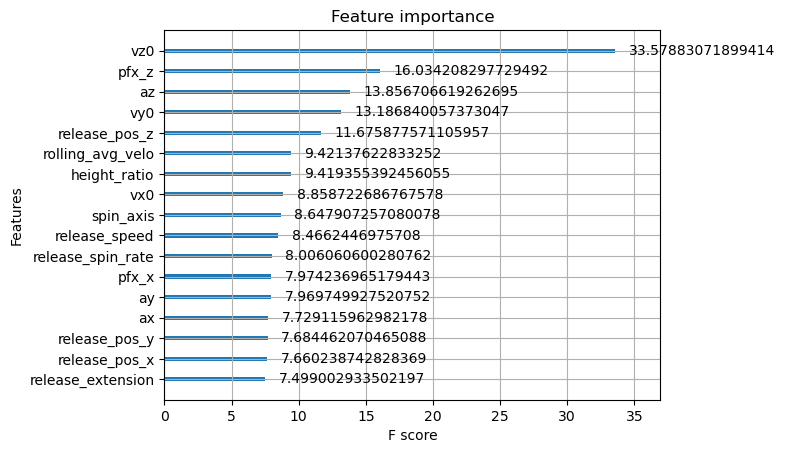

In [21]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

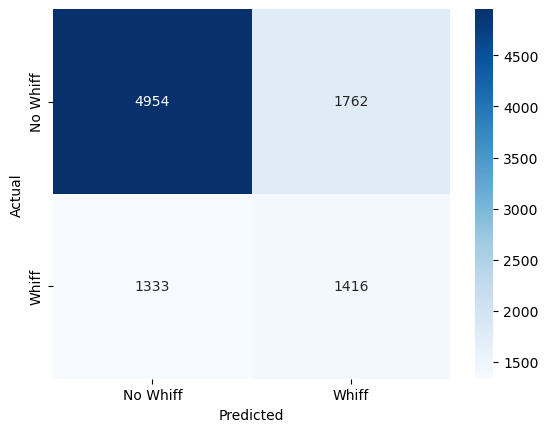

In [22]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [23]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [24]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [25]:
y_pred = final_model.predict(predictions)

In [26]:
testing_identifiers['xwhiff'] = y_pred

In [27]:
testing_identifiers.head()

pitch_id_raw    xwhiff
32   661032_608070_623474_4_62_9  0.391360
40   661032_680911_628452_4_64_9  0.418344
157  661032_640458_663776_2_49_7  0.607254
158  661032_676391_663776_2_33_5  0.412059
159  661032_642708_663776_2_19_3  0.410099

In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/whiff_2022&3_xwhiff.csv")